# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- ~~AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;~~
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB);~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- ~~LB: Aggiungere un flag alla funzione plot per indicare quale strumento si sta considerando~~
- ~~AF: Controllare qual è la distribuzione del S/N per Swift~~
- ~~AF: Trovare i valori di risoluzione temporale, area efficace e background per Swift e BeppoSax~~
- ~~AF: Eseguire un test KS e/o AD sulla distribuzione dei tempi di BATSE~~
- Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;

---

- I risultati di MEPSA girati sui GRB di BATSE si trovano in `/astrodata/guidorzi/CGRO_BATSE/PEAKS_ALL/` (se c'e' un `#` davanti significa che sono stati scartati manualmente da CG)

CG: anziche' usare MEPSA che e' parecchio lento, come quinta metrica possiamo usare la seguente cosa. Runniamo MEPSA su BATSE (gia' fatto, con S2N=5), e costruiamo la distribuzione dei peak count-rate (ovvero qual e' la distribuzione dei conteggi di picco, 6o campo nel file di output di MEPSA). A questo punto dovremo decidere un valore di soglia sotto al quale i picchi con pochi conteggi non sono visti da MEPSA su BATSE, perche' i picchi molto bassi sono coperti dal rumore (quindi anche se ci sono, MEPSA non li vede perche' sono coperti dal rumore). A questo punto anziche' runnare MEPSA sulle curve finali simulate per ottenere il numero di picchi statisticamente significativi, contiamo direttamente il numero di impulsi (parenti+figli) usati per generare il dato GRB (valore gia' noto), considerando pero' solo quelli che superano la soglia decisa prima, ovvero quelli che non verrebbero coperti una volta aggiunto il rumore alle nostre curve simulate. Quello che facciamo quindi, al posto di runnare MEPSA sulle curve simulate, e' dare direttamente il numero di impulsi usati per generare il GRB, ma andando a tagliare sul valore di picco, escludendo quelli piu' bassi del valore di soglia di cui sopra. Per farlo direi che dobbiamo aggiungere alla classe `GRB` un attributo, ovvero il numero di impulsi totali (parenti+figli) sopra la soglia.

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

from statistical_test import *

#SEED=42
#np.random.seed(SEED)

In [13]:
# set the username for the path of the files:
user='LB'
#user='AF'
#user='bach'
if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = ''
    swift_sim_path     = ''
    beppo_sax_sim_path = ''
    # mepsa
    mepsa_path      = ''
    ex_pattern_path = ''
elif user=='LB':
    # real data
    batse_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse/'
    #batse_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse_OLD/'
    swift_sim_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swift/'
    #swift_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swift_OLD/'
    beppo_sax_sim_path  = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax/'
    #beppo_sax_sim_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax_OLD/'
    # mepsa
    mepsa_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
    # m3psa on BATSE
    batse_mepsa_res_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'
elif user=='AF':
    batse_path            = 'E:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path  = 'E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path            = 'E:/grb_to_test/Swift_BAT/'
    sax_path              = 'E:/grb_to_test/BeppoSAX_GRBM/'
    batse_sim_path        = 'E:/grb_to_test/simulations/batse/'
    swift_sim_path        = 'E:/grb_to_test/simulations/swift/'
    beppo_sax_sim_path_hr = 'E:/grb_to_test/simulations/sax_hr/'
    beppo_sax_sim_path_lr = 'E:/grb_to_test/simulations/sax_lr/'
    mepsa_path            = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path       = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [3]:
t_i     = 0   # [s]
t_f     = 150 # [s]
t_f_sax = 50  # [s]

# BATSE
bin_time_batse     = instr_batse['res'] # temporal resolution (bins) for BATSE [s]
test_times_batse   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))
sn_threshold_batse = instr_batse['sn_threshold']
t90_threshold      = instr_batse['t90_threshold'] 
t90_frac           = 15

# Swift
bin_time_swift     = instr_swift['res'] # temporal resolution (bins) for Swift [s]
test_times_swift   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))
sn_threshold_swift = instr_swift['sn_threshold']
t90_threshold      = instr_swift['t90_threshold'] 
t90_frac           = 15

# BeppoSAX (HR)
bin_time_sax_hr   = instr_sax['res']      # temporal resolution (bins) for BeppoSAX (HIGH res) [s]
test_times_sax_hr = np.linspace(t_i, t_f_sax, int((t_f_sax-t_i)/bin_time_sax_hr))
sn_threshold_sax  = instr_sax['sn_threshold'] 
t90_threshold     = instr_sax['t90_threshold'] 
t90_frac          = 15

# BeppoSAX (LR)
bin_time_sax_lr     = instr_sax_lr['res'] # temporal resolution (bins) for BeppoSAX (LOW res) [s]
test_times_sax_lr   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax_lr))
sn_threshold_sax_lr = instr_sax_lr['sn_threshold'] 
t90_threshold       = instr_sax_lr['t90_threshold'] 
t90_frac            = 15

## Load REAL Data

#### BATSE 

In [4]:
### Load the BATSE GRBs

# load all data
grb_list_batse = load_lc_batse(path=batse_path) 
# apply constraints
grb_list_batse = apply_constraints(grb_list=grb_list_batse, 
                                   bin_time=bin_time_batse, 
                                   t90_threshold=t90_threshold, 
                                   t90_frac=t90_frac,
                                   sn_threshold=sn_threshold_batse, 
                                   t_f=t_f)

100%|██████████| 1457/1457 [00:02<00:00, 548.24it/s]


Total number of _long_ GRBs in BATSE catalogue:  1457
GRBs in the catalogue which are NOT present in the data folder:  0
Loaded GRBs:  1457
Total number of input GRBs:  1457
GRBs with negative duration:  0
GRBs that satisfy the constraints:  585


In [6]:
# select for MEPSA only the grbs that satisfy the constraints

#with open('./grb_for_mepsa.txt', 'w') as output:
#    for i in range(len(grb_list_batse)):
#        name = grb_list_batse[i].name
#        output.write(name + '\n')

####  Swift 

Test per vedere quanti ne seleziona:

SN = 70 -> 150 circa <br>
SN = 35 -> 350 circa <br>
SN = 15 -> 591

In [11]:
### Load the Swift GRBs

# load all data
grb_list_swift = load_lc_swift(path=swift_path)
# apply constraints
grb_list_swift, sn_lev_swift = apply_constraints(grb_list=grb_list_swift, 
                                                 bin_time=bin_time_swift, 
                                                 t90_threshold=t90_threshold, 
                                                 t90_frac=t90_frac,
                                                 sn_threshold=sn_threshold_swift, 
                                                 t_f=t_f,
                                                 sn_distr=True)

100%|██████████| 1389/1389 [03:54<00:00,  5.93it/s]


Total number of GRBs in Swift catalogue:  1389
GRBs in the catalogue which are NOT present in the data folder:  115
Loaded GRBs:  1274
Total number of input GRBs:  1274
GRBs with negative duration:  0
GRBs that satisfy the constraints:  527


Average S/N 38.453487


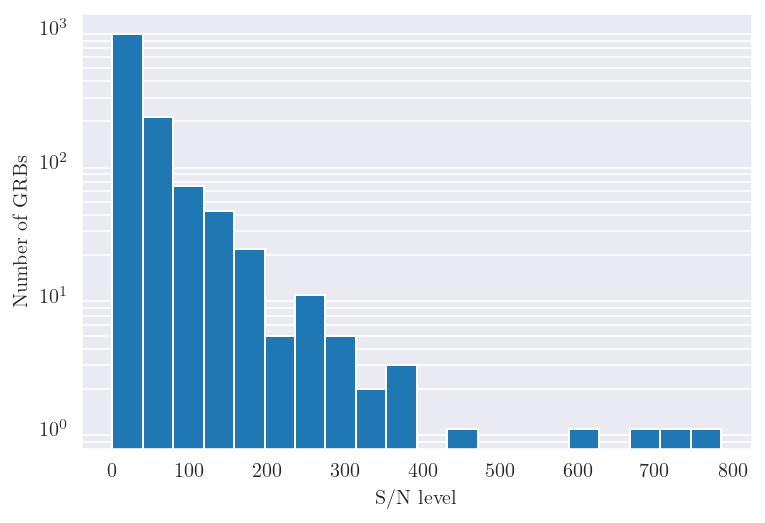

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(sn_lev_swift, bins=20)

ax.set_yscale('log')
ax.grid(which='both')
ax.set_xlabel('S/N level')
ax.set_ylabel('Number of GRBs')
#ax.set_xlim(0,100)
print('Average S/N', np.mean(sn_lev_swift))

#### BeppoSAX (High res)

In [8]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_hr = load_lc_sax_hr(path=sax_path) 

# apply constraints
grb_list_sax_hr = apply_constraints(grb_list=grb_list_sax_hr, 
                                    bin_time=bin_time_sax_hr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f_sax) # The high-res lc span a total of 106 sec, 
                                                 # so we need to reduce the 150 sec constraint

# The data from BeppoSAX show some strange line features in the light curve (both strong negative and strong positive peaks).
# We remove those GRBs from the analysis. 







#@@@@@@Lorenzo: spostiamo questa parte nel load_lc_sax direttamente? 
grb_list_sax_hr = [grb for grb in grb_list_sax_hr if  all(grb.counts > -50) and all(grb.counts < np.mean(grb.counts)*80) ]

print('GRBs that have no lines features in the LC: ', len(grb_list_sax_hr))

Total number of GRBs in BeppoSAX catalogue:  1082
GRBs that have an high-res "best" (or 2-mixed) channel lc: 546
GRBs in the catalogue which are NOT present in the data folder:  0
GRBs in the catalogue which have a T90 greater than 106s:  32
GRBs in the catalogue which are present in the data folder, but with no T90:  28
Loaded GRBs:  486
Total number of input GRBs:  486
GRBs with negative duration:  0
GRBs that satisfy the constraints:  224
GRBs that have no lines features in the LC:  121


#### BeppoSAX (Low res)

In [6]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_lr = load_lc_sax_lr(path=sax_path) 

# apply constraints
grb_list_sax_lr = apply_constraints(grb_list=grb_list_sax_lr, 
                                    bin_time=bin_time_sax_lr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f, filter = False)

Total number of GRBs in BeppoSAX catalogue:  1082
GRBs in the catalogue which are NOT present in the data folder:  159
GRBs in the catalogue which are present in the data folder, but with no T90:  62
Loaded GRBs:  861
Total number of input GRBs:  861
GRBs with negative duration:  20
GRBs that satisfy the constraints:  312


## Load SIMULATED Data 

We load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB; the columns in the files are: `times`, `counts`, `errs`, `t90`.

#### BATSE:

In [5]:
### Load the simulated BATSE GRBs

# load all data
grb_list_sim_batse = load_lc_sim(path=batse_sim_path)
# apply constraints
grb_list_sim_batse = apply_constraints(grb_list=grb_list_sim_batse, 
                                       bin_time=bin_time_batse, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_batse, 
                                       t_f=t_f)

100%|██████████| 2000/2000 [00:19<00:00, 101.27it/s]


Total number of simulated GRBs:  2000
Total number of input GRBs:  2000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  2000


#### Swift:

In [31]:
# Load the simulated Swift GRBs

# load all data
grb_list_sim_swift = load_lc_sim(path=swift_sim_path)
# apply constraints
grb_list_sim_swift = apply_constraints(grb_list=grb_list_sim_swift, 
                                       bin_time=bin_time_swift, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_swift, 
                                       t_f=t_f)

100%|██████████| 1000/1000 [00:09<00:00, 106.47it/s]


Total number of simulated GRBs:  1000
Total number of input GRBs:  1000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  1000


#### BeppoSAX (High res):

In [13]:
### Load the simulated BeppoSAX GRBs
 
# # load all data
grb_list_sim_sax_hr = load_lc_sim(path=beppo_sax_sim_path_hr) 
# apply constraints
grb_list_sim_sax_hr = apply_constraints(grb_list=grb_list_sim_sax_hr, 
                                        bin_time=bin_time_sax_hr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f_sax)

100%|██████████| 201/201 [04:43<00:00,  1.41s/it]


Total number of simulated GRBs:  201
Total number of input GRBs:  201
GRBs with negative duration:  0
GRBs that satisfy the constraints:  201


#### BeppoSAX (Low res):

In [ ]:
### Load the simulated BeppoSAX GRBs
 
# # load all data
grb_list_sim_sax_lr = load_lc_sim(path=beppo_sax_sim_path_lr) 
# apply constraints
grb_list_sim_sax_lr = apply_constraints(grb_list=grb_list_sim_sax_lr, 
                                        bin_time=bin_time_sax_lr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f, filter = False)

100%|██████████| 1000/1000 [00:17<00:00, 57.90it/s]

Total number of simulated GRBs:  1000
Total number of input GRBs:  1000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  1000


# Test 1&2: Average Peak-Aligned Profiles

In [6]:
# averaged_fluxes_batse, \
# averaged_fluxes_cube_batse, \
# averaged_fluxes_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
#                                                        t_f=t_f, 
#                                                        bin_time=bin_time_batse,
#                                                        filter=True)
# 
# averaged_fluxes_sim_batse, \
# averaged_fluxes_cube_sim_batse, \
# averaged_fluxes_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
#                                                            t_f=t_f, 
#                                                            bin_time=bin_time_batse,
#                                                            filter=True)

# compute also the rms of the average of the cube of F/F_p
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse, \
averaged_fluxes_cube_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_batse,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_batse, \
averaged_fluxes_cube_sim_batse, \
averaged_fluxes_rms_sim_batse, \
averaged_fluxes_cube_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_batse,
                                                                filter=True,
                                                                compute_rms=True)

In [32]:
# averaged_fluxes_swift, \
# averaged_fluxes_cube_swift, \
# averaged_fluxes_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
#                                                        t_f=t_f, 
#                                                        bin_time=bin_time_swift,
#                                                        filter=True)
# 
# averaged_fluxes_sim_swift, \
# averaged_fluxes_cube_sim_swift, \
# averaged_fluxes_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
#                                                            t_f=t_f, 
#                                                            bin_time=bin_time_swift,
#                                                            filter=True)

# compute also the rms of the average of the cube of F/F_p
averaged_fluxes_swift, \
averaged_fluxes_cube_swift, \
averaged_fluxes_rms_swift, \
averaged_fluxes_cube_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_swift,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_swift, \
averaged_fluxes_cube_sim_swift, \
averaged_fluxes_rms_sim_swift, \
averaged_fluxes_cube_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_swift,
                                                                filter=True,
                                                                compute_rms=True)

In [20]:
averaged_fluxes_sax_hr, \
averaged_fluxes_cube_sax_hr, \
averaged_fluxes_rms_sax_hr = compute_average_quantities(grb_list=grb_list_sax_hr, 
                                                        t_f=t_f_sax, 
                                                        bin_time=bin_time_sax_hr,
                                                        filter=True, filter_window = 51)

averaged_fluxes_sim_sax_hr, \
averaged_fluxes_cube_sim_sax_hr, \
averaged_fluxes_rms_sim_sax_hr = compute_average_quantities(grb_list=grb_list_sim_sax_hr, 
                                                            t_f=t_f_sax, 
                                                            bin_time=bin_time_sax_hr,
                                                            filter=True, filter_window = 51)

In [41]:
averaged_fluxes_sax_lr, \
averaged_fluxes_cube_sax_lr, \
averaged_fluxes_rms_sax_lr = compute_average_quantities(grb_list=grb_list_sax_lr, 
                                                        t_f=t_f, 
                                                        bin_time=bin_time_sax_lr,
                                                        filter=True, filter_window = 3)

averaged_fluxes_sim_sax_lr, \
averaged_fluxes_cube_sim_sax_lr, \
averaged_fluxes_rms_sim_sax_lr = compute_average_quantities(grb_list=grb_list_sim_sax_lr, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_sax_lr,
                                                            filter=True, filter_window = 3)

In [ ]:
#for grb in grb_list_sax_lr:
#    peak_pos = np.argmax(grb.counts)
#    if grb.counts[peak_pos + 25] < 0:
#        plt.figure()
#        plt.plot(grb.times, grb.counts)
#        plt.show()

# Test 3: Autocorrelation

- `scipy.signal.correlation`

    The correlation $z$ of two $d$-dimensional arrays $x$ and $y$ is defined as:

        z[...,k,...] = sum[..., i_l, ...] x[..., i_l,...] * conj(y[..., i_l - k,...])
        
    This way, if `x` and `y` are 1D arrays and ``z = correlate(x, y, 'full')``, then
    $$
          z[k] = (x * y)(k - N + 1)
               = \sum_{l=0}^{||x||-1}x_l y_{l-k+N-1}^{*}
    $$
    for $k = 0, 1, \dots, ||x|| + ||y|| - 2$, where $||x||$ is the length of $x$, $N = \max(||x||,||y||)$, and $y_m$ is $0$ when m is outside the range of $y$.


- Link93

    Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

    $$
        A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
    $$
    where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
    $$
    \begin{aligned}
    & A(\tau)=1 & (\tau=0) \\
    & A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
    &
    \end{aligned}
    $$
    For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
    $$
    \begin{array}{rlr}
    A(\tau) &= 1 & (\tau=0) \\
    A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0)
    \end{array}
    $$
    where the lag is $\tau \equiv u \Delta t$.


In [7]:
N_lim=np.min( [np.max(len(grb_list_sim_batse  )), 
               np.max(len(grb_list_batse))] )
assert len(grb_list_sim_batse) >= N_lim
assert len(grb_list_batse)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

# steps_sim_batse, acf_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_batse,
#                                                          mode=mode)
# 
# steps_batse, acf_batse         = compute_autocorrelation(grb_list=grb_list_batse,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_batse,
#                                                          mode=mode)

# compute also the rms of the autocorrelation
steps_sim_batse, \
acf_sim_batse, \
acf_rms_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_batse,
                                            mode=mode,
                                            compute_rms=True)

steps_batse, \
acf_batse, \
acf_rms_batse = compute_autocorrelation(grb_list=grb_list_batse,
                                        N_lim=N_lim,
                                        t_max=t_f,
                                        bin_time=bin_time_batse,
                                        mode=mode,
                                        compute_rms=True)                                    

In [33]:
N_lim=np.min( [np.max(len(grb_list_sim_swift  )), 
               np.max(len(grb_list_swift))] )
assert len(grb_list_sim_swift) >= N_lim
assert len(grb_list_swift)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

# steps_sim_swift, acf_sim_swift = compute_autocorrelation(grb_list=grb_list_sim_swift,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_swift,
#                                                          mode=mode)
# 
# steps_swift, acf_swift         = compute_autocorrelation(grb_list=grb_list_swift,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_swift,
#                                                          mode=mode)

# compute also the rms of the autocorrelation
steps_sim_swift, \
acf_sim_swift, \
acf_rms_sim_swift = compute_autocorrelation(grb_list=grb_list_sim_swift,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode=mode,
                                            compute_rms=True)

steps_swift, \
acf_swift, \
acf_rms_swift         = compute_autocorrelation(grb_list=grb_list_swift,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode=mode,
                                            compute_rms=True)

In [24]:
N_lim=np.min( [np.max(len(grb_list_sim_sax_hr)), 
               np.max(len(grb_list_sax_hr))] )
assert len(grb_list_sim_sax_hr) >= N_lim
assert len(grb_list_sax_hr)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim_sax_hr, acf_sim_sax_hr = compute_autocorrelation(grb_list=grb_list_sim_sax_hr,
                                                           N_lim=N_lim,
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode=mode)

steps_sax_hr, acf_sax_hr         = compute_autocorrelation(grb_list=grb_list_sax_hr,
                                                           N_lim=N_lim,
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode=mode)

In [42]:
N_lim=np.min( [np.max(len(grb_list_sim_sax_lr)), 
               np.max(len(grb_list_sax_lr))] )
assert len(grb_list_sim_sax_lr) >= N_lim
assert len(grb_list_sax_lr)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim_sax_lr, acf_sim_sax_lr = compute_autocorrelation(grb_list=grb_list_sim_sax_lr,
                                                           N_lim=N_lim,
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode=mode)

steps_sax_lr, acf_sax_lr         = compute_autocorrelation(grb_list=grb_list_sax_lr,
                                                           N_lim=N_lim,
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode=mode)

# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

In [8]:
#duration_batse       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_batse ]
#
#duration_sim_batse   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_sim_batse   ]

duration_batse     = [ grb.t20 for grb in grb_list_batse ]
duration_sim_batse = [ grb.t20 for grb in grb_list_sim_batse ]

dur_distr_batse     = compute_kde_log_duration(duration_batse)
dur_distr_sim_batse = compute_kde_log_duration(duration_sim_batse)

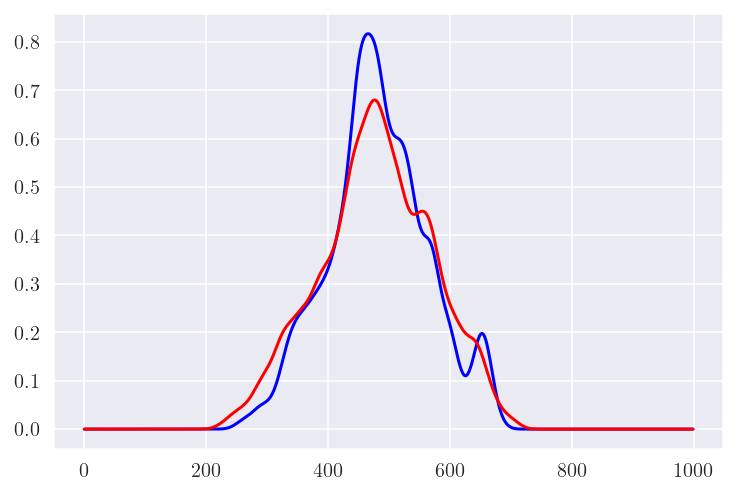

In [9]:
plt.plot(dur_distr_batse,     c='b')
plt.plot(dur_distr_sim_batse, c='r')
plt.show()

In [34]:
#duration_swift       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_swift ]
#
#duration_sim_swift   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_sim_swift   ]

duration_swift     = [ grb.t20 for grb in grb_list_swift ]
duration_sim_swift = [ grb.t20 for grb in grb_list_sim_swift ]

dur_distr_swift     = compute_kde_log_duration(duration_swift)
dur_distr_sim_swift = compute_kde_log_duration(duration_sim_swift)

In [29]:
#duration_sax_hr       = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sax_hr ]
#
#duration_sim_sax_hr   = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sim_sax_hr   ]

duration_sax     = [ grb.t20 for grb in grb_list_sax ]
duration_sim_sax = [ grb.t20 for grb in grb_list_sim_sax ]

dur_distr_sax     = compute_kde_log_duration(duration_sax_hr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_hr)

In [45]:
duration_sax_lr     = []
duration_sim_sax_lr = []

for grb in grb_list_sax_lr:
    try:
        duration_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                  counts=grb.counts,
                                                  filter=False,
                                                  t90=grb.t90,
                                                  bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue

for grb in grb_list_sim_sax_lr:
    try:
        duration_sim_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                      counts=grb.counts,
                                                      filter=False,
                                                      t90=grb.t90,
                                                      bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue


dur_distr_sax     = compute_kde_log_duration(duration_sax_lr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_lr)

## Test 5a: Number of significative peaks (MEPSA _real_ vs MEPSA _sim_)

#### Run MEPSA on the _simulated_ light-curves for BATSE (very slow!)

In [29]:
#reb_factor     = 32
#peak_sn_level  = 5
#n_of_peaks_sim = [runMEPSA(mepsa_path=mepsa_path, 
#                           ex_pattern_file_path=ex_pattern_path, 
#                           grb_file_path=grb.data_file_path, 
#                           nbins=reb_factor, 
#                           grb_name=grb.name, 
#                           sn_level=peak_sn_level) for grb in tqdm(grb_list_sim_batse)]
#mepsa_pulses = n_of_peaks_sim

  0%|          | 1/2000 [00:02<1:39:40,  2.99s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    11.664    0.192	4963.08900 120.24293   41.28	17  7


  0%|          | 2/2000 [00:05<1:33:25,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	6728.87746 150.23461   44.79	 6  4
  2    6    0	   996.656    0.384	 356.83333  80.38328    4.44	27  9


  0%|          | 3/2000 [00:08<1:31:39,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	3651.39560 145.02309   25.18	 6  4
  2    1    0	     2.192    0.064	5154.94090 208.72695   24.70	14  7
  3    3    2	     2.512    0.192	4276.36240 119.28728   35.85	17  7
  4    1    0	     3.664    0.064	6233.41414 211.29461   29.50	17  7
  5    2    0	     4.528    0.128	7099.10444 150.84944   47.06	 2  3
  6    2    1	     5.360    0.128	5094.80010 147.49034   34.54	 7  5
  7    6    4	    11.184    0.384	 475.89595  80.50662    5.91	30 10


  0%|          | 4/2000 [00:11<1:31:07,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.912    0.128	2279.03940 142.63772   15.98	 7  5
  2    3    1	     8.784    0.192	2429.02851 116.67766   20.82	14  7
  3    3    1	    22.800    0.192	3267.78512 117.86968   27.72	17  7
  4   10    3	    23.792    0.640	2818.68443  64.21112   43.90	39  8
  5    3    0	    32.720    0.192	2856.99211 117.28739   24.36	14  7
  6    1    0	    36.496    0.064	6609.82879 212.18348   31.15	 5  3
  7    1    0	    37.008    0.064	7091.64866 213.31584   33.24	14  7
  8    3    1	    37.392    0.192	6732.31297 122.67072   54.88	23  8
  9    1    0	    38.160    0.064	6262.80357 211.36415   29.63	16  6
 10    1    0	    38.480    0.064	7049.27303 213.21649   33.06	17  7
 11    1    0	    39.312    0.064	7059.44085 213.24034   33.11	 2  3
 12    1    0	    40.208    0.064	6194.81269 211.20325   29.33	 6  4
 13    2    1	    40.688    0.128	4368.58936 146.25421   29.87	 2  3
 14    3    2	    41.104

  0%|          | 5/2000 [00:13<1:30:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	1040.20755 140.44965    7.41	27  9
  2   28    8	    52.336    1.792	 446.99437  37.25347   12.00	29 10
  3   21   13	    72.144    1.344	 431.83205  43.00821   10.04	25  9
  4    1    0	    83.856    0.064	7958.87840 215.33898   36.96	 6  4
  5    3    0	    84.176    0.192	7330.65846 123.48098   59.37	39  8
  6    1    0	    84.560    0.064	7767.32751 214.89376   36.14	24  8
  7    1    0	    85.200    0.064	7333.73540 213.88253   34.29	 2  3
  8    3    2	    85.648    0.192	6416.01305 122.24022   52.49	 1  2
  9    1    0	    86.096    0.064	7589.82375 214.48036   35.39	 5  3
 10    1    0	    86.608    0.064	5038.48264 208.44779   24.17	36  4
 11    2    1	    86.896    0.128	5931.67732 148.90211   39.84	26  9
 12    3    0	    87.632    0.192	5438.95253 120.90072   44.99	 3  4
 13    1    0	    88.912    0.064	3592.13843 204.94911   17.53	12  6
 14    2    0	    91.056

  0%|          | 6/2000 [00:16<1:30:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   12	   152.464    1.984	5850.50398  37.78654  154.83	39  8


  0%|          | 7/2000 [00:19<1:30:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	    27.248    0.512	1391.68843  70.53695   19.73	25  9
  2    7    4	    35.280    0.448	2083.78237  76.05992   27.40	14  7
  3    2    0	    39.728    0.128	5091.12944 147.48412   34.52	 9  4
  4    1    0	    40.784    0.064	5939.48532 210.59792   28.20	35 10
  5    1    0	    42.128    0.064	5248.48731 208.95092   25.12	 6  4
  6    1    0	    42.640    0.064	6240.58979 211.31159   29.53	14  7
  7    1    0	    43.600    0.064	13353.91894 227.52125   58.69	 1  2
  8    1    0	    43.792    0.064	11605.59171 223.64613   51.89	 5  3
  9    1    0	    44.240    0.064	10549.72970 221.27298   47.68	 1  2
 10    1    0	    45.200    0.064	8090.45716 215.64428   37.52	17  7
 11    1    0	    45.520    0.064	6568.86152 212.08692   30.97	12  6
 12    1    0	    46.160    0.064	7648.73421 214.61765   35.64	14  7
 13    2    1	    47.600    0.128	7569.07218 151.62630   49.92	 4  4
 14    1    0	    49.

  0%|          | 8/2000 [00:21<1:29:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	4954.40031 147.25217   33.65	14  7
  2    2    1	     9.328    0.128	4759.39125 146.92071   32.39	24  8
  3    2    0	   629.424    0.128	 648.50000 139.75067    4.64	35 10


  0%|          | 9/2000 [00:24<1:29:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	   377.168    0.704	6247.20411  63.71756   98.05	27  9


  0%|          | 10/2000 [00:27<1:29:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.968    0.256	 730.26666  98.92202    7.38	25  9
  2    1    0	     4.432    0.064	2675.04193 202.69939   13.20	24  8
  3    1    0	     5.392    0.064	3115.89036 203.78393   15.29	39  8
  4    1    0	     6.096    0.064	5419.76999 209.36038   25.89	 6  4
  5    3    2	     7.504    0.192	1700.54694 115.63239   14.71	 4  4
  6    2    0	     8.368    0.128	2002.93438 142.15297   14.09	 4  4
  7    1    0	     9.296    0.064	3630.80600 205.04342   17.71	 5  3
  8    1    0	    12.176    0.064	2596.15172 202.50470   12.82	14  7
  9    3    2	    12.496    0.192	2063.33260 116.15411   17.76	39  8
 10    1    0	    12.880    0.064	2589.75720 202.48891   12.79	 6  4


  1%|          | 11/2000 [00:29<1:29:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	6581.49951 212.11671   31.03	 6  4
  2    2    1	     2.288    0.128	5675.41159 148.47123   38.23	 5  3
  3    1    0	     4.304    0.064	6190.99706 211.19422   29.31	14  7
  4    1    0	     8.272    0.064	4952.30674 208.24098   23.78	17  7
  5    3    0	     9.488    0.192	1424.55209 115.23390   12.36	36  4


  1%|          | 12/2000 [00:32<1:29:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    14.160    0.704	 563.51988  59.52503    9.47	35 10
  2   16    0	    61.168    1.024	 778.43197  49.49143   15.73	39  8
  3    3    2	    79.312    0.192	1095.70155 114.75728    9.55	28  9
  4    1    0	    82.320    0.064	4461.49292 207.05915   21.55	26  9
  5    3    0	    83.792    0.192	6386.51700 122.20000   52.26	 5  3
  6    1    0	    84.816    0.064	4931.49455 208.19100   23.69	 7  5
  7    1    0	    86.352    0.064	8702.31509 217.05832   40.09	 4  4
  8    1    0	    86.992    0.064	9672.40967 219.28158   44.11	 2  3
  9    1    0	    87.760    0.064	6040.83074 210.83840   28.65	19  7
 10    1    0	    88.656    0.064	4867.95151 208.03834   23.40	12  6
 11    2    0	    89.264    0.128	4483.50505 146.45051   30.61	12  6
 12    3    1	    89.808    0.192	2793.64507 117.19733   23.84	 4  4
 13    1    0	    91.600    0.064	5166.58175 208.75484   24.75	 6  4
 14    1    0	    92.240

  1%|          | 13/2000 [00:35<1:29:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     2.128    0.448	 357.56417  74.42116    4.80	30 10
  2    7    6	    15.248    0.448	1181.86449  75.20815   15.71	25  9
  3    7    0	    18.448    0.448	 806.79431  74.85108   10.78	14  7
  4    4    2	    29.424    0.256	2481.96809 101.11129   24.55	25  9
  5    1    0	    31.120    0.064	4128.44491 206.25335   20.02	39  8
  6    9    4	    32.016    0.576	2773.12370  67.64706   40.99	39  8
  7    2    0	    36.656    0.128	4990.54500 147.31352   33.88	 6  4
  8    5    4	    39.376    0.320	1446.91054  89.28484   16.21	39  8
  9    1    0	    41.616    0.064	2054.52688 201.16294   10.21	23  8
 10   11    8	    49.296    0.704	 365.72387  59.37380    6.16	30 10


  1%|          | 14/2000 [00:38<1:29:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    3	   110.224    1.984	 581.93113  35.46645   16.41	25  9
  2   31   25	   278.288    1.984	1390.36661  35.83221   38.80	30 10
  3    5    3	   299.792    0.320	2507.59701  90.46502   27.72	35 10
  4    2    1	   307.824    0.128	3694.89238 145.09806   25.46	27  9
  5    1    0	   309.648    0.064	3164.96367 203.90430   15.52	39  8
  6    1    0	   311.376    0.064	6104.04933 210.98827   28.93	14  7
  7    1    0	   312.016    0.064	5136.55694 208.68291   24.61	14  7
  8    1    0	   312.464    0.064	4600.00606 207.39336   22.18	 1  2
  9    1    0	   312.656    0.064	5346.22984 209.18468   25.56	 2  3
 10    1    0	   313.232    0.064	6971.58842 213.03424   32.73	 6  4
 11    1    0	   313.872    0.064	4195.05358 206.41476   20.32	14  7
 12    3    0	   314.384    0.192	3961.06331 118.84593   33.33	 1  2
 13    1    0	   315.664    0.064	2461.55785 202.17210   12.18	14  7
 14   11    9	   348.560

  1%|          | 15/2000 [00:40<1:30:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    9	    45.904    1.216	1067.36548  45.58356   23.42	35 10
  2   22   16	   304.304    1.408	 777.76249  42.20608   18.43	39  8
  3   15    2	   340.048    0.960	1667.11158  51.69082   32.25	32 10
  4   13    7	   353.616    0.832	1467.85810  55.38665   26.50	25  9
  5    8    5	   367.920    0.512	1119.76663  70.29560   15.93	30 10
  6   11    2	   385.424    0.704	1105.47991  59.93745   18.44	14  7
  7   11   10	   393.680    0.704	2334.27795  60.86220   38.35	39  8
  8    2    1	   394.864    0.128	3052.54776 143.98706   21.20	 7  5
  9    3    1	   396.240    0.192	2592.71473 116.91124   22.18	 2  3
 10    1    0	   397.264    0.064	3127.47515 203.81235   15.34	30 10
 11    6    5	   397.936    0.384	2690.92793  82.76767   32.51	 1  2
 12    1    0	   399.504    0.064	4861.42665 208.02266   23.37	25  9
 13    2    1	   401.264    0.128	4954.43202 147.25222   33.65	25  9
 14    3    0	   401.936

  1%|          | 16/2000 [00:43<1:29:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	2911.61765 203.28211   14.32	17  7
  2    1    0	     1.680    0.064	8008.58957 215.45438   37.17	 1  2
  3    1    0	     2.512    0.064	4445.80122 207.02126   21.48	 5  3
  4    1    0	     3.024    0.064	2643.19342 202.62081   13.05	 6  4
  5    1    0	     3.664    0.064	4131.60137 206.26100   20.03	26  9
  6    1    0	     4.048    0.064	4896.89019 208.10788   23.53	 5  3
  7    1    0	     4.240    0.064	4677.22211 207.57944   22.53	 5  3
  8    1    0	     4.816    0.064	10754.44546 221.73508   48.50	 1  2
  9    1    0	     5.456    0.064	10728.21510 221.67592   48.40	 1  2
 10    1    0	     5.776    0.064	6548.43064 212.03875   30.88	 1  2
 11    1    0	     7.120    0.064	10433.15116 221.00939   47.21	 6  4
 12    1    0	     7.376    0.064	6985.91691 213.06787   32.79	 1  2
 13    1    0	     7.696    0.064	9663.74976 219.26183   44.07	 5  3
 14    3    0	     7.

  1%|          | 17/2000 [00:46<1:29:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    2	    22.576    1.664	 622.51288  38.74697   16.07	30 10
  2   26   18	   204.976    1.664	 567.66858  38.71974   14.66	30 10
  3   14    8	   223.024    0.896	1013.23846  53.06683   19.09	12  6
  4    2    0	   288.176    0.128	2691.73361 143.35922   18.78	14  7
  5    6    0	   288.944    0.384	2361.98907  82.43582   28.65	39  8
  6    2    0	   291.888    0.128	3636.67768 144.99772   25.08	14  7
  7    5    2	   292.368    0.320	3138.58351  91.15984   34.43	39  8
  8    1    0	   293.584    0.064	3018.21038 203.54412   14.83	32 10
  9    3    2	   294.736    0.192	5048.73140 120.36158   41.95	14  7
 10    1    0	   296.144    0.064	4400.48097 206.91177   21.27	25  9
 11    2    1	   296.816    0.128	3943.29979 145.52543   27.10	39  8
 12    4    1	   299.184    0.256	1297.91581  99.63673   13.03	26  9


  1%|          | 18/2000 [00:48<1:29:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3220.64205 204.04079   15.78	 1  2
  2   10    2	    44.208    0.640	10620.48539  70.02320  151.67	17  7
  3    3    2	    81.808    0.192	10313.83355 127.44389   80.93	30 10
  4    3    0	    95.120    0.192	8225.84091 124.68339   65.97	30 10
  5    6    4	   160.560    0.384	5670.09277  85.71473   66.15	39  8


  1%|          | 19/2000 [00:51<1:29:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.400    0.128	3895.80996 145.44382   26.79	25  9
  2    2    1	     5.872    0.128	5203.31256 147.67416   35.24	14  7
  3    2    0	   295.088    0.128	 716.00000 139.87137    5.12	37  6
  4   26   18	   907.184    1.664	 148.65385  38.51106    3.86	36  4


  1%|          | 20/2000 [00:54<1:28:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	3331.50532 144.47059   23.06	 2  3
  2    1    0	     1.168    0.064	5104.82394 208.60686   24.47	14  7
  3   12    3	    15.920    0.768	4601.25669  59.87018   76.85	17  7


  1%|          | 21/2000 [00:56<1:28:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	12939.29089 226.60823   57.10	14  7
  2    1    0	     1.424    0.064	27718.53505 257.15858  107.79	39  8
  3    1    0	     1.936    0.064	27083.91397 255.92169  105.83	 1  2
  4    1    0	     2.192    0.064	24484.62201 250.79199   97.63	 1  2
  5    1    0	     2.384    0.064	27377.74083 256.49511  106.74	 1  2
  6    1    0	     2.768    0.064	12724.87688 226.13464   56.27	 2  3
  7    1    0	     3.280    0.064	11401.11570 223.18852   51.08	 1  2
  8    1    0	     3.856    0.064	11797.51828 224.07481   52.65	38  6
  9    1    0	     4.240    0.064	9707.78264 219.36222   44.25	 4  4
 10    1    0	     4.624    0.064	8089.94764 215.64310   37.52	 5  3
 11    1    0	     4.752    0.064	6674.26923 212.33528   31.43	 2  3
 12    1    0	     5.136    0.064	10551.19165 221.27628   47.68	 5  3
 13    1    0	     5.904    0.064	20202.42150 242.10415   83.45	 5  3
 14    1    0	

  1%|          | 22/2000 [00:59<1:28:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.344    0.064	4720.28940 207.68315   22.73	 6  4
  2    1    0	     4.176    0.064	4453.65526 207.04023   21.51	39  8
  3    1    0	     4.688    0.064	3976.67597 205.88510   19.32	25  9
  4    1    0	     5.968    0.064	5499.95695 209.55180   26.25	14  7
  5    4    3	     6.704    0.256	6517.57617 105.98299   61.50	14  7
  6    1    0	     7.120    0.064	7794.42214 214.95679   36.26	 1  2
  7    1    0	     7.888    0.064	6467.85971 211.84867   30.53	 6  4
  8    1    0	     8.272    0.064	7506.79348 214.28671   35.03	 6  4
  9    1    0	     9.552    0.064	3907.51635 205.71708   18.99	 6  4
 10    8    3	    13.488    0.512	 629.09631  69.85798    9.01	14  7
 11    1    0	    15.120    0.064	1142.77341 198.88382    5.75	38  6


  1%|          | 23/2000 [01:02<1:29:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     9.744    0.448	1312.69531  75.33231   17.43	30 10
  2    7    1	    18.064    0.448	1966.64998  75.94984   25.89	39  8
  3   10    3	    23.792    0.640	1714.77447  63.34570   27.07	24  8
  4    6    4	    29.232    0.384	1359.86089  81.41648   16.70	30 10
  5   29    3	   228.688    1.856	 637.78349  36.69529   17.38	30 10
  6   26   21	   290.032    1.664	 429.81349  38.65121   11.12	30 10
  7   31    8	   326.800    1.984	 453.09264  35.40781   12.80	30 10
  8    4    0	   434.544    0.256	2564.43883 101.21319   25.34	39  8
  9    3    0	   435.920    0.192	2440.83407 116.69452   20.92	24  8
 10    2    1	   438.128    0.128	5753.28323 148.60229   38.72	 9  4
 11    2    1	   439.280    0.128	5813.60840 148.70375   39.10	 9  4
 12    1    0	   440.144    0.064	5427.46408 209.37876   25.92	38  6
 13    2    1	   441.200    0.128	3773.41934 145.23329   25.98	38  6
 14    1    0	   441.872

  1%|          | 24/2000 [01:05<1:28:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	    23.440    0.576	 670.59802  65.89773   10.18	26  9
  2   22   11	    26.608    1.408	 525.50396  42.07002   12.49	23  8
  3    8    7	    32.688    0.512	 743.54986  69.96030   10.63	14  7
  4    3    2	    38.800    0.192	1490.91897 115.32984   12.93	29 10
  5    2    1	    43.248    0.128	2936.51811 143.78546   20.42	12  6
  6    3    1	    45.072    0.192	3919.11337 118.78708   32.99	 2  3
  7    1    0	    45.840    0.064	5511.96135 209.58044   26.30	39  8
  8    2    1	    46.192    0.128	5500.08283 148.17571   37.12	 2  3
  9    2    1	    49.392    0.128	5556.86749 148.27149   37.48	25  9
 10    1    0	    50.384    0.064	6088.08391 210.95043   28.86	30 10
 11    8    6	    53.616    0.512	1360.45256  70.50927   19.29	 4  4
 12    2    1	    55.536    0.128	1488.05049 141.24456   10.54	12  6
 13   10    0	    56.880    0.640	 588.19795  62.45014    9.42	 4  4


  1%|▏         | 25/2000 [01:07<1:28:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   11	   151.312    1.344	21791.40653  53.54278  406.99	35 10
  2   24    8	   359.920    1.536	4612.31051  42.34005  108.93	23  8


  1%|▏         | 26/2000 [01:10<1:28:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	    90.544    1.024	6206.15423  52.80752  117.52	39  8


  1%|▏         | 27/2000 [01:13<1:28:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    36.752    0.192	11201.82810 128.59993   87.11	30 10
  2   13    4	    88.016    0.832	3308.93386  56.65071   58.41	23  8


  1%|▏         | 28/2000 [01:15<1:28:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    2	    67.696    1.536	 647.10082  40.34182   16.04	14  7
  2    3    1	   138.960    0.192	1710.94854 115.64738   14.79	14  7
  3    3    2	   141.136    0.192	2694.73516 117.05659   23.02	14  7
  4    1    0	   142.928    0.064	5206.27512 208.84989   24.93	14  7
  5    2    0	   143.792    0.128	5092.96299 147.48722   34.53	 7  5
  6    3    2	   145.168    0.192	6261.19844 122.02896   51.31	12  6
  7    2    1	   147.184    0.128	4502.79830 146.48344   30.74	17  7
  8    1    0	   147.728    0.064	5381.59723 209.26920   25.72	14  7
  9    3    1	   148.752    0.192	5030.48228 120.33631   41.80	17  7
 10    2    1	   151.152    0.128	2037.68024 142.21406   14.33	19  7
 11    1    0	   566.160    0.064	1000.00001 198.52456    5.04	27  9


  1%|▏         | 29/2000 [01:18<1:28:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.816    0.128	4676.91285 146.78030   31.86	39  8
  2    2    0	    12.976    0.128	4163.80778 145.90375   28.54	14  7
  3    3    1	    25.872    0.192	2744.55760 117.12751   23.43	14  7


  2%|▏         | 30/2000 [01:21<1:28:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10002.01859 220.03186   45.46	 1  2
  2    1    0	     0.464    0.064	4706.79571 207.65066   22.67	 1  2
  3    2    1	     2.416    0.128	7164.69662 150.95810   47.46	14  7
  4    1    0	     4.432    0.064	11710.44868 223.88043   52.31	14  7
  5   13   11	    95.120    0.832	5149.56907  57.88687   88.96	39  8
  6    5    0	   275.280    0.320	 438.94231  88.14867    4.98	26  9


  2%|▏         | 31/2000 [01:23<1:28:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	     1.360    0.960	 511.28803  50.94002   10.04	14  7
  2   29    5	     4.240    1.856	 390.87260  36.57909   10.69	17  7
  3    1    0	    13.136    0.064	5140.88787 208.69329   24.63	25  9
  4    8    1	    13.872    0.512	4037.08666  72.84323   55.42	14  7
  5    2    1	    14.960    0.128	4536.43730 146.54084   30.96	 5  3
  6    2    0	    18.736    0.128	5441.78056 148.07731   36.75	 7  5
  7    1    0	    19.728    0.064	3870.73263 205.62766   18.82	23  8
  8    1    0	    21.712    0.064	3008.20513 203.51954   14.78	16  6
  9    1    0	    22.800    0.064	3926.18795 205.76246   19.08	12  6


  2%|▏         | 32/2000 [01:26<1:28:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     0.240    0.640	 589.69712  62.45134    9.44	39  8
  2   13    2	    12.176    0.832	 747.18804  54.88393   13.61	25  9
  3   15    3	    29.072    0.960	 948.84518  51.22554   18.52	25  9
  4   21    6	    31.376    1.344	 832.10803  43.22924   19.25	39  8
  5    8    4	    34.544    0.512	 521.59347  69.76173    7.48	 7  5
  6    4    0	    43.376    0.256	 938.71515  99.18507    9.46	30 10
  7    7    3	    45.520    0.448	 947.58246  74.98532   12.64	14  7
  8    4    0	    51.312    0.256	1208.74782  99.52481   12.15	38  6
  9    3    0	    53.072    0.192	2066.57024 116.15876   17.79	23  8
 10    1    0	    57.808    0.064	7658.59986 214.64063   35.68	 5  3
 11    1    0	    58.320    0.064	8468.33934 216.51868   39.11	30 10
 12    1    0	    60.752    0.064	6901.39064 212.86942   32.42	 2  3
 13    1    0	    61.712    0.064	10054.43840 220.15094   45.67	 9  4
 14    1    0	    61.90

  2%|▏         | 33/2000 [01:29<1:28:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   12	   463.184    1.344	 501.00268  43.04649   11.64	28  9
  2    8    7	   477.104    0.512	 889.73940  70.09078   12.69	27  9
  3   18    2	   481.456    1.152	 647.91453  46.58321   13.91	 4  4
  4    9    4	   487.056    0.576	 430.50572  65.69501    6.55	27  9
  5    2    1	   498.416    0.128	3061.13224 144.00197   21.26	16  6
  6    2    0	   500.656    0.128	8805.70280 153.65172   57.31	 7  5
  7    1    0	   501.456    0.064	5160.86743 208.74115   24.72	39  8
  8    2    0	   503.600    0.128	2178.28801 142.46103   15.29	17  7
  9    1    0	   507.920    0.064	5638.68823 209.88256   26.87	39  8
 10    2    1	   509.424    0.128	7029.04761 150.73329   46.63	30 10
 11    2    0	   510.384    0.128	5271.11486 147.78889   35.67	21  9
 12    1    0	   510.800    0.064	5189.45974 208.80963   24.85	 2  3
 13    2    0	   512.688    0.128	2111.37849 142.34356   14.83	 2  3
 14    2    1	   513.904

  2%|▏         | 34/2000 [01:32<1:29:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   29	   139.664    1.984	 656.91248  35.50053   18.50	30 10
  2   25   13	   198.032    1.600	1146.38647  39.77858   28.82	30 10
  3   29   17	   443.024    1.856	2184.86347  37.41513   58.40	39  8
  4   20    3	   538.672    1.280	1549.25748  44.69970   34.66	27  9
  5    9    8	   578.320    0.576	4180.01977  68.79278   60.76	30 10
  6   30   16	   640.944    1.920	 970.98873  36.23212   26.80	27  9
  7    4    3	   662.832    0.256	3692.37739 102.59676   35.99	19  7
  8    2    0	   664.112    0.128	3799.16029 145.27760   26.15	24  8
  9    1    0	   665.744    0.064	15367.23197 231.90350   66.27	39  8
 10    1    0	   666.576    0.064	21065.92942 243.88097   86.38	 5  3
 11    1    0	   666.896    0.064	21110.49724 243.97233   86.53	 1  2
 12    1    0	   667.152    0.064	20128.11815 241.95065   83.19	 5  3
 13    1    0	   667.664    0.064	17047.30361 235.49799   72.39	14  7
 14    1    0	   66

  2%|▏         | 35/2000 [01:34<1:28:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	    16.240    0.512	 800.79259  70.01142   11.44	27  9
  2    4    1	    25.008    0.256	3195.57823 101.98968   31.33	26  9
  3    1    0	    25.680    0.064	3698.19748 205.20769   18.02	27  9
  4    2    0	    29.104    0.128	2073.28248 142.27664   14.57	39  8
  5    2    1	    43.632    0.128	6529.34628 149.90221   43.56	14  7
  6    4    2	    44.016    0.256	5881.27715 105.22984   55.89	39  8
  7    1    0	    45.328    0.064	5067.16521 208.51658   24.30	 7  5
  8    1    0	    47.248    0.064	3127.69806 203.81290   15.35	14  7
  9    1    0	    48.720    0.064	5027.51592 208.42149   24.12	14  7
 10    2    0	    49.712    0.128	6153.40927 149.27392   41.22	 3  4
 11    1    0	    50.448    0.064	5131.15356 208.66996   24.59	 5  3
 12    2    0	    51.760    0.128	3793.83881 145.26844   26.12	30 10


  2%|▏         | 36/2000 [01:37<1:28:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    55.600    0.384	35018.81256 110.62761  316.55	17  7
  2   17    0	   232.080    1.088	 188.25736  47.65085    3.95	35 10


  2%|▏         | 37/2000 [01:40<1:28:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     1.296    0.320	1219.10763  89.02933   13.69	17  7
  2    1    0	     3.024    0.064	1073.77384 198.71028    5.40	27  9
  3    1    0	     5.648    0.064	7697.21631 214.73057   35.85	23  8
  4    1    0	     5.904    0.064	8080.76594 215.62181   37.48	 1  2
  5    2    1	     6.128    0.128	8375.16108 152.94960   54.76	 1  2
  6    1    0	     6.992    0.064	12246.15935 225.07368   54.41	14  7
  7    1    0	     7.184    0.064	6842.67584 212.73146   32.17	 1  2
  8    1    0	     8.336    0.064	11550.56719 223.52308   51.68	 1  2
  9    1    0	     8.656    0.064	6800.95830 212.63339   31.98	 2  3
 10    2    1	     9.840    0.128	2372.35253 142.80118   16.61	17  7
 11    2    0	    12.720    0.128	1655.39699 141.54045   11.70	21  9
 12   26   22	    85.424    1.664	 177.76923  38.52560    4.61	36  4
 13   24   11	   837.808    1.536	 175.79167  40.09769    4.38	26  9


  2%|▏         | 38/2000 [01:42<1:27:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	3362.39648 204.38786   16.45	25  9
  2    1    0	     0.784    0.064	5570.16913 209.71926   26.56	 1  2


  2%|▏         | 39/2000 [01:45<1:27:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	7378.49195 213.98713   34.48	 1  2
  2    1    0	     1.232    0.064	5861.06268 210.41165   27.86	 1  2
  3    1    0	     1.424    0.064	4708.56937 207.65493   22.67	 4  4


  2%|▏         | 40/2000 [01:48<1:27:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    3	     4.400    0.768	 456.41118  56.91251    8.02	39  8
  2    5    4	     8.976    0.320	 735.16037  88.48408    8.31	30 10
  3    3    2	    12.688    0.192	1378.54925 115.16734   11.97	30 10
  4    3    1	    15.504    0.192	3000.40377 117.49100   25.54	39  8
  5    1    0	    20.304    0.064	4696.50147 207.62587   22.62	14  7
  6    1    0	    21.008    0.064	5975.62118 210.68370   28.36	25  9
  7    1    0	    21.456    0.064	5768.39364 210.19133   27.44	 7  5
  8    1    0	    22.864    0.064	5818.73066 210.31103   27.67	 9  4
  9    1    0	    25.936    0.064	3284.01382 204.19602   16.08	26  9
 10    2    1	    30.064    0.128	2799.85267 143.54764   19.50	14  7
 11    1    0	    31.632    0.064	3875.81675 205.64002   18.85	 6  4
 12    3    0	    34.448    0.192	1114.02588 114.78389    9.71	39  8
 13    5    4	   182.416    0.320	 464.20000  88.17732    5.26	32 10


  2%|▏         | 41/2000 [01:50<1:27:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   17	    33.040    1.472	 587.09953  41.17782   14.26	25  9
  2   22   16	    46.640    1.408	 373.40807  41.98777    8.89	39  8
  3   31   27	    62.160    1.984	 418.28017  35.39194   11.82	39  8
  4    3    2	    74.320    0.192	1211.23406 114.92495   10.54	30 10
  5    4    2	    76.272    0.256	1629.43217 100.05178   16.29	39  8
  6    1    0	    76.752    0.064	2387.74431 201.98947   11.82	27  9
  7    3    2	    78.352    0.192	2687.26530 117.04595   22.96	 7  5
  8    2    0	    79.152    0.128	2502.03950 143.02804   17.49	 2  3
  9    1    0	    80.272    0.064	3882.96949 205.65741   18.88	14  7
 10    2    0	    82.224    0.128	3287.40504 144.39426   22.77	17  7
 11    2    0	    96.688    0.128	3165.18949 144.18250   21.95	 2  3
 12    1    0	    97.296    0.064	4329.44346 206.74004   20.94	 6  4
 13    1    0	    98.832    0.064	5882.35781 210.46225   27.95	14  7
 14    1    0	    99.664

  2%|▏         | 42/2000 [01:53<1:28:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.904    0.128	2630.51716 143.25243   18.36	17  7
  2    1    0	     3.088    0.064	1775.46492 200.46811    8.86	26  9
  3    3    2	     4.816    0.192	1001.12337 114.61984    8.73	16  6
  4   11    0	    43.152    0.704	 836.17822  59.73287   14.00	30 10
  5    3    2	    84.304    0.192	1895.04354 115.91239   16.35	27  9
  6    2    1	    89.584    0.128	2092.53052 142.31045   14.70	35 10
  7    3    2	    92.176    0.192	2037.32746 116.11679   17.55	23  8
  8    7    1	    95.120    0.448	2227.86273  76.19511   29.24	30 10
  9    2    1	   101.744    0.128	2535.47953 143.08648   17.72	28  9
 10    1    0	   102.928    0.064	3622.83629 205.02399   17.67	27  9
 11    1    0	   103.504    0.064	3434.93222 204.56523   16.79	30 10
 12    1    0	   104.656    0.064	4556.18476 207.28769   21.98	30 10
 13    3    0	   106.256    0.192	7394.22009 123.56674   59.84	14  7
 14    1    0	   107.792

  2%|▏         | 43/2000 [01:56<1:28:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	     0.464    0.704	 520.37704  59.49208    8.75	14  7
  2   10    2	    34.608    0.640	1046.82385  62.81626   16.66	27  9
  3   31    8	    51.024    1.984	 355.61991  35.36338   10.06	 2  3
  4    5    2	    66.128    0.320	1110.78992  88.90758   12.49	39  8
  5    2    1	    74.736    0.128	4815.75859 147.01660   32.76	17  7
  6    3    0	    76.112    0.192	2423.81138 116.67021   20.77	 2  3
  7    3    1	    78.672    0.192	2420.61228 116.66564   20.75	 6  4
  8    2    1	    79.216    0.128	2493.41199 143.01296   17.43	 2  3
  9    1    0	    80.400    0.064	2938.67755 203.34866   14.45	26  9
 10    2    0	    82.352    0.128	3832.25413 145.33454   26.37	39  8
 11    2    0	    84.016    0.128	5790.69894 148.66523   38.95	12  6
 12    1    0	    85.712    0.064	4479.84594 207.10347   21.63	23  8
 13    4    3	    86.064    0.256	4141.69161 103.14273   40.15	25  9
 14    1    0	    86.672

  2%|▏         | 44/2000 [01:59<1:27:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    16.944    0.128	6117.53248 149.21383   41.00	12  6
  2    3    0	    19.472    0.192	2570.90519 116.88015   22.00	14  7
  3    3    1	    23.184    0.192	3304.85208 117.92208   28.03	30 10


  2%|▏         | 45/2000 [02:01<1:27:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    6	    30.704    0.768	6918.82876  61.46193  112.57	12  6
  2   24    0	   956.912    1.536	 180.83333  40.10031    4.51	26  9


  2%|▏         | 46/2000 [02:04<1:27:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.968    0.256	8827.77257 108.67356   81.23	17  7


  2%|▏         | 47/2000 [02:07<1:27:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    5	     4.720    1.920	 583.34575  36.05336   16.18	39  8
  2   12    9	    19.376    0.768	 629.25396  57.03892   11.03	39  8
  3   31   29	    24.592    1.984	 611.69043  35.47998   17.24	30 10
  4    7    4	    55.440    0.448	1132.09820  75.16087   15.06	39  8
  5    2    1	    60.528    0.128	2015.80498 142.17560   14.18	26  9
  6    6    4	    61.104    0.384	1618.15265  81.68043   19.81	28  9
  7   11    1	    69.968    0.704	 513.61024  59.48690    8.63	24  8
  8    3    1	    78.672    0.192	1238.55005 114.96456   10.77	12  6
  9    1    0	    81.424    0.064	5072.64902 208.52973   24.33	30 10
 10    2    0	    82.608    0.128	5670.64910 148.46321   38.20	39  8
 11    2    1	    83.952    0.128	4835.50725 147.05017   32.88	38  6
 12    2    0	    84.784    0.128	5174.90013 147.62605   35.05	17  7
 13    4    1	    85.936    0.256	5116.01110 104.31684   49.04	39  8
 14    1    0	    86.544

  2%|▏         | 48/2000 [02:09<1:28:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.792    0.192	2237.55209 116.40383   19.22	17  7
  2   10    9	    10.736    0.640	1394.86460  63.09268   22.11	39  8
  3   12    6	   137.456    0.768	4213.75115  59.59988   70.70	39  8
  4    5    3	   151.632    0.320	2614.47903  90.58309   28.86	30 10
  5    4    1	   158.896    0.256	3996.75856 102.96693   38.82	14  7
  6    2    0	   162.736    0.128	5003.07195 147.33478   33.96	35 10
  7    1    0	   168.720    0.064	4135.85659 206.27132   20.05	14  7
  8    2    1	   170.480    0.128	3968.66119 145.56899   27.26	14  7
  9    1    0	   172.176    0.064	10618.39320 221.42808   47.95	 6  4
 10    1    0	   173.776    0.064	5727.95954 210.09512   27.26	 6  4
 11    2    0	   174.000    0.128	5664.37577 148.45265   38.16	 2  3
 12    1    0	   174.736    0.064	4895.14151 208.10368   23.52	14  7
 13    1    0	   175.696    0.064	4151.65219 206.30960   20.12	17  7
 14    2    1	   179.31

  2%|▏         | 49/2000 [02:12<1:27:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    6	    48.208    0.832	5319.75101  57.99983   91.72	17  7


  2%|▎         | 50/2000 [02:15<1:27:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	49613.99262 296.69175  167.22	 1  2


  3%|▎         | 51/2000 [02:17<1:27:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   13	   118.128    1.664	 583.29016  38.72749   15.06	30 10
  2    6    1	   170.352    0.384	 876.51182  80.92024   10.83	38  6
  3    7    4	   172.816    0.448	1448.95088  75.46139   19.20	39  8
  4    3    1	   173.520    0.192	1962.99475 116.01005   16.92	 7  5
  5    5    2	   175.888    0.320	1598.46962  89.45442   17.87	35 10
  6    3    2	   179.920    0.192	5044.03832 120.35508   41.91	32 10
  7    2    1	   181.232    0.128	3491.06397 144.74644   24.12	12  6
  8    5    4	   192.656    0.320	1314.81534  89.13677   14.75	17  7
  9    8    4	   195.824    0.512	1030.05187  70.21579   14.67	39  8
 10   16    1	   212.784    1.024	 551.57958  49.34799   11.18	39  8
 11   11    5	   230.736    0.704	 767.81387  59.68083   12.87	27  9


  3%|▎         | 52/2000 [02:20<1:27:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	     1.264    0.896	 364.89520  52.62868    6.93	39  8
  2   17   11	   318.736    1.088	 376.61538  47.76697    7.88	27  9
  3   25   15	   334.160    1.600	 388.94489  39.39591    9.87	27  9
  4    8    0	   349.168    0.512	1342.38779  70.49325   19.04	25  9
  5    1    0	   354.128    0.064	4705.30842 207.64708   22.66	17  7
  6    1    0	   355.600    0.064	4795.09632 207.86317   23.07	27  9
  7    1    0	   356.368    0.064	3707.45724 205.23025   18.06	35 10
  8    2    1	   374.256    0.128	2576.76075 143.15858   18.00	39  8
  9    2    1	   377.200    0.128	2990.98387 143.88013   20.79	12  6
 10    2    1	   379.120    0.128	4640.40732 146.71811   31.63	39  8
 11    2    0	   381.616    0.128	2311.14284 142.69398   16.20	30 10
 12    2    1	   383.728    0.128	2315.02009 142.70077   16.22	26  9
 13    2    0	   385.200    0.128	3860.77713 145.38359   26.56	17  7
 14    1    0	   385.872

  3%|▎         | 53/2000 [02:23<1:27:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.768    0.064	7626.76155 214.56645   35.54	17  7
  2   16    1	   463.664    1.024	 220.68750  49.13800    4.49	35 10


  3%|▎         | 54/2000 [02:26<1:27:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	   133.168    0.384	6055.65742  86.08877   70.34	24  8


  3%|▎         | 55/2000 [02:28<1:27:00,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2379.05507 201.96796   11.78	 1  2
  2    1    0	     0.400    0.064	1986.26019 200.99318    9.88	 1  2
  3    9    6	    16.016    0.576	4340.81683  68.92251   62.98	32 10
  4    5    4	    70.096    0.320	7906.98856  96.24862   82.15	25  9


  3%|▎         | 56/2000 [02:31<1:26:54,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.744    0.192	2586.63053 116.90257   22.13	21  9
  2    1    0	     5.008    0.064	13322.71992 227.45268   58.57	 6  4


  3%|▎         | 57/2000 [02:34<1:27:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6891.42037 212.84600   32.38	14  7


  3%|▎         | 58/2000 [02:36<1:27:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2180.25490 201.47520   10.82	16  6
  2    1    0	     1.360    0.064	5084.01501 208.55698   24.38	 5  3
  3    1    0	     1.744    0.064	4442.35509 207.01293   21.46	 1  2
  4    1    0	     2.768    0.064	6903.42037 212.87419   32.43	 1  2
  5    1    0	     3.024    0.064	3985.59553 205.90676   19.36	 7  5
  6    1    0	     3.472    0.064	5239.55879 208.92955   25.08	12  6


  3%|▎         | 59/2000 [02:39<1:26:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	6562.20816 212.07123   30.94	30 10
  2    1    0	     1.296    0.064	9373.40967 218.59874   42.88	25  9
  3    1    0	     2.448    0.064	7282.62970 213.76302   34.07	17  7
  4    1    0	     2.832    0.064	2874.74897 203.19141   14.15	 2  3
  5    1    0	     3.472    0.064	4404.49842 206.92148   21.29	 2  3
  6    1    0	     3.728    0.064	4269.60206 206.59526   20.67	 2  3
  7    1    0	     3.984    0.064	5997.03583 210.73452   28.46	 2  3
  8    1    0	     4.368    0.064	1938.21052 200.87362    9.65	36  4


  3%|▎         | 60/2000 [02:42<1:28:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	     9.872    0.704	15041.30598  69.70934  215.77	30 10
  2   13    3	    53.008    0.832	32095.57285  73.64550  435.81	30 10
  3    8    1	   101.424    0.512	37212.07546  97.22659  382.74	30 10
  4   12    1	   141.744    0.768	26134.51999  73.34083  356.34	35 10
  5    5    2	   214.608    0.320	19131.77438 107.27886  178.34	30 10
  6    3    0	   224.528    0.192	34849.58964 156.27069  223.01	17  7
  7    3    0	   229.520    0.192	33862.64882 155.21453  218.17	30 10
  8    4    0	   239.984    0.256	13476.59896 113.89535  118.32	17  7
  9    3    1	   252.432    0.192	20526.25682 140.16449  146.44	17  7
 10    4    3	   261.424    0.256	9521.08714 109.46813   86.98	14  7
 11    2    0	   265.520    0.128	21599.05181 173.22103  124.69	30 10
 12    2    0	   277.808    0.128	14060.49699 161.97607   86.81	14  7
 13    2    1	   280.816    0.128	9499.11327 154.77583   61.37	14  7
 14    2    1

  3%|▎         | 61/2000 [02:45<1:28:47,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	    42.032    0.896	6541.19580  56.66518  115.44	14  7
  2   10    3	    87.152    0.640	7883.93869  68.04112  115.87	23  8
  3   10    2	   159.408    0.640	1785.60226  63.40158   28.16	25  9
  4    3    0	   164.816    0.192	5641.75126 121.17996   46.56	17  7
  5    2    0	   171.440    0.128	7904.42598 152.17823   51.94	21  9
  6    4    0	   173.168    0.256	6544.73119 106.01501   61.73	12  6
  7    2    0	   175.664    0.128	11284.64384 157.63351   71.59	 6  4
  8    4    1	   189.616    0.256	5859.98848 105.20455   55.70	12  6
  9    9    0	   209.168    0.576	1450.38793  66.55189   21.79	35 10
 10   11    8	   269.648    0.704	1638.08278  60.34001   27.15	14  7
 11    4    2	   290.288    0.256	4008.44917 102.98113   38.92	39  8
 12    4    3	   303.152    0.256	5204.14514 104.42239   49.84	17  7
 13    5    0	   316.240    0.320	6589.88791  94.87032   69.46	 6  4


  3%|▎         | 62/2000 [02:47<1:28:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2603.52328 202.52290   12.86	 2  3
  2    2    1	     2.032    0.128	15579.36279 164.30363   94.82	 6  4
  3    3    0	     6.224    0.192	7086.61069 123.15114   57.54	14  7
  4    2    1	    12.784    0.128	3655.76651 145.03063   25.21	25  9


  3%|▎         | 63/2000 [02:50<1:27:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    16.848    0.320	3197.08689  91.22400   35.05	25  9
  2    5    4	    21.776    0.320	5953.84445  94.19750   63.21	 6  4
  3    2    1	    24.432    0.128	6576.51512 149.98086   43.85	24  8
  4   28   27	   193.328    1.792	 158.35714  37.11486    4.27	38  6


  3%|▎         | 64/2000 [02:53<1:27:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    11.888    0.256	 764.35350  98.96509    7.72	30 10
  2    2    0	    18.864    0.128	3272.97727 144.36928   22.67	24  8
  3    3    0	    20.240    0.192	3595.41517 118.33204   30.38	16  6
  4    2    0	    21.552    0.128	4610.18873 146.66661   31.43	39  8
  5    2    0	    22.704    0.128	3290.36506 144.39939   22.79	 2  3
  6    1    0	    23.952    0.064	3770.07735 205.38276   18.36	17  7
  7    1    0	    24.336    0.064	4495.23930 207.14063   21.70	16  6
  8    2    1	    24.944    0.128	5089.61471 147.48155   34.51	14  7
  9    1    0	    25.808    0.064	9952.77289 219.91992   45.26	 1  2
 10    1    0	    26.960    0.064	12072.14296 224.68677   53.73	14  7
 11    1    0	    27.792    0.064	13582.58710 228.02322   59.57	 2  3
 12    1    0	    28.688    0.064	10365.14909 220.85549   46.93	 1  2
 13    1    0	    30.352    0.064	3186.00930 203.95590   15.62	39  8
 14    5    0	    30.

  3%|▎         | 65/2000 [02:55<1:27:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.656    0.128	9789.63474 155.24438   63.06	25  9
  2    7    5	    58.192    0.448	1438.01116  75.45104   19.06	39  8
  3    3    2	    64.528    0.192	6175.07232 121.91127   50.65	17  7


  3%|▎         | 66/2000 [02:58<1:26:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	     0.688    0.640	 337.19312  62.24885    5.42	30 10
  2   11    3	    13.776    0.704	1257.13737  60.05235   20.93	 5  3
  3    1    0	    15.440    0.064	2587.70716 202.48384   12.78	14  7
  4    5    4	    16.976    0.320	2026.20498  89.93131   22.53	14  7
  5    7    3	    19.088    0.448	1828.40445  75.81972   24.12	 4  4
  6    3    1	    29.904    0.192	3821.66152 118.65027   32.21	 2  3
  7    1    0	    30.928    0.064	4828.85474 207.94435   23.22	14  7
  8    2    1	    33.136    0.128	1702.02212 141.62278   12.02	29 10
  9    6    0	    34.736    0.384	1167.53195  81.21939   14.38	38  6
 10    4    2	   482.544    0.256	 419.75000  98.52887    4.26	26  9


  3%|▎         | 67/2000 [03:01<1:26:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     3.728    0.320	9354.52232  97.74101   95.71	 2  3


  3%|▎         | 68/2000 [03:03<1:27:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	3736.55601 205.30113   18.20	14  7
  2    2    0	     2.480    0.128	2530.78829 143.07828   17.69	17  7
  3    2    1	     3.184    0.128	3385.60484 144.56418   23.42	 6  4
  4    1    0	     4.496    0.064	5859.89352 210.40887   27.85	17  7
  5    1    0	     5.136    0.064	3139.63750 203.84219   15.40	27  9
  6    9    7	    32.208    0.576	1959.92077  66.97588   29.26	32 10
  7    8    7	    50.608    0.512	2007.94456  71.08089   28.25	30 10
  8    7    0	    55.632    0.448	1420.19637  75.43417   18.83	30 10
  9    7    2	    63.824    0.448	1583.54634  75.58869   20.95	14  7
 10    2    1	    66.928    0.128	2042.00935 142.22167   14.36	35 10
 11    2    1	    71.408    0.128	4504.85090 146.48695   30.75	23  8
 12    1    0	    72.592    0.064	6532.44186 212.00104   30.81	14  7
 13    1    0	    73.296    0.064	6986.71450 213.06974   32.79	14  7
 14    2    1	    73.968

  3%|▎         | 69/2000 [03:06<1:27:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   27	    72.080    1.984	 768.13724  35.55103   21.61	27  9
  2   12    2	   205.552    0.768	 613.68297  57.02754   10.76	35 10
  3    9    0	   218.384    0.576	 621.88754  65.85665    9.44	30 10
  4   28    4	   231.280    1.792	 439.03389  37.24966   11.79	39  8
  5    6    3	   243.440    0.384	 836.79632  80.87933   10.35	25  9
  6    5    3	   248.272    0.320	 944.37375  88.72020   10.64	14  7
  7   18    6	   250.160    1.152	 721.71665  46.62720   15.48	16  6
  8    4    2	   255.216    0.256	1413.84794  99.78207   14.17	26  9
  9    6    1	   258.672    0.384	1563.47571  81.62462   19.15	 2  3
 10   12    8	   264.304    0.768	 709.01576  57.09715   12.42	28  9
 11    5    0	   276.560    0.320	 888.36314  88.65705   10.02	27  9
 12   13    1	   287.504    0.832	 441.48256  54.66927    8.08	14  7
 13    9    6	   298.256    0.576	 579.94641  65.82126    8.81	27  9
 14    6    2	   303.280

  4%|▎         | 70/2000 [03:09<1:27:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    2	    46.288    1.728	 416.55913  37.92222   10.98	25  9
  2    8    6	    57.712    0.512	 917.29632  70.11535   13.08	25  9
  3    9    7	    70.224    0.576	 893.58192  66.08545   13.52	14  7
  4    7    2	    74.128    0.448	1137.59998  75.16610   15.13	28  9
  5    2    1	    76.912    0.128	1975.94625 142.10550   13.90	39  8
  6    1    0	    80.208    0.064	6489.14816 211.89891   30.62	 7  5
  7    2    1	    81.520    0.128	2869.05515 143.66812   19.97	 6  4
  8    1    0	    82.256    0.064	3147.45765 203.86137   15.44	30 10
  9    3    0	    84.944    0.192	2064.13910 116.15527   17.77	 7  5
 10    5    3	    89.872    0.320	1234.84166  89.04700   13.87	14  7
 11    6    1	   101.232    0.384	1007.55894  81.05508   12.43	14  7
 12   15    3	   102.992    0.960	 690.69445  51.05728   13.53	39  8
 13    1    0	   112.976    0.064	4270.74441 206.59803   20.67	27  9
 14    3    2	   115.792

  4%|▎         | 71/2000 [03:12<1:26:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    19.408    0.320	3795.68355  91.87784   41.31	21  9
  2   12    9	    42.416    0.768	8979.48019  62.84338  142.89	17  7


  4%|▎         | 72/2000 [03:14<1:26:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	     3.568    0.640	4997.45551  65.88585   75.85	25  9


  4%|▎         | 73/2000 [03:17<1:26:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.976    0.192	1345.83483 115.11999   11.69	28  9
  2    1    0	     6.352    0.064	4313.92851 206.70251   20.87	 1  2
  3    3    1	     6.672    0.192	4595.99523 119.73303   38.39	14  7
  4    1    0	     8.656    0.064	4101.86283 206.18890   19.89	14  7
  5    1    0	     9.360    0.064	4475.19947 207.09225   21.61	36  4
  6    1    0	     9.616    0.064	5722.05348 210.08106   27.24	 2  3
  7    1    0	     9.872    0.064	6866.65828 212.78782   32.27	39  8
  8    1    0	    10.320    0.064	7972.47033 215.37054   37.02	 5  3
  9    1    0	    10.704    0.064	4597.74869 207.38792   22.17	 1  2
 10    1    0	    11.536    0.064	3563.82528 204.88003   17.39	14  7
 11    4    3	    15.408    0.256	 780.87674  98.98595    7.89	39  8
 12   20    2	    17.648    1.280	 329.86367  44.01242    7.49	 1  2
 13    1    0	    20.752    0.064	3886.14923 205.66514   18.90	 9  4
 14    2    1	    21.488

  4%|▎         | 74/2000 [03:20<1:26:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     5.360    0.256	4891.10520 104.04699   47.01	17  7


  4%|▍         | 75/2000 [03:22<1:26:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.112    0.064	3229.38445 204.06221   15.83	25  9
  2    4    3	     8.240    0.256	4681.33744 103.79467   45.10	17  7
  3    2    0	    14.640    0.128	5392.46164 147.99402   36.44	25  9
  4   21   16	   154.320    1.344	3997.22517  44.93870   88.95	14  7
  5   17   13	   189.392    1.088	6705.73696  51.51684  130.17	25  9
  6   29    4	   301.136    1.856	1073.33948  36.89937   29.09	25  9


  4%|▍         | 76/2000 [03:25<1:26:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.168    0.320	2063.17009  89.97241   22.93	 6  4
  2    4    0	     4.464    0.256	3099.21164 101.87150   30.42	25  9
  3    3    0	     8.912    0.192	4001.35020 118.90241   33.65	14  7
  4    2    1	    10.224    0.128	4881.62159 147.12855   33.18	17  7
  5    2    1	    16.880    0.128	5541.27083 148.24519   37.38	 6  4
  6    4    0	    18.032    0.256	4720.54683 103.84188   45.46	 9  4
  7    1    0	    19.152    0.064	4725.74093 207.69627   22.75	12  6
  8    1    0	    20.240    0.064	2441.88045 202.12343   12.08	26  9


  4%|▍         | 77/2000 [03:28<1:26:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	    31.920    1.024	7774.37922  53.72754  144.70	25  9


  4%|▍         | 78/2000 [03:30<1:26:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.488    0.128	3221.30377 144.27977   22.33	12  6
  2    1    0	     6.032    0.064	6190.95932 211.19413   29.31	39  8
  3    1    0	     6.672    0.064	6147.66544 211.09160   29.12	39  8
  4    1    0	     7.760    0.064	5937.20416 210.59251   28.19	 4  4
  5    1    0	     8.080    0.064	5897.68468 210.49866   28.02	 5  3
  6    1    0	     8.336    0.064	6785.23653 212.59642   31.92	 5  3
  7    1    0	     8.912    0.064	3752.48957 205.33994   18.27	 4  4
  8    1    0	     9.680    0.064	2051.33594 201.15500   10.20	 5  3
  9    1    0	    10.128    0.064	3774.35516 205.39317   18.38	 6  4
 10    1    0	    10.640    0.064	4047.01640 206.05586   19.64	30 10
 11    1    0	    11.216    0.064	5880.81896 210.45859   27.94	 7  5
 12    1    0	    11.984    0.064	4017.78811 205.98492   19.51	 1  2
 13    1    0	    12.304    0.064	2797.34184 203.00084   13.78	39  8
 14    2    0	    12.976

  4%|▍         | 79/2000 [03:33<1:25:54,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     9.616    0.192	5944.58304 121.59576   48.89	17  7
  2   18    8	   206.512    1.152	 194.88889  46.31228    4.21	35 10


  4%|▍         | 80/2000 [03:36<1:26:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    2	     2.032    0.768	 399.69981  56.87098    7.03	14  7
  2   23    6	    69.136    1.472	 347.99862  41.05140    8.48	30 10
  3   31   24	    85.776    1.984	1041.91328  35.67502   29.21	39  8
  4    2    0	    97.456    0.128	1525.44577 141.31073   10.79	12  6
  5   11    5	    98.384    0.704	 962.12264  59.82864   16.08	27  9
  6    1    0	   103.888    0.064	5709.86387 210.05205   27.18	33 10
  7    9    1	   133.200    0.576	 323.72686  65.60465    4.93	30 10
  8    5    0	   141.200    0.320	1274.90451  89.09198   14.31	39  8
  9    4    0	   143.216    0.256	3815.81178 102.74703   37.14	25  9
 10    1    0	   144.848    0.064	3772.08555 205.38765   18.37	21  9
 11    3    1	   146.256    0.192	2258.38966 116.43366   19.40	14  7
 12    1    0	   148.368    0.064	7051.09115 213.22076   33.07	21  9
 13    2    0	   149.680    0.128	5635.18777 148.40348   37.97	 5  3
 14    1    0	   150.480

  4%|▍         | 81/2000 [03:38<1:26:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	1607.81317 100.02476   16.07	13  6
  2    7    4	     9.744    0.448	1248.02991  75.27097   16.58	30 10
  3    6    2	    16.048    0.384	1610.56060  81.67268   19.72	21  9
  4    6    5	    23.152    0.384	1139.23873  81.19035   14.03	14  7
  5    6    4	    27.312    0.384	1726.24957  81.79064   21.11	30 10
  6    1    0	    33.040    0.064	5807.51183 210.28436   27.62	17  7
  7    1    0	    33.488    0.064	5642.00057 209.89045   26.88	 2  3
  8    2    0	    34.352    0.128	7701.78832 151.84497   50.72	17  7
  9    2    1	    35.184    0.128	11000.68964 157.18252   69.99	17  7
 10    1    0	    35.728    0.064	13975.65654 228.88350   61.06	 2  3
 11    1    0	    35.984    0.064	13851.33796 228.61176   60.59	 5  3
 12    1    0	    36.688    0.064	15640.50870 232.49195   67.27	14  7
 13    1    0	    37.264    0.064	11222.67429 222.78841   50.37	 6  4
 14    1    0	    3

  4%|▍         | 82/2000 [03:41<1:26:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	17869.17481 237.23654   75.32	14  7
  2    9    6	   384.080    0.576	 309.77778  65.59283    4.72	37  6


  4%|▍         | 83/2000 [03:44<1:26:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     8.976    0.448	 494.40241  74.55238    6.63	30 10
  2    4    3	    18.224    0.256	1633.84778 100.05729   16.33	25  9
  3    2    0	    21.936    0.128	1957.30523 142.07270   13.78	 6  4
  4    1    0	    22.864    0.064	3105.82282 203.75923   15.24	14  7
  5    2    0	    23.856    0.128	3392.23863 144.57565   23.46	 9  4
  6    1    0	    26.256    0.064	5308.79009 209.09517   25.39	19  7
  7    3    2	    27.280    0.192	4381.18152 119.43364   36.68	14  7
  8    1    0	    29.264    0.064	3565.80910 204.88487   17.40	25  9
  9    2    0	    30.640    0.128	5966.60886 148.96075   40.05	 1  2
 10    1    0	    32.144    0.064	6466.07417 211.84446   30.52	14  7
 11    1    0	    33.104    0.064	8663.23102 216.96827   39.93	17  7
 12    1    0	    33.552    0.064	7689.05108 214.71155   35.81	 2  3
 13    1    0	    34.640    0.064	6681.33646 212.35192   31.46	12  6
 14    1    0	    36.112

  4%|▍         | 84/2000 [03:47<1:26:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.664    0.064	4710.63283 207.65990   22.68	25  9
  2    3    2	     5.008    0.192	4168.49590 119.13647   34.99	16  6
  3    1    0	     5.520    0.064	4363.59671 206.82262   21.10	 7  5
  4    1    0	     6.288    0.064	4470.85004 207.08175   21.59	14  7
  5    2    1	    10.992    0.128	1978.28202 142.10961   13.92	17  7
  6    1    0	    12.560    0.064	1921.13461 200.83111    9.57	35 10
  7    2    1	    13.040    0.128	1536.91679 141.33102   10.87	 2  3
  8    1    0	    14.544    0.064	4768.72995 207.79974   22.95	 5  3


  4%|▍         | 85/2000 [03:49<1:26:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	    14.448    1.024	 520.89122  49.32855   10.56	31 10
  2   21    9	    34.256    1.344	 762.95593  43.19113   17.66	12  6
  3    7    5	    66.256    0.448	1213.99203  75.23866   16.14	30 10
  4    7    2	    74.128    0.448	3182.84362  77.08515   41.29	 5  3
  5    2    1	    74.992    0.128	4040.50267 145.69232   27.73	 9  4
  6    1    0	    75.344    0.064	5928.38991 210.57158   28.15	 6  4
  7    1    0	    75.664    0.064	5794.82914 210.25420   27.56	 6  4
  8    1    0	    76.368    0.064	8622.96839 216.87547   39.76	 1  2
  9    3    0	    76.688    0.192	7757.08488 124.05521   62.53	 2  3
 10    1    0	    77.456    0.064	7437.73461 214.12551   34.74	14  7
 11    3    2	    77.776    0.192	6454.46469 122.29263   52.78	14  7
 12    1    0	    78.416    0.064	4516.71798 207.19247   21.80	 2  3
 13    3    0	    84.944    0.192	2514.21128 116.79927   21.53	17  7
 14    2    0	    86.832

  4%|▍         | 86/2000 [03:52<1:26:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    12.592    0.256	9581.39820 109.53698   87.47	30 10
  2    5    4	    56.016    0.320	5566.35161  93.78524   59.35	39  8


  4%|▍         | 87/2000 [03:55<1:26:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	7268.40604 213.72975   34.01	12  6


  4%|▍         | 88/2000 [03:57<1:26:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    12.528    0.256	4401.91153 103.45761   42.55	36  4
  2    3    2	    14.032    0.192	6395.19811 122.21184   52.33	17  7
  3    1    0	    15.056    0.064	6146.89592 211.08978   29.12	25  9
  4    1    0	    16.144    0.064	15901.20474 233.05194   68.23	 2  3
  5    1    0	    16.848    0.064	24716.40109 251.25366   98.37	 5  3
  6    1    0	    17.168    0.064	16127.99649 233.53800   69.06	 6  4
  7    2    1	    17.776    0.128	14442.28434 162.56427   88.84	 1  2
  8    1    0	    18.256    0.064	31621.69648 264.63880  119.49	 1  2
  9    1    0	    18.512    0.064	29988.79012 261.53545  114.66	 1  2
 10    1    0	    19.152    0.064	24570.28980 250.96273   97.90	 1  2
 11    1    0	    19.344    0.064	24791.63177 251.40332   98.61	 1  2
 12    1    0	    19.664    0.064	24677.78750 251.17681   98.25	 1  2
 13    2    1	    19.952    0.128	21247.08764 172.71232  123.02	 1  2
 14    1    0	

  4%|▍         | 89/2000 [04:00<1:26:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4880.82456 208.06928   23.46	 2  3
  2   27   11	    77.968    1.728	4624.27654  39.92413  115.83	25  9
  3    8    0	    96.752    0.512	5066.13305  73.72087   68.72	39  8
  4   15   13	   158.352    0.960	2335.10484  52.11980   44.80	25  9
  5   12    6	   171.248    0.768	2964.74700  58.72020   50.49	39  8
  6    8    5	   193.328    0.512	1880.60402  70.96883   26.50	30 10


  4%|▍         | 90/2000 [04:03<1:26:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   16	     1.968    1.152	 546.63180  46.52277   11.75	14  7
  2    7    5	    18.768    0.448	 921.29232  74.96027   12.29	30 10
  3   28   18	   115.696    1.792	 577.83869  37.31614   15.48	30 10
  4   11    6	   132.944    0.704	1013.01022  59.86729   16.92	25  9
  5    8    1	   166.448    0.512	1269.33150  70.42845   18.02	28  9
  6   28   11	   172.592    1.792	 863.48749  37.45258   23.06	 5  3
  7    3    0	   177.104    0.192	2328.26832 116.53364   19.98	30 10
  8    1    0	   181.584    0.064	4981.06891 208.31003   23.91	39  8
  9    2    0	   182.320    0.128	4870.34207 147.10938   33.11	 5  3
 10    7    3	   183.056    0.448	4120.30890  77.94898   52.86	 4  4
 11    1    0	   183.824    0.064	5020.47500 208.40459   24.09	34 10
 12    2    0	   186.800    0.128	3111.85404 144.09000   21.60	12  6
 13    5    4	   194.576    0.320	3028.14865  91.03862   33.26	 5  3
 14    2    0	   195.632

  5%|▍         | 91/2000 [04:06<1:26:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.592    0.128	6774.88894 150.31116   45.07	30 10
  2    5    0	   875.920    0.320	 417.60000  88.12446    4.74	26  9


  5%|▍         | 92/2000 [04:08<1:25:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	   483.280    0.960	15924.91734  60.18689  264.59	17  7
  2    6    3	   549.104    0.384	19340.77499  98.10944  197.13	17  7


  5%|▍         | 93/2000 [04:11<1:25:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   10	   496.560    1.920	 824.30644  36.16458   22.79	 5  3
  2    9    0	   509.840    0.576	1126.90702  66.28131   17.00	14  7
  3    3    0	   514.448    0.192	4547.53255 119.66555   38.00	39  8
  4    2    0	   517.552    0.128	4136.43899 145.85685   28.36	26  9
  5    2    0	   519.088    0.128	3579.86373 144.89973   24.71	 7  5
  6    5    3	   519.952    0.320	2401.04658  90.34716   26.58	 4  4
  7    2    0	   521.136    0.128	2538.08242 143.09102   17.74	 6  4
  8    2    0	   527.152    0.128	3800.44594 145.27981   26.16	17  7
  9    1    0	   527.632    0.064	3762.62944 205.36463   18.32	14  7
 10    3    2	   875.728    0.192	 545.00000 113.95467    4.78	30 10


  5%|▍         | 94/2000 [04:14<1:25:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   14	    -0.368    1.344	 287.13591  42.92803    6.69	25  9
  2    4    3	    10.544    0.256	1302.50490  99.64249   13.07	39  8
  3    3    0	    22.544    0.192	4087.27738 119.02280   34.34	 1  2
  4    2    1	    23.152    0.128	3252.25208 144.33339   22.53	 6  4
  5    2    1	    24.176    0.128	3286.74692 144.39312   22.76	 2  3
  6    1    0	    24.656    0.064	3932.95814 205.77891   19.11	14  7
  7    1    0	    25.680    0.064	3728.94288 205.28259   18.16	39  8
  8    1    0	    26.512    0.064	7599.71051 214.50340   35.43	17  7
  9    2    1	    27.248    0.128	7086.76702 150.82899   46.99	 4  4
 10    2    1	    29.296    0.128	3454.43293 144.68316   23.88	12  6
 11    1    0	    31.888    0.064	6355.93913 211.58435   30.04	 6  4
 12    1    0	    32.208    0.064	5100.54398 208.59661   24.45	 5  3
 13    1    0	    32.592    0.064	4725.52229 207.69574   22.75	38  6
 14    1    0	    33.104

  5%|▍         | 95/2000 [04:16<1:25:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	    12.592    0.640	7273.23666  67.59085  107.61	14  7
  2    1    0	    84.176    0.064	 933.29158 198.35648    4.71	37  6
  3   17    4	   132.240    1.088	 216.48896  47.66827    4.54	30 10


  5%|▍         | 96/2000 [04:19<1:25:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    3	    41.648    1.536	 380.29508  40.20380    9.46	27  9
  2    9    0	    76.112    0.576	 945.27004  66.12889   14.29	32 10
  3    4    2	    82.416    0.256	2266.75557 100.84488   22.48	16  6
  4    3    2	    83.920    0.192	2609.63240 116.93536   22.32	 4  4
  5    1    0	    86.608    0.064	4153.43846 206.31393   20.13	 4  4
  6    2    1	    88.560    0.128	3357.31973 144.51526   23.23	 2  3
  7    2    0	    89.264    0.128	3549.42158 144.84720   24.50	 6  4
  8    1    0	    90.320    0.064	3989.36955 205.91593   19.37	17  7
  9    2    1	    92.272    0.128	5176.90698 147.62945   35.07	17  7
 10    3    0	    93.008    0.192	5154.57032 120.50805   42.77	38  6
 11    2    0	    96.944    0.128	1714.05570 141.64402   12.10	14  7
 12    2    1	    99.056    0.128	1989.98368 142.13019   14.00	25  9
 13    4    1	   107.696    0.256	 952.77492  99.20279    9.60	39  8


  5%|▍         | 97/2000 [04:22<1:25:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	35990.29620 272.76784  131.94	 1  2
  2    1    0	     0.784    0.064	36610.61897 273.90257  133.66	14  7


  5%|▍         | 98/2000 [04:24<1:25:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.952    0.128	2123.50891 142.36486   14.92	14  7
  2    8    0	     4.592    0.512	1525.11291  70.65507   21.59	14  7
  3    6    1	     6.768    0.384	1326.57167  81.38240   16.30	15  5
  4    2    1	     8.816    0.128	4021.14444 145.65910   27.61	 5  3
  5    1    0	    10.384    0.064	3217.86778 204.03399   15.77	24  8
  6    6    0	    11.696    0.384	2380.91153  82.45495   28.88	 5  3
  7    1    0	    12.368    0.064	3323.68245 204.29313   16.27	 7  5
  8    1    0	    12.816    0.064	4657.78934 207.53262   22.44	14  7
  9    1    0	    13.456    0.064	5096.76999 208.58756   24.43	39  8
 10    1    0	    14.480    0.064	4967.20351 208.27675   23.85	23  8
 11    2    1	    15.216    0.128	3475.98014 144.72039   24.02	 2  3
 12    1    0	    18.512    0.064	1902.49461 200.78470    9.48	21  9


  5%|▍         | 99/2000 [04:27<1:25:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     2.768    0.320	 798.55736  88.55570    9.02	21  9
  2    8    3	    56.496    0.512	1775.94034  70.87660   25.06	14  7
  3    7    6	    60.496    0.448	1271.74900  75.29347   16.89	27  9
  4   14   10	    75.312    0.896	 664.44781  52.83157   12.58	23  8
  5    4    1	    80.048    0.256	1423.67481  99.79438   14.27	17  7
  6    4    2	    83.184    0.256	2416.19879 101.02994   23.92	 1  2
  7    2    0	    83.760    0.128	2857.05363 143.64723   19.89	36  4
  8    1    0	    84.560    0.064	7442.26933 214.13610   34.75	25  9
  9    1    0	    85.072    0.064	5833.96170 210.34724   27.73	17  7
 10    2    1	    87.408    0.128	1391.68885 141.07390    9.86	26  9
 11    3    2	    89.872    0.192	1651.31956 115.56141   14.29	 6  4
 12    3    2	    93.712    0.192	1998.70020 116.06133   17.22	17  7
 13    6    0	    95.408    0.384	1541.93349  81.60263   18.90	 1  2
 14    2    0	    96.432

  5%|▌         | 100/2000 [04:30<1:25:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	4335.57840 206.75488   20.97	 6  4
  2    1    0	     1.296    0.064	5816.99707 210.30691   27.66	17  7
  3    1    0	     1.744    0.064	9362.85809 218.57461   42.84	 1  2
  4    1    0	     1.936    0.064	11801.83324 224.08443   52.67	 1  2
  5    1    0	     3.152    0.064	7304.08442 213.81320   34.16	 1  2
  6    1    0	     3.664    0.064	7029.84192 213.17092   32.98	 5  3
  7    1    0	     4.240    0.064	4168.66115 206.35082   20.20	 5  3
  8    1    0	     4.496    0.064	16080.53578 233.43636   68.89	 1  2
  9    1    0	     4.944    0.064	3235.98263 204.07837   15.86	14  7


  5%|▌         | 101/2000 [04:33<1:25:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    14.032    0.576	 807.39362  66.01296   12.23	24  8
  2    8    1	    24.624    0.512	 859.61705  70.06391   12.27	24  8
  3    6    4	    27.696    0.384	 894.56695  80.93883   11.05	28  9
  4    5    1	    33.424    0.320	1439.70231  89.27676   16.13	21  9
  5    6    4	    35.760    0.384	 984.10161  81.03096   12.14	29 10
  6    3    2	    39.184    0.192	1780.63678 115.74777   15.38	14  7
  7    6    3	    44.528    0.384	3836.34067  83.91299   45.72	 9  4
  8    1    0	    45.136    0.064	4456.77194 207.04775   21.53	25  9
  9    3    0	    45.776    0.192	4150.25832 119.11095   34.84	 5  3
 10    5    4	    46.416    0.320	4660.99592  92.81487   50.22	 1  2
 11    1    0	    47.632    0.064	5275.33238 209.01515   25.24	27  9
 12    4    3	    49.456    0.256	3675.09387 102.57570   35.83	 2  3
 13    2    0	    51.248    0.128	1419.29884 141.12282   10.06	39  8


  5%|▌         | 102/2000 [04:35<1:25:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3104.29457 203.75548   15.24	 5  3
  2    3    0	     2.576    0.192	1942.16530 115.98012   16.75	35 10
  3    2    0	     5.680    0.128	4373.58295 146.26275   29.90	17  7
  4    2    0	     6.704    0.128	4446.61592 146.38753   30.38	12  6
  5    2    0	    11.312    0.128	9266.21758 154.39919   60.01	17  7
  6    2    0	    12.592    0.128	10596.19902 156.53785   67.69	12  6
  7    1    0	    14.736    0.064	6776.42603 212.57569   31.88	12  6
  8    2    1	    15.216    0.128	6754.71965 150.27761   44.95	 2  3
  9    2    1	    15.856    0.128	8658.54239 153.41210   56.44	39  8
 10    1    0	    16.080    0.064	9588.61477 219.09043   43.77	 1  2
 11    1    0	    18.192    0.064	7077.37583 213.28239   33.18	21  9
 12    1    0	    18.896    0.064	12152.93053 224.86647   54.05	 6  4
 13    1    0	    19.408    0.064	12030.21291 224.59344   53.56	 6  4
 14    1    0	    20.

  5%|▌         | 103/2000 [04:38<1:25:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    14.928    0.192	3996.61872 118.89578   33.61	21  9
  2    1    0	    16.016    0.064	4129.03757 206.25479   20.02	14  7
  3    7    3	    17.744    0.448	4102.09044  77.93229   52.64	 5  3
  4    3    0	    18.896    0.192	5343.08919 120.76850   44.24	 1  2
  5    1    0	    19.344    0.064	5172.43561 208.76886   24.78	12  6
  6    3    2	    21.136    0.192	3751.54909 118.55175   31.64	27  9
  7    2    1	    23.280    0.128	2570.39933 143.14748   17.96	17  7


  5%|▌         | 104/2000 [04:41<1:25:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.608    0.128	13650.80372 161.34250   84.61	14  7


  5%|▌         | 105/2000 [04:43<1:25:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     0.784    0.576	 341.04451  65.61931    5.20	26  9
  2   14    9	    13.424    0.896	 265.57239  52.56124    5.05	35 10
  3   18    4	   130.224    1.152	1512.50030  47.09594   32.12	21  9
  4   18   12	   143.408    1.152	1525.16377  47.10341   32.38	27  9
  5   10    3	   157.552    0.640	1680.58002  63.31870   26.54	30 10
  6    6    0	   166.448    0.384	1694.51749  81.75830   20.73	35 10
  7    5    0	   192.080    0.320	2149.17363  90.06795   23.86	35 10
  8    1    0	   194.832    0.064	3928.58315 205.76828   19.09	38  6
  9    1    0	   195.408    0.064	3725.95877 205.27532   18.15	 6  4
 10    1    0	   195.984    0.064	4311.65340 206.69701   20.86	39  8
 11    1    0	   197.200    0.064	6734.89346 212.47798   31.70	12  6
 12    2    1	   197.744    0.128	5564.36129 148.28412   37.52	 1  2
 13    1    0	   198.096    0.064	9135.99743 218.05503   41.90	 5  3
 14    1    0	   198.608

  5%|▌         | 106/2000 [04:46<1:25:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   11	     5.680    0.768	 433.93271  56.89605    7.63	25  9
  2    2    1	    17.904    0.128	2470.25875 142.97248   17.28	12  6
  3    2    1	    20.336    0.128	2645.22535 143.27810   18.46	17  7
  4    1    0	    24.080    0.064	7338.73560 213.89422   34.31	17  7
  5    2    0	    24.624    0.128	8275.55457 152.78671   54.16	 5  3
  6    1    0	    24.912    0.064	8757.51701 217.18544   40.32	14  7
  7    4    1	    25.520    0.256	6993.20010 106.54248   65.64	 4  4
  8    2    0	    25.904    0.128	7266.90641 151.12727   48.08	 6  4
  9    1    0	    26.832    0.064	6643.46445 212.26273   31.30	14  7
 10    2    1	    28.272    0.128	7857.24758 152.10070   51.66	19  7
 11    1    0	    30.288    0.064	5423.31533 209.36885   25.90	19  7
 12    2    0	    30.896    0.128	2852.18475 143.63876   19.86	 2  3
 13    2    0	    35.632    0.128	2127.07240 142.37112   14.94	14  7
 14    1    0	    36.624

  5%|▌         | 107/2000 [04:49<1:24:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2204.97927 201.53655   10.94	 2  3
  2    1    0	     1.552    0.064	11350.54135 223.07519   50.88	 1  2
  3    1    0	     2.960    0.064	8216.90473 215.93727   38.05	 2  3
  4    1    0	     3.344    0.064	13933.01912 228.79034   60.90	 2  3
  5    1    0	     5.648    0.064	7446.69545 214.14643   34.77	 6  4


  5%|▌         | 108/2000 [04:51<1:24:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     7.440    0.576	 645.92580  65.87693    9.81	24  8
  2    9    4	    10.704    0.576	 665.19691  65.89318   10.10	14  7
  3    6    3	    15.344    0.384	 851.65912  80.89464   10.53	30 10
  4    4    0	    33.648    0.256	5225.66868 104.44816   50.03	39  8
  5    2    1	    34.800    0.128	5278.82120 147.80193   35.72	14  7
  6    2    1	    36.976    0.128	4428.56577 146.35670   30.26	14  7
  7    1    0	    37.648    0.064	3747.40718 205.32756   18.25	 2  3
  8    3    1	    39.504    0.192	2974.64930 117.45446   25.33	34 10
  9    2    0	    41.520    0.128	4919.02452 147.19209   33.42	 6  4
 10    1    0	    41.936    0.064	6382.19533 211.64639   30.15	14  7
 11    2    0	    42.288    0.128	5761.82830 148.61667   38.77	24  8
 12    1    0	    43.536    0.064	4337.76741 206.76017   20.98	30 10
 13    2    0	    45.232    0.128	5881.25580 148.81743   39.52	39  8
 14    2    0	    46.384

  5%|▌         | 109/2000 [04:54<1:24:35,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	   192.048    0.640	6145.36520  66.75130   92.06	23  8


  6%|▌         | 110/2000 [04:57<1:25:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   16	    36.624    1.600	1297.02304  39.85425   32.54	39  8
  2   13    7	    39.120    0.832	1454.08276  55.37709   26.26	24  8
  3    2    0	    48.048    0.128	3902.64283 145.45557   26.83	 9  4
  4    1    0	    48.976    0.064	5511.59053 209.57956   26.30	12  6
  5    1    0	    50.064    0.064	5948.04304 210.61824   28.24	 7  5
  6    3    0	    50.960    0.192	5754.15868 121.33447   47.42	 9  4
  7    1    0	    51.280    0.064	6187.81090 211.18667   29.30	 7  5
  8    1    0	    51.728    0.064	5985.97306 210.70827   28.41	25  9
  9    2    0	    52.912    0.128	7350.04927 151.26475   48.59	 1  2
 10    2    1	    53.232    0.128	8019.47674 152.36712   52.63	14  7
 11    2    1	    54.896    0.128	3125.31135 144.11334   21.69	 2  3
 12    5    1	    75.984    0.320	1102.36323  88.89810   12.40	39  8
 13   10    2	    90.928    0.640	 727.79384  62.56180   11.63	26  9
 14   11    8	    97.872

  6%|▌         | 111/2000 [05:00<1:24:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    21.744    0.128	3156.27311 144.16704   21.89	14  7
  2    2    1	    23.024    0.128	3385.93105 144.56475   23.42	 4  4
  3    5    4	    25.936    0.320	2061.78668  89.97087   22.92	17  7
  4    3    1	    28.560    0.192	4211.54651 119.19668   35.33	 5  3
  5    6    3	    29.168    0.384	4091.58856  84.16609   48.61	39  8
  6    1    0	    29.648    0.064	4956.17955 208.25028   23.80	12  6
  7    3    2	    32.656    0.192	1465.80076 115.29354   12.71	21  9


  6%|▌         | 112/2000 [05:02<1:24:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	5147.88943 147.58030   34.88	17  7
  2    1    0	     4.560    0.064	8990.20649 217.72048   41.29	 6  4
  3    1    0	     5.072    0.064	8723.37751 217.10683   40.18	 6  4
  4    1    0	     5.520    0.064	7537.19795 214.35764   35.16	39  8
  5    4    2	    43.504    0.256	6433.89241 105.88424   60.76	21  9
  6    5    1	    53.264    0.320	4201.11669  92.31806   45.51	23  8
  7    2    1	    65.136    0.128	7383.22974 151.31958   48.79	30 10
  8    3    1	   759.888    0.192	 523.66667 113.92346    4.60	26  9


  6%|▌         | 113/2000 [05:05<1:24:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.424    0.128	5942.65522 148.92054   39.90	 6  4
  2    6    4	    28.848    0.384	4982.47878  85.04360   58.59	30 10


  6%|▌         | 114/2000 [05:08<1:24:40,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    27.792    0.064	6926.08815 212.92742   32.53	 2  3
  2    1    0	    28.880    0.064	8552.61946 216.71322   39.47	25  9


  6%|▌         | 115/2000 [05:10<1:24:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	7402.64169 214.04355   34.58	 2  3
  2    1    0	     1.168    0.064	9380.99594 218.61609   42.91	14  7
  3    1    0	     1.424    0.064	5478.67013 209.50100   26.15	 1  2
  4    1    0	     1.744    0.064	12626.84478 225.91778   55.89	 5  3
  5    1    0	     1.936    0.064	7570.94351 214.43634   35.31	 2  3
  6    1    0	     2.384    0.064	10447.17859 221.04112   47.26	 1  2
  7    1    0	     2.576    0.064	12559.31550 225.76828   55.63	 1  2
  8    1    0	     2.960    0.064	7733.08865 214.81408   36.00	 1  2
  9    1    0	     3.280    0.064	4932.40263 208.19319   23.69	 1  2


  6%|▌         | 116/2000 [05:13<1:24:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     2.320    0.448	1233.91117  75.25757   16.40	35 10
  2    7    1	    14.928    0.448	1051.62520  75.08436   14.01	30 10
  3   11    0	    29.072    0.704	 430.96157  59.42372    7.25	26  9
  4    1    0	    50.768    0.064	4432.56418 206.98929   21.41	13  6
  5    3    2	    52.240    0.192	2300.15067 116.49342   19.74	17  7
  6    2    1	    55.792    0.128	3242.95091 144.31727   22.47	19  7
  7    1    0	    56.720    0.064	4424.16649 206.96900   21.38	39  8
  8    1    0	    57.424    0.064	4670.40783 207.56302   22.50	24  8
  9    1    0	    57.936    0.064	7797.87840 214.96483   36.28	14  7
 10    1    0	    58.320    0.064	6440.36048 211.78376   30.41	14  7
 11    3    2	    58.768    0.192	4967.33365 120.24882   41.31	 4  4
 12    3    0	    61.904    0.192	1880.63338 115.89166   16.23	12  6
 13    2    1	    64.624    0.128	3840.85998 145.34934   26.43	13  6
 14    6    3	    66.416

  6%|▌         | 117/2000 [05:16<1:24:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    41.904    0.512	12775.82504  79.99049  159.72	12  6


  6%|▌         | 118/2000 [05:18<1:24:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    0	    18.032    0.768	 645.27826  57.05062   11.31	14  7
  2    3    1	    28.176    0.192	2464.17352 116.72785   21.11	21  9
  3    3    1	    29.712    0.192	2393.96127 116.62756   20.53	12  6
  4    2    1	    32.240    0.128	1414.02319 141.11347   10.02	27  9
  5    2    0	    33.456    0.128	2950.52008 143.80981   20.52	 6  4
  6    2    0	    34.736    0.128	1960.41913 142.07818   13.80	39  8
  7    3    0	    37.904    0.192	2402.63662 116.63995   20.60	32 10
  8    3    2	    40.144    0.192	1578.62505 115.45652   13.67	35 10
  9    2    1	    41.456    0.128	1518.43886 141.29833   10.75	14  7
 10    4    3	    43.056    0.256	1372.35218  99.73008   13.76	 6  4
 11    2    0	    47.792    0.128	3048.03419 143.97922   21.17	30 10
 12    3    1	    48.528    0.192	2994.12058 117.48208   25.49	37  6
 13    1    0	    48.848    0.064	3259.32412 204.13555   15.97	12  6
 14    2    1	    49.520

  6%|▌         | 119/2000 [05:21<1:24:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.408    0.064	6484.59211 211.88816   30.60	39  8


  6%|▌         | 120/2000 [05:24<1:24:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   15	   104.752    1.792	 512.90033  37.28505   13.76	26  9
  2    2    0	   129.456    0.128	3196.50595 144.23679   22.16	14  7
  3    1    0	   131.728    0.064	6669.47476 212.32399   31.41	39  8
  4    1    0	   135.056    0.064	2682.32201 202.71735   13.23	39  8
  5    1    0	   135.696    0.064	2862.74834 203.16188   14.09	30 10
  6    4    2	   136.432    0.256	2622.12001 101.28440   25.89	12  6
  7    3    1	   137.616    0.192	1782.77184 115.75084   15.40	12  6
  8    2    1	   138.480    0.128	1535.17962 141.32795   10.86	39  8
  9    3    0	   140.240    0.192	1611.15956 115.50348   13.95	27  9
 10    5    0	   142.480    0.320	1334.68104  89.15905   14.97	32 10
 11    7    3	   144.976    0.448	 760.66461  74.80705   10.17	 7  5


  6%|▌         | 121/2000 [05:26<1:24:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	     7.472    0.640	7426.67887  67.70427  109.69	14  7
  2    1    0	    11.088    0.064	9075.90714 217.91720   41.65	25  9
  3    1    0	    11.728    0.064	13246.95576 227.28607   58.28	12  6
  4    1    0	    12.944    0.064	17882.46068 237.26454   75.37	25  9
  5    1    0	    14.032    0.064	12713.79890 226.11015   56.23	 2  3
  6    1    0	    14.672    0.064	10862.69484 221.97904   48.94	38  6
  7    1    0	    15.184    0.064	20925.04920 243.59197   85.90	 1  2
  8    1    0	    15.440    0.064	27059.22472 255.87345  105.75	 1  2
  9    1    0	    15.696    0.064	24184.59163 250.19311   96.66	 1  2
 10    1    0	    15.824    0.064	26054.73379 253.90300  102.62	 1  2
 11    1    0	    16.464    0.064	18927.09912 239.45584   79.04	 5  3
 12    1    0	    16.912    0.064	20275.73338 242.25551   83.70	 1  2
 13    1    0	    17.552    0.064	23015.79012 247.84630   92.86	 1  2
 14    1    0

  6%|▌         | 122/2000 [05:29<1:24:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    0	     4.784    1.408	 551.96789  42.08431   13.12	26  9
  2    9    4	    42.384    0.576	1493.74194  66.58807   22.43	30 10
  3   27    4	    91.344    1.728	 775.07557  38.09689   20.34	39  8
  4    7    0	   134.032    0.448	2538.77939  76.48602   33.19	30 10
  5   11    5	   161.040    0.704	 747.95021  59.66570   12.54	14  7
  6    5    0	   168.400    0.320	1090.14339  88.88436   12.26	25  9
  7   10    8	   195.632    0.640	1816.00974  63.42555   28.63	14  7
  8    1    0	   207.184    0.064	8115.73770 215.70289   37.62	14  7
  9    1    0	   207.952    0.064	8798.75415 217.28036   40.49	 5  3
 10    1    0	   209.168    0.064	10248.72360 220.59176   46.46	 6  4
 11    2    0	   209.584    0.128	8357.02739 152.91996   54.65	 1  2
 12    1    0	   209.872    0.064	9348.90218 218.54268   42.78	 5  3
 13    1    0	   210.320    0.064	8746.83879 217.16086   40.28	 9  4
 14    1    0	   211.21

  6%|▌         | 123/2000 [05:32<1:24:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	2373.75649 201.95484   11.75	12  6
  2    9    4	    11.856    0.576	 498.32536  65.75233    7.58	14  7
  3    5    2	    21.648    0.320	1437.73386  89.27456   16.10	14  7
  4    3    2	    24.208    0.192	2894.19587 117.34024   24.66	17  7
  5    3    0	    27.536    0.192	2557.42092 116.86092   21.88	17  7
  6    2    0	    30.640    0.128	2110.15899 142.34142   14.82	25  9
  7    3    1	    37.392    0.192	1367.26673 115.15101   11.87	14  7
  8    2    1	    41.712    0.128	3222.65375 144.28211   22.34	14  7
  9    2    1	    42.736    0.128	3759.38437 145.20913   25.89	14  7
 10    2    0	    43.952    0.128	5244.55906 147.74397   35.50	 9  4
 11    2    1	    45.168    0.128	1651.22303 141.53308   11.67	 7  5
 12    2    0	    46.768    0.128	1787.12853 141.77293   12.61	17  7
 13    1    0	    47.568    0.064	5035.24579 208.44003   24.16	 4  4
 14    2    1	    48.624

  6%|▌         | 124/2000 [05:35<1:24:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    13.808    0.128	4197.22878 145.96100   28.76	38  6
  2    6    3	    16.112    0.384	5481.88214  85.53156   64.09	39  8
  3    3    2	    16.720    0.192	5967.41942 121.62705   49.06	 6  4
  4    3    2	    17.488    0.192	5424.22191 120.88041   44.87	 2  3
  5    2    0	    18.480    0.128	5097.25428 147.49450   34.56	39  8
  6    2    0	    24.368    0.128	1402.41026 141.09290    9.94	38  6
  7    2    0	    25.520    0.128	1672.32824 141.57035   11.81	39  8
  8   26   14	   847.024    1.664	 149.23077  38.51135    3.87	26  9


  6%|▋         | 125/2000 [05:37<1:24:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.352    0.128	1549.00968 141.35241   10.96	25  9
  2    2    1	    13.040    0.128	5128.21098 147.54696   34.76	39  8
  3    1    0	    13.328    0.064	5794.94846 210.25448   27.56	 6  4
  4    2    0	    14.640    0.128	4597.69834 146.64532   31.35	38  6
  5    1    0	    15.120    0.064	4443.55599 207.01584   21.46	12  6
  6    1    0	    16.336    0.064	3680.69235 205.16504   17.94	26  9
  7    1    0	    17.424    0.064	3742.97024 205.31676   18.23	17  7
  8    5    4	    17.936    0.320	2809.35855  90.79797   30.94	17  7
  9    2    1	    20.336    0.128	2790.45968 143.53129   19.44	17  7
 10    1    0	    21.200    0.064	2688.16523 202.73176   13.26	12  6
 11    1    0	    24.080    0.064	2787.29402 202.97609   13.73	28  9
 12    1    0	    24.784    0.064	2988.91428 203.47215   14.69	 7  5
 13    4    2	    25.840    0.256	1610.24161 100.02780   16.10	12  6
 14    1    0	    30.544

  6%|▋         | 126/2000 [05:40<1:23:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     0.240    0.384	8335.38749  88.26795   94.43	39  8


  6%|▋         | 127/2000 [05:43<1:24:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.040    0.128	4013.08843 145.64527   27.55	39  8
  2    3    1	     6.096    0.192	3586.17116 118.31902   30.31	 2  3
  3    2    1	     7.280    0.128	3865.49474 145.39170   26.59	 9  4
  4    2    1	     8.944    0.128	4039.25671 145.69018   27.72	14  7
  5    2    1	     9.840    0.128	3105.33519 144.07869   21.55	 1  2
  6    2    1	    10.224    0.128	3444.31270 144.66567   23.81	 7  5
  7    1    0	    13.456    0.064	5119.30965 208.64158   24.54	14  7
  8    5    3	    14.032    0.320	4032.71325  92.13546   43.77	23  8
  9    1    0	    15.824    0.064	3204.21227 204.00052   15.71	30 10
 10    2    0	    16.432    0.128	3072.09661 144.02100   21.33	39  8
 11    2    1	    17.776    0.128	2686.55181 143.35019   18.74	15  5
 12    1    0	    18.192    0.064	3122.28988 203.79963   15.32	38  6
 13    2    1	    18.928    0.128	2682.25800 143.34270   18.71	14  7
 14    4    1	    21.168

  6%|▋         | 128/2000 [05:45<1:23:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.800    0.128	4990.29112 147.31309   33.88	14  7
  2   14   11	   985.712    0.896	 232.57143  52.53881    4.43	39  8


  6%|▋         | 129/2000 [05:48<1:23:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    4	    82.128    1.856	 498.90565  36.62998   13.62	30 10
  2    2    1	   200.048    0.128	2726.74138 143.42026   19.01	30 10
  3    2    1	   201.328    0.128	2852.67674 143.63961   19.86	 7  5
  4    1    0	   204.624    0.064	4906.47280 208.13090   23.57	12  6
  5    3    1	   206.544    0.192	3235.58676 117.82414   27.46	17  7
  6    5    2	   207.568    0.320	2559.79985  90.52270   28.28	 2  3
  7    1    0	   209.232    0.064	2955.00931 203.38881   14.53	39  8
  8   11    3	   210.192    0.704	2778.53480  61.19309   45.41	17  7
  9    3    1	   211.536    0.192	3305.26174 117.92266   28.03	12  6
 10    2    0	   213.168    0.128	2538.07931 143.09102   17.74	 7  5
 11   20    7	   271.408    1.280	 505.25861  44.11194   11.45	 9  4
 12    5    1	   274.064    0.320	 763.60928  88.51622    8.63	25  9
 13    2    0	   279.472    0.128	2113.11156 142.34660   14.84	24  8
 14   10    4	   284.336

  6%|▋         | 130/2000 [05:51<1:23:39,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	1233.00447 114.95652   10.73	17  7
  2    3    0	     7.376    0.192	7878.26189 124.21790   63.42	14  7
  3    4    0	    13.936    0.256	6698.23030 106.19585   63.07	 2  3
  4    2    0	    16.560    0.128	5689.99849 148.49579   38.32	25  9


  7%|▋         | 131/2000 [05:53<1:23:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     9.584    0.512	9446.40108  77.34533  122.13	35 10
  2   11    5	   179.344    0.704	9118.92560  65.73426  138.72	35 10
  3   16    3	   372.656    1.024	2204.23274  50.38367   43.75	30 10


  7%|▋         | 132/2000 [05:56<1:23:32,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	6781.28564 150.32180   45.11	17  7


  7%|▋         | 133/2000 [05:59<1:23:30,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	3924.10413 145.49245   26.97	30 10
  2    1    0	     6.928    0.064	7492.59098 214.25357   34.97	 2  3
  3    2    0	    11.696    0.128	2596.07751 143.19231   18.13	39  8
  4    1    0	    14.416    0.064	4709.33189 207.65676   22.68	25  9
  5    1    0	    16.784    0.064	3313.97604 204.26937   16.22	 7  5
  6   10    6	   204.464    0.640	 261.70000  62.18818    4.21	26  9


  7%|▋         | 134/2000 [06:01<1:23:09,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   12	     8.048    1.280	6646.02294  47.46474  140.02	17  7


  7%|▋         | 135/2000 [06:04<1:23:16,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   19	    25.328    1.664	 335.38956  38.60420    8.69	30 10
  2   20   14	    38.896    1.280	 406.52244  44.05594    9.23	27  9
  3   15    8	    63.952    0.960	 407.58760  50.87212    8.01	37  6
  4    3    1	    72.528    0.192	1095.10496 114.75642    9.54	30 10
  5    2    0	    77.104    0.128	2846.09648 143.62816   19.82	38  6
  6    3    1	    80.592    0.192	1213.63389 114.92843   10.56	14  7
  7    3    0	    81.872    0.192	1913.64535 115.93913   16.51	14  7
  8    2    1	    90.352    0.128	1517.79066 141.29719   10.74	25  9
  9    4    3	    91.952    0.256	1224.62205  99.54474   12.30	11  5
 10    1    0	    97.808    0.064	3727.78038 205.27976   18.16	25  9
 11    3    2	    99.856    0.192	4152.22456 119.11371   34.86	 2  3
 12    1    0	   100.496    0.064	4912.63283 208.14570   23.60	14  7
 13    1    0	   101.776    0.064	2125.59278 201.33950   10.56	12  6
 14    1    0	   103.312

  7%|▋         | 136/2000 [06:07<1:23:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    9	   390.576    1.280	 858.98982  44.31196   19.39	30 10
  2    5    1	   433.424    0.320	1663.96490  89.52761   18.59	19  7
  3    3    1	   457.104    0.192	2465.68691 116.73001   21.12	17  7
  4    4    0	   458.864    0.256	3053.43986 101.81532   29.99	 5  3
  5    2    1	   460.272    0.128	5753.64510 148.60290   38.72	 9  4
  6    1    0	   462.160    0.064	9608.95080 219.13683   43.85	 2  3
  7    1    0	   462.928    0.064	7023.00376 213.15488   32.95	14  7
  8    2    1	   463.344    0.128	6102.68162 149.18894   40.91	 1  2
  9    1    0	   465.616    0.064	3231.11325 204.06644   15.83	27  9
 10    2    1	   466.416    0.128	2642.41541 143.27319   18.44	23  8
 11    6    1	   469.872    0.384	1709.97300  81.77405   20.91	26  9
 12    1    0	   472.720    0.064	4629.01432 207.46328   22.31	39  8
 13    2    1	   473.712    0.128	4073.03250 145.74813   27.95	 2  3
 14    5    2	   476.688

  7%|▋         | 137/2000 [06:09<1:23:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    2	     1.744    0.704	3492.05639  61.72082   56.58	 6  4
  2    5    4	    28.176    0.320	6213.27382  94.47251   65.77	 6  4
  3    5    1	    33.424    0.320	3977.66323  92.07569   43.20	14  7
  4    4    0	    36.464    0.256	5955.76449 105.31828   56.55	35 10
  5    2    1	    38.512    0.128	8438.13002 153.05249   55.13	39  8
  6    2    0	    42.032    0.128	4656.91041 146.74623   31.73	14  7


  7%|▋         | 138/2000 [06:12<1:23:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2512.46909 202.29797   12.42	 1  2
  2    1    0	     0.272    0.064	4268.81464 206.59336   20.66	 1  2
  3    1    0	     0.464    0.064	3294.50963 204.22172   16.13	 1  2
  4    1    0	     0.656    0.064	2971.61953 203.42964   14.61	 1  2
  5    4    3	    14.128    0.256	3980.40227 102.94708   38.66	30 10
  6    7    5	    22.352    0.448	6497.23910  80.09748   81.12	39  8
  7    3    1	    26.256    0.192	9362.81159 126.19405   74.19	17  7
  8    2    1	    32.880    0.128	7728.69826 151.88927   50.88	14  7
  9    1    0	    36.560    0.064	9110.89874 217.99747   41.79	14  7


  7%|▋         | 139/2000 [06:15<1:23:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   30	   469.072    1.984	 789.42238  35.56068   22.20	27  9
  2   26   20	   514.608    1.664	1150.24337  39.00801   29.49	27  9
  3   28   12	   534.640    1.792	 656.77599  37.35389   17.58	12  6
  4   13   12	   549.456    0.832	 640.40546  54.80904   11.68	21  9
  5    4    1	   563.888    0.256	1226.40169  99.54698   12.32	21  9
  6    1    0	   572.176    0.064	7823.01539 215.02329   36.38	17  7
  7    1    0	   572.688    0.064	8480.11412 216.54587   39.16	 1  2
  8    5    0	   575.120    0.320	1708.86216  89.57775   19.08	 7  5
  9    1    0	   578.256    0.064	3920.60831 205.74890   19.06	14  7
 10    1    0	   578.768    0.064	4963.81413 208.26861   23.83	14  7
 11    1    0	   579.536    0.064	6297.26376 211.44565   29.78	27  9
 12    2    1	   580.848    0.128	4837.24270 147.05312   32.89	14  7
 13    3    0	   581.648    0.192	3206.28299 117.78269   27.22	36  4
 14   17    5	   591.440

  7%|▋         | 140/2000 [06:18<1:23:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1296.80386 140.90565    9.20	25  9
  2   12    6	     5.360    0.768	1089.14204  57.37388   18.98	 6  4
  3    4    3	    12.592    0.256	 944.42388  99.19227    9.52	25  9
  4    8    2	    21.616    0.512	1855.71954  70.94692   26.16	17  7
  5    2    1	    25.328    0.128	2161.79435 142.43208   15.18	14  7
  6    1    0	    27.216    0.064	7652.48438 214.62638   35.65	14  7
  7    1    0	    27.984    0.064	6370.21361 211.61808   30.10	13  6
  8    1    0	    28.560    0.064	9330.60668 218.50082   42.70	12  6
  9    2    1	    29.168    0.128	7814.52784 152.03047   51.40	14  7
 10    1    0	    29.904    0.064	10427.49677 220.99660   47.18	 6  4
 11    1    0	    30.288    0.064	11150.58224 222.62655   50.09	14  7
 12    1    0	    31.056    0.064	7398.23710 214.03326   34.57	 7  5
 13    1    0	    31.760    0.064	4860.49684 208.02042   23.37	39  8
 14    2    0	    32.9

  7%|▋         | 141/2000 [06:20<1:23:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	     1.328    0.512	 520.27215  69.76055    7.46	30 10
  2    9    6	   488.336    0.576	1193.52376  66.33712   17.99	12  6
  3   13   12	   502.032    0.832	 509.49047  54.71710    9.31	30 10
  4   18   13	   523.632    1.152	 552.13517  46.52606   11.87	23  8
  5    9    1	   529.488    0.576	 615.70004  65.85143    9.35	21  9
  6   21    0	   541.712    1.344	 567.88231  43.08346   13.18	 1  2
  7    5    4	   545.936    0.320	 901.39291  88.67175   10.17	14  7
  8    4    1	   549.808    0.256	3328.20550 102.15210   32.58	17  7
  9    2    0	   554.928    0.128	3840.00483 145.34787   26.42	14  7
 10    4    1	   556.208    0.256	3848.85925 102.78723   37.44	 2  3
 11    2    1	   558.832    0.128	4063.89263 145.73245   27.89	24  8
 12    2    1	   559.728    0.128	4203.26723 145.97135   28.80	30 10
 13    2    1	   561.264    0.128	3970.55749 145.57225   27.28	 6  4
 14    1    0	   562.640

  7%|▋         | 142/2000 [06:23<1:23:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	5774.79464 148.63848   38.85	14  7


  7%|▋         | 143/2000 [06:26<1:23:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     7.280    0.128	3404.24675 144.59642   23.54	 9  4
  2    2    1	     8.048    0.128	3730.17285 145.15883   25.70	34 10
  3    2    1	     9.712    0.128	4500.32850 146.47923   30.72	23  8
  4    1    0	    13.904    0.064	5648.68114 209.90636   26.91	14  7
  5    2    0	    14.512    0.128	4185.64345 145.94116   28.68	 2  3
  6    6    0	    17.456    0.384	1985.35660  82.05421   24.20	 5  3
  7    1    0	    18.896    0.064	5750.42331 210.14857   27.36	 6  4
  8    1    0	    19.984    0.064	5328.58849 209.14251   25.48	27  9
  9    1    0	    20.560    0.064	6198.56477 211.21213   29.35	35 10
 10    1    0	    21.008    0.064	7125.08713 213.39421   33.39	13  6
 11    2    0	    21.424    0.128	6471.44107 149.80561   43.20	36  4
 12    1    0	    24.272    0.064	3825.96356 205.51877   18.62	39  8
 13    2    1	    25.328    0.128	2737.15091 143.43840   19.08	27  9
 14    1    0	    27.088

  7%|▋         | 144/2000 [06:28<1:23:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    38.160    0.192	28724.54411 149.59562  192.01	30 10
  2    5    4	    61.776    0.320	31177.50900 117.97416  264.27	25  9
  3    4    2	   117.488    0.256	74387.78826 167.92840  442.97	35 10


  7%|▋         | 145/2000 [06:31<1:23:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	10957.63218 222.19278   49.32	 1  2
  2    1    0	     0.848    0.064	8429.06677 216.42797   38.95	 1  2
  3    1    0	     1.232    0.064	11171.69721 222.67397   50.17	 1  2
  4    1    0	     2.000    0.064	7660.30260 214.64460   35.69	 9  4
  5    1    0	     2.320    0.064	5729.41243 210.09858   27.27	 5  3
  6    1    0	     2.512    0.064	4409.67140 206.93398   21.31	 1  2


  7%|▋         | 146/2000 [06:34<1:23:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	5187.98168 208.80609   24.85	14  7
  2    1    0	     3.472    0.064	15088.71469 231.30222   65.23	 6  4


  7%|▋         | 147/2000 [06:36<1:22:54,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	4958.14800 147.25853   33.67	30 10
  2    5    3	     6.672    0.320	1855.91980  89.74176   20.68	12  6
  3    2    1	   826.480    0.128	 553.00000 139.57973    3.96	39  8


  7%|▋         | 148/2000 [06:39<1:23:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     1.680    0.448	 574.62643  74.62920    7.70	23  8
  2   29   11	   622.672    1.856	 905.41787  36.82082   24.59	30 10
  3   21   13	   662.160    1.344	1083.56531  43.36751   24.99	24  8
  4    2    1	   674.416    0.128	4078.55386 145.75760   27.98	25  9
  5    5    3	   676.432    0.320	2271.01139  90.20312   25.18	39  8
  6    1    0	   678.864    0.064	5670.01940 209.95718   27.01	 6  4
  7    2    1	   680.560    0.128	5685.56524 148.48832   38.29	12  6
  8    2    1	   681.456    0.128	4477.88598 146.44092   30.58	12  6
  9    1    0	   686.224    0.064	5831.52373 210.34145   27.72	17  7
 10    2    0	   687.280    0.128	7222.36882 151.05358   47.81	14  7
 11    1    0	   688.528    0.064	5857.16970 210.40240   27.84	 1  2
 12    1    0	   689.808    0.064	3380.80962 204.43290   16.54	14  7
 13    1    0	   690.512    0.064	3687.41324 205.18142   17.97	38  6
 14    3    1	   694.224

  7%|▋         | 149/2000 [06:42<1:22:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	45407.61806 289.51618  156.84	39  8


  8%|▊         | 150/2000 [06:45<1:22:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	11602.15199 223.63844   51.88	 1  2
  2    1    0	     1.168    0.064	10245.61323 220.58471   46.45	 1  2


  8%|▊         | 151/2000 [06:47<1:22:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2790.99016 202.98520   13.75	 2  3
  2    1    0	     0.464    0.064	4121.33394 206.23611   19.98	 2  3
  3    1    0	     1.360    0.064	13557.11085 227.96735   59.47	13  6
  4    2    0	     1.584    0.128	12688.35725 159.84423   79.38	17  7
  5    2    0	     2.608    0.128	11104.15575 157.34700   70.57	15  5
  6    1    0	     3.152    0.064	15859.89921 232.96330   68.08	 2  3
  7    1    0	     3.664    0.064	20705.70357 243.14132   85.16	 5  3
  8    1    0	     4.304    0.064	20971.67182 243.68765   86.06	16  6
  9    2    0	     4.656    0.128	21955.89743 173.73528  126.38	 6  4
 10    1    0	     5.072    0.064	28089.49797 257.87884  108.93	 5  3
 11    1    0	     5.584    0.064	25690.50329 253.18472  101.47	 2  3
 12    1    0	     6.288    0.064	26622.24492 255.01813  104.39	 5  3
 13    2    1	     7.024    0.128	28135.58271 182.41105  154.24	 3  4
 14    1    0

  8%|▊         | 152/2000 [06:50<1:22:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   11	   650.384    1.984	 309.17925  35.34219    8.75	39  8
  2   27   21	   660.944    1.728	 322.79880  37.87641    8.52	27  9
  3    5    2	   699.408    0.320	 725.60165  88.47327    8.20	30 10
  4    3    1	   702.864    0.192	1007.67671 114.62937    8.79	30 10
  5   16    8	   712.944    1.024	 543.35548  49.34278   11.01	 5  3
  6    3    2	   715.984    0.192	1527.66767 115.38294   13.24	39  8
  7    4    2	   717.040    0.256	1867.96821 100.34935   18.61	14  7
  8    1    0	   719.696    0.064	5073.28177 208.53125   24.33	12  6
  9    2    0	   721.200    0.128	4565.06828 146.58968   31.14	35 10
 10    1    0	   722.768    0.064	5601.10210 209.79300   26.70	25  9
 11    2    1	   723.568    0.128	4657.07753 146.74651   31.74	38  6
 12    1    0	   724.560    0.064	4348.14021 206.78525   21.03	27  9
 13    2    1	   725.232    0.128	4046.27006 145.70221   27.77	14  7
 14    1    0	   726.992

  8%|▊         | 153/2000 [06:53<1:22:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.776    0.256	2735.53038 101.42427   26.97	30 10
  2    8    4	     6.896    0.512	5104.47583  73.75337   69.21	33 10
  3    5    2	     9.808    0.320	3085.42768  91.10151   33.87	14  7
  4    3    1	    13.392    0.192	2876.88948 117.31566   24.52	14  7
  5    1    0	    15.312    0.064	14059.49263 229.06657   61.38	14  7
  6    1    0	    15.952    0.064	18815.41830 239.22253   78.65	 2  3
  7    1    0	    16.336    0.064	15479.85751 232.14620   66.68	 2  3
  8    1    0	    16.656    0.064	16570.72354 234.48395   70.67	 1  2
  9    1    0	    17.104    0.064	11313.29382 222.99169   50.73	 5  3
 10    1    0	    17.296    0.064	11979.85147 224.48129   53.37	 1  2
 11    1    0	    17.488    0.064	10144.77111 220.35601   46.04	 4  4
 12    1    0	    18.128    0.064	10086.32816 220.22336   45.80	 2  3
 13    1    0	    20.048    0.064	8672.63625 216.98995   39.97	 1  2
 14    1    0	  

  8%|▊         | 154/2000 [06:55<1:22:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     8.368    0.256	2798.13732 101.50140   27.57	17  7
  2    4    3	    12.848    0.256	2683.12776 101.35967   26.47	25  9
  3    1    0	    19.856    0.064	7597.41882 214.49806   35.42	17  7


  8%|▊         | 155/2000 [06:58<1:22:37,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.472    0.064	7786.46753 214.93829   36.23	30 10


  8%|▊         | 156/2000 [07:01<1:22:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	6645.12241 212.26663   31.31	 1  2
  2    5    0	    11.920    0.320	7307.50462  95.62375   76.42	 2  3
  3    4    0	    24.944    0.256	6114.29884 105.50628   57.95	25  9
  4    2    0	    35.632    0.128	7900.01048 152.17097   51.92	14  7
  5    2    1	    37.232    0.128	9276.95384 154.41657   60.08	17  7


  8%|▊         | 157/2000 [07:03<1:22:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	10269.86662 220.63968   46.55	38  6
  2    1    0	     0.400    0.064	8743.20453 217.15249   40.26	 1  2
  3    1    0	   668.048    0.064	 836.00000 198.11108    4.22	12  6


  8%|▊         | 158/2000 [07:06<1:22:42,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    21.712    0.448	13017.92288  85.71541  151.87	30 10
  2   15    8	    95.632    0.960	2296.29054  52.09497   44.08	27  9
  3    6    0	   148.784    0.384	21821.60208 100.19448  217.79	17  7
  4    4    2	   168.688    0.256	35784.47270 136.19515  262.74	17  7
  5    6    3	   177.008    0.384	17546.71871  96.57356  181.69	35 10
  6    3    0	   187.472    0.192	17447.04199 136.45395  127.86	14  7
  7    4    1	   449.456    0.256	 524.50002  98.66167    5.32	30 10


  8%|▊         | 159/2000 [07:09<1:22:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.424    0.128	43324.86965 202.15943  214.31	38  6


  8%|▊         | 160/2000 [07:11<1:22:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	   144.912    0.320	2059.29125  89.96810   22.89	26  9
  2    3    2	   148.624    0.192	3087.72557 117.61480   26.25	24  8
  3    3    0	   152.144    0.192	4895.32630 120.14897   40.74	39  8
  4    1    0	   152.592    0.064	5042.70310 208.45792   24.19	24  8
  5    2    0	   154.544    0.128	4702.10078 146.82319   32.03	17  7
  6    1    0	   155.536    0.064	4559.07654 207.29466   21.99	17  7
  7    2    1	   157.680    0.128	2840.79011 143.61892   19.78	14  7
  8    2    1	   161.264    0.128	1299.32198 140.91012    9.22	30 10
  9    3    2	   162.256    0.192	1101.35696 114.76550    9.60	12  6


  8%|▊         | 161/2000 [07:14<1:22:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    1	   509.104    1.280	 685.60672  44.21403   15.51	27  9
  2   27   17	   557.008    1.728	 338.77885  37.88422    8.94	30 10
  3   26   16	   574.256    1.664	 533.70330  38.70286   13.79	27  9
  4    4    1	   614.064    0.256	1166.03390  99.47114   11.72	17  7
  5    3    0	   617.744    0.192	1407.12530 115.20869   12.21	14  7
  6    2    1	   621.296    0.128	2338.99206 142.74276   16.39	14  7
  7    1    0	   622.160    0.064	3275.17371 204.17437   16.04	17  7
  8    1    0	   623.120    0.064	4572.29940 207.32655   22.05	12  6
  9    1    0	   624.528    0.064	5133.29365 208.67509   24.60	14  7
 10    2    1	   625.520    0.128	5923.46176 148.88832   39.78	39  8
 11    1    0	   627.216    0.064	5947.42771 210.61678   28.24	26  9
 12    1    0	   627.728    0.064	5294.86636 209.06187   25.33	 7  5
 13   10    9	   630.896    0.640	1765.60498  63.38581   27.85	 3  4
 14    3    0	   633.296

  8%|▊         | 162/2000 [07:17<1:22:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	3531.77485 204.80179   17.24	 6  4
  2    1    0	     2.448    0.064	8696.11412 217.04404   40.07	 5  3
  3    1    0	     3.472    0.064	3682.40206 205.16920   17.95	12  6
  4    1    0	     3.856    0.064	2996.38222 203.49050   14.72	38  6
  5    1    0	     4.176    0.064	6559.66600 212.06524   30.93	 1  2
  6    1    0	     4.304    0.064	6206.88287 211.23182   29.38	 1  2
  7    1    0	     4.560    0.064	7097.60993 213.32981   33.27	 5  3
  8    1    0	     4.752    0.064	4407.41432 206.92852   21.30	 1  2
  9    1    0	     5.008    0.064	3442.28154 204.58319   16.83	 2  3
 10    2    1	     5.360    0.128	2802.92213 143.55299   19.53	 2  3
 11    5    1	    10.704    0.320	1241.34289  89.05430   13.94	14  7
 12    1    0	    16.080    0.064	1547.59331 199.89896    7.74	39  8


  8%|▊         | 163/2000 [07:19<1:22:17,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    17.200    0.256	1073.70940  99.35506   10.81	39  8
  2    3    1	    22.032    0.192	2307.49968 116.50393   19.81	 6  4
  3    3    1	    23.760    0.192	1966.30698 116.01481   16.95	12  6
  4    1    0	    33.616    0.064	3817.77222 205.49884   18.58	 1  2
  5    2    1	    34.800    0.128	3286.38017 144.39249   22.76	14  7
  6    2    1	    36.336    0.128	4626.77231 146.69487   31.54	12  6
  7    1    0	    37.136    0.064	5218.23295 208.87851   24.98	23  8
  8    1    0	    37.968    0.064	5445.47657 209.42177   26.00	25  9
  9    1    0	    38.992    0.064	3925.24903 205.76017   19.08	12  6
 10    4    3	    42.544    0.256	1723.99059 100.16984   17.21	14  7
 11    3    2	    44.176    0.192	1484.37973 115.32039   12.87	30 10
 12    2    1	    47.216    0.128	2613.58553 143.22288   18.25	33 10


  8%|▊         | 164/2000 [07:22<1:22:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	   475.152    0.320	 722.76819  88.47007    8.17	30 10
  2    3    2	   477.520    0.192	 921.35356 114.50379    8.05	30 10
  3    3    0	   480.848    0.192	2075.36585 116.17138   17.86	24  8
  4    2    0	   483.376    0.128	1637.96856 141.50966   11.57	27  9
  5    2    1	   487.408    0.128	1450.13730 141.17744   10.27	39  8
  6    9    1	   493.200    0.576	1063.12288  66.22782   16.05	19  7
  7    9    6	   497.552    0.576	 716.88825  65.93674   10.87	27  9
  8    3    2	   516.688    0.192	2349.34380 116.56378   20.16	39  8
  9    2    0	   519.984    0.128	5128.24228 147.54701   34.76	39  8
 10    3    2	   521.872    0.192	2490.35942 116.76523   21.33	 5  3
 11    5    0	   526.480    0.320	1114.40157  88.91164   12.53	25  9
 12    4    0	   530.288    0.256	1340.87531  99.69062   13.45	39  8


  8%|▊         | 165/2000 [07:25<1:22:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.608    0.128	3595.78741 144.92720   24.81	17  7
  2    2    1	     3.440    0.128	3710.10981 145.12427   25.57	 6  4
  3    1    0	     4.304    0.064	7113.57600 213.36723   33.34	 1  2
  4    1    0	     4.560    0.064	7203.54760 213.57797   33.73	 1  2
  5    1    0	     5.456    0.064	5441.96124 209.41337   25.99	30 10
  6    1    0	     6.864    0.064	4330.75191 206.74320   20.95	39  8
  7    1    0	     7.824    0.064	6454.59005 211.81735   30.47	14  7
  8    1    0	     9.680    0.064	3838.03472 205.54813   18.67	39  8
  9    1    0	    10.256    0.064	3263.59695 204.14602   15.99	14  7
 10    2    1	    11.760    0.128	1353.25226 141.00577    9.60	 6  4
 11    1    0	    12.240    0.064	2306.59781 201.78850   11.43	12  6
 12    1    0	    12.624    0.064	2705.40673 202.77428   13.34	14  7
 13    2    1	    14.704    0.128	3492.58447 144.74907   24.13	23  8


  8%|▊         | 166/2000 [07:28<1:22:04,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.024    0.064	5029.99464 208.42743   24.13	14  7
  2    1    0	     3.920    0.064	7628.49195 214.57048   35.55	 1  2
  3    1    0	     4.112    0.064	6070.02852 210.90763   28.78	 1  2


  8%|▊         | 167/2000 [07:30<1:22:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.928    0.128	6401.74270 149.68925   42.77	 2  3
  2    1    0	    11.920    0.064	9446.45117 218.76574   43.18	30 10
  3    1    0	    12.944    0.064	8471.92134 216.52695   39.13	17  7
  4    2    1	    13.424    0.128	9757.78235 155.19308   62.88	 5  3
  5    1    0	    13.648    0.064	10432.95227 221.00894   47.21	 2  3
  6    2    1	    13.936    0.128	10502.17069 156.38761   67.15	 4  4
  7    1    0	    14.992    0.064	9020.63547 217.79035   41.42	24  8
  8    2    0	    15.792    0.128	11678.39113 158.25674   73.79	14  7
  9    1    0	    17.488    0.064	8863.39537 217.42906   40.76	38  6
 10    2    1	    18.032    0.128	9224.30473 154.33131   59.77	 4  4
 11    1    0	    18.896    0.064	7103.33376 213.34323   33.30	38  6
 12    1    0	    19.536    0.064	4470.39561 207.08065   21.59	12  6
 13    3    0	    21.968    0.192	2190.50777 116.33645   18.83	 7  5
 14    1    0	    23.

  8%|▊         | 168/2000 [07:33<1:22:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8597.83612 216.81752   39.65	 2  3
  2    1    0	     0.272    0.064	15932.53578 233.11915   68.35	 2  3
  3    1    0	     0.976    0.064	11318.36788 223.00307   50.75	 1  2
  4    2    0	     7.088    0.128	7644.72561 151.75099   50.38	12  6
  5    2    0	    11.440    0.128	15516.10621 164.20735   94.49	 6  4
  6    2    1	    13.040    0.128	16243.02472 165.31035   98.26	25  9
  7    2    0	    21.936    0.128	5556.39768 148.27069   37.47	17  7
  8    2    1	    27.120    0.128	7320.37855 151.21570   48.41	 6  4


  8%|▊         | 169/2000 [07:36<1:22:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     1.712    0.384	 454.15498  80.48411    5.64	30 10
  2    2    1	     7.536    0.128	2134.73451 142.38458   14.99	39  8
  3    3    2	     9.040    0.192	2486.00314 116.75902   21.29	 5  3
  4    2    0	     9.776    0.128	3910.97231 145.46988   26.89	14  7
  5    4    1	    10.160    0.256	3511.75104 102.37645   34.30	14  7
  6    5    2	    11.088    0.320	2533.88411  90.49407   28.00	 1  2
  7    6    5	    12.400    0.384	1726.84437  81.79124   21.11	 5  3
  8    1    0	    14.352    0.064	6850.09544 212.74890   32.20	28  9
  9    2    1	    15.472    0.128	7095.67930 150.84376   47.04	17  7
 10    1    0	    16.976    0.064	6240.88429 211.31229   29.53	 2  3
 11    3    1	    17.232    0.192	5246.63878 120.63532   43.49	14  7
 12    2    1	    18.800    0.128	4081.85295 145.76325   28.00	14  7
 13    2    1	    19.312    0.128	3586.98110 144.91201   24.75	 5  3
 14    2    1	    20.208

  8%|▊         | 170/2000 [07:38<1:21:55,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	4936.00823 147.22094   33.53	 7  5
  2    1    0	     6.352    0.064	5827.81089 210.33262   27.71	25  9


  9%|▊         | 171/2000 [07:41<1:21:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	9249.82196 218.31588   42.37	 1  2
  2    1    0	     1.808    0.064	14977.38111 231.06142   64.82	 1  2
  3    1    0	     1.936    0.064	12315.56137 225.22780   54.68	 1  2


  9%|▊         | 172/2000 [07:44<1:21:47,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    15.312    0.192	13960.07902 132.12630  105.66	39  8


  9%|▊         | 173/2000 [07:46<1:21:39,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.000    0.064	5836.24711 210.35267   27.75	23  8


  9%|▊         | 174/2000 [07:49<1:21:40,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    12.848    0.128	11056.06959 157.27058   70.30	14  7


  9%|▉         | 175/2000 [07:52<1:21:25,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	    44.144    0.896	5284.17569  55.86730   94.58	23  8


  9%|▉         | 176/2000 [07:54<1:21:22,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	15714.13247 232.65024   67.54	 1  2
  2    6    5	    15.472    0.384	8224.72829  88.16342   93.29	25  9
  3   14    5	   853.616    0.896	 203.42857  52.51900    3.87	38  6


  9%|▉         | 177/2000 [07:57<1:21:27,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    4	     4.816    0.832	 327.37642  54.58894    6.00	30 10
  2   13    6	    19.088    0.832	 350.65460  54.60534    6.42	30 10
  3   13    1	    26.256    0.832	 638.85023  54.80795   11.66	25  9
  4    2    1	    44.400    0.128	2293.80103 142.66359   16.08	30 10
  5    8    7	    47.536    0.512	5469.04586  74.06167   73.84	 1  2
  6    1    0	    49.232    0.064	7393.08713 214.02123   34.54	14  7
  7    1    0	    49.936    0.064	6659.78621 212.30117   31.37	 5  3
  8    2    1	    50.672    0.128	6213.16035 149.37396   41.59	 1  2
  9    2    1	    50.928    0.128	5437.66704 148.07037   36.72	 2  3
 10    1    0	    51.856    0.064	5976.77168 210.68643   28.37	14  7
 11    2    0	    52.912    0.128	3962.55469 145.55850   27.22	19  7
 12    1    0	    53.712    0.064	4103.43761 206.19272   19.90	14  7
 13    1    0	    54.288    0.064	6584.81114 212.12452   31.04	 1  2
 14    2    0	    56.752

  9%|▉         | 178/2000 [08:00<1:21:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   17	     2.608    1.536	 477.52827  40.25416   11.86	30 10
  2   12    7	   273.456    0.768	1147.89400  57.41653   19.99	39  8
  3   18    3	   317.936    1.152	 943.67326  46.75924   20.18	25  9
  4    2    1	   357.616    0.128	2084.76778 142.29682   14.65	24  8
  5    2    1	   359.024    0.128	3189.53757 144.22472   22.12	26  9
  6    1    0	   361.936    0.064	6476.43550 211.86891   30.57	 6  4
  7    3    0	   362.192    0.192	4853.36935 120.09076   40.41	14  7
  8    1    0	   364.240    0.064	3089.10716 203.71821   15.16	35 10
  9    9    6	   365.072    0.576	2015.58032  67.02204   30.07	14  7
 10    1    0	   365.840    0.064	2714.57421 202.79688   13.39	39  8
 11    3    2	   366.928    0.192	2022.56624 116.09560   17.42	 5  3
 12    1    0	   371.600    0.064	3743.30443 205.31757   18.23	12  6
 13    1    0	   372.624    0.064	7340.69132 213.89879   34.32	 5  3
 14    2    0	   373.296

  9%|▉         | 179/2000 [08:02<1:21:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    45.008    0.320	1431.44486  89.26751   16.04	39  8
  2    1    0	    52.368    0.064	5708.80472 210.04953   27.18	17  7
  3    1    0	    53.008    0.064	5760.12638 210.17166   27.41	 6  4
  4    3    0	    53.456    0.192	5032.87662 120.33963   41.82	 2  3
  5    2    1	    55.280    0.128	6433.93971 149.74301   42.97	24  8
  6    1    0	    55.824    0.064	6316.01057 211.48998   29.86	 6  4
  7    2    1	    57.200    0.128	9500.37061 154.77786   61.38	 5  3
  8    3    0	    59.984    0.192	3148.42406 117.70078   26.75	39  8
  9    1    0	    60.368    0.064	3587.88060 204.93872   17.51	24  8


  9%|▉         | 180/2000 [08:05<1:22:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1551.36812 141.35658   10.97	13  6
  2    1    0	     1.296    0.064	4146.26963 206.29656   20.10	17  7
  3    1    0	     2.000    0.064	4722.85724 207.68933   22.74	 2  3
  4    1    0	     2.768    0.064	16072.67415 233.41952   68.86	 5  3
  5    1    0	     3.344    0.064	6760.39349 212.53798   31.81	 1  2
  6    1    0	     3.792    0.064	3539.23078 204.82000   17.28	 6  4
  7    2    0	     4.272    0.128	3791.39018 145.26423   26.10	 2  3
  8    1    0	     5.072    0.064	9057.36471 217.87465   41.57	 2  3
  9    1    0	     5.392    0.064	7899.35937 215.20074   36.71	 5  3
 10    1    0	     6.032    0.064	7599.22074 214.50226   35.43	 1  2
 11    1    0	     6.288    0.064	12299.66248 225.19250   54.62	 2  3
 12    1    0	     7.376    0.064	7482.40626 214.22980   34.93	 2  3
 13    2    0	     8.368    0.128	6814.39088 150.37684   45.32	 1  2
 14    1    0	     8.7

  9%|▉         | 181/2000 [08:08<1:22:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    6	    16.784    0.960	 527.18835  50.95043   10.35	30 10
  2   22   12	   247.728    1.408	 739.90912  42.18569   17.54	34 10
  3   19    2	   271.632    1.216	 650.50732  45.34227   14.35	34 10
  4   30   23	   347.632    1.920	 290.11656  35.91755    8.08	14  7
  5   10    5	   372.720    0.640	 787.92310  62.60984   12.58	14  7
  6   13    8	   378.640    0.832	 872.23530  54.97149   15.87	14  7
  7    4    3	   384.816    0.256	 814.72204  99.02869    8.23	27  9
  8    8    5	   393.520    0.512	 971.37718  70.16354   13.84	39  8
  9    1    0	   394.384    0.064	1736.06021 200.36981    8.66	39  8
 10    5    3	   397.072    0.320	1733.53308  89.60528   19.35	24  8
 11    4    0	   404.336    0.256	2950.71219 101.68912   29.02	23  8
 12    2    0	   408.496    0.128	3050.54100 143.98358   21.19	12  6
 13    2    0	   411.952    0.128	4666.98874 146.76340   31.80	16  6
 14    1    0	   413.392

  9%|▉         | 182/2000 [08:11<1:21:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    4	    76.848    1.408	6860.42724  45.36339  151.23	17  7


  9%|▉         | 183/2000 [08:13<1:21:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.232    0.320	 925.56445  88.69900   10.43	30 10
  2   22    6	     9.392    1.408	 362.26611  41.98174    8.63	14  7
  3    8    0	    18.416    0.512	 674.27568  69.89839    9.65	30 10
  4   12    8	   118.384    0.768	1295.44515  57.52351   22.52	14  7
  5   27   10	   152.208    1.728	 747.35497  38.08341   19.62	30 10
  6   21   12	   182.288    1.344	 900.97351  43.26715   20.82	17  7
  7    9    8	   191.248    0.576	 905.72346  66.09566   13.70	17  7
  8    1    0	   203.536    0.064	4570.94769 207.32329   22.05	 9  4
  9    2    1	   203.760    0.128	4259.51957 146.06765   29.16	 4  4
 10    1    0	   204.880    0.064	4302.48118 206.67482   20.82	39  8
 11    3    0	   205.520    0.192	4376.48647 119.42709   36.65	14  7
 12    2    0	   207.024    0.128	8066.33557 152.44398   52.91	 1  2
 13    4    3	   207.408    0.256	7546.05979 107.18915   70.40	17  7
 14    2    1	   207.984

  9%|▉         | 184/2000 [08:16<1:21:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	3010.59320 143.91420   20.92	14  7
  2    6    2	    26.416    0.384	11316.96062  91.03933  124.31	24  8


  9%|▉         | 185/2000 [08:19<1:21:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     4.016    0.256	2152.12639 100.70269   21.37	27  9
  2    2    0	     7.344    0.128	1687.04958 141.59634   11.91	27  9
  3    1    0	    12.496    0.064	8023.88254 215.48987   37.24	23  8
  4    1    0	    13.008    0.064	4423.34029 206.96700   21.37	13  6
  5    2    1	    13.296    0.128	5101.76974 147.50215   34.59	14  7
  6    3    0	    13.904    0.192	3453.69870 118.13227   29.24	 2  3
  7    1    0	    14.160    0.064	5115.38366 208.63217   24.52	 1  2
  8    1    0	    14.544    0.064	7487.11742 214.24079   34.95	 5  3
  9    1    0	    14.800    0.064	9313.44535 218.46154   42.63	 1  2
 10    1    0	    14.928    0.064	9121.56722 218.02194   41.84	 1  2


  9%|▉         | 186/2000 [08:21<1:21:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     0.912    0.448	3290.26452  77.18463   42.63	38  6
  2    4    0	     4.208    0.256	5329.77592 104.57267   50.97	17  7
  3    3    0	     9.104    0.192	2720.50300 117.09327   23.23	14  7
  4    3    1	    15.504    0.192	3589.84597 118.32420   30.34	31 10
  5    1    0	    21.904    0.064	7820.97268 215.01854   36.37	25  9
  6    1    0	    22.544    0.064	8438.22036 216.44912   38.98	 1  2
  7    1    0	    23.440    0.064	10423.52249 220.98761   47.17	 1  2
  8    1    0	    25.168    0.064	1400.83160 199.53153    7.02	39  8
  9   17    3	   930.768    1.088	 237.29412  47.68111    4.98	39  8


  9%|▉         | 187/2000 [08:24<1:21:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     7.632    0.576	 626.82242  65.86081    9.52	14  7
  2    3    0	    12.176    0.192	2892.76528 117.33821   24.65	 5  3
  3    1    0	    12.816    0.064	2638.81726 202.61001   13.02	39  8
  4    2    0	    14.000    0.128	3023.19011 143.93608   21.00	 5  3
  5    2    1	    16.112    0.128	2473.41598 142.97800   17.30	14  7
  6    1    0	    17.360    0.064	6053.08391 210.86746   28.71	17  7
  7    1    0	    18.192    0.064	3724.41555 205.27157   18.14	30 10
  8    3    0	    19.280    0.192	2265.09403 116.44325   19.45	17  7
  9    3    0	    20.816    0.192	1436.33576 115.25094   12.46	39  8
 10    1    0	    21.904    0.064	1684.38408 200.24082    8.41	16  6


  9%|▉         | 188/2000 [08:27<1:21:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	9096.44535 217.96432   41.73	14  7


  9%|▉         | 189/2000 [08:29<1:21:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.840    0.128	4710.99753 146.83834   32.08	30 10
  2    3    2	     4.816    0.192	2914.09295 117.36850   24.83	17  7


 10%|▉         | 190/2000 [08:32<1:21:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.312    0.128	1268.81060 140.85597    9.01	14  7
  2    3    0	     6.224    0.192	1003.85399 114.62381    8.76	17  7
  3    1    0	     7.568    0.064	4902.17252 208.12057   23.55	 1  2
  4    1    0	     9.040    0.064	5056.47657 208.49095   24.25	 2  3
  5    1    0	     9.872    0.064	3058.91170 203.64408   15.02	 6  4
  6    1    0	    10.384    0.064	4333.08848 206.74885   20.96	25  9
  7    1    0	    10.896    0.064	2989.09781 203.47260   14.69	27  9
  8    1    0	    11.728    0.064	3133.15084 203.82628   15.37	26  9
  9    4    0	    13.936    0.256	 677.62502  98.85548    6.85	 5  3
 10    1    0	    14.544    0.064	1106.27573 198.79204    5.56	30 10


 10%|▉         | 191/2000 [08:35<1:21:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	3747.30069 118.54577   31.61	14  7
  2    1    0	     7.632    0.064	13640.19980 228.14951   59.79	39  8


 10%|▉         | 192/2000 [08:37<1:21:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   11	    17.104    0.960	 389.94924  50.86056    7.67	30 10
  2    2    0	    31.792    0.128	1877.64202 141.93245   13.23	30 10
  3    9    0	    34.064    0.576	4315.78080  68.90233   62.64	39  8
  4    3    0	    34.832    0.192	4835.35657 120.06576   40.27	37  6
  5    1    0	    36.112    0.064	5324.17955 209.13197   25.46	 4  4
  6    2    0	    36.912    0.128	4488.97371 146.45985   30.65	21  9
  7    3    0	    39.632    0.192	1747.36996 115.69986   15.10	24  8
  8    2    0	    43.824    0.128	3222.51426 144.28187   22.33	39  8
  9    2    0	    45.104    0.128	3712.74703 145.12882   25.58	14  7


 10%|▉         | 193/2000 [08:40<1:20:48,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	     0.048    0.640	5626.05531  66.36117   84.78	39  8
  2    1    0	   982.928    0.064	 734.00000 197.85348    3.71	30 10


 10%|▉         | 194/2000 [08:43<1:20:56,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   14	   358.480    1.344	 930.56543  43.28343   21.50	38  6
  2   10    9	   365.936    0.640	1097.66172  62.85671   17.46	30 10
  3   10    4	   386.736    0.640	 864.39679  62.67088   13.79	35 10
  4    9    2	   393.616    0.576	 916.17406  66.10444   13.86	25  9
  5    5    3	   398.032    0.320	1829.45553  89.71227   20.39	14  7
  6   14    4	   401.072    0.896	1416.73021  53.33769   26.56	 2  3
  7    2    0	   408.112    0.128	5257.56952 147.76598   35.58	 6  4
  8    6    5	   408.688    0.384	4779.33616  84.84430   56.33	10  4
  9    2    0	   409.648    0.128	5808.92435 148.69587   39.07	 6  4
 10    1    0	   410.704    0.064	6680.58846 212.35016   31.46	12  6
 11    1    0	   411.920    0.064	8553.23102 216.71463   39.47	 5  3
 12    3    2	   412.432    0.192	7114.56475 123.18897   57.75	 1  2
 13    1    0	   413.904    0.064	4509.77545 207.17571   21.77	30 10
 14    2    0	   414.896

 10%|▉         | 195/2000 [08:46<1:20:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    9	    -0.272    1.408	 390.63017  41.99709    9.30	31 10
  2    1    0	    20.240    0.064	4886.47280 208.08285   23.48	30 10
  3    3    1	    21.648    0.192	3561.05143 118.28363   30.11	19  7
  4    6    3	    27.248    0.384	1738.02776  81.80264   21.25	 5  3
  5    3    1	    30.096    0.192	3859.80348 118.70384   32.52	14  7
  6    2    1	    32.112    0.128	2108.74990 142.33894   14.81	25  9
  7    1    0	    32.976    0.064	2793.79631 202.99211   13.76	14  7
  8    3    2	    34.768    0.192	2587.69498 116.90408   22.14	17  7
  9    5    1	    38.544    0.320	1058.23458  88.84845   11.91	23  8
 10    6    3	    92.912    0.384	 379.00044  80.40626    4.71	37  6


 10%|▉         | 196/2000 [08:48<1:20:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	   147.888    0.384	10554.77982  90.33897  116.84	25  9
  2    6    2	   171.184    0.384	4584.00464  84.65223   54.15	14  7


 10%|▉         | 197/2000 [08:51<1:20:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    35.568    0.768	 485.30325  56.93366    8.52	27  9
  2    1    0	    52.048    0.064	5102.85474 208.60214   24.46	21  9
  3    2    0	    52.656    0.128	4794.36614 146.98021   32.62	38  6
  4    6    1	    55.536    0.384	2415.32620  82.48972   29.28	 5  3
  5    4    0	    57.200    0.256	2820.79479 101.52930   27.78	25  9
  6    4    2	    61.168    0.256	 910.60617  99.14964    9.18	38  6
  7    2    1	    67.696    0.128	 974.03310 140.33181    6.94	21  9
  8    4    2	    74.992    0.256	1665.61234 100.09697   16.64	 5  3


 10%|▉         | 198/2000 [08:54<1:20:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   28	   383.632    1.984	 579.52611  35.46535   16.34	39  8
  2   25   17	   579.088    1.600	 393.52398  39.39824    9.99	30 10
  3   26    9	   597.104    1.664	 352.32012  38.61263    9.12	35 10
  4   16    1	   608.048    1.024	 373.89013  49.23533    7.59	30 10
  5    5    4	   616.016    0.320	 568.36215  88.29537    6.44	30 10
  6    6    3	   620.144    0.384	1180.63116  81.23283   14.53	21  9
  7    5    4	   627.536    0.320	1512.16027  89.35789   16.92	39  8
  8    4    0	   629.360    0.256	1522.61100  99.91823   15.24	38  6
  9    1    0	   631.056    0.064	1667.00087 200.19740    8.33	17  7
 10    3    1	   644.880    0.192	3450.06461 118.12714   29.21	17  7
 11    2    0	   646.576    0.128	5067.69499 147.44439   34.37	13  6
 12    6    1	   647.664    0.384	4299.77273  84.37197   50.96	 1  2
 13    3    0	   648.848    0.192	3601.24249 118.34025   30.43	38  6
 14    1    0	   650.128

 10%|▉         | 199/2000 [08:56<1:21:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   10	    48.880    1.792	 351.04864  37.20745    9.43	30 10
  2   24    1	   113.712    1.536	 577.56607  40.30590   14.33	25  9
  3   19   11	   168.848    1.216	1235.50106  45.68053   27.05	24  8
  4    5    3	   182.992    0.320	2022.05277  89.92670   22.49	25  9
  5   13   12	   201.680    0.832	1220.43561  55.21457   22.10	27  9
  6   13    9	   213.136    0.832	1066.27224  55.10708   19.35	14  7
  7    2    1	   229.744    0.128	8852.22346 153.72739   57.58	 1  2
  8    1    0	   230.096    0.064	9327.57382 218.49388   42.69	12  6
  9    1    0	   230.736    0.064	9553.40967 219.01007   43.62	 9  4
 10    1    0	   232.720    0.064	6788.27496 212.60356   31.93	 6  4
 11    2    0	   233.904    0.128	2682.08671 143.34240   18.71	27  9
 12    1    0	   236.240    0.064	7771.37288 214.90317   36.16	12  6
 13    1    0	   237.200    0.064	4553.23234 207.28056   21.97	 6  4
 14    2    1	   238.832

 10%|█         | 200/2000 [08:59<1:21:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    83.088    0.704	 853.90956  59.74637   14.29	25  9
  2    6    4	   109.488    0.384	3775.77703  83.85282   45.03	23  8
  3    5    0	   112.400    0.320	3888.52973  91.97883   42.28	14  7
  4    5    0	   121.360    0.320	5425.48122  93.63491   57.94	39  8
  5    4    1	   130.992    0.256	4722.79552 103.84459   45.48	27  9
  6    1    0	   133.072    0.064	4994.94890 208.34334   23.97	30 10
  7    2    0	   135.088    0.128	5007.35051 147.34203   33.98	21  9
  8    1    0	   137.808    0.064	8076.91589 215.61288   37.46	17  7
  9    1    0	   138.320    0.064	5654.40222 209.91999   26.94	 2  3
 10    1    0	   138.512    0.064	6024.70550 210.80016   28.58	 1  2
 11    1    0	   139.088    0.064	5533.10934 209.63089   26.39	 1  2
 12    1    0	   139.664    0.064	4745.88346 207.74476   22.84	 6  4
 13    2    1	   140.400    0.128	2207.75689 142.51273   15.49	12  6
 14    9    1	   147.600

 10%|█         | 201/2000 [09:02<1:21:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   16	   207.888    1.728	1002.88156  38.20747   26.25	17  7
  2   20   19	   273.456    1.280	 388.28219  44.04559    8.82	35 10
  3    7    5	   334.160    0.448	 911.08004  74.95054   12.16	27  9
  4   12   10	   350.448    0.768	 647.13927  57.05198   11.34	30 10
  5    6    3	   356.336    0.384	1034.96145  81.08325   12.76	30 10
  6    6    0	   359.984    0.384	 966.69255  81.01306   11.93	17  7
  7    8    6	   364.912    0.512	1452.89946  70.59116   20.58	17  7
  8    1    0	   369.424    0.064	2766.39885 202.92461   13.63	35 10
  9    1    0	   370.256    0.064	4314.58314 206.70410   20.87	25  9
 10    2    0	   370.864    0.128	4878.50253 147.12325   33.16	39  8
 11    2    0	   372.016    0.128	6661.98910 150.12326   44.38	 2  3
 12    2    1	   380.912    0.128	3161.69876 144.17645   21.93	 5  3
 13    4    3	   386.096    0.256	2336.49955 100.93129   23.15	17  7
 14    2    1	   388.592

 10%|█         | 202/2000 [09:04<1:21:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	     0.432    0.640	 442.62019  62.33347    7.10	30 10
  2    4    1	     5.040    0.256	 578.35906  98.72988    5.86	30 10
  3    6    2	    25.648    0.384	1003.70462  81.05112   12.38	14  7
  4    8    6	    28.016    0.512	 659.63054  69.88529    9.44	 2  3
  5    4    1	    30.896    0.256	 873.46006  99.10280    8.81	35 10
  6    2    1	    34.288    0.128	2480.49539 142.99038   17.35	26  9
  7    1    0	    35.280    0.064	3993.14574 205.92510   19.39	37  6
  8    1    0	    35.664    0.064	4555.31376 207.28559   21.98	12  6
  9    2    1	    37.744    0.128	2509.40324 143.04091   17.54	14  7
 10    6    0	    39.728    0.384	2240.54530  82.31297   27.22	14  7
 11    3    2	    43.408    0.192	2274.06087 116.45609   19.53	38  6
 12    3    0	    44.816    0.192	2975.26934 117.45534   25.33	17  7
 13    2    0	    46.384    0.128	3168.94078 144.18901   21.98	 6  4
 14    2    0	    47.152

 10%|█         | 203/2000 [09:07<1:21:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	9510.91003 218.91302   43.45	 1  2
  2    1    0	     0.976    0.064	13578.08492 228.01334   59.55	 1  2
  3    1    0	     1.296    0.064	56790.89355 308.54966  184.06	 1  2
  4    1    0	     1.424    0.064	99134.76250 370.87297  267.30	 1  2
  5    1    0	     1.680    0.064	46941.59985 292.15338  160.67	 1  2
  6    1    0	     2.320    0.064	48800.34731 295.31737  165.25	 5  3
  7    1    0	     2.640    0.064	73751.04162 334.90751  220.21	 1  2
  8    1    0	     2.960    0.064	20520.17096 242.75949   84.53	 1  2
  9    1    0	     3.792    0.064	17782.76941 237.05436   75.02	 1  2


 10%|█         | 204/2000 [09:10<1:21:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    17.584    0.512	2232.40027  71.27798   31.32	17  7
  2    2    1	    26.096    0.128	4097.71969 145.79047   28.11	14  7
  3    1    0	    28.176    0.064	5245.40562 208.94355   25.10	14  7
  4    1    0	    28.560    0.064	5756.47101 210.16296   27.39	 2  3
  5    1    0	    29.008    0.064	7772.66027 214.90617   36.17	17  7
  6    2    1	    30.064    0.128	6475.77988 149.81285   43.23	17  7
  7    1    0	    30.736    0.064	8523.75483 216.64661   39.34	25  9
  8    1    0	    31.824    0.064	3767.73194 205.37705   18.35	 7  5
  9    3    0	    32.912    0.192	2368.78630 116.59158   20.32	39  8
 10    1    0	    34.000    0.064	4819.20497 207.92115   23.18	25  9
 11    2    0	    34.608    0.128	4576.73219 146.60957   31.22	 1  2
 12    1    0	    34.896    0.064	5959.66796 210.64584   28.29	14  7
 13    1    0	    36.176    0.064	3749.27316 205.33210   18.26	14  7
 14    1    0	    36.496

 10%|█         | 205/2000 [09:13<1:21:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.816    0.256	1286.49151  99.62240   12.91	26  9
  2    4    1	     2.480    0.256	1284.16246  99.61948   12.89	32 10
  3   17    9	    31.376    1.088	 557.16683  47.87801   11.64	35 10
  4   23    2	    79.184    1.472	1099.83492  41.44763   26.54	24  8
  5   14   10	    95.024    0.896	1426.01400  53.34391   26.73	17  7
  6    3    2	   119.248    0.192	6176.22459 121.91284   50.66	 5  3
  7    2    1	   121.456    0.128	7173.55285 150.97277   47.52	 9  4
  8    1    0	   122.384    0.064	9086.99358 217.94264   41.69	39  8
  9    1    0	   123.344    0.064	12002.43198 224.53158   53.46	39  8
 10    1    0	   123.792    0.064	13005.64316 226.75459   57.36	17  7
 11    1    0	   124.560    0.064	8946.24205 217.61949   41.11	14  7
 12    3    0	   125.072    0.192	8326.57902 124.81797   66.71	 2  3
 13    2    0	   128.048    0.128	5156.61723 147.59508   34.94	12  6
 14    2    0	   128.5

 10%|█         | 206/2000 [09:15<1:21:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.760    0.128	4772.84614 146.94361   32.48	12  6
  2   24   16	    85.488    1.536	3959.42177  42.01757   94.23	21  9
  3   19   16	   266.448    1.216	5612.73770  48.13618  116.60	39  8
  4   14   11	   298.480    0.896	7217.38934  57.08977  126.42	24  8
  5   13    7	   352.784    0.832	4594.40685  57.51682   79.88	25  9
  6   17    0	   522.576    1.088	2752.58401  49.20819   55.94	35 10


 10%|█         | 207/2000 [09:18<1:20:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	20912.93712 243.56711   85.86	 5  3
  2    1    0	     1.744    0.064	27623.04352 256.97285  107.49	 1  2
  3    1    0	     2.320    0.064	14139.03204 229.24012   61.68	14  7
  4    1    0	     4.112    0.064	51652.95179 300.10823  172.11	 1  2
  5    1    0	     4.368    0.064	75271.52268 337.16987  223.25	 1  2
  6    1    0	     4.944    0.064	17027.72803 235.45642   72.32	 1  2
  7    1    0	     5.264    0.064	45082.00841 288.95330  156.02	 1  2
  8    1    0	     5.712    0.064	20129.57535 241.95366   83.20	 1  2
  9    1    0	     7.632    0.064	36798.29736 274.24496  134.18	 5  3
 10    1    0	     8.464    0.064	59019.02734 312.13944  189.08	 1  2
 11    1    0	     8.848    0.064	26735.05227 255.23921  104.75	 1  2
 12    1    0	     8.976    0.064	34632.94295 270.26828  128.14	 1  2
 13    1    0	     9.168    0.064	12891.65739 226.50311   56.92	 1  2
 14    2   

 10%|█         | 208/2000 [09:21<1:20:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    7	   376.848    1.600	 757.73205  39.58269   19.14	24  8
  2   23   19	   424.720    1.472	 383.86906  41.07039    9.35	34 10
  3   15    6	   487.184    0.960	 379.56369  50.85375    7.46	14  7
  4    5    0	   506.960    0.320	 981.17536  88.76168   11.05	27  9
  5    4    1	   511.152    0.256	1620.18969 100.04023   16.20	15  5
  6    2    1	   513.264    0.128	4142.92989 145.86797   28.40	30 10
  7    2    0	   514.480    0.128	4530.97385 146.53152   30.92	 6  4
  8    2    0	   515.248    0.128	5121.72411 147.53597   34.72	 2  3
  9    1    0	   516.176    0.064	4440.61512 207.00873   21.45	23  8
 10    4    1	   516.528    0.256	4138.74959 103.13917   40.13	13  6
 11    2    1	   518.896    0.128	2688.21038 143.35308   18.75	16  6
 12    3    0	   520.016    0.192	1790.81677 115.76242   15.47	 6  4
 13    8    0	   521.712    0.512	 978.98650  70.17032   13.95	 4  4
 14    2    0	   523.696

 10%|█         | 209/2000 [09:23<1:20:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.152    0.064	8502.72476 216.59807   39.26	14  7
  2    4    3	     6.704    0.256	 939.75169  99.18638    9.47	27  9


 10%|█         | 210/2000 [09:26<1:20:04,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.552    0.128	4701.60163 146.82234   32.02	14  7


 11%|█         | 211/2000 [09:29<1:20:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.640    0.128	2717.33062 143.40385   18.95	27  9
  2    1    0	     8.080    0.064	6123.70574 211.03484   29.02	25  9
  3    1    0	     8.592    0.064	5854.51406 210.39609   27.83	24  8
  4    2    1	     9.328    0.128	4851.58371 147.07750   32.99	17  7
  5    2    0	    10.032    0.128	4461.19769 146.41243   30.47	39  8
  6    1    0	    11.984    0.064	7602.49195 214.50989   35.44	14  7
  7    1    0	    12.816    0.064	7097.93790 213.33058   33.27	 2  3
  8    1    0	    13.136    0.064	7189.09496 213.54413   33.67	14  7
  9    2    0	    13.872    0.128	3743.36866 145.18156   25.78	 1  2
 10    3    2	    17.104    0.192	1255.03226 114.98845   10.91	15  5


 11%|█         | 212/2000 [09:32<1:20:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    7	     8.592    1.728	 396.94805  37.91264   10.47	32 10
  2   23   14	    35.792    1.472	 803.46492  41.29189   19.46	39  8
  3    2    0	    49.712    0.128	1929.91968 142.02450   13.59	14  7
  4    2    0	    50.992    0.128	2037.45872 142.21368   14.33	14  7
  5    4    0	    52.592    0.256	1342.78805  99.69301   13.47	39  8
  6    4    0	    57.200    0.256	1573.83830  99.98230   15.74	17  7
  7    9    0	    64.016    0.576	 557.19375  65.80205    8.47	29 10
  8   11    7	    72.464    0.704	 874.07005  59.76170   14.63	25  9
  9    4    3	    76.336    0.256	1674.71090 100.10833   16.73	17  7
 10    3    2	    83.152    0.192	1787.56454 115.75774   15.44	12  6
 11    9    7	    87.504    0.576	3785.17449  68.47317   55.28	 5  3
 12    1    0	    89.680    0.064	4119.51579 206.23170   19.98	21  9
 13    1    0	    90.768    0.064	4347.84886 206.78455   21.03	14  7
 14    1    0	    91.728

 11%|█         | 213/2000 [09:34<1:20:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   19	   140.848    1.792	 663.82999  37.35727   17.77	30 10
  2   12    1	   270.768    0.768	1113.24418  57.39138   19.40	25  9
  3    6    3	   279.536    0.384	1802.69923  81.86849   22.02	39  8
  4    2    0	   280.112    0.128	2232.32539 142.55582   15.66	24  8
  5    7    0	   282.320    0.448	1524.81312  75.53317   20.19	36  4
  6    3    2	   283.984    0.192	2682.52499 117.03920   22.92	14  7
  7    6    0	   290.480    0.384	 819.98579  80.86201   10.14	35 10
  8    6    3	   329.072    0.384	 823.30938  80.86543   10.18	35 10
  9    8    0	   333.808    0.512	 535.97809  69.77462    7.68	30 10
 10   10    4	   372.016    0.640	 501.60552  62.38077    8.04	26  9
 11    2    0	   379.056    0.128	4352.18703 146.22617   29.76	 6  4
 12    1    0	   380.496    0.064	5303.76999 209.08317   25.37	 7  5
 13    1    0	   381.072    0.064	4872.31560 208.04883   23.42	32 10
 14    3    2	   382.096

 11%|█         | 214/2000 [09:37<1:20:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    18.032    0.384	 565.71294  80.59954    7.02	32 10
  2    2    0	    29.488    0.128	4386.22905 146.28436   29.98	14  7
  3    1    0	    30.672    0.064	5198.11349 208.83035   24.89	24  8
  4    1    0	    32.336    0.064	7918.33463 215.24482   36.79	19  7
  5    2    1	    33.520    0.128	7797.16189 152.00191   51.30	 5  3
  6    6    4	    34.608    0.384	7114.66479  87.10785   81.68	 1  2


 11%|█         | 215/2000 [09:40<1:20:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    8	     5.200    1.088	 333.47536  47.74040    6.99	35 10
  2    3    0	    16.016    0.192	5894.24004 121.52673   48.50	 1  2
  3    1    0	    16.528    0.064	6799.01333 212.62882   31.98	 7  5
  4    3    1	    18.000    0.192	4508.04637 119.61054   37.69	 1  2
  5    1    0	    18.512    0.064	6854.26313 212.75870   32.22	14  7
  6    2    1	    19.056    0.128	8163.70663 152.60358   53.50	39  8
  7    2    1	    21.616    0.128	4657.97621 146.74804   31.74	30 10
  8    9    7	    36.816    0.576	1010.69093  66.18383   15.27	25  9
  9    2    0	    37.680    0.128	1766.52398 141.73659   12.46	16  6


 11%|█         | 216/2000 [09:42<1:19:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   11	   218.800    1.536	 405.80158  40.21702   10.09	30 10
  2   13   12	   318.160    0.832	 710.22115  54.85801   12.95	14  7
  3   10    5	   324.080    0.640	 833.84661  62.64651   13.31	24  8
  4    4    0	   329.328    0.256	1495.66498  99.88451   14.97	39  8
  5    2    0	   331.696    0.128	1457.70053 141.19083   10.32	14  7
  6   10    1	   332.784    0.640	1033.13102  62.80536   16.45	 9  4
  7    2    1	   337.776    0.128	6095.19429 149.17640   40.86	 2  3
  8    2    1	   339.056    0.128	5515.56287 148.20183   37.22	14  7
  9    3    0	   340.112    0.192	3897.84185 118.75723   32.82	12  6
 10    4    0	   341.616    0.256	3415.14215 102.25843   33.40	14  7
 11    3    1	   342.864    0.192	3829.09889 118.66072   32.27	25  9
 12    1    0	   346.512    0.064	4607.77837 207.41210   22.22	39  8
 13    2    1	   347.760    0.128	4362.63844 146.24404   29.83	23  8
 14    3    1	   349.008

 11%|█         | 217/2000 [09:45<1:19:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.864    0.128	2223.58022 142.54049   15.60	30 10
  2    1    0	     5.008    0.064	5957.32297 210.64027   28.28	 6  4
  3    1    0	     5.520    0.064	5499.08983 209.54973   26.24	39  8
  4    1    0	     6.608    0.064	4486.84044 207.12035   21.66	14  7
  5    2    1	     7.280    0.128	4777.83689 146.95210   32.51	 6  4
  6    1    0	     8.080    0.064	5110.60718 208.62073   24.50	26  9
  7   29   13	   227.472    1.856	 581.16224  36.66868   15.85	35 10
  8   30   14	   310.576    1.920	 821.49772  36.16329   22.72	39  8
  9    2    0	   324.528    0.128	3118.79497 144.10204   21.64	17  7
 10    2    0	   328.880    0.128	4817.76424 147.02001   32.77	39  8
 11    5    4	   329.936    0.320	5736.85557  93.96686   61.05	25  9
 12    2    1	   330.480    0.128	6347.07364 149.59792   42.43	12  6
 13    2    1	   331.632    0.128	5359.87802 147.93897   36.23	 5  3
 14    1    0	   333.584

 11%|█         | 218/2000 [09:48<1:19:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	7258.12760 213.70570   33.96	 5  3
  2    2    1	     2.800    0.128	4283.26998 146.10830   29.32	17  7
  3    2    0	     4.656    0.128	4602.68826 146.65382   31.38	14  7
  4    4    0	     7.024    0.256	6812.96442 106.33081   64.07	14  7
  5    2    1	     9.584    0.128	5807.78989 148.69396   39.06	14  7
  6    2    1	    11.632    0.128	6202.02294 149.35532   41.53	12  6
  7    1    0	    13.008    0.064	8860.59572 217.42262   40.75	14  7
  8    1    0	    13.520    0.064	11204.13587 222.74680   50.30	 1  2
  9    1    0	    14.736    0.064	6671.12527 212.32787   31.42	 1  2
 10    1    0	    14.928    0.064	6680.70959 212.35044   31.46	 5  3
 11    2    1	    16.368    0.128	4359.02810 146.23787   29.81	39  8


 11%|█         | 219/2000 [09:50<1:19:35,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.552    0.192	6249.47779 122.01295   51.22	14  7
  2   14    2	    13.872    0.896	 290.53423  52.57820    5.53	39  8


 11%|█         | 220/2000 [09:53<1:19:55,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.232    0.320	1361.73492  89.18939   15.27	30 10
  2   11    6	    27.344    0.704	 722.34350  59.64619   12.11	25  9
  3    3    1	    34.896    0.192	1921.40746 115.95029   16.57	14  7
  4    2    1	    39.920    0.128	3599.79916 144.93412   24.84	 7  5
  5    1    0	    40.464    0.064	3997.02528 205.93452   19.41	 7  5
  6    1    0	    43.856    0.064	14825.99551 230.73360   64.26	 5  3
  7    1    0	    44.432    0.064	10563.21251 221.30344   47.73	 2  3
  8    1    0	    44.752    0.064	10626.24321 221.44580   47.99	 1  2
  9    1    0	    45.072    0.064	13117.68292 227.00150   57.79	 5  3
 10    1    0	    45.392    0.064	8720.41554 217.10001   40.17	 5  3
 11    1    0	    46.160    0.064	12430.52321 225.48287   55.13	 2  3
 12    1    0	    47.440    0.064	5383.20185 209.27303   25.72	 9  4
 13    2    1	    47.984    0.128	3822.71507 145.31813   26.31	14  7
 14    1    0	    4

 11%|█         | 221/2000 [09:56<1:19:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	3773.14408 145.23282   25.98	17  7
  2    2    1	     2.800    0.128	6686.63937 150.16431   44.53	 6  4
  3    1    0	     4.048    0.064	8712.78915 217.08245   40.14	 6  4
  4    2    0	     4.656    0.128	8184.57677 152.63777   53.62	17  7
  5    3    2	     6.736    0.192	7996.09992 124.37591   64.29	 4  4
  6    1    0	     7.568    0.064	9208.45682 218.22112   42.20	17  7
  7    1    0	     7.888    0.064	8967.66017 217.66869   41.20	 5  3
  8    4    1	     8.624    0.256	7823.00558 107.51163   72.76	 1  2
  9    1    0	     9.424    0.064	11372.53340 223.12448   50.97	14  7
 10    1    0	     9.936    0.064	16182.74729 233.65519   69.26	 1  2
 11    2    0	    10.160    0.128	14053.45440 161.96520   86.77	 1  2
 12    1    0	    10.576    0.064	11101.65350 222.51664   49.89	 6  4
 13    1    0	    10.960    0.064	8244.68953 216.00160   38.17	 5  3
 14    1    0	    11

 11%|█         | 222/2000 [09:58<1:19:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4235.10426 206.51175   20.51	 5  3
  2    1    0	     0.592    0.064	4273.75364 206.60531   20.69	 1  2
  3    1    0	     0.784    0.064	11565.15199 223.55570   51.73	 1  2
  4    1    0	     1.168    0.064	9962.48657 219.94201   45.30	 1  2
  5    1    0	     1.488    0.064	5128.19016 208.66286   24.58	 6  4
  6    1    0	     2.064    0.064	3917.86175 205.74222   19.04	14  7


 11%|█         | 223/2000 [10:01<1:19:22,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	3144.11858 144.14597   21.81	14  7
  2    3    2	     2.512    0.192	8504.17057 125.05488   68.00	 6  4
  3   16   14	   960.112    1.024	 208.50000  49.13025    4.24	26  9


 11%|█         | 224/2000 [10:04<1:19:03,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    2	    11.728    0.960	5091.39750  53.85375   94.54	17  7


 11%|█▏        | 225/2000 [10:06<1:19:10,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	    70.128    0.896	 725.40577  52.87276   13.72	28  9
  2   16   13	    90.672    1.024	 443.01446  49.27919    8.99	26  9
  3   25   19	   136.016    1.600	 726.54924  39.56693   18.36	14  7
  4    9    5	   150.160    0.576	 920.36388  66.10796   13.92	30 10
  5    6    1	   168.048    0.384	3794.27252  83.87120   45.24	39  8
  6    1    0	   168.528    0.064	5093.89138 208.58066   24.42	14  7
  7    3    0	   170.768    0.192	6746.37777 122.68982   54.99	 5  3
  8    1    0	   171.216    0.064	7334.91176 213.88528   34.29	25  9
  9    2    1	   171.888    0.128	6985.03123 150.66027   46.36	 6  4
 10    2    1	   172.656    0.128	5237.28014 147.73165   35.45	 2  3
 11    1    0	   173.968    0.064	4176.76655 206.37046   20.24	 6  4
 12    2    0	   174.896    0.128	4200.02059 145.96578   28.77	 6  4
 13    1    0	   175.504    0.064	5496.26480 209.54299   26.23	14  7
 14    1    0	   176.336

 11%|█▏        | 226/2000 [10:09<1:19:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	1872.98596 141.92425   13.20	35 10
  2    2    0	     1.840    0.128	1816.76237 141.82518   12.81	35 10
  3    2    0	     3.120    0.128	2499.38964 143.02341   17.48	 6  4
  4    2    0	     3.632    0.128	2430.38267 142.90273   17.01	 6  4
  5    2    1	     4.208    0.128	3913.43250 145.47411   26.90	14  7
  6    1    0	     5.904    0.064	4307.46051 206.68687   20.84	12  6
  7    1    0	     6.608    0.064	4846.13020 207.98589   23.30	 6  4
  8    2    1	     7.536    0.128	4897.72966 147.15592   33.28	 4  4
  9    2    0	     8.368    0.128	4915.33015 147.18582   33.40	39  8
 10    1    0	     9.936    0.064	6578.39927 212.10940   31.01	30 10
 11    1    0	    11.216    0.064	6745.79209 212.50363   31.74	 2  3
 12    1    0	    12.112    0.064	6900.07918 212.86634   32.42	 2  3
 13    1    0	    12.624    0.064	7477.82731 214.21911   34.91	14  7
 14    1    0	    18.640

 11%|█▏        | 227/2000 [10:12<1:19:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     2.960    0.320	1907.81433  89.79957   21.25	14  7
  2    4    1	     6.576    0.256	4414.85208 103.47325   42.67	 6  4
  3    3    2	     9.616    0.192	4768.12882 119.97240   39.74	17  7
  4    4    3	    14.640    0.256	4362.35675 103.40981   42.19	12  6


 11%|█▏        | 228/2000 [10:14<1:19:10,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	7737.42214 214.82417   36.02	 6  4
  2    2    0	     4.016    0.128	5719.82668 148.54600   38.51	14  7
  3    2    1	     9.840    0.128	2985.64611 143.87086   20.75	25  9


 11%|█▏        | 229/2000 [10:17<1:19:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    39.952    0.192	2354.99110 116.57185   20.20	25  9
  2    7    0	    43.088    0.448	3028.39137  76.94190   39.36	39  8
  3    2    0	    43.824    0.128	3707.84439 145.12037   25.55	 6  4
  4    1    0	    45.392    0.064	4092.04285 206.16509   19.85	23  8
  5    1    0	    46.160    0.064	5517.21644 209.59298   26.32	30 10
  6    1    0	    48.720    0.064	4661.44321 207.54143   22.46	 5  3
  7    5    2	    49.488    0.320	3561.85259  91.62298   38.88	 4  4
  8    1    0	    51.920    0.064	4800.15321 207.87533   23.09	38  6
  9    1    0	    52.560    0.064	6916.72881 212.90545   32.49	 5  3
 10    1    0	    53.648    0.064	7001.40604 213.10421   32.85	38  6
 11    1    0	    55.184    0.064	3803.02553 205.46295   18.51	17  7
 12    1    0	    56.592    0.064	2896.85303 203.24579   14.25	14  7
 13    5    4	    64.976    0.320	1258.21758  89.07325   14.13	27  9
 14    8    7	    74.160

 12%|█▏        | 230/2000 [10:20<1:19:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     4.784    0.384	 713.74477  80.75245    8.84	17  7
  2    2    0	     9.008    0.128	4667.96044 146.76505   31.81	12  6
  3    2    1	    11.888    0.128	4606.51277 146.66034   31.41	14  7


 12%|█▏        | 231/2000 [10:22<1:19:02,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    5	     6.832    0.768	 443.69473  56.90320    7.80	30 10
  2    9    4	    25.680    0.576	1768.64054  66.81703   26.47	25  9
  3    5    3	    26.832    0.320	1916.03627  89.80873   21.33	29 10
  4    2    0	    29.232    0.128	1612.19560 141.46412   11.40	24  8
  5    5    0	    36.560    0.320	1428.66932  89.26440   16.00	25  9
  6    3    2	    44.368    0.192	 900.32193 114.47317    7.86	35 10
  7    3    1	    51.600    0.192	1447.91762 115.26769   12.56	30 10
  8    5    4	    53.776    0.320	1171.02910  88.97531   13.16	14  7
  9    2    0	    58.928    0.128	3571.00842 144.88445   24.65	36  4
 10    1    0	    59.728    0.064	4880.17603 208.06772   23.45	39  8
 11    6    2	    62.896    0.384	1020.41227  81.06830   12.59	 2  3
 12    2    0	    66.096    0.128	2294.72849 142.66522   16.08	14  7


 12%|█▏        | 232/2000 [10:25<1:19:04,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    47.344    0.128	3268.45588 144.36145   22.64	27  9
  2    1    0	    49.104    0.064	4277.06753 206.61333   20.70	36  4
  3    6    1	    52.080    0.384	4750.41450  84.81589   56.01	 5  3
  4    3    0	    52.688    0.192	4963.78293 120.24390   41.28	 2  3
  5    1    0	    53.392    0.064	5912.17729 210.53308   28.08	12  6
  6    1    0	    53.776    0.064	5242.70492 208.93708   25.09	24  8
  7    2    1	    58.992    0.128	3630.19364 144.98654   25.04	 1  2
  8    1    0	    59.472    0.064	4212.56701 206.45718   20.40	14  7
  9    3    0	    60.176    0.192	4202.06556 119.18342   35.26	10  4
 10    1    0	    60.560    0.064	5612.30506 209.81970   26.75	14  7
 11    2    0	    61.360    0.128	4457.83973 146.40669   30.45	36  4
 12    2    1	    61.936    0.128	5190.81539 147.65300   35.16	14  7
 13    1    0	    62.800    0.064	6966.03066 213.02120   32.70	 1  2
 14    2    0	    63.024

 12%|█▏        | 233/2000 [10:28<1:18:58,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     7.504    0.192	1158.98697 114.84916   10.09	39  8
  2    3    1	     8.976    0.192	1019.26840 114.64622    8.89	14  7
  3    1    0	    13.904    0.064	6166.54185 211.13631   29.21	 6  4
  4    2    0	    14.768    0.128	6665.75862 150.12954   44.40	12  6
  5    1    0	    15.952    0.064	6341.88034 211.55113   29.98	28  9
  6    1    0	    16.400    0.064	7441.41882 214.13411   34.75	26  9
  7    1    0	    17.232    0.064	6947.09627 212.97675   32.62	 1  2
  8    1    0	    17.360    0.064	7098.08499 213.33093   33.27	 1  2
  9    1    0	    18.768    0.064	3418.62758 204.52537   16.71	14  7
 10    1    0	    19.536    0.064	3795.94206 205.44572   18.48	28  9
 11    1    0	    20.560    0.064	3515.99611 204.76327   17.17	14  7
 12    2    1	    21.616    0.128	1764.19616 141.73249   12.45	38  6
 13    2    1	    26.480    0.128	1761.92992 141.72849   12.43	25  9
 14    5    2	    27.408

 12%|█▏        | 234/2000 [10:31<1:19:17,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    22.896    0.256	5208.79273 104.42796   49.88	25  9
  2   12    7	    43.824    0.768	1038.32031  57.33696   18.11	25  9
  3   15    0	    56.720    0.960	2832.67158  52.43706   54.02	39  8
  4   10    3	    58.352    0.640	2991.41515  64.34549   46.49	16  6
  5    4    1	    62.384    0.256	3219.21998 102.01865   31.56	14  7
  6    3    0	    64.400    0.192	2955.00979 117.42659   25.16	25  9
  7    1    0	    66.832    0.064	4352.19997 206.79507   21.05	12  6
  8    1    0	    68.368    0.064	5086.24711 208.56233   24.39	 5  3
  9    1    0	    69.776    0.064	5979.86042 210.69376   28.38	 5  3
 10    1    0	    70.800    0.064	16637.25671 234.62578   70.91	 5  3
 11    1    0	    71.376    0.064	10761.72902 221.75150   48.53	 2  3
 12    1    0	    71.568    0.064	10807.20863 221.85403   48.71	 2  3
 13    1    0	    71.760    0.064	12019.01994 224.56852   53.52	 1  2
 14    1    0	    72

 12%|█▏        | 235/2000 [10:33<1:19:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	    12.080    0.640	1118.01175  62.87290   17.78	26  9
  2   21   17	    46.864    1.344	 587.84553  43.09450   13.64	30 10
  3   14    6	    66.096    0.896	 985.21638  53.04797   18.57	30 10
  4   13    7	   118.160    0.832	 747.12892  54.88388   13.61	14  7
  5    2    0	   132.016    0.128	2760.22111 143.47861   19.24	17  7
  6    2    0	   134.192    0.128	2833.08771 143.60551   19.73	38  6
  7    1    0	   134.864    0.064	3807.25770 205.47325   18.53	25  9
  8    1    0	   135.888    0.064	6893.30794 212.85044   32.39	25  9
  9    1    0	   136.592    0.064	10936.58224 222.14541   49.23	 6  4
 10    1    0	   137.232    0.064	8836.16847 217.36644   40.65	 4  4
 11    1    0	   137.936    0.064	6658.60019 212.29838   31.36	30 10
 12    1    0	   140.240    0.064	6883.86995 212.82826   32.34	24  8
 13    1    0	   143.696    0.064	5191.92951 208.81554   24.86	 2  3
 14    1    0	   144.33

 12%|█▏        | 236/2000 [10:36<1:19:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7146.97229 213.44548   33.48	14  7
  2    1    0	     0.656    0.064	11312.56539 222.99006   50.73	 2  3
  3    9    3	    16.400    0.576	4142.82716  68.76274   60.25	25  9
  4   11   10	    17.744    0.704	4084.99519  62.15596   65.72	39  8
  5   10    0	    33.200    0.640	3004.97890  64.35602   46.69	23  8
  6   16    8	    56.560    1.024	6830.33550  53.17561  128.45	35 10
  7   12   11	    67.888    0.768	6342.65986  61.07008  103.86	24  8
  8    3    0	    80.720    0.192	9291.97711 126.10046   73.69	25  9
  9    5    2	    82.448    0.320	10026.64978  98.42627  101.87	38  6
 10    3    2	    84.112    0.192	11591.26041 129.10365   89.78	14  7
 11    3    0	    92.816    0.192	12938.72626 130.83160   98.90	14  7
 12    8    1	   101.424    0.512	9240.05856  77.17841  119.72	24  8
 13    7    5	   124.944    0.448	3687.13667  77.55103   47.54	30 10


 12%|█▏        | 237/2000 [10:39<1:19:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	 748.80769 114.25236    6.55	38  6
  2    7    6	     1.360    0.448	 589.34817  74.64329    7.90	17  7
  3    8    5	   617.264    0.512	2574.67874  71.57747   35.97	35 10
  4   15    4	   633.936    0.960	1953.72772  51.87532   37.66	30 10
  5   27   22	   636.816    1.728	1812.32625  38.59780   46.95	39  8
  6    8    3	   652.464    0.512	1147.44251  70.32020   16.32	25  9
  7   11    6	   671.504    0.704	1998.10677  60.61061   32.97	30 10
  8    2    1	   681.200    0.128	4755.38630 146.91390   32.37	12  6
  9    8    6	   686.960    0.512	3376.96169  72.27462   46.72	30 10
 10    3    2	   690.640    0.192	4610.44896 119.75315   38.50	 5  3
 11    1    0	   691.280    0.064	8639.27304 216.91305   39.83	 2  3
 12    1    0	   691.536    0.064	10334.34187 220.78574   46.81	 2  3
 13    1    0	   692.112    0.064	9538.07795 218.97506   43.56	 1  2
 14    1    0	   693.07

 12%|█▏        | 238/2000 [10:41<1:19:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     5.392    0.192	6503.08623 122.35888   53.15	25  9
  2   13    4	    25.616    0.832	 834.93140  54.94538   15.20	39  8
  3    7    5	    31.312    0.448	1429.09348  75.44259   18.94	25  9
  4   27    4	   931.152    1.728	 167.55556  37.80043    4.43	26  9


 12%|█▏        | 239/2000 [10:44<1:19:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    4	   117.584    1.472	 459.43131  41.11037   11.18	30 10
  2    7    5	   151.376    0.448	 664.76784  74.71543    8.90	30 10
  3    2    0	   154.928    0.128	1693.79628 141.60826   11.96	14  7
  4   10    0	   156.720    0.640	1249.40807  62.97730   19.84	16  6
  5    2    0	   159.280    0.128	1355.62705 141.00998    9.61	13  6
  6    3    0	   198.032    0.192	1856.43420 115.85686   16.02	38  6
  7    1    0	   199.440    0.064	2442.32665 202.12453   12.08	26  9
  8    3    2	   203.536    0.192	4968.79894 120.25085   41.32	 5  3
  9    3    1	   205.584    0.192	1555.79587 115.42356   13.48	24  8
 10    4    0	   699.504    0.256	 420.75000  98.53013    4.27	30 10


 12%|█▏        | 240/2000 [10:47<1:20:14,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    0	    71.792    0.768	4190.46953  59.58360   70.33	25  9
  2    9    7	    79.440    0.576	4754.47041  69.25514   68.65	17  7
  3   21   13	   148.752    1.344	2814.29451  44.30753   63.52	25  9
  4   19    7	   169.808    1.216	3739.69043  47.10106   79.40	17  7
  5   14    5	   229.104    0.896	3108.89181  54.45896   57.09	30 10
  6    8    7	   316.848    0.512	3952.84412  72.77091   54.32	 6  4
  7    3    0	   318.800    0.192	3943.99864 118.82199   33.19	25  9
  8    5    4	   328.016    0.320	1547.80755  89.39777   17.31	30 10
  9   18    3	   339.824    1.152	 750.33883  46.64424   16.09	25  9
 10    6    2	   356.656    0.384	5999.43943  86.03433   69.73	14  7
 11    4    0	   360.560    0.256	6217.06671 105.62796   58.86	17  7
 12    3    0	   363.536    0.192	5677.18909 121.22869   46.83	14  7
 13    2    0	   366.384    0.128	6928.58090 150.56656   46.02	14  7
 14    1    0	   367.696

 12%|█▏        | 241/2000 [10:50<1:19:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    8	    47.632    1.088	 528.33205  47.86029   11.04	30 10
  2   31   11	    59.152    1.984	 417.05378  35.39138   11.78	39  8
  3    2    1	   135.536    0.128	3492.41795 144.74878   24.13	 2  3
  4    2    0	   136.368    0.128	4591.01895 146.63393   31.31	14  7
  5    6    0	   140.336    0.384	2223.06265  82.29526   27.01	12  6
  6    3    1	   142.608    0.192	1370.99500 115.15641   11.91	26  9
  7    2    1	   145.136    0.128	2238.48003 142.56662   15.70	27  9
  8    2    0	   147.632    0.128	2112.92488 142.34628   14.84	 6  4
  9    5    2	   149.328    0.320	1919.14108  89.81218   21.37	 2  3
 10    3    0	   151.184    0.192	2976.40391 117.45695   25.34	12  6
 11    5    4	   153.936    0.320	2374.21715  90.31746   26.29	23  8
 12    6    3	   156.656    0.384	1282.11617  81.33687   15.76	36  4
 13    2    0	   791.472    0.128	 581.00000 139.62987    4.16	26  9


 12%|█▏        | 242/2000 [10:52<1:19:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   14	   211.504    1.152	 453.91975  46.46738    9.77	35 10
  2   29   10	   223.568    1.856	 499.27696  36.63015   13.63	39  8
  3   21   14	   246.928    1.344	 558.09195  43.07805   12.96	17  7
  4   23   12	   256.464    1.472	 495.71172  41.12955   12.05	39  8
  5   16   14	   280.176    1.024	 514.69133  49.32462   10.43	39  8
  6    4    0	   286.064    0.256	1599.61064 100.01451   15.99	25  9
  7    2    0	   290.096    0.128	4001.37675 145.62516   27.48	39  8
  8    1    0	   291.344    0.064	6075.39028 210.92034   28.80	 6  4
  9    4    1	   293.040    0.256	6319.85143 105.74953   59.76	39  8
 10    1    0	   293.456    0.064	7633.45227 214.58204   35.57	 5  3
 11    1    0	   294.672    0.064	5576.48566 209.73432   26.59	12  6
 12    3    1	   295.824    0.192	4090.58304 119.02742   34.37	 9  4
 13    3    0	   296.336    0.192	3567.72715 118.29304   30.16	 4  4
 14    1    0	   297.872

 12%|█▏        | 243/2000 [10:55<1:19:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3671.73949 205.14322   17.90	 6  4
  2    1    0	     1.040    0.064	7830.99819 215.04185   36.42	14  7
  3    1    0	     1.552    0.064	9103.37751 217.98022   41.76	39  8
  4    1    0	     2.768    0.064	6441.82958 211.78723   30.42	 5  3
  5    1    0	     3.408    0.064	4707.43431 207.65220   22.67	 5  3
  6    1    0	     4.304    0.064	2162.37519 201.43082   10.74	30 10
  7    1    0	     4.752    0.064	2402.94636 202.02709   11.89	14  7
  8    1    0	     5.200    0.064	1642.72038 200.13675    8.21	38  6
  9    1    0	     6.032    0.064	3812.36516 205.48568   18.55	25  9


 12%|█▏        | 244/2000 [10:58<1:19:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    9	     1.616    0.960	 341.28224  50.82865    6.71	30 10
  2   27    2	    44.560    1.728	1073.44458  38.24165   28.07	17  7
  3   20   18	    54.512    1.280	1191.01419  44.49888   26.77	30 10
  4    4    3	   100.144    0.256	2075.32304 100.60731   20.63	21  9
  5    1    0	   103.312    0.064	5044.72675 208.46277   24.20	14  7
  6    1    0	   103.824    0.064	5464.71082 209.46768   26.09	39  8
  7    1    0	   105.808    0.064	4055.66697 206.07685   19.68	27  9
  8    8    0	   108.528    0.512	1681.59010  70.79335   23.75	39  8
  9    2    1	   113.520    0.128	2359.93472 142.77944   16.53	30 10
 10    3    1	   115.344    0.192	1810.71345 115.79107   15.64	29 10
 11    3    1	   116.880    0.192	2452.01619 116.71049   21.01	31 10
 12    1    0	   119.440    0.064	3226.08933 204.05413   15.81	12  6
 13    3    1	   119.760    0.192	2691.20587 117.05156   22.99	17  7
 14    8    1	   126.512

 12%|█▏        | 245/2000 [11:01<1:19:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.192    0.128	4948.70258 147.24249   33.61	 5  3
  2    4    0	    15.216    0.256	2694.36737 101.37353   26.58	25  9
  3    1    0	    16.784    0.064	6737.64277 212.48445   31.71	 5  3
  4    1    0	    18.704    0.064	3179.67319 203.94037   15.59	17  7
  5    1    0	    19.984    0.064	3339.00973 204.33064   16.34	14  7
  6    1    0	    20.624    0.064	3560.73121 204.87248   17.38	14  7
  7    1    0	    21.328    0.064	6925.27329 212.92551   32.52	 9  4
  8    1    0	    21.456    0.064	6706.70480 212.41164   31.57	 1  2
  9    2    1	    23.664    0.128	3220.44158 144.27828   22.32	 7  5
 10    2    1	    31.216    0.128	2089.81392 142.30568   14.69	14  7
 11    2    1	    31.984    0.128	3113.67326 144.09315   21.61	13  6
 12    1    0	    34.576    0.064	6286.45857 211.42010   29.73	 2  3
 13    1    0	    35.152    0.064	7607.53679 214.52165   35.46	27  9
 14    1    0	    36.368

 12%|█▏        | 246/2000 [11:03<1:19:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   30	    76.240    1.984	 412.25810  35.38920   11.65	14  7
  2    5    1	    99.664    0.320	 892.84440  88.66211   10.07	14  7
  3    4    2	   103.664    0.256	1415.23235  99.78381   14.18	14  7
  4    2    0	   106.032    0.128	2885.89831 143.69742   20.08	12  6
  5    9    0	   107.216    0.576	1874.33008  66.90485   28.01	 4  4
  6    2    0	   108.080    0.128	2256.91288 142.59894   15.83	27  9
  7    2    0	   111.536    0.128	4916.50939 147.18782   33.40	38  6
  8    2    0	   112.304    0.128	5377.12621 147.96812   36.34	 9  4
  9    5    0	   119.120    0.320	 616.55218  88.34993    6.98	30 10
 10    1    0	   222.544    0.064	 917.00002 198.31541    4.62	34 10


 12%|█▏        | 247/2000 [11:06<1:19:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   21	    24.944    1.920	 503.98807  36.01666   13.99	39  8
  2   30   14	   206.896    1.920	 270.94697  35.90866    7.55	30 10
  3   30    9	   250.736    1.920	 343.81795  35.94246    9.57	30 10
  4   18    9	   272.240    1.152	 369.10279  46.41665    7.95	30 10
  5    8    3	   282.288    0.512	 740.45527  69.95754   10.58	27  9
  6    6    0	   287.792    0.384	 766.19330  80.80655    9.48	25  9
  7    5    3	   302.672    0.320	1306.35501  89.12727   14.66	27  9
  8    2    1	   308.720    0.128	1089.42090 140.53722    7.75	21  9
  9    4    2	   311.280    0.256	1386.35248  99.74762   13.90	39  8
 10   16    1	   313.136    1.024	1248.08505  49.78710   25.07	 9  4
 11    3    0	   314.960    0.192	1790.57306 115.76207   15.47	14  7
 12    1    0	   317.840    0.064	3302.87167 204.24219   16.17	17  7
 13    2    1	   321.008    0.128	3359.16136 144.51844   23.24	 6  4
 14    4    3	   322.608

 12%|█▏        | 248/2000 [11:09<1:19:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    7	   206.384    1.792	1087.09508  37.55905   28.94	14  7
  2   19    8	   223.376    1.216	1162.10442  45.63823   25.46	39  8
  3   11    5	   237.776    0.704	1079.09820  59.91744   18.01	30 10
  4    8    7	   255.408    0.512	 924.41954  70.12170   13.18	30 10
  5    5    2	   262.288    0.320	 930.15261  88.70417   10.49	39  8
  6    5    1	   265.744    0.320	 916.61396  88.68891   10.34	30 10
  7    8    7	   271.280    0.512	1288.58239  70.44553   18.29	39  8
  8    1    0	   279.056    0.064	4081.79919 206.14024   19.80	39  8
  9    2    0	   281.264    0.128	5281.22786 147.80600   35.73	17  7
 10    1    0	   281.808    0.064	6804.85419 212.64255   32.00	38  6
 11    3    2	   282.448    0.192	5681.34618 121.23441   46.86	 4  4
 12    2    1	   283.632    0.128	6572.49594 149.97416   43.82	13  6
 13    1    0	   284.368    0.064	7272.82986 213.74010   34.03	 5  3
 14    1    0	   284.944

 12%|█▏        | 249/2000 [11:11<1:19:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   20	    79.568    1.984	 308.72778  35.34198    8.74	27  9
  2    2    0	   201.392    0.128	1896.87741 141.96633   13.36	27  9
  3    1    0	   207.248    0.064	5016.24935 208.39446   24.07	26  9
  4    2    0	   208.304    0.128	3430.01338 144.64096   23.71	27  9
  5    3    2	   210.448    0.192	1559.15830 115.42842   13.51	30 10
  6    4    1	   220.592    0.256	1216.19579  99.53416   12.22	39  8
  7    2    0	   223.536    0.128	1983.82978 142.11937   13.96	14  7
  8   19   12	   239.440    1.216	 368.31186  45.17819    8.15	30 10
  9   13   12	   265.744    0.832	 530.17574  54.73164    9.69	14  7
 10    8    0	   286.192    0.512	 849.99538  70.05533   12.13	27  9
 11    8    1	   292.912    0.512	 777.52288  69.99064   11.11	14  7
 12    3    2	   295.504    0.192	1098.43497 114.76125    9.57	30 10
 13    7    1	   298.064    0.448	1171.23591  75.19806   15.58	12  6
 14    9    0	   300.176

 12%|█▎        | 250/2000 [11:14<1:19:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     3.152    0.576	4454.90664  69.01442   64.55	14  7
  2    6    1	     8.304    0.384	1589.14934  81.65083   19.46	38  6
  3    2    1	    10.224    0.128	3027.29197 143.94320   21.03	39  8
  4    2    1	    78.832    0.128	 596.50000 139.65762    4.27	30 10


 13%|█▎        | 251/2000 [11:17<1:18:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	15654.92785 232.52296   67.33	 1  2


 13%|█▎        | 252/2000 [11:20<1:18:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	6373.18322 122.18181   52.16	25  9


 13%|█▎        | 253/2000 [11:22<1:18:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.032    0.064	27257.50793 256.26063  106.37	39  8
  2   25   20	   160.080    1.600	 158.08000  39.27853    4.02	27  9


 13%|█▎        | 254/2000 [11:25<1:18:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.824    0.064	10949.36440 222.17418   49.28	 5  3
  2    1    0	     8.336    0.064	4862.61184 208.02551   23.38	17  7
  3    2    1	     9.968    0.128	3181.97273 144.21160   22.06	16  6
  4    1    0	    10.576    0.064	7557.20172 214.40430   35.25	 2  3
  5    1    0	    11.088    0.064	10079.52116 220.20790   45.77	17  7
  6    3    0	    11.984    0.192	3756.23425 118.55833   31.68	 2  3
  7    1    0	    13.520    0.064	11971.94794 224.46369   53.34	 9  4
  8    1    0	    13.776    0.064	13284.58710 227.36883   58.43	 5  3
  9    1    0	    14.288    0.064	11829.86386 224.14697   52.78	14  7
 10    1    0	    15.184    0.064	9505.18027 218.89993   43.42	 9  4
 11    1    0	    15.376    0.064	6204.97319 211.22730   29.38	 2  3
 12    2    1	    15.984    0.128	2967.25104 143.83889   20.63	14  7
 13    1    0	    16.464    0.064	1834.75965 200.61595    9.15	 5  3
 14    1    0	    2

 13%|█▎        | 255/2000 [11:28<1:18:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.296    0.192	4993.40324 120.28494   41.51	38  6
  2    5    1	    13.264    0.320	6521.11236  94.79780   68.79	23  8


 13%|█▎        | 256/2000 [11:30<1:18:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.816    0.064	3662.33941 205.12030   17.85	39  8
  2    1    0	     5.648    0.064	4936.11823 208.20211   23.71	14  7
  3    1    0	     6.672    0.064	6940.59211 212.96148   32.59	 6  4
  4    2    1	     7.408    0.128	5989.15246 148.99858   40.20	24  8
  5    2    1	     8.432    0.128	6122.06706 149.22142   41.03	 6  4
  6    1    0	     9.680    0.064	3247.51653 204.10663   15.91	12  6
  7    2    1	     9.968    0.128	3270.35661 144.36474   22.65	39  8
  8    3    1	    10.896    0.192	2710.11344 117.07848   23.15	 6  4
  9    2    1	    12.144    0.128	4621.96933 146.68669   31.51	17  7
 10    9    6	    14.864    0.576	1459.87395  66.55981   21.93	 1  2
 11    2    1	    15.984    0.128	2154.56140 142.41938   15.13	25  9
 12    2    1	    17.392    0.128	1513.05692 141.28881   10.71	36  4
 13    2    1	    18.672    0.128	1728.08134 141.66877   12.20	23  8
 14   15    7	    20.688

 13%|█▎        | 257/2000 [11:33<1:18:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	6730.19215 212.46692   31.68	 6  4
  2    1    0	     1.616    0.064	10364.71487 220.85451   46.93	 6  4
  3   21    6	   708.752    1.344	 223.61905  42.89279    5.21	34 10


 13%|█▎        | 258/2000 [11:36<1:18:11,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	21980.13515 245.74811   89.44	 1  2
  2    1    0	     1.552    0.064	8238.85748 215.98810   38.14	 1  2
  3    1    0	     1.872    0.064	26536.22472 254.84942  104.13	 1  2
  4    1    0	     2.256    0.064	8452.47576 216.48204   39.04	 1  2
  5    1    0	     2.576    0.064	10574.10397 221.32805   47.78	 1  2
  6    1    0	     2.768    0.064	20156.62262 242.00955   83.29	 1  2


 13%|█▎        | 259/2000 [11:38<1:18:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.256    0.064	2081.34507 201.22958   10.34	30 10
  2    3    1	     8.400    0.192	4878.94706 120.12625   40.62	 6  4
  3    2    0	    10.544    0.128	5018.02524 147.36015   34.05	25  9
  4    1    0	    12.048    0.064	10259.20399 220.61551   46.50	 6  4
  5    1    0	    12.560    0.064	11322.49384 223.01232   50.77	 1  2
  6    1    0	    12.816    0.064	13136.47864 227.04290   57.86	 2  3
  7    1    0	    13.392    0.064	5332.04729 209.15078   25.49	 1  2
  8    1    0	    13.648    0.064	5128.87754 208.66451   24.58	 5  3


 13%|█▎        | 260/2000 [11:41<1:17:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     9.168    0.448	6464.55793  80.06833   80.74	23  8
  2   14    8	   298.288    0.896	 209.21429  52.52293    3.98	38  6


 13%|█▎        | 261/2000 [11:44<1:18:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	1131.61079 198.85575    5.69	30 10
  2   18    2	    86.320    1.152	 577.19931  46.54102   12.40	30 10
  3   17    8	   104.208    1.088	 679.76130  47.95326   14.18	30 10
  4   10    2	   124.208    0.640	1290.08925  63.00959   20.47	25  9
  5    7    1	   130.064    0.448	1982.18429  75.96445   26.09	25  9
  6    4    0	   135.024    0.256	2088.83432 100.62410   20.76	30 10
  7    3    0	   143.504    0.192	4032.15186 118.94558   33.90	14  7
  8    3    1	   147.792    0.192	3530.52970 118.24062   29.86	 9  4
  9    2    0	   148.656    0.128	4022.79380 145.66193   27.62	 2  3
 10    3    2	   149.968    0.192	3420.55489 118.08550   28.97	19  7
 11    6    1	   153.072    0.384	2345.57876  82.41923   28.46	 1  2
 12   10    9	   154.096    0.640	2129.75446  63.67241   33.45	15  5
 13    2    0	   155.312    0.128	2934.40962 143.78180   20.41	27  9
 14    1    0	   159.952

 13%|█▎        | 262/2000 [11:46<1:18:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.104    0.192	 843.08311 114.38981    7.37	25  9
  2    1    0	     2.512    0.064	3035.47594 203.58653   14.91	14  7
  3    2    1	     5.616    0.128	2277.40256 142.63485   15.97	 9  4
  4    1    0	     6.992    0.064	1950.33517 200.90380    9.71	27  9
  5    1    0	     7.696    0.064	3598.34256 204.96425   17.56	 1  2
  6    1    0	     7.952    0.064	3055.48989 203.63568   15.00	 2  3
  7    1    0	     8.272    0.064	4924.92499 208.17523   23.66	14  7
  8    1    0	    14.032    0.064	4633.69171 207.47456   22.33	25  9
  9    2    1	    14.448    0.128	3806.37127 145.29001   26.20	 1  2
 10    1    0	    14.864    0.064	6784.50174 212.59469   31.91	 4  4
 11    2    1	    15.216    0.128	6039.35645 149.08279   40.51	 1  2
 12    3    0	    16.592    0.192	5469.08841 120.94226   45.22	 1  2
 13    1    0	    17.168    0.064	6372.10090 211.62254   30.11	17  7
 14    1    0	    17.744

 13%|█▎        | 263/2000 [11:49<1:18:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.312    0.128	5747.57081 148.59268   38.68	 6  4
  2    1    0	     4.560    0.064	6123.84453 211.03517   29.02	14  7
  3    1    0	     5.328    0.064	7353.90258 213.92967   34.38	14  7
  4    1    0	     6.160    0.064	15331.20961 231.82582   66.13	 1  2
  5    1    0	     6.352    0.064	15014.13281 231.14094   64.96	 1  2
  6    1    0	     9.232    0.064	8970.36374 217.67490   41.21	 2  3
  7   19    7	   820.368    1.216	 190.36842  45.07442    4.22	27  9


 13%|█▎        | 264/2000 [11:52<1:18:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    0	    10.448    0.576	1167.45748  66.31529   17.60	25  9
  2   29    2	    33.744    1.856	 556.06514  36.65687   15.17	39  8
  3   21   10	    37.008    1.344	 663.26895  43.13615   15.38	23  8
  4    9    4	    46.416    0.576	1173.37095  66.32024   17.69	14  7
  5    2    1	    60.528    0.128	4505.41724 146.48791   30.76	 6  4
  6    2    1	    61.168    0.128	5502.75398 148.18022   37.14	 5  3
  7    1    0	    62.544    0.064	13547.19980 227.94561   59.43	 2  3
  8    1    0	    62.928    0.064	12639.41631 225.94560   55.94	 6  4
  9    1    0	    63.504    0.064	12815.04358 226.33392   56.62	 1  2
 10    1    0	    63.824    0.064	13041.89868 226.83452   57.50	17  7
 11    1    0	    64.400    0.064	11479.01151 223.36296   51.39	 9  4
 12    1    0	    64.912    0.064	9459.70315 218.79603   43.24	 5  3
 13    1    0	    65.168    0.064	9456.87102 218.78956   43.22	14  7
 14    2    1	    6

 13%|█▎        | 265/2000 [11:55<1:18:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.576    0.064	14964.15280 231.03280   64.77	 5  3
  2    1    0	     3.984    0.064	13604.48223 228.07122   59.65	14  7
  3    1    0	     5.072    0.064	16381.47552 234.08006   69.98	 4  4
  4    1    0	     5.456    0.064	16053.60257 233.37867   68.79	 6  4
  5    1    0	     5.904    0.064	21646.86736 245.06911   88.33	 2  3
  6    1    0	     6.864    0.064	17918.39829 237.34026   75.50	 9  4
  7    1    0	     6.992    0.064	17768.93234 237.02517   74.97	 2  3
  8    1    0	     7.568    0.064	12849.37360 226.40975   56.75	14  7
  9    1    0	     7.952    0.064	12620.88284 225.90459   55.87	 6  4
 10    1    0	     8.464    0.064	18273.52812 238.08723   76.75	14  7
 11    1    0	     8.784    0.064	20276.66026 242.25743   83.70	 1  2
 12    1    0	     8.976    0.064	22351.13230 246.50179   90.67	 1  2
 13    1    0	    10.000    0.064	18301.29284 238.14553   76.85	 2  3
 14    1   

 13%|█▎        | 266/2000 [11:57<1:17:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    19.440    0.384	4736.33605  84.80206   55.85	 6  4
  2    3    2	    22.480    0.192	6287.87193 122.06538   51.51	12  6


 13%|█▎        | 267/2000 [12:00<1:17:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	2471.48714 202.19665   12.22	 2  3
  2    1    0	     1.744    0.064	10221.27625 220.52954   46.35	 1  2
  3    2    1	     2.800    0.128	3968.75317 145.56915   27.26	 2  3


 13%|█▎        | 268/2000 [12:03<1:17:36,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	    19.056    0.512	7713.51573  75.93214  101.58	30 10


 13%|█▎        | 269/2000 [12:05<1:17:33,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	5317.49831 209.11599   25.43	 5  3
  2    2    0	     0.816    0.128	4555.15245 146.57277   31.08	14  7
  3    1    0	     1.872    0.064	3767.03920 205.37536   18.34	39  8
  4    3    2	     3.088    0.192	1953.11853 115.99586   16.84	39  8
  5    1    0	     3.408    0.064	3472.12207 204.65611   16.97	 1  2


 14%|█▎        | 270/2000 [12:08<1:17:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     7.888    0.320	13043.73216 101.44529  128.58	17  7


 14%|█▎        | 271/2000 [12:11<1:17:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.016    0.192	1812.44324 115.79356   15.65	14  7
  2    2    0	     4.656    0.128	2338.05761 142.74113   16.38	 2  3
  3    1    0	     5.520    0.064	4513.78248 207.18538   21.79	14  7
  4    1    0	     6.160    0.064	5253.17603 208.96214   25.14	14  7
  5    1    0	     6.608    0.064	2078.73188 201.22309   10.33	12  6
  6    1    0	     8.016    0.064	4861.80603 208.02357   23.37	12  6
  7    2    1	     9.200    0.128	4235.66525 146.02682   29.01	 6  4


 14%|█▎        | 272/2000 [12:13<1:17:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    3	     5.392    1.600	 308.49092  39.35505    7.84	30 10
  2    1    0	    54.480    0.064	4180.23390 206.37886   20.26	38  6
  3    2    1	    57.712    0.128	4869.62257 147.10816   33.10	14  7
  4    5    2	    61.648    0.320	2720.38527  90.69993   29.99	 5  3
  5    3    0	    64.208    0.192	2921.72939 117.37934   24.89	27  9
  6    3    2	    74.128    0.192	 849.03068 114.39847    7.42	39  8
  7    8    5	    76.080    0.512	 581.75464  69.81561    8.33	 5  3
  8    9    6	   507.920    0.576	 257.44444  65.54849    3.93	30 10


 14%|█▎        | 273/2000 [12:16<1:17:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     7.792    0.640	 744.77488  62.57537   11.90	30 10
  2    1    0	    17.680    0.064	7086.70337 213.30425   33.22	38  6
  3    2    0	    18.224    0.128	7554.04877 151.60153   49.83	14  7
  4    1    0	    19.088    0.064	10678.78827 221.56441   48.20	14  7
  5    1    0	    20.240    0.064	13916.03840 228.75323   60.83	14  7
  6    2    0	    21.168    0.128	10535.21827 156.44043   67.34	14  7
  7    1    0	    22.096    0.064	7650.78779 214.62243   35.65	14  7
  8    2    1	    22.896    0.128	6093.60206 149.17373   40.85	14  7
  9    1    0	    23.504    0.064	5184.91956 208.79875   24.83	12  6
 10    4    2	    29.680    0.256	1237.28650  99.56064   12.43	25  9
 11    3    1	    36.240    0.192	1732.43366 115.67834   14.98	21  9
 12   10    6	    56.624    0.640	 428.01318  62.32176    6.87	30 10
 13    9    1	   475.344    0.576	 333.66667  65.61306    5.09	26  9


 14%|█▎        | 274/2000 [12:19<1:17:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   10	     4.016    1.408	 409.97013  42.00756    9.76	14  7
  2   10    8	    36.912    0.640	 883.11507  62.68582   14.09	30 10
  3    3    0	    47.504    0.192	1315.53471 115.07611   11.43	14  7
  4    3    1	    50.064    0.192	3553.27606 118.27267   30.04	17  7
  5    1    0	    51.024    0.064	4796.63549 207.86687   23.08	 7  5
  6    3    2	    53.392    0.192	2018.43279 116.08967   17.39	25  9
  7    3    0	    56.912    0.192	1341.93879 115.11435   11.66	39  8
  8    1    0	    58.064    0.064	1193.38741 199.01102    6.00	30 10
  9   10    4	    73.776    0.640	 384.98778  62.28723    6.18	28  9
 10    2    1	    79.216    0.128	2506.80485 143.03637   17.53	23  8
 11    1    0	    81.296    0.064	7608.46942 214.52382   35.47	23  8
 12    2    0	    82.352    0.128	4592.40368 146.63629   31.32	12  6
 13    2    1	    84.208    0.128	2517.06558 143.05430   17.60	30 10
 14    5    1	    88.144

 14%|█▍        | 275/2000 [12:21<1:17:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.608    0.192	3390.97321 118.04374   28.73	 6  4
  2    2    1	     8.048    0.128	5787.65986 148.66012   38.93	39  8
  3    2    0	     9.008    0.128	5357.47781 147.93491   36.22	19  7
  4    2    0	    11.568    0.128	1941.12163 142.04422   13.67	12  6
  5    2    0	    13.744    0.128	1922.23846 142.01098   13.54	14  7
  6    5    4	    16.336    0.320	 610.44026  88.34301    6.91	27  9


 14%|█▍        | 276/2000 [12:24<1:17:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     9.744    0.192	2247.43436 116.41797   19.30	17  7
  2    2    0	    11.312    0.128	2512.88368 143.04699   17.57	26  9
  3    1    0	    12.240    0.064	6142.80612 211.08009   29.10	14  7
  4    1    0	    12.752    0.064	7692.55085 214.71970   35.83	14  7
  5    1    0	    13.520    0.064	7900.34434 215.20303   36.71	12  6
  6    1    0	    15.440    0.064	2848.22547 203.12613   14.02	12  6
  7    1    0	    15.952    0.064	2689.50838 202.73507   13.27	17  7
  8    3    2	    17.680    0.192	3063.41781 117.58035   26.05	17  7
  9    2    1	    19.312    0.128	4268.32942 146.08273   29.22	 9  4
 10    1    0	    20.560    0.064	5877.96770 210.45182   27.93	 6  4
 11    1    0	    20.880    0.064	5823.98905 210.32353   27.69	14  7
 12    2    0	    22.832    0.128	5160.31955 147.60135   34.96	14  7
 13    2    0	    24.240    0.128	3703.16300 145.11231   25.52	 2  3
 14    5    3	    26.512

 14%|█▍        | 277/2000 [12:27<1:17:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   15	   329.360    1.600	 844.79119  39.62665   21.32	30 10
  2   26   17	   446.192    1.664	 649.65690  38.76044   16.76	25  9
  3   14    7	   478.320    0.896	 446.57913  52.68408    8.48	14  7
  4   10    6	   515.504    0.640	 692.79532  62.53383   11.08	26  9
  5    1    0	   520.080    0.064	2611.25572 202.54199   12.89	30 10
  6    5    3	   520.592    0.320	1802.03503  89.68170   20.09	17  7
  7    2    1	   523.120    0.128	1698.49986 141.61656   11.99	24  8
  8    2    0	   531.504    0.128	2516.76861 143.05378   17.59	25  9
  9    1    0	   532.432    0.064	3324.33134 204.29472   16.27	14  7
 10    1    0	   533.712    0.064	5868.35781 210.42899   27.89	14  7
 11    2    1	   534.896    0.128	4288.46948 146.11720   29.35	25  9
 12    1    0	   536.208    0.064	4948.27301 208.23130   23.76	32 10
 13    4    3	   536.880    0.256	2614.22823 101.27466   25.81	 2  3
 14    2    1	   540.016

 14%|█▍        | 278/2000 [12:30<1:17:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6731.13820 212.46915   31.68	 1  2
  2    1    0	     1.872    0.064	6124.17726 211.03596   29.02	14  7
  3   20    9	    12.976    1.280	3026.49481  45.51840   66.49	39  8


 14%|█▍        | 279/2000 [12:32<1:17:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    9	   140.592    1.024	14289.81775  57.39219  248.99	17  7


 14%|█▍        | 280/2000 [12:35<1:17:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.392    0.064	20498.34149 242.71453   84.45	17  7


 14%|█▍        | 281/2000 [12:38<1:17:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	1271.05747 140.85996    9.02	14  7
  2    4    2	     2.800    0.256	1309.34768  99.65108   13.14	17  7
  3    2    1	     3.952    0.128	1700.07169 141.61933   12.00	14  7
  4    2    1	     6.768    0.128	1602.72683 141.44739   11.33	14  7
  5    6    4	     7.728    0.384	1079.24660  81.12875   13.30	 1  2
  6   12    5	    19.888    0.768	 602.92768  57.01968   10.57	35 10
  7   17    1	    35.216    1.088	 408.09348  47.78635    8.54	25  9
  8    9    7	    82.320    0.576	 735.17882  65.95215   11.15	39  8
  9   20    7	    85.808    1.280	 839.28670  44.30084   18.95	39  8
 10   14   13	    88.048    0.896	 930.76182  53.01129   17.56	16  6
 11    3    1	    96.720    0.192	1855.37641 115.85534   16.01	25  9
 12    1    0	    99.536    0.064	3332.68323 204.31516   16.31	12  6
 13    1    0	   105.040    0.064	9571.28667 219.05088   43.69	 1  2
 14    1    0	   105.424

 14%|█▍        | 282/2000 [12:40<1:17:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	4956.76177 208.25168   23.80	 6  4
  2    1    0	     1.424    0.064	9945.19168 219.90269   45.23	 1  2
  3    1    0	     1.872    0.064	19811.85723 241.29620   82.11	26  9
  4    1    0	     2.256    0.064	27728.53938 257.17803  107.82	 1  2
  5    1    0	     2.640    0.064	15738.44932 232.70249   67.63	 1  2
  6    2    0	     2.864    0.128	7966.91841 152.28086   52.32	 1  2
  7    1    0	     3.152    0.064	10019.98612 220.07268   45.53	 1  2
  8    1    0	     3.536    0.064	14527.07530 230.08493   63.14	 2  3
  9    1    0	     3.920    0.064	9182.94643 218.16266   42.09	 1  2
 10    1    0	     4.112    0.064	10190.05600 220.45874   46.22	 1  2
 11    1    0	     4.368    0.064	19368.09875 240.37491   80.57	36  4
 12    1    0	     4.560    0.064	20849.69491 243.43725   85.65	 1  2
 13    1    0	     4.816    0.064	16788.36212 234.94757   71.46	 1  2
 14    1    0	 

 14%|█▍        | 283/2000 [12:43<1:17:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	11814.48852 224.11267   52.72	17  7


 14%|█▍        | 284/2000 [12:46<1:17:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.632    0.128	3314.13054 144.44053   22.94	16  6
  2    2    1	     5.488    0.128	2775.84293 143.50582   19.34	 4  4
  3    2    0	     6.320    0.128	2563.74865 143.13586   17.91	39  8
  4    1    0	     8.144    0.064	3526.85235 204.78978   17.22	12  6
  5    1    0	     9.168    0.064	2409.48461 202.04327   11.93	21  9
  6    2    0	    13.616    0.128	2230.62515 142.55284   15.65	 7  5
  7    1    0	    14.736    0.064	2771.65385 202.93756   13.66	25  9
  8    1    0	    16.784    0.064	3795.32903 205.44422   18.47	39  8
  9    1    0	    18.064    0.064	5113.17603 208.62688   24.51	27  9
 10    2    1	    20.208    0.128	2546.07066 143.10498   17.79	 7  5
 11    2    0	    26.928    0.128	3033.60876 143.95417   21.07	 6  4
 12    2    1	    27.632    0.128	2443.94900 142.92647   17.10	 9  4
 13    1    0	    30.352    0.064	3164.64645 203.90352   15.52	30 10
 14    3    1	    32.784

 14%|█▍        | 285/2000 [12:49<1:17:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    0	    10.640    0.960	1141.37261  51.35067   22.23	30 10
  2   11    0	    31.888    0.704	1470.64087  60.21374   24.42	14  7
  3    3    2	    40.720    0.192	2921.05818 117.37839   24.89	27  9
  4    1    0	    41.872    0.064	4271.11405 206.59892   20.67	14  7
  5    1    0	    43.984    0.064	8013.62125 215.46606   37.19	 1  2
  6    1    0	    44.368    0.064	7597.97052 214.49935   35.42	16  6
  7    1    0	    44.752    0.064	7003.67200 213.10953   32.86	14  7
  8    1    0	    45.520    0.064	3928.64799 205.76843   19.09	 6  4
  9    1    0	    46.352    0.064	5095.63238 208.58483   24.43	14  7
 10    2    0	    47.280    0.128	6506.40747 149.86395   43.42	 6  4
 11    1    0	    47.824    0.064	11008.55017 222.30733   49.52	 4  4
 12    1    0	    48.528    0.064	12071.58420 224.68552   53.73	17  7
 13    1    0	    48.848    0.064	14522.01912 230.07394   63.12	 1  2
 14    1    0	    49.

 14%|█▍        | 286/2000 [12:51<1:17:12,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    5	    62.320    1.152	 384.01524  46.42558    8.27	30 10
  2   28   25	    89.264    1.792	 636.51173  37.34421   17.04	15  5
  3    1    0	    95.760    0.064	5973.79928 210.67938   28.35	27  9
  4    3    1	    96.528    0.192	6735.52289 122.67508   54.91	 2  3
  5    4    3	    97.840    0.256	4065.56128 103.05043   39.45	 5  3
  6    2    0	    98.608    0.128	4867.52621 147.10460   33.09	 4  4
  7    2    1	    99.440    0.128	4764.41108 146.92925   32.43	27  9
  8    1    0	   100.496    0.064	3010.15078 203.52432   14.79	32 10
  9    3    1	   101.328    0.192	3014.75963 117.51136   25.66	14  7
 10    1    0	   105.104    0.064	3763.79908 205.36747   18.33	 7  5
 11    8    6	   114.544    0.512	1524.51659  70.65454   21.58	25  9
 12    8    7	   115.632    0.512	1407.86221  70.55128   19.96	39  8
 13   25   14	   137.296    1.600	 284.67850  39.34294    7.24	39  8


 14%|█▍        | 287/2000 [12:54<1:17:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     9.072    0.128	1969.33295 142.09387   13.86	14  7
  2    2    1	    10.992    0.128	4494.71086 146.46964   30.69	16  6
  3    2    1	    13.552    0.128	5086.49802 147.47627   34.49	17  7
  4    1    0	    15.952    0.064	7693.60239 214.72215   35.83	39  8
  5    1    0	    16.336    0.064	10248.73794 220.59179   46.46	 1  2
  6    1    0	    17.424    0.064	11941.62760 224.39614   53.22	 1  2
  7    1    0	    18.192    0.064	12916.37800 226.55767   57.01	 4  4
  8    1    0	    19.024    0.064	10764.30802 221.75732   48.54	12  6
  9    3    1	    19.536    0.192	7811.65416 124.12850   62.93	 1  2
 10    2    1	    20.080    0.128	11785.45396 158.42578   74.39	14  7
 11    2    1	    20.720    0.128	12248.06377 159.15411   76.96	 9  4
 12    1    0	    22.160    0.064	5671.20638 209.96001   27.01	14  7
 13    1    0	    22.672    0.064	10597.05169 221.37988   47.87	 2  3
 14    2    0	   

 14%|█▍        | 288/2000 [12:57<1:17:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     0.208    0.448	1411.33149  75.42577   18.71	30 10
  2    8    7	     8.624    0.512	1510.24384  70.64192   21.38	32 10
  3    7    4	    17.808    0.448	1592.23597  75.59690   21.06	30 10
  4    6    4	    22.320    0.384	1523.07769  81.58337   18.67	30 10
  5   11    0	    53.712    0.704	1466.26678  60.21044   24.35	14  7
  6   12    4	    75.120    0.768	2006.12959  58.03600   34.57	39  8
  7    4    3	    80.176    0.256	3550.85320 102.42418   34.67	30 10
  8   17   11	    84.816    1.088	2382.85913  48.98671   48.64	 2  3
  9    2    0	    90.288    0.128	1682.41177 141.58816   11.88	14  7
 10    1    0	    91.344    0.064	2785.78854 202.97238   13.72	21  9
 11    1    0	    92.432    0.064	6473.21636 211.86131   30.55	 1  2
 12    1    0	    94.032    0.064	2754.30153 202.89480   13.58	12  6
 13    1    0	    94.544    0.064	1645.04519 200.14256    8.22	14  7


 14%|█▍        | 289/2000 [12:59<1:17:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2844.20610 203.11624   14.00	 1  2
  2    6    4	    12.336    0.384	3199.43107  83.27808   38.42	39  8
  3    3    1	    38.160    0.192	4344.13952 119.38194   36.39	30 10
  4    6    5	    43.888    0.384	3583.15307  83.66117   42.83	30 10
  5    2    0	    49.840    0.128	4415.22761 146.33391   30.17	17  7
  6    2    1	    51.824    0.128	4042.27594 145.69536   27.74	 6  4
  7    1    0	    57.040    0.064	8910.65836 217.53772   40.96	 6  4
  8    1    0	    58.832    0.064	8931.74426 217.58618   41.05	 1  2
  9    8    4	    70.384    0.512	2001.35523  71.07510   28.16	14  7


 14%|█▍        | 290/2000 [13:02<1:17:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	     4.048    0.832	 469.61723  54.68906    8.59	30 10
  2   23   15	   119.760    1.472	 731.59314  41.25403   17.73	32 10
  3    1    0	   157.904    0.064	7021.91977 213.15234   32.94	14  7
  4    1    0	   158.608    0.064	5200.10865 208.83512   24.90	14  7
  5    2    1	   160.112    0.128	5354.42141 147.92975   36.20	 6  4
  6    1    0	   161.616    0.064	5252.25692 208.95994   25.14	14  7
  7    2    0	   163.120    0.128	4624.09151 146.69031   31.52	24  8
  8    3    0	   163.664    0.192	3139.37639 117.68797   26.68	 2  3
  9    2    1	   164.592    0.128	2994.28427 143.88586   20.81	 6  4
 10    2    0	   167.600    0.128	1177.36688 140.69358    8.37	24  8


 15%|█▍        | 291/2000 [13:05<1:16:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     9.232    0.320	1221.07275  89.03154   13.72	30 10
  2    2    1	    19.824    0.128	2501.58816 143.02725   17.49	12  6
  3    1    0	    21.904    0.064	5982.65979 210.70040   28.39	 6  4
  4    2    1	    22.768    0.128	4024.60638 145.66504   27.63	14  7
  5    1    0	    23.504    0.064	4727.39575 207.70025   22.76	17  7
  6    1    0	    23.952    0.064	5523.86294 209.60883   26.35	17  7
  7    1    0	    25.552    0.064	6542.56215 212.02491   30.86	12  6
  8    1    0	    26.128    0.064	6338.75039 211.54373   29.96	12  6
  9    2    0	    27.952    0.128	4294.11085 146.12685   29.39	39  8
 10    1    0	    28.880    0.064	4882.53869 208.07340   23.47	39  8
 11    3    0	    30.992    0.192	1733.59834 115.68002   14.99	12  6
 12    6    3	    32.240    0.384	 871.62686  80.91521   10.77	 4  4


 15%|█▍        | 292/2000 [13:07<1:17:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2870.64008 203.18130   14.13	 2  3
  2    1    0	     1.744    0.064	9946.46810 219.90559   45.23	12  6
  3    1    0	     2.448    0.064	10988.89332 222.26312   49.44	 1  2
  4    1    0	     3.024    0.064	18388.72502 238.32903   77.16	 5  3
  5    1    0	     3.280    0.064	23436.65368 248.69390   94.24	 1  2
  6    1    0	     3.728    0.064	15710.53948 232.64251   67.53	 2  3
  7    1    0	     4.176    0.064	10800.35497 221.83858   48.69	 1  2
  8    1    0	     4.368    0.064	10832.21623 221.91038   48.81	 1  2
  9    1    0	     4.816    0.064	10696.57526 221.60455   48.27	 2  3
 10    1    0	     5.392    0.064	5946.22178 210.61392   28.23	 1  2
 11    1    0	     5.712    0.064	5210.35209 208.85965   24.95	 5  3
 12    1    0	     5.904    0.064	4666.58304 207.55381   22.48	 2  3
 13    6    2	    21.424    0.384	3148.03836  83.22664   37.82	17  7
 14    6    2	   

 15%|█▍        | 293/2000 [13:10<1:17:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	 764.26522 139.95761    5.46	39  8
  2    2    1	     5.744    0.128	2246.39409 142.58049   15.76	12  6
  3    2    0	     7.600    0.128	3516.86150 144.79099   24.29	 5  3
  4    6    4	     8.112    0.384	2909.85625  82.98781   35.06	39  8
  5    1    0	     8.720    0.064	4002.52532 205.94787   19.43	24  8
  6    1    0	     9.424    0.064	3264.07290 204.14718   15.99	30 10
  7    2    1	    10.224    0.128	3530.59198 144.81470   24.38	14  7
  8    2    0	    11.056    0.128	5471.66657 148.12776   36.94	 2  3
  9    1    0	    12.048    0.064	6886.82726 212.83521   32.36	 5  3
 10    1    0	    12.368    0.064	6894.52610 212.85330   32.39	39  8
 11    3    1	    13.008    0.192	4874.55725 120.12016   40.58	 2  3
 12    1    0	    13.904    0.064	4327.61120 206.73561   20.93	32 10
 13    2    1	    15.088    0.128	1885.46524 141.94623   13.28	 6  4
 14    1    0	    16.080

 15%|█▍        | 294/2000 [13:13<1:16:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    16.208    0.448	 530.40412  74.58687    7.11	30 10
  2    1    0	    24.400    0.064	4946.09632 208.22607   23.75	38  6
  3    3    2	    24.784    0.192	4399.68571 119.45946   36.83	 1  2
  4    3    1	    25.488    0.192	4364.81828 119.41080   36.55	 5  3
  5    1    0	    25.872    0.064	5063.17999 208.50703   24.28	10  4
  6    9    8	    26.512    0.576	4071.07155  68.70474   59.25	24  8
  7    3    1	    27.600    0.192	3758.19787 118.56109   31.70	 5  3
  8    2    0	    28.592    0.128	4233.36476 146.02288   28.99	12  6
  9    2    0	    29.872    0.128	4285.90418 146.11281   29.33	39  8
 10    4    1	   343.728    0.256	 418.75000  98.52760    4.25	35 10


 15%|█▍        | 295/2000 [13:16<1:16:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	9999.65206 155.58222   64.27	 5  3
  2    1    0	     1.616    0.064	11842.83773 224.17591   52.83	 1  2
  3    2    1	     3.312    0.128	3571.92606 144.88603   24.65	 6  4
  4    1    0	     4.560    0.064	2567.31347 202.43348   12.68	14  7
  5    1    0	     5.712    0.064	3617.94239 205.01205   17.65	12  6
  6   16    5	    17.456    1.024	 790.53956  49.49908   15.97	27  9
  7   31    8	    86.736    1.984	1782.50332  36.00829   49.50	30 10
  8   13    4	   139.600    0.832	6526.69819  58.79475  111.01	30 10


 15%|█▍        | 296/2000 [13:18<1:17:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	    95.952    0.832	 496.40467  54.70790    9.07	30 10
  2   15    9	   103.376    0.960	 374.59889  50.85050    7.37	27  9
  3    9    4	   110.928    0.576	 575.39562  65.81742    8.74	25  9
  4    2    1	   115.952    0.128	2025.19946 142.19212   14.24	14  7
  5    2    1	   119.152    0.128	1680.66173 141.58507   11.87	30 10
  6   10    8	   120.752    0.640	1151.17694  62.89927   18.30	 4  4
  7    3    0	   126.224    0.192	3390.41334 118.04295   28.72	14  7
  8   12    2	   128.752    0.768	3997.34875  59.44840   67.24	 1  2
  9    2    1	   130.160    0.128	5039.58558 147.39672   34.19	14  7
 10    2    0	   131.248    0.128	5260.76277 147.77138   35.60	12  6
 11    1    0	   132.368    0.064	4190.94139 206.40480   20.30	39  8


 15%|█▍        | 297/2000 [13:21<1:16:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    57.840    0.768	6679.76788  61.29965  108.97	23  8


 15%|█▍        | 298/2000 [13:24<1:16:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    1	    92.208    1.536	 326.52809  40.17593    8.13	39  8
  2    2    1	   132.976    0.128	4158.96943 145.89546   28.51	14  7
  3    3    1	   135.120    0.192	5040.53358 120.35023   41.88	19  7
  4    8    0	   138.224    0.512	2262.42079  71.30430   31.73	 4  4
  5    2    1	   138.992    0.128	2383.01911 142.81985   16.69	39  8
  6    3    2	   140.368    0.192	2289.67704 116.47843   19.66	23  8
  7   13    2	   151.120    0.832	 652.79980  54.81774   11.91	14  7


 15%|█▍        | 299/2000 [13:26<1:16:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    76.336    0.384	15479.34486  94.77284  163.33	23  8


 15%|█▌        | 300/2000 [13:29<1:16:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	11618.36905 223.67469   51.94	 6  4


 15%|█▌        | 301/2000 [13:32<1:16:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	    22.768    0.896	1148.80238  53.15799   21.61	 7  5
  2   29   19	    40.400    1.856	 604.90380  36.67984   16.49	19  7
  3    8    6	    48.496    0.512	 641.78739  69.86933    9.19	30 10
  4    6    1	    71.280    0.384	 788.72481  80.82978    9.76	25  9
  5    5    4	   101.456    0.320	1407.13782  89.24028   15.77	39  8
  6    2    1	   104.304    0.128	2443.11650 142.92501   17.09	30 10
  7    4    3	   109.872    0.256	 803.74363  99.01483    8.12	39  8
  8    2    1	   111.856    0.128	1916.74906 142.00132   13.50	14  7
  9    2    1	   113.392    0.128	1853.20774 141.88941   13.06	39  8
 10    2    1	   114.928    0.128	1793.40911 141.78401   12.65	14  7
 11    1    0	   118.544    0.064	7100.49066 213.33657   33.28	14  7
 12    5    3	   118.992    0.320	6205.84818  94.46465   65.69	14  7
 13    1    0	   119.632    0.064	6641.46100 212.25801   31.29	14  7
 14    1    0	   120.592

 15%|█▌        | 302/2000 [13:34<1:16:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6788.80591 212.60481   31.93	14  7
  2    1    0	     0.784    0.064	7596.26505 214.49537   35.41	39  8


 15%|█▌        | 303/2000 [13:37<1:16:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	5477.74030 148.13801   36.98	 7  5
  2    1    0	     1.872    0.064	7411.59098 214.06446   34.62	13  6
  3    1    0	     2.768    0.064	4940.83463 208.21344   23.73	 5  3
  4    1    0	     3.024    0.064	4353.32145 206.79778   21.05	 1  2


 15%|█▌        | 304/2000 [13:40<1:15:58,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    87.792    0.384	6499.21027  86.51706   75.12	30 10
  2    5    3	   123.472    0.320	6132.93460  94.38743   64.98	32 10


 15%|█▌        | 305/2000 [13:42<1:15:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   10	    16.784    1.216	 400.15068  45.19673    8.85	19  7
  2   25    2	    29.328    1.600	 304.18959  39.35286    7.73	39  8
  3    1    0	    42.256    0.064	2494.88291 202.25450   12.34	14  7
  4    1    0	    43.344    0.064	2726.71983 202.82682   13.44	13  6
  5    5    3	    45.712    0.320	2120.10100  90.03566   23.55	 5  3
  6    1    0	    46.992    0.064	7857.74594 215.10404   36.53	 7  5
  7    1    0	    47.376    0.064	6812.99405 212.66169   32.04	38  6
  8    2    0	    47.792    0.128	6164.45959 149.29243   41.29	 7  5
  9    1    0	    49.232    0.064	6060.31513 210.88460   28.74	16  6
 10    3    1	    54.864    0.192	2182.58992 116.32510   18.76	15  5
 11    1    0	    55.376    0.064	3476.01367 204.66561   16.98	17  7
 12    6    5	   655.984    0.384	 265.16667  80.28820    3.30	39  8


 15%|█▌        | 306/2000 [13:45<1:16:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	   100.016    0.768	 344.35972  56.83042    6.06	30 10
  2    3    0	   178.064    0.192	1353.66099 115.13132   11.76	23  8
  3   26   10	   197.808    1.664	 306.16816  38.58964    7.93	27  9
  4    3    2	   220.816    0.192	 825.39964 114.36404    7.22	30 10
  5   12    7	   226.608    0.768	1149.08336  57.41739   20.01	 5  3
  6    2    0	   228.912    0.128	4015.13087 145.64877   27.57	17  7
  7    2    1	   229.744    0.128	4905.15749 147.16854   33.33	14  7
  8    1    0	   232.784    0.064	3579.33880 204.91788   17.47	25  9
  9    2    0	   234.288    0.128	2973.31360 143.84942   20.67	26  9
 10    8    0	   235.504    0.512	2102.96836  71.16439   29.55	 2  3
 11    3    2	   241.744    0.192	 920.24317 114.50217    8.04	26  9
 12    2    1	   244.592    0.128	1853.05963 141.88915   13.06	14  7
 13    3    1	   245.712    0.192	1414.99384 115.22007   12.28	39  8
 14    4    3	   249.392

 15%|█▌        | 307/2000 [13:48<1:15:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   19	    30.256    1.280	5074.64650  46.62974  108.83	27  9


 15%|█▌        | 308/2000 [13:51<1:16:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	   745.968    0.384	1465.21132  81.52424   17.97	26  9
  2    1    0	   750.672    0.064	3931.94165 205.77644   19.11	12  6
  3    2    0	   752.176    0.128	2541.72912 143.09740   17.76	 7  5
  4    2    1	   755.696    0.128	2291.65600 142.65983   16.06	17  7
  5    1    0	   756.368    0.064	2937.87672 203.34669   14.45	 6  4
  6    4    2	   756.976    0.256	2650.00141 101.31881   26.16	14  7
  7    1    0	   760.144    0.064	3221.15374 204.04204   15.79	26  9
  8    1    0	   761.424    0.064	5155.05711 208.72723   24.70	35 10
  9    2    0	   763.056    0.128	2617.11071 143.22903   18.27	15  5
 10    2    0	   763.824    0.128	2401.29893 142.85184   16.81	12  6


 15%|█▌        | 309/2000 [13:53<1:16:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	5253.76999 208.96356   25.14	25  9
  2    1    0	     2.000    0.064	2352.85333 201.90308   11.65	30 10
  3    1    0	     2.832    0.064	3058.11326 203.64212   15.02	14  7
  4    1    0	     3.408    0.064	2220.30959 201.57458   11.01	12  6
  5    2    1	     4.848    0.128	2001.33645 142.15016   14.08	14  7


 16%|█▌        | 310/2000 [13:56<1:16:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	     3.920    1.088	 372.30484  47.76431    7.79	39  8
  2   14    2	     9.392    0.896	 540.35672  52.74762   10.24	14  7
  3    1    0	    17.232    0.064	2995.96490 203.48947   14.72	24  8
  4    2    0	    19.888    0.128	1572.61809 141.39416   11.12	25  9
  5    1    0	    26.704    0.064	6762.21636 212.54227   31.82	13  6
  6    4    3	    27.184    0.256	5755.36741 105.08017   54.77	17  7
  7    1    0	    27.856    0.064	4536.17083 207.23940   21.89	 1  2
  8    5    2	    28.688    0.320	3586.34234  91.64971   39.13	 5  3
  9    3    2	    32.656    0.192	3665.93203 118.43132   30.95	 6  4
 10    2    1	    33.392    0.128	2818.56272 143.58023   19.63	 7  5
 11    3    1	    37.776    0.192	4077.01491 119.00842   34.26	 7  5
 12    1    0	    38.544    0.064	4078.92850 206.13328   19.79	14  7
 13   29    9	   164.112    1.856	 249.67179  36.51248    6.84	30 10


 16%|█▌        | 311/2000 [13:59<1:16:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     3.184    0.512	 557.99588  69.79434    7.99	26  9
  2   18   10	     5.040    1.152	 346.26816  46.40299    7.46	39  8
  3   22    8	    55.984    1.408	 751.55793  42.19196   17.81	30 10
  4    9    1	    83.088    0.576	1259.96894  66.39274   18.98	39  8
  5    1    0	    89.104    0.064	5732.16913 210.10514   27.28	 2  3
  6    1    0	    89.744    0.064	5770.71298 210.19684   27.45	 4  4
  7    1    0	    90.192    0.064	4292.66668 206.65107   20.77	14  7
  8    6    5	   103.024    0.384	1018.76908  81.06661   12.57	30 10
  9    8    4	   108.272    0.512	 928.95512  70.12574   13.25	32 10
 10   15    8	   117.712    0.960	 642.39956  51.02574   12.59	37  6
 11   18    9	   170.864    1.152	 370.61696  46.41756    7.98	39  8


 16%|█▌        | 312/2000 [14:01<1:15:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	6668.29788 150.13377   44.42	 5  3
  2    1    0	     1.936    0.064	3953.22403 205.82814   19.21	 2  3
  3    4    0	     2.416    0.256	2429.32423 101.04618   24.04	 1  2
  4    2    1	     3.440    0.128	1875.25973 141.92826   13.21	17  7


 16%|█▌        | 313/2000 [14:04<1:15:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     2.512    0.576	4730.90748  69.23624   68.33	39  8
  2   18   10	    34.992    1.152	9278.79914  51.47319  180.26	25  9


 16%|█▌        | 314/2000 [14:07<1:15:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	5780.52665 210.22019   27.50	 6  4
  2    1    0	     1.552    0.064	14112.51708 229.18228   61.58	 6  4
  3    1    0	     1.872    0.064	7608.84212 214.52469   35.47	 1  2
  4    1    0	     2.064    0.064	8133.25288 215.74349   37.70	 2  3
  5    1    0	     2.512    0.064	9240.49994 218.29453   42.33	 1  2
  6    1    0	     2.832    0.064	17051.99729 235.50796   72.41	 1  2
  7    1    0	     3.152    0.064	9940.75246 219.89259   45.21	 2  3
  8    1    0	     3.536    0.064	8150.86870 215.78431   37.77	 5  3
  9    1    0	     3.792    0.064	8875.42083 217.45671   40.81	 1  2
 10    1    0	     4.624    0.064	3795.81697 205.44541   18.48	 1  2
 11    1    0	     4.944    0.064	4607.86579 207.41231   22.22	14  7
 12    1    0	     5.648    0.064	4811.64763 207.90298   23.14	25  9
 13    3    0	     6.416    0.192	5817.24082 121.42109   47.91	 6  4
 14    1    0	     6.9

 16%|█▌        | 315/2000 [14:09<1:15:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.040    0.192	4031.17649 118.94421   33.89	 6  4
  2    1    0	     3.408    0.064	5669.16913 209.95516   27.00	14  7
  3    6    0	     4.016    0.384	4438.00720  84.50839   52.52	39  8
  4    1    0	     4.944    0.064	4727.45514 207.70040   22.76	38  6
  5    2    0	     6.064    0.128	2505.83012 143.03466   17.52	 6  4
  6    2    1	     8.560    0.128	3954.10735 145.54399   27.17	14  7
  7   24   20	   157.936    1.536	1598.08111  40.82997   39.14	30 10


 16%|█▌        | 316/2000 [14:12<1:15:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.984    0.064	6107.39266 210.99619   28.95	 2  3
  2    3    2	     4.240    0.192	4985.54385 120.27405   41.45	14  7
  3    1    0	     5.776    0.064	4225.89070 206.48944   20.47	27  9
  4    1    0	     6.288    0.064	4647.17960 207.50706   22.40	14  7
  5    1    0	     6.736    0.064	3972.75082 205.87557   19.30	13  6
  6    2    0	     7.472    0.128	3599.32321 144.93330   24.83	24  8
  7    9    7	     8.592    0.576	1346.77584  66.46534   20.26	 1  2


 16%|█▌        | 317/2000 [14:15<1:15:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	    17.840    0.768	2386.41979  58.30839   40.93	14  7
  2   17    7	    25.808    1.088	2536.50392  49.07887   51.68	14  7
  3   30   14	    49.456    1.920	3078.17673  37.18879   82.77	24  8
  4   12    8	    59.248    0.768	3104.55194  58.81932   52.78	39  8
  5    8    3	    68.784    0.512	3224.74558  72.14287   44.70	30 10
  6    5    3	    73.872    0.320	3867.77882  91.95627   42.06	24  8
  7    9    7	    92.688    0.576	2532.65107  67.44928   37.55	35 10
  8    3    0	    94.544    0.192	2806.58112 117.21573   23.94	17  7
  9    2    0	    98.224    0.128	4376.22696 146.26727   29.92	14  7
 10    1    0	    99.280    0.064	9971.01230 219.96139   45.33	14  7
 11    3    1	    99.792    0.192	9061.89539 125.79599   72.04	 2  3
 12    1    0	   100.432    0.064	9960.42660 219.93732   45.29	12  6
 13    1    0	   100.880    0.064	8292.84801 216.11304   38.37	39  8
 14    1    0	   101.520

 16%|█▌        | 318/2000 [14:18<1:15:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	    19.696    0.512	 598.34907  69.83046    8.57	30 10
  2    2    0	    41.776    0.128	3779.85580 145.24437   26.02	39  8
  3    3    2	    45.136    0.192	3603.18738 118.34299   30.45	14  7
  4    1    0	    46.480    0.064	4859.85474 208.01888   23.36	33 10
  5    2    0	    47.920    0.128	3908.04397 145.46485   26.87	12  6
  6    2    1	    49.776    0.128	4723.58136 146.85977   32.16	14  7
  7    6    1	    55.536    0.384	1259.73523  81.31393   15.49	 9  4


 16%|█▌        | 319/2000 [14:20<1:15:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5424.39101 209.37142   25.91	 1  2
  2   12    6	    32.240    0.768	2732.10052  58.55489   46.66	30 10


 16%|█▌        | 320/2000 [14:23<1:15:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    23.408    0.384	6209.13915  86.23721   72.00	24  8
  2   11    5	   130.064    0.704	4580.13345  62.51700   73.26	30 10


 16%|█▌        | 321/2000 [14:26<1:15:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    3	     3.792    1.088	1062.23076  48.18728   22.04	39  8
  2    7    6	    22.864    0.448	2150.53506  76.12258   28.25	30 10
  3   10    9	    29.296    0.640	1758.09422  63.37988   27.74	14  7
  4   17    8	    40.016    1.088	1242.45664  48.29715   25.73	14  7
  5    8    1	    48.688    0.512	1301.01870  70.45656   18.47	30 10
  6    1    0	    58.832    0.064	3972.86327 205.87584   19.30	 2  3
  7    2    0	    59.440    0.128	6580.40192 149.98734   43.87	 2  3
  8    1    0	    60.304    0.064	4205.02470 206.43891   20.37	17  7
  9    1    0	    61.136    0.064	5041.91674 208.45603   24.19	 2  3
 10    1    0	    61.392    0.064	6067.30312 210.90117   28.77	14  7
 11    1    0	    62.224    0.064	7796.51444 214.96166   36.27	 5  3
 12    1    0	    62.544    0.064	6243.18971 211.31775   29.54	 1  2
 13    2    0	    62.768    0.128	6080.12462 149.15114   40.76	 9  4
 14    1    0	    63.184

 16%|█▌        | 322/2000 [14:28<1:15:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	   378.032    0.640	10660.16105  70.05152  152.18	25  9


 16%|█▌        | 323/2000 [14:31<1:15:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    1	    53.040    1.024	 799.21726  49.50456   16.14	31 10
  2   10    7	    68.208    0.640	 902.63751  62.70139   14.40	28  9
  3   16    5	   114.736    1.024	 574.17141  49.36229   11.63	14  7
  4    2    0	   142.384    0.128	2678.02150 143.33531   18.68	39  8
  5    1    0	   144.976    0.064	7176.58316 213.51483   33.61	39  8
  6    1    0	   145.616    0.064	7036.04655 213.18547   33.00	14  7
  7    3    2	   145.936    0.192	6244.18539 122.00572   51.18	39  8
  8    1    0	   147.344    0.064	6443.71946 211.79169   30.42	14  7
  9    1    0	   147.856    0.064	5987.71563 210.71240   28.42	 1  2
 10    2    0	   148.144    0.128	5698.06009 148.50936   38.37	24  8
 11    1    0	   149.584    0.064	3205.43948 204.00353   15.71	 6  4
 12    3    2	   150.928    0.192	3751.96350 118.55233   31.65	14  7
 13    3    2	   153.040    0.192	2812.31536 117.22388   23.99	 7  5
 14    2    0	   154.416

 16%|█▌        | 324/2000 [14:34<1:15:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     5.744    0.384	 937.50917  80.98303   11.58	35 10
  2    6    1	    24.432    0.384	3292.46222  83.37112   39.49	14  7
  3    1    0	    25.680    0.064	3860.66901 205.60318   18.78	39  8
  4    1    0	    26.960    0.064	7992.87840 215.41792   37.10	 5  3
  5    1    0	    27.664    0.064	5377.26422 209.25885   25.70	39  8
  6    1    0	    29.520    0.064	3141.49835 203.84675   15.41	14  7
  7    2    0	    30.640    0.128	2055.27978 142.24500   14.45	24  8
  8    2    0	    32.688    0.128	2450.62675 142.93815   17.14	 6  4
  9    1    0	    33.808    0.064	4789.31882 207.84927   23.04	17  7
 10    4    1	    36.016    0.256	2462.21857 101.08687   24.36	24  8
 11    5    3	    37.392    0.320	1014.82682  88.79958   11.43	 1  2
 12    5    0	    45.840    0.320	 665.76146  88.40561    7.53	39  8
 13   10    4	    51.376    0.640	 610.10408  62.46767    9.77	28  9
 14    8    0	    59.888

 16%|█▋        | 325/2000 [14:36<1:15:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	18317.54796 238.17965   76.91	 1  2
  2    3    0	    16.400    0.192	51202.42552 172.83366  296.25	12  6


 16%|█▋        | 326/2000 [14:39<1:15:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	9613.14929 154.95991   62.04	14  7


 16%|█▋        | 327/2000 [14:42<1:15:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	7176.53014 213.51471   33.61	 1  2
  2    1    0	     0.528    0.064	12115.57638 224.78340   53.90	 1  2
  3    2    0	     0.816    0.128	7959.44911 152.26859   52.27	 1  2


 16%|█▋        | 328/2000 [14:45<1:15:12,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   10	     6.768    1.536	 275.01235  40.14921    6.85	14  7
  2   29   16	   390.992    1.856	 752.32704  36.74907   20.47	17  7
  3   31   22	   448.720    1.984	 613.93826  35.48100   17.30	25  9
  4   21    8	   503.248    1.344	 380.35321  42.97970    8.85	30 10
  5   13    3	   734.416    0.832	 543.90871  54.74129    9.94	25  9
  6   14    6	   750.640    0.896	 683.41982  52.84439   12.93	24  8
  7    2    0	   761.520    0.128	2038.41196 142.21535   14.33	 7  5
  8    2    1	   763.760    0.128	1494.95826 141.25678   10.58	30 10
  9   11   10	   766.096    0.704	 912.71246  59.79109   15.27	 2  3
 10    7    6	   768.784    0.448	1252.61418  75.27532   16.64	14  7
 11    6    4	   773.424    0.384	1196.52817  81.24913   14.73	32 10
 12    5    4	   776.656    0.320	2189.56693  90.11278   24.30	 5  3
 13    2    0	   777.520    0.128	3906.32895 145.46190   26.85	 6  4
 14    1    0	   781.520

 16%|█▋        | 329/2000 [14:47<1:14:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	11406.99096 157.82742   72.28	 6  4


 16%|█▋        | 330/2000 [14:50<1:14:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     5.424    0.256	1430.42059  99.80283   14.33	30 10
  2    4    1	     9.648    0.256	1242.99183  99.56781   12.48	 7  5
  3    2    1	    12.400    0.128	4295.60005 146.12939   29.40	 4  4
  4    1    0	    12.944    0.064	8465.11412 216.51123   39.10	 1  2
  5    1    0	    14.416    0.064	1747.96306 200.39951    8.72	17  7


 17%|█▋        | 331/2000 [14:53<1:14:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.152    0.064	11402.36905 223.19133   51.09	 2  3
  2    1    0	     3.984    0.064	6732.80543 212.47307   31.69	14  7
  3   16    7	   243.888    1.024	 251.50000  49.15759    5.12	28  9


 17%|█▋        | 332/2000 [14:55<1:14:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    2	     2.800    0.768	 343.41255  56.82973    6.04	39  8
  2   31   11	    27.408    1.984	 267.64065  35.32323    7.58	35 10
  3   15    9	    49.616    0.960	 363.68349  50.84334    7.15	25  9
  4   31    3	    58.640    1.984	 642.70925  35.49407   18.11	39  8
  5   13    5	    61.456    0.832	 797.82455  54.91940   14.53	29 10
  6    3    1	    67.728    0.192	1550.62929 115.41610   13.44	39  8
  7    4    3	    69.424    0.256	1395.44772  99.75902   13.99	39  8
  8    6    1	    72.048    0.384	1044.85684  81.09342   12.88	35 10
  9    2    0	    75.568    0.128	1869.80404 141.91865   13.18	17  7
 10    3    0	    81.104    0.192	1023.68057 114.65264    8.93	30 10
 11    2    1	    83.696    0.128	1543.21431 141.34216   10.92	38  6
 12    6    0	    84.656    0.384	1389.23505  81.44654   17.06	39  8
 13    1    0	    86.608    0.064	2861.66743 203.15922   14.09	14  7
 14    3    1	    90.384

 17%|█▋        | 333/2000 [14:58<1:14:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     4.144    0.384	 609.69878  80.64500    7.56	30 10
  2    6    2	    15.664    0.384	1321.53468  81.37724   16.24	26  9
  3    1    0	    19.728    0.064	6002.75938 210.74809   28.48	21  9
  4    3    1	    22.800    0.192	4491.47053 119.58744   37.56	39  8
  5    1    0	    24.144    0.064	4078.70265 206.13273   19.79	14  7
  6    2    1	    25.840    0.128	4845.98566 147.06799   32.95	 5  3
  7    2    1	    27.376    0.128	2901.34088 143.72429   20.19	14  7
  8    2    0	    30.384    0.128	3563.05887 144.87073   24.59	 7  5
  9    3    0	    34.064    0.192	2327.62302 116.53272   19.97	14  7
 10   17   11	    42.384    1.088	 312.15539  47.72726    6.54	30 10
 11   13    4	    53.072    0.832	 411.91311  54.64847    7.54	32 10


 17%|█▋        | 334/2000 [15:01<1:14:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.032    0.128	6091.40558 149.17005   40.84	14  7


 17%|█▋        | 335/2000 [15:03<1:15:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     8.240    0.512	1473.29955  70.60922   20.87	39  8
  2    6    1	    24.816    0.384	1458.18729  81.51706   17.89	35 10
  3    7    2	    34.256    0.448	1183.09972  75.20933   15.73	39  8
  4    5    0	    39.760    0.320	1744.15606  89.61714   19.46	14  7
  5    5    2	    45.328    0.320	1255.68126  89.07040   14.10	27  9
  6    9    3	    49.808    0.576	 511.27229  65.76327    7.77	12  6
  7   14   13	    58.480    0.896	 657.99318  52.82721   12.46	39  8
  8    1    0	    74.384    0.064	3145.16026 203.85573   15.43	30 10
  9    1    0	    77.072    0.064	5662.50393 209.93929   26.97	12  6
 10    2    1	    78.320    0.128	7975.97286 152.29572   52.37	 6  4
 11    1    0	    78.800    0.064	6365.22930 211.60631   30.08	14  7
 12    1    0	    79.696    0.064	4767.23673 207.79614   22.94	 2  3
 13    1    0	    79.952    0.064	5796.90182 210.25913   27.57	39  8
 14    1    0	    80.336

 17%|█▋        | 336/2000 [15:06<1:15:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    6	    85.424    1.408	1500.38291  42.59342   35.23	14  7
  2   18   17	   102.256    1.152	2507.81162  47.67938   52.60	38  6
  3   27   20	   107.920    1.728	2647.59107  38.99648   67.89	 1  2
  4    2    0	   110.896    0.128	4285.52007 146.11215   29.33	13  6
  5    2    0	   112.176    0.128	5529.20063 148.22483   37.30	38  6
  6    1    0	   113.872    0.064	7629.02725 214.57173   35.55	 9  4
  7    1    0	   114.448    0.064	8529.48486 216.65984   39.37	35 10
  8    1    0	   115.088    0.064	9980.90283 219.98387   45.37	17  7
  9    1    0	   115.344    0.064	10350.97225 220.82340   46.87	 1  2
 10    1    0	   115.920    0.064	12918.02425 226.56130   57.02	 5  3
 11    2    1	   117.104    0.128	11809.51674 158.46374   74.53	 9  4
 12    1    0	   118.352    0.064	12075.94905 224.69524   53.74	25  9
 13    1    0	   119.760    0.064	8847.75314 217.39308   40.70	14  7
 14    1    0	   120

 17%|█▋        | 337/2000 [15:09<1:14:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	1828.23731 141.84540   12.89	14  7
  2    3    1	     1.680    0.192	1675.35372 115.59607   14.49	14  7
  3    2    0	     3.120    0.128	4248.21068 146.04830   29.09	14  7
  4    1    0	     4.496    0.064	3047.14643 203.61519   14.97	 6  4
  5    1    0	     5.264    0.064	6281.62390 211.40867   29.71	 1  2
  6    3    0	     7.760    0.192	 970.97630 114.57600    8.47	17  7


 17%|█▋        | 338/2000 [15:12<1:14:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.440    0.256	1009.94529  99.27480   10.17	25  9
  2    8    5	    11.568    0.512	1053.33793  70.23651   15.00	39  8
  3    1    0	    15.696    0.064	6119.84244 211.02569   29.00	30 10
  4    2    0	    17.584    0.128	7314.72326 151.20635   48.38	 2  3
  5    3    2	    18.832    0.192	8497.12414 125.04549   67.95	12  6
  6    2    0	    19.632    0.128	7660.83482 151.77753   50.47	 5  3
  7    1    0	    21.648    0.064	6475.00468 211.86553   30.56	 1  2
  8    2    1	    23.408    0.128	5318.27187 147.86864   35.97	 1  2
  9    1    0	    24.208    0.064	7110.31789 213.35960   33.33	12  6
 10    1    0	    24.848    0.064	5823.11831 210.32146   27.69	 6  4
 11    1    0	    25.232    0.064	6145.03751 211.08538   29.11	 2  3
 12    2    1	    27.120    0.128	2968.00842 143.84020   20.63	39  8


 17%|█▋        | 339/2000 [15:14<1:15:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.880    0.256	1794.04360 100.25722   17.89	17  7
  2    1    0	     2.448    0.064	2189.68974 201.49861   10.87	30 10
  3   22   17	    46.704    1.408	 308.27922  41.95251    7.35	30 10
  4    5    4	    80.656    0.320	1307.11271  89.12812   14.67	14  7
  5   18   10	    83.376    1.152	1157.88150  46.88632   24.70	17  7
  6    9    7	    94.416    0.576	1464.07843  66.56332   22.00	14  7
  7    1    0	   113.680    0.064	5958.80362 210.64378   28.29	 2  3
  8    4    2	   114.160    0.256	5630.41139 104.93142   53.66	39  8
  9    3    2	   114.640    0.192	5838.05803 121.44966   48.07	32 10
 10    2    0	   115.376    0.128	4055.47267 145.71800   27.83	12  6
 11    5    0	   116.560    0.320	3654.99962  91.72459   39.85	 2  3
 12    1    0	   117.520    0.064	5204.34419 208.84526   24.92	17  7
 13    3    1	   118.416    0.192	5702.38337 121.26333   47.02	 5  3
 14    1    0	   119.696

 17%|█▋        | 340/2000 [15:17<1:14:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	17953.16091 237.41348   75.62	 1  2
  2    1    0	     1.616    0.064	16915.07993 235.21709   71.91	 1  2
  3    1    0	     1.872    0.064	10518.77845 221.20303   47.55	 2  3


 17%|█▋        | 341/2000 [15:20<1:15:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   28	    22.544    1.984	 353.00935  35.36219    9.98	30 10
  2   21    9	    89.360    1.344	1104.68125  43.37910   25.47	26  9
  3   10    4	    96.816    0.640	1194.15684  62.93342   18.97	27  9
  4    1    0	   112.080    0.064	4116.48016 206.22434   19.96	14  7
  5    3    2	   115.024    0.192	2922.82947 117.38090   24.90	27  9
  6    5    0	   121.360    0.320	 998.90964  88.78165   11.25	35 10
  7   10    3	   126.192    0.640	 835.21641  62.64760   13.33	30 10
  8   14    2	   133.040    0.896	1036.65878  53.08259   19.53	14  7
  9    8    3	   153.776    0.512	 981.07657  70.17218   13.98	38  6
 10    9    5	   159.952    0.576	 615.32834  65.85112    9.34	34 10
 11   10    5	   172.400    0.640	1456.27731  63.14133   23.06	 5  3
 12    1    0	   174.992    0.064	3337.86264 204.32783   16.34	39  8
 13    2    1	   175.856    0.128	2561.89598 143.13262   17.90	14  7
 14    2    0	   177.200

 17%|█▋        | 342/2000 [15:22<1:14:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	 641.45530 114.09565    5.62	25  9
  2   21   11	    89.488    1.344	 628.71678  43.11707   14.58	39  8
  3    6    5	   116.848    0.384	1420.28547  81.47831   17.43	35 10
  4    3    1	   124.560    0.192	3516.08203 118.22025   29.74	39  8
  5    2    0	   126.384    0.128	4423.05938 146.34729   30.22	14  7
  6    1    0	   128.656    0.064	6680.94715 212.35100   31.46	11  5
  7    5    1	   129.424    0.320	5790.66625  94.02411   61.59	17  7
  8    1    0	   130.000    0.064	5946.75061 210.61517   28.24	39  8
  9    3    2	   130.768    0.192	9693.07917 126.62948   76.55	 1  2
 10    2    0	   131.120    0.128	9875.15984 155.38205   63.55	 1  2
 11    1    0	   131.408    0.064	10379.44503 220.88786   46.99	 6  4
 12    1    0	   131.600    0.064	10430.34605 221.00305   47.20	 2  3
 13    1    0	   133.328    0.064	9647.53911 219.22486   44.01	 6  4
 14    1    0	   134.4

 17%|█▋        | 343/2000 [15:25<1:14:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	 788.44106 140.00079    5.63	26  9
  2   31   11	    63.120    1.984	1195.74604  35.74450   33.45	27  9
  3   18   10	    77.616    1.152	1177.02822  46.89766   25.10	24  8
  4   21    3	   160.208    1.344	 616.18369  43.11015   14.29	30 10
  5   15    4	   175.056    0.960	 696.93617  51.06136   13.65	35 10
  6   18   11	   188.272    1.152	1056.52508  46.82623   22.56	30 10
  7   18    3	   218.864    1.152	 995.59474  46.79007   21.28	14  7
  8   21    8	   235.792    1.344	 659.80851  43.13424   15.30	32 10
  9   18    0	   270.512    1.152	 407.34566  46.43953    8.77	38  6
 10    4    3	   280.112    0.256	1527.67239  99.92456   15.29	14  7
 11    3    1	   288.528    0.192	2195.49473 116.34359   18.87	39  8
 12    4    3	   290.096    0.256	2206.65596 100.77035   21.90	32 10
 13    1    0	   292.240    0.064	5991.63994 210.72171   28.43	21  9
 14    4    2	   294.128

 17%|█▋        | 344/2000 [15:28<1:14:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	   158.800    0.960	4867.95243  53.71527   90.63	25  9


 17%|█▋        | 345/2000 [15:30<1:14:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    9	    17.008    0.896	 431.91232  52.67414    8.20	28  9
  2    3    0	    27.536    0.192	1903.60447 115.92469   16.42	14  7
  3    2    1	    28.656    0.128	2591.31161 143.18399   18.10	17  7
  4   11    7	    30.224    0.704	1804.80174  60.46547   29.85	39  8
  5    4    2	    31.216    0.256	2183.21922 100.74128   21.67	24  8
  6    4    0	    33.136    0.256	1644.76393 100.07093   16.44	14  7
  7    4    3	    36.144    0.256	3226.91022 102.02807   31.63	 4  4
  8   21   10	    49.104    1.344	 304.13050  42.93746    7.08	32 10
  9   17   16	    64.464    1.088	 653.68322  47.93726   13.64	30 10
 10   12    6	    72.176    0.768	 559.76362  56.98813    9.82	27  9
 11    8    6	    77.680    0.512	 554.48851  69.79120    7.94	26  9
 12    3    0	    82.256    0.192	2391.07437 116.62343   20.50	13  6
 13    3    0	    83.024    0.192	2608.82692 116.93421   22.31	 2  3
 14    1    0	    87.696

 17%|█▋        | 346/2000 [15:33<1:15:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    5	    85.680    1.280	1738.38717  44.80535   38.80	17  7
  2   31   23	   147.216    1.984	2473.78392  36.31661   68.12	39  8
  3   13   10	   169.936    0.832	4716.35495  57.59831   81.88	14  7
  4   23   20	   186.320    1.472	2920.77879  42.39195   68.90	12  6
  5    3    1	   196.944    0.192	13845.16590 131.98127  104.90	30 10
  6    4    3	   202.032    0.256	11943.22288 112.19985  106.45	14  7
  7    3    2	   206.992    0.192	13453.65792 131.48594  102.32	27  9
  8    3    0	   208.592    0.192	10871.71090 128.17138   84.82	14  7
  9    3    1	   210.192    0.192	9514.09970 126.39370   75.27	 5  3
 10    2    0	   212.528    0.128	10543.39310 156.45350   67.39	 6  4
 11    2    1	   214.384    0.128	12055.47417 158.85130   75.89	14  7
 12    1    0	   215.184    0.064	9041.63181 217.83855   41.51	38  6
 13    1    0	   216.784    0.064	18136.96091 237.80025   76.27	 6  4
 14    1    0	   

 17%|█▋        | 347/2000 [15:36<1:14:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   15	    33.296    1.344	 415.46369  42.99915    9.66	23  8
  2    6    0	    43.568    0.384	1485.85152  81.54534   18.22	14  7
  3    1    0	    44.944    0.064	2110.33531 201.30160   10.48	27  9
  4    4    1	    46.256    0.256	1319.12458  99.66334   13.24	39  8
  5    5    3	    48.272    0.320	1328.73613  89.15238   14.90	17  7
  6    1    0	    50.256    0.064	2509.54538 202.29074   12.41	39  8
  7    1    0	    50.768    0.064	3207.25906 204.00799   15.72	34 10
  8    2    0	    52.912    0.128	4429.28792 146.35793   30.26	 1  2
  9    2    0	    53.680    0.128	4271.14250 146.08755   29.24	17  7
 10    2    1	    54.896    0.128	4140.11620 145.86315   28.38	23  8
 11    2    0	    55.600    0.128	4595.54570 146.64165   31.34	14  7
 12    2    0	    56.624    0.128	2773.77273 143.50222   19.33	12  6
 13    6    4	    57.648    0.384	2460.17605  82.53502   29.81	36  4
 14    1    0	    62.608

 17%|█▋        | 348/2000 [15:39<1:14:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     9.200    0.128	12396.32812 159.38684   77.78	39  8


 17%|█▋        | 349/2000 [15:41<1:14:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	   145.264    0.640	1944.33212  63.52663   30.61	35 10
  2    6    1	   151.920    0.384	2224.48719  82.29671   27.03	30 10
  3   29    9	   156.688    1.856	1993.39126  37.32679   53.40	19  7
  4    1    0	   170.192    0.064	3686.31045 205.17873   17.97	25  9
  5    1    0	   171.152    0.064	4454.10744 207.04132   21.51	14  7
  6    1    0	   174.480    0.064	6047.05230 210.85315   28.68	39  8
  7    3    0	   175.568    0.192	4240.64486 119.23736   35.56	 5  3
  8    2    0	   175.920    0.128	4167.49962 145.91007   28.56	 1  2
  9    1    0	   177.232    0.064	6645.49233 212.26750   31.31	16  6
 10    1    0	   178.064    0.064	10235.93290 220.56276   46.41	12  6
 11    4    3	   179.504    0.256	6732.71864 106.23643   63.37	17  7
 12    1    0	   180.944    0.064	4859.25499 208.01744   23.36	38  6
 13    1    0	   182.864    0.064	10166.08468 220.40437   46.12	 5  3
 14    2    1	   183.6

 18%|█▊        | 350/2000 [15:44<1:14:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   12	   696.656    1.728	 505.55041  37.96565   13.32	30 10
  2   28   24	   714.608    1.792	 323.15933  37.19407    8.69	30 10
  3    9    6	   749.264    0.576	 885.38070  66.07856   13.40	27  9
  4    2    0	   758.192    0.128	5299.79719 147.83741   35.85	14  7
  5    2    0	   759.088    0.128	5252.04663 147.75664   35.55	 2  3
  6    5    2	   759.888    0.320	3819.94257  91.90424   41.56	 1  2
  7    2    0	   761.904    0.128	2936.97205 143.78625   20.43	25  9
  8    3    0	   762.704    0.192	3948.74390 118.82865   33.23	36  4
  9    2    1	   763.248    0.128	4214.23219 145.99012   28.87	15  5
 10    3    0	   763.664    0.192	3929.98865 118.80234   33.08	 4  4
 11    1    0	   764.560    0.064	3631.78574 205.04581   17.71	35 10
 12    1    0	   766.288    0.064	3384.47044 204.44185   16.55	 2  3
 13    2    1	   767.472    0.128	1431.88530 141.14511   10.14	12  6
 14    3    1	   770.832

 18%|█▊        | 351/2000 [15:47<1:14:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    0	   163.600    1.984	 292.08215  35.33439    8.27	14  7
  2   31   24	   228.624    1.984	 420.93250  35.39315   11.89	23  8
  3    8    0	   237.040    0.512	 729.37277  69.94763   10.43	14  7
  4    3    1	   242.640    0.192	2019.89001 116.09176   17.40	39  8
  5    1    0	   243.664    0.064	2301.46379 201.77578   11.41	14  7
  6    4    1	   245.424    0.256	3891.16128 102.83866   37.84	14  7
  7    1    0	   246.352    0.064	4614.60584 207.42856   22.25	 2  3
  8    2    1	   248.048    0.128	4031.03631 145.67607   27.67	12  6
  9    3    1	   248.976    0.192	4615.39793 119.76003   38.54	 4  4
 10    2    1	   251.632    0.128	4385.17800 146.28257   29.98	17  7
 11    6    5	   253.936    0.384	2669.91589  82.74652   32.27	 5  3
 12    1    0	   256.016    0.064	2331.24048 201.84955   11.55	14  7


 18%|█▊        | 352/2000 [15:49<1:14:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.936    0.128	2042.57621 142.22267   14.36	30 10
  2    6    2	     7.984    0.384	1721.81157  81.78611   21.05	 9  4
  3    3    1	     9.552    0.192	3269.76557 117.87248   27.74	 9  4
  4    1    0	    10.960    0.064	4450.87156 207.03350   21.50	25  9
  5    1    0	    12.240    0.064	6573.13820 212.09700   30.99	17  7
  6    1    0	    13.008    0.064	4589.76371 207.36867   22.13	 7  5
  7    1    0	    13.328    0.064	5637.71234 209.88023   26.86	 5  3
  8    3    0	    14.096    0.192	5183.10839 120.54751   43.00	12  6


 18%|█▊        | 353/2000 [15:52<1:14:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    4	    69.296    1.664	 475.56422  38.67396   12.30	30 10
  2   20    8	   151.152    1.280	 906.29410  44.33864   20.44	39  8
  3    4    1	   170.928    0.256	 879.33748  99.11021    8.87	24  8
  4    4    0	   172.912    0.256	1509.01447  99.90122   15.11	27  9
  5    1    0	   174.672    0.064	3347.20659 204.35070   16.38	18  7
  6    1    0	   177.744    0.064	3349.23540 204.35566   16.39	14  7
  7    1    0	   178.640    0.064	6516.53791 211.96353   30.74	 6  4
  8    1    0	   178.960    0.064	6763.09284 212.54433   31.82	38  6
  9    1    0	   179.600    0.064	5665.71089 209.94692   26.99	39  8
 10    3    2	   182.992    0.192	3133.85969 117.68016   26.63	 4  4
 11    2    0	   184.112    0.128	3249.82976 144.32919   22.52	17  7
 12    6    5	   191.344    0.384	 792.06080  80.83322    9.80	35 10
 13    3    2	   193.936    0.192	1134.04127 114.81295    9.88	25  9
 14    1    0	   197.136

 18%|█▊        | 354/2000 [15:55<1:13:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	23411.73826 143.55456  163.09	25  9


 18%|█▊        | 355/2000 [15:58<1:13:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.352    0.064	5575.01513 209.73082   26.58	38  6
  2    2    1	     7.408    0.128	4367.42458 146.25222   29.86	 5  3
  3    2    0	     8.880    0.128	2048.38178 142.23288   14.40	 6  4
  4    1    0	    10.000    0.064	2352.42078 201.90201   11.65	12  6
  5    5    3	    64.272    0.320	2779.95033  90.76558   30.63	 5  3
  6    1    0	    65.424    0.064	6899.37374 212.86468   32.41	 5  3
  7    1    0	    65.936    0.064	6953.40604 212.99156   32.65	30 10
  8    2    1	    67.824    0.128	6066.53759 149.12836   40.68	25  9
  9    2    1	    69.744    0.128	4771.07869 146.94060   32.47	25  9
 10    1    0	    70.480    0.064	4586.08921 207.35981   22.12	12  6
 11    2    0	    71.472    0.128	5942.60112 148.92045   39.90	 5  3
 12    1    0	    72.080    0.064	4894.74632 208.10273   23.52	38  6
 13    1    0	    72.592    0.064	6045.82826 210.85025   28.67	16  6
 14    1    0	    73.360

 18%|█▊        | 356/2000 [16:00<1:13:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6588.25473 212.13263   31.06	 5  3
  2    1    0	     0.272    0.064	7344.94181 213.90872   34.34	 4  4
  3   11    3	    15.888    0.704	1680.61953  60.37204   27.84	30 10
  4   20    5	   113.840    1.280	1309.21637  44.56524   29.38	30 10


 18%|█▊        | 357/2000 [16:03<1:14:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	3077.87709 203.69064   15.11	 1  2
  2   13    4	    15.632    0.832	 330.78068  54.59134    6.06	35 10
  3   10    4	    42.416    0.640	1109.78500  62.86635   17.65	30 10
  4   10    3	    80.112    0.640	1421.84445  63.11406   22.53	17  7
  5    6    0	   110.384    0.384	1847.54894  81.91413   22.55	30 10
  6    8    2	   120.432    0.512	1653.49293  70.76854   23.36	28  9
  7    9    4	   124.752    0.576	1474.16922  66.57174   22.14	12  6
  8    5    4	   129.616    0.320	3820.80669  91.90518   41.57	17  7
  9    4    3	   135.472    0.256	4017.80754 102.99248   39.01	25  9
 10    3    2	   138.640    0.192	4204.86970 119.18735   35.28	25  9
 11    4    3	   142.128    0.256	4312.40619 103.34941   41.73	30 10
 12    2    1	   147.952    0.128	2514.15607 143.04922   17.58	30 10
 13    3    1	   160.464    0.192	3407.26195 118.06674   28.86	26  9
 14    4    0	   164.208

 18%|█▊        | 358/2000 [16:06<1:14:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.152    0.064	8949.71813 217.62748   41.12	17  7
  2    1    0	     3.536    0.064	11490.15199 223.38790   51.44	25  9
  3    1    0	     4.368    0.064	7358.13433 213.93956   34.39	 1  2
  4    1    0	     4.752    0.064	5393.17259 209.29685   25.77	12  6
  5    1    0	     5.200    0.064	4171.41586 206.35750   20.21	17  7


 18%|█▊        | 359/2000 [16:08<1:14:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	   462.352    0.704	1224.23387  60.02744   20.39	27  9
  2   12    8	   473.200    0.768	 845.48474  57.19665   14.78	21  9
  3    8    7	   482.224    0.512	1086.98877  70.26645   15.47	39  8
  4    4    2	   490.224    0.256	4857.62572 104.00676   46.70	14  7
  5    2    1	   491.632    0.128	5377.61027 147.96893   36.34	30 10
  6    2    0	   494.128    0.128	3276.82338 144.37594   22.70	20  7
  7    3    2	   495.376    0.192	2835.66002 117.25707   24.18	24  8
  8    2    0	   496.432    0.128	2106.30347 142.33465   14.80	14  7
  9    2    0	   498.864    0.128	2080.15814 142.28872   14.62	16  6
 10    8    0	   503.280    0.512	1670.47007  70.78353   23.60	30 10
 11    3    1	   504.912    0.192	1609.08172 115.50048   13.93	30 10
 12    2    0	   507.824    0.128	4117.02029 145.82356   28.23	 4  4


 18%|█▊        | 360/2000 [16:11<1:13:50,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   15	    18.416    1.408	 610.00993  42.11565   14.48	39  8
  2    6    3	    20.720    0.384	 906.49885  80.95112   11.20	27  9
  3    2    0	    28.080    0.128	3762.12711 145.21385   25.91	 6  4
  4    3    2	    29.776    0.192	2976.34083 117.45686   25.34	15  5
  5    2    0	    31.152    0.128	3495.92771 144.75484   24.15	35 10
  6    2    1	    34.032    0.128	2276.66642 142.63356   15.96	25  9
  7    1    0	    36.624    0.064	5241.17603 208.93342   25.09	12  6
  8    1    0	    37.712    0.064	5138.31363 208.68712   24.62	39  8
  9    1    0	    38.864    0.064	4341.95714 206.77030   21.00	39  8
 10    3    1	    40.464    0.192	3428.21964 118.09632   29.03	39  8
 11   17   11	   543.952    1.088	 166.17647  47.63722    3.49	26  9


 18%|█▊        | 361/2000 [16:14<1:13:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.088    0.192	1214.89047 114.93025   10.57	12  6
  2    1    0	     4.048    0.064	5094.11537 208.58120   24.42	 2  3
  3    2    0	     7.600    0.128	15101.93139 163.57557   92.32	14  7
  4    1    0	     8.848    0.064	8335.11520 216.21081   38.55	 5  3
  5    1    0	     9.168    0.064	7367.89885 213.96238   34.44	 1  2
  6    1    0	     9.680    0.064	6081.00478 210.93365   28.83	26  9
  7    1    0	    10.576    0.064	9031.44229 217.81516   41.46	 5  3


 18%|█▊        | 362/2000 [16:16<1:13:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	     0.176    1.024	 341.08148  49.21451    6.93	25  9
  2    2    0	     5.808    0.128	2542.65494 143.09901   17.77	 6  4
  3    1    0	     8.080    0.064	6913.83093 212.89864   32.47	 5  3
  4    2    1	     8.304    0.128	6886.14377 150.49609   45.76	 1  2
  5    2    1	     8.816    0.128	9651.27670 155.02141   62.26	 2  3
  6    1    0	     9.232    0.064	9627.61231 219.17941   43.93	 1  2
  7    2    0	    11.312    0.128	2742.57130 143.44785   19.12	17  7
  8    3    0	    12.944    0.192	2430.51871 116.67979   20.83	17  7
  9   29   16	   450.384    1.856	 164.72414  36.47234    4.52	38  6
 10   31   15	   483.984    1.984	 152.58065  35.27065    4.33	26  9


 18%|█▊        | 363/2000 [16:19<1:13:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.504    0.064	11184.62549 222.70300   50.22	17  7


 18%|█▊        | 364/2000 [16:22<1:13:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    14.256    0.256	1958.86441 100.46251   19.50	14  7
  2    3    2	    17.104    0.192	3084.35740 117.61003   26.23	30 10
  3    2    0	    18.992    0.128	3269.26028 144.36284   22.65	21  9
  4    2    1	    19.952    0.128	3326.51497 144.46196   23.03	14  7
  5    1    0	    20.752    0.064	4468.53743 207.07616   21.58	12  6
  6    1    0	    22.928    0.064	5814.99825 210.30216   27.65	25  9
  7    1    0	    23.376    0.064	4913.98530 208.14895   23.61	 2  3
  8    1    0	    23.632    0.064	6548.46037 212.03882   30.88	 1  2
  9    2    0	    27.440    0.128	2524.84836 143.06790   17.65	25  9
 10    3    2	    28.816    0.192	3204.30252 117.77988   27.21	39  8
 11    2    0	    30.640    0.128	8241.44049 152.73088   53.96	39  8
 12    1    0	    31.632    0.064	18192.23698 237.91645   76.46	 6  4
 13    2    1	    33.264    0.128	6854.82369 150.44405   45.56	12  6
 14    1    0	    33.74

 18%|█▊        | 365/2000 [16:25<1:13:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   24	   169.136    1.920	 527.51207  36.02754   14.64	35 10
  2   31   26	   369.616    1.984	 344.41615  35.35827    9.74	30 10
  3   20   16	   431.984    1.280	 425.41561  44.06666    9.65	14  7
  4   11    7	   492.048    0.704	 452.02320  59.43983    7.60	30 10
  5    3    1	   507.024    0.192	3166.08806 117.72579   26.89	39  8
  6    2    1	   509.808    0.128	3479.51590 144.72649   24.04	17  7
  7    1    0	   511.120    0.064	4809.92812 207.89884   23.14	21  9
  8    1    0	   512.784    0.064	5838.88274 210.35894   27.76	39  8
  9    1    0	   515.344    0.064	6086.62022 210.94696   28.85	 5  3
 10    3    0	   515.792    0.192	5517.11924 121.00843   45.59	 1  2
 11    2    0	   516.784    0.128	3326.21517 144.46144   23.02	24  8
 12    3    1	   523.344    0.192	 828.52235 114.36859    7.24	25  9
 13    2    1	   524.656    0.128	1096.58772 140.54997    7.80	21  9


 18%|█▊        | 366/2000 [16:27<1:13:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	 640.18797 114.09380    5.61	25  9
  2    2    1	     5.360    0.128	2979.14965 143.85957   20.71	14  7
  3    2    1	     6.384    0.128	1835.23333 141.85773   12.94	23  8
  4   31    3	   203.472    1.984	 736.32539  35.53659   20.72	25  9
  5    3    1	   239.568    0.192	3108.28246 117.64393   26.42	27  9
  6    3    1	   240.912    0.192	3101.32331 117.63407   26.36	17  7
  7    2    1	   242.928    0.128	5776.33553 148.64107   38.86	14  7
  8    1    0	   244.112    0.064	5053.23547 208.48318   24.24	39  8
  9    2    0	   245.552    0.128	5186.02060 147.64488   35.12	26  9
 10    2    0	   249.264    0.128	2362.08066 142.78319   16.54	 6  4
 11    1    0	   892.496    0.064	 828.08757 198.09111    4.18	35 10


 18%|█▊        | 367/2000 [16:30<1:13:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.288    0.064	5046.24935 208.46642   24.21	 7  5
  2    1    0	     6.864    0.064	3969.19464 205.86693   19.28	39  8
  3    2    1	     7.408    0.128	2777.47830 143.50867   19.35	 1  2


 18%|█▊        | 368/2000 [16:33<1:13:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    20.112    0.320	6337.13758  94.60353   66.99	17  7


 18%|█▊        | 369/2000 [16:35<1:13:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.080    0.128	4053.78258 145.71510   27.82	 4  4
  2    1    0	     5.968    0.064	4108.65055 206.20536   19.93	 6  4
  3    1    0	     9.168    0.064	5419.62118 209.36003   25.89	14  7
  4    1    0	    10.704    0.064	3505.80486 204.73838   17.12	14  7
  5    1    0	    12.304    0.064	3573.38988 204.90337   17.44	14  7
  6    2    1	    14.192    0.128	1550.06636 141.35428   10.97	 6  4
  7    1    0	    16.016    0.064	2267.52580 201.69166   11.24	14  7
  8    2    1	    16.752    0.128	1662.34412 141.55272   11.74	 7  5
  9    2    1	    19.440    0.128	2299.49098 142.67356   16.12	25  9


 18%|█▊        | 370/2000 [16:38<1:13:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	17139.73364 235.69415   72.72	 4  4
  2    6    1	   346.224    0.384	 388.16667  80.41576    4.83	30 10


 19%|█▊        | 371/2000 [16:41<1:13:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.392    0.256	 674.36272  98.85136    6.82	25  9
  2    7    2	   180.752    0.448	1659.20222  75.66014   21.93	25  9
  3    4    3	   186.160    0.256	3310.89993 102.13092   32.42	24  8
  4    2    1	   190.064    0.128	5168.54864 147.61529   35.01	25  9
  5    1    0	   191.504    0.064	6375.82339 211.63134   30.13	39  8
  6    1    0	   193.232    0.064	5627.69991 209.85638   26.82	14  7
  7    1    0	   194.128    0.064	6451.95000 211.81112   30.46	39  8
  8    3    2	   194.704    0.192	5029.56321 120.33504   41.80	 2  3
  9    3    0	   197.072    0.192	4024.49944 118.93486   33.84	 7  5
 10    3    0	   198.992    0.192	3119.95038 117.66046   26.52	12  6
 11    2    0	   201.776    0.128	5373.41295 147.96184   36.32	 1  2
 12    1    0	   202.128    0.064	7323.84381 213.85940   34.25	 6  4
 13    4    3	   202.544    0.256	5668.61199 104.97692   54.00	32 10
 14    1    0	   204.048

 19%|█▊        | 372/2000 [16:44<1:13:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	4017.67799 205.98465   19.50	 5  3
  2    2    1	     1.136    0.128	4671.38600 146.77089   31.83	 1  2
  3    1    0	     1.424    0.064	6301.90460 211.45663   29.80	 1  2
  4    1    0	     1.616    0.064	7931.71051 215.27589   36.84	 1  2
  5    1    0	     2.384    0.064	3159.26153 203.89032   15.49	 6  4
  6    1    0	     3.536    0.064	4534.16493 207.23456   21.88	 6  4
  7    1    0	     3.856    0.064	7118.81836 213.37952   33.36	 1  2
  8    1    0	     4.048    0.064	6282.54983 211.41086   29.72	 1  2
  9    3    0	     6.416    0.192	1676.28067 115.59741   14.50	39  8
 10    9    1	   708.048    0.576	 283.55556  65.57062    4.32	26  9


 19%|█▊        | 373/2000 [16:46<1:13:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    10.128    0.448	5733.65268  79.41361   72.20	30 10
  2    5    0	    49.680    0.320	 681.89855  88.42386    7.71	35 10


 19%|█▊        | 374/2000 [16:49<1:13:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.488    0.320	1956.91571  89.85423   21.78	15  5
  2    2    0	     2.480    0.128	4744.78955 146.89586   32.30	17  7
  3    1    0	     4.752    0.064	11449.14731 223.29610   51.27	38  6
  4    1    0	     5.008    0.064	13088.57338 226.93738   57.67	 1  2
  5    1    0	     5.392    0.064	10542.62384 221.25692   47.65	 6  4
  6    2    1	     5.872    0.128	15388.94970 164.01364   93.83	 5  3
  7    1    0	     6.160    0.064	14087.83090 229.12842   61.48	 5  3
  8    1    0	     6.800    0.064	14253.56982 229.48980   62.11	39  8
  9    1    0	     7.120    0.064	12224.98639 225.02663   54.33	36  4
 10    1    0	     7.376    0.064	10267.15456 220.63353   46.53	14  7
 11    1    0	     8.016    0.064	9612.25374 219.14437   43.86	 5  3
 12    1    0	     8.336    0.064	8490.28207 216.56935   39.20	 1  2
 13    1    0	     9.232    0.064	7117.09134 213.37547   33.35	 1  2
 14    1    0	  

 19%|█▉        | 375/2000 [16:52<1:13:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.272    0.192	 617.34257 114.06043    5.41	25  9
  2   26    5	   347.248    1.664	 239.37514  38.55634    6.21	30 10
  3   25   18	   374.352    1.600	 286.65986  39.34395    7.29	30 10
  4    6    5	   396.016    0.384	 743.75099  80.78340    9.21	35 10
  5   13    3	   488.976    0.832	 463.79491  54.68497    8.48	35 10
  6   24   20	   520.432    1.536	 542.39336  40.28771   13.46	25  9
  7    5    4	   532.496    0.320	 950.12950  88.72669   10.71	30 10
  8    3    1	   536.976    0.192	1136.94649 114.81717    9.90	23  8
  9    6    0	   540.464    0.384	1045.79176  81.09438   12.90	12  6
 10    4    0	   545.392    0.256	1258.66502  99.58748   12.64	39  8
 11    2    1	   548.464    0.128	2587.19372 143.17680   18.07	 4  4
 12    5    3	   550.992    0.320	1366.47307  89.19470   15.32	23  8
 13    2    1	   557.936    0.128	3560.25091 144.86589   24.58	16  6
 14    1    0	   558.544

 19%|█▉        | 376/2000 [16:54<1:12:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	30401.13763 262.32258  115.89	 1  2
  2    1    0	     0.464    0.064	5783.28836 210.22675   27.51	 1  2
  3    1    0	     1.040    0.064	25145.08514 252.10531   99.74	 2  3
  4    1    0	     2.384    0.064	27595.88715 256.92000  107.41	 2  3
  5    1    0	     5.520    0.064	10446.19248 221.03889   47.26	14  7
  6    1    0	     6.416    0.064	8691.10493 217.03250   40.05	14  7
  7    1    0	     7.760    0.064	23473.91554 248.76880   94.36	 1  2
  8    1    0	     7.888    0.064	29654.33129 260.89525  113.66	 1  2
  9    1    0	     8.144    0.064	26450.84094 254.68184  103.86	 1  2


 19%|█▉        | 377/2000 [16:57<1:12:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    7	   213.648    1.600	 701.17435  39.55410   17.73	30 10
  2   13   11	   329.744    0.832	 835.39029  54.94570   15.20	30 10
  3    9    7	   373.200    0.576	1194.67096  66.33808   18.01	35 10
  4    1    0	   383.696    0.064	7203.40604 213.57763   33.73	14  7
  5    1    0	   385.168    0.064	6511.13838 211.95079   30.72	25  9
  6    3    2	   385.744    0.192	5561.73031 121.06986   45.94	 2  3
  7    1    0	   386.320    0.064	5578.02482 209.73799   26.60	27  9
  8    1    0	   387.024    0.064	4315.64835 206.70667   20.88	27  9
  9    4    3	   398.640    0.256	1061.89519  99.34019   10.69	25  9
 10    5    0	   406.480    0.320	1229.55257  89.04106   13.81	17  7
 11    8    7	   407.984    0.512	1282.06940  70.43975   18.20	 4  4


 19%|█▉        | 378/2000 [17:00<1:12:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	10882.16038 222.02288   49.01	 1  2
  2    1    0	     1.296    0.064	4758.59048 207.77534   22.90	 2  3
  3    1    0	     1.744    0.064	3810.23991 205.48051   18.54	 1  2
  4    1    0	     2.320    0.064	3908.87965 205.72039   19.00	 5  3
  5    1    0	     2.576    0.064	4343.05323 206.77295   21.00	 5  3
  6    1    0	     3.024    0.064	2784.20190 202.96848   13.72	17  7
  7    1    0	     3.472    0.064	2043.51881 201.13557   10.16	 1  2
  8   10    2	   943.408    0.640	 247.70000  62.17692    3.98	37  6


 19%|█▉        | 379/2000 [17:02<1:12:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.744    0.128	5931.50676 148.90182   39.84	17  7
  2    2    1	     9.584    0.128	6634.02752 150.07669   44.20	14  7
  3    2    0	    14.256    0.128	5171.39707 147.62012   35.03	14  7
  4    3    2	    18.064    0.192	3190.32226 117.76010   27.09	14  7


 19%|█▉        | 380/2000 [17:05<1:12:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	    27.696    0.512	1021.64716  70.20830   14.55	24  8
  2    2    1	    31.088    0.128	5104.02081 147.50597   34.60	17  7
  3    1    0	    31.632    0.064	6440.06600 211.78306   30.41	 6  4
  4    2    0	    32.560    0.128	6855.80910 150.44569   45.57	25  9
  5    1    0	    35.856    0.064	4611.61450 207.42135   22.23	 1  2
  6    2    1	    36.848    0.128	3182.32408 144.21221   22.07	 7  5
  7    1    0	    37.520    0.064	2281.61180 201.72658   11.31	 6  4
  8    1    0	    39.312    0.064	3764.56991 205.36935   18.33	 7  5
  9    4    0	    40.560    0.256	2709.15725 101.39176   26.72	 7  5
 10    1    0	    41.488    0.064	2897.30229 203.24690   14.26	19  7
 11    1    0	    42.128    0.064	4314.67086 206.70431   20.87	17  7
 12    1    0	    42.448    0.064	4889.38397 208.08985   23.50	 6  4
 13    1    0	    43.920    0.064	2225.93312 201.58852   11.04	 2  3
 14    3    2	    44.368

 19%|█▉        | 381/2000 [17:08<1:12:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    23.824    0.576	 420.78540  65.68679    6.41	25  9
  2    2    0	    33.712    0.128	5305.42274 147.84692   35.88	 2  3
  3    1    0	    34.192    0.064	5545.93866 209.66149   26.45	38  6
  4    2    1	    35.184    0.128	3287.01792 144.39359   22.76	39  8
  5    6    2	    36.784    0.384	3053.75326  83.13218   36.73	14  7
  6    2    0	    37.296    0.128	3630.09200 144.98636   25.04	 4  4
  7    2    1	    39.280    0.128	1868.40358 141.91618   13.17	 4  4
  8    2    0	    43.952    0.128	2173.01092 142.45177   15.25	17  7
  9    4    2	    44.528    0.256	1985.42625 100.49555   19.76	 2  3


 19%|█▉        | 382/2000 [17:10<1:12:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	5598.70304 209.78728   26.69	 6  4
  2    3    0	     7.184    0.192	2203.47208 116.35502   18.94	39  8
  3   12   10	     9.456    0.768	1435.49569  57.62486   24.91	 2  3
  4    1    0	    15.376    0.064	3124.16885 203.80424   15.33	 7  5
  5    2    0	    16.304    0.128	2354.19950 142.76939   16.49	19  7
  6    2    0	    16.944    0.128	1570.51010 141.39043   11.11	39  8


 19%|█▉        | 383/2000 [17:13<1:12:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	3170.01827 144.19088   21.98	 4  4
  2    2    0	     1.584    0.128	3570.91034 144.88428   24.65	 5  3
  3    3    2	     2.512    0.192	3482.89148 118.17345   29.47	 1  2
  4    1    0	     3.216    0.064	6011.35781 210.76849   28.52	 1  2


 19%|█▉        | 384/2000 [17:16<1:12:15,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	3904.01450 205.70857   18.98	 2  3
  2    2    1	     1.904    0.128	4487.47881 146.45730   30.64	25  9
  3    1    0	     3.280    0.064	6940.08025 212.96028   32.59	 1  2
  4    2    1	     3.952    0.128	3955.23031 145.54592   27.18	 1  2
  5    2    0	     4.784    0.128	3036.31510 143.95887   21.09	23  8


 19%|█▉        | 385/2000 [17:18<1:12:17,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2385.91755 201.98494   11.81	14  7
  2    2    0	     0.944    0.128	4099.49941 145.79352   28.12	14  7
  3    2    1	     2.160    0.128	3849.78245 145.36468   26.48	21  9
  4    2    0	     3.760    0.128	4092.50855 145.78153   28.07	23  8
  5    1    0	     4.752    0.064	7365.69132 213.95722   34.43	 2  3
  6    1    0	     5.712    0.064	3541.92806 204.82658   17.29	 7  5
  7    1    0	     6.224    0.064	2457.08763 202.16104   12.15	39  8


 19%|█▉        | 386/2000 [17:21<1:12:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	   101.776    1.088	1152.76315  48.24250   23.90	39  8
  2   19   18	   176.592    1.216	 863.03039  45.46545   18.98	14  7
  3   19    0	   190.032    1.216	 565.64118  45.29299   12.49	25  9
  4   10    8	   210.992    0.640	 758.90592  62.58666   12.13	39  8
  5    5    1	   216.784    0.320	1915.62587  89.80827   21.33	14  7
  6    1    0	   219.408    0.064	1840.63659 200.63060    9.17	39  8
  7    4    3	   223.792    0.256	2054.24096 100.58111   20.42	39  8
  8    1    0	   227.088    0.064	3289.11253 204.20850   16.11	14  7
  9    1    0	   228.240    0.064	4157.45193 206.32366   20.15	 7  5
 10    3    0	   229.712    0.192	2899.07356 117.34717   24.71	 1  2
 11    1    0	   230.160    0.064	3955.35742 205.83332   19.22	17  7
 12    1    0	   231.632    0.064	6746.86501 212.50615   31.75	39  8
 13    1    0	   232.400    0.064	7694.89490 214.72516   35.84	39  8
 14    2    1	   233.456

 19%|█▉        | 387/2000 [17:24<1:12:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	5982.75733 148.98785   40.16	 6  4


 19%|█▉        | 388/2000 [17:27<1:12:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    9	   291.184    0.896	3081.13824  54.44075   56.60	30 10
  2   13    0	   373.136    0.832	6324.60345  58.66240  107.81	35 10


 19%|█▉        | 389/2000 [17:29<1:12:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.912    0.192	2064.43455 116.15569   17.77	14  7
  2    1    0	     1.872    0.064	5181.97759 208.79171   24.82	 5  3
  3    1    0	     2.128    0.064	7148.53556 213.44914   33.49	 5  3
  4    1    0	     3.024    0.064	23486.83309 248.79476   94.40	 1  2
  5    1    0	     3.408    0.064	12071.30328 224.68490   53.73	 1  2
  6    1    0	     4.432    0.064	1653.27902 200.16313    8.26	 2  3
  7    2    0	   380.720    0.128	 697.50000 139.83830    4.99	26  9
  8   13    3	   389.968    0.832	 205.23077  54.50281    3.77	15  5


 20%|█▉        | 390/2000 [17:32<1:12:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     2.960    0.320	2016.00034  89.91996   22.42	25  9
  2    3    0	     6.992    0.192	5402.10790 120.84992   44.70	28  9
  3    6    5	    12.400    0.384	2280.79100  82.35370   27.70	 6  4
  4   28   26	   388.592    1.792	 150.35714  37.11101    4.05	37  6


 20%|█▉        | 391/2000 [17:35<1:12:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	12102.71552 224.75479   53.85	 1  2
  2    1    0	     0.784    0.064	13854.32567 228.61830   60.60	 5  3
  3    1    0	     1.616    0.064	7569.44491 214.43284   35.30	 6  4
  4    1    0	     2.256    0.064	12242.37992 225.06528   54.39	14  7
  5    1    0	     2.960    0.064	14431.72053 229.87762   62.78	 1  2
  6    1    0	     3.216    0.064	14934.29618 230.96817   64.66	 1  2
  7    1    0	     3.472    0.064	13886.64189 228.68896   60.72	 2  3
  8    1    0	     4.048    0.064	27345.97083 256.43317  106.64	 1  2
  9    1    0	     4.240    0.064	23522.14440 248.86572   94.52	 1  2
 10    1    0	     4.560    0.064	14402.36897 229.81377   62.67	 1  2
 11    1    0	     4.944    0.064	19483.74643 240.61535   80.97	 5  3
 12    1    0	     5.136    0.064	19306.04412 240.24580   80.36	 2  3
 13    2    1	     5.488    0.128	19370.28946 169.97395  113.96	 2  3
 14    1    

 20%|█▉        | 392/2000 [17:37<1:12:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	11714.26871 223.88897   52.32	39  8
  2    1    0	     2.960    0.064	8588.73492 216.79653   39.62	39  8


 20%|█▉        | 393/2000 [17:40<1:12:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.072    0.256	14095.37903 114.57244  123.03	17  7
  2   26   10	   833.456    1.664	 155.88462  38.51467    4.05	26  9


 20%|█▉        | 394/2000 [17:43<1:12:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    22.032    0.448	5346.01297  79.06418   67.62	 6  4
  2    4    0	    27.760    0.256	3150.01206 101.93382   30.90	30 10


 20%|█▉        | 395/2000 [17:46<1:13:11,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	6982.23020 213.05922   32.77	 1  2
  2    1    0	     2.192    0.064	7428.82475 214.10471   34.70	 5  3
  3    2    1	     2.544    0.128	4627.27420 146.69573   31.54	 1  2
  4    2    0	     7.600    0.128	4212.27109 145.98676   28.85	35 10
  5    8    1	    12.336    0.512	4182.60740  72.96798   57.32	25  9
  6    9    4	    71.184    0.576	4868.48556  69.34654   70.21	30 10
  7   10    4	    89.136    0.640	3860.01214  65.01693   59.37	39  8
  8    3    1	   117.840    0.192	4053.32850 118.97525   34.07	27  9
  9    7    1	   139.472    0.448	2446.26786  76.39958   32.02	25  9
 10    3    1	   145.296    0.192	5615.17464 121.14341   46.35	14  7
 11    3    1	   150.672    0.192	2756.35360 117.14429   23.53	17  7
 12    2    1	   154.480    0.128	2878.65284 143.68482   20.03	14  7
 13    4    1	   157.616    0.256	2224.81994 100.79288   22.07	14  7
 14    1    0	   163.472

 20%|█▉        | 396/2000 [17:48<1:12:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.856    0.192	2788.10506 117.18945   23.79	14  7
  2    1    0	     5.712    0.064	4924.00000 208.17300   23.65	17  7
  3    2    1	     8.304    0.128	2129.75495 142.37583   14.96	12  6
  4    4    0	     9.072    0.256	1867.00977 100.34816   18.61	 3  4
  5    3    0	    12.560    0.192	1548.49774 115.41302   13.42	12  6
  6    9    6	   151.952    0.576	 326.88889  65.60732    4.98	34 10
  7   21   15	   179.792    1.344	 168.42857  42.86214    3.93	26  9


 20%|█▉        | 397/2000 [17:51<1:12:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    2	     2.608    1.920	 288.78552  35.91693    8.04	30 10
  2    8    2	    42.096    0.512	 931.55054  70.12805   13.28	30 10
  3    8    6	    51.056    0.512	1013.02720  70.20063   14.43	30 10
  4    2    1	    57.968    0.128	3512.35542 144.78321   24.26	 6  4
  5    4    2	    59.376    0.256	6130.32138 105.52526   58.09	39  8
  6    1    0	    59.856    0.064	6988.60661 213.07418   32.80	23  8
  7    1    0	    61.072    0.064	3998.53968 205.93819   19.42	25  9
  8    2    1	    62.576    0.128	1942.35081 142.04638   13.67	39  8
  9    3    2	    64.912    0.192	2248.12753 116.41897   19.31	17  7
 10    1    0	    66.832    0.064	6057.68506 210.87837   28.73	25  9
 11    1    0	    67.280    0.064	6108.45118 210.99870   28.95	 6  4
 12    1    0	    67.728    0.064	7369.65054 213.96647   34.44	14  7
 13    1    0	    68.816    0.064	8966.95176 217.66707   41.20	14  7
 14    1    0	    69.264

 20%|█▉        | 398/2000 [17:54<1:12:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    0	    11.824    1.408	 698.07885  42.16315   16.56	17  7
  2    2    1	    26.480    0.128	2627.56394 143.24728   18.34	17  7
  3    1    0	    29.008    0.064	1872.62604 200.71030    9.33	25  9
  4    4    2	    29.424    0.256	1184.75288  99.49466   11.91	39  8
  5    5    1	    42.384    0.320	 634.94770  88.37075    7.19	26  9
  6    1    0	    52.304    0.064	5111.48523 208.62283   24.50	 6  4
  7    3    0	    54.800    0.192	2782.09417 117.18091   23.74	14  7
  8    2    0	    57.264    0.128	7727.30546 151.88697   50.88	 4  4
  9    1    0	    58.000    0.064	7896.64762 215.19444   36.70	14  7
 10    1    0	    58.448    0.064	7023.10215 213.15511   32.95	24  8
 11    1    0	    59.600    0.064	5718.70433 210.07309   27.22	39  8
 12    1    0	    60.048    0.064	6997.39609 213.09481   32.84	14  7
 13    6    5	    65.008    0.384	1397.69407  81.45520   17.16	 5  3
 14    1    0	    69.008

 20%|█▉        | 399/2000 [17:56<1:12:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	    12.144    0.512	8472.01906  76.55392  110.67	14  7


 20%|██        | 400/2000 [17:59<1:11:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	28901.78472 183.45815  157.54	30 10


 20%|██        | 401/2000 [18:02<1:11:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3393.66968 204.46435   16.60	 5  3
  2    5    2	     4.048    0.320	1691.61877  89.55849   18.89	14  7
  3    2    1	     5.872    0.128	1825.27285 141.84018   12.87	21  9
  4    1    0	     7.312    0.064	6127.01202 211.04268   29.03	 1  2
  5    1    0	     8.016    0.064	8762.19518 217.19621   40.34	 1  2
  6    1    0	     8.400    0.064	7984.61165 215.39873   37.07	 2  3
  7    1    0	     8.592    0.064	7129.42027 213.40436   33.41	 2  3
  8    1    0	     8.848    0.064	4441.80057 207.01160   21.46	 2  3
  9    3    1	     9.744    0.192	5294.64990 120.70163   43.87	 1  2
 10    2    1	    12.144    0.128	3700.25534 145.10730   25.50	 6  4
 11    1    0	    13.072    0.064	8397.78542 216.35569   38.81	 1  2
 12    2    0	    13.744    0.128	7055.70284 150.77749   46.80	 4  4
 13    2    1	    14.704    0.128	23912.01916 176.52765  135.46	 2  3
 14    1    0	    15.50

 20%|██        | 402/2000 [18:04<1:11:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.592    0.192	1548.67199 115.41327   13.42	14  7
  2    2    0	     1.840    0.128	2009.04375 142.16372   14.13	30 10
  3    1    0	     3.024    0.064	2219.40738 201.57234   11.01	21  9
  4    2    0	     4.528    0.128	2422.58812 142.88910   16.95	14  7
  5    1    0	     5.584    0.064	2313.97448 201.80678   11.47	27  9
  6    4    0	     6.768    0.256	2043.11551 100.56729   20.32	12  6
  7    1    0	     8.400    0.064	3341.43894 204.33658   16.35	21  9
  8    8    0	    10.224    0.512	1732.32458  70.83813   24.45	 2  3
  9    1    0	    13.008    0.064	5732.52859 210.10599   27.28	 5  3
 10    2    1	    13.296    0.128	5830.67514 148.73244   39.20	 1  2
 11    2    0	    14.512    0.128	7066.46329 150.79533   46.86	 2  3
 12    2    0	    16.944    0.128	2323.41370 142.71548   16.28	27  9
 13    4    2	    18.416    0.256	1853.75636 100.33165   18.48	 6  4
 14    2    1	    22.128

 20%|██        | 403/2000 [18:07<1:11:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.464    0.128	8098.89699 152.49737   53.11	30 10
  2    2    1	    11.504    0.128	8442.17130 153.05909   55.16	39  8


 20%|██        | 404/2000 [18:10<1:11:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.336    0.320	 495.55594  88.21287    5.62	39  8
  2    1    0	     2.320    0.064	2648.68087 202.63435   13.07	14  7
  3    4    1	     2.992    0.256	3840.95828 102.77762   37.37	 2  3
  4    1    0	     3.408    0.064	4485.76389 207.11775   21.66	12  6
  5    2    1	     3.696    0.128	6711.32436 150.20540   44.68	 2  3
  6    1    0	     4.240    0.064	6765.37952 212.54971   31.83	 1  2
  7    2    1	     4.464    0.128	5124.62308 147.54088   34.73	 1  2
  8    1    0	     5.648    0.064	1265.07526 199.19105    6.35	38  6
  9    1    0	     6.160    0.064	1699.64954 200.27893    8.49	14  7


 20%|██        | 405/2000 [18:12<1:11:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.344    0.064	5317.92378 209.11701   25.43	39  8
  2    1    0	     3.920    0.064	7812.71051 214.99933   36.34	 2  3


 20%|██        | 406/2000 [18:15<1:11:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   17	    47.248    1.728	1415.97897  38.40717   36.87	17  7
  2    3    0	    61.328    0.192	4218.04781 119.20577   35.38	25  9
  3    7    5	    64.464    0.448	4305.40740  78.11842   55.11	39  8
  4    3    1	    65.232    0.192	4639.61867 119.79374   38.73	12  6
  5    1    0	    68.432    0.064	9102.07578 217.97724   41.76	 5  3
  6    1    0	    69.072    0.064	9986.35131 219.99625   45.39	19  7
  7    2    1	    69.360    0.128	9160.87010 154.22852   59.40	 2  3
  8    1    0	    70.160    0.064	8108.48186 215.68607   37.59	 1  2
  9    1    0	    70.480    0.064	9299.80219 218.43031   42.58	 2  3
 10    1    0	    71.120    0.064	5877.17571 210.44994   27.93	38  6
 11    1    0	    71.504    0.064	8031.21184 215.50687   37.27	 5  3
 12    1    0	    72.912    0.064	7703.85904 214.74603   35.87	14  7
 13    1    0	    73.488    0.064	8289.58408 216.10549   38.36	17  7
 14    2    1	    74.736

 20%|██        | 407/2000 [18:18<1:11:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    11.024    0.064	5142.09590 208.69618   24.64	 2  3
  2    5    2	    13.328    0.320	2239.29065  90.16794   24.83	17  7
  3    3    2	    14.608    0.192	2016.75582 116.08726   17.37	12  6
  4    6    3	    17.264    0.384	 836.82896  80.87936   10.35	 5  3
  5    8    2	    78.448    0.512	 268.62500  69.53473    3.86	38  6
  6    7    1	   962.896    0.448	 272.14286  74.33913    3.66	39  8


 20%|██        | 408/2000 [18:21<1:11:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.128    0.128	1134.07090 140.61663    8.06	30 10
  2    5    1	     7.824    0.320	2685.47280  90.66143   29.62	17  7
  3    2    0	     8.368    0.128	3351.68111 144.50550   23.19	 5  3
  4    2    1	     9.968    0.128	2758.11935 143.47494   19.22	14  7
  5    1    0	    10.896    0.064	3293.69926 204.21973   16.13	13  6
  6    1    0	    12.112    0.064	2416.90901 202.06165   11.96	25  9
  7    2    1	    15.088    0.128	3097.67297 144.06539   21.50	 9  4
  8    1    0	    16.080    0.064	4681.26993 207.58919   22.55	14  7
  9    2    0	    16.944    0.128	5246.10581 147.74658   35.51	16  6
 10    1    0	    17.744    0.064	5104.30920 208.60563   24.47	 2  3
 11    1    0	    18.640    0.064	2798.47072 203.00362   13.79	 6  4
 12    1    0	    19.472    0.064	4333.53320 206.74993   20.96	14  7
 13    4    1	    19.888    0.256	3547.77245 102.42042   34.64	17  7
 14    1    0	    20.496

 20%|██        | 409/2000 [18:23<1:11:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	   593.008    1.024	18562.02279  59.67308  311.06	35 10


 20%|██        | 410/2000 [18:26<1:11:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    0	     9.264    0.896	1501.56646  53.39447   28.12	39  8
  2   16    2	    20.336    1.024	1843.34187  50.15933   36.75	17  7
  3    4    0	    29.296    0.256	1611.44271 100.02930   16.11	39  8
  4    2    1	    35.056    0.128	3519.26248 144.79514   24.31	17  7
  5    3    1	    38.544    0.192	3706.22203 118.48801   31.28	14  7
  6    1    0	    43.600    0.064	7422.57708 214.09011   34.67	14  7
  7    1    0	    45.136    0.064	7661.96161 214.64846   35.70	14  7
  8    1    0	    47.184    0.064	2982.98771 203.45758   14.66	39  8
  9    2    0	    51.888    0.128	2749.94252 143.46070   19.17	14  7
 10    1    0	    54.608    0.064	9178.32552 218.15207   42.07	38  6
 11    1    0	    55.376    0.064	9886.20481 219.76853   44.98	 2  3
 12    1    0	    56.400    0.064	11671.36905 223.79314   52.15	 5  3
 13    1    0	    56.784    0.064	8534.67069 216.67180   39.39	14  7
 14    1    0	    57.29

 21%|██        | 411/2000 [18:29<1:11:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    7	     4.880    0.704	 531.25016  59.50038    8.93	12  6
  2    1    0	    14.288    0.064	3651.86222 205.09476   17.81	17  7
  3    1    0	    17.104    0.064	4804.12525 207.88488   23.11	39  8
  4    2    1	    18.160    0.128	4086.02738 145.77041   28.03	25  9
  5    1    0	    20.496    0.064	6068.04810 210.90294   28.77	 6  4
  6    3    2	    21.520    0.192	5175.05614 120.53638   42.93	 6  4
  7    1    0	    22.288    0.064	6478.96748 211.87489   30.58	25  9
  8    1    0	    23.696    0.064	4395.39207 206.89947   21.24	14  7
  9    7    6	    40.336    0.448	 467.90850  74.52699    6.28	30 10


 21%|██        | 412/2000 [18:31<1:11:14,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    13.328    0.320	5045.84766  93.22859   54.12	30 10


 21%|██        | 413/2000 [18:34<1:11:14,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     3.696    0.384	40977.27560 115.02846  356.24	 5  3
  2    9    8	    48.400    0.576	4978.62639  69.43472   71.70	14  7
  3    3    2	    61.072    0.192	21679.40813 141.52904  153.18	39  8
  4    9    1	    68.112    0.576	13806.03626  76.17089  181.25	39  8


 21%|██        | 414/2000 [18:37<1:10:57,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    1	    55.824    0.960	4750.32944  53.64223   88.56	30 10


 21%|██        | 415/2000 [18:39<1:11:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	    16.496    1.024	 572.45147  49.36120   11.60	35 10
  2   24    0	    41.456    1.536	 501.57984  40.26660   12.46	17  7
  3   22   15	    56.432    1.408	 311.96507  41.95450    7.44	39  8
  4    3    0	   103.184    0.192	2592.20236 116.91051   22.17	21  9
  5    1    0	   107.728    0.064	5073.42251 208.53159   24.33	14  7
  6    1    0	   108.368    0.064	4853.12610 208.00271   23.33	38  6
  7    2    0	   109.232    0.128	5029.90887 147.38031   34.13	26  9
  8    3    0	   109.904    0.192	5153.49912 120.50657   42.77	26  9
  9    3    2	   110.800    0.192	4973.00979 120.25668   41.35	 2  3
 10    2    1	   113.904    0.128	2116.78280 142.35305   14.87	24  8
 11    2    0	   116.784    0.128	3901.65820 145.45387   26.82	19  7
 12    1    0	   119.120    0.064	3362.05812 204.38703   16.45	14  7
 13    3    1	   119.568    0.192	3160.41071 117.71776   26.85	39  8
 14    2    0	   119.984

 21%|██        | 416/2000 [18:42<1:11:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	21873.13230 245.53031   89.09	 2  3
  2    1    0	     0.848    0.064	10609.05308 221.40699   47.92	14  7
  3    2    0	     9.520    0.128	9022.35769 154.00383   58.59	 6  4
  4    1    0	    10.640    0.064	17391.56602 236.22778   73.62	14  7
  5    1    0	    11.152    0.064	21639.66783 245.05442   88.31	 6  4


 21%|██        | 417/2000 [18:45<1:11:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     3.152    0.448	 553.61304  74.60909    7.42	27  9
  2   31    3	    52.688    1.984	 816.69824  35.57305   22.96	39  8
  3   11    5	   102.608    0.704	 638.78195  59.58247   10.72	30 10
  4    5    4	   115.216    0.320	 807.76674  88.56610    9.12	25  9
  5    1    0	   121.552    0.064	3796.98840 205.44826   18.48	14  7
  6    2    0	   124.336    0.128	3693.67305 145.09596   25.46	14  7
  7    2    1	   126.064    0.128	2655.29401 143.29566   18.53	15  5
  8    1    0	   126.608    0.064	4184.89184 206.39014   20.28	26  9
  9    1    0	   127.952    0.064	5903.52238 210.51252   28.04	12  6
 10    1    0	   128.848    0.064	6880.03906 212.81926   32.33	 2  3
 11    2    0	   129.968    0.128	2123.01752 142.36400   14.91	36  4
 12    4    0	   130.416    0.256	2143.23891 100.69166   21.29	 2  3
 13    1    0	   132.432    0.064	8419.44082 216.40573   38.91	 2  3
 14    1    0	   133.008

 21%|██        | 418/2000 [18:48<1:11:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	95770.49104 366.30928  261.45	 1  2
  2    1    0	     1.936    0.064	76477.35547 338.95332  225.63	14  7
  3    3    0	    11.984    0.192	83206.92980 201.34459  413.26	30 10
  4    3    1	    23.568    0.192	69872.64930 189.98653  367.78	14  7
  5    2    1	    29.808    0.128	77834.91697 241.08807  322.85	 6  4
  6    2    0	    32.944    0.128	80216.06802 243.54473  329.37	14  7
  7    9    2	    44.560    0.576	41910.43675  94.47071  443.63	39  8
  8    3    1	    74.256    0.192	61364.30864 182.36987  336.48	39  8


 21%|██        | 419/2000 [18:50<1:11:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	10645.37900 221.48900   48.06	 1  2
  2    1    0	     0.784    0.064	29206.20103 260.03500  112.32	 1  2
  3    1    0	     1.040    0.064	39454.17957 279.04512  141.39	 1  2
  4    1    0	     1.360    0.064	21694.70523 245.16669   88.49	 1  2
  5    1    0	     1.744    0.064	49754.99262 296.92927  167.57	 1  2
  6    2    1	     2.288    0.128	17954.06147 167.87802  106.95	 1  2
  7    1    0	     2.576    0.064	12322.83707 225.24395   54.71	 1  2
  8    1    0	     2.960    0.064	18940.46975 239.48376   79.09	 1  2
  9    1    0	     3.280    0.064	7473.94660 214.21005   34.89	 1  2


 21%|██        | 420/2000 [18:53<1:10:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.064    0.192	1803.38615 115.78052   15.58	17  7
  2    1    0	     4.240    0.064	4700.24395 207.63488   22.64	 7  5
  3    1    0	     5.008    0.064	5609.74684 209.81360   26.74	 2  3
  4    2    0	     5.808    0.128	1975.87792 142.10538   13.90	 6  4


 21%|██        | 421/2000 [18:56<1:10:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	3121.85702 203.79857   15.32	12  6
  2    4    3	    17.200    0.256	5234.86194 104.45916   50.11	30 10
  3    4    1	    56.240    0.256	3396.38764 102.23550   33.22	14  7


 21%|██        | 422/2000 [18:58<1:10:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	5073.79547 208.53248   24.33	 1  2
  2    1    0	     1.040    0.064	7891.34434 215.18212   36.67	 1  2
  3    2    0	     3.632    0.128	7631.90766 151.72987   50.30	12  6


 21%|██        | 423/2000 [19:01<1:11:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	   227.792    0.064	 743.00000 197.87622    3.75	26  9
  2   31   25	   415.184    1.984	 890.62703  35.60655   25.01	17  7
  3   31   30	   522.640    1.984	1013.46498  35.66215   28.42	30 10
  4   15    6	   538.064    0.960	1173.60972  51.37159   22.85	26  9
  5   31   27	   554.192    1.984	 640.68453  35.49315   18.05	27  9
  6   22   20	   570.672    1.408	 544.30557  42.08018   12.93	35 10
  7   27   16	   591.504    1.728	 513.15687  37.96936   13.52	30 10
  8   17    6	   604.560    1.088	 954.87344  48.12170   19.84	14  7
  9    8    5	   611.120    0.512	1077.39340  70.25791   15.33	27  9
 10   25    0	   634.000    1.600	 577.91729  39.49173   14.63	14  7
 11   11    8	   669.520    0.704	1166.19804  59.98348   19.44	30 10
 12   16    9	   690.480    1.024	1314.12340  49.82853   26.37	39  8
 13    2    0	   697.136    0.128	2659.18092 143.30244   18.56	28  9
 14    4    1	   700.336

 21%|██        | 424/2000 [19:04<1:11:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     5.200    0.448	1014.46631  75.04900   13.52	25  9
  2    9    4	    11.280    0.576	1711.11528  66.76918   25.63	 6  4
  3    3    2	    15.184    0.192	3718.72074 118.50558   31.38	14  7
  4    3    2	    16.336    0.192	3118.60690 117.65856   26.51	39  8
  5    1    0	    19.024    0.064	6599.90624 212.16010   31.11	 5  3
  6    1    0	    20.112    0.064	5603.45656 209.79861   26.71	17  7
  7    1    0	    22.032    0.064	7178.03063 213.51822   33.62	 2  3
  8    2    1	    22.384    0.128	9749.67448 155.18002   62.83	 1  2
  9    1    0	    22.992    0.064	17432.65631 236.31474   73.77	39  8
 10    1    0	    23.504    0.064	14094.69855 229.14340   61.51	 2  3
 11    1    0	    24.016    0.064	15597.76249 232.40001   67.12	 1  2
 12    2    1	    24.304    0.128	14480.49105 162.62302   89.04	 2  3
 13    1    0	    24.784    0.064	19109.43558 239.83627   79.68	14  7
 14    1    0	    2

 21%|██▏       | 425/2000 [19:06<1:10:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	4349.28478 206.78802   21.03	 6  4
  2    1    0	     1.168    0.064	16119.02591 233.51879   69.03	 5  3
  3    1    0	     1.616    0.064	17522.95038 236.50571   74.09	 1  2
  4    1    0	     1.872    0.064	20818.11033 243.37237   85.54	 1  2
  5    1    0	     2.128    0.064	18198.75422 237.93015   76.49	 2  3
  6    1    0	     2.448    0.064	28830.93238 259.31242  111.18	 1  2
  7    1    0	     2.768    0.064	27559.32220 256.84883  107.30	 2  3
  8    1    0	     2.960    0.064	19305.83585 240.24537   80.36	 1  2
  9    1    0	     3.152    0.064	9786.66297 219.54194   44.58	 1  2
 10    1    0	     3.280    0.064	7884.16591 215.16544   36.64	 1  2
 11    1    0	     3.536    0.064	9466.67381 218.81196   43.26	 1  2
 12    1    0	     3.728    0.064	8359.73106 216.26773   38.65	 2  3
 13    1    0	     3.984    0.064	7340.48895 213.89831   34.32	 1  2
 14    1    0	   

 21%|██▏       | 426/2000 [19:09<1:11:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    6	    37.200    1.216	2268.87894  46.27201   49.03	14  7
  2   15    6	    57.104    0.960	3001.47775  52.54425   57.12	23  8
  3   10    7	    71.408    0.640	3974.01259  65.10454   61.04	30 10
  4    5    0	    95.120    0.320	5302.76022  93.50375   56.71	32 10
  5   14    9	   112.880    0.896	1584.28327  53.44976   29.64	17  7
  6    6    3	   136.304    0.384	4497.60650  84.56714   53.18	17  7
  7    5    2	   149.328    0.320	2276.35867  90.20904   25.23	14  7
  8    6    2	   160.432    0.384	1312.13268  81.36762   16.13	39  8
  9    2    0	   164.656    0.128	6589.90453 150.00317   43.93	14  7
 10    2    0	   170.160    0.128	4633.82479 146.70689   31.59	12  6
 11    2    0	   172.720    0.128	7910.35233 152.18796   51.98	14  7
 12    1    0	   173.456    0.064	8747.97623 217.16348   40.28	12  6
 13    1    0	   174.160    0.064	16033.69237 233.33601   68.72	 2  3
 14    1    0	   175.05

 21%|██▏       | 427/2000 [19:12<1:11:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	13190.39365 227.16160   58.07	 1  2
  2    1    0	     0.400    0.064	14792.75269 230.66155   64.13	 1  2
  3   30   28	    23.472    1.920	 890.94517  36.19528   24.61	30 10


 21%|██▏       | 428/2000 [19:15<1:11:43,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    9	     2.352    1.024	 350.30812  49.22036    7.12	30 10
  2   24   10	    75.888    1.536	 586.43817  40.31048   14.55	30 10
  3    3    2	   122.128    0.192	1102.82907 114.76763    9.61	35 10
  4    2    1	   127.600    0.128	3575.64028 144.89244   24.68	16  6
  5    7    1	   134.096    0.448	 596.52489  74.65016    7.99	30 10
  6    9    6	   141.584    0.576	 553.59152  65.79901    8.41	30 10
  7    2    0	   145.712    0.128	1141.14201 140.62920    8.11	24  8
  8    7    4	   149.072    0.448	1109.65751  75.13954   14.77	 1  2
  9    3    1	   150.672    0.192	3865.57300 118.71194   32.56	 2  3
 10    2    1	   152.048    0.128	5566.65931 148.28800   37.54	 2  3
 11    2    1	   152.816    0.128	4642.99166 146.72251   31.64	14  7
 12    2    0	   153.520    0.128	5064.82052 147.43951   34.35	38  6
 13    2    0	   156.336    0.128	2115.65623 142.35107   14.86	17  7
 14    2    1	   157.168

 21%|██▏       | 429/2000 [19:17<1:11:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    26.512    0.448	4868.23522  78.63136   61.91	39  8
  2    5    0	   586.640    0.320	 275.20000  87.96272    3.13	26  9


 22%|██▏       | 430/2000 [19:20<1:11:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    7	   141.360    0.768	 943.62501  57.26810   16.48	39  8
  2   28    1	   157.616    1.792	1323.25133  37.67116   35.13	16  6
  3   15    5	   163.600    0.960	1442.67647  51.54589   27.99	14  7
  4    4    1	   176.816    0.256	1323.14950  99.66839   13.28	30 10
  5    9    5	   182.416    0.576	2071.49612  67.06837   30.89	39  8
  6    4    2	   188.144    0.256	3032.60843 101.78974   29.79	35 10
  7    3    0	   191.312    0.192	2336.55677 116.54549   20.05	25  9
  8    4    1	   210.096    0.256	2021.71668 100.54068   20.11	27  9
  9    3    0	   213.776    0.192	4011.20234 118.91622   33.73	 2  3
 10    1    0	   215.888    0.064	11352.62292 223.07986   50.89	 5  3
 11    1    0	   216.144    0.064	10353.18444 220.82840   46.88	 6  4
 12    1    0	   216.592    0.064	6545.81958 212.03259   30.87	14  7
 13    1    0	   217.232    0.064	4893.10189 208.09878   23.51	 6  4
 14    1    0	   218.2

 22%|██▏       | 431/2000 [19:23<1:11:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	5046.98592 147.40927   34.24	 6  4
  2    2    0	     3.504    0.128	6752.08603 150.27323   44.93	14  7


 22%|██▏       | 432/2000 [19:26<1:10:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    7	    27.696    0.768	1342.92658  57.55789   23.33	25  9
  2    4    1	    49.840    0.256	18971.32548 119.77408  158.39	39  8


 22%|██▏       | 433/2000 [19:28<1:10:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    53.424    0.128	2004.77554 142.15621   14.10	14  7
  2    3    1	    55.056    0.192	2253.84591 116.42715   19.36	14  7
  3    1    0	    56.144    0.064	2934.24326 203.33776   14.43	30 10
  4    3    2	    61.840    0.192	1700.37860 115.63214   14.71	25  9
  5    3    1	    65.808    0.192	1970.67491 116.02108   16.99	14  7
  6    2    0	    69.808    0.128	5457.13326 148.10323   36.85	14  7
  7    5    1	    71.504    0.320	3362.05672  91.40466   36.78	 1  2
  8    1    0	    72.336    0.064	3860.64895 205.60313   18.78	14  7
  9    1    0	    72.976    0.064	3813.48932 205.48842   18.56	39  8
 10    2    0	    74.032    0.128	3276.09795 144.37468   22.69	12  6
 11    2    0	    78.128    0.128	2283.15972 142.64494   16.01	38  6
 12    6    4	    79.152    0.384	1933.95531  82.00199   23.58	29 10
 13    1    0	    86.096    0.064	1562.31801 199.93578    7.81	15  5


 22%|██▏       | 434/2000 [19:31<1:10:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    73.392    0.512	5083.64730  73.73572   68.94	27  9


 22%|██▏       | 435/2000 [19:34<1:10:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	2323.93781 201.83146   11.51	12  6
  2    2    1	     2.160    0.128	2298.13875 142.67119   16.11	30 10
  3   18   10	   134.064    1.152	 741.20497  46.63880   15.89	39  8
  4   16   15	   163.504    1.024	 853.24686  49.53865   17.22	30 10
  5    2    1	   181.232    0.128	1942.94212 142.04743   13.68	39  8
  6    2    1	   183.408    0.128	2755.17360 143.46981   19.20	34 10
  7    7    0	   185.104    0.448	2721.73481  76.65669   35.51	17  7
  8    1    0	   185.808    0.064	3463.72416 204.63559   16.93	14  7
  9    1    0	   186.128    0.064	3093.32972 203.72857   15.18	38  6
 10    2    0	   187.056    0.128	3091.63761 144.05492   21.46	25  9
 11    1    0	   188.560    0.064	1966.36686 200.94369    9.79	39  8
 12   11    3	   242.576    0.704	1112.30467  59.94263   18.56	35 10
 13    1    0	   269.392    0.064	3688.24106 205.18343   17.98	 5  3
 14    3    1	   269.712

 22%|██▏       | 436/2000 [19:36<1:10:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    6	    46.128    1.664	 613.89465  38.74269   15.85	35 10
  2   23   12	    82.768    1.472	 632.57005  41.20182   15.35	30 10
  3   30   15	   139.760    1.920	 380.08500  35.95928   10.57	27  9
  4    6    1	   175.344    0.384	1545.13054  81.60589   18.93	27  9
  5    2    0	   181.936    0.128	3349.44670 144.50164   23.18	30 10
  6    1    0	   185.168    0.064	6988.72113 213.07445   32.80	15  5
  7    1    0	   185.552    0.064	8161.33463 215.80856   37.82	17  7
  8    1    0	   186.640    0.064	5840.38049 210.36250   27.76	14  7
  9    1    0	   187.408    0.064	5216.74002 208.87494   24.98	26  9
 10    3    1	   187.728    0.192	4700.19133 119.87798   39.21	39  8
 11    1    0	   188.048    0.064	5800.32307 210.26727   27.59	 6  4
 12    2    0	   205.360    0.128	1566.96387 141.38416   11.08	39  8
 13    2    1	   211.312    0.128	5739.69215 148.57943   38.63	 4  4
 14    1    0	   213.264

 22%|██▏       | 437/2000 [19:39<1:10:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	3858.69662 145.38001   26.54	39  8
  2    1    0	     5.200    0.064	4658.24935 207.53373   22.45	30 10
  3    2    1	     6.128    0.128	4092.25103 145.78109   28.07	14  7


 22%|██▏       | 438/2000 [19:42<1:10:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    4	     8.656    1.472	 410.75589  41.08462   10.00	14  7
  2    3    0	   131.600    0.192	1380.78892 115.17058   11.99	14  7
  3    3    2	   134.032    0.192	1889.60744 115.90457   16.30	 2  3
  4    4    1	   135.856    0.256	1389.64879  99.75175   13.93	23  8
  5    2    1	   137.072    0.128	1735.54939 141.68195   12.25	30 10
  6    4    0	   139.376    0.256	1518.86733  99.91355   15.20	39  8
  7    3    0	   142.352    0.192	1848.65594 115.84567   15.96	17  7
  8    2    0	   143.536    0.128	2531.48880 143.07950   17.69	24  8
  9    1    0	   144.656    0.064	5550.89405 209.67330   26.47	13  6
 10    2    1	   145.264    0.128	4420.31560 146.34260   30.21	38  6
 11    1    0	   146.064    0.064	5984.02692 210.70365   28.40	38  6
 12    1    0	   146.384    0.064	6784.04982 212.59363   31.91	 5  3
 13    1    0	   146.768    0.064	5707.44017 210.04628   27.17	14  7
 14    2    1	   147.824

 22%|██▏       | 439/2000 [19:45<1:10:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	3737.20666 205.30272   18.20	39  8
  2    2    1	     1.008    0.128	4416.99668 146.33693   30.18	 1  2
  3    2    1	     1.264    0.128	4229.49268 146.01625   28.97	 1  2
  4    1    0	     2.000    0.064	2277.93158 201.71745   11.29	12  6
  5    1    0	     3.024    0.064	8266.15403 216.05128   38.26	35 10
  6    1    0	     3.600    0.064	7311.98867 213.83168   34.20	30 10
  7    1    0	     4.432    0.064	12370.27670 225.34923   54.89	14  7
  8    1    0	     4.880    0.064	10112.00853 220.28166   45.90	12  6
  9    1    0	     5.712    0.064	18722.20461 239.02762   78.33	 2  3
 10    1    0	     6.096    0.064	14742.02207 230.55156   63.94	 5  3
 11    1    0	     6.672    0.064	30005.47753 261.56735  114.71	 1  2
 12    1    0	     6.864    0.064	23982.52458 249.78896   96.01	 1  2
 13    1    0	     7.120    0.064	29878.06978 261.32369  114.33	 1  2
 14    1    0	   

 22%|██▏       | 440/2000 [19:47<1:10:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	5947.35781 210.61661   28.24	27  9
  2    7    1	   475.472    0.448	 363.57143  74.42693    4.88	27  9


 22%|██▏       | 441/2000 [19:50<1:10:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	19152.26668 239.92554   79.83	14  7
  2    5    1	   850.384    0.320	 353.00000  88.05112    4.01	26  9


 22%|██▏       | 442/2000 [19:53<1:10:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    8	    17.296    1.728	 455.38508  37.94118   12.00	30 10
  2   17    8	    85.712    1.088	 480.65316  47.83099   10.05	30 10
  3   30    6	   102.704    1.920	 415.76693  35.97581   11.56	30 10
  4    2    0	   130.096    0.128	3302.16337 144.41981   22.87	21  9
  5   13    4	   140.432    0.832	 673.12334  54.83200   12.28	14  7
  6   14    4	   148.400    0.896	 788.52248  52.91538   14.90	27  9
  7   12   10	   159.216    0.768	 829.44819  57.18497   14.50	27  9
  8    7    3	   170.064    0.448	 847.51194  74.88993   11.32	25  9
  9    8    1	   175.152    0.512	 993.78777  70.18350   14.16	39  8
 10    2    1	   182.000    0.128	4503.13694 146.48402   30.74	14  7
 11    4    3	   183.600    0.256	6192.22132 105.59856   58.64	 5  3
 12    2    0	   184.368    0.128	8987.72070 153.94759   58.38	14  7
 13    1    0	   185.104    0.064	7277.50829 213.75104   34.05	23  8
 14    1    0	   185.616

 22%|██▏       | 443/2000 [19:55<1:09:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    81.104    0.832	10834.97010  61.54859  176.04	39  8
  2   14   11	   288.624    0.896	 246.82933  52.54850    4.70	30 10


 22%|██▏       | 444/2000 [19:58<1:09:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     2.576    0.448	 745.58414  74.79265    9.97	32 10
  2    2    0	     9.136    0.128	2376.55057 142.80853   16.64	 6  4
  3    4    3	    12.848    0.256	2266.02554 100.84397   22.47	21  9
  4    2    0	    18.096    0.128	3102.46646 144.07371   21.53	14  7
  5    1    0	    23.376    0.064	6582.33870 212.11869   31.03	39  8
  6    3    1	    24.144    0.192	4103.54685 119.04558   34.47	12  6
  7    1    0	    24.912    0.064	4754.59974 207.76573   22.88	14  7
  8    1    0	    25.744    0.064	7354.16650 213.93028   34.38	14  7
  9    1    0	    26.640    0.064	9540.60267 218.98083   43.57	 2  3
 10    1    0	    26.960    0.064	9587.15835 219.08710   43.76	 7  5
 11    1    0	    27.408    0.064	8897.50256 217.50748   40.91	 9  4
 12    1    0	    27.856    0.064	9267.30093 218.35590   42.44	 2  3
 13    2    1	    28.528    0.128	5610.07869 148.36118   37.81	 5  3
 14    1    0	    29.392

 22%|██▏       | 445/2000 [20:01<1:09:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	11218.69721 222.77948   50.36	 1  2
  2    1    0	     1.424    0.064	5191.85486 208.81536   24.86	25  9
  3    4    3	     2.352    0.256	1612.78990 100.03098   16.12	 5  3
  4    1    0	     2.960    0.064	2359.81287 201.92031   11.69	 9  4


 22%|██▏       | 446/2000 [20:03<1:09:50,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.512    0.064	3650.92931 205.09249   17.80	39  8
  2    2    0	     4.528    0.128	2232.76497 142.55659   15.66	13  6
  3    1    0	     5.136    0.064	5975.39266 210.68316   28.36	 1  2
  4    1    0	     5.392    0.064	3646.50184 205.08170   17.78	 2  3
  5   16   10	    64.880    1.024	1195.73892  49.75423   24.03	39  8
  6   13    7	    93.200    0.832	3039.78124  56.46768   53.83	39  8
  7   20    6	   115.184    1.280	1414.81202  44.62444   31.70	27  9
  8   22   19	   139.760    1.408	3092.04256  43.43440   71.19	14  7
  9   31   27	   218.896    1.984	1390.92719  35.83246   38.82	39  8


 22%|██▏       | 447/2000 [20:06<1:09:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3125.73454 203.80808   15.34	17  7
  2    1    0	     0.848    0.064	4167.57050 206.34818   20.20	 1  2
  3    1    0	     1.296    0.064	4862.17603 208.02446   23.37	14  7
  4    1    0	     1.488    0.064	2930.84824 203.32941   14.41	 4  4
  5    1    0	     2.512    0.064	2966.66344 203.41746   14.58	 4  4
  6    1    0	     3.152    0.064	1484.18159 199.74029    7.43	39  8
  7   27   18	   102.608    1.728	1605.38990  38.49838   41.70	30 10


 22%|██▏       | 448/2000 [20:09<1:09:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    87.408    0.768	4175.57544  59.57319   70.09	24  8
  2   11   10	   102.224    0.704	4602.33780  62.53315   73.60	23  8
  3    5    4	   130.576    0.320	4265.39847  92.38766   46.17	30 10
  4    7    3	   154.384    0.448	5471.80291  79.17774   69.11	39  8
  5    4    0	   315.248    0.256	 423.75373  98.53395    4.30	30 10


 22%|██▏       | 449/2000 [20:11<1:09:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4615.40221 207.43048   22.25	14  7
  2    1    0	     1.104    0.064	9628.98587 219.18254   43.93	 1  2
  3    1    0	     1.808    0.064	12679.17215 226.03356   56.09	 2  3
  4    1    0	     2.704    0.064	6537.48152 212.01293   30.84	 6  4
  5    1    0	     4.304    0.064	15350.07109 231.86649   66.20	 5  3
  6    1    0	     4.560    0.064	19589.04106 240.83405   81.34	 1  2
  7    1    0	     5.072    0.064	15123.25031 231.37686   65.36	 1  2
  8    1    0	     5.584    0.064	18996.16498 239.60001   79.28	 5  3
  9    1    0	     5.712    0.064	20171.34149 242.03996   83.34	 2  3
 10    1    0	     5.904    0.064	16389.22825 234.09662   70.01	 2  3
 11    1    0	     6.352    0.064	10439.45443 221.02365   47.23	 2  3
 12    1    0	     6.608    0.064	6668.04429 212.32062   31.41	 1  2
 13    1    0	     6.992    0.064	9072.42144 217.90920   41.63	 1  2
 14    1    0	  

 22%|██▎       | 450/2000 [20:14<1:09:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.064    0.064	6128.16913 211.04542   29.04	12  6
  2    1    0	     2.512    0.064	5587.90884 209.76155   26.64	 7  5
  3    2    0	     3.504    0.128	3963.60383 145.56030   27.23	 2  3
  4    1    0	     5.648    0.064	2531.87382 202.34593   12.51	24  8
  5    1    0	     9.744    0.064	3699.73998 205.21145   18.03	24  8
  6    5    2	    21.328    0.320	1258.87010  89.07398   14.13	25  9
  7   14   10	    25.136    0.896	1136.08483  53.14944   21.38	38  6
  8    8    5	    38.704    0.512	1320.28043  70.47365   18.73	39  8
  9    5    1	    42.384    0.320	1394.07878  89.22565   15.62	25  9


 23%|██▎       | 451/2000 [20:17<1:09:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     4.400    0.384	 988.77371  81.03577   12.20	25  9
  2    5    3	    10.192    0.320	 924.17212  88.69743   10.42	25  9
  3    1    0	    13.328    0.064	4995.05176 208.34359   23.98	14  7
  4    1    0	    14.032    0.064	4282.80960 206.62722   20.73	19  7
  5    1    0	    15.440    0.064	3567.67797 204.88943   17.41	12  6
  6    1    0	    16.144    0.064	5496.05314 209.54249   26.23	14  7
  7    2    1	    17.264    0.128	6569.24139 149.96873   43.80	24  8
  8    2    0	    18.608    0.128	4300.60856 146.13796   29.43	30 10
  9    2    0	    19.632    0.128	3195.87460 144.23570   22.16	27  9
 10    2    1	    20.464    0.128	3733.16718 145.16399   25.72	39  8
 11    4    1	    21.424    0.256	3136.57588 101.91734   30.78	 5  3
 12    2    1	    22.768    0.128	4104.27705 145.80171   28.15	 1  2
 13    1    0	    23.056    0.064	4233.66365 206.50827   20.50	 6  4
 14    2    0	    23.472

 23%|██▎       | 452/2000 [20:20<1:09:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6770.86012 212.56260   31.85	 1  2
  2    1    0	     0.336    0.064	5747.15091 210.14079   27.35	36  4
  3    1    0	     0.720    0.064	9419.29817 218.70368   43.07	14  7
  4    1    0	     1.104    0.064	10765.93263 221.76098   48.55	 2  3
  5    1    0	     1.616    0.064	8098.66014 215.66330   37.55	38  6
  6    1    0	     4.496    0.064	8996.25861 217.73438   41.32	28  9
  7    1    0	     5.456    0.064	25349.03912 252.50948  100.39	12  6
  8    1    0	     6.544    0.064	42167.10436 283.86459  148.55	 5  3
  9    1    0	     6.736    0.064	44525.77098 287.98919  154.61	 1  2
 10    1    0	     6.928    0.064	59756.77130 313.31896  190.72	 1  2
 11    1    0	     7.440    0.064	43114.52361 285.52850  151.00	14  7
 12    1    0	     8.016    0.064	66848.66213 324.43900  206.04	 5  3
 13    1    0	     8.272    0.064	64728.00873 321.15418  201.55	14  7
 14    1    0	  

 23%|██▎       | 453/2000 [20:22<1:09:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   14	     3.408    1.472	 464.70350  41.11315   11.30	21  9
  2    3    2	    59.344    0.192	2361.94636 116.58180   20.26	30 10
  3    3    0	    60.560    0.192	1988.35945 116.04648   17.13	 7  5
  4    2    0	    65.328    0.128	4614.11132 146.67330   31.46	17  7
  5    3    1	    69.072    0.192	2101.12822 116.20833   18.08	27  9
  6    4    3	    81.456    0.256	 927.71841  99.17121    9.35	30 10
  7    2    1	    91.632    0.128	3234.28051 144.30225   22.41	30 10
  8    3    1	    92.496    0.192	2380.72009 116.60863   20.42	 2  3
  9    2    0	    93.744    0.128	1839.32950 141.86495   12.97	32 10
 10   13   12	    95.184    0.832	1283.98053  55.25882   23.24	 2  3
 11    1    0	   103.248    0.064	5358.49831 209.21400   25.61	12  6
 12    2    0	   105.904    0.128	1886.55026 141.94814   13.29	30 10
 13    3    2	   587.152    0.192	 543.33333 113.95223    4.77	26  9


 23%|██▎       | 454/2000 [20:25<1:09:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3780.02238 205.40697   18.40	 1  2
  2   12    9	    16.304    0.768	4014.62004  59.46051   67.52	17  7
  3   24   10	    43.632    1.536	2026.06489  41.04777   49.36	17  7
  4   17    8	    57.424    1.088	3009.55160  49.36154   60.97	39  8
  5    8    0	    76.272    0.512	2041.23850  71.11016   28.71	30 10
  6   10    5	    93.680    0.640	5406.84687  66.19581   81.68	39  8
  7    7    3	    94.800    0.448	5551.53302  79.24964   70.05	16  6
  8    3    0	   107.600    0.192	5195.23757 120.56428   43.09	12  6
  9    4    2	   110.064    0.256	1442.81733  99.81836   14.45	12  6
 10   13    4	   143.760    0.832	1105.94686  55.13476   20.06	30 10


 23%|██▎       | 455/2000 [20:28<1:09:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    6	     3.824    0.768	 678.29350  57.07473   11.88	27  9
  2    3    1	    11.280    0.192	1838.44113 115.83097   15.87	 5  3
  3    1    0	    19.408    0.064	11517.91280 223.45002   51.55	14  7
  4    1    0	    19.984    0.064	16358.52078 234.03103   69.90	 5  3
  5    1    0	    20.752    0.064	9250.35287 218.31709   42.37	 5  3
  6    2    0	    21.296    0.128	8990.34354 153.95185   58.40	39  8
  7    1    0	    21.840    0.064	8422.68288 216.41322   38.92	38  6
  8    3    0	    22.736    0.192	8385.92963 124.89720   67.14	 1  2
  9    1    0	    23.312    0.064	10260.23162 220.61784   46.51	 1  2
 10    2    1	    24.048    0.128	4480.51900 146.44541   30.60	 5  3
 11    1    0	    24.336    0.064	5036.44038 208.44289   24.16	 5  3
 12    1    0	    24.720    0.064	7583.25418 214.46504   35.36	 1  2
 13    1    0	    24.976    0.064	7700.59231 214.73843   35.86	14  7
 14    1    0	    26.

 23%|██▎       | 456/2000 [20:30<1:09:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	    -0.112    0.576	5623.73674  69.94898   80.40	12  6


 23%|██▎       | 457/2000 [20:33<1:09:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.032    0.320	1841.82924  89.72606   20.53	39  8
  2    1    0	     6.544    0.064	2796.82813 202.99958   13.78	26  9
  3    1    0	     8.848    0.064	6258.14816 211.35314   29.61	14  7
  4    2    0	     9.520    0.128	3850.92308 145.36665   26.49	 1  2
  5    1    0	     9.744    0.064	3868.17905 205.62145   18.81	 2  3
  6    1    0	    10.064    0.064	5565.71269 209.70864   26.54	39  8
  7    1    0	    10.576    0.064	5807.92139 210.28533   27.62	 5  3
  8    1    0	    11.600    0.064	5952.18035 210.62806   28.26	 5  3
  9    2    1	    12.272    0.128	5255.47611 147.76244   35.57	 1  2
 10    1    0	    12.944    0.064	4151.30940 206.30877   20.12	 2  3
 11    2    1	    13.168    0.128	3383.04195 144.55975   23.40	39  8
 12    4    2	    14.064    0.256	 947.41569  99.19604    9.55	 1  2


 23%|██▎       | 458/2000 [20:36<1:09:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    56.464    0.064	4749.40079 207.75322   22.86	12  6
  2    1    0	    58.128    0.064	5632.07431 209.86680   26.84	16  6
  3    1    0	    59.216    0.064	6295.67606 211.44190   29.77	21  9
  4    2    0	    60.080    0.128	6953.92833 150.60865   46.17	14  7
  5    2    0	    60.848    0.128	8156.20038 152.59128   53.45	14  7
  6    1    0	    61.456    0.064	10130.75205 220.32420   45.98	 2  3
  7    1    0	    63.120    0.064	4657.88241 207.53285   22.44	30 10
  8    2    1	    64.368    0.128	4148.13537 145.87689   28.44	17  7
  9    3    1	    65.424    0.192	3797.58030 118.61644   32.02	 1  2
 10    4    3	    67.888    0.256	1324.92952  99.67062   13.29	 5  3


 23%|██▎       | 459/2000 [20:38<1:09:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    31.408    0.384	4933.63817  84.99572   58.05	39  8
  2    3    2	    32.080    0.192	5275.85955 120.67568   43.72	24  8
  3    4    2	    39.920    0.256	5371.20172 104.62218   51.34	17  7


 23%|██▎       | 460/2000 [20:41<1:08:43,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	     0.720    0.832	4764.26190  57.63030   82.67	30 10


 23%|██▎       | 461/2000 [20:44<1:08:45,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.576    0.064	9562.72382 219.03133   43.66	 2  3
  2    1    0	     5.200    0.064	15589.80097 232.38288   67.09	14  7
  3    1    0	     5.456    0.064	12970.80176 226.67775   57.22	 5  3
  4    1    0	     5.968    0.064	7139.35864 213.42764   33.45	 2  3
  5    1    0	     6.992    0.064	3715.59840 205.25009   18.10	14  7


 23%|██▎       | 462/2000 [20:46<1:08:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.064    0.192	1332.12776 115.10014   11.57	35 10
  2    2    1	    16.752    0.128	1460.43418 141.19567   10.34	14  7
  3    3    0	    17.936    0.192	1337.24173 115.10755   11.62	27  9
  4    1    0	    21.712    0.064	5843.82534 210.37069   27.78	 5  3
  5    1    0	    21.904    0.064	4960.55154 208.26078   23.82	 2  3
  6    1    0	    23.632    0.064	3446.27911 204.59296   16.84	 6  4
  7    3    2	    24.592    0.192	2215.91828 116.37285   19.04	15  5
  8    1    0	    27.472    0.064	11847.69871 224.18675   52.85	14  7
  9    1    0	    27.920    0.064	10717.49887 221.65175   48.35	 2  3
 10    1    0	    28.944    0.064	13089.72803 226.93992   57.68	38  6
 11    2    1	    30.192    0.128	15596.85153 164.33023   94.91	 5  3
 12    1    0	    30.800    0.064	8163.48686 215.81355   37.83	 7  5
 13    1    0	    31.888    0.064	13607.47166 228.07778   59.66	14  7
 14    1    0	    3

 23%|██▎       | 463/2000 [20:49<1:08:41,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   15	    30.320    1.920	 791.01530  36.14923   21.88	25  9
  2    8    1	   195.632    0.512	5484.27177  74.07452   74.04	39  8


 23%|██▎       | 464/2000 [20:52<1:08:37,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	6316.96164 211.49223   29.87	23  8
  2    1    0	     1.168    0.064	4771.18912 207.80565   22.96	19  7


 23%|██▎       | 465/2000 [20:54<1:08:34,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	3436.68425 204.56951   16.80	14  7
  2    1    0	     2.768    0.064	6556.41309 212.05757   30.92	14  7
  3    1    0	     3.152    0.064	7814.76507 215.00410   36.35	 5  3
  4    1    0	     4.176    0.064	5797.53087 210.26063   27.57	14  7
  5    1    0	     4.624    0.064	4909.24881 208.13757   23.59	 6  4
  6    1    0	     5.648    0.064	9026.90485 217.80474   41.44	 5  3


 23%|██▎       | 466/2000 [20:57<1:08:32,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.096    0.128	1507.84881 141.27960   10.67	25  9
  2    1    0	     5.328    0.064	9112.64724 218.00148   41.80	 6  4
  3    1    0	     5.520    0.064	9558.20258 219.02101   43.64	36  4
  4    1    0	     5.840    0.064	10434.25363 221.01189   47.21	 2  3
  5    1    0	     6.416    0.064	15890.34873 233.02864   68.19	 1  2
  6    1    0	     6.800    0.064	13915.12695 228.75123   60.83	 1  2
  7    1    0	     7.248    0.064	11822.83526 224.13129   52.75	 2  3
  8    3    1	     7.632    0.192	10548.55731 127.75048   82.57	 1  2
  9    1    0	     7.888    0.064	10504.51242 221.17078   47.50	 1  2
 10    1    0	     8.336    0.064	8499.04978 216.58959   39.24	 2  3
 11    2    1	     9.840    0.128	4545.10122 146.55562   31.01	 2  3
 12    2    1	    10.736    0.128	3517.50751 144.79211   24.29	 9  4


 23%|██▎       | 467/2000 [21:00<1:08:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    4	     8.400    1.344	 701.29808  43.15713   16.25	25  9
  2   17    2	    57.040    1.088	 799.80891  48.02684   16.65	21  9
  3   20    5	    80.560    1.280	1305.66417  44.56325   29.30	27  9
  4   13    8	    90.768    0.832	1344.12573  55.30066   24.31	17  7
  5    6    0	   101.552    0.384	2034.13345  82.10373   24.78	28  9
  6    9    1	   106.128    0.576	1678.48328  66.74203   25.15	24  8
  7    7    5	   116.880    0.448	1109.56623  75.13946   14.77	30 10
  8    2    0	   128.944    0.128	5763.23908 148.61904   38.78	 5  3
  9    1    0	   129.808    0.064	11495.81302 223.40057   51.46	 1  2
 10    1    0	   131.024    0.064	11629.42620 223.69941   51.99	14  7
 11    1    0	   131.664    0.064	8736.16990 217.13629   40.23	30 10
 12    2    0	   132.528    0.128	6175.28033 149.31055   41.36	 1  2
 13    1    0	   133.136    0.064	7267.83494 213.72841   34.01	39  8
 14    1    0	   134.8

 23%|██▎       | 468/2000 [21:03<1:08:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.056    0.256	 666.04960  98.84084    6.74	14  7
  2    1    0	     4.752    0.064	3193.58936 203.97448   15.66	27  9
  3    4    0	     5.232    0.256	2657.02708 101.32747   26.22	 1  2
  4    1    0	     6.352    0.064	5612.04210 209.81907   26.75	38  6
  5    1    0	     7.568    0.064	11111.12381 222.53792   49.93	38  6
  6    1    0	     7.824    0.064	13351.70669 227.51639   58.68	 1  2
  7    1    0	     8.784    0.064	10411.69363 220.96084   47.12	 2  3
  8    1    0	     9.296    0.064	9199.82860 218.20135   42.16	 5  3
  9    1    0	    10.256    0.064	6768.40705 212.55683   31.84	14  7
 10    1    0	    11.344    0.064	11633.61303 223.70877   52.00	14  7
 11    1    0	    11.792    0.064	12438.69957 225.50100   55.16	14  7
 12    1    0	    12.560    0.064	16595.05255 234.53582   70.76	14  7
 13    1    0	    13.648    0.064	12588.18640 225.83221   55.74	14  7
 14    1    0	   

 23%|██▎       | 469/2000 [21:05<1:08:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   15	     0.688    1.024	 680.18533  49.42936   13.76	30 10
  2   29   14	    19.664    1.856	 528.47635  36.64390   14.42	30 10
  3   19   11	   245.456    1.216	 652.61692  45.34349   14.39	30 10
  4   12    8	   266.608    0.768	 597.17637  57.01548   10.47	30 10
  5   15    6	   275.024    0.960	 624.77102  51.01423   12.25	30 10
  6   21    7	   296.208    1.344	 607.20272  43.10519   14.09	14  7
  7   24    7	   313.776    1.536	1341.82136  40.69901   32.97	39  8
  8    7    1	   324.048    0.448	1507.38988  75.51669   19.96	26  9
  9    1    0	   331.408    0.064	7285.56417 213.76989   34.08	16  6
 10    2    1	   331.632    0.128	7508.47084 151.52635   49.55	 1  2
 11    4    2	   332.016    0.256	6893.43913 106.42537   64.77	17  7
 12    1    0	   332.368    0.064	7634.12855 214.58362   35.58	 1  2
 13    1    0	   332.560    0.064	7284.51696 213.76744   34.08	 7  5
 14    2    0	   333.744

 24%|██▎       | 470/2000 [21:08<1:08:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    6	    96.656    1.728	 278.41596  37.85470    7.35	30 10
  2    2    1	   117.232    0.128	2178.50760 142.46141   15.29	12  6
  3    2    0	   121.392    0.128	2955.76535 143.81892   20.55	25  9
  4    2    0	   123.568    0.128	5044.57546 147.40518   34.22	 6  4
  5    1    0	   124.176    0.064	4700.37549 207.63520   22.64	14  7
  6    2    0	   124.720    0.128	4216.59627 145.99417   28.88	38  6
  7    3    1	   125.712    0.192	3086.49998 117.61307   26.24	39  8
  8    2    1	   127.856    0.128	3781.83790 145.24778   26.04	24  8
  9    1    0	   129.936    0.064	2299.94200 201.77201   11.40	24  8
 10    4    1	   131.248    0.256	1061.37590  99.33954   10.68	12  6


 24%|██▎       | 471/2000 [21:11<1:08:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   23	     3.472    1.600	 306.30043  39.35393    7.78	26  9
  2    2    1	    74.992    0.128	1505.08191 141.27470   10.65	38  6
  3    7    2	   111.312    0.448	1341.45503  75.35957   17.80	25  9
  4    6    2	   119.344    0.384	2716.18256  82.79310   32.81	 7  5
  5    4    2	   122.608    0.256	2716.60287 101.40094   26.79	17  7
  6    4    0	   126.320    0.256	4675.75326 103.78795   45.05	 1  2
  7    1    0	   126.864    0.064	6151.56170 211.10083   29.14	14  7
  8    1    0	   127.504    0.064	5632.43830 209.86767   26.84	19  7
  9    3    0	   132.560    0.192	3632.07791 118.38367   30.68	 1  2
 10    1    0	   133.200    0.064	3739.76113 205.30894   18.22	12  6
 11    3    2	   134.992    0.192	2777.72313 117.17469   23.71	14  7
 12    1    0	   136.464    0.064	3373.22926 204.41436   16.50	14  7
 13    3    2	   138.256    0.192	1663.66740 115.57922   14.39	39  8


 24%|██▎       | 472/2000 [21:13<1:08:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	13697.41465 228.27487   60.00	34 10
  2    1    0	     4.048    0.064	10646.70051 221.49199   48.07	39  8
  3    1    0	     5.648    0.064	6423.86281 211.74481   30.34	23  8
  4    1    0	    10.448    0.064	14673.34734 230.40258   63.69	14  7
  5    1    0	    12.368    0.064	23396.74006 248.61364   94.11	 1  2
  6    1    0	    13.008    0.064	11955.80613 224.42773   53.27	39  8
  7    1    0	    14.096    0.064	8498.00997 216.58719   39.24	 1  2
  8    1    0	    14.672    0.064	14742.06165 230.55165   63.94	 1  2
  9    1    0	    14.992    0.064	27422.69590 256.58273  106.88	 1  2
 10    1    0	    15.248    0.064	11329.50176 223.02803   50.80	 2  3
 11    2    1	    22.384    0.128	1571.42332 141.39205   11.11	14  7
 12   23   12	   431.632    1.472	 154.65217  40.94888    3.78	26  9


 24%|██▎       | 473/2000 [21:16<1:09:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     6.064    0.512	5086.77925  73.73837   68.98	39  8


 24%|██▎       | 474/2000 [21:19<1:09:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	6642.93027 150.09152   44.26	17  7
  2    9    2	   663.184    0.576	 233.11111  65.52787    3.56	26  9


 24%|██▍       | 475/2000 [21:22<1:09:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4926.68359 208.17945   23.67	25  9
  2    1    0	     1.296    0.064	5717.70676 210.07072   27.22	38  6
  3    1    0	     2.000    0.064	3444.75838 204.58924   16.84	 7  5
  4    1    0	     2.384    0.064	3445.81402 204.59182   16.84	39  8
  5    1    0	     2.896    0.064	4483.63919 207.11262   21.65	 2  3
  6    1    0	     3.984    0.064	2309.05420 201.79458   11.44	11  5
  7   22   18	   326.960    1.408	 217.59091  41.90335    5.19	26  9


 24%|██▍       | 476/2000 [21:24<1:08:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.952    0.064	6596.49951 212.15207   31.09	24  8
  2    1    0	     8.976    0.064	5002.30868 208.36101   24.01	24  8
  3   23    7	   110.416    1.472	 182.13043  40.96347    4.45	26  9


 24%|██▍       | 477/2000 [21:27<1:08:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    8	    30.832    1.280	10295.17793  49.34936  208.62	17  7


 24%|██▍       | 478/2000 [21:30<1:08:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	6402.28722 211.69385   30.24	 2  3
  2    1    0	     0.976    0.064	7557.59098 214.40520   35.25	 1  2
  3    1    0	     1.168    0.064	5434.31240 209.39511   25.95	 1  2
  4    1    0	     1.808    0.064	1807.68364 200.54846    9.01	14  7


 24%|██▍       | 479/2000 [21:32<1:08:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5212.50138 208.86479   24.96	 1  2
  2    5    0	    18.000    0.320	5024.53633  93.20573   53.91	39  8
  3    5    2	    37.648    0.320	4206.96965  92.32440   45.57	24  8
  4    4    2	    54.000    0.256	6724.28540 106.22651   63.30	12  6


 24%|██▍       | 480/2000 [21:35<1:08:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    6	    13.264    0.832	 334.61295  54.59404    6.13	30 10
  2   26   24	    33.968    1.664	 557.99875  38.71493   14.41	39  8
  3   15   10	    80.400    0.960	 596.58199  50.99581   11.70	14  7
  4   11    3	    91.920    0.704	1026.18629  59.87729   17.14	39  8
  5    2    1	   100.336    0.128	3711.40482 145.12650   25.57	 6  4
  6    2    1	   103.280    0.128	5891.66744 148.83492   39.59	 5  3
  7    1    0	   103.696    0.064	6047.88940 210.85514   28.68	12  6
  8    3    0	   104.912    0.192	3714.15342 118.49916   31.34	 2  3
  9    2    0	   107.184    0.128	5911.11549 148.86758   39.71	12  6
 10    1    0	   108.048    0.064	4730.22573 207.70707   22.77	 4  4
 11    2    0	   109.104    0.128	3942.73545 145.52446   27.09	17  7
 12    2    1	   110.448    0.128	2996.05580 143.88894   20.82	14  7
 13    2    0	   111.408    0.128	1962.23514 142.08138   13.81	 6  4
 14    1    0	   111.888

 24%|██▍       | 481/2000 [21:38<1:08:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4265.55061 206.58546   20.65	14  7
  2    1    0	     3.024    0.064	7810.43615 214.99404   36.33	 6  4


 24%|██▍       | 482/2000 [21:41<1:08:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	4767.36418 146.93428   32.45	38  6


 24%|██▍       | 483/2000 [21:43<1:08:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    9	     5.776    1.216	 707.68468  45.37544   15.60	19  7
  2   17    3	    13.584    1.088	 778.24174  48.01363   16.21	14  7
  3    9    6	    34.448    0.576	 812.08278  66.01690   12.30	35 10
  4    3    2	    46.864    0.192	3929.96518 118.80231   33.08	30 10
  5    2    0	    48.432    0.128	4291.40031 146.12221   29.37	17  7
  6    1    0	    50.000    0.064	6249.64567 211.33302   29.57	39  8
  7    1    0	    50.640    0.064	6816.12375 212.66905   32.05	27  9
  8    2    0	    50.992    0.128	6719.68784 150.21932   44.73	30 10
  9    3    1	    52.368    0.192	8130.07506 124.55531   65.27	 1  2
 10    1    0	    53.584    0.064	15191.75833 231.52485   65.62	 6  4
 11    1    0	    53.904    0.064	12959.75926 226.65339   57.18	38  6
 12    1    0	    54.352    0.064	9886.35253 219.76886   44.99	 1  2
 13    1    0	    54.736    0.064	7426.38902 214.09902   34.69	 2  3
 14    1    0	    55.1

 24%|██▍       | 484/2000 [21:46<1:08:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     0.464    0.448	4450.25385  78.25075   56.87	25  9
  2   13    2	    16.336    0.832	1409.08902  55.34583   25.46	39  8
  3    2    0	    33.456    0.128	10415.20676 156.24853   66.66	 6  4
  4    2    0	    34.608    0.128	9716.25367 155.12616   62.63	12  6
  5    2    0	    43.056    0.128	6304.65252 149.52701   42.16	14  7


 24%|██▍       | 485/2000 [21:49<1:08:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.432    0.256	6754.27221 106.26179   63.56	 6  4


 24%|██▍       | 486/2000 [21:51<1:08:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   15	   133.232    1.152	 711.49257  46.62110   15.26	27  9
  2   26   18	   145.072    1.664	 544.45973  38.70821   14.07	39  8
  3   16    5	   154.672    1.024	 620.97995  49.39191   12.57	12  6
  4   20   16	   163.184    1.280	 408.10187  44.05684    9.26	27  9
  5    1    0	   189.776    0.064	3572.55065 204.90132   17.44	21  9
  6    2    0	   192.688    0.128	1542.86990 141.34155   10.92	24  8
  7    6    2	   195.760    0.384	1663.69890  81.72688   20.36	 6  4
  8    3    0	   197.264    0.192	2751.39448 117.13723   23.49	 2  3
  9    2    1	   198.000    0.128	3063.07154 144.00533   21.27	14  7
 10    2    0	   198.704    0.128	3287.46538 144.39437   22.77	14  7
 11    3    0	   199.760    0.192	3160.86062 117.71839   26.85	13  6
 12    2    0	   202.160    0.128	5104.94355 147.50753   34.61	17  7


 24%|██▍       | 487/2000 [21:54<1:08:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   22	   123.344    1.984	 341.26768  35.35683    9.65	12  6
  2   27   19	   142.416    1.728	 359.92727  37.89456    9.50	30 10
  3   24   16	   557.040    1.536	 819.12068  40.43056   20.26	14  7
  4   31   28	   597.904    1.984	 531.97741  35.44372   15.01	30 10
  5   12    9	   622.256    0.768	 613.44794  57.02737   10.76	30 10
  6    9    3	   633.872    0.576	 803.77481  66.00991   12.18	14  7
  7    3    0	   637.136    0.192	1244.26948 114.97285   10.82	23  8
  8    3    0	   641.168    0.192	3014.57960 117.51111   25.65	27  9
  9    2    1	   643.824    0.128	4615.01887 146.67484   31.46	12  6
 10    2    1	   644.976    0.128	4686.72152 146.79701   31.93	 2  3
 11    1    0	   646.544    0.064	4271.03827 206.59874   20.67	17  7
 12    2    0	   649.648    0.128	2921.06717 143.75859   20.32	27  9
 13    5    4	   650.896    0.320	1324.28901  89.14739   14.86	 4  4
 14    2    1	   653.680

 24%|██▍       | 488/2000 [21:57<1:07:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    18.096    0.128	3889.11605 145.43231   26.74	14  7
  2    1    0	    19.024    0.064	5314.31680 209.10839   25.41	 6  4
  3    1    0	    20.112    0.064	5351.29003 209.19677   25.58	26  9
  4    1    0	    21.328    0.064	5544.81735 209.65881   26.45	39  8
  5    2    1	    23.280    0.128	1962.14257 142.08121   13.81	12  6
  6    3    2	    24.208    0.192	2232.16371 116.39611   19.18	14  7
  7    2    1	    26.352    0.128	1781.38580 141.76281   12.57	14  7
  8    3    2	    27.280    0.192	2221.81838 116.38130   19.09	 1  2
  9    2    1	    28.400    0.128	1470.39299 141.21330   10.41	32 10
 10    2    1	    29.296    0.128	1149.48086 140.64402    8.17	 7  5


 24%|██▍       | 489/2000 [21:59<1:07:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   13	     3.728    1.984	 213.02457  35.29828    6.03	30 10
  2   22   13	    32.368    1.408	 388.86891  41.99614    9.26	25  9
  3   31    3	   282.832    1.984	 818.07784  35.57368   23.00	25  9
  4   20    7	   371.248    1.280	 643.44917  44.19019   14.56	30 10
  5   11   10	   387.344    0.704	1096.61770  59.93073   18.30	39  8
  6    6    1	   388.464    0.384	1337.66433  81.39376   16.43	24  8
  7    7    0	   399.248    0.448	1176.55934  75.20311   15.65	14  7
  8    3    0	   404.624    0.192	2602.31823 116.92493   22.26	14  7
  9    2    1	   407.152    0.128	3329.07228 144.46638   23.04	27  9
 10    2    0	   408.240    0.128	4248.28520 146.04843   29.09	25  9
 11    1    0	   408.976    0.064	5268.61720 208.99908   25.21	25  9
 12    1    0	   409.424    0.064	6003.81089 210.75059   28.49	26  9
 13    1    0	   410.064    0.064	5020.64517 208.40500   24.09	26  9
 14    4    2	   410.864

 24%|██▍       | 490/2000 [22:02<1:07:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    36.304    0.192	7614.72833 123.86381   61.48	32 10


 25%|██▍       | 491/2000 [22:05<1:07:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   14	     2.320    1.344	 479.42074  43.03455   11.14	26  9
  2   30   26	    15.664    1.920	 450.46425  35.99188   12.52	27  9
  3   29   17	    55.120    1.856	 538.35751  36.64854   14.69	39  8
  4   19   12	    70.416    1.216	 503.78646  45.25704   11.13	25  9
  5   16   11	   130.480    1.024	 418.87193  49.26388    8.50	25  9
  6    3    2	   143.824    0.192	1047.70086 114.68755    9.14	28  9
  7    3    2	   145.168    0.192	1919.14592 115.94704   16.55	14  7
  8    2    1	   147.056    0.128	3427.54030 144.63668   23.70	 5  3
  9    3    0	   148.880    0.192	6067.56809 121.76421   49.83	 1  2
 10    3    2	   149.776    0.192	4340.35490 119.37665   36.36	 2  3
 11    2    0	   150.832    0.128	3364.18503 144.52713   23.28	14  7
 12    3    0	   153.104    0.192	2694.24758 117.05589   23.02	27  9
 13    2    1	   836.208    0.128	 617.00000 139.69431    4.42	26  9


 25%|██▍       | 492/2000 [22:07<1:07:26,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     1.040    0.576	6901.49476  70.95656   97.26	14  7


 25%|██▍       | 493/2000 [22:10<1:07:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	58548.46706 311.38476  188.03	 2  3


 25%|██▍       | 494/2000 [22:13<1:07:36,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	    43.888    1.920	 902.38814  36.20055   24.93	25  9
  2   12    5	    69.040    0.768	1312.66699  57.53598   22.81	14  7
  3   24   20	    85.744    1.536	1388.74462  40.72302   34.10	39  8
  4    5    3	    88.592    0.320	1766.42299  89.64198   19.71	19  7
  5    2    1	    97.392    0.128	1419.23555 141.12270   10.06	25  9
  6    1    0	   109.136    0.064	3878.52437 205.64660   18.86	12  6
  7    2    1	   114.672    0.128	4553.09366 146.56926   31.06	14  7
  8    2    0	   115.632    0.128	5665.81235 148.45506   38.17	38  6
  9    1    0	   116.176    0.064	5793.05699 210.24999   27.55	14  7
 10    2    0	   116.656    0.128	6127.20372 149.23003   41.06	 2  3
 11    1    0	   117.392    0.064	5749.65291 210.14674   27.36	17  7
 12    1    0	   119.056    0.064	5873.90896 210.44217   27.91	39  8
 13    3    1	   119.568    0.192	7846.44890 124.17521   63.19	 1  2
 14    2    0	   122.544

 25%|██▍       | 495/2000 [22:16<1:07:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     6.032    0.704	 710.68049  59.63730   11.92	30 10
  2    2    1	    15.472    0.128	3427.45315 144.63653   23.70	14  7
  3    2    0	    16.944    0.128	3878.97511 145.41488   26.68	26  9
  4    3    1	    18.192    0.192	3666.53190 118.43216   30.96	 5  3
  5    2    1	    24.304    0.128	2580.42641 143.16499   18.02	14  7
  6    3    2	    26.512    0.192	4304.98760 119.32726   36.08	 5  3
  7    2    0	    27.312    0.128	4896.71231 147.15419   33.28	17  7
  8    1    0	    27.856    0.064	4576.20126 207.33596   22.07	39  8
  9    2    0	    28.592    0.128	3834.08544 145.33769   26.38	14  7
 10    2    0	    29.616    0.128	4002.31777 145.62678   27.48	 6  4
 11    1    0	    30.928    0.064	6363.45243 211.60211   30.07	25  9
 12    1    0	    31.760    0.064	3489.28657 204.69804   17.05	39  8
 13    1    0	    32.144    0.064	3541.75355 204.82615   17.29	30 10
 14    2    0	    34.224

 25%|██▍       | 496/2000 [22:18<1:07:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    7	    17.520    1.152	 378.74326  46.42242    8.16	27  9
  2   10    4	    28.976    0.640	1107.29015  62.86437   17.61	17  7
  3   10    3	    32.752    0.640	1270.02467  62.99367   20.16	14  7
  4    6    0	    36.656    0.384	1569.60939  81.63089   19.23	26  9
  5    5    2	    37.648    0.320	1592.38071  89.44762   17.80	36  4
  6    3    0	    40.976    0.192	3787.06500 118.60167   31.93	 6  4
  7    2    0	    43.824    0.128	2853.38148 143.64084   19.86	12  6
  8    4    0	    56.944    0.256	1839.93406 100.31442   18.34	12  6
  9    1    0	    59.216    0.064	4006.30729 205.95705   19.45	 5  3
 10    1    0	    60.048    0.064	3585.60285 204.93317   17.50	30 10
 11    6    5	    64.240    0.384	2372.81743  82.44677   28.78	39  8
 12    2    0	    64.944    0.128	3043.33805 143.97107   21.14	12  6
 13    1    0	    65.936    0.064	2468.20186 202.18853   12.21	27  9
 14    7    3	    68.816

 25%|██▍       | 497/2000 [22:21<1:07:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    37.648    0.448	5812.00180  79.48405   73.12	30 10


 25%|██▍       | 498/2000 [22:24<1:07:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	1744.75661 200.39151    8.71	27  9
  2    1    0	     0.976    0.064	2561.63835 202.41946   12.66	13  6
  3    1    0	     1.296    0.064	4960.51960 208.26070   23.82	14  7
  4    1    0	     1.936    0.064	5927.45243 210.56935   28.15	17  7
  5    1    0	     2.448    0.064	4065.61670 206.10099   19.73	 2  3
  6    1    0	     2.896    0.064	4960.43006 208.26049   23.82	14  7


 25%|██▍       | 499/2000 [22:26<1:07:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	    15.216    0.512	 927.18644  70.12416   13.22	26  9
  2   15    4	    17.616    0.960	 823.84795  51.14414   16.11	30 10
  3    6    2	    23.728    0.384	 819.57358  80.86158   10.14	25  9
  4    2    0	    33.456    0.128	5415.13242 148.03231   36.58	14  7
  5    2    1	    36.464    0.128	3908.49082 145.46562   26.87	14  7
  6    1    0	    37.136    0.064	4349.10164 206.78758   21.03	19  7
  7    1    0	    37.904    0.064	4247.36203 206.54143   20.56	25  9
  8    2    1	    38.256    0.128	3671.35652 145.05750   25.31	 2  3
  9    1    0	    39.440    0.064	6062.43699 210.88963   28.75	14  7
 10    1    0	    41.680    0.064	3818.72465 205.50115   18.58	33 10
 11    1    0	    43.216    0.064	3090.07392 203.72058   15.17	38  6
 12    4    2	   947.184    0.256	 469.75000  98.59228    4.76	34 10


 25%|██▌       | 500/2000 [22:29<1:07:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    1	    92.016    1.152	 370.62228  46.41756    7.98	30 10
  2    2    1	   126.960    0.128	2816.50075 143.57664   19.62	25  9
  3    2    1	   128.752    0.128	3003.71342 143.90225   20.87	39  8
  4    1    0	   130.704    0.064	5809.45070 210.28897   27.63	14  7
  5    1    0	   131.920    0.064	5429.36187 209.38329   25.93	14  7
  6    1    0	   134.096    0.064	6493.39292 211.90893   30.64	14  7
  7    1    0	   135.056    0.064	4303.58846 206.67750   20.82	39  8
  8    1    0	   137.424    0.064	5354.49497 209.20443   25.59	14  7
  9    4    3	   138.800    0.256	5520.93275 104.80092   52.68	39  8
 10    2    1	   139.248    0.128	5987.34926 148.99555   40.18	24  8
 11    1    0	   143.760    0.064	2436.83612 202.11095   12.06	25  9
 12    3    1	   145.104    0.192	1304.23486 115.05975   11.34	39  8


 25%|██▌       | 501/2000 [22:32<1:07:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	1097.76213 114.76027    9.57	17  7
  2    1    0	    43.280    0.064	3671.29470 205.14213   17.90	14  7
  3    2    1	    45.680    0.128	6714.04784 150.20993   44.70	 2  3
  4    1    0	    46.544    0.064	7759.04890 214.87450   36.11	 5  3
  5    1    0	    46.864    0.064	8006.73489 215.45008   37.16	 2  3
  6    1    0	    47.504    0.064	10212.45724 220.50954   46.31	 1  2
  7    1    0	    48.080    0.064	11655.36905 223.75739   52.09	 1  2
  8    1    0	    48.592    0.064	10046.15360 220.13213   45.64	14  7
  9    1    0	    49.424    0.064	5121.54701 208.64694   24.55	 5  3
 10    1    0	    49.936    0.064	6720.90549 212.44506   31.64	 4  4
 11    3    1	    53.328    0.192	 596.36247 114.02977    5.23	27  9
 12    2    0	   686.640    0.128	 598.00000 139.66030    4.28	27  9


 25%|██▌       | 502/2000 [22:34<1:07:11,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   10	     4.752    1.344	5311.58715  45.62977  116.41	17  7
  2    2    0	    12.208    0.128	8250.74600 152.74611   54.02	13  6
  3   20   14	   809.456    1.280	 181.30000  43.92795    4.13	26  9


 25%|██▌       | 503/2000 [22:37<1:07:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	28374.55224 258.43094  109.80	 6  4


 25%|██▌       | 504/2000 [22:40<1:07:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	   299.344    0.192	1531.40944 115.38834   13.27	35 10
  2    2    0	   303.024    0.128	1380.21870 141.05357    9.79	25  9
  3    4    1	   311.728    0.256	 947.21732  99.19579    9.55	21  9
  4    7    0	   320.400    0.448	3765.27582  77.62297   48.51	39  8
  5    2    0	   321.200    0.128	4613.94654 146.67301   31.46	33 10
  6    2    0	   321.968    0.128	3888.20096 145.43074   26.74	39  8
  7    2    1	   324.848    0.128	2015.77162 142.17555   14.18	21  9
  8    3    1	   326.928    0.192	1924.14746 115.95423   16.59	19  7


 25%|██▌       | 505/2000 [22:43<1:07:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	1830.99821 141.85027   12.91	 6  4
  2    2    0	     7.216    0.128	2792.96498 143.53565   19.46	28  9
  3    2    0	     8.112    0.128	2605.40552 143.20860   18.19	39  8
  4    2    0	     9.520    0.128	3691.99080 145.09306   25.45	14  7
  5    1    0	    13.264    0.064	19309.52156 240.25304   80.37	25  9
  6    2    1	    13.936    0.128	12297.13182 159.23117   77.23	 2  3
  7    2    1	    14.320    0.128	11929.53072 158.65297   75.19	 4  4
  8    1    0	    14.992    0.064	10490.40072 221.13887   47.44	 2  3
  9    2    0	    15.280    0.128	12557.27538 159.63909   78.66	 1  2
 10    2    0	    16.560    0.128	7591.25374 151.66287   50.05	 6  4
 11    1    0	    17.296    0.064	9129.87175 218.04099   41.87	19  7
 12    1    0	    17.552    0.064	9507.86896 218.90607   43.43	 1  2
 13    1    0	    18.448    0.064	14910.10279 230.91579   64.57	 1  2
 14    1    0	    

 25%|██▌       | 506/2000 [22:45<1:07:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     9.680    0.192	14898.58998 133.30490  111.76	39  8


 25%|██▌       | 507/2000 [22:48<1:06:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.056    0.256	3926.53107 102.88164   38.17	17  7
  2    1    0	     3.600    0.064	4579.00000 207.34271   22.08	 4  4
  3    2    1	     4.464    0.128	3936.58934 145.51390   27.05	17  7
  4    2    1	     5.232    0.128	3717.83831 145.13759   25.62	 7  5
  5    3    1	     6.480    0.192	1675.28437 115.59597   14.49	 4  4
  6   25    7	    29.648    1.600	 336.40668  39.36923    8.54	30 10
  7   27   12	    45.200    1.728	 314.75415  37.87247    8.31	39  8
  8    7    5	    83.280    0.448	1945.75262  75.93019   25.63	 5  3
  9    5    1	    84.624    0.320	3039.89015  91.05151   33.39	39  8
 10    2    1	    85.232    0.128	3718.48698 145.13870   25.62	 5  3
 11    3    1	    86.928    0.192	2390.75992 116.62298   20.50	 2  3
 12    2    1	    88.432    0.128	2280.09467 142.63957   15.99	14  7
 13    3    0	    90.896    0.192	1540.18002 115.40101   13.35	 7  5


 25%|██▌       | 508/2000 [22:51<1:06:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	16708.74729 234.77808   71.17	 1  2
  2    2    1	     1.264    0.128	8917.77949 153.83397   57.97	 2  3
  3    3    2	    19.216    0.192	4313.21915 119.33876   36.14	17  7
  4   15    7	   135.888    0.960	11578.64546  57.72963  200.57	17  7


 25%|██▌       | 509/2000 [22:53<1:06:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.224    0.192	9812.93452 126.78714   77.40	25  9
  2    5    0	    57.360    0.320	11775.00130 100.18683  117.53	 6  4
  3    3    0	    69.584    0.192	4959.46266 120.23791   41.25	17  7
  4    3    2	    74.704    0.192	9318.00427 126.13485   73.87	 6  4
  5    6    2	   520.624    0.384	 323.50000  80.34872    4.03	30 10


 26%|██▌       | 510/2000 [22:56<1:06:25,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    7	   145.680    0.704	5691.67949  63.32002   89.89	30 10
  2   13    6	   514.128    0.832	 217.26655  54.51130    3.99	27  9


 26%|██▌       | 511/2000 [22:59<1:06:19,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.520    0.256	4615.55592 103.71542   44.50	 1  2
  2    1    0	     2.256    0.064	8992.50610 217.72576   41.30	14  7
  3    1    0	     3.088    0.064	6350.89455 211.57243   30.02	25  9
  4    1    0	     4.624    0.064	6372.68442 211.62392   30.11	14  7
  5    1    0	     5.520    0.064	13371.58710 227.56007   58.76	39  8
  6   30   12	   863.408    1.920	 134.30000  35.84518    3.75	26  9


 26%|██▌       | 512/2000 [23:01<1:06:17,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	    18.288    0.640	7085.40025  67.45176  105.04	14  7
  2    5    3	   113.552    0.320	12010.61806 100.42173  119.60	35 10


 26%|██▌       | 513/2000 [23:04<1:06:02,  2.66s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    10.864    0.640	5262.20776  66.08646   79.63	24  8


 26%|██▌       | 514/2000 [23:07<1:06:15,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    2	     2.640    1.472	 333.09359  41.04350    8.12	25  9
  2   24   23	    46.000    1.536	 976.66514  40.51166   24.11	30 10
  3   26    1	   114.032    1.664	 293.37609  38.58326    7.60	27  9
  4   14    8	   145.072    0.896	1328.59831  53.27865   24.94	39  8
  5   22   20	   160.944    1.408	1399.44160  42.53952   32.90	14  7
  6    7    4	   171.920    0.448	1165.01217  75.19215   15.49	24  8
  7    6    2	   176.176    0.384	1182.25832  81.23449   14.55	39  8
  8    1    0	   185.744    0.064	5240.93866 208.93286   25.08	17  7
  9    4    3	   186.928    0.256	3256.82192 102.06471   31.91	 5  3
 10    3    2	   188.176    0.192	3382.22531 118.03139   28.66	12  6
 11    2    0	   189.232    0.128	1974.99911 142.10383   13.90	36  4
 12    2    1	   189.808    0.128	3383.66294 144.56082   23.41	14  7
 13    4    2	   190.960    0.256	5076.35685 104.26931   48.69	25  9
 14    2    1	   191.344

 26%|██▌       | 515/2000 [23:09<1:06:25,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    6	     0.752    0.768	 285.13681  56.78698    5.02	30 10
  2    2    0	   123.824    0.128	2275.81440 142.63207   15.96	30 10
  3    1    0	   125.072    0.064	3181.37624 203.94454   15.60	39  8
  4    2    1	   125.680    0.128	3428.55835 144.63844   23.70	 7  5
  5    1    0	   126.736    0.064	3182.08519 203.94628   15.60	14  7
  6    3    0	   128.528    0.192	6225.90039 121.98074   51.04	 1  2
  7    2    1	   129.136    0.128	6238.14431 149.41577   41.75	14  7
  8    1    0	   129.936    0.064	5542.79765 209.65400   26.44	27  9
  9    1    0	   130.512    0.064	4796.30479 207.86607   23.07	39  8
 10    1    0	   131.024    0.064	4398.22312 206.90631   21.26	24  8
 11    2    0	   131.760    0.128	3449.56527 144.67475   23.84	30 10
 12    2    0	   137.136    0.128	8630.88139 153.36701   56.28	 7  5
 13    3    0	   138.704    0.192	6571.30695 122.45177   53.66	 5  3
 14    2    1	   141.808

 26%|██▌       | 516/2000 [23:12<1:06:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   17	   119.376    1.216	1615.16753  45.89873   35.19	30 10
  2   14    1	   150.896    0.896	1402.62103  53.32824   26.30	30 10
  3   20   14	   169.456    1.280	1114.75102  44.45602   25.08	39  8
  4    1    0	   190.864    0.064	8295.97648 216.12028   38.39	14  7
  5    3    1	   192.144    0.192	8126.99533 124.55119   65.25	12  6
  6    1    0	   193.232    0.064	8357.29863 216.26211   38.64	12  6
  7    1    0	   193.808    0.064	8864.80794 217.43231   40.77	 2  3
  8    1    0	   194.384    0.064	7917.50391 215.24290   36.78	39  8
  9    4    2	   194.800    0.256	7232.44784 106.82281   67.71	 2  3
 10    2    0	   197.680    0.128	8759.85240 153.57710   57.04	 2  3
 11    2    1	   198.768    0.128	6312.10103 149.53946   42.21	 1  2
 12    1    0	   199.312    0.064	5247.29198 208.94806   25.11	14  7
 13    1    0	   199.824    0.064	5407.73039 209.33163   25.83	14  7
 14    1    0	   200.336

 26%|██▌       | 517/2000 [23:15<1:06:33,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    10.064    0.192	7788.77034 124.09777   62.76	30 10
  2    2    0	    18.224    0.128	20329.34065 171.37873  118.62	14  7
  3    2    0	    32.560    0.128	7753.65005 151.93033   51.03	39  8


 26%|██▌       | 518/2000 [23:17<1:06:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    40.592    0.320	3342.84774  91.38364   36.58	 5  3
  2    1    0	    42.064    0.064	3977.17650 205.88632   19.32	 1  2
  3    2    0	    43.312    0.128	3431.52681 144.64357   23.72	23  8
  4    2    0	    44.592    0.128	1534.70168 141.32711   10.86	12  6
  5    2    1	    49.520    0.128	2474.45223 142.97981   17.31	39  8
  6    1    0	    50.256    0.064	4080.96279 206.13821   19.80	17  7
  7    5    3	    51.472    0.320	3747.91510  91.82583   40.82	14  7
  8    1    0	    51.984    0.064	4768.12891 207.79829   22.95	35 10
  9    2    1	    55.024    0.128	1706.30733 141.63034   12.05	 7  5
 10    2    0	    56.112    0.128	1420.30741 141.12460   10.06	30 10
 11    4    1	    57.776    0.256	1298.53652  99.63751   13.03	35 10
 12    1    0	    61.136    0.064	3442.61212 204.58400   16.83	14  7
 13    2    0	    63.408    0.128	3010.88327 143.91470   20.92	14  7
 14    3    1	    71.376

 26%|██▌       | 519/2000 [23:20<1:06:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	1509.58670 199.80387    7.56	25  9
  2    2    1	     4.592    0.128	2704.63393 143.38172   18.86	 5  3
  3    1    0	     5.136    0.064	4974.30799 208.29380   23.88	17  7
  4    1    0	     5.648    0.064	5952.81089 210.62956   28.26	 2  3
  5    2    0	   459.440    0.128	 609.00000 139.67999    4.36	30 10


 26%|██▌       | 520/2000 [23:23<1:06:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1762.79833 141.73002   12.44	 5  3
  2    2    1	     3.312    0.128	3591.36921 144.91958   24.78	14  7
  3    4    3	    10.288    0.256	4777.97216 103.91099   45.98	17  7
  4    4    3	    22.576    0.256	4399.46688 103.45466   42.53	30 10
  5   12    9	    60.080    0.768	 618.22673  57.03086   10.84	25  9
  6   12    1	    82.608    0.768	1098.67261  57.38080   19.15	14  7
  7    6    0	   122.288    0.384	3306.38146  83.38503   39.65	17  7
  8   12    2	   509.680    0.768	 253.50000  56.76376    4.47	26  9


 26%|██▌       | 521/2000 [23:26<1:06:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	     5.136    0.704	 304.66311  59.32703    5.14	30 10
  2   10    1	   186.224    0.640	 926.47737  62.72039   14.77	14  7
  3   10    3	   192.112    0.640	1176.58320  62.91946   18.70	27  9
  4   19   17	   195.984    1.216	1067.92174  45.58389   23.43	 2  3
  5    2    1	   202.096    0.128	2653.90218 143.29323   18.52	14  7
  6    3    2	   204.496    0.192	3628.84188 118.37911   30.65	23  8
  7    6    1	   208.752    0.384	2370.92562  82.44486   28.76	38  6
  8    1    0	   211.216    0.064	3828.84918 205.52579   18.63	 9  4
  9    1    0	   211.664    0.064	4685.12508 207.59847   22.57	14  7
 10    1    0	   212.816    0.064	5892.16913 210.48556   27.99	 2  3
 11    2    0	   213.424    0.128	5447.24329 148.08653   36.78	13  6
 12    5    4	   215.696    0.320	2398.85349  90.34473   26.55	 2  3
 13    2    1	   218.480    0.128	3469.52592 144.70924   23.98	39  8
 14    2    1	   220.016

 26%|██▌       | 522/2000 [23:28<1:06:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     7.856    0.640	2331.01042  63.83025   36.52	39  8
  2   10    3	    19.952    0.640	1811.03636  63.42163   28.56	30 10
  3    4    1	    35.504    0.256	3182.98281 101.97424   31.21	30 10
  4    2    0	    39.856    0.128	3954.16073 145.54408   27.17	21  9
  5    8    3	    49.328    0.512	5112.41547  73.76010   69.31	39  8
  6    5    0	    66.640    0.320	5609.65020  93.83139   59.78	39  8


 26%|██▌       | 523/2000 [23:31<1:06:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4695.85958 207.62432   22.62	 2  3
  2    1    0	     0.912    0.064	7094.94723 213.32357   33.26	 2  3
  3    1    0	     1.232    0.064	7153.84381 213.46157   33.51	 1  2
  4    1    0	     1.936    0.064	4169.10773 206.35190   20.20	 5  3
  5    1    0	     2.320    0.064	1473.69637 199.71404    7.38	13  6
  6    1    0	     2.640    0.064	1547.20639 199.89799    7.74	39  8


 26%|██▌       | 524/2000 [23:34<1:06:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	10277.47523 156.02800   65.87	 6  4


 26%|██▋       | 525/2000 [23:36<1:06:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     9.264    0.384	 797.97427  80.83932    9.87	23  8
  2    7    0	    11.728    0.448	1062.22243  75.09444   14.15	25  9
  3    9    5	    14.800    0.576	1458.25623  66.55846   21.91	 1  2
  4    2    1	    16.240    0.128	2393.82445 142.83876   16.76	30 10
  5    1    0	    17.040    0.064	2436.75832 202.11076   12.06	39  8
  6    2    1	    21.232    0.128	6335.02819 149.57779   42.35	 5  3
  7    5    1	    22.864    0.320	1774.47092  89.65096   19.79	 1  2
  8    1    0	    24.848    0.064	4561.69189 207.30097   22.01	39  8
  9    1    0	    25.296    0.064	4647.04152 207.50673   22.39	 6  4
 10    2    0	    26.160    0.128	5085.68151 147.47488   34.49	12  6


 26%|██▋       | 526/2000 [23:39<1:06:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    62.608    0.064	3841.27957 205.55603   18.69	25  9
  2    4    3	    63.536    0.256	4489.42238 103.56329   43.35	 2  3
  3    2    1	    64.240    0.128	4697.90147 146.81604   32.00	 1  2
  4   11    1	    69.264    0.704	1403.07084  60.16271   23.32	12  6
  5    4    0	    72.560    0.256	1347.01384  99.69831   13.51	32 10


 26%|██▋       | 527/2000 [23:42<1:06:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    8	    18.288    1.792	 838.12438  37.44049   22.39	35 10
  2   27   19	    57.744    1.728	 896.36498  38.15580   23.49	30 10
  3   16   14	   131.696    1.024	1082.84124  49.68327   21.79	30 10
  4   17    0	   183.120    1.088	1104.13945  48.21285   22.90	14  7
  5   13    9	   217.296    0.832	1562.66185  55.45245   28.18	12  6
  6   14    2	   228.912    0.896	1257.89786  53.23123   23.63	27  9
  7   11    4	   237.008    0.704	1937.40308  60.56507   31.99	17  7
  8    3    0	   243.152    0.192	3449.64451 118.12655   29.20	17  7
  9    3    2	   247.312    0.192	4083.42861 119.01741   34.31	35 10
 10    1    0	   247.888    0.064	3936.53176 205.78759   19.13	39  8
 11    1    0	   248.656    0.064	1907.41374 200.79695    9.50	39  8
 12    2    1	   249.328    0.128	2550.44456 143.11262   17.82	 5  3
 13    1    0	   251.024    0.064	5144.69890 208.70242   24.65	 5  3
 14    1    0	   251.856

 26%|██▋       | 528/2000 [23:44<1:06:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   18	   260.912    1.920	 699.86806  36.10719   19.38	30 10
  2   13    8	   314.576    0.832	2049.36367  55.78900   36.73	14  7
  3   21   17	   317.008    1.344	1926.27355  43.82773   43.95	17  7
  4   12    2	   337.648    0.768	1421.50276  57.61474   24.67	14  7
  5   19    5	   353.296    1.216	1492.30086  45.82823   32.56	14  7
  6   13   12	   368.912    0.832	 926.99712  55.00979   16.85	35 10
  7    5    3	   395.152    0.320	 980.33765  88.76073   11.04	30 10
  8   12    5	   398.512    0.768	1112.05964  57.39052   19.38	14  7
  9    3    0	   409.232    0.192	2480.25615 116.75081   21.24	14  7
 10    4    1	   411.312    0.256	2376.55971 100.98089   23.53	39  8
 11    1    0	   413.776    0.064	4266.50191 206.58776   20.65	27  9
 12    1    0	   414.672    0.064	4108.43586 206.20484   19.92	 6  4
 13    2    0	   415.152    0.128	5664.22180 148.45239   38.16	14  7
 14    2    0	   416.048

 26%|██▋       | 529/2000 [23:47<1:06:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	12450.07126 225.52621   55.20	17  7


 26%|██▋       | 530/2000 [23:50<1:06:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    61.712    0.320	9970.51647  98.36922  101.36	23  8


 27%|██▋       | 531/2000 [23:53<1:06:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.528    0.128	2855.78540 143.64502   19.88	14  7
  2    1    0	     5.200    0.064	4738.02250 207.72583   22.81	38  6
  3    1    0	     5.456    0.064	5111.26702 208.62231   24.50	 2  3
  4    1    0	     6.672    0.064	6726.49550 212.45822   31.66	14  7
  5    1    0	     7.248    0.064	14774.82457 230.62269   64.06	 1  2
  6    1    0	     8.464    0.064	10609.35875 221.40768   47.92	26  9
  7    1    0	     8.848    0.064	8164.60483 215.81614   37.83	 2  3
  8    1    0	     9.680    0.064	4310.33334 206.69382   20.85	 7  5
  9    1    0	    10.512    0.064	2129.47199 201.34913   10.58	38  6
 10    3    1	    11.088    0.192	2337.80809 116.54728   20.06	21  9
 11    8    5	    52.528    0.512	2096.08414  71.15835   29.46	35 10
 12   16    8	    58.608    1.024	2015.64870  50.26657   40.10	14  7
 13    6    2	    68.272    0.384	1557.70605  81.61873   19.09	30 10
 14    7    1	    74.9

 27%|██▋       | 532/2000 [23:55<1:06:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1686.30187 200.24560    8.42	14  7
  2    9    3	    21.584    0.576	3009.18101  67.84065   44.36	17  7
  3    5    3	    41.552    0.320	5975.08581  94.22005   63.42	24  8


 27%|██▋       | 533/2000 [23:58<1:05:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1177.78594 140.69432    8.37	12  6
  2    2    0	     2.096    0.128	1962.83959 142.08244   13.81	28  9
  3    1    0	     2.320    0.064	1748.09971 200.39985    8.72	36  4
  4    1    0	     3.344    0.064	7737.71051 214.82484   36.02	 2  3
  5    1    0	     4.048    0.064	4972.12289 208.28856   23.87	23  8
  6    2    1	     4.592    0.128	2498.81493 143.02240   17.47	 4  4


 27%|██▋       | 534/2000 [24:01<1:06:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.432    0.320	1069.53130  88.86116   12.04	30 10
  2   19   13	    68.048    1.216	 772.35123  45.41293   17.01	30 10
  3    8    6	   103.280    0.512	1235.53137  70.39845   17.55	 6  4
  4    7    4	   109.200    0.448	1817.98808  75.80990   23.98	39  8
  5    7    5	   114.640    0.448	1430.72705  75.44414   18.96	17  7
  6    3    0	   119.312    0.192	2173.87534 116.31262   18.69	16  6
  7    1    0	   122.512    0.064	6180.47919 211.16931   29.27	14  7
  8    1    0	   123.984    0.064	10535.31835 221.24041   47.62	12  6
  9    1    0	   124.432    0.064	17466.51415 236.38637   73.89	 1  2
 10    2    1	   124.656    0.128	15179.12969 163.69351   92.73	 1  2
 11    1    0	   124.944    0.064	13239.17050 227.26894   58.25	14  7
 12    1    0	   125.392    0.064	13531.74731 227.91171   59.37	 5  3
 13    1    0	   125.968    0.064	9743.81409 219.44433   44.40	16  6
 14    1    0	   12

 27%|██▋       | 535/2000 [24:03<1:06:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6013.27026 210.77303   28.53	14  7
  2    1    0	     0.528    0.064	5916.91351 210.54433   28.10	14  7
  3    1    0	     1.552    0.064	23011.62823 247.83791   92.85	 5  3
  4    1    0	     2.576    0.064	31357.02906 264.13828  118.71	 1  2
  5    1    0	     2.832    0.064	23338.54488 248.49657   93.92	 1  2
  6    1    0	     3.152    0.064	18993.57889 239.59461   79.27	 1  2
  7    1    0	     3.536    0.064	12593.11593 225.84312   55.76	 1  2
  8    1    0	     3.856    0.064	8806.55094 217.29830   40.53	 1  2
  9    2    1	     4.080    0.128	7460.80599 151.44769   49.26	 1  2
 10    1    0	     4.560    0.064	2512.97952 202.29923   12.42	 1  2
 11    1    0	     4.880    0.064	4355.93987 206.80411   21.06	 5  3
 12    1    0	     5.136    0.064	14544.72808 230.12329   63.20	 1  2


 27%|██▋       | 536/2000 [24:06<1:05:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.480    0.128	24433.61330 177.26479  137.84	 6  4


 27%|██▋       | 537/2000 [24:09<1:05:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4913.61303 208.14806   23.61	25  9
  2    1    0	     2.064    0.064	4838.24795 207.96694   23.26	 5  3


 27%|██▋       | 538/2000 [24:11<1:05:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    36.016    0.512	1260.74703  70.42083   17.90	26  9
  2   12    3	    45.872    0.768	1224.00780  57.47174   21.30	39  8
  3    1    0	    62.544    0.064	6977.99442 213.04928   32.75	 6  4
  4    2    0	    63.152    0.128	5842.29853 148.75197   39.28	 2  3
  5    1    0	    64.720    0.064	4857.20725 208.01252   23.35	 1  2
  6    1    0	    65.104    0.064	2563.53599 202.42415   12.66	14  7
  7    2    0	    67.248    0.128	2285.25465 142.64861   16.02	14  7
  8    1    0	    72.336    0.064	4529.42872 207.22314   21.86	14  7
  9    2    1	    72.944    0.128	3580.97038 144.90164   24.71	12  6
 10    1    0	    73.808    0.064	5504.70514 209.56313   26.27	14  7
 11    1    0	    75.536    0.064	10898.78179 222.06031   49.08	23  8
 12    1    0	    76.432    0.064	15333.99551 231.83183   66.14	 1  2
 13    1    0	    76.816    0.064	13893.89209 228.70481   60.75	14  7
 14    1    0	    77.

 27%|██▋       | 539/2000 [24:14<1:05:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	5373.07014 209.24882   25.68	39  8
  2    3    2	     5.008    0.192	1873.24102 115.88103   16.17	39  8
  3   13    0	    17.872    0.832	 604.47240  54.78382   11.03	25  9
  4   26    3	    62.576    1.664	2061.59228  39.45474   52.25	39  8
  5    1    0	   749.072    0.064	 959.00001 198.42127    4.83	36  4


 27%|██▋       | 540/2000 [24:17<1:05:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   16	    27.472    1.088	 319.28932  47.73166    6.69	34 10
  2   24   11	    39.088    1.536	 334.10418  40.17986    8.32	30 10
  3   10    8	    61.872    0.640	 788.16091  62.61003   12.59	27  9
  4    7    4	    66.192    0.448	1046.74792  75.07972   13.94	14  7
  5   10    7	    79.728    0.640	 369.83615  62.27506    5.94	25  9
  6   10    1	    84.464    0.640	 751.82275  62.58101   12.01	14  7
  7    3    2	   107.536    0.192	1262.58437 114.99940   10.98	30 10
  8    2    1	   110.704    0.128	3360.94757 144.52153   23.26	 2  3
  9    1    0	   111.760    0.064	5029.30361 208.42577   24.13	 6  4
 10    2    0	   112.176    0.128	5354.34918 147.92963   36.20	24  8
 11    1    0	   113.296    0.064	4786.87620 207.84339   23.03	12  6
 12    2    0	   119.088    0.128	1932.58413 142.02919   13.61	21  9
 13    6    3	   120.176    0.384	1994.13103  82.06312   24.30	30 10
 14    2    0	   122.288

 27%|██▋       | 541/2000 [24:20<1:05:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   18	    25.808    1.216	5398.70568  48.01902  112.43	25  9


 27%|██▋       | 542/2000 [24:22<1:05:05,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    9	    74.288    1.536	4907.83918  42.48521  115.52	35 10
  2    4    3	   237.360    0.256	 496.83211  98.62661    5.04	26  9


 27%|██▋       | 543/2000 [24:25<1:05:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4454.85200 207.04312   21.52	 4  4
  2    1    0	     0.656    0.064	5450.07014 209.43273   26.02	17  7


 27%|██▋       | 544/2000 [24:28<1:05:04,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	6277.81530 211.39966   29.70	14  7
  2    1    0	     1.104    0.064	16738.74912 234.84197   71.28	 2  3
  3    1    0	     1.488    0.064	13592.80717 228.04563   59.61	 1  2
  4    1    0	     1.616    0.064	12608.01260 225.87610   55.82	 1  2
  5    1    0	     1.808    0.064	14732.19255 230.53024   63.91	 1  2
  6    1    0	     2.000    0.064	11965.80085 224.45000   53.31	 1  2
  7    1    0	     2.256    0.064	9578.81748 219.06807   43.73	 1  2
  8    1    0	     2.768    0.064	11457.84679 223.31558   51.31	 1  2
  9   24   11	    29.872    1.536	 831.35542  40.43686   20.56	12  6


 27%|██▋       | 545/2000 [24:30<1:04:55,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    -0.240    0.320	9439.61658  97.82803   96.49	30 10


 27%|██▋       | 546/2000 [24:33<1:04:59,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     6.544    0.320	1542.49225  89.39183   17.26	39  8
  2    2    0	    11.184    0.128	3221.19370 144.27958   22.33	23  8
  3    1    0	    11.920    0.064	5455.73760 209.44626   26.05	25  9
  4    1    0	    12.432    0.064	5036.81390 208.44379   24.16	 6  4
  5    1    0	    12.752    0.064	4739.94976 207.73047   22.82	14  7
  6    3    0	    13.520    0.192	4560.87319 119.68413   38.11	 1  2
  7    1    0	    14.416    0.064	5838.62466 210.35832   27.76	 6  4
  8    1    0	    16.080    0.064	6944.29700 212.97018   32.61	38  6
  9    1    0	    18.384    0.064	5982.13440 210.69916   28.39	25  9
 10    2    1	    19.312    0.128	4131.73742 145.84879   28.33	 6  4
 11    2    1	    20.592    0.128	4579.24218 146.61385   31.23	17  7
 12    1    0	    21.648    0.064	3843.94953 205.56252   18.70	23  8
 13    2    1	    22.128    0.128	2765.42751 143.48768   19.27	36  4
 14    2    0	    22.704

 27%|██▋       | 547/2000 [24:36<1:05:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    9	    88.016    0.960	6764.73715  54.87971  123.26	17  7
  2   19   17	   120.592    1.216	6317.63592  48.52001  130.21	14  7
  3    8    2	   227.440    0.512	7891.74224  76.07869  103.73	30 10


 27%|██▋       | 548/2000 [24:38<1:05:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    10.896    0.192	13811.56017 131.93882  104.68	12  6
  2    1    0	    30.928    0.064	57629.38604 309.90545  185.96	39  8
  3    3    0	    34.064    0.192	36825.32635 158.36385  232.54	 5  3
  4    1    0	    35.984    0.064	47136.18379 292.48621  161.16	17  7
  5    2    1	    39.792    0.128	40323.86078 198.41353  203.23	17  7
  6    1    0	    41.040    0.064	46238.50379 290.94760  158.92	17  7
  7    2    0	    43.184    0.128	22107.28096 173.95298  127.09	25  9
  8    1    0	    44.816    0.064	104994.31420 378.69026  277.26	39  8
  9    2    1	    46.320    0.128	68317.89140 231.00854  295.74	 1  2
 10    1    0	    47.696    0.064	118314.68539 395.88721  298.86	39  8
 11    1    0	    49.488    0.064	65220.61803 321.92020  202.60	39  8
 12    1    0	    51.856    0.064	100681.98645 372.95306  269.96	14  7
 13    1    0	    53.200    0.064	195921.86930 484.08044  404.73	 1  2
 14    

 27%|██▋       | 549/2000 [24:41<1:05:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	6137.43699 211.06738   29.08	 1  2
  2   17   11	    89.168    1.088	5314.83657  50.71653  104.79	39  8


 28%|██▊       | 550/2000 [24:44<1:05:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	5810.09678 148.69784   39.07	14  7
  2    6    1	     7.920    0.384	7455.40114  87.43321   85.27	30 10
  3   21    7	    18.000    1.344	2982.28515  44.39771   67.17	 2  3
  4   11   10	    72.656    0.704	10993.53864  67.01800  164.04	25  9


 28%|██▊       | 551/2000 [24:47<1:05:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.064    0.064	70216.95944 329.58908  213.04	30 10
  2    1    0	     9.488    0.064	50501.37960 298.18347  169.36	17  7
  3    2    0	    11.696    0.128	93832.71639 257.14268  364.91	 6  4
  4    1    0	    20.624    0.064	20695.04064 243.11940   85.12	39  8


 28%|██▊       | 552/2000 [24:49<1:05:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	4414.63095 146.33289   30.17	27  9
  2    4    2	     4.336    0.256	3034.13453 101.79162   29.81	25  9
  3   12    3	    11.312    0.768	3904.63808  59.38339   65.75	 6  4
  4    4    0	    20.336    0.256	3338.71678 102.16496   32.68	27  9
  5    5    2	    26.128    0.320	3026.35342  91.03664   33.24	17  7
  6    4    2	    49.392    0.256	2027.46044 100.54782   20.16	27  9
  7    6    2	    55.216    0.384	1325.37645  81.38118   16.29	39  8
  8   14    0	    64.816    0.896	 390.80200  52.64626    7.42	39  8
  9    5    4	    69.136    0.320	 786.57280  88.54216    8.88	31 10
 10    3    1	    72.720    0.192	1617.98981 115.51333   14.01	30 10
 11    2    1	    75.504    0.128	3666.89786 145.04982   25.28	14  7
 12    3    2	    79.312    0.192	3502.92095 118.20169   29.64	24  8
 13    1    0	    86.544    0.064	5806.41662 210.28176   27.61	14  7
 14    1    0	    87.568

 28%|██▊       | 553/2000 [24:52<1:05:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     4.336    0.384	 709.14229  80.74770    8.78	30 10
  2    3    0	     8.528    0.192	1719.22165 115.65930   14.86	30 10
  3    2    1	    13.296    0.128	2681.48271 143.34135   18.71	21  9
  4    2    0	    17.584    0.128	2467.61576 142.96786   17.26	17  7
  5    1    0	    18.832    0.064	2572.65591 202.44667   12.71	26  9
  6    2    1	    19.568    0.128	3739.02655 145.17408   25.76	26  9
  7    4    0	    21.104    0.256	4412.28163 103.47014   42.64	 2  3
  8    1    0	    22.096    0.064	5239.64305 208.92976   25.08	 5  3
  9    2    0	    23.088    0.128	3864.93985 145.39075   26.58	 3  4
 10    2    1	    24.176    0.128	7399.17680 151.34592   48.89	 1  2
 11    1    0	    24.976    0.064	8089.79487 215.64275   37.51	14  7
 12    2    1	    25.456    0.128	9095.59873 154.12268   59.02	 1  2
 13    1    0	    26.000    0.064	12957.83714 226.64915   57.17	 5  3
 14    3    2	    26.32

 28%|██▊       | 554/2000 [24:55<1:05:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.656    0.192	 991.54749 114.60592    8.65	30 10
  2   24   10	    11.376    1.536	1559.56983  40.81032   38.22	30 10
  3   14    8	    38.448    0.896	2689.37603  54.18314   49.63	39  8
  4   13    1	    67.856    0.832	2543.20243  56.12843   45.31	30 10
  5    9    2	   199.504    0.576	1847.42692  66.88251   27.62	30 10
  6    5    2	   205.968    0.320	2775.91920  90.76114   30.58	21  9
  7    6    2	   208.432    0.384	3002.82607  83.08111   36.14	25  9
  8    1    0	   221.968    0.064	10493.70908 221.14635   47.45	14  7
  9    1    0	   222.736    0.064	12854.87676 226.42190   56.77	14  7
 10    3    0	   223.952    0.192	8033.20242 124.42562   64.56	 2  3
 11    1    0	   224.592    0.064	7527.66892 214.33541   35.12	 6  4
 12    1    0	   226.320    0.064	9785.06032 219.53829   44.57	14  7
 13    1    0	   227.280    0.064	7190.46276 213.54733   33.67	12  6
 14    1    0	   227.6

 28%|██▊       | 555/2000 [24:57<1:05:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    28.880    0.704	 864.33746  59.75430   14.46	25  9
  2   11    5	    39.952    0.704	 664.43886  59.60204   11.15	14  7
  3    5    3	    46.032    0.320	1145.51441  88.94663   12.88	25  9
  4    7    3	    54.480    0.448	2458.07272  76.41061   32.17	30 10
  5    3    0	    57.488    0.192	1730.76567 115.67593   14.96	19  7
  6    2    0	    58.928    0.128	1384.42350 141.06102    9.81	30 10
  7    1    0	    60.112    0.064	2208.77860 201.54597   10.96	39  8
  8    3    2	    62.032    0.192	1539.34227 115.39980   13.34	12  6
  9    7    3	    65.232    0.448	 707.81661  74.75657    9.47	 2  3
 10   13    4	    71.376    0.832	 391.93166  54.63440    7.17	26  9
 11    8    6	    73.584    0.512	 440.89259  69.68939    6.33	37  6
 12    6    4	    84.528    0.384	 782.83125  80.82371    9.69	25  9
 13    3    1	    87.120    0.192	 683.65407 114.15728    5.99	39  8
 14    5    0	    94.160

 28%|██▊       | 556/2000 [25:00<1:05:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     3.824    0.384	 828.06837  80.87034   10.24	23  8
  2    2    0	     6.448    0.128	2025.02523 142.19182   14.24	30 10
  3    1    0	     9.104    0.064	6012.95444 210.77228   28.53	39  8
  4    1    0	    10.512    0.064	4072.29839 206.11720   19.76	24  8
  5    2    1	    11.888    0.128	5815.17895 148.70639   39.11	24  8
  6    2    1	    12.528    0.128	5934.73590 148.90725   39.86	14  7
  7    3    1	    13.200    0.192	5354.37236 120.78407   44.33	 4  4
  8    1    0	    13.840    0.064	5542.91780 209.65428   26.44	 2  3
  9    1    0	    14.992    0.064	9536.37751 218.97118   43.55	 6  4
 10    1    0	    15.568    0.064	4936.15390 208.20219   23.71	12  6
 11    2    1	    16.624    0.128	2612.35010 143.22072   18.24	39  8
 12    1    0	    19.728    0.064	5456.30424 209.44762   26.05	15  5
 13    1    0	    20.048    0.064	5726.78628 210.09233   27.26	14  7
 14    1    0	    20.496

 28%|██▊       | 557/2000 [25:03<1:05:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	     5.040    0.640	5612.23266  66.35076   84.58	14  7
  2    3    2	    11.536    0.192	7103.95881 123.17462   57.67	17  7
  3    4    3	    20.016    0.256	3751.32849 102.66855   36.54	27  9


 28%|██▊       | 558/2000 [25:05<1:04:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	    25.936    0.576	6347.03269  70.52110   90.00	14  7


 28%|██▊       | 559/2000 [25:08<1:04:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.920    0.064	3628.40041 205.03756   17.70	14  7
  2    1    0	     4.304    0.064	4612.25846 207.42290   22.24	 6  4
  3    1    0	     5.904    0.064	4032.93481 206.02169   19.58	12  6
  4    1    0	     7.120    0.064	6508.23653 211.94395   30.71	 2  3
  5    1    0	     7.440    0.064	4018.08552 205.98564   19.51	 2  3
  6    1    0	     8.592    0.064	3385.14945 204.44351   16.56	 1  2


 28%|██▊       | 560/2000 [25:11<1:04:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.144    0.192	 879.56647 114.44295    7.69	13  6
  2   13    4	    13.968    0.832	 862.83802  54.96491   15.70	14  7
  3   10    7	    40.688    0.640	3014.74350  64.36361   46.84	14  7
  4    5    4	    56.336    0.320	1725.64213  89.59648   19.26	39  8
  5    1    0	    65.232    0.064	6107.91861 210.99744   28.95	12  6
  6    1    0	    65.616    0.064	6715.20589 212.43165   31.61	 9  4
  7    1    0	    66.128    0.064	7845.28429 215.07507   36.48	 6  4
  8    1    0	    66.960    0.064	7785.76460 214.93665   36.22	14  7
  9    1    0	    67.472    0.064	7837.23637 215.05636   36.44	 5  3
 10    1    0	    69.072    0.064	6926.42065 212.92821   32.53	 5  3
 11    1    0	    69.520    0.064	10189.17783 220.45675   46.22	 2  3
 12    1    0	    69.840    0.064	12842.05677 226.39359   56.72	 5  3
 13    1    0	    70.480    0.064	13002.78907 226.74829   57.34	 2  3
 14    1    0	    70.

 28%|██▊       | 561/2000 [25:14<1:04:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	3305.88019 144.42624   22.89	14  7
  2    1    0	     1.488    0.064	21105.62818 243.96235   86.51	 1  2
  3    1    0	     2.640    0.064	4815.22058 207.91157   23.16	12  6
  4    1    0	     4.432    0.064	11179.16851 222.69075   50.20	39  8


 28%|██▊       | 562/2000 [25:16<1:05:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	5942.94669 210.60614   28.22	 1  2
  2    4    0	    25.712    0.256	11673.87997 111.89937  104.32	30 10
  3    4    1	    51.888    0.256	6519.40231 105.98514   61.51	23  8
  4   21   15	   101.840    1.344	7179.18603  46.59409  154.08	21  9
  5   10    7	   927.728    0.640	 268.20062  62.19341    4.31	26  9


 28%|██▊       | 563/2000 [25:19<1:06:16,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    1	     6.256    1.408	 442.83823  42.02534   10.54	25  9
  2   19    3	    29.712    1.216	 657.18167  45.34614   14.49	25  9
  3   15   12	   152.528    0.960	1701.25957  51.71284   32.90	25  9
  4    5    1	   211.344    0.320	2240.80240  90.16962   24.85	27  9
  5    1    0	   221.392    0.064	6043.92483 210.84574   28.67	14  7
  6    1    0	   222.352    0.064	11658.24969 223.76383   52.10	14  7
  7    1    0	   223.120    0.064	11571.90486 223.57081   51.76	 1  2
  8    1    0	   223.952    0.064	12738.65023 226.16510   56.32	14  7
  9    2    1	   224.624    0.128	18421.60878 168.57285  109.28	 1  2
 10    1    0	   224.912    0.064	18681.81914 238.94313   78.19	 5  3
 11    1    0	   225.168    0.064	19162.77036 239.94743   79.86	 1  2
 12    1    0	   225.488    0.064	17472.38696 236.39879   73.91	14  7
 13    1    0	   226.000    0.064	17239.86519 235.90648   73.08	 5  3
 14    1    0	  

 28%|██▊       | 564/2000 [25:22<1:06:20,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7735.06928 214.81869   36.01	 1  2
  2    2    1	     1.008    0.128	6554.39187 149.94398   43.71	 6  4
  3    1    0	     8.848    0.064	8122.97349 215.71966   37.66	30 10


 28%|██▊       | 565/2000 [25:25<1:05:39,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	35675.84781 272.19083  131.07	14  7


 28%|██▊       | 566/2000 [25:27<1:05:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     1.648    0.384	1432.37015  81.49066   17.58	 7  5
  2    2    1	     4.464    0.128	2119.36188 142.35758   14.89	12  6
  3    2    1	     5.232    0.128	2369.65633 142.79646   16.59	14  7
  4    2    0	     6.576    0.128	2517.42646 143.05493   17.60	25  9
  5    2    1	     7.920    0.128	1883.31775 141.94245   13.27	25  9
  6    3    0	     9.680    0.192	1729.79986 115.67454   14.95	25  9
  7    2    1	    10.992    0.128	2005.58306 142.15763   14.11	25  9
  8    2    0	    13.488    0.128	2612.55386 143.22108   18.24	17  7
  9    2    0	    15.920    0.128	2100.98821 142.32531   14.76	30 10
 10    2    0	    17.200    0.128	2636.45071 143.26278   18.40	17  7
 11    3    0	    23.504    0.192	 969.44503 114.57377    8.46	25  9
 12    2    1	    25.968    0.128	2142.41264 142.39806   15.05	17  7
 13    1    0	    27.728    0.064	3294.46893 204.22162   16.13	14  7
 14    1    0	    28.240

 28%|██▊       | 567/2000 [25:30<1:05:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	 827.11717 140.06983    5.91	26  9
  2    2    0	     3.760    0.128	2549.49031 143.11095   17.81	12  6
  3    2    1	     5.488    0.128	3286.88146 144.39335   22.76	17  7
  4    2    1	     7.152    0.128	6296.02678 149.51259   42.11	 2  3
  5    2    1	     7.920    0.128	8294.40163 152.81754   54.28	39  8
  6    1    0	     8.720    0.064	10342.44200 220.80408   46.84	 6  4
  7    4    0	     9.584    0.256	3130.21272 101.90953   30.72	 1  2
  8    2    1	    10.736    0.128	3394.37258 144.57934   23.48	 5  3
  9    1    0	    11.216    0.064	3123.79529 203.80333   15.33	 4  4
 10    1    0	    11.536    0.064	3323.48552 204.29265   16.27	12  6
 11    3    0	    12.752    0.192	1167.66537 114.86175   10.17	 2  3
 12    1    0	    13.456    0.064	3188.56778 203.96217   15.63	 7  5
 13    4    3	    22.576    0.256	3785.43663 102.71007   36.86	30 10
 14    3    1	    28.75

 28%|██▊       | 568/2000 [25:33<1:05:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     1.680    0.448	1020.92168  75.05514   13.60	24  8
  2   22   21	     7.536    1.408	 602.75613  42.11173   14.31	 2  3
  3    9    8	    18.448    0.576	 895.92303  66.08742   13.56	30 10
  4    6    1	    39.024    0.384	2267.14890  82.33989   27.53	25  9
  5    1    0	    41.936    0.064	3389.74359 204.45475   16.58	30 10
  6    2    1	    42.992    0.128	3925.69212 145.49518   26.98	17  7
  7    2    0	    44.080    0.128	4269.00425 146.08389   29.22	14  7
  8    8    7	    51.120    0.512	1647.23071  70.76301   23.28	39  8
  9    4    2	    51.952    0.256	1973.06367 100.48018   19.64	24  8
 10    3    2	    55.312    0.192	1234.67852 114.95895   10.74	14  7
 11    2    1	    58.736    0.128	3287.94846 144.39520   22.77	13  6
 12    4    2	    59.120    0.256	2699.27071 101.37957   26.63	17  7
 13    2    0	    61.232    0.128	4969.75412 147.27823   33.74	 9  4
 14    1    0	    62.160

 28%|██▊       | 569/2000 [25:36<1:05:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    25.136    0.384	4015.66882  84.09089   47.75	25  9
  2    7    2	    37.840    0.448	3053.40351  76.96512   39.67	14  7
  3    4    1	    40.624    0.256	3525.18511 102.39285   34.43	30 10
  4    2    0	    46.768    0.128	3726.31198 145.15218   25.67	39  8
  5    3    0	    53.456    0.192	2368.58828 116.59129   20.32	14  7
  6    1    0	    58.128    0.064	12917.63441 226.56044   57.02	14  7
  7    2    0	    59.184    0.128	9504.93114 154.78522   61.41	 1  2
  8    1    0	    59.664    0.064	11191.14456 222.71763   50.25	 1  2
  9    1    0	    59.984    0.064	20667.84583 243.06346   85.03	 1  2
 10    1    0	    60.240    0.064	14930.59429 230.96016   64.65	 1  2
 11    1    0	    60.624    0.064	10469.76588 221.09221   47.35	 1  2
 12    1    0	    60.816    0.064	11125.90851 222.57113   49.99	 1  2
 13    1    0	    61.136    0.064	12272.17664 225.13147   54.51	38  6
 14    1    0	   

 28%|██▊       | 570/2000 [25:38<1:05:15,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     0.464    0.320	 558.53060  88.28423    6.33	30 10
  2   16    8	    51.440    1.024	1153.28248  49.72756   23.19	12  6
  3    6    0	    64.688    0.384	1082.90860  81.13251   13.35	30 10
  4   30    2	    67.888    1.920	 801.65619  36.15414   22.17	39  8
  5    8    3	    85.168    0.512	 661.33157  69.88681    9.46	35 10
  6    6    2	    92.848    0.384	1642.51526  81.70528   20.10	39  8
  7    4    0	    97.648    0.256	2758.08183 101.45206   27.19	 6  4
  8    1    0	   103.120    0.064	4714.39958 207.66897   22.70	14  7
  9    1    0	   104.144    0.064	12939.83780 226.60944   57.10	 1  2
 10    3    1	   104.592    0.192	8402.63247 124.91948   67.26	 2  3
 11    2    1	   105.456    0.128	8825.38008 153.68373   57.43	12  6
 12    1    0	   106.576    0.064	7428.06769 214.10294   34.69	25  9
 13    2    1	   107.376    0.128	6429.26190 149.73520   42.94	 9  4
 14    1    0	   107.79

 29%|██▊       | 571/2000 [25:41<1:04:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    71.920    0.256	1712.04729 100.15494   17.09	25  9
  2    4    3	    75.312    0.256	2480.19512 101.10909   24.53	17  7
  3    1    0	    76.432    0.064	3218.45023 204.03541   15.77	25  9
  4    3    0	    77.648    0.192	2693.91519 117.05542   23.01	 2  3
  5    2    0	    78.512    0.128	2877.49412 143.68280   20.03	14  7
  6    3    0	    79.760    0.192	4071.66524 119.00093   34.22	 2  3
  7    1    0	    83.408    0.064	4676.77601 207.57836   22.53	39  8
  8    2    1	    84.336    0.128	4447.79673 146.38954   30.38	17  7
  9    4    1	    85.424    0.256	2390.70714 100.99840   23.67	36  4
 10    1    0	    87.312    0.064	4621.01861 207.44401   22.28	38  6
 11    8    3	   192.176    0.512	 359.90138  69.61672    5.17	28  9


 29%|██▊       | 572/2000 [25:44<1:04:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    8	     8.112    1.408	 803.11642  42.21973   19.02	35 10
  2    8    2	    11.888    0.512	 924.11288  70.12142   13.18	27  9
  3   17    6	    25.744    1.088	 634.85584  47.92571   13.25	30 10
  4   18    2	    65.584    1.152	 455.56488  46.46837    9.80	25  9
  5   14    1	    86.384    0.896	 787.44617  52.91465   14.88	30 10
  6    5    0	    92.560    0.320	 795.15997  88.55186    8.98	39  8
  7   14    9	   103.024    0.896	1113.59000  53.13432   20.96	25  9
  8    7    0	   112.080    0.448	1076.84458  75.10835   14.34	30 10
  9    4    0	   127.344    0.256	3405.78398 102.24699   33.31	 5  3
 10    4    1	   127.920    0.256	3326.47151 102.14998   32.56	 1  2
 11    1    0	   129.232    0.064	5601.09840 209.79299   26.70	30 10
 12    2    1	   130.672    0.128	5748.22870 148.59379   38.68	23  8
 13    2    1	   131.312    0.128	4663.99647 146.75830   31.78	10  4
 14    2    1	   132.464

 29%|██▊       | 573/2000 [25:46<1:04:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    16.432    0.384	1630.23370  81.69275   19.96	17  7
  2    2    0	    24.112    0.128	3024.64340 143.93860   21.01	14  7
  3    2    1	    24.944    0.128	3280.43734 144.38220   22.72	 4  4
  4    1    0	    26.448    0.064	7994.79244 215.42236   37.11	39  8
  5    1    0	    27.216    0.064	7906.70162 215.21780   36.74	 5  3
  6    1    0	    27.728    0.064	5889.71053 210.47972   27.98	 5  3
  7    3    2	    33.424    0.192	1882.68037 115.89461   16.24	14  7
  8    1    0	    37.008    0.064	7099.01209 213.33310   33.28	14  7
  9    1    0	    37.584    0.064	7624.10047 214.56025   35.53	30 10
 10    1    0	    38.032    0.064	7520.29102 214.31820   35.09	38  6
 11    1    0	    38.352    0.064	7853.26165 215.09361   36.51	 9  4
 12    1    0	    39.120    0.064	9547.32409 218.99617   43.60	30 10
 13    2    0	    40.496    0.128	5844.34382 148.75541   39.29	 5  3
 14    1    0	    41.424

 29%|██▊       | 574/2000 [25:49<1:04:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    22.000    0.256	10464.64860 110.54032   94.67	25  9


 29%|██▉       | 575/2000 [25:52<1:04:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	7781.94767 214.92777   36.21	 1  2
  2    1    0	     0.656    0.064	17902.21931 237.30617   75.44	 1  2
  3    1    0	     1.040    0.064	14785.42985 230.64568   64.10	 5  3
  4    1    0	     1.232    0.064	14777.18685 230.62781   64.07	 1  2
  5    1    0	     1.424    0.064	17234.19653 235.89446   73.06	 1  2
  6    1    0	     1.552    0.064	17449.98630 236.35140   73.83	 1  2
  7    1    0	     2.128    0.064	16873.16868 235.12798   71.76	 1  2
  8    1    0	     2.320    0.064	15567.14155 232.33412   67.00	 1  2
  9    1    0	     3.024    0.064	9010.43895 217.76694   41.38	 1  2
 10    1    0	     3.280    0.064	7341.23558 213.90006   34.32	 1  2
 11    6    2	    17.584    0.384	5312.70096  85.36656   62.23	12  6
 12    2    0	   390.320    0.128	 623.50000 139.70594    4.46	26  9


 29%|██▉       | 576/2000 [25:55<1:04:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.344    0.064	8546.50572 216.69911   39.44	12  6
  2    1    0	     7.056    0.064	7326.18221 213.86487   34.26	39  8


 29%|██▉       | 577/2000 [25:57<1:03:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   13	     8.496    1.536	 555.83238  40.29466   13.79	14  7
  2    6    4	    43.824    0.384	 804.30222  80.84584    9.95	12  6
  3    4    3	    46.896    0.256	 654.15399  98.82580    6.62	26  9
  4    4    1	    61.616    0.256	1279.57180  99.61372   12.85	26  9
  5    8    3	    63.664    0.512	1343.22058  70.49399   19.05	 7  5
  6    2    0	    92.080    0.128	4690.13327 146.80282   31.95	 5  3
  7    2    0	    92.848    0.128	4271.65737 146.08843   29.24	27  9
  8    2    1	    96.112    0.128	1538.24048 141.33337   10.88	37  6


 29%|██▉       | 578/2000 [26:00<1:04:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   14	    -1.360    1.408	 816.46704  42.22691   19.34	14  7
  2    3    1	     6.864    0.192	2172.85830 116.31116   18.68	17  7
  3    6    2	    11.824    0.384	1185.81963  81.23815   14.60	14  7
  4   27   13	   318.288    1.728	1143.89526  38.27575   29.89	25  9
  5   18    1	   342.000    1.152	1752.34226  47.23719   37.10	32 10
  6    9    6	   367.376    0.576	1537.47236  66.62455   23.08	30 10
  7    5    0	   383.120    0.320	3920.55725  92.01365   42.61	25  9
  8   15    9	   386.576    0.960	3653.19995  52.95608   68.99	 5  3
  9    2    0	   389.040    0.128	5153.12967 147.58918   34.92	 5  3
 10    1    0	   390.416    0.064	7235.11614 213.65186   33.86	 1  2
 11    3    2	   390.928    0.192	4702.06236 119.88058   39.22	 5  3
 12    1    0	   392.016    0.064	4600.61577 207.39483   22.18	23  8
 13   14    1	   393.712    0.896	2581.29394  54.11185   47.70	 2  3
 14    2    1	   398.704

 29%|██▉       | 579/2000 [26:03<1:04:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   27	   298.896    1.856	 754.84485  36.75025   20.54	32 10
  2   19   12	   436.432    1.216	 768.31406  45.41059   16.92	25  9
  3   29   20	   450.640    1.856	 461.23287  36.61224   12.60	27  9
  4   28   25	   470.960    1.792	 375.57021  37.21922   10.09	38  6
  5    7    1	   479.056    0.448	 943.69459  74.98161   12.59	13  6
  6    4    3	   484.400    0.256	1805.97390 100.27210   18.01	24  8
  7    5    0	   486.800    0.320	3994.44363  92.09391   43.37	14  7
  8    1    0	   487.248    0.064	5201.05711 208.83739   24.90	14  7
  9    1    0	   489.360    0.064	2529.05000 202.33895   12.50	38  6
 10   10    9	   490.736    0.640	3239.29033  64.53781   50.19	39  8
 11    2    0	   492.080    0.128	4151.69500 145.88299   28.46	12  6
 12    3    1	   494.160    0.192	3587.19633 118.32046   30.32	17  7
 13    3    0	   496.976    0.192	2223.36014 116.38350   19.10	24  8
 14    3    0	   497.744

 29%|██▉       | 580/2000 [26:06<1:04:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2518.42759 202.31270   12.45	30 10
  2   10    6	    13.104    0.640	5375.67130  66.17225   81.24	30 10
  3    8    2	    35.952    0.512	4032.53104  72.83932   55.36	35 10
  4    8    1	    57.904    0.512	2426.27279  71.44777   33.96	30 10
  5    9    6	    73.616    0.576	1037.93005  66.20669   15.68	30 10
  6   10    6	   123.824    0.640	 861.78201  62.66880   13.75	30 10
  7    4    0	   134.256    0.256	5268.09839 104.49892   50.41	17  7
  8    4    0	   143.216    0.256	7163.81628 106.74247   67.11	12  6
  9    3    2	   146.320    0.192	10993.74845 128.32998   85.67	38  6
 10    1    0	   147.728    0.064	9195.66311 218.19180   42.14	30 10
 11    1    0	   149.840    0.064	15357.58569 231.88270   66.23	14  7
 12    1    0	   150.480    0.064	10419.25162 220.97794   47.15	 1  2
 13    1    0	   151.440    0.064	7121.45056 213.38568   33.37	 1  2
 14    1    0	   152.

 29%|██▉       | 581/2000 [26:08<1:04:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    3	    12.144    0.896	 624.10314  52.80429   11.82	39  8
  2    3    2	    20.560    0.192	2884.36008 117.32627   24.58	 6  4
  3    1    0	    21.136    0.064	3667.66078 205.13328   17.88	25  9
  4    4    1	    21.680    0.256	3344.52685 102.17207   32.73	 1  2
  5    1    0	    22.160    0.064	4840.44800 207.97223   23.27	 2  3
  6    1    0	    22.544    0.064	6042.48414 210.84232   28.66	 2  3
  7    1    0	    22.928    0.064	6892.58002 212.84873   32.38	14  7
  8    1    0	    23.248    0.064	6458.42635 211.82641   30.49	 5  3
  9    3    2	    24.016    0.192	4147.10629 119.10654   34.82	 6  4
 10    4    1	    26.032    0.256	2182.33647 100.74018   21.66	 4  4
 11    3    2	    30.736    0.192	1237.99425 114.96375   10.77	14  7
 12    1    0	    32.144    0.064	2749.44471 202.88283   13.55	21  9
 13    1    0	    33.296    0.064	2299.17890 201.77011   11.40	30 10
 14    2    1	    35.056

 29%|██▉       | 582/2000 [26:11<1:04:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     6.928    0.192	1131.94679 114.80991    9.86	30 10
  2    4    0	     9.072    0.256	1454.80439  99.83337   14.57	33 10
  3    3    2	    18.064    0.192	2359.05521 116.57766   20.24	23  8
  4    1    0	    20.176    0.064	6150.94966 211.09938   29.14	 5  3
  5    1    0	    20.624    0.064	6780.11012 212.58436   31.89	14  7
  6    1    0	    20.880    0.064	5503.94462 209.56131   26.26	 2  3
  7    1    0	    21.648    0.064	10338.16038 220.79438   46.82	 1  2
  8    2    1	    22.256    0.128	2644.75853 143.27728   18.46	 1  2
  9    1    0	    23.120    0.064	1714.65427 200.31639    8.56	 7  5


 29%|██▉       | 583/2000 [26:14<1:04:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     3.376    0.384	1075.40873  81.12481   13.26	39  8
  2    2    0	     7.856    0.128	3150.15093 144.15643   21.85	30 10
  3    1    0	     8.912    0.064	4006.82867 205.95832   19.45	38  6
  4    9    0	     9.872    0.576	3322.80407  68.09699   48.80	 5  3
  5    2    0	    11.056    0.128	3559.12754 144.86395   24.57	14  7
  6    1    0	    12.048    0.064	3287.92287 204.20559   16.10	38  6
  7    2    0	    14.128    0.128	3791.75416 145.26485   26.10	25  9
  8    1    0	    16.016    0.064	2858.65943 203.15181   14.07	39  8
  9    2    0	    17.328    0.128	3532.55354 144.81808   24.39	 9  4
 10    2    1	    18.032    0.128	4899.09507 147.15824   33.29	17  7
 11    4    2	    20.208    0.256	1882.18539 100.36706   18.75	 4  4
 12    2    1	    22.384    0.128	3168.23010 144.18778   21.97	27  9
 13    2    0	    26.544    0.128	2601.35725 143.20153   18.17	 9  4
 14    2    1	    27.376

 29%|██▉       | 584/2000 [26:16<1:03:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    20.880    0.064	5143.09632 208.69858   24.64	25  9
  2    4    1	    22.704    0.256	2015.98709 100.53356   20.05	 2  3
  3    3    1	    27.792    0.192	1147.10160 114.83191    9.99	30 10
  4    6    0	    37.424    0.384	 827.50262  80.86975   10.23	24  8
  5    5    4	    40.976    0.320	1185.11730  88.99114   13.32	25  9
  6    7    2	    51.280    0.448	 559.58759  74.61481    7.50	39  8
  7   31   12	   321.104    1.984	 252.26411  35.31620    7.14	30 10
  8   15    2	   338.128    0.960	 737.71821  51.08798   14.44	15  5
  9   10    2	   347.568    0.640	 812.79141  62.62970   12.98	39  8
 10   12    5	   353.200    0.768	 680.78275  57.07654   11.93	39  8
 11    7    4	   360.080    0.448	1831.03143  75.82219   24.15	26  9
 12    4    1	   363.440    0.256	3574.26793 102.45275   34.89	 6  4
 13    3    1	   366.864    0.192	1878.87761 115.88914   16.21	38  6
 14    5    2	   367.888

 29%|██▉       | 585/2000 [26:19<1:04:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    16.144    0.192	2038.13684 116.11795   17.55	39  8
  2   19    4	    30.992    1.216	 625.04228  45.32749   13.79	30 10
  3   31    2	   155.792    1.984	 854.04304  35.58998   24.00	25  9
  4   10    2	   227.888    0.640	1806.92392  63.41839   28.49	30 10
  5   14    0	   288.816    0.896	 827.68813  52.94181   15.63	26  9
  6   15    1	   305.424    0.960	1312.20543  51.46145   25.50	17  7
  7    7    3	   312.080    0.448	1784.41475  75.77826   23.55	25  9
  8    2    1	   318.192    0.128	4306.64797 146.14829   29.47	39  8
  9    4    1	   320.432    0.256	3279.73959 102.09278   32.13	12  6
 10    1    0	   321.680    0.064	4705.03155 207.64641   22.66	23  8
 11    2    0	   322.352    0.128	3992.95984 145.61071   27.42	39  8
 12    2    1	   325.232    0.128	4013.79373 145.64648   27.56	30 10
 13    1    0	   327.248    0.064	6784.86857 212.59555   31.91	 1  2
 14    1    0	   327.632

 29%|██▉       | 586/2000 [26:22<1:03:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.760    0.128	23014.48434 175.25194  131.32	12  6


 29%|██▉       | 587/2000 [26:24<1:03:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	   227.312    0.640	30557.61578  83.04795  367.95	23  8
  2   13    0	   326.544    0.832	9356.42024  60.61760  154.35	39  8
  3    3    1	   446.544    0.192	 675.21505 114.14496    5.92	27  9


 29%|██▉       | 588/2000 [26:27<1:03:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    2	     1.744    0.704	6126.06131  63.63108   96.27	 6  4


 29%|██▉       | 589/2000 [26:30<1:03:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	    45.520    0.576	10588.87085  73.78713  143.51	25  9


 30%|██▉       | 590/2000 [26:32<1:03:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    12.336    0.128	13894.59919 161.71982   85.92	17  7
  2    3    1	    17.616    0.192	15952.06456 134.61558  118.50	14  7
  3    5    2	    22.288    0.320	8921.69245  97.29717   91.70	17  7


 30%|██▉       | 591/2000 [26:35<1:03:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	44826.66514 288.51112  155.37	 2  3
  2    1    0	     0.976    0.064	83444.19461 349.07907  239.04	 1  2


 30%|██▉       | 592/2000 [26:38<1:03:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    18.480    0.128	2319.55983 142.70872   16.25	21  9
  2    2    0	    23.728    0.128	5739.58785 148.57925   38.63	 6  4
  3    3    0	    24.848    0.192	3451.73782 118.12950   29.22	 4  4
  4    1    0	    25.808    0.064	5369.71398 209.24080   25.66	17  7
  5    1    0	    26.512    0.064	3009.94006 203.52381   14.79	14  7
  6    2    1	    27.504    0.128	3153.52331 144.16228   21.87	36  4
  7    4    1	    28.080    0.256	2832.15386 101.54328   27.89	39  8
  8    1    0	    28.560    0.064	3381.39717 204.43433   16.54	 4  4
  9    2    0	    30.768    0.128	3368.80220 144.53512   23.31	 7  5
 10    7    4	    32.144    0.448	3396.28702  77.28268   43.95	 5  3
 11    2    0	    33.072    0.128	3853.76359 145.37153   26.51	17  7
 12    3    1	    34.128    0.192	2460.15306 116.72211   21.08	12  6
 13    4    1	    38.576    0.256	1039.01039  99.31139   10.46	12  6


 30%|██▉       | 593/2000 [26:41<1:03:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    15.440    0.192	4422.33838 119.49106   37.01	24  8
  2    2    1	    19.184    0.128	13535.73665 161.16410   83.99	25  9
  3    3    1	    36.240    0.192	8925.39922 125.61502   71.05	17  7
  4    2    1	    46.320    0.128	7308.63206 151.19628   48.34	14  7
  5   12    9	   364.208    0.768	 277.58333  56.78144    4.89	30 10


 30%|██▉       | 594/2000 [26:43<1:02:48,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     8.304    0.384	4760.71018  84.82601   56.12	24  8
  2    3    2	   625.360    0.192	 518.00000 113.91517    4.55	28  9


 30%|██▉       | 595/2000 [26:46<1:02:43,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    54.032    0.448	 288.85714  74.35519    3.88	26  9
  2   10    5	   120.560    0.640	5153.39552  66.00409   78.08	17  7
  3   12    4	   130.416    0.768	4001.41761  59.45125   67.31	35 10
  4   10    4	   156.976    0.640	2477.72480  63.94507   38.75	30 10


 30%|██▉       | 596/2000 [26:49<1:03:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.496    0.256	 833.31362  99.05215    8.41	13  6
  2   30    9	    85.616    1.920	 716.86736  36.11503   19.85	39  8
  3   25    1	   187.664    1.600	1014.80929  39.71237   25.55	39  8
  4   12    6	   207.344    0.768	 597.45789  57.01568   10.48	37  6
  5   17   14	   272.144    1.088	1024.90647  48.16449   21.28	21  9
  6    9    8	   289.168    0.576	1823.45584  66.86259   27.27	14  7
  7    3    1	   305.808    0.192	2531.31146 116.82367   21.67	30 10
  8    4    2	   309.488    0.256	2240.03823 100.81175   22.22	31 10
  9    3    0	   313.040    0.192	1389.16104 115.18270   12.06	39  8
 10    1    0	   317.712    0.064	5893.30273 210.48825   28.00	35 10
 11    3    2	   319.504    0.192	3264.83099 117.86550   27.70	 6  4
 12    1    0	   323.088    0.064	11983.11858 224.48857   53.38	 5  3
 13    1    0	   324.304    0.064	17907.32656 237.31693   75.46	 6  4
 14    1    0	   324.7

 30%|██▉       | 597/2000 [26:51<1:02:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	4364.21110 146.24673   29.84	38  6
  2    1    0	     1.616    0.064	6691.16003 212.37505   31.51	 5  3
  3    1    0	     2.320    0.064	9808.99957 219.59280   44.67	 1  2
  4    1    0	     2.896    0.064	2869.14620 203.17762   14.12	 6  4
  5   20   19	   683.056    1.280	 170.30000  43.92169    3.88	34 10
  6   29   25	   955.792    1.856	 167.51724  36.47366    4.59	26  9


 30%|██▉       | 598/2000 [26:54<1:02:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     4.624    0.704	 320.48743  59.33915    5.40	30 10
  2    5    1	    66.704    0.320	1317.21715  89.13946   14.78	14  7
  3    3    0	    71.312    0.192	4195.37622 119.17407   35.20	21  9
  4    2    0	    73.136    0.128	4464.05651 146.41731   30.49	17  7
  5    1    0	    74.576    0.064	3980.88936 205.89534   19.33	 5  3
  6    3    1	    75.984    0.192	2757.77902 117.14632   23.54	 7  5
  7    2    1	    78.448    0.128	1603.11571 141.44807   11.33	24  8
  8   13    5	    90.576    0.832	 367.89083  54.61747    6.74	35 10


 30%|██▉       | 599/2000 [26:57<1:02:37,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.232    0.320	9342.71559  97.72893   95.60	27  9


 30%|███       | 600/2000 [26:59<1:02:32,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	12670.02425 226.01333   56.06	 2  3


 30%|███       | 601/2000 [27:02<1:02:24,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     2.096    0.384	8922.26017  88.82029  100.45	25  9
  2    3    2	   937.360    0.192	 526.66667 113.92785    4.62	15  5


 30%|███       | 602/2000 [27:05<1:02:25,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    16.048    0.256	7653.18310 107.31401   71.32	17  7
  2    5    2	    28.368    0.320	4036.48502  92.13955   43.81	39  8


 30%|███       | 603/2000 [27:07<1:02:23,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.176    0.128	3864.33639 145.38971   26.58	 6  4
  2    1    0	    11.216    0.064	4813.12821 207.90654   23.15	14  7
  3    1    0	    14.736    0.064	2786.75204 202.97476   13.73	14  7
  4    1    0	    15.504    0.064	6149.49951 211.09595   29.13	39  8
  5    1    0	    16.912    0.064	5469.75943 209.47974   26.11	 2  3
  6    1    0	    17.488    0.064	5131.32451 208.67037   24.59	 1  2
  7    1    0	    17.936    0.064	5007.15964 208.37265   24.03	 1  2


 30%|███       | 604/2000 [27:10<1:02:24,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.856    0.128	1850.30703 141.88430   13.04	17  7
  2    3    2	     8.848    0.192	2346.69841 116.56000   20.13	14  7
  3    2    0	    10.288    0.128	2827.70955 143.59615   19.69	 5  3
  4    2    0	    13.104    0.128	4969.57739 147.27793   33.74	 1  2
  5    1    0	    13.520    0.064	5141.50805 208.69477   24.64	39  8
  6    2    0	    14.128    0.128	6114.89112 149.20940   40.98	 2  3
  7    1    0	    15.824    0.064	9358.28667 218.56415   42.82	 6  4
  8    1    0	    16.208    0.064	7589.98066 214.48072   35.39	 5  3
  9    1    0	    16.592    0.064	6368.82452 211.61480   30.10	38  6
 10    1    0	    16.912    0.064	7853.49827 215.09416   36.51	 5  3
 11    1    0	    17.936    0.064	4010.47779 205.96718   19.47	27  9
 12    3    2	    19.408    0.192	2457.11773 116.71778   21.05	14  7
 13    1    0	    20.816    0.064	2205.20900 201.53712   10.94	33 10
 14    2    1	    23.664

 30%|███       | 605/2000 [27:13<1:02:16,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	    28.624    0.320	7091.08974  95.39716   74.33	25  9


 30%|███       | 606/2000 [27:15<1:02:17,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   10	    21.840    0.832	 422.64002  54.65602    7.73	35 10
  2   12   11	    39.472    0.768	 348.60848  56.83354    6.13	27  9
  3   24   21	    56.624    1.536	 673.90415  40.35566   16.70	30 10
  4    4    2	    69.872    0.256	1077.94770  99.36039   10.85	27  9
  5   11   10	    72.656    0.704	 970.90083  59.83530   16.23	14  7
  6    2    1	    78.064    0.128	4974.24065 147.28585   33.77	14  7
  7    4    3	    79.664    0.256	4215.87111 103.23259   40.84	14  7
  8    3    0	    81.680    0.192	4471.96446 119.56026   37.40	 6  4
  9    2    1	    82.928    0.128	4177.98219 145.92803   28.63	14  7
 10    1    0	    83.728    0.064	4617.44838 207.43541   22.26	39  8
 11    1    0	    86.352    0.064	2966.62269 203.41736   14.58	30 10


 30%|███       | 607/2000 [27:18<1:02:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    10.960    0.192	7632.95139 123.88833   61.61	17  7
  2    2    1	    23.280    0.128	16224.82666 165.28283   98.16	14  7
  3    1    0	    33.104    0.064	30643.13763 262.78344  116.61	39  8
  4    2    1	    35.056    0.128	15347.83291 163.95096   93.61	12  6
  5    1    0	    40.016    0.064	22987.92200 247.79008   92.77	39  8
  6    2    0	    42.544    0.128	7628.53477 151.72431   50.28	12  6
  7    5    1	    55.184    0.320	18269.13695 106.47172  171.59	27  9
  8    7    3	    77.328    0.448	13543.65719  86.15240  157.21	39  8


 30%|███       | 608/2000 [27:21<1:02:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     0.368    0.384	 452.52927  80.48243    5.62	26  9
  2   26    6	   440.496    1.664	 739.80974  38.80514   19.06	14  7
  3   31   25	   500.496    1.984	 908.88639  35.61482   25.52	17  7
  4   19    3	   538.000    1.216	 394.49242  45.19344    8.73	30 10
  5   11    3	   593.168    0.704	 737.58286  59.65780   12.36	39  8
  6    8    6	   601.456    0.512	 662.76538  69.88809    9.48	39  8
  7   10    4	   604.976    0.640	 808.82389  62.62653   12.92	14  7
  8    3    2	   609.040    0.192	1440.60617 115.25711   12.50	30 10
  9    4    3	   612.912    0.256	 993.89509  99.25459   10.01	25  9
 10    4    0	   616.304    0.256	2894.30714 101.61977   28.48	39  8
 11    1    0	   616.720    0.064	4666.09422 207.55263   22.48	 5  3
 12    1    0	   624.208    0.064	9243.55804 218.30153   42.34	36  4
 13    1    0	   625.296    0.064	12453.05116 225.53282   55.22	14  7
 14    1    0	   626.19

 30%|███       | 609/2000 [27:23<1:02:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	5541.82711 148.24612   37.38	 7  5


 30%|███       | 610/2000 [27:26<1:02:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     8.336    0.448	 571.63167  74.62634    7.66	27  9
  2    2    1	    16.496    0.128	1612.17968 141.46409   11.40	26  9
  3    1    0	    17.232    0.064	4293.09388 206.65211   20.77	 5  3
  4    1    0	    18.384    0.064	5941.75938 210.60332   28.21	 6  4
  5    2    1	    20.336    0.128	2857.14905 143.64740   19.89	17  7
  6    1    0	    21.136    0.064	3129.45508 203.81721   15.35	14  7
  7    2    0	    22.576    0.128	1810.70818 141.81451   12.77	14  7


 31%|███       | 611/2000 [27:29<1:02:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	2260.29493 142.60486   15.85	12  6
  2    5    1	     2.384    0.320	2007.39674  89.91040   22.33	12  6
  3    6    5	     5.872    0.384	1230.54506  81.28401   15.14	25  9
  4   23    7	    22.096    1.472	1063.91002  41.42878   25.68	17  7
  5   31   12	    47.312    1.984	 970.22596  35.64259   27.22	14  7
  6    7    2	    65.616    0.448	1424.32766  75.43808   18.88	25  9
  7   17    9	    71.632    1.088	1200.48075  48.27159   24.87	14  7
  8    3    2	    77.392    0.192	1701.92986 115.63438   14.72	27  9
  9   21    0	    94.160    1.344	 598.93131  43.10062   13.90	39  8
 10   19   10	   105.552    1.216	 878.13195  45.47419   19.31	30 10
 11   12   10	   126.192    0.768	2008.25838  58.03753   34.60	30 10
 12    3    1	   128.592    0.192	2081.06439 116.17955   17.91	39  8
 13    5    1	   132.624    0.320	2223.90224  90.15088   24.67	14  7
 14    3    1	   137.040

 31%|███       | 612/2000 [27:32<1:02:19,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    76.144    0.256	2446.72440 101.06771   24.21	14  7
  2    2    1	    80.240    0.128	4753.90542 146.91138   32.36	23  8
  3    2    0	    80.944    0.128	4332.94553 146.19327   29.64	14  7
  4    2    1	    82.032    0.128	3912.49342 145.47249   26.90	17  7
  5    2    1	    85.104    0.128	1809.93849 141.81315   12.76	32 10
  6    3    2	    86.224    0.192	1476.65203 115.30922   12.81	27  9
  7    2    0	    89.008    0.128	2143.84411 142.40057   15.06	21  9
  8    5    0	    92.560    0.320	1520.47920  89.36720   17.01	36  4
  9   11   10	    93.776    0.704	1241.21652  60.04030   20.67	23  8
 10   11    5	    99.088    0.704	 929.62609  59.80394   15.54	39  8
 11    5    2	   100.368    0.320	1180.42092  88.98587   13.27	38  6
 12    1    0	   103.696    0.064	2209.46121 201.54766   10.96	13  6
 13    3    1	   104.016    0.192	1713.30502 115.65077   14.81	17  7
 14    6    2	   105.904

 31%|███       | 613/2000 [27:34<1:02:11,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2059.90595 201.17631   10.24	 9  4
  2    4    3	     3.888    0.256	5212.61430 104.43253   49.91	12  6
  3    7    3	    11.472    0.448	 742.35639  74.78957    9.93	25  9
  4    3    1	    20.688    0.192	3655.81043 118.41707   30.87	17  7


 31%|███       | 614/2000 [27:37<1:02:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   13	   514.832    1.600	 357.35512  39.37987    9.07	30 10
  2   31   26	   673.168    1.984	 635.98404  35.49102   17.92	30 10
  3   13   10	   687.440    0.832	 514.09648  54.72034    9.39	25  9
  4    4    1	   710.320    0.256	1040.19682  99.31289   10.47	27  9
  5    2    1	   715.376    0.128	2177.38139 142.45944   15.28	38  6
  6    5    4	   717.776    0.320	1918.35238  89.81130   21.36	27  9
  7    5    3	   720.912    0.320	1801.00583  89.68055   20.08	34 10
  8    2    1	   721.776    0.128	1586.47176 141.41865   11.22	39  8
  9    3    2	   723.472    0.192	1822.28359 115.80772   15.74	28  9
 10   17    2	   725.072    1.088	1493.83983  48.45000   30.83	 9  4
 11    2    1	   727.536    0.128	2232.13937 142.55550   15.66	16  6
 12    2    0	   728.880    0.128	4049.30511 145.70742   27.79	 6  4
 13    2    0	   729.776    0.128	4444.37348 146.38370   30.36	14  7
 14    1    0	   730.384

 31%|███       | 615/2000 [27:40<1:02:07,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    1	    19.632    1.792	 349.18210  37.20656    9.38	 5  3
  2   14    6	    24.880    0.896	 819.47551  52.93627   15.48	39  8
  3    1    0	    26.960    0.064	1863.73743 200.68816    9.29	35 10
  4    2    1	    32.368    0.128	1556.01312 141.36480   11.01	39  8
  5    2    1	    40.688    0.128	5526.93701 148.22101   37.29	35 10
  6    1    0	    42.896    0.064	3103.99208 203.75474   15.23	26  9
  7    2    0	    44.208    0.128	2323.76793 142.71610   16.28	35 10
  8    1    0	    47.760    0.064	2035.54826 201.11576   10.12	30 10
  9    2    0	   489.776    0.128	 603.00000 139.66925    4.32	32 10


 31%|███       | 616/2000 [27:42<1:02:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	9185.37751 218.16823   42.10	 5  3
  2    1    0	     1.808    0.064	7630.99952 214.57633   35.56	38  6
  3    1    0	     2.384    0.064	6663.04696 212.30885   31.38	 5  3
  4    1    0	     2.704    0.064	7421.12339 214.08672   34.66	14  7


 31%|███       | 617/2000 [27:45<1:02:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	2612.31677 202.54460   12.90	 1  2
  2    1    0	     1.680    0.064	5137.05711 208.68411   24.62	 7  5
  3   20   11	   161.584    1.280	4100.12025  46.10429   88.93	23  8


 31%|███       | 618/2000 [27:48<1:02:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   14	    43.312    1.664	 463.77942  38.66810   11.99	35 10
  2    2    0	    68.272    0.128	5058.18512 147.42826   34.31	12  6
  3    2    0	    69.040    0.128	5328.49691 147.88593   36.03	17  7
  4    3    0	    71.504    0.192	2152.10154 116.28141   18.51	12  6
  5    2    0	    74.928    0.128	3908.65151 145.46589   26.87	27  9
  6    2    0	    75.952    0.128	3860.03536 145.38232   26.55	28  9
  7    2    1	    78.832    0.128	2310.10393 142.69216   16.19	14  7
  8   22   17	   211.440    1.408	 525.35846  42.06994   12.49	25  9
  9    8    6	   260.464    0.512	 598.97285  69.83102    8.58	24  8
 10    2    0	   277.680    0.128	1822.75525 141.83574   12.85	25  9


 31%|███       | 619/2000 [27:50<1:01:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.824    0.256	11233.99955 111.40691  100.84	39  8
  2    6    2	     8.752    0.384	13694.71712  93.19041  146.95	17  7


 31%|███       | 620/2000 [27:53<1:01:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     1.936    0.320	1038.59842  88.82635   11.69	21  9
  2    2    1	     8.176    0.128	8252.22490 152.74853   54.02	12  6
  3    1    0	     9.552    0.064	4686.28689 207.60127   22.57	30 10
  4    1    0	    10.576    0.064	7888.80066 215.17621   36.66	 1  2
  5    1    0	    11.216    0.064	5363.63992 209.22629   25.64	36  4
  6    1    0	    13.008    0.064	3468.76960 204.64792   16.95	28  9
  7    5    4	    15.056    0.320	 731.65643  88.48012    8.27	39  8


 31%|███       | 621/2000 [27:56<1:01:36,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	     5.104    0.512	8108.22422  76.25633  106.33	23  8


 31%|███       | 622/2000 [27:58<1:01:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.240    0.256	1104.83690  99.39421   11.12	14  7
  2   10    1	     1.264    0.640	 717.59728  62.55365   11.47	39  8
  3   20   19	    28.976    1.280	 624.00765  44.17918   14.12	30 10
  4    4    3	    54.064    0.256	2835.66878 101.54761   27.92	27  9
  5    4    1	    62.128    0.256	4517.23770 103.59686   43.60	36  4
  6    1    0	    63.440    0.064	7664.14782 214.65355   35.70	27  9
  7    1    0	    64.336    0.064	5217.19070 208.87602   24.98	 6  4
  8    1    0	    64.848    0.064	7455.65241 214.16735   34.81	14  7
  9    1    0	    66.000    0.064	11872.98304 224.24313   52.95	 7  5
 10    1    0	    66.768    0.064	15474.00976 232.13360   66.66	 1  2
 11    1    0	    67.152    0.064	18116.16091 237.75652   76.20	17  7
 12    1    0	    68.240    0.064	12432.49584 225.48724   55.14	 1  2
 13    1    0	    68.688    0.064	12673.11518 226.02017   56.07	 2  3
 14    1    0	    6

 31%|███       | 623/2000 [28:01<1:02:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    3	    46.064    1.152	1842.35810  47.29010   38.96	25  9
  2   17    2	    73.360    1.088	2431.86812  49.01612   49.61	35 10
  3    5    4	    88.016    0.320	3348.11457  91.38940   36.64	25  9
  4   21    9	    94.736    1.344	2480.01386  44.12753   56.20	39  8
  5    3    0	    96.464    0.192	2891.35324 117.33620   24.64	30 10
  6    6    2	   108.976    0.384	5361.63191  85.41432   62.77	 1  2
  7    1    0	   111.824    0.064	11852.60372 224.19769   52.87	25  9
  8    1    0	   113.232    0.064	23086.52665 247.98896   93.09	 6  4
  9    1    0	   113.552    0.064	31047.62774 263.55195  117.80	 1  2
 10    1    0	   114.256    0.064	29784.08902 261.14381  114.05	 1  2
 11    1    0	   114.640    0.064	24465.52215 250.75391   97.57	 1  2
 12    1    0	   115.088    0.064	23939.12438 249.70207   95.87	 1  2
 13    1    0	   115.536    0.064	18991.03867 239.58931   79.26	 5  3
 14    1    0	   

 31%|███       | 624/2000 [28:04<1:01:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	    47.120    0.576	6006.12182  70.25202   85.49	25  9
  2   10    5	    61.040    0.640	5222.23864  66.05622   79.06	25  9


 31%|███▏      | 625/2000 [28:07<1:01:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	10137.75435 220.34009   46.01	39  8


 31%|███▏      | 626/2000 [28:09<1:01:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.624    0.256	1653.57910 100.08194   16.52	38  6
  2    1    0	     2.192    0.064	4435.11213 206.99544   21.43	38  6
  3    1    0	     2.512    0.064	5063.70304 208.50828   24.29	14  7
  4    1    0	     3.088    0.064	3891.79631 205.67887   18.92	14  7
  5   11   10	     8.592    0.704	2202.13817  60.76343   36.24	32 10
  6   18   16	    19.248    1.152	1967.76161  47.36370   41.55	23  8
  7    7    1	    66.896    0.448	2046.61427  76.02501   26.92	39  8


 31%|███▏      | 627/2000 [28:12<1:01:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     8.496    0.128	4577.37252 146.61066   31.22	24  8
  2    1    0	     8.976    0.064	3107.95645 203.76446   15.25	14  7
  3    9    3	    20.432    0.576	 653.83192  65.88359    9.92	20  7


 31%|███▏      | 628/2000 [28:15<1:01:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1425.57156 199.59352    7.14	21  9
  2   17    4	    45.200    1.088	4216.50536  50.07553   84.20	30 10
  3    8    1	    81.456    0.512	5506.14735  74.09297   74.31	25  9
  4    9    0	   102.608    0.576	2665.54790  67.55866   39.46	39  8
  5    3    1	   128.016    0.192	5283.63780 120.68642   43.78	39  8
  6    4    2	   133.616    0.256	4669.33611 103.78022   44.99	27  9
  7   14    1	   153.584    0.896	 667.90618  52.83391   12.64	39  8
  8    6    0	   171.824    0.384	2352.31566  82.42604   28.54	23  8


 31%|███▏      | 629/2000 [28:17<1:01:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     3.600    0.448	 513.71157  74.57088    6.89	30 10
  2   18   13	    81.264    1.152	 402.64456  46.43672    8.67	30 10
  3    6    4	   138.288    0.384	 904.00556  80.94855   11.17	30 10
  4   21   12	   148.688    1.344	1113.12907  43.38374   25.66	12  6
  5   14   13	   199.152    0.896	 935.05027  53.01418   17.64	36  4
  6    3    0	   202.640    0.192	1581.39695 115.46052   13.70	27  9
  7   19   14	   215.248    1.216	 479.40909  45.24286   10.60	30 10
  8    4    2	   272.112    0.256	 854.75841  99.07921    8.63	14  7
  9    4    2	   276.464    0.256	1297.13834  99.63576   13.02	30 10
 10    2    1	   280.304    0.128	2367.97879 142.79352   16.58	24  8
 11    3    2	   281.488    0.192	2556.31890 116.85934   21.88	17  7
 12    4    1	   283.312    0.256	1359.94072  99.71452   13.64	 7  5
 13    2    0	   286.256    0.128	3003.62472 143.90209   20.87	38  6
 14    2    1	   287.600

 32%|███▏      | 630/2000 [28:20<1:02:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	7506.45227 214.28591   35.03	17  7
  2   15    6	   720.464    0.960	 229.06667  50.75501    4.51	30 10


 32%|███▏      | 631/2000 [28:23<1:02:39,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    13.008    0.448	1045.10397  75.07815   13.92	30 10
  2    5    0	    30.480    0.320	1747.10761  89.62043   19.49	30 10
  3    4    1	    33.456    0.256	2872.34323 101.59274   28.27	 6  4
  4    2    0	    36.016    0.128	5486.53930 148.15286   37.03	14  7
  5    6    5	    36.592    0.384	4834.85479  84.89882   56.95	39  8
  6    1    0	    37.968    0.064	4917.94393 208.15846   23.63	20  7
  7    1    0	    40.400    0.064	6574.15144 212.09939   31.00	24  8
  8    2    1	    41.456    0.128	6124.60519 149.22568   41.04	 1  2
  9    5    2	    42.448    0.320	6441.15650  94.71342   68.01	 1  2
 10    1    0	    43.856    0.064	6912.07418 212.89451   32.47	 1  2
 11    1    0	    44.368    0.064	4877.68966 208.06174   23.44	12  6
 12    1    0	    46.288    0.064	6019.41939 210.78762   28.56	14  7
 13    4    2	    48.368    0.256	6368.18893 105.80665   60.19	17  7
 14    1    0	    49.424

 32%|███▏      | 632/2000 [28:26<1:04:00,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     4.976    0.256	1076.87263  99.35904   10.84	27  9
  2    2    1	    12.912    0.128	2946.10896 143.80214   20.49	 2  3
  3    3    0	    14.096    0.192	4766.15214 119.96965   39.73	 2  3
  4    1    0	    14.672    0.064	4831.52274 207.95077   23.23	34 10
  5    1    0	    15.312    0.064	7697.17179 214.73046   35.85	25  9
  6    1    0	    16.464    0.064	6727.06371 212.45956   31.66	14  7
  7    3    1	    17.424    0.192	4815.38389 120.03803   40.12	 1  2
  8    2    0	    19.632    0.128	5164.36946 147.60821   34.99	13  6
  9    1    0	    20.496    0.064	5081.50067 208.55095   24.37	24  8
 10    1    0	    21.520    0.064	8143.03441 215.76616   37.74	 9  4
 11    1    0	    21.904    0.064	8462.24084 216.50460   39.09	23  8
 12    2    0	    22.448    0.128	7635.81286 151.73631   50.32	 1  2
 13    1    0	    23.376    0.064	7265.73296 213.72350   34.00	 2  3
 14    1    0	    23.888

 32%|███▏      | 633/2000 [28:29<1:03:40,  2.79s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	1839.60138 141.86543   12.97	26  9
  2    1    0	     3.408    0.064	4294.83098 206.65631   20.78	24  8
  3    2    0	     4.400    0.128	5115.51248 147.52544   34.68	14  7
  4    1    0	     6.800    0.064	4313.14627 206.70062   20.87	 7  5
  5    1    0	     7.696    0.064	5773.30902 210.20302   27.47	12  6
  6    2    0	     7.984    0.128	5273.66586 147.79321   35.68	 2  3
  7    1    0	     9.552    0.064	9890.62506 219.77858   45.00	 4  4
  8    1    0	    10.128    0.064	11768.15199 224.00927   52.53	30 10
  9    2    0	    11.184    0.128	8292.15984 152.81387   54.26	 1  2
 10    1    0	    11.408    0.064	8140.98637 215.76141   37.73	 1  2
 11    1    0	    12.560    0.064	9570.64571 219.04941   43.69	17  7
 12    1    0	    13.200    0.064	10333.45530 220.78373   46.80	 6  4
 13    1    0	    13.840    0.064	8561.02504 216.73261   39.50	17  7
 14    1    0	    14.2

 32%|███▏      | 634/2000 [28:32<1:05:26,  2.87s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     8.656    0.192	5550.20645 121.05399   45.85	17  7
  2    3    2	    16.720    0.192	3733.93465 118.52698   31.50	30 10
  3    5    3	    19.472    0.320	3536.91862  91.59576   38.61	23  8
  4    6    1	    22.512    0.384	4215.89482  84.28908   50.02	 9  4
  5    3    0	    23.888    0.192	4508.38322 119.61101   37.69	17  7
  6    8    1	    29.744    0.512	1034.37706  70.21963   14.73	12  6


 32%|███▏      | 635/2000 [28:35<1:06:47,  2.94s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.352    0.256	1793.58348 100.25665   17.89	36  4
  2    3    2	     3.280    0.192	1868.80582 115.87465   16.13	12  6
  3    4    3	    10.800    0.256	4628.09803 103.73054   44.62	 5  3
  4    2    1	    14.448    0.128	4834.72633 147.04885   32.88	12  6
  5    1    0	    16.080    0.064	6376.01765 211.63180   30.13	 7  5
  6    1    0	    16.336    0.064	6675.95602 212.33925   31.44	 1  2
  7    1    0	    16.720    0.064	10512.50754 221.18885   47.53	 9  4
  8    1    0	    16.912    0.064	12349.50813 225.30315   54.81	 1  2
  9    1    0	    17.232    0.064	17474.78031 236.40385   73.92	 1  2
 10    1    0	    17.680    0.064	11855.62417 224.20442   52.88	36  4
 11    1    0	    17.872    0.064	13550.86800 227.95365   59.45	 2  3
 12    1    0	    21.008    0.064	16089.84850 233.45631   68.92	 5  3
 13    1    0	    21.392    0.064	19054.95021 239.72265   79.49	 1  2
 14    1    0	   

 32%|███▏      | 636/2000 [28:38<1:07:16,  2.96s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    12.368    0.320	5158.97595  93.34985   55.26	17  7


 32%|███▏      | 637/2000 [28:40<1:05:28,  2.88s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    7	   205.936    1.664	 364.98186  38.61894    9.45	39  8
  2    9    0	   218.960    0.576	 866.66560  66.06282   13.12	39  8
  3    9    2	   236.368    0.576	1377.35586  66.49090   20.71	30 10
  4    8    7	   240.048    0.512	1390.18911  70.53562   19.71	39  8
  5    2    0	   244.144    0.128	3276.24152 144.37493   22.69	12  6
  6    1    0	   247.184    0.064	4074.86556 206.12342   19.77	30 10
  7    1    0	   248.720    0.064	3928.78285 205.76876   19.09	39  8
  8    2    1	   250.608    0.128	6042.20674 149.08757   40.53	35 10
  9    4    3	   253.232    0.256	2845.88775 101.56019   28.02	32 10
 10    1    0	   255.440    0.064	3506.96631 204.74122   17.13	27  9
 11    4    0	   257.392    0.256	1456.83129  99.83590   14.59	 6  4
 12   28   16	   276.848    1.792	 324.84921  37.19488    8.73	30 10
 13    2    0	   293.168    0.128	4007.78759 145.63617   27.52	 6  4
 14    2    1	   294.128

 32%|███▏      | 638/2000 [28:43<1:03:51,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	    66.288    0.640	5418.01906  66.20424   81.84	30 10


 32%|███▏      | 639/2000 [28:46<1:02:40,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    8	     0.080    0.832	9587.59878  60.76411  157.78	17  7
  2   10    3	   470.512    0.640	 283.60021  62.20579    4.56	26  9


 32%|███▏      | 640/2000 [28:48<1:02:04,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	1098.92623  88.89424   12.36	15  5
  2    2    0	     3.504    0.128	2437.32124 142.91487   17.05	 6  4
  3    2    1	     6.256    0.128	4727.50348 146.86644   32.19	14  7
  4    1    0	     7.376    0.064	7705.15494 214.74905   35.88	39  8
  5    2    0	     8.112    0.128	8157.97729 152.59420   53.46	 5  3
  6    1    0	     9.104    0.064	7077.31307 213.28224   33.18	14  7
  7    1    0	    10.128    0.064	4470.53191 207.08098   21.59	12  6
  8    1    0	    10.576    0.064	5366.96439 209.23423   25.65	 6  4
  9    3    2	    11.536    0.192	4148.95109 119.10913   34.83	 6  4
 10    1    0	    13.136    0.064	7737.98246 214.82547   36.02	38  6
 11    1    0	    13.712    0.064	7496.83303 214.26347   34.99	14  7
 12    1    0	    14.224    0.064	7962.46710 215.34732   36.98	11  5
 13    1    0	    14.736    0.064	7180.45572 213.52390   33.63	 1  2
 14    2    0	    15.664

 32%|███▏      | 641/2000 [28:51<1:02:15,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	     6.672    0.576	 599.71325  65.83794    9.11	25  9
  2    7    6	    23.760    0.448	 826.98349  74.87035   11.05	25  9
  3    5    3	    30.672    0.320	1821.35438  89.70324   20.30	39  8
  4    1    0	    37.648    0.064	3538.86947 204.81911   17.28	27  9
  5    1    0	    39.440    0.064	4198.25311 206.42251   20.34	39  8
  6    1    0	    41.936    0.064	8738.02460 217.14056   40.24	14  7
  7    1    0	    42.384    0.064	8176.30900 215.84325   37.88	 1  2
  8    1    0	    42.896    0.064	12004.53104 224.53626   53.46	 2  3
  9    1    0	    43.344    0.064	11928.27732 224.36639   53.16	 5  3
 10    1    0	    43.600    0.064	11013.02301 222.31739   49.54	 2  3
 11    1    0	    43.856    0.064	10876.98947 222.01124   48.99	 4  4
 12    1    0	    44.624    0.064	14496.19395 230.01781   63.02	30 10
 13    2    1	    45.680    0.128	7464.94031 151.45452   49.29	 1  2
 14    1    0	    4

 32%|███▏      | 642/2000 [28:54<1:02:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   26	   189.520    1.728	10469.86333  42.54926  246.06	12  6


 32%|███▏      | 643/2000 [28:57<1:01:51,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.336    0.128	2254.57204 142.59483   15.81	30 10
  2    2    0	     6.832    0.128	1877.87586 141.93286   13.23	39  8
  3    3    0	    13.520    0.192	3565.33528 118.28967   30.14	17  7
  4    2    0	    18.352    0.128	9830.38733 155.30999   63.30	14  7
  5    3    2	    23.632    0.192	1994.45409 116.05524   17.19	14  7
  6    2    1	    25.456    0.128	2881.07276 143.68903   20.05	 6  4
  7    2    1	    27.632    0.128	2044.68860 142.22638   14.38	30 10
  8   22   19	   214.384    1.408	2983.04703  43.37733   68.77	17  7
  9   20    4	   444.016    1.280	 181.84799  43.92826    4.14	26  9


 32%|███▏      | 644/2000 [28:59<1:01:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   19	    42.608    1.408	 456.50012  42.03273   10.86	25  9
  2   19    4	    73.552    1.216	 590.25554  45.30729   13.03	17  7
  3   10    4	   135.856    0.640	 731.04880  62.56441   11.68	21  9
  4    8    2	   145.008    0.512	1043.20096  70.22749   14.85	39  8
  5    9    2	   149.968    0.576	1290.39639  66.41820   19.43	25  9
  6    3    1	   157.200    0.192	2680.77477 117.03671   22.91	30 10
  7    7    3	   158.864    0.448	2755.05709  76.68773   35.93	 6  4
  8    3    0	   165.968    0.192	2935.12827 117.39836   25.00	17  7
  9    1    0	   169.424    0.064	2706.77432 202.77765   13.35	25  9
 10    3    2	   171.088    0.192	3454.07341 118.13280   29.24	38  6
 11    2    0	   172.080    0.128	3675.16691 145.06407   25.33	12  6
 12    3    1	   173.136    0.192	3449.65471 118.12656   29.20	39  8
 13    3    2	   174.928    0.192	4181.55861 119.15474   35.09	14  7
 14    2    1	   176.240

 32%|███▏      | 645/2000 [29:02<1:02:02,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	 858.85760  99.08438    8.67	25  9
  2   31   21	    22.096    1.984	1371.11460  35.82354   38.27	39  8
  3   14    9	    42.992    0.896	1246.56352  53.22363   23.42	30 10
  4   11    9	    61.328    0.704	1136.09950  59.96067   18.95	30 10
  5   14    8	    99.376    0.896	 643.28993  52.81727   12.18	39  8
  6   12   10	   128.496    0.768	1938.88256  57.98770   33.44	39  8
  7    7    5	   150.032    0.448	1478.56956  75.48942   19.59	27  9
  8    4    3	   163.888    0.256	3579.69092 102.45937   34.94	30 10
  9    6    5	   166.768    0.384	2770.60086  82.84785   33.44	12  6
 10    1    0	   169.872    0.064	7383.02032 213.99771   34.50	 1  2
 11    1    0	   170.768    0.064	5610.38555 209.81512   26.74	17  7
 12    1    0	   172.624    0.064	3944.91960 205.80797   19.17	 2  3
 13    3    0	   177.488    0.192	4883.38548 120.13241   40.65	 5  3
 14    1    0	   178.320

 32%|███▏      | 646/2000 [29:05<1:01:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	2617.92503 202.55845   12.92	35 10
  2    3    0	     1.808    0.192	2301.91701 116.49595   19.76	38  6
  3    2    0	     2.480    0.128	2250.76783 142.58816   15.79	 5  3
  4    1    0	     2.832    0.064	2735.42621 202.84828   13.49	 6  4
  5   20    6	    20.464    1.280	1153.31469  44.47770   25.93	10  4
  6    5    3	    22.992    0.320	1356.92857  89.18400   15.21	30 10
  7    2    1	    32.752    0.128	2719.09372 143.40693   18.96	39  8
  8    4    1	    35.760    0.256	3224.96456 102.02569   31.61	30 10
  9    2    0	    36.400    0.128	3526.95981 144.80842   24.36	29 10
 10    4    1	    41.648    0.256	3226.67593 102.02779   31.63	19  7
 11    4    3	    43.312    0.256	2719.81777 101.40490   26.82	 1  2
 12    9    8	    48.400    0.576	1502.54483  66.59542   22.56	25  9
 13    4    3	    52.016    0.256	1595.80094 100.00975   15.96	38  6
 14    3    1	    54.864

 32%|███▏      | 647/2000 [29:08<1:02:57,  2.79s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	15589.75681 232.38278   67.09	 2  3
  2    1    0	     0.848    0.064	14850.04268 230.78571   64.35	 1  2
  3    1    0	     1.232    0.064	62662.99511 317.92294  197.10	 1  2
  4    1    0	     1.872    0.064	23578.09221 248.97810   94.70	 1  2
  5   13   12	   221.648    0.832	 204.69231  54.50243    3.76	37  6


 32%|███▏      | 648/2000 [29:11<1:02:35,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.192    0.128	2694.13085 143.36340   18.79	 2  3
  2    1    0	     8.592    0.064	2529.16968 202.33924   12.50	25  9
  3    3    0	     9.488    0.192	3230.33639 117.81672   27.42	 5  3
  4    1    0	    11.088    0.064	3983.84105 205.90250   19.35	 2  3
  5    5    4	    11.536    0.320	2609.31407  90.57739   28.81	14  7
  6    1    0	    11.920    0.064	3371.06208 204.40906   16.49	 6  4
  7    2    1	    40.176    0.128	1783.59032 141.76669   12.58	26  9
  8    8    1	    41.008    0.512	1207.00735  70.37312   17.15	23  8
  9    2    1	    47.856    0.128	5379.06377 147.97139   36.35	 9  4
 10    2    0	    48.816    0.128	3729.57282 145.15780   25.69	 1  2
 11    2    0	    49.456    0.128	3818.99411 145.31172   26.28	18  7
 12    2    0	    50.608    0.128	4448.57201 146.39087   30.39	 7  5
 13    2    1	    52.080    0.128	2444.58494 142.92758   17.10	12  6
 14    2    1	    55.152

 32%|███▏      | 649/2000 [29:13<1:01:59,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	   158.992    0.704	5592.60220  63.24886   88.42	39  8


 32%|███▎      | 650/2000 [29:16<1:01:44,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	   130.672    0.896	 683.75156  52.84462   12.94	39  8
  2    2    0	   200.240    0.128	2153.45084 142.41743   15.12	25  9
  3    1    0	   201.552    0.064	3245.81472 204.10246   15.90	12  6
  4    2    1	   202.224    0.128	2734.56537 143.43390   19.06	14  7
  5    3    0	   214.160    0.192	7127.92056 123.20704   57.85	 1  2
  6    1    0	   215.376    0.064	4292.34317 206.65029   20.77	 5  3
  7    2    1	   217.712    0.128	4825.23387 147.03271   32.82	25  9
  8    3    0	   219.536    0.192	4217.36544 119.20482   35.38	 1  2


 33%|███▎      | 651/2000 [29:19<1:01:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    4	    50.576    0.832	5388.78309  58.04559   92.84	24  8


 33%|███▎      | 652/2000 [29:21<1:00:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2491.51108 202.24616   12.32	 5  3
  2    2    0	     9.264    0.128	21959.61632 173.74063  126.39	 9  4


 33%|███▎      | 653/2000 [29:24<1:01:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.640    0.064	4943.52985 208.21991   23.74	 1  2
  2    1    0	     2.896    0.064	5358.24795 209.21340   25.61	 2  3
  3    1    0	     3.920    0.064	2730.32760 202.83572   13.46	 5  3
  4   21   20	   106.192    1.344	2210.18091  43.98170   50.25	39  8
  5   12   10	   173.808    0.768	3425.18613  59.04602   58.01	17  7
  6    7    5	   199.760    0.448	4628.24526  78.41305   59.02	30 10
  7   16   14	   331.376    1.024	2287.61263  50.43536   45.36	25  9
  8   16   15	   346.800    1.024	2878.85181  50.80038   56.67	12  6
  9   17    3	   385.680    1.088	4253.13021  50.09704   84.90	23  8
 10   12   10	   402.672    0.768	3859.92096  59.35200   65.03	27  9
 11   19   12	   666.256    1.216	 203.16176  45.08189    4.51	36  4


 33%|███▎      | 654/2000 [29:27<1:01:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    14.128    0.256	7586.08278 107.23582   70.74	12  6
  2   14    7	   125.296    0.896	5805.15236  56.19936  103.30	30 10
  3   14    5	   429.808    0.896	9440.84042  58.46418  161.48	39  8
  4   12    2	   517.360    0.768	8549.27469  62.55749  136.66	32 10
  5   24   21	   606.512    1.536	2169.71460  41.12061   52.76	39  8
  6   15    5	   609.040    0.960	2279.34860  52.08413   43.76	24  8
  7    7    1	   659.152    0.448	11205.14601  84.19123  133.09	25  9
  8    4    2	   682.224    0.256	29898.08823 130.68099  228.79	17  7
  9    5    3	   693.712    0.320	27142.11546 114.50250  237.04	25  9
 10   10    7	   712.688    0.640	18611.16099  75.51368  246.46	39  8
 11   13    4	   841.808    0.832	6291.92936  58.64097  107.30	25  9


 33%|███▎      | 655/2000 [29:30<1:01:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.872    0.192	3344.55681 117.97819   28.35	 5  3
  2    1    0	     2.320    0.064	3581.51911 204.92320   17.48	14  7
  3    1    0	     2.704    0.064	4761.49831 207.78233   22.92	14  7
  4    1    0	     3.216    0.064	2673.81895 202.69637   13.19	27  9
  5   18   14	    92.848    1.152	 683.89365  46.60466   14.67	30 10
  6    9    7	   113.424    0.576	1327.53730  66.44926   19.98	30 10
  7   10    9	   123.376    0.640	1435.65104  63.12500   22.74	14  7
  8    9    7	   127.248    0.576	1692.10234  66.75336   25.35	25  9
  9    8    4	   137.456    0.512	1554.84995  70.68137   22.00	30 10


 33%|███▎      | 656/2000 [29:32<1:00:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    40.048    0.384	29894.87555 106.69808  280.18	30 10


 33%|███▎      | 657/2000 [29:35<1:00:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	26011.92706 253.81869  102.48	 1  2
  2    1    0	     2.448    0.064	40853.24652 281.54084  145.11	 1  2


 33%|███▎      | 658/2000 [29:38<1:00:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	6253.99498 149.44229   41.85	14  7
  2    1    0	     7.888    0.064	7397.53933 214.03163   34.56	14  7
  3    1    0	    10.512    0.064	12426.11103 225.47308   55.11	33 10
  4    2    1	    11.632    0.128	12801.46441 160.02104   80.00	39  8
  5    2    0	    15.280    0.128	7466.76792 151.45753   49.30	17  7


 33%|███▎      | 659/2000 [29:40<1:00:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	5524.61313 121.01875   45.65	30 10
  2   22   15	   828.016    1.408	 181.22727  41.88362    4.33	26  9


 33%|███▎      | 660/2000 [29:43<1:00:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   14	     0.400    1.728	 196.69420  37.81470    5.20	30 10
  2   19   16	   127.824    1.216	2530.28454  46.42044   54.51	17  7
  3   18    0	   165.680    1.152	1279.34650  46.95822   27.24	14  7
  4    2    0	   186.032    0.128	3777.06457 145.23957   26.01	14  7
  5    1    0	   187.024    0.064	4776.77546 207.81909   22.99	27  9
  6    1    0	   187.472    0.064	3911.69489 205.72723   19.01	 7  5
  7    5    2	   188.048    0.320	3056.68484  91.06996   33.56	 1  2
  8    1    0	   188.752    0.064	4739.89998 207.73035   22.82	39  8
  9    2    0	   190.384    0.128	3847.17488 145.36020   26.47	14  7
 10    2    0	   191.408    0.128	3720.81689 145.14272   25.64	19  7
 11    1    0	   194.960    0.064	3188.37864 203.96171   15.63	23  8
 12    2    1	   197.360    0.128	3695.52774 145.09915   25.47	14  7
 13    1    0	   198.288    0.064	5053.82298 208.48459   24.24	39  8
 14    2    1	   198.640

 33%|███▎      | 661/2000 [29:46<1:00:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     4.528    0.256	 940.08395  99.18680    9.48	14  7
  2    1    0	     6.736    0.064	2359.59264 201.91977   11.69	14  7
  3    1    0	     8.400    0.064	3022.64447 203.55502   14.85	 7  5
  4    3    0	     9.104    0.192	2836.09597 117.25769   24.19	 2  3
  5    3    2	    15.376    0.192	1018.69113 114.64538    8.89	14  7
  6    2    0	    17.968    0.128	1837.74366 141.86216   12.95	17  7
  7    1    0	    18.512    0.064	2509.98629 202.29183   12.41	14  7
  8    1    0	    21.136    0.064	8781.49756 217.24064   40.42	28  9
  9    1    0	    22.288    0.064	5232.53456 208.91274   25.05	 5  3
 10    2    1	    24.048    0.128	3062.63553 144.00458   21.27	 5  3
 11    4    1	    27.056    0.256	1826.86119 100.29813   18.21	 5  3


 33%|███▎      | 662/2000 [29:49<1:00:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     0.880    0.384	1137.38107  81.18844   14.01	39  8
  2    3    1	     1.488    0.192	1561.86274 115.43232   13.53	12  6
  3    4    2	    12.784    0.256	 976.79256  99.23305    9.84	17  7
  4    1    0	    14.480    0.064	2302.24600 201.77771   11.41	39  8
  5    1    0	    15.120    0.064	1659.83724 200.17951    8.29	30 10
  6   12    8	   258.160    0.768	 908.66306  57.24266   15.87	30 10
  7    8    5	   306.480    0.512	 804.87479  70.01507   11.50	23  8
  8   11    6	   318.096    0.704	 411.78605  59.40905    6.93	39  8
  9    1    0	   334.224    0.064	2737.27798 202.85285   13.49	14  7
 10    2    0	   335.408    0.128	5797.55865 148.67676   38.99	14  7
 11    6    4	   336.048    0.384	4865.20252  84.92860   57.29	17  7
 12    1    0	   338.640    0.064	4788.69138 207.84776   23.04	12  6
 13    2    1	   340.080    0.128	6706.55434 150.19746   44.65	 5  3
 14    3    1	   340.560

 33%|███▎      | 663/2000 [29:51<1:00:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    0	    39.312    1.472	 790.59200  41.28511   19.15	27  9
  2   30   27	    84.848    1.920	 559.84326  36.04249   15.53	30 10
  3   30   18	   191.792    1.920	 872.16526  36.18663   24.10	39  8
  4    5    2	   213.968    0.320	1226.82507  89.03800   13.78	39  8
  5    1    0	   222.544    0.064	4131.51051 206.26078   20.03	14  7
  6    5    4	   224.976    0.320	1280.23351  89.09796   14.37	 4  4
  7    2    0	   226.480    0.128	1176.05646 140.69125    8.36	27  9
  8   27    1	   320.976    1.728	 465.33376  37.94603   12.26	19  7
  9   18   15	   350.960    1.152	 543.74922  46.52105   11.69	39  8
 10   12    9	   368.048    0.768	2116.89250  58.11547   36.43	39  8
 11    2    1	   369.264    0.128	3102.98431 144.07461   21.54	12  6
 12   12    5	   372.400    0.768	1621.30196  57.75906   28.07	36  4
 13    9    7	   378.384    0.576	1718.71055  66.77550   25.74	25  9
 14    7    5	   379.408

 33%|███▎      | 664/2000 [29:54<1:00:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     4.720    0.256	9619.96284 109.58098   87.79	14  7
  2   15    9	    26.576    0.960	 604.70046  51.00111   11.86	14  7


 33%|███▎      | 665/2000 [29:57<1:00:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.120    0.256	7719.28836 107.39098   71.88	14  7


 33%|███▎      | 666/2000 [29:59<1:00:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    17.776    0.256	5103.72686 104.30212   48.93	38  6
  2    2    0	    18.992    0.128	5732.33214 148.56704   38.58	14  7
  3    2    1	    20.336    0.128	7197.94908 151.01316   47.66	12  6
  4    1    0	    21.072    0.064	5617.19651 209.83135   26.77	25  9
  5    1    0	    21.968    0.064	7925.42214 215.26129   36.82	14  7
  6    1    0	    24.976    0.064	2156.15605 201.41538   10.71	25  9
  7    2    1	    26.864    0.128	1807.25902 141.80843   12.74	14  7
  8    1    0	    28.432    0.064	3385.11984 204.44344   16.56	12  6
  9    4    0	    29.808    0.256	2540.95643 101.18418   25.11	 4  4


 33%|███▎      | 667/2000 [30:02<1:00:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     7.632    0.320	1849.71155  89.73484   20.61	14  7
  2   13    5	     9.040    0.832	1600.13073  55.47843   28.84	17  7
  3    1    0	    13.968    0.064	2646.10668 202.62800   13.06	17  7
  4    1    0	    17.168    0.064	4001.05679 205.94431   19.43	27  9
  5    3    1	    19.152    0.192	3014.32985 117.51075   25.65	 5  3
  6    1    0	    19.728    0.064	2879.30866 203.20263   14.17	14  7
  7    1    0	    20.432    0.064	3736.75109 205.30161   18.20	14  7
  8    2    1	    21.488    0.128	3783.35064 145.25039   26.05	19  7
  9    3    1	    22.224    0.192	3520.90499 118.22705   29.78	 5  3
 10    1    0	    23.760    0.064	4285.97131 206.63487   20.74	25  9
 11    1    0	    24.720    0.064	7382.08713 213.99553   34.50	17  7
 12    9    1	   156.240    0.576	 285.22222  65.57203    4.35	26  9


 33%|███▎      | 668/2000 [30:05<1:00:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7795.74594 214.95987   36.27	 1  2
  2    3    1	     6.672    0.192	5018.82623 120.32016   41.71	23  8


 33%|███▎      | 669/2000 [30:08<1:00:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    37.200    0.448	48729.06514 111.57385  436.74	39  8
  2   16   13	   387.632    1.024	 164.16498  49.10204    3.34	26  9


 34%|███▎      | 670/2000 [30:10<1:00:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.984    0.192	1237.21184 114.96262   10.76	39  8
  2   19    9	   156.560    1.216	1539.38669  45.85526   33.57	30 10
  3   17    1	   215.824    1.088	 791.43888  48.02171   16.48	31 10
  4   11    8	   243.600    0.704	 950.56278  59.81985   15.89	39  8
  5   11    2	   260.112    0.704	 834.74550  59.73178   13.97	14  7
  6    3    2	   264.784    0.192	1529.43102 115.38549   13.25	 6  4
  7    3    0	   274.256    0.192	4199.27436 119.17952   35.23	23  8
  8    1    0	   276.048    0.064	3748.55012 205.33034   18.26	14  7
  9    1    0	   277.072    0.064	8422.79159 216.41347   38.92	39  8
 10    1    0	   277.648    0.064	8462.62014 216.50547   39.09	21  9
 11    1    0	   278.160    0.064	9917.07589 219.83875   45.11	14  7
 12    1    0	   278.864    0.064	10497.22080 221.15429   47.47	17  7
 13    1    0	   279.888    0.064	7799.78509 214.96927   36.28	17  7
 14    1    0	   280.52

 34%|███▎      | 671/2000 [30:13<1:00:44,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	 554.39939  98.69954    5.62	21  9
  2    1    0	     6.928    0.064	6310.08391 211.47597   29.84	24  8
  3    3    1	     9.552    0.192	2457.16417 116.71784   21.05	 9  4
  4    4    3	    12.336    0.256	 899.44418  99.13557    9.07	26  9
  5    8    6	    13.168    0.512	 606.80977  69.83804    8.69	39  8


 34%|███▎      | 672/2000 [30:16<1:00:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     9.328    0.128	4617.87232 146.67971   31.48	 5  3
  2    2    1	    10.736    0.128	4884.81835 147.13398   33.20	39  8
  3    3    1	    12.048    0.192	4493.46010 119.59022   37.57	 1  2
  4    2    0	    12.848    0.128	4757.06193 146.91675   32.38	 2  3
  5    4    0	    13.936    0.256	3099.98210 101.87245   30.43	 1  2
  6    3    2	    17.296    0.192	1459.95483 115.28509   12.66	25  9
  7    3    1	    19.536    0.192	1843.87634 115.83879   15.92	17  7


 34%|███▎      | 673/2000 [30:19<1:00:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   18	    10.352    1.536	 369.66596  40.19829    9.20	39  8
  2   20    7	    29.488    1.280	 645.32297  44.19125   14.60	25  9
  3   31   10	    72.976    1.984	 377.17439  35.37321   10.66	25  9
  4    7    6	    92.304    0.448	1016.92986  75.05134   13.55	27  9
  5    5    0	   106.000    0.320	1120.22626  88.91819   12.60	39  8
  6    1    0	   107.920    0.064	3528.96781 204.79494   17.23	14  7
  7    2    1	   110.064    0.128	5118.31603 147.53019   34.69	12  6
  8    1    0	   112.912    0.064	6293.08391 211.43577   29.76	30 10


 34%|███▎      | 674/2000 [30:21<1:00:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     3.248    0.256	1179.62459  99.48822   11.86	25  9
  2    2    0	    10.800    0.128	3141.27332 144.14103   21.79	 5  3
  3    1    0	    12.112    0.064	3959.72844 205.84394   19.24	14  7
  4    1    0	    12.688    0.064	3255.29777 204.12569   15.95	39  8
  5    2    0	    15.408    0.128	7131.83145 150.90366   47.26	 4  4
  6    2    1	    16.112    0.128	8300.60047 152.82768   54.31	 5  3
  7    1    0	    16.400    0.064	7046.26210 213.20943   33.05	 2  3
  8    1    0	    18.064    0.064	9727.27625 219.40665   44.33	 6  4
  9    1    0	    19.024    0.064	7194.18043 213.55604   33.69	 2  3
 10    1    0	    19.344    0.064	7177.81623 213.51772   33.62	39  8
 11    1    0	    20.048    0.064	4555.71606 207.28656   21.98	12  6
 12    2    1	    20.464    0.128	3301.07923 144.41793   22.86	 4  4
 13    1    0	    21.520    0.064	3266.36816 204.15281   16.00	39  8
 14    2    1	    24.304

 34%|███▍      | 675/2000 [30:24<1:00:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     0.592    0.320	 893.53704  88.66289   10.08	14  7
  2    1    0	     6.928    0.064	6993.04982 213.08461   32.82	14  7
  3    2    0	     8.240    0.128	2787.23655 143.52567   19.42	 2  3
  4    2    0	     9.008    0.128	2471.66532 142.97494   17.29	12  6


 34%|███▍      | 676/2000 [30:27<1:00:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     7.760    0.192	5339.65316 120.76375   44.22	27  9
  2    9    2	   548.560    0.576	 267.55556  65.55706    4.08	38  6


 34%|███▍      | 677/2000 [30:29<59:52,  2.72s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.016    0.192	4729.28155 119.91842   39.44	14  7


 34%|███▍      | 678/2000 [30:32<59:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.088    0.128	4894.02651 147.14963   33.26	35 10


 34%|███▍      | 679/2000 [30:35<59:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   19	   209.808    1.728	 545.19074  37.98498   14.35	25  9
  2   21   16	   236.304    1.344	 341.01423  42.95791    7.94	30 10
  3   16    1	   287.536    1.024	 931.69641  49.58811   18.79	26  9
  4    5    4	   304.656    0.320	1942.67026  89.83838   21.62	14  7
  5    3    2	   307.216    0.192	1732.63337 115.67863   14.98	27  9
  6    5    0	   311.120    0.320	1640.54689  89.50145   18.33	39  8
  7    2    0	   311.728    0.128	1819.50097 141.83001   12.83	38  6
  8    1    0	   313.488    0.064	1983.97030 200.98749    9.87	14  7
  9    2    0	   314.800    0.128	2825.22711 143.59183   19.68	15  5
 10    8    1	   315.440    0.512	2239.98151  71.28462   31.42	17  7
 11    3    1	   319.248    0.192	3192.97849 117.76386   27.11	 1  2
 12    2    0	   324.528    0.128	4591.52765 146.63480   31.31	14  7
 13    3    1	   325.392    0.192	4066.35038 118.99349   34.17	 2  3
 14    1    0	   326.096

 34%|███▍      | 680/2000 [30:38<59:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.184    0.064	4564.39048 207.30748   22.02	14  7
  2    1    0	     7.632    0.064	4858.67364 208.01604   23.36	39  8
  3    2    0	     9.008    0.128	5886.68679 148.82655   39.55	 2  3
  4    1    0	     9.424    0.064	5489.91024 209.52783   26.20	 5  3
  5    2    0	    10.032    0.128	4923.94051 147.20044   33.45	39  8
  6    4    3	    12.080    0.256	2499.93275 101.13349   24.72	 9  4
  7    2    1	    13.296    0.128	1259.74543 140.83988    8.94	26  9
  8    1    0	   273.872    0.064	 996.00000 198.51448    5.02	26  9


 34%|███▍      | 681/2000 [30:40<59:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    4	    11.088    1.344	 399.26943  42.99018    9.29	39  8
  2   29   26	    18.576    1.856	 581.03189  36.66861   15.85	 4  4
  3    7    2	    21.712    0.448	 735.17866  74.78271    9.83	24  8
  4    2    0	    29.744    0.128	 906.75971 140.21191    6.47	27  9
  5    7    6	    37.200    0.448	 811.39070  74.85547   10.84	14  7
  6    5    1	    40.144    0.320	1180.94804  88.98646   13.27	25  9
  7    3    1	    44.304    0.192	 978.10652 114.58637    8.54	23  8
  8    2    1	    49.904    0.128	3579.47633 144.89906   24.70	38  6
  9    5    3	    51.472    0.320	4739.84985  92.89978   51.02	32 10
 10    2    0	    52.400    0.128	4712.92345 146.84162   32.10	 9  4
 11    3    2	    53.392    0.192	2813.27015 117.22524   24.00	 4  4
 12    2    1	    57.840    0.128	1885.55354 141.94639   13.28	16  6
 13   11    0	    60.048    0.704	2117.69072  60.70023   34.89	 7  5
 14    1    0	    64.144

 34%|███▍      | 682/2000 [30:43<59:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    14.512    0.256	9372.21070 109.29800   85.75	17  7


 34%|███▍      | 683/2000 [30:46<59:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    14.576    0.384	1119.69095  81.17028   13.79	39  8
  2    8    5	    18.736    0.512	 924.73889  70.12198   13.19	30 10
  3   17    6	    33.360    1.088	1621.94695  48.52770   33.42	25  9
  4   18    7	    35.952    1.152	1594.45172  47.14425   33.82	23  8
  5    6    2	    44.464    0.384	1051.73124  81.10048   12.97	14  7
  6    3    0	    48.080    0.192	2464.45145 116.72825   21.11	14  7
  7    2    1	    58.736    0.128	6823.14973 150.39141   45.37	 5  3
  8    3    2	    60.688    0.192	6084.32888 121.78715   49.96	14  7
  9    1    0	    61.584    0.064	3662.86512 205.12159   17.86	 7  5
 10    3    2	    62.992    0.192	2434.01169 116.68478   20.86	38  6
 11    1    0	    67.024    0.064	16725.49431 234.81374   71.23	 1  2
 12    1    0	    67.792    0.064	13533.39232 227.91532   59.38	30 10
 13    2    0	    68.656    0.128	14158.40373 162.12712   87.33	14  7
 14    1    0	    69.

 34%|███▍      | 684/2000 [30:48<59:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	6396.84764 211.68100   30.22	 1  2
  2    1    0	     0.720    0.064	13502.97797 227.84859   59.26	 1  2
  3    3    2	     0.976    0.192	17940.51926 137.05537  130.90	 5  3
  4    1    0	     1.296    0.064	19755.47022 241.17933   81.91	 5  3
  5    1    0	     1.744    0.064	9741.65482 219.43941   44.39	 1  2
  6    4    3	     4.912    0.256	5194.85910 104.41128   49.75	17  7
  7    1    0	     7.440    0.064	11445.39515 223.28770   51.26	39  8
  8    3    0	    16.592    0.192	1731.46725 115.67695   14.97	14  7
  9    1    0	    19.984    0.064	12383.02700 225.37752   54.94	23  8
 10    1    0	    20.816    0.064	5153.56152 208.72365   24.69	 6  4
 11    1    0	    21.712    0.064	8886.23091 217.48156   40.86	 1  2
 12    1    0	    22.928    0.064	7404.76395 214.04851   34.59	14  7
 13    1    0	    24.336    0.064	5053.52001 208.48386   24.24	14  7
 14    1    0	    2

 34%|███▍      | 685/2000 [30:51<59:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.256    0.192	6255.31203 122.02092   51.26	 6  4


 34%|███▍      | 686/2000 [30:54<59:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    57.264    0.256	2330.21750 100.92351   23.09	39  8
  2   10    5	    58.480    0.640	2007.95327  63.57669   31.58	39  8
  3    5    4	    64.336    0.320	 815.78640  88.57515    9.21	27  9
  4    2    0	    77.616    0.128	4681.61842 146.78831   31.89	 5  3
  5    2    0	    79.536    0.128	3701.27348 145.10905   25.51	26  9
  6    5    1	    82.384    0.320	2262.59737  90.19379   25.09	 6  4


 34%|███▍      | 687/2000 [30:57<59:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.672    0.128	9572.98650 154.89510   61.80	 6  4
  2    2    0	     4.656    0.128	8229.36341 152.71111   53.89	 6  4
  3    2    0	     7.856    0.128	2206.15519 142.50992   15.48	17  7
  4    1    0	     9.744    0.064	5071.99040 208.52815   24.32	25  9
  5    1    0	    10.896    0.064	7313.08062 213.83424   34.20	14  7
  6    1    0	    11.920    0.064	4515.03333 207.18840   21.79	39  8


 34%|███▍      | 688/2000 [30:59<59:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.856    0.064	2275.64168 201.71178   11.28	25  9
  2    2    0	     5.552    0.128	3793.76430 145.26831   26.12	30 10
  3    1    0	     7.056    0.064	5765.81089 210.18518   27.43	17  7
  4    2    0	     8.112    0.128	4491.58973 146.46431   30.67	 1  2


 34%|███▍      | 689/2000 [31:02<59:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	18798.00853 239.18614   78.59	 1  2
  2    3    1	     6.672    0.192	14431.92032 132.72016  108.74	14  7
  3   15   14	   487.696    0.960	 232.33333  50.75716    4.58	39  8


 34%|███▍      | 690/2000 [31:05<58:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     4.720    0.256	 827.95824  99.04539    8.36	38  6
  2    1    0	     8.464    0.064	4441.98839 207.01205   21.46	25  9
  3    3    0	    10.832    0.192	3786.00099 118.60017   31.92	17  7
  4    2    1	    11.760    0.128	4786.80062 146.96734   32.57	 6  4
  5    2    1	    12.272    0.128	4802.34904 146.99379   32.67	 7  5
  6    1    0	    12.880    0.064	4678.32464 207.58209   22.54	39  8
  7    1    0	    13.264    0.064	3907.67504 205.71746   19.00	 6  4
  8    2    0	    14.512    0.128	2056.55146 142.24723   14.46	38  6
  9    3    0	    18.512    0.192	1277.39633 115.02086   11.11	14  7
 10    2    0	    22.320    0.128	1987.98116 142.12667   13.99	26  9


 35%|███▍      | 691/2000 [31:07<58:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	    59.280    0.704	2270.59384  60.81462   37.34	14  7
  2    5    2	    66.448    0.320	4209.14650  92.32675   45.59	31 10
  3    5    0	    71.760    0.320	3742.01982  91.81941   40.75	39  8
  4    4    0	    75.632    0.256	3155.12489 101.94009   30.95	39  8
  5    6    5	    84.592    0.384	4347.30629  84.41890   51.50	27  9
  6    6    5	    89.200    0.384	6648.33648  86.66058   76.72	 6  4
  7    9    7	   123.216    0.576	1740.93310  66.79399   26.06	14  7


 35%|███▍      | 692/2000 [31:10<59:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    6	    44.784    1.280	 521.32025  44.12104   11.82	30 10
  2   11    2	    79.184    0.704	 964.47424  59.83042   16.12	30 10
  3   24   12	    91.376    1.536	1469.13449  40.76413   36.04	25  9
  4   29   28	    94.800    1.856	1399.27260  37.05135   37.77	39  8
  5    8    2	   106.096    0.512	1812.46578  70.90880   25.56	30 10
  6    1    0	   110.800    0.064	4521.37204 207.20370   21.82	14  7
  7    2    1	   111.344    0.128	4026.85447 145.66890   27.64	38  6
  8    1    0	   114.064    0.064	3104.76746 203.75664   15.24	14  7
  9   15    2	   122.128    0.960	 690.00006  51.05683   13.51	12  6
 10    2    1	   128.368    0.128	1308.11810 140.92572    9.28	27  9
 11   22   21	   141.296    1.408	 483.28185  42.04720   11.49	39  8
 12   16    0	   179.952    1.024	 630.71477  49.39807   12.77	30 10
 13    8    5	   205.104    0.512	 794.03426  70.00539   11.34	25  9
 14    3    1	   213.072

 35%|███▍      | 693/2000 [31:13<58:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    15.568    0.192	6909.80635 122.91163   56.22	39  8


 35%|███▍      | 694/2000 [31:15<58:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     5.520    0.320	5249.70855  93.44700   56.18	23  8


 35%|███▍      | 695/2000 [31:18<58:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    8	   289.168    1.088	14639.75202  55.86315  262.06	17  7
  2    6    1	   429.552    0.384	42852.06809 116.37874  368.21	25  9


 35%|███▍      | 696/2000 [31:21<58:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.072    0.064	6017.45243 210.78295   28.55	17  7
  2   16    9	   394.544    1.024	 181.62500  49.11315    3.70	26  9


 35%|███▍      | 697/2000 [31:24<58:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	     5.776    0.960	 440.65149  50.89378    8.66	14  7
  2    7    2	    26.640    0.448	1414.60911  75.42888   18.75	14  7
  3    2    1	    37.872    0.128	3448.98888 144.67375   23.84	25  9
  4    1    0	    40.016    0.064	11176.10596 222.68387   50.19	 2  3
  5    1    0	    40.464    0.064	10074.26892 220.19598   45.75	17  7
  6    1    0	    41.040    0.064	8481.00770 216.54793   39.16	 1  2
  7    2    1	    42.096    0.128	8235.99531 152.72196   53.93	 1  2
  8    1    0	    42.896    0.064	10638.89290 221.47436   48.04	39  8
  9    1    0	    43.216    0.064	10688.73462 221.58686   48.24	 1  2
 10    1    0	    44.176    0.064	14094.43914 229.14284   61.51	 6  4
 11    1    0	    44.560    0.064	17978.23698 237.46629   75.71	 1  2
 12    1    0	    44.944    0.064	14366.63358 229.73601   62.54	 1  2
 13    1    0	    45.200    0.064	12297.22587 225.18709   54.61	 2  3
 14    1    0	  

 35%|███▍      | 698/2000 [31:26<58:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.768    0.064	7645.61586 214.61038   35.63	14  7
  2    1    0	     3.472    0.064	9880.27625 219.75504   44.96	39  8
  3    1    0	     5.200    0.064	9412.87898 218.68900   43.04	14  7
  4    1    0	     6.352    0.064	5282.82955 209.03308   25.27	 5  3
  5    1    0	     6.608    0.064	4035.80541 206.02865   19.59	 6  4
  6    3    2	     7.504    0.192	2368.83954 116.59165   20.32	14  7


 35%|███▍      | 699/2000 [31:29<58:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    9	   117.776    0.960	5056.31715  53.83203   93.93	30 10
  2    9    1	   161.424    0.576	21644.87235  81.68835  264.97	25  9
  3    5    2	   743.568    0.320	 370.80064  88.07134    4.21	35 10


 35%|███▌      | 700/2000 [31:32<58:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2509.95849 202.29177   12.41	 2  3
  2    1    0	     0.976    0.064	7506.26260 214.28547   35.03	14  7
  3    2    0	     9.008    0.128	6573.33107 149.97555   43.83	17  7
  4    2    0	    11.568    0.128	4649.86256 146.73422   31.69	14  7
  5    1    0	    19.216    0.064	7840.76220 215.06455   36.46	14  7
  6    1    0	    21.584    0.064	29476.86813 260.55492  113.13	 1  2
  7    1    0	    21.776    0.064	29642.34322 260.87227  113.63	 5  3
  8    1    0	    22.032    0.064	36410.36182 273.53677  133.11	38  6
  9    1    0	    22.288    0.064	36956.46799 274.53318  134.62	 1  2
 10    1    0	    22.544    0.064	27607.94045 256.94346  107.45	 2  3
 11    1    0	    22.800    0.064	30883.58919 263.24055  117.32	 1  2
 12    1    0	    23.312    0.064	44998.67939 288.80907  155.81	 5  3
 13    1    0	    23.824    0.064	60122.01207 313.90128  191.53	 1  2
 14    1    0	  

 35%|███▌      | 701/2000 [31:34<58:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	     1.776    0.768	 324.66385  56.81598    5.71	30 10
  2    2    1	    12.144    0.128	1382.57186 141.05774    9.80	14  7
  3    3    1	    13.584    0.192	1866.94904 115.87198   16.11	35 10
  4    5    0	    14.160    0.320	1586.18151  89.44069   17.73	39  8
  5    5    4	    16.976    0.320	1162.33204  88.96553   13.06	 9  4
  6    1    0	    18.896    0.064	4848.22479 207.99092   23.31	30 10
  7    1    0	    19.536    0.064	7173.68598 213.50805   33.60	17  7
  8    3    0	    20.432    0.192	6270.25175 122.04132   51.38	 2  3
  9    1    0	    21.072    0.064	7715.05366 214.77210   35.92	 6  4
 10    2    0	    21.808    0.128	7590.93968 151.66235   50.05	14  7
 11    2    1	    22.896    0.128	7361.52116 151.28371   48.66	17  7
 12    3    1	    23.760    0.192	4894.11453 120.14729   40.73	 1  2
 13    1    0	    24.400    0.064	3844.30798 205.56339   18.70	 9  4
 14    3    1	    25.296

 35%|███▌      | 702/2000 [31:37<58:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	8475.06715 153.11281   55.35	12  6


 35%|███▌      | 703/2000 [31:40<58:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	25868.86432 253.53671  102.03	 1  2
  2    1    0	     0.720    0.064	14102.24052 229.15986   61.54	 1  2
  3    1    0	     1.744    0.064	5837.87722 210.35655   27.75	 1  2


 35%|███▌      | 704/2000 [31:42<58:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   12	     6.160    0.832	 431.38110  54.66217    7.89	 9  4
  2    1    0	    12.176    0.064	4009.38196 205.96452   19.47	17  7
  3    1    0	    13.456    0.064	2967.61998 203.41981   14.59	26  9
  4    3    0	    15.440    0.192	4010.35673 118.91504   33.72	16  6
  5    1    0	    16.272    0.064	3547.42188 204.83999   17.32	39  8
  6    1    0	    17.232    0.064	5314.85474 209.10967   25.42	17  7
  7    4    1	    19.376    0.256	4316.43009 103.35428   41.76	12  6
  8    3    0	    20.816    0.192	4510.13128 119.61345   37.71	 1  2
  9    1    0	    21.200    0.064	4466.63574 207.07157   21.57	39  8
 10    2    1	    23.408    0.128	2331.19314 142.72910   16.33	38  6
 11    2    1	    24.944    0.128	1090.21037 140.53863    7.76	19  7


 35%|███▌      | 705/2000 [31:45<58:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.024    0.192	3990.56083 118.88729   33.57	25  9
  2    2    1	     4.464    0.128	5502.43212 148.17967   37.13	17  7
  3   10    9	    78.576    0.640	3206.89139  64.51271   49.71	28  9
  4    6    0	    92.720    0.384	3787.29110  83.86427   45.16	25  9


 35%|███▌      | 706/2000 [31:48<58:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   15	   275.472    1.088	1787.25878  48.62779   36.75	12  6
  2    6    3	   302.576    0.384	3754.40594  83.83158   44.79	23  8
  3    5    3	   306.832    0.320	4165.68148  92.27966   45.14	14  7
  4    2    0	   310.192    0.128	4592.68818 146.63678   31.32	14  7
  5    2    1	   312.688    0.128	8367.83706 152.93763   54.71	 6  4
  6    1    0	   313.488    0.064	12533.90144 225.71199   55.53	39  8
  7    1    0	   314.320    0.064	12181.17219 224.92926   54.16	 6  4
  8    1    0	   314.640    0.064	16048.46176 233.36765   68.77	 1  2
  9    1    0	   315.408    0.064	20978.04917 243.70074   86.08	 1  2
 10    1    0	   315.728    0.064	16445.47405 234.21672   70.21	 1  2
 11    2    0	   316.208    0.128	15828.07271 164.68162   96.11	36  4
 12    1    0	   316.688    0.064	17157.54475 235.73193   72.78	39  8
 13    1    0	   317.584    0.064	13880.95967 228.67654   60.70	 5  3
 14    3    1	  

 35%|███▌      | 707/2000 [31:51<58:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    14.992    0.320	3192.86854  91.21937   35.00	30 10
  2    4    1	    27.312    0.256	10577.68664 110.66807   95.58	35 10
  3    4    2	    33.776    0.256	6425.89332 105.87480   60.69	21  9


 35%|███▌      | 708/2000 [31:53<58:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.456    0.192	33048.19475 154.33750  214.13	 6  4


 35%|███▌      | 709/2000 [31:56<58:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     7.632    0.320	 615.88209  88.34917    6.97	14  7
  2    4    1	     9.904    0.256	1148.59793  99.44923   11.55	17  7
  3   22   15	   370.416    1.408	 484.83318  42.04804   11.53	25  9
  4   29    4	   419.920    1.856	 348.46460  36.55910    9.53	30 10
  5   19    1	   518.416    1.216	 443.75695  45.22212    9.81	14  7
  6    6    3	   538.736    0.384	 755.72040  80.79575    9.35	30 10
  7   17    7	   543.696    1.088	 590.40925  47.89843   12.33	38  6
  8    8    1	   556.080    0.512	1366.11621  70.51429   19.37	 5  3
  9    4    3	   557.872    0.256	2384.57143 100.99081   23.61	39  8
 10    3    0	   560.144    0.192	1146.08722 114.83044    9.98	12  6
 11    2    1	   568.816    0.128	6423.56466 149.72569   42.90	12  6
 12    4    0	   573.040    0.256	2766.22994 101.46210   27.26	 5  3
 13    3    1	   573.648    0.192	1747.14429 115.69953   15.10	 2  3
 14    4    3	   577.072

 36%|███▌      | 710/2000 [31:59<58:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4704.26657 207.64457   22.66	 1  2
  2    1    0	     0.464    0.064	18432.87100 238.42162   77.31	 1  2
  3   11    4	   112.400    0.704	22795.45169  74.59433  305.59	35 10


 36%|███▌      | 711/2000 [32:01<57:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    18.992    0.128	7647.70418 151.75590   50.39	39  8


 36%|███▌      | 712/2000 [32:04<57:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    3	    11.184    1.024	 518.29334  49.32690   10.51	39  8
  2    4    1	    34.992    0.256	5261.88835 104.49149   50.36	17  7
  3    1    0	    36.048    0.064	7428.09115 214.10299   34.69	14  7
  4    2    1	    37.232    0.128	4526.63227 146.52411   30.89	32 10
  5    2    0	    38.192    0.128	4130.43584 145.84656   28.32	39  8
  6    2    0	    39.216    0.128	3472.37051 144.71415   23.99	39  8
  7    1    0	    40.912    0.064	4142.93780 206.28848   20.08	25  9
  8    3    2	    61.456    0.192	 820.37710 114.35672    7.17	30 10
  9    4    0	    65.392    0.256	1804.00765 100.26965   17.99	20  7
 10    4    1	    69.040    0.256	 946.82096  99.19529    9.55	35 10
 11    5    1	   301.264    0.320	 366.20001  88.06611    4.16	30 10


 36%|███▌      | 713/2000 [32:07<57:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1020.73132 140.41498    7.27	30 10
  2   28    6	     3.824    1.792	 318.87322  37.19201    8.57	21  9
  3   18    9	    38.384    1.152	 310.55989  46.38161    6.70	14  7
  4    9    7	    61.008    0.576	 493.59634  65.74834    7.51	39  8
  5    3    1	    76.752    0.192	 567.87998 113.98813    4.98	15  5
  6    1    0	    85.200    0.064	6015.95900 210.77941   28.54	17  7
  7    3    2	    89.104    0.192	5854.22844 121.47185   48.19	 1  2
  8    1    0	    89.680    0.064	4872.56843 208.04944   23.42	38  6
  9    2    0	    91.056    0.128	4759.52710 146.92094   32.40	 9  4
 10    4    0	    92.528    0.256	3456.72613 102.30924   33.79	27  9
 11    2    0	    95.664    0.128	1385.01759 141.06207    9.82	26  9
 12    2    1	   102.768    0.128	2081.33305 142.29078   14.63	39  8
 13    4    1	   105.136    0.256	3076.94400 101.84418   30.21	39  8
 14    4    3	   105.776

 36%|███▌      | 714/2000 [32:09<57:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1410.83475 141.10782   10.00	 7  5
  2    8    1	     1.584    0.512	 956.76869  70.15052   13.64	30 10
  3    2    1	     5.616    0.128	4014.00080 145.64683   27.56	39  8
  4    1    0	     7.632    0.064	4544.87753 207.26041   21.93	 5  3
  5    1    0	     8.080    0.064	6439.43699 211.78158   30.41	 1  2
  6    1    0	     8.912    0.064	4375.79920 206.85212   21.15	 1  2
  7    5    2	   979.088    0.320	 436.80000  88.14624    4.96	15  5


 36%|███▌      | 715/2000 [32:12<57:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	3745.11538 205.32198   18.24	14  7
  2    1    0	     2.128    0.064	11742.38248 223.95174   52.43	 5  3
  3    1    0	     2.640    0.064	8533.51926 216.66915   39.39	 1  2
  4    1    0	     3.728    0.064	5526.99662 209.61631   26.37	 1  2
  5    2    1	     4.336    0.128	2794.38873 143.53813   19.47	 6  4


 36%|███▌      | 716/2000 [32:15<57:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    13.584    0.192	7234.90018 123.35167   58.65	17  7


 36%|███▌      | 717/2000 [32:17<57:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	1710.38304 200.30572    8.54	 4  4
  2    6    2	     2.608    0.384	1931.22025  81.99921   23.55	14  7
  3    2    1	     7.152    0.128	2322.49620 142.71387   16.27	12  6
  4    2    0	     7.984    0.128	2769.10636 143.49409   19.30	 7  5
  5    1    0	     9.232    0.064	8515.10196 216.62664   39.31	 7  5
  6    1    0	    10.128    0.064	19956.16410 241.59504   82.60	17  7
  7    1    0	    10.960    0.064	12344.32592 225.29165   54.79	 1  2
  8    1    0	    11.600    0.064	11217.75463 222.77737   50.35	 1  2
  9    1    0	    11.920    0.064	12171.02190 224.90670   54.12	 6  4
 10    1    0	    12.240    0.064	18152.59568 237.83313   76.32	 2  3
 11    1    0	    12.816    0.064	11255.19903 222.86139   50.50	 2  3
 12    2    0	    13.104    0.128	6912.22065 150.53940   45.92	 1  2
 13    1    0	    14.352    0.064	18000.27798 237.51269   75.79	14  7
 14    1    0	   

 36%|███▌      | 718/2000 [32:20<57:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     4.112    0.192	1428.93806 115.24024   12.40	28  9
  2    3    1	     6.864    0.192	7364.55630 123.52673   59.62	 1  2
  3    1    0	     8.080    0.064	6687.99693 212.36760   31.49	 7  5
  4    2    1	     8.560    0.128	7681.85445 151.81214   50.60	 5  3
  5    1    0	     9.360    0.064	12766.60657 226.22689   56.43	39  8
  6    1    0	    10.320    0.064	12547.17917 225.74140   55.58	14  7
  7    1    0	    10.960    0.064	12304.81846 225.20395   54.64	 6  4
  8    1    0	    12.304    0.064	11718.15221 223.89764   52.34	 1  2
  9    1    0	    13.008    0.064	10628.63283 221.45120   48.00	36  4
 10    1    0	    13.328    0.064	13148.73548 227.06989   57.91	17  7
 11    2    0	    14.512    0.128	6216.97814 149.38035   41.62	 2  3
 12    1    0	    15.504    0.064	3356.14225 204.37256   16.42	14  7
 13    1    0	    16.400    0.064	1823.13122 200.58697    9.09	 6  4


 36%|███▌      | 719/2000 [32:23<57:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    17.296    0.064	242304.29877 529.82667  457.33	14  7
  2    1    0	    23.440    0.064	324412.36852 602.34904  538.58	14  7


 36%|███▌      | 720/2000 [32:26<57:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     9.904    0.384	1096.90426  81.14689   13.52	12  6
  2    8    2	    21.616    0.512	 913.15798  70.11166   13.02	25  9
  3    3    2	    37.264    0.192	1546.97523 115.41082   13.40	30 10
  4    6    4	    42.288    0.384	1273.02943  81.32756   15.65	24  8
  5    6    2	    46.768    0.384	3249.24781  83.32791   38.99	 5  3
  6    2    0	    47.664    0.128	4381.71239 146.27664   29.95	39  8
  7    1    0	    48.336    0.064	3681.72775 205.16756   17.94	 2  3
  8    2    0	    53.808    0.128	2591.95753 143.18512   18.10	27  9
  9   18    4	   296.112    1.152	 221.44444  46.32820    4.78	35 10


 36%|███▌      | 721/2000 [32:28<57:13,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     1.328    0.384	8388.71518  88.31828   94.98	30 10


 36%|███▌      | 722/2000 [32:31<57:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.416    0.128	5421.05628 148.04232   36.62	35 10
  2    2    1	    20.720    0.128	6852.66069 150.44045   45.55	17  7


 36%|███▌      | 723/2000 [32:34<57:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    12.528    0.128	5825.29189 148.72339   39.17	25  9


 36%|███▌      | 724/2000 [32:36<57:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    2	   297.904    0.896	 797.15063  52.92120   15.06	25  9
  2   31   16	   484.048    1.984	 828.14226  35.57824   23.28	35 10
  3    3    0	   501.968    0.192	3365.18265 118.00732   28.52	 6  4
  4    1    0	   503.056    0.064	4121.29233 206.23601   19.98	39  8
  5    2    0	   503.984    0.128	3171.45898 144.19338   21.99	12  6
  6    2    0	   506.672    0.128	3553.78900 144.85474   24.53	 7  5
  7    1    0	   507.920    0.064	4784.04247 207.83658   23.02	39  8
  8    1    0	   509.264    0.064	4841.07302 207.97373   23.28	39  8
  9    1    0	   511.568    0.064	2783.37413 202.96644   13.71	30 10
 10    3    2	   513.040    0.192	2167.95021 116.30413   18.64	 7  5
 11    9    1	   517.968    0.576	 675.43209  65.90181   10.25	14  7
 12    8    0	   528.368    0.512	 870.60584  70.07372   12.42	17  7
 13    5    0	   538.640    0.320	 872.37348  88.63901    9.84	21  9
 14    8    0	   542.704

 36%|███▋      | 725/2000 [32:39<57:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    9	   104.272    1.216	 818.61910  45.43973   18.02	28  9
  2   29    4	   121.104    1.856	 465.83322  36.61441   12.72	 9  4
  3   20    4	   138.096    1.280	 533.58348  44.12799   12.09	14  7
  4   11    2	   145.360    0.704	1063.38951  59.90552   17.75	14  7
  5   16   15	   159.408    1.024	 396.39984  49.24962    8.05	34 10
  6   16    6	   170.096    1.024	 515.40940  49.32508   10.45	39  8
  7    1    0	   186.704    0.064	2544.47022 202.37705   12.57	25  9
  8    9    7	   188.880    0.576	1539.11502  66.62592   23.10	14  7
  9    2    0	   190.640    0.128	1772.94824 141.74792   12.51	27  9
 10    2    1	   191.984    0.128	3460.96253 144.69444   23.92	21  9
 11    2    1	   194.544    0.128	3790.03304 145.26189   26.09	14  7
 12    2    1	   195.312    0.128	3463.75888 144.69927   23.94	14  7
 13    1    0	   197.456    0.064	5341.05317 209.17230   25.53	14  7
 14    4    1	   198.064

 36%|███▋      | 726/2000 [32:42<57:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	1599.71270 200.02928    8.00	18  7
  2    1    0	     2.512    0.064	5486.81089 209.52043   26.19	 5  3
  3    2    0	     5.040    0.128	2901.02336 143.72373   20.18	 5  3
  4    1    0	     5.456    0.064	5121.57571 208.64701   24.55	 2  3
  5    3    1	     5.712    0.192	4358.81488 119.40242   36.51	14  7
  6   26    4	    36.016    1.664	1038.47686  38.95287   26.66	30 10
  7   21    8	    69.136    1.344	1035.07138  43.34088   23.88	30 10
  8    9    4	    99.984    0.576	1600.40789  66.67701   24.00	30 10
  9   20   19	   320.816    1.280	 765.89706  44.25940   17.30	30 10


 36%|███▋      | 727/2000 [32:44<57:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    14.320    0.128	4952.26352 147.24854   33.63	17  7
  2    3    1	    16.464    0.192	2699.19308 117.06294   23.06	 7  5
  3    1    0	    18.384    0.064	7775.49194 214.91275   36.18	30 10
  4    1    0	    20.176    0.064	15484.20961 232.15557   66.70	14  7
  5    1    0	    20.688    0.064	11844.02005 224.17855   52.83	 1  2
  6    1    0	    21.392    0.064	10165.88556 220.40391   46.12	 1  2
  7    1    0	    26.448    0.064	13425.03334 227.67748   58.97	17  7
  8    3    2	    31.312    0.192	3912.97713 118.77847   32.94	 2  3


 36%|███▋      | 728/2000 [32:47<57:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   10	     9.488    1.216	 679.12167  45.35887   14.97	30 10
  2   23    3	    42.448    1.472	1921.09948  41.87616   45.88	39  8
  3   19   18	   119.440    1.216	 821.56473  45.44144   18.08	39  8
  4   14    1	   155.376    0.896	1180.37837  53.17920   22.20	30 10
  5   11    5	   194.128    0.704	1370.66401  60.13822   22.79	21  9
  6   10    9	   200.816    0.640	1446.61094  63.13368   22.91	25  9
  7   15    0	   242.960    0.960	 835.78283  51.15192   16.34	25  9
  8    5    2	   280.848    0.320	3332.03256  91.37180   36.47	35 10
  9    3    1	   284.304    0.192	3621.89964 118.36934   30.60	25  9
 10    3    1	   287.568    0.192	5846.85931 121.46174   48.14	35 10
 11    2    0	   288.048    0.128	6035.80419 149.07683   40.49	 6  4
 12    1    0	   289.424    0.064	10999.71187 222.28745   49.48	14  7
 13    1    0	   290.640    0.064	20524.31660 242.76803   84.54	 5  3
 14    1    0	   290.9

 36%|███▋      | 729/2000 [32:50<57:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.824    0.128	2785.62518 143.52286   19.41	14  7
  2    1    0	     5.264    0.064	6987.08811 213.07062   32.79	14  7
  3    1    0	     6.032    0.064	11319.44868 223.00549   50.76	12  6
  4    1    0	     6.416    0.064	10046.77072 220.13353   45.64	 6  4
  5    1    0	     8.016    0.064	5793.06141 210.25000   27.55	 1  2
  6    1    0	     9.104    0.064	2970.09288 203.42589   14.60	39  8
  7    4    2	    10.736    0.256	1798.29868 100.26253   17.94	39  8
  8    2    0	    11.184    0.128	2335.64472 142.73690   16.36	24  8
  9    2    1	    12.144    0.128	1819.91219 141.83073   12.83	25  9
 10    4    3	    13.360    0.256	1433.68311  99.80692   14.36	 4  4
 11   31    4	    52.752    1.984	1124.67195  35.71241   31.49	30 10
 12   16    1	   128.816    1.024	1608.57307  50.01286   32.16	39  8
 13   29   14	   136.592    1.856	1638.34926  37.16243   44.09	38  6
 14    8    6	   148.8

 36%|███▋      | 730/2000 [32:53<57:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    9	     7.632    0.832	 490.72402  54.70391    8.97	30 10
  2    1    0	    31.568    0.064	4776.59338 207.81866   22.98	 6  4
  3    1    0	    32.336    0.064	2769.78437 202.93296   13.65	39  8
  4    1    0	    33.872    0.064	4912.66456 208.14578   23.60	21  9
  5    1    0	    34.576    0.064	4465.41513 207.06862   21.56	14  7
  6    1    0	    36.240    0.064	2898.53547 203.24993   14.26	 6  4
  7    5    3	    37.392    0.320	2162.42776  90.08266   24.00	15  5
  8    2    1	    38.384    0.128	3696.85953 145.10145   25.48	 4  4
  9    2    1	    40.816    0.128	3517.85655 144.79271   24.30	14  7
 10    3    0	    42.320    0.192	1924.00064 115.95401   16.59	35 10
 11    1    0	    45.584    0.064	4951.50591 208.23906   23.78	39  8
 12    1    0	    47.568    0.064	6026.81089 210.80515   28.59	17  7
 13    4    2	    51.184    0.256	1401.19949  99.76623   14.04	32 10
 14    2    1	    52.720

 37%|███▋      | 731/2000 [32:55<57:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.672    0.128	8283.94924 152.80044   54.21	14  7
  2    2    0	    14.128    0.128	7572.64561 151.63220   49.94	24  8
  3    4    0	    22.640    0.256	1122.22689  99.41608   11.29	14  7


 37%|███▋      | 732/2000 [32:58<57:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1739.67357 200.37883    8.68	 6  4
  2    7    0	     5.904    0.448	8108.16170  81.52139   99.46	30 10
  3    4    0	    17.008    0.256	1941.56598 100.44099   19.33	17  7
  4    3    2	    28.624    0.192	4736.08124 119.92787   39.49	14  7
  5   11    2	    29.904    0.704	4236.25604  62.26648   68.03	17  7
  6    2    1	    35.056    0.128	17520.16089 167.23062  104.77	14  7
  7    1    0	    39.248    0.064	9947.14065 219.90712   45.23	 2  3
  8    1    0	    40.208    0.064	8969.81517 217.67364   41.21	 1  2
  9   17   14	   120.912    1.088	4323.98243  50.13862   86.24	32 10
 10   13    8	   149.840    0.832	4648.87474  57.55324   80.78	39  8


 37%|███▋      | 733/2000 [33:01<57:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     3.504    0.512	 838.29330  70.04489   11.97	14  7
  2    4    1	    14.768    0.256	1996.29572 100.50907   19.86	17  7
  3    9    2	    23.824    0.576	 719.15047  65.93865   10.91	 4  4
  4    1    0	    37.328    0.064	14899.57578 230.89300   64.53	 1  2
  5    1    0	    37.648    0.064	14817.93671 230.71614   64.23	 1  2
  6    2    1	    38.128    0.128	16939.48989 166.36029  101.82	 2  3
  7    1    0	    38.736    0.064	21313.66280 244.38834   87.21	 1  2
  8    1    0	    39.760    0.064	12744.32629 226.17764   56.35	 2  3
  9    2    1	    40.304    0.128	10526.65001 156.42674   67.29	 5  3
 10    1    0	    41.232    0.064	10470.97861 221.09495   47.36	 5  3
 11    1    0	    42.512    0.064	8791.21784 217.26302   40.46	 1  2
 12    1    0	    42.960    0.064	7453.19266 214.16160   34.80	38  6
 13    1    0	    43.344    0.064	7636.76740 214.58977   35.59	 1  2
 14    2    0	   

 37%|███▋      | 734/2000 [33:04<57:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	4226.63188 206.49124   20.47	 6  4
  2    1    0	     1.744    0.064	2812.17033 203.03736   13.85	14  7
  3    1    0	     2.256    0.064	5363.02234 209.22481   25.63	14  7
  4    1    0	     3.280    0.064	2055.75883 201.16600   10.22	13  6
  5    4    1	    29.104    0.256	7313.36917 106.91746   68.40	27  9
  6    6    3	    51.824    0.384	6758.93547  86.76687   77.90	17  7


 37%|███▋      | 735/2000 [33:06<57:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    0	    45.680    1.280	 665.42043  44.20261   15.05	39  8
  2    7    0	    47.568    0.448	 997.63850  75.03298   13.30	19  7
  3    3    0	    51.920    0.192	1050.91438 114.69222    9.16	30 10
  4    1    0	    57.744    0.064	4799.56578 207.87392   23.09	14  7
  5    3    0	    58.448    0.192	4971.86027 120.25509   41.34	25  9
  6    1    0	    59.536    0.064	5777.16913 210.21220   27.48	14  7
  7    3    2	    59.920    0.192	5400.86961 120.84821   44.69	39  8
  8    1    0	    61.392    0.064	4613.91696 207.42690   22.24	 7  5
  9    1    0	    62.800    0.064	3001.83714 203.50390   14.75	24  8
 10    5    4	    66.896    0.320	1124.14954  88.92261   12.64	39  8


 37%|███▋      | 736/2000 [33:09<57:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    70.832    0.256	2055.02946 100.58209   20.43	14  7
  2    5    0	    73.360    0.320	2148.17007  90.06683   23.85	 5  3
  3    2    0	    77.872    0.128	2500.41010 143.02519   17.48	17  7
  4    2    0	    79.408    0.128	3147.93661 144.15259   21.84	12  6
  5    1    0	    81.104    0.064	4194.64281 206.41377   20.32	39  8
  6    1    0	    82.320    0.064	5689.09073 210.00260   27.09	27  9
  7    1    0	    83.408    0.064	7875.65865 215.14567   36.61	17  7
  8    1    0	    84.048    0.064	7081.73781 213.29261   33.20	16  6
  9    1    0	    84.944    0.064	7046.97681 213.21111   33.05	39  8
 10    1    0	    86.224    0.064	4102.40587 206.19022   19.90	14  7
 11    1    0	    88.720    0.064	3687.52552 205.18169   17.97	 1  2
 12    2    1	    91.760    0.128	5642.28168 148.41543   38.02	33 10
 13    1    0	    93.392    0.064	9112.47020 218.00108   41.80	14  7
 14    1    0	    94.160

 37%|███▋      | 737/2000 [33:12<57:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.040    0.192	1564.67800 115.43639   13.55	14  7
  2    4    0	     3.184    0.256	1069.81874  99.35016   10.77	16  6
  3    1    0	     4.816    0.064	8367.72476 216.28621   38.69	25  9
  4    6    4	   511.152    0.384	 375.00000  80.40211    4.66	26  9


 37%|███▋      | 738/2000 [33:14<57:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   29	   574.160    1.984	 553.14563  35.45335   15.60	17  7
  2   27    2	   633.808    1.728	 448.78983  37.93796   11.83	30 10
  3    5    3	   646.992    0.320	1357.44077  89.18457   15.22	30 10
  4    7    2	   652.048    0.448	 808.16821  74.85240   10.80	26  9
  5    1    0	   656.848    0.064	4054.50802 206.07404   19.68	13  6
  6    1    0	   658.064    0.064	4162.59244 206.33612   20.17	24  8
  7    4    0	   659.312    0.256	1157.89255  99.46091   11.64	 5  3
  8    1    0	   664.656    0.064	4532.52284 207.23060   21.87	25  9
  9    1    0	   665.680    0.064	5514.49831 209.58649   26.31	12  6
 10    4    1	   674.224    0.256	1376.41916  99.73517   13.80	30 10
 11   15    1	   682.704    0.960	 632.95929  51.01958   12.41	23  8
 12    7    0	   696.720    0.448	2593.65031  76.53725   33.89	14  7
 13    3    2	   697.360    0.192	3205.92436 117.78218   27.22	 2  3
 14    2    0	   699.696

 37%|███▋      | 739/2000 [33:17<57:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.792    0.192	1334.58435 115.10370   11.59	14  7
  2    2    0	     5.040    0.128	1649.42195 141.52989   11.65	39  8
  3    1    0	     6.352    0.064	3410.66962 204.50592   16.68	14  7
  4    1    0	     6.800    0.064	4429.91254 206.98288   21.40	39  8
  5    2    0	     7.600    0.128	5737.20743 148.57525   38.61	30 10
  6    1    0	     9.232    0.064	9677.40967 219.29298   44.13	 2  3
  7    1    0	    10.000    0.064	5683.40323 209.98906   27.07	23  8
  8    2    1	    11.376    0.128	2321.67314 142.71243   16.27	17  7


 37%|███▋      | 740/2000 [33:20<57:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   14	    41.296    1.344	 789.51903  43.20578   18.27	24  8
  2    4    2	    60.656    0.256	1627.09948 100.04886   16.26	30 10
  3   11    1	    88.272    0.704	1087.44965  59.92378   18.15	39  8
  4   13    4	   110.480    0.832	 647.51651  54.81403   11.81	39  8
  5    3    2	   118.288    0.192	2303.94045 116.49884   19.78	25  9
  6    2    1	   120.304    0.128	5446.70163 148.08562   36.78	16  6
  7    2    0	   121.264    0.128	5298.07977 147.83450   35.84	36  4
  8    1    0	   121.680    0.064	5572.62577 209.72512   26.57	21  9
  9    1    0	   122.960    0.064	8529.76444 216.66048   39.37	14  7
 10    1    0	   123.408    0.064	10005.15649 220.03899   45.47	 1  2
 11    1    0	   123.664    0.064	10111.71487 220.28099   45.90	 2  3
 12    1    0	   124.304    0.064	7837.76671 215.05759   36.44	14  7
 13    2    1	   125.936    0.128	3798.05678 145.27570   26.14	 6  4
 14    4    1	   126.3

 37%|███▋      | 741/2000 [33:23<56:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	5096.16519 147.49265   34.55	14  7
  2    6    2	   362.800    0.384	 336.50000  80.36220    4.19	26  9
  3    5    3	   835.792    0.320	 429.00000  88.13739    4.87	26  9


 37%|███▋      | 742/2000 [33:25<56:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.072    0.384	 523.65868  80.55605    6.50	12  6
  2    3    0	    15.248    0.192	1359.58742 115.13990   11.81	30 10
  3    3    1	    19.536    0.192	3495.13217 118.19071   29.57	25  9
  4    2    1	    21.104    0.128	3866.90964 145.39414   26.60	12  6
  5    4    0	    24.432    0.256	 973.30994  99.22866    9.81	39  8
  6    2    0	    25.904    0.128	1347.75522 140.99602    9.56	21  9
  7    2    1	    32.240    0.128	2348.91081 142.76013   16.45	35 10
  8    1    0	    33.552    0.064	2485.17072 202.23049   12.29	12  6
  9    3    2	    34.768    0.192	2272.09770 116.45328   19.51	 5  3
 10    1    0	    36.688    0.064	1923.09037 200.83598    9.58	26  9
 11    2    1	    38.512    0.128	4542.79479 146.55169   31.00	 6  4
 12    2    0	    39.600    0.128	2565.93835 143.13968   17.93	 7  5
 13    3    0	    41.552    0.192	 812.54257 114.34530    7.11	39  8
 14    2    0	    49.200

 37%|███▋      | 743/2000 [33:28<56:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	   160.688    0.640	 300.20773  62.21914    4.83	30 10
  2   14    1	   218.992    0.896	5856.02796  56.23168  104.14	17  7


 37%|███▋      | 744/2000 [33:31<56:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1901.06709 200.78114    9.47	14  7
  2   20    4	    15.216    1.280	 939.49008  44.35735   21.18	38  6
  3   19   16	    20.816    1.216	 924.70961  45.50113   20.32	12  6
  4   11    3	   210.896    0.704	1497.92325  60.23433   24.87	21  9
  5   27   20	   261.712    1.728	 687.26086  38.05418   18.06	21  9
  6   16    1	   284.464    1.024	 637.15686  49.40215   12.90	25  9
  7   20   14	   294.896    1.280	 804.51732  44.28121   18.17	30 10
  8   11   10	   314.832    0.704	 691.31149  59.62253   11.59	38  6
  9    1    0	   320.272    0.064	3839.53925 205.55179   18.68	17  7
 10    3    1	   322.896    0.192	1308.48236 115.06590   11.37	30 10
 11    6    5	   328.048    0.384	6530.30095  86.54700   75.45	 2  3
 12    1    0	   328.656    0.064	7969.08598 215.36268   37.00	 2  3
 13    1    0	   329.808    0.064	10113.75435 220.28562   45.91	 1  2
 14    2    0	   330.54

 37%|███▋      | 745/2000 [33:33<56:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     0.752    0.640	 361.78015  62.26860    5.81	38  6
  2    5    4	    14.736    0.320	3035.29465  91.04647   33.34	12  6
  3    3    1	    17.232    0.192	4793.34605 120.00742   39.94	23  8
  4    2    0	    18.096    0.128	5143.11767 147.57222   34.85	14  7


 37%|███▋      | 746/2000 [33:36<56:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	6400.88055 211.69053   30.24	39  8
  2    1    0	     2.192    0.064	6569.53187 212.08850   30.98	 1  2
  3    1    0	     2.512    0.064	6900.40233 212.86710   32.42	 5  3
  4    1    0	     2.896    0.064	6767.50354 212.55471   31.84	 6  4
  5    1    0	     3.536    0.064	7024.57490 213.15857   32.95	 1  2
  6    1    0	     3.856    0.064	5459.51454 209.45528   26.07	 6  4
  7    1    0	     4.112    0.064	6205.80847 211.22928   29.38	 2  3
  8    1    0	     4.752    0.064	2149.13755 201.39796   10.67	12  6
  9    1    0	     5.264    0.064	2574.51581 202.45127   12.72	24  8
 10   20   18	    12.272    1.280	 650.22762  44.19402   14.71	 7  5


 37%|███▋      | 747/2000 [33:39<55:59,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10288.84224 220.68267   46.62	 1  2
  2    1    0	     0.720    0.064	19007.00853 239.62264   79.32	 1  2
  3    1    0	     0.912    0.064	11492.71121 223.39362   51.45	 1  2
  4    1    0	     1.104    0.064	15817.94221 232.87323   67.93	 1  2
  5    1    0	     1.232    0.064	15388.75336 231.94989   66.35	 1  2
  6    1    0	     1.488    0.064	17718.99534 236.91981   74.79	 1  2
  7    1    0	     2.000    0.064	7858.46269 215.10570   36.53	 2  3
  8    1    0	     3.216    0.064	8197.20421 215.89165   37.97	 5  3
  9    2    0	   889.392    0.128	 594.00000 139.65314    4.25	35 10


 37%|███▋      | 748/2000 [33:41<55:52,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     8.496    0.128	4816.53845 147.01792   32.76	14  7


 37%|███▋      | 749/2000 [33:44<55:49,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.664    0.064	6086.80121 210.94739   28.85	14  7
  2    4    3	    58.416    0.256	 448.25000  98.56502    4.55	26  9
  3    6    5	   391.024    0.384	 391.00000  80.41870    4.86	35 10


 38%|███▊      | 750/2000 [33:47<55:43,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	2450.55946 202.14490   12.12	 1  2
  2    1    0	     1.488    0.064	5357.57841 209.21180   25.61	 5  3
  3    1    0	     1.680    0.064	7378.43139 213.98699   34.48	 2  3
  4    1    0	     2.192    0.064	13498.33567 227.83840   59.25	 1  2
  5    1    0	     3.728    0.064	5643.45469 209.89391   26.89	 1  2
  6    1    0	     4.304    0.064	5878.98284 210.45423   27.93	 1  2


 38%|███▊      | 751/2000 [33:49<55:35,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	    11.088    0.576	5711.41037  70.01858   81.57	14  7
  2    7    3	   692.432    0.448	 306.14286  74.37179    4.12	26  9


 38%|███▊      | 752/2000 [33:52<55:39,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    12.752    0.064	18096.98630 237.71619   76.13	30 10


 38%|███▊      | 753/2000 [33:55<55:46,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	5122.35063 147.53703   34.72	12  6
  2    4    0	     9.840    0.256	3844.84432 102.78235   37.41	25  9
  3    2    1	    13.552    0.128	10811.57680 156.88145   68.92	17  7
  4    9    5	   746.320    0.576	 286.00000  65.57269    4.36	15  5


 38%|███▊      | 754/2000 [33:57<55:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.872    0.192	2635.46238 116.97217   22.53	 1  2
  2    2    1	     3.184    0.128	1460.10488 141.19509   10.34	39  8
  3    1    0	     4.944    0.064	2819.20348 203.05468   13.88	39  8
  4    1    0	     5.520    0.064	3905.75505 205.71280   18.99	14  7
  5    1    0	     6.864    0.064	4127.30441 206.25059   20.01	 1  2
  6    1    0	     7.632    0.064	2665.43080 202.67568   13.15	13  6
  7    1    0	     8.592    0.064	6945.68395 212.97343   32.61	17  7
  8    1    0	     9.552    0.064	6406.65456 211.70417   30.26	 2  3
  9    1    0	    10.000    0.064	7005.45373 213.11371   32.87	 1  2
 10    1    0	    10.384    0.064	8125.08985 215.72457   37.66	 2  3
 11    1    0	    10.640    0.064	8197.05136 215.89130   37.97	 5  3
 12    1    0	    12.112    0.064	4247.99831 206.54297   20.57	 4  4
 13    1    0	    13.520    0.064	8230.97349 215.96984   38.11	 2  3
 14    1    0	    14.480

 38%|███▊      | 755/2000 [34:00<55:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.584    0.128	1570.50018 141.39042   11.11	30 10
  2    1    0	     3.792    0.064	6541.21636 212.02174   30.85	 5  3
  3    2    0	     4.528    0.128	3756.90187 145.20486   25.87	 9  4
  4    3    0	     5.840    0.192	2371.01105 116.59476   20.34	16  6


 38%|███▊      | 756/2000 [34:03<55:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	359838.47813 631.07090  570.20	 1  2


 38%|███▊      | 757/2000 [34:05<55:36,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     6.800    0.576	1567.77102  66.64981   23.52	14  7
  2   10    5	    11.120    0.640	1689.60443  63.32583   26.68	39  8
  3    8    2	    20.080    0.512	1187.31698  70.35563   16.88	39  8
  4    5    0	    25.040    0.320	2751.70689  90.73446   30.33	14  7
  5    7    1	    32.848    0.448	5796.03416  79.46970   72.93	33 10
  6    4    1	    48.048    0.256	1264.77142  99.59514   12.70	25  9


 38%|███▊      | 758/2000 [34:08<55:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.008    0.256	1531.36477  99.92918   15.32	35 10
  2    2    0	     3.632    0.128	2643.23403 143.27462   18.45	17  7
  3    2    0	     4.144    0.128	2650.96376 143.28811   18.50	 2  3
  4    1    0	     4.880    0.064	3203.05123 203.99767   15.70	14  7
  5    2    1	     5.488    0.128	2408.53817 142.86451   16.86	 6  4
  6    1    0	     7.184    0.064	7049.69120 213.21747   33.06	 2  3
  7    1    0	     7.824    0.064	7272.41882 213.73914   34.02	 5  3
  8    1    0	     8.592    0.064	4612.80454 207.42421   22.24	12  6
  9    1    0	    10.000    0.064	6820.51134 212.67936   32.07	 2  3
 10    1    0	    10.512    0.064	4997.05629 208.34840   23.98	 1  2
 11    1    0	    11.024    0.064	7018.65526 213.14468   32.93	 6  4
 12    2    1	    13.296    0.128	2394.09353 142.83923   16.76	14  7


 38%|███▊      | 759/2000 [34:11<55:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     5.040    0.256	3332.78279 102.15770   32.62	16  6
  2    4    0	    11.120    0.256	1003.93246  99.26723   10.11	21  9
  3    1    0	    19.600    0.064	9777.64872 219.52141   44.54	 1  2
  4    3    1	    19.920    0.192	8394.49968 124.90863   67.21	 9  4
  5    1    0	    20.624    0.064	13155.94301 227.08576   57.93	 1  2
  6    3    2	    20.944    0.192	12095.63483 129.75314   93.22	 1  2
  7    1    0	    21.392    0.064	10088.48338 220.22825   45.81	14  7
  8    1    0	    22.224    0.064	9837.29017 219.65721   44.78	14  7
  9    1    0	    22.992    0.064	10706.07553 221.62598   48.31	 5  3
 10    1    0	    23.440    0.064	15736.45575 232.69821   67.63	 2  3
 11    1    0	    24.464    0.064	19270.06450 240.17091   80.23	 1  2
 12    1    0	    24.848    0.064	12139.21537 224.83597   53.99	 5  3
 13    1    0	    25.040    0.064	15578.14105 232.35779   67.04	 1  2
 14    1    0	  

 38%|███▊      | 760/2000 [34:14<55:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     8.400    0.448	2588.81155  76.53273   33.83	14  7
  2    7    3	    19.536    0.448	1210.96289  75.23578   16.10	25  9
  3    9    8	    32.272    0.576	 637.18517  65.86956    9.67	39  8
  4    4    2	    36.592    0.256	1797.79867 100.26191   17.93	34 10
  5    4    1	    38.064    0.256	1559.75361  99.96469   15.60	19  7
  6    4    2	    39.920    0.256	2180.95641 100.73847   21.65	39  8
  7    2    0	    41.520    0.128	2497.43655 143.01999   17.46	17  7
  8    2    1	    43.120    0.128	3331.77308 144.47106   23.06	25  9
  9    1    0	    45.200    0.064	8711.03869 217.07842   40.13	12  6
 10    1    0	    45.776    0.064	10300.88740 220.70996   46.67	 5  3
 11    1    0	    46.032    0.064	11767.61149 224.00806   52.53	 7  5
 12    1    0	    46.928    0.064	11813.58784 224.11066   52.71	14  7
 13    1    0	    48.144    0.064	15222.99868 231.59231   65.73	 5  3
 14    1    0	    48

 38%|███▊      | 761/2000 [34:16<55:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	14247.34356 162.26420   87.80	 6  4
  2   28   11	   703.024    1.792	 162.53571  37.11687    4.38	27  9


 38%|███▊      | 762/2000 [34:19<55:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   13	   178.512    0.960	 857.43128  51.16602   16.76	30 10
  2   18    3	   220.016    1.152	 598.65474  46.55382   12.86	29 10
  3   10    8	   242.352    0.640	1255.75522  62.98234   19.94	39  8
  4    4    2	   248.048    0.256	2360.77710 100.96135   23.38	16  6
  5    3    2	   250.960    0.192	1788.01721 115.75839   15.45	14  7
  6    4    3	   253.488    0.256	1183.92673  99.49363   11.90	30 10
  7    2    0	   256.560    0.128	2377.65506 142.81046   16.65	12  6
  8    1    0	   259.152    0.064	6291.98463 211.43317   29.76	23  8
  9    5    1	   259.984    0.320	4519.85545  92.66267   48.78	 1  2
 10    1    0	   262.288    0.064	7046.08025 213.20901   33.05	17  7
 11    4    1	   264.880    0.256	1709.91938 100.15228   17.07	14  7
 12    1    0	   266.128    0.064	2569.54886 202.43900   12.69	23  8
 13    4    1	   267.696    0.256	2604.85789 101.26310   25.72	14  7
 14    1    0	   269.264

 38%|███▊      | 763/2000 [34:22<55:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3804.93581 205.46760   18.52	 7  5
  2    2    0	     4.144    0.128	4842.55882 147.06216   32.93	 7  5
  3   17    0	   101.520    1.088	3678.74330  49.75868   73.93	39  8
  4   16   14	   191.088    1.024	4452.57183  51.75940   86.02	 6  4


 38%|███▊      | 764/2000 [34:25<56:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	7702.91589 214.74384   35.87	 5  3
  2    1    0	     2.320    0.064	3668.46378 205.13523   17.88	14  7
  3    1    0	     2.960    0.064	4449.23753 207.02956   21.49	39  8
  4    1    0	     5.456    0.064	2777.42519 202.95178   13.69	 2  3
  5    1    0	     5.840    0.064	6471.07132 211.85625   30.54	 1  2


 38%|███▊      | 765/2000 [34:28<1:01:08,  2.97s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	   106.160    0.768	5470.69995  60.47224   90.47	23  8


 38%|███▊      | 766/2000 [34:32<1:05:13,  3.17s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     2.832    0.320	4208.38992  92.32593   45.58	17  7
  2    3    2	    10.384    0.192	5294.34928 120.70121   43.86	32 10


 38%|███▊      | 767/2000 [34:35<1:07:47,  3.30s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5062.11528 208.50447   24.28	 1  2
  2    1    0	     0.592    0.064	6019.82247 210.78857   28.56	 1  2
  3    1    0	     1.040    0.064	6250.96164 211.33613   29.58	 1  2
  4   16   14	    57.968    1.024	3455.14429  51.15366   67.54	30 10
  5    7    0	    85.200    0.448	4532.26743  78.32557   57.86	14  7


 38%|███▊      | 768/2000 [34:39<1:09:21,  3.38s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   20	   215.056    1.728	 474.82974  37.95066   12.51	32 10
  2    9    0	   271.952    0.576	 846.11792  66.04554   12.81	30 10
  3    8    3	   280.240    0.512	 596.61340  69.82891    8.54	30 10
  4    3    2	   287.824    0.192	1410.27567 115.21325   12.24	25  9
  5    4    0	   293.232    0.256	 782.17712  98.98760    7.90	35 10
  6   17    2	   306.192    1.088	 388.01036  47.77398    8.12	14  7
  7   10    3	   316.912    0.640	1019.79399  62.79474   16.24	 5  3
  8    3    0	   320.720    0.192	5466.39313 120.93854   45.20	17  7
  9    2    1	   322.544    0.128	4336.74331 146.19977   29.66	14  7
 10    2    0	   323.504    0.128	4412.35259 146.32900   30.15	12  6
 11    3    2	   325.648    0.192	2273.47406 116.45525   19.52	 7  5
 12    2    0	   326.448    0.128	2284.82208 142.64786   16.02	 6  4
 13    2    1	   328.432    0.128	1553.10555 141.35966   10.99	21  9


 38%|███▊      | 769/2000 [34:42<1:05:12,  3.18s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	   186.192    1.088	1080.35573  48.19834   22.41	25  9
  2   18   10	   267.696    1.152	 785.90314  46.66542   16.84	25  9
  3    9    1	   285.840    0.576	1363.52652  66.47934   20.51	25  9
  4    2    1	   289.136    0.128	1676.76967 141.57819   11.84	32 10
  5    3    2	   291.088    0.192	1803.97420 115.78137   15.58	14  7
  6    4    3	   293.168    0.256	4362.98620 103.41057   42.19	 2  3
  7    3    2	   300.496    0.192	2005.58807 116.07123   17.28	17  7
  8    3    2	   301.648    0.192	1866.07113 115.87072   16.10	36  4
  9    2    0	   302.768    0.128	1952.08637 142.06352   13.74	23  8
 10    8    0	   310.256    0.512	1256.96317  70.41747   17.85	30 10
 11    6    0	   316.592    0.384	2301.64831  82.37480   27.94	14  7
 12    2    0	   319.024    0.128	5261.63037 147.77285   35.61	16  6
 13    1    0	   319.888    0.064	9917.71487 219.84020   45.11	 5  3
 14    1    0	   320.592

 38%|███▊      | 770/2000 [34:44<1:02:19,  3.04s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	    -3.760    1.088	 204.82353  47.66107    4.30	26  9
  2    6    0	     5.552    0.384	1244.43260  81.29825   15.31	27  9
  3    6    2	    11.824    0.384	1139.09875  81.19021   14.03	30 10
  4    9    3	    15.248    0.576	1581.91662  66.66160   23.73	25  9
  5    3    0	    27.920    0.192	1868.91382 115.87481   16.13	30 10
  6    5    4	    32.016    0.320	 746.42358  88.49681    8.43	30 10
  7    3    2	    36.880    0.192	2584.94349 116.90016   22.11	21  9
  8    5    2	    38.288    0.320	2398.59982  90.34445   26.55	12  6
  9    3    2	    41.872    0.192	1627.50616 115.52706   14.09	30 10
 10    5    2	    47.888    0.320	2196.65477  90.12065   24.37	14  7
 11    3    0	    52.688    0.192	1461.54290 115.28738   12.68	14  7
 12    2    0	    55.216    0.128	6136.39937 149.24543   41.12	21  9
 13    1    0	    56.528    0.064	12710.22483 226.10224   56.21	25  9
 14    1    0	    57.42

 39%|███▊      | 771/2000 [34:47<1:00:01,  2.93s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    49.136    0.384	6633.59549  86.64640   76.56	35 10
  2   10    6	   118.704    0.640	4976.70663  65.87010   75.55	23  8


 39%|███▊      | 772/2000 [34:50<58:30,  2.86s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.224    0.128	2002.18202 142.15165   14.08	24  8
  2    1    0	     6.160    0.064	3831.99478 205.53344   18.64	 6  4
  3    3    1	     7.824    0.192	1313.07752 115.07255   11.41	30 10
  4    8    5	    13.616    0.512	 678.86245  69.90249    9.71	21  9
  5    2    0	    17.072    0.128	1701.70635 141.62222   12.02	14  7
  6    2    0	    17.968    0.128	3420.39571 144.62433   23.65	14  7
  7    1    0	    20.304    0.064	6203.93262 211.22484   29.37	 6  4
  8    2    1	    20.592    0.128	6616.38509 150.04730   44.10	 1  2
  9    1    0	    22.416    0.064	5857.36889 210.40287   27.84	14  7
 10    1    0	    22.928    0.064	6042.62090 210.84264   28.66	19  7
 11    2    0	    23.216    0.128	5408.65230 148.02137   36.54	 2  3
 12    2    1	    24.176    0.128	3281.13790 144.38341   22.73	23  8


 39%|███▊      | 773/2000 [34:52<57:22,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	7038.81539 150.74949   46.69	14  7


 39%|███▊      | 774/2000 [34:55<56:41,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    6	   181.424    1.920	 500.47043  36.01503   13.90	14  7
  2    6    5	   216.304    0.384	1394.13287  81.45155   17.12	32 10
  3    1    0	   236.176    0.064	4118.82635 206.23003   19.97	17  7
  4    1    0	   237.072    0.064	4525.04483 207.21256   21.84	39  8
  5    2    0	   243.248    0.128	4436.30789 146.36992   30.31	30 10
  6    2    0	   246.832    0.128	4374.10711 146.26364   29.91	14  7
  7    3    2	   248.464    0.192	4130.25413 119.08296   34.68	14  7
  8    4    0	   249.456    0.256	3648.99160 102.54388   35.58	 5  3
  9    1    0	   250.832    0.064	7481.74213 214.22825   34.92	38  6
 10    1    0	   251.472    0.064	9230.50841 218.27164   42.29	14  7
 11    1    0	   251.984    0.064	12584.84478 225.82481   55.73	 2  3
 12    2    0	   253.616    0.128	7364.24541 151.28821   48.68	 5  3
 13    1    0	   254.224    0.064	8620.36405 216.86946   39.75	 5  3
 14    1    0	   255.82

 39%|███▉      | 775/2000 [34:58<56:09,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    85.936    0.512	5448.82533  74.04460   73.59	27  9
  2    5    1	    96.144    0.320	8418.24640  96.77835   86.98	17  7
  3    4    3	   103.728    0.256	8292.74221 108.05640   76.74	17  7
  4    3    1	   133.008    0.192	4299.79664 119.32001   36.04	30 10


 39%|███▉      | 776/2000 [35:00<56:00,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    16.176    0.256	1661.16953 100.09142   16.60	14  7
  2   20   13	    33.712    1.280	 676.96065  44.20914   15.31	14  7
  3    3    2	    61.840    0.192	3415.22962 118.07798   28.92	25  9
  4    2    0	    64.560    0.128	2739.33129 143.44220   19.10	13  6
  5    2    1	    65.648    0.128	2533.45935 143.08295   17.71	39  8
  6    3    1	    66.768    0.192	3016.11522 117.51328   25.67	 1  2
  7    1    0	    69.392    0.064	8483.46715 216.55361   39.17	 5  3
  8    1    0	    69.840    0.064	6119.21084 211.02419   29.00	38  6
  9    1    0	    70.416    0.064	5161.36986 208.74235   24.73	38  6
 10    1    0	    70.992    0.064	8521.35511 216.64107   39.33	 1  2
 11    1    0	    72.400    0.064	12506.73655 225.65180   55.42	14  7
 12    1    0	    72.976    0.064	10720.67271 221.65891   48.37	 1  2
 13    1    0	    73.296    0.064	10938.72744 222.15024   49.24	14  7
 14    2    1	    74.

 39%|███▉      | 777/2000 [35:03<55:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    5	   200.752    1.024	14203.97118  57.34543  247.69	23  8


 39%|███▉      | 778/2000 [35:06<55:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    2	   488.528    1.600	 592.72998  39.49923   15.01	26  9
  2    2    0	   536.880    0.128	5138.72837 147.56478   34.82	12  6
  3    2    1	   538.992    0.128	4162.00109 145.90065   28.53	16  6
  4    1    0	   539.408    0.064	4011.67819 205.97009   19.48	39  8
  5    3    0	   540.752    0.192	3142.18976 117.69196   26.70	 6  4
  6    1    0	   542.096    0.064	5231.14246 208.90941   25.04	21  9
  7    2    0	   543.152    0.128	4054.22933 145.71587   27.82	23  8
  8    2    1	   545.008    0.128	1755.85427 141.71777   12.39	39  8
  9    1    0	   546.640    0.064	2595.50533 202.50310   12.82	39  8
 10    4    3	   551.216    0.256	 619.72641  98.78224    6.27	30 10


 39%|███▉      | 779/2000 [35:08<54:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.920    0.192	5965.19262 121.62400   49.05	24  8
  2    1    0	     7.824    0.064	6367.21636 211.61100   30.09	14  7
  3    5    1	    17.424    0.320	1120.92937  88.91898   12.61	39  8


 39%|███▉      | 780/2000 [35:11<54:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9412.28667 218.68765   43.04	 1  2
  2    1    0	     0.272    0.064	7015.17072 213.13651   32.91	 1  2
  3    5    2	     7.888    0.320	7991.67776  96.33657   82.96	14  7
  4   23    7	    10.320    1.472	7434.44249  44.64665  166.52	14  7
  5    5    2	    22.288    0.320	4661.45405  92.81536   50.22	39  8
  6    5    1	    40.464    0.320	5238.97847  93.43552   56.07	14  7
  7    4    1	    70.320    0.256	2185.91067 100.74462   21.70	30 10
  8    5    2	    75.728    0.320	3501.28751  91.55685   38.24	24  8


 39%|███▉      | 781/2000 [35:14<54:41,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7366.92621 213.96010   34.43	 5  3
  2    1    0	     0.400    0.064	13618.47864 228.10190   59.70	 5  3
  3    1    0	     0.784    0.064	11429.86640 223.25292   51.20	 2  3
  4    1    0	     1.040    0.064	11641.13522 223.72558   52.03	 1  2
  5    1    0	     1.616    0.064	7532.19583 214.34597   35.14	 1  2


 39%|███▉      | 782/2000 [35:17<54:37,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.392    0.256	4511.02359 103.58936   43.55	 6  4
  2    4    0	     4.464    0.256	5092.81697 104.28904   48.83	14  7
  3    4    1	    10.672    0.256	2502.10370 101.13618   24.74	25  9


 39%|███▉      | 783/2000 [35:19<54:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     7.792    0.256	1570.48030  99.97810   15.71	14  7
  2    2    1	    11.248    0.128	5168.34561 147.61495   35.01	12  6
  3    1    0	    12.176    0.064	4050.34420 206.06393   19.66	36  4
  4    1    0	    12.944    0.064	8468.82397 216.51980   39.11	14  7
  5    1    0	    13.392    0.064	8518.74277 216.63505   39.32	23  8
  6    1    0	    14.096    0.064	11988.40036 224.50033   53.40	25  9
  7    1    0	    14.736    0.064	18534.61691 238.63490   77.67	14  7
  8    1    0	    15.568    0.064	22306.11164 246.41045   90.52	 1  2
  9    1    0	    16.080    0.064	27378.06499 256.49574  106.74	 1  2
 10    1    0	    16.400    0.064	21865.38638 245.51453   89.06	 6  4
 11    1    0	    16.656    0.064	23095.82081 248.00770   93.13	12  6
 12    1    0	    17.040    0.064	22791.55207 247.39352   92.13	 1  2
 13    1    0	    17.744    0.064	15467.88485 232.12041   66.64	 1  2
 14    1    0	  

 39%|███▉      | 784/2000 [35:22<54:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     1.904    0.384	5388.30373  85.44033   63.07	39  8


 39%|███▉      | 785/2000 [35:25<54:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.480    0.128	1120.47062 140.59244    7.97	30 10
  2    1    0	     4.112    0.064	3151.55512 203.87142   15.46	12  6
  3    5    1	     7.504    0.320	3459.13512  91.51080   37.80	39  8
  4    2    0	     7.984    0.128	4028.79735 145.67223   27.66	19  7
  5    1    0	     9.232    0.064	5818.45243 210.31037   27.67	25  9
  6    2    1	     9.968    0.128	5040.89436 147.39894   34.20	 2  3
  7    2    1	    12.656    0.128	2930.41617 143.77485   20.38	32 10
  8    2    0	    14.256    0.128	4517.81344 146.50907   30.84	 2  3
  9    1    0	    15.312    0.064	4057.29935 206.08081   19.69	26  9
 10    1    0	    16.272    0.064	4711.91619 207.66299   22.69	14  7
 11    1    0	    18.320    0.064	4018.99070 205.98784   19.51	30 10
 12    2    1	    20.464    0.128	1573.09703 141.39501   11.13	14  7
 13   19   14	    25.552    1.216	 689.75259  45.36504   15.20	14  7
 14   28   24	    90.992

 39%|███▉      | 786/2000 [35:27<54:20,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.160    0.128	6740.70548 150.25429   44.86	 6  4
  2    2    1	   689.136    0.128	 570.50000 139.61107    4.09	15  5


 39%|███▉      | 787/2000 [35:30<54:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     0.304    0.384	 583.09355  80.61751    7.23	 4  4
  2   31    6	   136.208    1.984	 883.11567  35.60315   24.80	39  8
  3   24    2	   205.936    1.536	 970.82813  40.50866   23.97	25  9
  4   23   16	   230.224    1.472	1255.10118  41.52898   30.22	24  8
  5   13    8	   258.832    0.832	1874.39223  55.66824   33.67	23  8
  6    7    6	   262.992    0.448	1411.89621  75.42631   18.72	39  8
  7    5    0	   272.400    0.320	1439.09945  89.27609   16.12	25  9
  8    4    3	   275.248    0.256	2496.94277 101.12980   24.69	20  7
  9    2    1	   282.992    0.128	3654.92111 145.02917   25.20	14  7
 10    3    2	   284.368    0.192	6733.70156 122.67260   54.89	 1  2
 11    2    1	   284.784    0.128	6387.31306 149.66515   42.68	 2  3
 12    1    0	   285.584    0.064	7123.45395 213.39038   33.38	17  7
 13    1    0	   287.312    0.064	4365.69861 206.82770   21.11	24  8
 14    1    0	   287.888

 39%|███▉      | 788/2000 [35:33<54:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	4665.54449 207.55131   22.48	 1  2
  2    1    0	     1.680    0.064	1647.56311 200.14885    8.23	24  8
  3    1    0	     2.576    0.064	4196.82269 206.41905   20.33	 1  2
  4    2    1	     3.184    0.128	5004.03926 147.33642   33.96	 5  3
  5    1    0	     3.472    0.064	6971.08713 213.03307   32.72	14  7
  6    1    0	     3.792    0.064	4871.97686 208.04802   23.42	38  6
  7   26   12	    19.888    1.664	 170.19231  38.52182    4.42	39  8


 39%|███▉      | 789/2000 [35:35<54:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	25196.56374 252.20738   99.90	14  7
  2    1    0	     1.552    0.064	19904.67643 241.48846   82.42	 6  4
  3    1    0	     1.872    0.064	10684.21870 221.57667   48.22	 1  2
  4    1    0	     2.192    0.064	6154.48694 211.10776   29.15	 1  2
  5    1    0	     3.984    0.064	9166.92681 218.12594   42.03	 1  2
  6    1    0	     4.688    0.064	14215.30173 229.40641   61.97	 2  3


 40%|███▉      | 790/2000 [35:38<54:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.560    0.128	1852.70513 141.88852   13.06	12  6
  2    6    3	    10.352    0.384	2888.74050  82.96660   34.82	 9  4
  3    3    0	    11.600    0.192	2860.28983 117.29207   24.39	17  7
  4    4    3	    16.944    0.256	2086.37974 100.62105   20.74	14  7
  5    2    0	    19.760    0.128	2619.30786 143.23287   18.29	12  6
  6    3    1	    22.416    0.192	3933.93742 118.80788   33.11	39  8
  7    2    1	    23.408    0.128	3678.31087 145.06948   25.36	38  6
  8    2    0	    25.008    0.128	2059.30669 142.25208   14.48	14  7
  9    1    0	    28.368    0.064	4946.49926 208.22704   23.76	 9  4
 10    2    1	    30.576    0.128	2138.17711 142.39062   15.02	30 10
 11    2    1	    31.984    0.128	2539.64943 143.09376   17.75	24  8
 12    5    4	    33.936    0.320	1283.05232  89.10112   14.40	39  8


 40%|███▉      | 791/2000 [35:41<54:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   27	    85.808    1.792	 556.04878  37.30571   14.91	30 10
  2   31   14	   200.208    1.984	 593.82819  35.47186   16.74	17  7
  3   29   20	   298.448    1.856	 353.51165  36.56148    9.67	35 10
  4   10    5	   341.360    0.640	 624.98975  62.47959   10.00	30 10
  5    7    4	   354.256    0.448	1237.99294  75.26144   16.45	39  8
  6    6    2	   361.648    0.384	1743.02208  81.80772   21.31	25  9
  7    1    0	   364.688    0.064	4304.70925 206.68021   20.83	39  8
  8    2    1	   366.960    0.128	5219.53012 147.70161   35.34	17  7
  9    4    2	   369.136    0.256	2529.87805 101.17050   25.01	17  7
 10    1    0	   370.064    0.064	2687.26227 202.72953   13.26	14  7
 11    3    2	   375.184    0.192	3091.83458 117.62063   26.29	14  7
 12    2    0	   377.648    0.128	4068.55103 145.74044   27.92	35 10
 13    3    1	   378.000    0.192	3678.94200 118.44963   31.06	39  8
 14    4    3	   379.952

 40%|███▉      | 792/2000 [35:44<54:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    9	     1.488    1.984	 435.86089  35.39995   12.31	21  9
  2   20   12	    29.808    1.280	 524.59693  44.12289   11.89	30 10
  3   12    9	    68.528    0.768	 710.04726  57.09790   12.44	35 10
  4    6    2	    79.024    0.384	3236.95717  83.31562   38.85	 6  4
  5    1    0	    86.288    0.064	6565.93275 212.08001   30.96	14  7
  6    2    0	    87.344    0.128	7893.66133 152.16054   51.88	 2  3
  7    1    0	    88.080    0.064	8990.96631 217.72222   41.30	 7  5
  8    2    1	    88.944    0.128	5846.30961 148.75871   39.30	14  7
  9    2    1	    89.840    0.128	5937.46800 148.91183   39.87	14  7
 10    1    0	    90.832    0.064	7617.65198 214.54522   35.51	14  7
 11    1    0	    91.472    0.064	6567.46975 212.08364   30.97	14  7
 12    2    0	    92.720    0.128	7978.26583 152.29948   52.39	14  7
 13    1    0	    93.200    0.064	8189.77126 215.87443   37.94	 2  3
 14    2    0	    93.744

 40%|███▉      | 793/2000 [35:47<57:30,  2.86s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	   227.856    0.320	6751.98481  95.04103   71.04	30 10
  2   16    7	   253.104    1.024	3233.54854  51.01810   63.38	30 10
  3   15   11	   367.504    0.960	2211.65048  52.04079   42.50	27  9
  4   14    6	   420.016    0.896	2576.76462  54.10886   47.62	39  8
  5    9    7	   507.408    0.576	4189.01587  68.80005   60.89	23  8


 40%|███▉      | 794/2000 [35:50<1:01:01,  3.04s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.344    0.128	5060.74119 147.43260   34.33	39  8


 40%|███▉      | 795/2000 [35:54<1:03:19,  3.15s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    11.472    0.320	1461.86335  89.30158   16.37	12  6
  2    3    0	    12.944    0.192	1518.82710 115.37017   13.16	39  8
  3    2    1	    14.320    0.128	1697.62749 141.61502   11.99	26  9
  4    4    3	    20.016    0.256	1098.41593  99.38614   11.05	 6  4
  5    1    0	    22.096    0.064	8153.33463 215.79002   37.78	 2  3
  6    1    0	    22.288    0.064	7536.73625 214.35656   35.16	 2  3
  7    1    0	    23.120    0.064	6273.14296 211.38861   29.68	 5  3
  8    1    0	    23.504    0.064	7747.01579 214.84649   36.06	25  9
  9    1    0	    24.784    0.064	7238.20984 213.65910   33.88	30 10
 10    1    0	    25.680    0.064	5179.14158 208.78492   24.81	 6  4
 11    1    0	    26.448    0.064	5985.46010 210.70705   28.41	 6  4
 12    2    1	    26.864    0.128	3456.24179 144.68628   23.89	 2  3


 40%|███▉      | 796/2000 [35:57<1:05:13,  3.25s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5907.15203 210.52114   28.06	 1  2
  2    4    3	    13.360    0.256	4815.42848 103.95603   46.32	25  9


 40%|███▉      | 797/2000 [36:00<1:05:46,  3.28s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   11	    36.304    1.216	8331.30534  49.60014  167.97	35 10


 40%|███▉      | 798/2000 [36:04<1:05:52,  3.29s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9032.21305 217.81693   41.47	 2  3
  2    2    0	     0.688    0.128	8524.07415 153.19281   55.64	 6  4
  3    1    0	     1.488    0.064	9000.42219 217.74394   41.33	25  9


 40%|███▉      | 799/2000 [36:07<1:06:33,  3.33s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	6627.13820 212.22426   31.23	 2  3
  2    1    0	     1.616    0.064	6001.62893 210.74541   28.48	 1  2
  3    1    0	     1.744    0.064	4638.93614 207.48720   22.36	 1  2
  4    1    0	     2.192    0.064	5887.31204 210.47402   27.97	 1  2
  5    1    0	     2.768    0.064	4928.47308 208.18375   23.67	 1  2


 40%|████      | 800/2000 [36:11<1:06:27,  3.32s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	6588.48987 150.00082   43.92	14  7
  2    2    1	     4.080    0.128	5309.90976 147.85451   35.91	 6  4
  3    1    0	     7.376    0.064	7112.40604 213.36449   33.33	14  7


 40%|████      | 801/2000 [36:14<1:06:11,  3.31s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	   159.248    0.320	1833.30954  89.71656   20.43	17  7
  2    3    1	   162.000    0.192	1379.25091 115.16836   11.98	26  9
  3    6    4	   167.088    0.384	1887.85601  81.95513   23.04	 5  3
  4    3    2	   168.208    0.192	2955.42032 117.42717   25.17	14  7
  5    4    3	   171.056    0.256	1254.88056  99.58273   12.60	30 10
  6    5    4	   176.016    0.320	2050.48089  89.95830   22.79	19  7
  7    4    0	   179.824    0.256	3286.22046 102.10071   32.19	17  7
  8    1    0	   181.328    0.064	4188.56596 206.39905   20.29	 6  4
  9    4    3	   182.576    0.256	2504.17351 101.13873   24.76	19  7
 10    3    2	   184.336    0.192	2810.27380 117.22098   23.97	14  7
 11    1    0	   185.424    0.064	3896.83698 205.69112   18.95	14  7
 12    5    4	   186.256    0.320	5174.90263  93.36691   55.43	 2  3
 13    2    1	   188.016    0.128	6009.28526 149.03235   40.32	12  6
 14    2    1	   190.064

 40%|████      | 802/2000 [36:17<1:05:15,  3.27s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   20	   212.368    1.344	 269.94948  42.91850    6.29	39  8
  2    1    0	   260.304    0.064	2442.81679 202.12574   12.09	30 10
  3    2    0	   262.704    0.128	3941.26169 145.52193   27.08	14  7
  4    2    1	   263.920    0.128	5947.24481 148.92825   39.93	 6  4
  5    2    1	   266.864    0.128	4436.81418 146.37079   30.31	12  6
  6    8    0	   665.072    0.512	 308.37500  69.57045    4.43	39  8


 40%|████      | 803/2000 [36:20<1:05:30,  3.28s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    1	   209.552    1.216	5328.35424  47.98045  111.05	39  8


 40%|████      | 804/2000 [36:23<1:04:49,  3.25s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    16.816    0.640	 935.56288  62.72764   14.91	30 10
  2   10    6	    29.104    0.640	4895.38159  65.80834   74.39	39  8
  3    3    1	    30.096    0.192	5331.36178 120.75231   44.15	27  9
  4    2    0	    34.608    0.128	3711.98721 145.12751   25.58	 2  3
  5    2    0	    37.040    0.128	4837.59805 147.05373   32.90	14  7
  6    2    0	    38.320    0.128	8448.25864 153.06903   55.19	 5  3
  7    2    1	    39.536    0.128	14190.07730 162.17595   87.50	 7  5
  8    1    0	    41.168    0.064	18074.06836 237.66798   76.05	39  8
  9    1    0	    42.384    0.064	18687.80058 238.95565   78.21	14  7
 10    1    0	    43.280    0.064	24449.61635 250.72219   97.52	 2  3
 11    2    1	    44.144    0.128	12338.88720 159.29672   77.46	 1  2
 12    1    0	    44.624    0.064	21369.78754 244.50314   87.40	 1  2
 13    1    0	    44.752    0.064	23148.70103 248.11429   93.30	 1  2
 14    1    0	   

 40%|████      | 805/2000 [36:27<1:04:27,  3.24s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	   119.920    0.896	 909.52561  52.99698   17.16	39  8
  2    6    2	   136.240    0.384	1156.84113  81.20842   14.25	30 10
  3    2    0	   138.672    0.128	2530.81061 143.07832   17.69	14  7
  4    1    0	   142.416    0.064	10870.79071 221.99728   48.97	 7  5
  5    1    0	   142.992    0.064	7881.84137 215.16004   36.63	 6  4
  6    2    0	   143.664    0.128	8365.95845 152.93456   54.70	14  7
  7    1    0	   144.912    0.064	5636.12812 209.87646   26.85	26  9
  8    1    0	   146.064    0.064	3902.35481 205.70453   18.97	30 10


 40%|████      | 806/2000 [36:30<1:04:43,  3.25s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     7.984    0.256	1311.84155  99.65420   13.16	14  7
  2    1    0	    11.472    0.064	5240.85606 208.93266   25.08	14  7
  3    2    1	    12.272    0.128	6708.67810 150.20100   44.66	 5  3
  4    1    0	    12.624    0.064	5544.11239 209.65713   26.44	 1  2
  5    1    0	    13.392    0.064	5592.93970 209.77354   26.66	14  7
  6    1    0	    15.184    0.064	8756.59944 217.18333   40.32	39  8
  7    2    0	    16.688    0.128	6091.23291 149.16976   40.83	14  7
  8    2    1	    18.160    0.128	9063.87939 154.07122   58.83	 9  4
  9    1    0	    18.832    0.064	9605.32043 219.12855   43.83	 9  4
 10    1    0	    19.344    0.064	13116.30132 226.99846   57.78	 1  2
 11    1    0	    20.432    0.064	19366.11795 240.37079   80.57	 2  3
 12    1    0	    20.944    0.064	30547.64889 262.60169  116.33	 1  2
 13    1    0	    21.456    0.064	27549.47440 256.82966  107.27	 1  2
 14    1    0	    22

 40%|████      | 807/2000 [36:33<1:01:41,  3.10s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   12	    17.200    0.896	2417.21317  54.00345   44.76	39  8
  2    5    1	   208.464    0.320	5956.15362  94.19995   63.23	39  8
  3    2    1	   217.200    0.128	9376.84520 154.57821   60.66	13  6
  4    1    0	   218.832    0.064	17505.08922 236.46795   74.03	 2  3
  5    3    1	   219.792    0.192	21929.07699 141.82275  154.62	 2  3
  6    1    0	   220.624    0.064	32368.68969 266.04641  121.67	 5  3
  7    2    0	   220.976    0.128	30206.67923 185.22780  163.08	 1  2
  8    1    0	   221.264    0.064	34940.42643 270.83653  129.01	 5  3
  9    1    0	   221.840    0.064	29452.83654 260.50880  113.06	 1  2
 10    1    0	   222.288    0.064	25731.87479 253.26641  101.60	 1  2
 11    2    0	   222.896    0.128	38992.33272 196.72866  198.20	 2  3
 12    1    0	   223.120    0.064	39712.90848 279.50833  142.08	 1  2
 13    1    0	   223.504    0.064	25429.25815 252.66828  100.64	 1  2
 14    1    0	

 40%|████      | 808/2000 [36:35<59:12,  2.98s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	2822.95719 203.06392   13.90	14  7
  2    1    0	     1.872    0.064	9025.45329 217.80141   41.44	17  7
  3    1    0	     3.024    0.064	10161.01074 220.39286   46.10	 1  2
  4    1    0	     3.344    0.064	13409.07647 227.64243   58.90	 1  2
  5    1    0	     3.536    0.064	17007.92378 235.41437   72.25	 1  2
  6    1    0	     4.176    0.064	12853.66448 226.41922   56.77	 1  2
  7    1    0	     5.008    0.064	5825.60747 210.32738   27.70	27  9
  8    1    0	     6.096    0.064	14979.75399 231.06656   64.83	 1  2
  9    1    0	     7.376    0.064	7781.56037 214.92687   36.21	 5  3
 10    1    0	     7.632    0.064	10990.08657 222.26580   49.45	 1  2
 11    1    0	     8.016    0.064	15517.96412 232.22826   66.82	 2  3
 12    1    0	     8.272    0.064	13992.05265 228.91931   61.12	 1  2
 13    1    0	     8.592    0.064	15532.72015 232.26003   66.88	 1  2
 14    1    0	 

 40%|████      | 809/2000 [36:38<57:26,  2.89s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   10	     5.424    0.896	 458.12727  52.69191    8.69	30 10
  2    2    1	    14.192    0.128	1855.28235 141.89306   13.08	25  9
  3    2    1	    16.496    0.128	2519.94117 143.05933   17.61	12  6
  4    3    2	    17.488    0.192	2997.67340 117.48712   25.51	 4  4
  5    3    2	    20.176    0.192	2605.91886 116.93006   22.29	26  9
  6    3    2	    21.904    0.192	2767.55913 117.16023   23.62	34 10
  7    3    1	    23.376    0.192	2562.98863 116.86886   21.93	24  8
  8    2    1	    25.328    0.128	5287.51841 147.81664   35.77	30 10
  9    1    0	    26.704    0.064	5071.24852 208.52637   24.32	32 10
 10    1    0	    27.152    0.064	4705.76090 207.64817   22.66	39  8
 11    2    0	    27.824    0.128	5499.47078 148.17468   37.11	14  7
 12    4    3	    30.768    0.256	1705.08023 100.14624   17.03	36  4
 13    6    4	    33.840    0.384	1142.74662  81.19395   14.07	19  7
 14    1    0	    37.008

 40%|████      | 810/2000 [36:41<56:16,  2.84s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	8448.82725 216.47362   39.03	12  6
  2   15    1	   942.864    0.960	 255.53333  50.77239    5.03	26  9


 41%|████      | 811/2000 [36:43<55:18,  2.79s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.376    0.256	 942.11261  99.18936    9.50	14  7
  2    1    0	     6.608    0.064	9874.75435 219.74247   44.94	14  7
  3    1    0	     7.120    0.064	9810.10312 219.59532   44.67	 1  2
  4    1    0	     7.568    0.064	7751.68544 214.85736   36.08	 5  3
  5    1    0	     8.400    0.064	3772.03649 205.38753   18.37	 5  3
  6    1    0	     8.784    0.064	5101.23710 208.59827   24.45	14  7


 41%|████      | 812/2000 [36:46<54:44,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     5.712    0.192	12816.39868 130.67568   98.08	17  7


 41%|████      | 813/2000 [36:49<54:32,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     6.832    0.256	5025.58835 104.20843   48.23	12  6
  2   10    3	    55.152    0.640	11202.40861  70.43750  159.04	35 10
  3    8    0	   109.552    0.512	3598.11665  72.46561   49.65	30 10
  4   16    0	   158.448    1.024	1137.08999  49.71738   22.87	30 10


 41%|████      | 814/2000 [36:52<54:28,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     0.144    0.448	 557.27801  74.61260    7.47	14  7
  2    3    0	     9.296    0.192	1420.90890 115.22863   12.33	30 10
  3   12    8	    26.992    0.768	 486.12138  56.93426    8.54	14  7
  4    2    0	    39.984    0.128	4545.12717 146.55567   31.01	14  7
  5    4    2	    40.432    0.256	3969.59698 102.93396   38.56	39  8
  6    3    0	    41.552    0.192	3266.56458 117.86796   27.71	38  6
  7    4    1	    42.672    0.256	4182.79415 103.19253   40.53	14  7
  8    1    0	    43.024    0.064	4896.15176 208.10611   23.53	12  6
  9    1    0	    45.264    0.064	2376.49812 201.96163   11.77	12  6
 10    3    1	    46.992    0.192	1881.44905 115.89284   16.23	12  6
 11    2    0	    48.688    0.128	2821.21609 143.58485   19.65	14  7
 12    4    1	    51.632    0.256	1332.45018  99.68005   13.37	15  5
 13    1    0	    52.432    0.064	3333.91055 204.31816   16.32	14  7
 14    1    0	    53.904

 41%|████      | 815/2000 [36:54<53:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	   269.616    0.640	1147.74623  62.89654   18.25	39  8
  2   15   14	   275.536    0.960	 967.97877  51.23799   18.89	12  6
  3    5    2	   279.568    0.320	1141.47084  88.94208   12.83	30 10
  4    2    1	   288.624    0.128	4287.48930 146.11552   29.34	15  5
  5    7    0	   290.832    0.448	4785.68312  78.55633   60.92	23  8
  6    1    0	   292.560    0.064	3685.50519 205.17677   17.96	27  9
  7    5    3	   295.952    0.320	1950.23472  89.84680   21.71	14  7
  8    3    2	   297.424    0.192	2130.00574 116.24974   18.32	12  6
  9    3    0	   299.792    0.192	1520.98373 115.37328   13.18	27  9
 10    3    1	   302.352    0.192	1196.76108 114.90396   10.42	25  9


 41%|████      | 816/2000 [36:57<53:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.384    0.064	4245.32803 206.53651   20.55	14  7
  2    1    0	     4.048    0.064	14707.81562 230.47736   63.81	 5  3
  3    1    0	     4.304    0.064	15691.37305 232.60132   67.46	14  7
  4    1    0	     4.752    0.064	17787.20665 237.06372   75.03	14  7
  5    1    0	     5.072    0.064	10504.42281 221.17057   47.49	 1  2
  6    1    0	     6.224    0.064	13770.78471 228.43552   60.28	 1  2
  7    2    1	     7.664    0.128	2642.23611 143.27288   18.44	 1  2
  8    1    0	     7.952    0.064	5515.24864 209.58828   26.31	 1  2


 41%|████      | 817/2000 [37:00<53:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   17	     6.544    1.472	 425.59954  41.09247   10.36	14  7
  2    9    2	    19.792    0.576	1117.66386  66.27356   16.86	17  7
  3    7    5	    29.072    0.448	 784.89152  74.83018   10.49	38  6
  4    2    0	    31.664    0.128	2638.97714 143.26719   18.42	 2  3
  5    2    1	    35.184    0.128	6214.02100 149.37540   41.60	32 10
  6    5    0	    35.920    0.320	4437.94046  92.57423   47.94	 2  3
  7    1    0	    37.136    0.064	3963.86372 205.85399   19.26	39  8
  8    1    0	    38.032    0.064	6801.23626 212.63404   31.99	 7  5
  9    1    0	    39.376    0.064	9012.37751 217.77139   41.38	39  8
 10    1    0	    40.336    0.064	8421.85135 216.41130   38.92	 9  4
 11    1    0	    40.592    0.064	7588.66173 214.47765   35.38	 2  3
 12    1    0	    41.232    0.064	7506.12700 214.28515   35.03	17  7
 13    1    0	    41.808    0.064	6430.08293 211.75949   30.37	14  7
 14    1    0	    43.152

 41%|████      | 818/2000 [37:02<53:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7429.43132 214.10612   34.70	14  7


 41%|████      | 819/2000 [37:05<53:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	6731.97479 150.23977   44.81	17  7


 41%|████      | 820/2000 [37:08<53:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    2	     4.112    1.216	 311.89642  45.14532    6.91	39  8
  2   15   10	    46.800    0.960	 549.32706  50.96491   10.78	34 10
  3   30   22	    78.768    1.920	 599.95392  36.06104   16.64	30 10
  4   26    7	   116.080    1.664	 560.36667  38.71611   14.47	27  9
  5   27    0	   127.376    1.728	 555.76303  37.99014   14.63	14  7
  6   23    4	   135.248    1.472	 575.05394  41.17146   13.97	29 10
  7   12    2	   151.024    0.768	1009.32605  57.31588   17.61	30 10
  8   30    9	   162.416    1.920	 991.31353  36.24146   27.35	27  9
  9   21    4	   173.712    1.344	 837.86285  43.23241   19.38	12  6
 10   27   19	   187.344    1.728	 474.94853  37.95072   12.51	29 10
 11   21   12	   197.072    1.344	 369.59202  42.97374    8.60	27  9
 12   10    9	   211.696    0.640	 506.79086  62.38493    8.12	25  9
 13    8    3	   223.408    0.512	2272.40265  71.31304   31.87	 5  3
 14    2    1	   224.880

 41%|████      | 821/2000 [37:11<53:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   19	   384.752    1.408	3026.01689  43.39984   69.72	30 10
  2   10    8	   538.032    0.640	11382.57110  70.56527  161.31	23  8
  3   24    0	   666.608    1.536	1891.75000  40.97954   46.16	25  9


 41%|████      | 822/2000 [37:13<53:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	2131.00258 142.37802   14.97	21  9
  2   11    7	    21.776    0.704	4123.76611  62.18431   66.32	25  9
  3   12    2	    35.824    0.768	1828.03250  57.90800   31.57	39  8
  4   15    5	    68.560    0.960	1695.24088  51.70896   32.78	14  7
  5    8    2	    82.544    0.512	2706.05404  71.69210   37.75	30 10
  6    1    0	    87.120    0.064	12084.25435 224.71372   53.78	 1  2
  7    1    0	    88.400    0.064	9007.17054 217.75943   41.36	 5  3
  8    1    0	    89.296    0.064	12503.08987 225.64372   55.41	 6  4
  9    1    0	    89.808    0.064	11853.06127 224.19871   52.87	39  8
 10    1    0	    90.768    0.064	13522.63664 227.89172   59.34	38  6
 11    1    0	    91.216    0.064	16226.81816 233.74948   69.42	 5  3
 12    1    0	    92.240    0.064	16255.73293 233.81132   69.53	 1  2
 13    1    0	    92.752    0.064	15856.28380 232.95554   68.07	 1  2
 14    1    0	   

 41%|████      | 823/2000 [37:16<53:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    6	    88.304    1.280	5612.45194  46.91719  119.62	12  6


 41%|████      | 824/2000 [37:19<52:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	16153.00314 233.59153   69.15	 1  2
  2    1    0	     0.592    0.064	38093.47190 276.59623  137.72	 1  2
  3    1    0	     0.976    0.064	18781.92847 239.15252   78.54	 1  2
  4    8    5	   182.064    0.512	 265.75000  69.53214    3.82	37  6
  5    1    0	   992.976    0.064	 797.00000 198.01263    4.02	32 10


 41%|████▏     | 825/2000 [37:21<52:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	    47.280    1.024	 507.01935  49.31976   10.28	27  9
  2   16    8	    56.560    1.024	 507.08007  49.31980   10.28	35 10
  3    1    0	    76.368    0.064	4699.47280 207.63302   22.63	25  9
  4    2    1	    78.448    0.128	3861.60897 145.38502   26.56	14  7
  5    3    1	    80.016    0.192	1946.91127 115.98694   16.79	 2  3
  6    3    0	    83.792    0.192	1070.19769 114.72024    9.33	38  6
  7    6    3	    86.384    0.384	1129.02923  81.17987   13.91	17  7
  8    8    3	    89.264    0.512	1105.38042  70.28280   15.73	 9  4


 41%|████▏     | 826/2000 [37:24<52:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    4	    40.368    1.152	16488.70538  55.22716  298.56	23  8


 41%|████▏     | 827/2000 [37:27<52:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    22.064    0.256	1566.21926  99.97277   15.67	14  7
  2    3    2	    23.824    0.192	2189.42515 116.33490   18.82	30 10
  3    2    1	    27.504    0.128	4869.18816 147.10742   33.10	 5  3
  4    2    1	    28.016    0.128	5813.59600 148.70373   39.10	14  7
  5    2    1	    29.168    0.128	3353.42188 144.50852   23.21	36  4
  6    6    2	    31.024    0.384	2637.12812  82.71349   31.88	39  8
  7   15    7	    38.928    0.960	1189.11145  51.38165   23.14	25  9
  8    2    1	    40.432    0.128	2066.73997 142.26514   14.53	19  7


 41%|████▏     | 828/2000 [37:29<52:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    21.520    0.320	4665.23348  92.81943   50.26	25  9
  2    2    0	    22.320    0.128	5141.09555 147.56879   34.84	 5  3
  3   11    1	    25.616    0.704	1140.54068  59.96404   19.02	 4  4
  4    3    1	   833.808    0.192	 506.66667 113.89859    4.45	35 10


 41%|████▏     | 829/2000 [37:32<52:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     6.480    0.320	45149.09492 129.27575  349.25	17  7
  2    4    1	    47.024    0.256	33356.52453 133.94824  249.03	24  8
  3    5    2	   100.048    0.320	36929.33619 122.75287  300.84	17  7


 42%|████▏     | 830/2000 [37:35<52:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	5917.75938 210.54634   28.11	14  7
  2    3    0	     3.728    0.192	2106.32831 116.21579   18.12	39  8
  3    3    0	     5.072    0.192	2327.81577 116.53299   19.98	14  7


 42%|████▏     | 831/2000 [37:38<52:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    10.128    0.192	7541.15765 123.76477   60.93	14  7


 42%|████▏     | 832/2000 [37:40<52:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	1966.11315 200.94306    9.78	 4  4
  2    1    0	     0.976    0.064	3510.89816 204.75082   17.15	 1  2
  3    2    1	     2.544    0.128	4923.84916 147.20029   33.45	23  8


 42%|████▏     | 833/2000 [37:43<52:18,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	96140.44683 366.81391  262.10	 2  3
  2   14    3	   466.416    0.896	 249.50000  52.55032    4.75	26  9


 42%|████▏     | 834/2000 [37:46<52:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2597.64908 202.50839   12.83	 1  2
  2    1    0	     0.208    0.064	4662.24935 207.54337   22.46	 1  2
  3   14    7	    80.496    0.896	4730.87149  55.51246   85.22	27  9


 42%|████▏     | 835/2000 [37:48<52:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   10	    68.432    1.088	6078.30749  51.15737  118.82	25  9
  2    7    2	   111.760    0.448	5516.49879  79.21805   69.64	27  9
  3   24    6	   129.392    1.536	4670.22022  42.36853  110.23	39  8
  4   13   12	   131.792    0.832	4843.45760  57.68312   83.97	24  8


 42%|████▏     | 836/2000 [37:51<53:07,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   16	   197.424    1.920	 409.73057  35.97301   11.39	30 10
  2   23    2	   254.352    1.472	 399.44489  41.07863    9.72	25  9
  3   13    5	   291.920    0.832	 351.77728  54.60613    6.44	30 10
  4   23   20	   305.552    1.472	 369.93533  41.06301    9.01	 9  4
  5    1    0	   313.104    0.064	2952.74487 203.38325   14.52	38  6
  6    2    1	   314.736    0.128	4283.26115 146.10828   29.32	26  9
  7    3    1	   316.368    0.192	6069.70466 121.76713   49.85	39  8
  8    1    0	   316.752    0.064	6775.39292 212.57326   31.87	 2  3
  9    2    1	   319.216    0.128	1821.48052 141.83349   12.84	38  6
 10    3    1	   321.360    0.192	1370.03335 115.15502   11.90	16  6


 42%|████▏     | 837/2000 [37:54<52:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9147.28667 218.08092   41.94	 1  2
  2    1    0	     1.424    0.064	8321.31309 216.17889   38.49	39  8


 42%|████▏     | 838/2000 [37:57<56:35,  2.92s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     9.584    0.640	1033.34232  62.80553   16.45	30 10
  2    2    1	    25.456    0.128	2584.97903 143.17294   18.05	14  7
  3    1    0	    26.384    0.064	3180.95685 203.94351   15.60	35 10
  4    2    0	    27.312    0.128	2586.59904 143.17576   18.07	17  7
  5    1    0	    28.624    0.064	2053.16969 201.15956   10.21	14  7
  6    2    1	    31.600    0.128	1742.38616 141.69401   12.30	25  9
  7   10    0	    32.560    0.640	1126.30702  62.87949   17.91	17  7
  8    2    1	    35.568    0.128	3032.41123 143.95209   21.07	14  7
  9    2    1	    36.464    0.128	3542.31389 144.83493   24.46	12  6
 10    3    2	    37.072    0.192	3044.62804 117.55372   25.90	 5  3
 11    2    0	    37.808    0.128	4937.45386 147.22339   33.54	 2  3
 12    3    2	    38.800    0.192	3200.44943 117.77443   27.17	14  7
 13    2    1	    41.712    0.128	5251.80387 147.75622   35.54	 7  5
 14    2    1	    43.120

 42%|████▏     | 839/2000 [38:00<55:41,  2.88s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    35.632    0.128	5679.23208 148.47766   38.25	21  9
  2    2    0	    37.424    0.128	6809.77814 150.36918   45.29	14  7
  3    2    0	    38.448    0.128	7595.01955 151.66908   50.08	 5  3
  4    1    0	    39.120    0.064	8188.29938 215.87102   37.93	 6  4
  5    1    0	    39.504    0.064	7885.24583 215.16795   36.65	 5  3
  6    1    0	    40.144    0.064	11524.36396 223.46446   51.57	 5  3
  7    2    0	    40.624    0.128	10577.78458 156.50844   67.59	14  7
  8    1    0	    41.680    0.064	16361.80303 234.03804   69.91	 1  2
  9    1    0	    42.704    0.064	25060.12594 251.93675   99.47	 1  2
 10    1    0	    42.896    0.064	25062.25333 251.94097   99.48	 1  2
 11    1    0	    43.280    0.064	25734.22286 253.27105  101.61	 5  3
 12    1    0	    43.728    0.064	20563.57822 242.84888   84.68	38  6
 13    1    0	    44.432    0.064	23811.40824 249.44620   95.46	 5  3
 14    1    0	  

 42%|████▏     | 840/2000 [38:03<54:53,  2.84s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	1877.72574 200.72301    9.35	14  7
  2    1    0	     1.296    0.064	4217.63319 206.46945   20.43	38  6
  3    1    0	     2.064    0.064	2097.08153 201.26868   10.42	 1  2
  4    2    0	     2.864    0.128	3421.04009 144.62545   23.65	16  6
  5    1    0	     3.216    0.064	3420.64507 204.53030   16.72	 4  4
  6    1    0	     3.728    0.064	5937.10827 210.59228   28.19	 7  5
  7    3    0	     4.496    0.192	8044.63045 124.44092   64.65	17  7
  8    1    0	     6.032    0.064	21117.79641 243.98729   86.55	 2  3
  9    1    0	     6.864    0.064	14182.29560 229.33446   61.84	25  9
 10    1    0	     7.696    0.064	11330.99630 223.03138   50.80	 6  4
 11    1    0	     8.272    0.064	12060.86870 224.66168   53.68	12  6
 12    1    0	     9.424    0.064	25399.53434 252.60945  100.55	 5  3
 13    1    0	     9.808    0.064	21581.81602 244.93635   88.11	 5  3
 14    1    0	    

 42%|████▏     | 841/2000 [38:05<54:05,  2.80s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	6439.69507 211.78219   30.41	39  8


 42%|████▏     | 842/2000 [38:08<53:44,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	6393.96140 149.67625   42.72	17  7


 42%|████▏     | 843/2000 [38:11<53:48,  2.79s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   15	   243.056    1.664	 971.60721  38.91984   24.96	30 10
  2   15   11	   261.904    0.960	2016.72688  51.91578   38.85	39  8
  3   22   17	   284.656    1.408	1381.69280  42.53004   32.49	14  7
  4   13    8	   299.600    0.832	1756.27546  55.58658   31.60	28  9
  5    7    3	   321.488    0.448	4696.55071  78.47525   59.85	14  7
  6   23    8	   357.776    1.472	1981.44031  41.90748   47.28	27  9
  7   17    9	   465.488    1.088	1825.48856  48.65091   37.52	34 10
  8   24    3	   651.440    1.536	1696.05561  40.87993   41.49	25  9
  9   27   12	   741.584    1.728	1138.75315  38.27326   29.75	32 10
 10   31   21	   815.696    1.984	2235.07074  36.21044   61.72	39  8
 11   28    5	   865.712    1.792	1738.56075  37.86751   45.91	30 10
 12   13    1	   926.480    0.832	1269.77603  55.24893   22.98	35 10
 13   18    1	   972.144    1.152	3150.42731  48.05230   65.56	30 10


 42%|████▏     | 844/2000 [38:14<53:19,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	7018.44789 150.71571   46.57	 6  4
  2    1    0	     1.552    0.064	7437.94181 214.12600   34.74	39  8
  3    2    0	     3.888    0.128	3937.76054 145.51591   27.06	 6  4
  4    2    0	     5.168    0.128	4002.80138 145.62761   27.49	 6  4


 42%|████▏     | 845/2000 [38:16<53:07,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3167.76634 203.91117   15.54	38  6
  2    1    0	     0.528    0.064	7394.45227 214.02442   34.55	 7  5
  3    1    0	     0.976    0.064	6795.15337 212.61974   31.96	 1  2
  4    1    0	     1.744    0.064	3933.99114 205.78142   19.12	30 10
  5   21    5	    12.496    1.344	 945.21175  43.29149   21.83	28  9


 42%|████▏     | 846/2000 [38:19<52:50,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    15.312    0.448	 723.44426  74.77150    9.68	14  7
  2    2    0	    25.136    0.128	1617.03998 141.47268   11.43	30 10
  3    2    0	    27.056    0.128	4604.27815 146.65653   31.39	 6  4
  4    1    0	    27.920    0.064	5586.60289 209.75844   26.63	 1  2
  5    1    0	    29.072    0.064	5914.45243 210.53848   28.09	 2  3
  6    1    0	    30.480    0.064	3917.93442 205.74240   19.04	25  9
  7    2    1	    31.728    0.128	3868.86245 145.39749   26.61	14  7
  8    3    0	    34.064    0.192	1590.16868 115.47318   13.77	24  8
  9    1    0	    37.008    0.064	3801.39573 205.45899   18.50	14  7
 10    2    1	    37.744    0.128	3529.93044 144.81355   24.38	 6  4


 42%|████▏     | 847/2000 [38:22<52:34,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.744    0.192	4634.54010 119.78667   38.69	17  7
  2   26    3	    65.904    1.664	 175.65385  38.52454    4.56	27  9


 42%|████▏     | 848/2000 [38:25<52:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.792    0.192	9811.42743 126.78516   77.39	17  7


 42%|████▏     | 849/2000 [38:27<52:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	4708.83564 146.83466   32.07	12  6
  2    1    0	     4.240    0.064	13659.76716 228.19239   59.86	 1  2
  3    1    0	     4.496    0.064	13923.23961 228.76897   60.86	 1  2
  4    2    0	     4.784    0.128	16265.88500 165.34492   98.38	 1  2
  5    1    0	     5.072    0.064	16265.57897 233.83237   69.56	12  6
  6    1    0	     5.712    0.064	15157.79275 231.45149   65.49	 1  2
  7    1    0	     6.352    0.064	11254.44686 222.85970   50.50	 5  3
  8    1    0	     6.928    0.064	7310.86973 213.82907   34.19	14  7
  9    1    0	     7.504    0.064	6169.76545 211.14394   29.22	 2  3
 10    1    0	     8.656    0.064	7025.84209 213.16154   32.96	17  7
 11    1    0	     9.680    0.064	12170.26761 224.90502   54.11	14  7
 12    1    0	    10.000    0.064	11345.60825 223.06413   50.86	 2  3
 13    1    0	    10.320    0.064	9772.80557 219.51038   44.52	 1  2
 14    1    0	  

 42%|████▎     | 850/2000 [38:30<52:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    6	    80.816    1.152	8388.10912  50.99025  164.50	24  8


 43%|████▎     | 851/2000 [38:33<52:26,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   21	   433.904    1.920	1069.28236  36.27730   29.48	30 10
  2   20    6	   532.464    1.280	 730.63728  44.23948   16.52	14  7
  3   13   12	   541.968    0.832	1426.50294  55.35793   25.77	25  9
  4   25   14	   558.096    1.600	 657.20267  39.53186   16.62	14  7
  5   17    8	   569.872    1.088	 897.77959  48.08680   18.67	27  9
  6   12    1	   595.632    0.768	 899.90730  57.23628   15.72	25  9
  7    5    0	   615.120    0.320	2130.70503  90.04744   23.66	30 10
  8    7    0	   619.216    0.448	2379.32057  76.33696   31.17	30 10
  9    3    2	   621.712    0.192	2391.73578 116.62438   20.51	38  6
 10    1    0	   626.768    0.064	2865.57673 203.16884   14.10	13  6
 11    3    0	   632.336    0.192	1862.99499 115.86630   16.08	39  8
 12    2    0	   634.288    0.128	2442.66589 142.92422   17.09	30 10
 13    5    3	   641.232    0.320	1975.91691  89.87538   21.99	30 10
 14    4    1	   644.528

 43%|████▎     | 852/2000 [38:36<52:27,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	   140.176    0.832	 440.68939  54.66872    8.06	30 10
  2    7    1	   156.496    0.448	1449.46840  75.46188   19.21	14  7
  3    5    4	   159.696    0.320	2280.34030  90.21346   25.28	31 10
  4   17    0	   161.360    1.088	1871.90227  48.67896   38.45	14  7
  5   10    9	   170.096    0.640	1580.12335  63.23933   24.99	23  8
  6    7    6	   174.288    0.448	1151.23506  75.17906   15.31	39  8
  7    2    1	   182.000    0.128	2478.97583 142.98772   17.34	39  8
  8    2    0	   182.960    0.128	3541.10350 144.83284   24.45	 2  3
  9    1    0	   184.080    0.064	6634.50720 212.24162   31.26	25  9
 10    1    0	   184.464    0.064	7089.73935 213.31137   33.24	 2  3
 11    1    0	   185.040    0.064	5919.34547 210.55010   28.11	38  6
 12    2    0	   185.904    0.128	4711.17918 146.83865   32.08	17  7
 13    1    0	   186.704    0.064	6205.01550 211.22740   29.38	14  7
 14    1    0	   187.344

 43%|████▎     | 853/2000 [38:38<52:36,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    7	    95.440    1.088	15602.04650  56.36752  276.79	 6  4
  2    7    3	   247.568    0.448	7519.68871  81.00413   92.83	33 10


 43%|████▎     | 854/2000 [38:41<52:43,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   15	    49.520    1.920	 475.86660  36.00364   13.22	30 10
  2   18    2	   195.760    1.152	 908.48519  46.73833   19.44	14  7
  3   11    9	   232.400    0.704	1446.96132  60.19586   24.04	27  9
  4    7    6	   250.896    0.448	1382.69829  75.39865   18.34	30 10
  5   14    9	   259.824    0.896	 496.05448  52.71761    9.41	27  9
  6    2    1	   268.272    0.128	4104.98194 145.80292   28.15	 6  4
  7    1    0	   268.944    0.064	7895.62769 215.19207   36.69	14  7
  8    1    0	   269.456    0.064	4986.13297 208.32219   23.93	36  4
  9    1    0	   270.096    0.064	4364.15368 206.82397   21.10	14  7
 10    2    0	   271.664    0.128	2868.43859 143.66704   19.97	 7  5
 11    1    0	   273.744    0.064	4401.03630 206.91311   21.27	 6  4
 12    2    1	   274.800    0.128	1701.60562 141.62204   12.02	21  9
 13    2    1	   276.976    0.128	2473.90764 142.97886   17.30	17  7
 14    5    3	   280.272

 43%|████▎     | 855/2000 [38:44<52:41,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	3418.89308 144.62174   23.64	 2  3
  2    2    1	     3.312    0.128	3600.14670 144.93472   24.84	16  6
  3    1    0	     4.240    0.064	3410.08897 204.50450   16.67	12  6
  4    2    1	     5.360    0.128	5185.65447 147.64426   35.12	 5  3
  5    1    0	     5.776    0.064	4240.93128 206.52586   20.53	14  7
  6    1    0	     6.160    0.064	4247.08799 206.54077   20.56	 5  3
  7   17   16	    62.288    1.088	2271.03825  48.91952   46.42	17  7
  8   14   10	    78.000    0.896	1392.32898  53.32135   26.11	39  8
  9    6    3	    91.376    0.384	1827.04468  81.89327   22.31	25  9
 10    4    1	   119.728    0.256	2022.09882 100.54116   20.11	 7  5
 11    1    0	   122.576    0.064	11550.22755 223.52232   51.67	17  7
 12    1    0	   122.832    0.064	11016.26329 222.32468   49.55	 2  3
 13    1    0	   123.280    0.064	15516.44794 232.22499   66.82	 5  3
 14    1    0	   123.

 43%|████▎     | 856/2000 [38:47<52:49,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    4	    20.784    1.152	 630.24534  46.57267   13.53	21  9
  2   13    2	    62.096    0.832	 809.86218  54.92783   14.74	27  9
  3   10    3	    94.832    0.640	1006.91208  62.78448   16.04	39  8
  4   19    2	   102.608    1.216	 596.87854  45.31113   13.17	39  8
  5   10    2	   115.888    0.640	1292.62705  63.01161   20.51	17  7
  6    8    4	   123.632    0.512	 951.95549  70.14624   13.57	27  9
  7    7    5	   133.008    0.448	2401.09211  76.35733   31.45	39  8
  8    9    7	   147.408    0.576	 975.57107  66.15434   14.75	27  9
  9    7    3	   159.312    0.448	 837.22898  74.88012   11.18	30 10
 10    3    0	   168.464    0.192	1568.78030 115.44231   13.59	26  9
 11    2    1	   170.864    0.128	2922.24924 143.76065   20.33	 1  2
 12    1    0	   172.880    0.064	4886.32697 208.08250   23.48	24  8
 13    2    0	   174.768    0.128	8454.26925 153.07885   55.23	12  6
 14    1    0	   175.696

 43%|████▎     | 857/2000 [38:49<52:19,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4163.10419 206.33736   20.18	 5  3
  2    1    0	     1.296    0.064	5168.70304 208.75992   24.76	 2  3
  3    2    0	     2.608    0.128	1255.50292 140.83235    8.91	 2  3
  4    1    0	     3.280    0.064	2425.88935 202.08387   12.00	 7  5
  5    4    3	    22.832    0.256	2113.70511 100.65499   21.00	30 10
  6    6    4	    31.152    0.384	2405.32899  82.47962   29.16	17  7
  7    3    0	    35.984    0.192	2097.63628 116.20332   18.05	14  7
  8    5    2	    42.768    0.320	1786.23894  89.66408   19.92	25  9


 43%|████▎     | 858/2000 [38:52<52:04,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	   306.000    0.704	 984.00700  59.84526   16.44	12  6
  2    9    6	   318.992    0.576	1275.47075  66.40571   19.21	28  9
  3    3    0	   331.856    0.192	4262.09416 119.26734   35.74	30 10
  4    2    1	   334.704    0.128	4834.01638 147.04764   32.87	14  7
  5    4    2	   336.368    0.256	3657.17027 102.55385   35.66	38  6
  6    2    1	   338.544    0.128	3181.01047 144.20993   22.06	30 10
  7    7    2	   345.168    0.448	1987.72656  75.96966   26.16	14  7
  8   20    3	   381.232    1.280	 241.92259  43.96244    5.50	39  8
  9    1    0	   716.112    0.064	 882.00058 198.22714    4.45	26  9
 10   12    8	   930.928    0.768	 249.91667  56.76113    4.40	36  4


 43%|████▎     | 859/2000 [38:55<51:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	1873.68391 141.92548   13.20	17  7
  2    2    0	     1.584    0.128	1765.01786 141.73394   12.45	 6  4
  3    1    0	     2.256    0.064	3299.57761 204.23412   16.16	17  7
  4    2    1	     2.672    0.128	3514.02308 144.78609   24.27	 2  3
  5    2    1	     4.464    0.128	6463.53403 149.79241   43.15	 2  3
  6    1    0	     5.328    0.064	5230.99110 208.90905   25.04	12  6
  7    1    0	     5.968    0.064	5992.71189 210.72426   28.44	26  9
  8    2    1	     6.256    0.128	5571.74453 148.29657   37.57	17  7
  9    1    0	     7.120    0.064	7247.90799 213.68179   33.92	14  7
 10    1    0	    10.128    0.064	4171.00194 206.35649   20.21	 1  2
 11    1    0	    10.448    0.064	3715.84156 205.25068   18.10	 1  2
 12    1    0	    11.472    0.064	5878.26337 210.45252   27.93	 6  4
 13    1    0	    12.176    0.064	8312.61946 216.15878   38.46	 1  2
 14    1    0	    12.368

 43%|████▎     | 860/2000 [38:57<51:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	5940.74750 121.59050   48.86	25  9
  2    7    3	   418.704    0.448	 334.28571  74.39882    4.49	35 10


 43%|████▎     | 861/2000 [39:00<51:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    9	    30.320    1.152	3142.06639  48.04747   65.40	39  8
  2   14    6	    70.576    0.896	3825.33187  54.92679   69.64	21  9
  3   11    3	   119.376    0.704	4351.96877  62.35089   69.80	32 10
  4   11    9	   135.952    0.704	7745.15520  64.77735  119.57	27  9
  5    5    3	   175.952    0.320	4768.01410  92.93010   51.31	12  6
  6    9    4	   182.352    0.576	3069.76835  67.89025   45.22	23  8


 43%|████▎     | 862/2000 [39:03<51:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2703.17337 202.76877   13.33	 1  2
  2    1    0	     0.912    0.064	4523.98192 207.20999   21.83	 5  3
  3    1    0	     1.616    0.064	6075.51520 210.92064   28.80	14  7
  4    1    0	     2.192    0.064	7533.37087 214.34871   35.15	14  7
  5    1    0	     2.512    0.064	8366.30615 216.28293   38.68	 4  4
  6    1    0	     3.024    0.064	10898.11633 222.05881   49.08	39  8
  7    1    0	     3.344    0.064	10199.89719 220.48106   46.26	 1  2
  8    1    0	     3.856    0.064	4840.59939 207.97259   23.28	14  7
  9    1    0	     4.240    0.064	5469.83347 209.47991   26.11	 2  3
 10    1    0	     4.752    0.064	2547.83179 202.38535   12.59	 2  3
 11    1    0	     5.008    0.064	7553.70642 214.39614   35.23	 1  2
 12    1    0	     5.200    0.064	3091.63997 203.72442   15.18	 1  2
 13    1    0	     5.584    0.064	11362.25473 223.10144   50.93	 2  3
 14    1    0	     6.

 43%|████▎     | 863/2000 [39:06<51:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    6	     2.384    0.960	 386.37777  50.85822    7.60	26  9
  2   16    7	   136.368    1.024	 861.41329  49.54380   17.39	27  9
  3    2    0	   187.440    0.128	3462.48886 144.69708   23.93	 6  4
  4    2    0	   189.360    0.128	4386.11898 146.28417   29.98	12  6
  5    2    0	   190.768    0.128	4925.58533 147.20324   33.46	14  7
  6    1    0	   193.040    0.064	4764.48674 207.78953   22.93	39  8
  7    4    2	   195.568    0.256	3595.14189 102.47822   35.08	20  7


 43%|████▎     | 864/2000 [39:08<51:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     8.496    0.256	15520.77131 116.11715  133.66	12  6
  2   12    8	    25.456    0.768	9441.96023  63.14927  149.52	30 10


 43%|████▎     | 865/2000 [39:11<50:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	4729.20736 146.86934   32.20	14  7
  2   11    6	   184.336    0.704	 273.27273  59.30298    4.61	35 10
  3   10    3	   711.152    0.640	 270.70000  62.19542    4.35	35 10


 43%|████▎     | 866/2000 [39:14<50:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1314.42471 140.93691    9.33	 6  4
  2    1    0	     1.424    0.064	4166.14928 206.34473   20.19	17  7
  3    1    0	     2.448    0.064	6454.39292 211.81689   30.47	 1  2
  4    1    0	     2.768    0.064	4735.02712 207.71862   22.80	 5  3
  5    1    0	     3.152    0.064	4530.50708 207.22574   21.86	 5  3
  6    1    0	     3.792    0.064	3069.98546 203.67127   15.07	17  7
  7   15    9	   413.456    0.960	 250.66667  50.76919    4.94	35 10


 43%|████▎     | 867/2000 [39:16<50:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	     0.368    0.640	 405.93279  62.30404    6.52	30 10
  2    6    3	     5.744    0.384	1102.21841  81.15234   13.58	25  9
  3    1    0	     9.232    0.064	4085.67822 206.14965   19.82	 6  4
  4    1    0	    10.000    0.064	5165.99160 208.75342   24.75	 7  5
  5    1    0	    10.960    0.064	3713.79510 205.24569   18.09	 5  3
  6    1    0	    11.856    0.064	5867.86238 210.42781   27.89	17  7
  7    2    1	    12.656    0.128	5367.25183 147.95143   36.28	 9  4
  8    2    1	    13.552    0.128	7200.45882 151.01731   47.68	 6  4
  9    4    1	    14.000    0.256	7098.74893 106.66624   66.55	 1  2
 10    1    0	    15.376    0.064	6655.31451 212.29064   31.35	26  9
 11    1    0	    15.696    0.064	8047.71051 215.54515   37.34	 2  3
 12    1    0	    16.656    0.064	6406.09287 211.70284   30.26	17  7
 13    2    0	    17.200    0.128	5719.89535 148.54611   38.51	14  7
 14    4    3	    19.248

 43%|████▎     | 868/2000 [39:19<50:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.864    0.128	3130.46875 144.12229   21.72	 9  4
  2    5    0	     4.240    0.320	1638.07390  89.49869   18.30	 2  3
  3    2    1	     5.616    0.128	3044.98757 143.97393   21.15	 5  3
  4    1    0	     6.096    0.064	6498.96164 211.92207   30.67	 6  4
  5    1    0	     6.736    0.064	5467.72547 209.47488   26.10	 9  4
  6    2    0	     7.472    0.128	2503.67918 143.03090   17.50	14  7


 43%|████▎     | 869/2000 [39:22<50:37,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	8311.91763 216.15716   38.45	39  8
  2    1    0	     2.704    0.064	4555.06771 207.28499   21.97	 1  2
  3    1    0	     3.856    0.064	3645.38779 205.07898   17.78	17  7
  4    1    0	     4.816    0.064	3247.83404 204.10741   15.91	14  7


 44%|████▎     | 870/2000 [39:24<50:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	20824.37705 243.38524   85.56	14  7
  2    1    0	     1.104    0.064	27057.41796 255.86992  105.75	 1  2
  3    1    0	     1.680    0.064	13888.72602 228.69352   60.73	 5  3
  4    1    0	     1.936    0.064	21073.52771 243.89655   86.40	 1  2
  5    1    0	     2.128    0.064	28181.38803 258.05695  109.21	 1  2
  6    1    0	     2.320    0.064	46398.24160 291.22198  159.32	 1  2


 44%|████▎     | 871/2000 [39:27<50:50,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    5	   128.208    1.984	4557.29630  37.23045  122.41	39  8
  2   22    6	   200.880    1.408	4348.68016  44.08704   98.64	30 10
  3    6    3	   215.792    0.384	8271.72172  88.20782   93.78	30 10
  4    7    6	   232.976    0.448	5885.35296  79.54994   73.98	23  8
  5   10    4	   278.576    0.640	2360.43121  63.85329   36.97	30 10
  6   26   14	   332.848    1.664	3427.63725  40.11504   85.45	28  9
  7   20    3	   367.152    1.280	2333.56682  45.13622   51.70	39  8
  8   23    7	   448.976    1.472	2934.09443  42.39878   69.20	35 10
  9   25    4	   605.456    1.600	2384.26048  40.39617   59.02	12  6
 10   23    0	   710.544    1.472	1004.86193  41.39779   24.27	27  9


 44%|████▎     | 872/2000 [39:30<50:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    13.392    0.064	4718.46368 207.67875   22.72	14  7
  2    3    2	    14.608    0.192	4529.21431 119.64004   37.86	39  8
  3    4    2	    15.856    0.256	3167.63783 101.95543   31.07	38  6
  4    2    1	    18.928    0.128	4694.14502 146.80965   31.97	39  8
  5    2    1	    20.720    0.128	1954.23653 142.06730   13.76	12  6


 44%|████▎     | 873/2000 [39:32<50:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.216    0.128	6243.61057 149.42492   41.78	35 10
  2    4    2	    10.736    0.256	3381.44128 102.21722   33.08	14  7
  3    2    0	    12.976    0.128	2369.72951 142.79659   16.60	14  7


 44%|████▎     | 874/2000 [39:36<52:58,  2.82s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    7	     6.288    0.960	 969.04192  51.23868   18.91	 2  3
  2    2    1	     7.792    0.128	1445.49718 141.16922   10.24	39  8
  3    2    1	     9.200    0.128	1235.80182 140.79738    8.78	39  8
  4    3    2	    11.536    0.192	1400.62689 115.19929   12.16	15  5
  5    4    2	    12.016    0.256	1374.85261  99.73321   13.79	 2  3
  6    1    0	    14.800    0.064	5306.03142 209.08857   25.38	39  8
  7    1    0	    16.784    0.064	5683.16913 209.98850   27.06	17  7
  8    1    0	    17.552    0.064	4487.16751 207.12114   21.66	39  8
  9    1    0	    18.128    0.064	3708.48284 205.23275   18.07	24  8
 10    2    1	    19.952    0.128	2090.12539 142.30623   14.69	30 10
 11    2    0	    22.960    0.128	1430.07281 141.14190   10.13	38  6
 12    2    1	    23.664    0.128	1394.42117 141.07874    9.88	12  6


 44%|████▍     | 875/2000 [39:38<52:21,  2.79s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	2598.44245 143.19644   18.15	21  9
  2    1    0	     8.848    0.064	4365.95235 206.82832   21.11	 5  3
  3    1    0	    11.088    0.064	5390.82968 209.29126   25.76	 2  3
  4    1    0	    11.600    0.064	7161.57600 213.47969   33.55	 6  4
  5    1    0	    12.368    0.064	6192.08381 211.19679   29.32	39  8
  6    1    0	    13.392    0.064	4403.30329 206.91859   21.28	 4  4
  7    1    0	    14.224    0.064	4014.99378 205.97814   19.49	16  6
  8    2    1	    14.576    0.128	3337.34083 144.48069   23.10	 1  2
  9    3    1	    15.312    0.192	3595.81825 118.33261   30.39	17  7
 10    3    2	    21.136    0.192	1279.81504 115.02437   11.13	14  7
 11    3    0	    25.424    0.192	1298.73765 115.05178   11.29	14  7


 44%|████▍     | 876/2000 [39:41<52:05,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     9.104    0.576	6560.36439  70.68896   92.81	17  7
  2    5    0	    18.960    0.320	7552.95870  95.88009   78.78	23  8
  3    8    7	    24.496    0.512	5379.60267  73.98615   72.71	24  8
  4    9    0	    36.944    0.576	10789.34313  73.93792  145.92	17  7


 44%|████▍     | 877/2000 [39:44<51:48,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     9.840    0.384	3413.56241  83.49208   40.88	 4  4
  2    1    0	    10.576    0.064	4047.00901 206.05584   19.64	24  8
  3    4    0	    15.472    0.256	2640.43518 101.30700   26.06	17  7
  4    2    0	    18.736    0.128	5070.17076 147.44859   34.39	25  9
  5    1    0	    19.472    0.064	3685.66089 205.17715   17.96	27  9
  6    2    0	    21.040    0.128	 987.99312 140.35668    7.04	27  9


 44%|████▍     | 878/2000 [39:47<51:33,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.112    0.320	 995.29361  88.77758   11.21	30 10
  2    3    1	    14.352    0.192	1812.37830 115.79346   15.65	30 10
  3    1    0	    16.912    0.064	4836.66566 207.96314   23.26	39  8
  4    1    0	    17.296    0.064	9130.74426 218.04299   41.88	 1  2
  5    1    0	    17.488    0.064	9126.94099 218.03427   41.86	 1  2
  6    1    0	    18.256    0.064	2712.17476 202.79096   13.37	 1  2
  7   15    3	    32.912    0.960	 385.21446  50.85746    7.57	38  6


 44%|████▍     | 879/2000 [39:49<51:26,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    7	     5.040    1.536	 515.24191  40.27367   12.79	25  9
  2   23    3	    20.368    1.472	 627.51791  41.19915   15.23	14  7
  3   12    6	    34.544    0.768	 498.75576  56.94351    8.76	39  8
  4    7    6	    64.080    0.448	2023.41913  76.00321   26.62	14  7
  5   14    2	    65.840    0.896	1800.94154  53.59434   33.60	23  8
  6    2    0	    70.960    0.128	2766.90117 143.49025   19.28	39  8
  7    4    3	    71.984    0.256	3112.41820 101.88771   30.55	 4  4
  8    5    1	    73.744    0.320	3115.02362  91.13399   34.18	 2  3
  9    1    0	    75.728    0.064	3712.05019 205.24144   18.09	26  9
 10    2    0	    76.848    0.128	4777.24412 146.95109   32.51	12  6
 11    1    0	    77.456    0.064	4575.50014 207.33427   22.07	27  9
 12    4    1	    78.256    0.256	3545.49548 102.41764   34.62	 7  5
 13    1    0	    78.736    0.064	4123.05709 206.24029   19.99	39  8
 14    4    3	    81.456

 44%|████▍     | 880/2000 [39:52<51:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    14.256    0.128	2091.43965 142.30854   14.70	25  9
  2    2    0	    16.560    0.128	4483.74858 146.45093   30.62	 6  4
  3    2    1	    17.392    0.128	4977.71585 147.29174   33.79	 1  2
  4    2    1	    17.648    0.128	4815.01043 147.01532   32.75	 1  2
  5    1    0	    18.320    0.064	6244.51121 211.32087   29.55	 7  5
  6    1    0	    18.832    0.064	6492.84654 211.90764   30.64	30 10
  7    2    1	    19.568    0.128	3426.97870 144.63571   23.69	 1  2
  8    2    1	    20.208    0.128	6033.82598 149.07352   40.48	14  7
  9    2    1	    21.488    0.128	4823.56777 147.02987   32.81	39  8
 10    1    0	    21.712    0.064	4112.18633 206.21393   19.94	 1  2
 11    1    0	    22.672    0.064	2004.12937 201.03763    9.97	25  9
 12    1    0	    23.504    0.064	1794.25477 200.51497    8.95	30 10


 44%|████▍     | 881/2000 [39:55<51:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	   781.680    0.768	1643.27396  57.77490   28.44	27  9
  2    6    2	   814.384    0.384	1861.76051  81.92859   22.72	39  8
  3   22   13	   816.624    1.408	1646.50670  42.67132   38.59	39  8
  4    1    0	   827.088    0.064	3205.74686 204.00428   15.71	38  6
  5    5    1	   828.944    0.320	2578.17313  90.54300   28.47	 6  4
  6    3    2	   832.720    0.192	4503.80500 119.60463   37.66	 5  3
  7    1    0	   833.168    0.064	6027.08446 210.80580   28.59	17  7
  8    1    0	   838.544    0.064	5203.46184 208.84315   24.92	17  7
  9    2    0	   839.088    0.128	5479.34908 148.14073   36.99	 5  3
 10    1    0	   839.504    0.064	6627.59747 212.22535   31.23	 6  4
 11    1    0	   839.952    0.064	6298.31109 211.44813   29.79	 7  5
 12    1    0	   841.552    0.064	8890.90485 217.49231   40.88	12  6
 13    1    0	   843.600    0.064	6792.47348 212.61344   31.95	39  8
 14    2    1	   844.784

 44%|████▍     | 882/2000 [39:57<50:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     6.064    0.256	 528.64465  98.66692    5.36	30 10
  2    2    1	     8.688    0.128	5991.60106 149.00269   40.21	14  7
  3    3    1	     9.552    0.192	4396.05006 119.45438   36.80	 1  2
  4    1    0	    10.128    0.064	8190.42214 215.87594   37.94	 5  3


 44%|████▍     | 883/2000 [40:00<50:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	10606.22080 221.40059   47.91	25  9
  2    2    0	     1.328    0.128	6506.07110 149.86339   43.41	 6  4


 44%|████▍     | 884/2000 [40:03<50:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    74.224    0.640	 545.76686  62.41616    8.74	26  9
  2   15    9	   369.296    0.960	 748.34681  51.09491   14.65	25  9
  3   27    6	   468.176    1.728	 550.62938  37.98763   14.49	39  8
  4   22   16	   616.880    1.408	 552.43336  42.08456   13.13	12  6
  5   11   10	   668.944    0.704	 499.14935  59.47585    8.39	27  9
  6   12    5	   685.744    0.768	 501.15958  56.94527    8.80	30 10
  7   12    8	   691.312    0.768	 611.74859  57.02613   10.73	14  7
  8   11    8	   699.088    0.704	 687.71759  59.61979   11.54	30 10
  9    9    1	   703.440    0.576	 717.78325  65.93750   10.89	27  9
 10    8    6	   711.536    0.512	 678.05014  69.90176    9.70	30 10
 11    1    0	   716.304    0.064	1661.81269 200.18445    8.30	39  8
 12   10    7	   717.168    0.640	1560.63073  63.22391   24.68	25  9
 13    1    0	   718.160    0.064	3021.11492 203.55126   14.84	24  8
 14    2    1	   719.600

 44%|████▍     | 885/2000 [40:06<50:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    22.128    0.128	2660.97488 143.30557   18.57	34 10
  2    1    0	    23.824    0.064	2171.21169 201.45275   10.78	28  9
  3    3    0	    26.192    0.192	1913.95138 115.93957   16.51	27  9
  4    2    1	    31.216    0.128	3436.30911 144.65184   23.76	13  6
  5    2    0	    33.968    0.128	4507.02120 146.49065   30.77	 9  4
  6    1    0	    34.256    0.064	5448.75269 209.42959   26.02	14  7
  7    1    0	    36.496    0.064	2772.86339 202.94054   13.66	39  8
  8    2    1	    37.744    0.128	1974.27154 142.10255   13.89	12  6
  9    2    1	    39.920    0.128	3631.22231 144.98831   25.04	12  6
 10    2    0	    41.008    0.128	2037.61497 142.21395   14.33	14  7


 44%|████▍     | 886/2000 [40:08<50:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    23.632    0.192	5411.50061 120.86287   44.77	28  9


 44%|████▍     | 887/2000 [40:11<50:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	     4.144    0.640	 850.58669  62.65986   13.57	39  8
  2   15    0	    10.640    0.960	 889.75390  51.18708   17.38	35 10
  3    5    4	    13.776    0.320	1080.06655  88.87302   12.15	24  8
  4    7    4	    20.496    0.448	1400.23729  75.41527   18.57	25  9
  5    1    0	    26.256    0.064	3343.67725 204.34206   16.36	38  6
  6    2    1	    27.248    0.128	4476.07866 146.43783   30.57	35 10
  7    1    0	    28.112    0.064	4383.66296 206.87113   21.19	17  7
  8    1    0	    29.840    0.064	4917.21495 208.15671   23.62	24  8
  9    2    1	    30.960    0.128	4989.13835 147.31113   33.87	 9  4
 10    1    0	    32.208    0.064	3895.14659 205.68701   18.94	23  8
 11    1    0	    32.784    0.064	5207.47457 208.85276   24.93	 6  4
 12    1    0	    35.600    0.064	3712.76777 205.24319   18.09	14  7
 13    1    0	    37.456    0.064	1781.82551 200.48398    8.89	12  6
 14    3    2	    40.336

 44%|████▍     | 888/2000 [40:14<50:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	   131.952    0.128	2875.97252 143.68015   20.02	12  6
  2    1    0	   133.648    0.064	3477.89009 204.67020   16.99	14  7
  3    1    0	   135.312    0.064	3319.39146 204.28263   16.25	21  9
  4    2    0	   151.856    0.128	1455.42048 141.18679   10.31	30 10
  5    1    0	   158.928    0.064	5025.09713 208.41568   24.11	14  7
  6    1    0	   159.568    0.064	7602.84381 214.51071   35.44	 5  3
  7    1    0	   160.272    0.064	5471.82357 209.48466   26.12	 6  4
  8    3    1	   160.656    0.192	5630.45116 121.16442   46.47	39  8
  9    1    0	   160.976    0.064	6247.62119 211.32823   29.56	 2  3
 10    2    1	   162.672    0.128	6549.12193 149.93519   43.68	 5  3
 11    1    0	   163.472    0.064	4173.34363 206.36217   20.22	38  6
 12    1    0	   163.984    0.064	6437.87853 211.77790   30.40	 6  4
 13    4    2	   164.336    0.256	5784.96724 105.11537   55.03	39  8
 14    1    0	   164.752

 44%|████▍     | 889/2000 [40:16<49:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	3254.32537 144.33698   22.55	 6  4
  2    1    0	     0.912    0.064	10217.27625 220.52047   46.33	 5  3
  3    2    0	     5.424    0.128	1696.69366 141.61337   11.98	 2  3


 44%|████▍     | 890/2000 [40:19<49:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    6	    64.720    1.472	 850.23031  41.31650   20.58	25  9
  2    3    2	   146.320    0.192	3215.89223 117.79628   27.30	25  9
  3    2    1	   148.080    0.128	2868.00427 143.66629   19.96	27  9
  4    2    0	   149.168    0.128	3882.13788 145.42032   26.70	14  7
  5    4    3	   149.552    0.256	3476.82664 102.33380   33.98	39  8
  6    1    0	   151.888    0.064	4961.89383 208.26400   23.83	14  7
  7    2    0	   152.496    0.128	3005.74070 143.90577   20.89	 4  4
  8    2    1	   154.096    0.128	3055.88846 143.99286   21.22	14  7
  9    3    1	   196.944    0.192	2407.98012 116.64759   20.64	 2  3
 10    1    0	   197.584    0.064	2336.90138 201.86357   11.58	14  7
 11   10    2	   218.928    0.640	 524.14660  62.39884    8.40	27  9


 45%|████▍     | 891/2000 [40:22<49:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     5.680    0.512	5509.33182  74.09566   74.35	39  8


 45%|████▍     | 892/2000 [40:24<49:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     0.080    0.320	5148.77298  93.33892   55.16	 6  4
  2   12    0	    25.712    0.768	2437.02877  58.34454   41.77	23  8
  3    6    3	    33.776    0.384	4056.30598  84.13115   48.21	25  9


 45%|████▍     | 893/2000 [40:27<49:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    24.688    0.256	8209.19829 107.95971   76.04	23  8


 45%|████▍     | 894/2000 [40:30<50:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   16	   185.232    1.088	2620.40903  49.12913   53.34	30 10
  2   21   10	   496.656    1.344	 935.42844  43.28611   21.61	24  8
  3    8    7	   509.360    0.512	1626.32733  70.74455   22.99	17  7
  4    8    3	   513.712    0.512	2143.55502  71.20003   30.11	 2  3
  5    5    1	   521.424    0.320	2103.11662  90.01679   23.36	39  8
  6    1    0	   533.392    0.064	7147.43470 213.44656   33.49	14  7
  7    2    0	   534.960    0.128	9236.98103 154.35184   59.84	 4  4
  8    1    0	   536.080    0.064	8440.82373 216.45513   39.00	 1  2
  9    1    0	   537.296    0.064	7284.73546 213.76795   34.08	15  5
 10    1    0	   538.000    0.064	9774.99783 219.51537   44.53	 9  4
 11    1    0	   538.896    0.064	7298.70260 213.80061   34.14	 1  2
 12    1    0	   539.344    0.064	7371.40988 213.97058   34.45	24  8
 13    2    1	   540.784    0.128	5735.86300 148.57298   38.61	14  7
 14    1    0	   541.520

 45%|████▍     | 895/2000 [40:33<49:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	    18.096    0.768	 583.53839  57.00551   10.24	32 10
  2    3    2	    36.688    0.192	3866.80184 118.71366   32.57	 2  3
  3    1    0	    38.480    0.064	5141.89383 208.69570   24.64	16  6
  4    4    0	    40.048    0.256	3843.53138 102.78075   37.40	39  8
  5    2    1	    40.432    0.128	4141.65862 145.86579   28.39	24  8
  6    3    1	    43.920    0.192	1454.22026 115.27680   12.62	25  9


 45%|████▍     | 896/2000 [40:35<49:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.904    0.128	2757.22115 143.47338   19.22	14  7
  2    3    2	     3.664    0.192	1900.50690 115.92024   16.39	39  8
  3    2    0	     4.912    0.128	3937.93007 145.51620   27.06	 6  4
  4    1    0	     7.632    0.064	5096.67415 208.58733   24.43	 7  5
  5    1    0	     8.592    0.064	6374.47549 211.62815   30.12	14  7
  6    1    0	     8.976    0.064	6803.26680 212.63882   31.99	14  7


 45%|████▍     | 897/2000 [40:38<49:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    0	   113.968    1.664	6337.28136  41.48646  152.76	14  7
  2    8    1	   130.608    0.512	9438.66380  77.33908  122.04	32 10
  3   12    0	   163.952    0.768	5835.17810  60.72285   96.10	 6  4
  4   10    0	   205.360    0.640	3418.10602  64.67620   52.85	14  7
  5    4    0	   211.824    0.256	5095.32394 104.29205   48.86	14  7
  6    9    6	   214.736    0.576	5016.90164  69.46534   72.22	39  8


 45%|████▍     | 898/2000 [40:41<49:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	10463.16038 221.07727   47.33	14  7


 45%|████▍     | 899/2000 [40:43<49:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    93.488    0.384	1112.77243  81.16318   13.71	30 10
  2    5    2	   103.888    0.320	1191.11385  88.99788   13.38	27  9
  3    4    1	   108.464    0.256	1461.67038  99.84196   14.64	 6  4
  4    1    0	   111.952    0.064	6740.13820 212.49032   31.72	 6  4
  5    4    2	   113.904    0.256	3573.92973 102.45234   34.88	 6  4
  6    2    0	   115.888    0.128	4156.95681 145.89201   28.49	34 10
  7    1    0	   117.392    0.064	4151.67624 206.30966   20.12	30 10
  8    2    0	   119.600    0.128	3111.56866 144.08950   21.59	14  7
  9    2    1	   120.688    0.128	3344.59323 144.49324   23.15	 1  2
 10    2    0	   122.672    0.128	1086.18315 140.53146    7.73	30 10


 45%|████▌     | 900/2000 [40:46<49:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.088    0.192	5302.46321 120.71242   43.93	25  9
  2    2    1	     7.792    0.128	11942.42006 158.67328   75.26	14  7
  3   26   25	   884.336    1.664	 200.42308  38.53691    5.20	26  9


 45%|████▌     | 901/2000 [40:49<49:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.496    0.256	 816.64003  99.03111    8.25	30 10
  2   17   13	     3.344    1.088	 639.03324  47.92828   13.33	16  6
  3    3    1	     6.864    0.192	1190.64317 114.89509   10.36	25  9
  4    5    2	     8.848    0.320	1276.01256  89.09322   14.32	17  7
  5    1    0	    11.920    0.064	5227.06705 208.89966   25.02	30 10
  6    1    0	    12.880    0.064	5909.29183 210.52623   28.07	27  9
  7    3    1	    14.160    0.192	7956.55371 124.32290   64.00	39  8
  8    1    0	    14.544    0.064	8012.61402 215.46372   37.19	 6  4
  9    1    0	    15.888    0.064	9708.12323 219.36299   44.26	12  6
 10    1    0	    16.272    0.064	9681.06829 219.30132   44.15	 4  4
 11    2    1	    18.288    0.128	6525.10829 149.89514   43.53	17  7
 12    1    0	    19.792    0.064	7326.50734 213.86563   34.26	39  8
 13    1    0	    22.608    0.064	3695.23728 205.20048   18.01	27  9
 14   15    4	    32.016

 45%|████▌     | 902/2000 [40:52<49:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     0.720    0.320	 707.83612  88.45319    8.00	27  9
  2   22    3	   265.456    1.408	 673.52715  42.14991   15.98	39  8
  3   11    4	   284.880    0.704	 746.97839  59.66496   12.52	24  8
  4    4    1	   288.944    0.256	 906.09581  99.14396    9.14	30 10
  5    1    0	   292.432    0.064	3003.10262 203.50701   14.76	25  9
  6    4    0	   298.608    0.256	1068.75636  99.34883   10.76	30 10
  7    1    0	   301.712    0.064	4814.94418 207.91090   23.16	26  9
  8    1    0	   302.544    0.064	8737.98480 217.14047   40.24	14  7
  9    1    0	   303.696    0.064	10468.86662 221.09018   47.35	14  7
 10    1    0	   304.848    0.064	8219.23153 215.94266   38.06	14  7
 11    1    0	   305.168    0.064	8186.27660 215.86634   37.92	 6  4
 12    2    1	   306.544    0.128	6832.89014 150.40760   45.43	14  7
 13    1    0	   307.152    0.064	6098.66319 210.97550   28.91	35 10
 14    2    1	   308.97

 45%|████▌     | 903/2000 [40:54<49:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   10	    26.512    1.216	 546.10521  45.28164   12.06	30 10
  2   25   14	    44.496    1.600	 256.78768  39.32876    6.53	30 10
  3    2    0	    71.472    0.128	5995.67036 149.00951   40.24	 5  3
  4    1    0	    72.720    0.064	8078.04081 215.61549   37.47	 1  2
  5    1    0	    73.616    0.064	7916.91589 215.24153   36.78	25  9
  6    1    0	    75.024    0.064	5012.93226 208.38650   24.06	38  6
  7    1    0	    76.048    0.064	4170.26631 206.35471   20.21	 6  4
  8    1    0	    77.456    0.064	2543.76953 202.37532   12.57	39  8
  9    3    1	    78.288    0.192	2201.32412 116.35194   18.92	 4  4
 10    6    5	    82.672    0.384	1519.24859  81.57946   18.62	 7  5
 11    5    2	    84.688    0.320	1396.87981  89.22878   15.66	 5  3


 45%|████▌     | 904/2000 [40:57<49:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     2.384    0.320	2279.87789  90.21295   25.27	 5  3
  2    2    0	     4.016    0.128	4985.31976 147.30465   33.84	24  8
  3    1    0	     5.648    0.064	9105.44535 217.98497   41.77	 6  4
  4    3    1	     6.672    0.192	4271.87748 119.28101   35.81	 4  4
  5    1    0	     7.696    0.064	7511.56266 214.29784   35.05	14  7
  6    1    0	     8.848    0.064	5794.09441 210.25245   27.56	 6  4
  7    1    0	     9.616    0.064	5764.04904 210.18099   27.42	16  6
  8    3    0	    11.408    0.192	4548.94554 119.66752   38.01	12  6
  9    2    0	    12.592    0.128	2893.39719 143.71047   20.13	12  6
 10   12    0	   527.216    0.768	 242.66667  56.75581    4.28	26  9


 45%|████▌     | 905/2000 [41:00<49:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	    31.056    0.576	8556.68293  72.24086  118.45	25  9
  2   20    7	   810.288    1.280	 177.50000  43.92579    4.04	27  9


 45%|████▌     | 906/2000 [41:02<49:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	   456.880    1.024	 549.45172  49.34664   11.13	14  7
  2   22   11	   487.024    1.408	 455.79715  42.03235   10.84	14  7
  3    3    2	   494.992    0.192	1061.63507 114.70780    9.26	28  9
  4    2    1	   497.648    0.128	2555.19016 143.12091   17.85	14  7
  5    1    0	   499.408    0.064	5038.24935 208.44723   24.17	12  6
  6    2    0	   501.168    0.128	2990.26660 143.87888   20.78	 9  4
  7    1    0	   503.888    0.064	2726.56893 202.82645   13.44	39  8
  8    4    2	   506.352    0.256	1455.06949  99.83370   14.57	27  9
  9    3    0	   508.688    0.192	2227.87943 116.38998   19.14	30 10
 10    2    0	   510.128    0.128	2592.98499 143.18691   18.11	 5  3
 11    5    2	   513.168    0.320	3191.75181  91.21815   34.99	39  8
 12    4    0	   519.280    0.256	3064.99297 101.82951   30.10	39  8
 13    2    0	   521.264    0.128	3129.52708 144.12066   21.71	39  8
 14    3    1	   522.768

 45%|████▌     | 907/2000 [41:05<49:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	6794.06054 212.61717   31.95	38  6
  2    1    0	     0.720    0.064	10435.22080 221.01407   47.22	 5  3
  3    1    0	     0.912    0.064	10694.15845 221.59909   48.26	 1  2
  4    9    5	    43.600    0.576	6683.79068  70.78590   94.42	17  7
  5   10    4	    60.336    0.640	3939.66812  65.07816   60.54	23  8
  6    6    1	    91.632    0.384	9799.97419  89.64000  109.33	24  8


 45%|████▌     | 908/2000 [41:08<49:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    2	    18.704    1.216	5956.56395  48.32378  123.26	35 10


 45%|████▌     | 909/2000 [41:11<49:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    19.440    0.768	 758.73023  57.13342   13.28	30 10
  2   11    7	    37.968    0.704	 530.74853  59.50000    8.92	39  8
  3    3    2	    43.024    0.192	2017.78193 116.08873   17.38	38  6
  4    1    0	    45.072    0.064	4114.18338 206.21878   19.95	38  6
  5    1    0	    45.584    0.064	4016.32813 205.98138   19.50	38  6
  6    1    0	    46.864    0.064	5953.35842 210.63086   28.26	39  8
  7    1    0	    47.504    0.064	5734.75984 210.11130   27.29	 6  4
  8    5    4	    48.336    0.320	5506.42812  93.72132   58.75	 7  5
  9    1    0	    48.912    0.064	6863.26433 212.77985   32.26	 1  2
 10    2    1	    50.032    0.128	4418.29715 146.33916   30.19	36  4
 11    1    0	    50.768    0.064	8286.61946 216.09863   38.35	14  7
 12    1    0	    51.600    0.064	5061.29096 208.50250   24.27	39  8
 13    1    0	    52.496    0.064	3245.04533 204.10058   15.90	14  7
 14    1    0	    53.968

 46%|████▌     | 910/2000 [41:13<49:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	71737.87135 331.88834  216.15	 1  2
  2    1    0	     0.656    0.064	64746.32689 321.18270  201.59	 1  2
  3    1    0	     1.680    0.064	14598.90278 230.24097   63.41	 1  2


 46%|████▌     | 911/2000 [41:16<49:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    5	     9.136    0.768	 713.73004  57.10059   12.50	24  8
  2    6    2	    12.976    0.384	2227.36504  82.29962   27.06	 7  5
  3    3    1	    16.080    0.192	1544.26238 115.40691   13.38	14  7
  4    3    1	    22.608    0.192	1740.78431 115.69037   15.05	23  8
  5    2    0	    24.240    0.128	3025.63851 143.94033   21.02	38  6
  6    1    0	    25.616    0.064	5316.29335 209.11311   25.42	25  9
  7    2    0	    28.208    0.128	4572.33219 146.60207   31.19	12  6
  8    2    0	    29.744    0.128	3797.20274 145.27423   26.14	17  7
  9    2    1	    31.856    0.128	2014.15525 142.17270   14.17	14  7
 10    3    1	    32.976    0.192	1359.14769 115.13926   11.80	36  4
 11   28    2	   467.696    1.792	 183.25000  37.12683    4.94	35 10


 46%|████▌     | 912/2000 [41:19<49:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    2	   306.928    0.768	1478.35207  57.65584   25.64	35 10
  2   23    6	   454.800    1.472	 645.05832  41.20841   15.65	30 10
  3   13    9	   490.192    0.832	 800.11108  54.92100   14.57	30 10
  4    5    2	   509.968    0.320	2290.28731  90.22448   25.38	25  9
  5    3    1	   523.536    0.192	1821.01080 115.80589   15.72	27  9
  6    3    0	   525.968    0.192	2936.85510 117.40082   25.02	14  7
  7    2    1	   527.856    0.128	3524.28209 144.80380   24.34	39  8
  8    2    1	   528.880    0.128	3427.99794 144.63747   23.70	17  7
  9    2    0	   530.480    0.128	3383.06422 144.55979   23.40	35 10
 10    2    1	   532.464    0.128	2717.49557 143.40414   18.95	12  6
 11    1    0	   533.776    0.064	6871.64614 212.79954   32.29	12  6
 12    1    0	   534.224    0.064	7743.44574 214.83819   36.04	 6  4
 13    2    1	   535.536    0.128	5916.58197 148.87676   39.74	14  7
 14    1    0	   538.512

 46%|████▌     | 913/2000 [41:21<49:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.392    0.128	8799.29521 153.64130   57.27	 6  4
  2   11    8	    87.312    0.704	11008.21371  67.02795  164.23	30 10
  3   23   21	   111.312    1.472	15211.06787  48.28496  315.03	25  9
  4   15    0	   162.320    0.960	14876.79874  59.60358  249.60	23  8
  5   14    8	   193.456    0.896	13284.60661  60.76689  218.62	25  9
  6   12    6	   329.456    0.768	4417.94877  59.74247   73.95	23  8


 46%|████▌     | 914/2000 [41:24<49:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	8708.99038 153.49428   56.74	17  7
  2    1    0	     3.856    0.064	22766.93142 247.34375   92.05	17  7


 46%|████▌     | 915/2000 [41:27<49:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.064    0.064	21154.44584 244.06238   86.68	17  7


 46%|████▌     | 916/2000 [41:30<49:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    15.760    0.576	2129.58731  67.11647   31.73	27  9
  2    5    3	    39.312    0.320	1399.39294  89.23160   15.68	14  7
  3    2    1	    44.144    0.128	2643.11685 143.27442   18.45	39  8
  4    3    0	    46.928    0.192	2279.30588 116.46359   19.57	14  7
  5    3    2	    49.168    0.192	2284.23609 116.47065   19.61	12  6
  6    5    2	    50.768    0.320	1345.99011  89.17173   15.09	 1  2
  7    6    0	    55.088    0.384	1450.63781  81.50934   17.80	39  8
  8    2    1	    61.424    0.128	2273.01578 142.62716   15.94	35 10
  9    2    1	    66.928    0.128	1891.61852 141.95707   13.33	17  7
 10    3    0	    71.888    0.192	1677.27055 115.59883   14.51	14  7
 11    7    3	    73.744    0.448	 842.42971  74.88508   11.25	 4  4
 12   28    0	    85.872    1.792	 734.94175  37.39124   19.66	25  9
 13    4    3	   105.776    0.256	1007.23999  99.27140   10.15	14  7
 14    1    0	   108.816

 46%|████▌     | 917/2000 [41:32<49:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     4.016    0.384	1029.39767  81.07753   12.70	12  6
  2    2    1	    22.256    0.128	3616.11066 144.96225   24.95	12  6
  3    1    0	    23.504    0.064	5793.80121 210.25176   27.56	39  8
  4    3    2	    31.120    0.192	1288.51332 115.03697   11.20	26  9
  5    2    0	    34.992    0.128	4519.62218 146.51215   30.85	16  6
  6    6    4	    35.760    0.384	3716.01343  83.79341   44.35	 4  4
  7    1    0	    36.432    0.064	4339.34880 206.76399   20.99	39  8
  8    2    1	    37.744    0.128	1952.11678 142.06357   13.74	23  8
  9    3    0	    39.056    0.192	1689.99580 115.61718   14.62	13  6
 10    3    2	    40.912    0.192	1567.20199 115.44003   13.58	35 10
 11    5    2	    41.488    0.320	1397.80412  89.22982   15.67	23  8


 46%|████▌     | 918/2000 [41:35<49:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   13	     3.312    1.664	 184.51705  38.52897    4.79	26  9
  2   22    6	   209.328    1.408	 864.96441  42.25301   20.47	39  8
  3   22    3	   262.640    1.408	 430.34937  42.01858   10.24	39  8
  4   15    0	   276.560    0.960	 507.91359  50.93781    9.97	23  8
  5    4    1	   286.640    0.256	1781.17239 100.24117   17.77	17  7
  6    1    0	   287.888    0.064	2173.37517 201.45812   10.79	28  9
  7    2    1	   288.752    0.128	2653.00517 143.29167   18.51	14  7
  8    1    0	   290.576    0.064	2918.16120 203.29821   14.35	23  8
  9    2    1	   291.568    0.128	2524.62638 143.06751   17.65	38  6
 10    1    0	   292.176    0.064	3068.69933 203.66811   15.07	14  7
 11    1    0	   293.136    0.064	4321.45009 206.72071   20.90	 7  5
 12    1    0	   293.776    0.064	3864.50633 205.61252   18.80	27  9
 13    1    0	   294.224    0.064	4894.24935 208.10154   23.52	14  7
 14    5    2	   295.248

 46%|████▌     | 919/2000 [41:38<49:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	2285.16332 201.73538   11.33	38  6
  2    2    0	     3.248    0.128	4157.35563 145.89269   28.50	 5  3
  3    1    0	     3.600    0.064	3457.97839 204.62155   16.90	 2  3
  4    1    0	     5.072    0.064	3241.31632 204.09144   15.88	25  9
  5    3    0	     8.528    0.192	2194.43936 116.34208   18.86	25  9
  6    2    0	    10.160    0.128	2033.09254 142.20600   14.30	38  6
  7    2    1	    11.120    0.128	2503.88584 143.03127   17.51	17  7
  8    2    1	    12.016    0.128	4215.54860 145.99238   28.88	14  7
  9    1    0	    14.032    0.064	9081.46875 217.92996   41.67	27  9
 10    1    0	    14.992    0.064	21069.89750 243.88911   86.39	 1  2
 11    1    0	    15.184    0.064	21307.84583 244.37644   87.19	 2  3
 12    1    0	    15.440    0.064	16306.58622 233.92004   69.71	 2  3
 13    2    1	    15.856    0.128	11629.14109 158.17892   73.52	 2  3
 14    1    0	    16

 46%|████▌     | 920/2000 [41:40<49:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   12	    16.560    1.664	 771.23707  38.82071   19.87	27  9
  2   14    4	    59.696    0.896	 847.08330  52.95489   16.00	30 10
  3   20    0	    73.840    1.280	 611.34702  44.17202   13.84	30 10
  4    8    6	   105.840    0.512	 939.93227  70.13552   13.40	30 10
  5    3    1	   116.880    0.192	2158.79423 116.29101   18.56	21  9
  6    1    0	   122.064    0.064	6745.72747 212.50348   31.74	25  9
  7    1    0	   123.408    0.064	7697.70289 214.73170   35.85	 2  3
  8    2    1	   124.656    0.128	5096.21652 147.49274   34.55	 9  4
  9    1    0	   125.840    0.064	5891.10672 210.48303   27.99	14  7
 10    1    0	   126.288    0.064	6589.18949 212.13484   31.06	 1  2
 11    1    0	   126.672    0.064	6604.03823 212.16983   31.13	38  6
 12    1    0	   126.992    0.064	7659.33950 214.64235   35.68	 6  4
 13    1    0	   127.376    0.064	5938.70863 210.59608   28.20	14  7
 14    1    0	   128.720

 46%|████▌     | 921/2000 [41:44<51:45,  2.88s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	9727.96012 219.40820   44.34	 1  2
  2    1    0	     1.104    0.064	6057.70840 210.87842   28.73	14  7
  3    2    1	     3.952    0.128	10379.00694 156.19060   66.45	23  8


 46%|████▌     | 922/2000 [41:47<55:32,  3.09s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    24.912    0.320	37605.66388 123.30261  304.99	30 10


 46%|████▌     | 923/2000 [41:51<58:26,  3.26s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	   183.792    0.384	1665.44208  81.72866   20.38	30 10
  2    1    0	   190.416    0.064	8360.96839 216.27059   38.66	30 10
  3    1    0	   191.120    0.064	7703.40748 214.74498   35.87	12  6
  4    1    0	   191.376    0.064	8746.39762 217.15984   40.28	 1  2
  5    2    0	   192.432    0.128	5176.38429 147.62856   35.06	 2  3
  6    1    0	   193.232    0.064	6413.35149 211.71998   30.29	 6  4
  7    4    3	   194.352    0.256	2463.38474 101.08831   24.37	 2  3
  8    7    5	   198.416    0.448	2458.95461  76.41144   32.18	17  7
  9    1    0	   198.992    0.064	3175.32003 203.92969   15.57	25  9
 10    7    6	   202.064    0.448	2885.02141  76.80869   37.56	 1  2
 11    2    0	   203.184    0.128	4807.25682 147.00214   32.70	 4  4
 12    1    0	   205.136    0.064	3770.42281 205.38360   18.36	14  7
 13    7    0	   205.712    0.448	4474.60908  78.27297   57.17	 2  3
 14    1    0	   206.352

 46%|████▌     | 924/2000 [41:54<58:33,  3.27s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	7244.45227 213.67371   33.90	14  7
  2   13    9	   619.152    0.832	 259.69231  54.54123    4.76	15  5


 46%|████▋     | 925/2000 [41:57<57:45,  3.22s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	2244.20621 201.63384   11.13	14  7
  2    1    0	     1.552    0.064	6157.18376 211.11415   29.17	 5  3
  3    1    0	     2.640    0.064	6567.13820 212.08286   30.96	 2  3
  4    2    1	     3.184    0.128	3212.33045 144.26422   22.27	 1  2
  5    1    0	     3.408    0.064	4145.56950 206.29486   20.10	 1  2
  6    1    0	     3.856    0.064	3548.48506 204.84259   17.32	 9  4


 46%|████▋     | 926/2000 [42:01<57:51,  3.23s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	6684.09115 212.35840   31.48	39  8


 46%|████▋     | 927/2000 [42:04<57:59,  3.24s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    36.080    0.384	1329.27039  81.38516   16.33	27  9
  2    1    0	    40.400    0.064	22904.82123 247.62234   92.50	32 10
  3   12    3	   453.680    0.768	 271.58333  56.77704    4.78	36  4


 46%|████▋     | 928/2000 [42:07<58:01,  3.25s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.200    0.256	 958.95024  99.21057    9.67	 7  5
  2   12    8	     2.416    0.768	 513.92177  56.95460    9.02	39  8
  3    7    0	    13.072    0.448	1822.33420  75.81400   24.04	 7  5
  4    3    2	    27.664    0.192	3301.32482 117.91710   28.00	39  8
  5    4    2	    30.192    0.256	4707.05170 103.82564   45.34	17  7
  6    2    1	    33.392    0.128	4714.03388 146.84351   32.10	14  7
  7    1    0	    35.728    0.064	9934.35468 219.87805   45.18	27  9
  8    2    1	    36.464    0.128	17425.12892 167.08849  104.29	 7  5
  9    1    0	    37.008    0.064	20564.47113 242.85072   84.68	 2  3
 10    1    0	    37.392    0.064	20761.00833 243.25503   85.35	 9  4
 11    1    0	    37.776    0.064	27278.53938 256.30166  106.43	 1  2
 12    1    0	    38.288    0.064	27239.27892 256.22506  106.31	14  7
 13    1    0	    38.672    0.064	21424.59776 244.61520   87.58	 1  2
 14    1    0	    

 46%|████▋     | 929/2000 [42:11<59:31,  3.33s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     1.008    0.384	 679.69007  80.71729    8.42	14  7
  2    4    3	     5.936    0.256	 871.01238  99.09971    8.79	30 10
  3    8    5	   197.936    0.512	1033.44656  70.21881   14.72	39  8
  4   12    6	   201.968    0.768	 927.04028  57.25603   16.19	12  6
  5    4    3	   212.784    0.256	1968.72111 100.47477   19.59	16  6
  6    1    0	   214.096    0.064	2901.46264 203.25713   14.27	14  7
  7    6    2	   214.576    0.384	2144.76257  82.21594   26.09	14  7
  8    1    0	   220.240    0.064	3646.56867 205.08186   17.78	14  7
  9    3    0	   221.072    0.192	2921.49697 117.37901   24.89	 5  3
 10    2    1	   221.936    0.128	3187.60516 144.22137   22.10	12  6
 11    1    0	   223.888    0.064	3604.76802 204.97992   17.59	14  7
 12    1    0	   224.336    0.064	4197.42166 206.42050   20.33	 2  3
 13    1    0	   225.104    0.064	5723.46798 210.08443   27.24	14  7
 14    1    0	   225.808

 46%|████▋     | 930/2000 [42:14<1:00:35,  3.40s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     4.368    0.320	 687.46350  88.43016    7.77	39  8
  2   24   19	   220.848    1.536	1031.42602  40.53981   25.44	14  7
  3   26   25	   258.672    1.664	 504.60726  38.68840   13.04	25  9
  4    1    0	   273.168    0.064	3461.09776 204.62917   16.91	39  8
  5    3    0	   273.872    0.192	3071.60941 117.59196   26.12	27  9
  6    4    2	   274.928    0.256	3629.60789 102.52025   35.40	 1  2
  7    3    0	   275.792    0.192	4341.47583 119.37822   36.37	17  7
  8    2    0	   279.088    0.128	5018.55618 147.36105   34.06	 9  4
  9    3    2	   279.568    0.192	5183.68620 120.54831   43.00	 2  3
 10    1    0	   280.336    0.064	6607.04982 212.17693   31.14	11  5


 47%|████▋     | 931/2000 [42:17<1:00:05,  3.37s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	3000.17079 203.49981   14.74	14  7
  2    5    1	     2.384    0.320	2169.29553  90.09028   24.08	14  7
  3    1    0	     2.896    0.064	4955.96960 208.24978   23.80	 1  2
  4    2    1	     3.568    0.128	2106.65638 142.33527   14.80	 2  3
  5   30    0	   332.720    1.920	1767.79976  36.59681   48.30	27  9
  6   31    7	   394.192    1.984	3057.96340  36.57514   83.61	17  7
  7   13    7	   446.800    0.832	2316.49494  55.97286   41.39	30 10
  8   21   13	   471.312    1.344	2361.34901  44.06345   53.59	17  7
  9    5    4	   474.256    0.320	2503.42270  90.46040   27.67	27  9
 10   24   10	   518.256    1.536	1062.69158  40.55587   26.20	32 10
 11   13    7	   537.488    0.832	1856.37009  55.65579   33.35	25  9
 12   10    0	   549.040    0.640	3924.68565  65.06665   60.32	35 10
 13   13    7	   576.592    0.832	 975.30613  55.04355   17.72	38  6
 14    7    0	   582.032

 47%|████▋     | 932/2000 [42:21<1:00:07,  3.38s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    2	    24.272    0.704	 619.94722  59.56810   10.41	35 10
  2    1    0	    78.032    0.064	5263.74148 208.98742   25.19	21  9
  3    2    0	    79.408    0.128	5122.53330 147.53734   34.72	17  7
  4   11   10	    80.400    0.704	4142.67514  62.19813   66.60	35 10
  5    1    0	    83.664    0.064	2616.78859 202.55564   12.92	27  9
  6   10    7	    84.848    0.640	1632.88129  63.28103   25.80	 2  3
  7    3    1	    87.504    0.192	1398.71223 115.19652   12.14	14  7
  8    5    4	    89.936    0.320	 582.09001  88.31092    6.59	27  9


 47%|████▋     | 933/2000 [42:24<59:47,  3.36s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    47.408    0.512	7589.00978  75.82959  100.08	25  9
  2    8    7	    87.984    0.512	11337.63892  78.85877  143.77	14  7
  3   15    1	    90.384    0.960	11127.55177  57.46857  193.63	23  8
  4    5    1	   136.784    0.320	9647.81562  98.04062   98.41	25  9


 47%|████▋     | 934/2000 [42:27<58:43,  3.31s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	9942.27625 219.89606   45.21	 2  3


 47%|████▋     | 935/2000 [42:31<58:42,  3.31s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	2449.85081 202.14314   12.12	39  8
  2    1    0	     0.976    0.064	3046.20888 203.61289   14.96	 5  3
  3    1    0	     3.472    0.064	6142.56170 211.07952   29.10	 1  2
  4    1    0	     5.328    0.064	1552.00713 199.91000    7.76	14  7
  5    1    0	     6.544    0.064	2982.36413 203.45605   14.66	25  9
  6    1    0	     6.864    0.064	1589.16907 200.00292    7.95	36  4
  7    7    5	    13.840    0.448	1729.02115  75.72603   22.83	34 10
  8   11    8	    19.728    0.704	1258.33010  60.05326   20.95	30 10


 47%|████▋     | 936/2000 [42:34<58:54,  3.32s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     2.032    0.384	1230.31506  81.28378   15.14	25  9
  2    4    0	     2.672    0.256	1400.80286  99.76573   14.04	24  8
  3    1    0	     5.648    0.064	2464.99030 202.18059   12.19	21  9
  4   11    1	    53.776    0.704	1277.61939  60.06786   21.27	25  9
  5   12    5	    60.592    0.768	 978.07772  57.29316   17.07	38  6
  6    3    1	    67.152    0.192	3594.64195 118.33095   30.38	13  6
  7    2    1	    68.592    0.128	4705.11636 146.82833   32.05	12  6
  8    1    0	    69.648    0.064	3544.19323 204.83211   17.30	35 10
  9    2    1	    71.664    0.128	3654.60980 145.02863   25.20	39  8
 10    1    0	    74.448    0.064	6010.55875 210.76660   28.52	 6  4
 11    2    1	    81.264    0.128	5507.97041 148.18902   37.17	17  7
 12    1    0	    82.960    0.064	7215.34836 213.60559   33.78	 1  2
 13    1    0	    83.344    0.064	6871.21022 212.79852   32.29	 2  3
 14    1    0	    84.496

 47%|████▋     | 937/2000 [42:38<59:42,  3.37s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   21	     6.032    1.728	 220.38081  37.82630    5.83	21  9
  2   20    5	   638.640    1.280	13100.70406  50.75072  258.14	23  8
  3   13    6	   701.328    0.832	9354.19622  60.61619  154.32	23  8
  4    6    4	   806.448    0.384	15783.49317  95.03990  166.07	24  8
  5    5    4	   826.896    0.320	21531.88098 109.49327  196.65	14  7
  6   10    6	   832.304    0.640	22163.49964  77.83026  284.77	30 10
  7    8    3	   843.440    0.512	23615.69768  88.05375  268.20	17  7
  8    8    2	   897.648    0.512	5284.66722  73.90591   71.51	14  7
  9    3    2	   958.288    0.192	19431.40182 138.85652  139.94	39  8


 47%|████▋     | 938/2000 [42:41<1:00:01,  3.39s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    44.208    0.256	10506.08876 110.58717   95.00	25  9


 47%|████▋     | 939/2000 [42:44<59:58,  3.39s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.904    0.064	6337.60179 211.54102   29.96	30 10
  2    2    0	     6.832    0.128	6615.17172 150.04528   44.09	 5  3
  3    1    0	     7.568    0.064	4922.20799 208.16870   23.65	14  7
  4    1    0	     8.464    0.064	1863.82566 200.68838    9.29	25  9


 47%|████▋     | 940/2000 [42:48<1:00:34,  3.43s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	43881.28131 286.86806  152.97	 5  3


 47%|████▋     | 941/2000 [42:51<59:22,  3.36s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	18864.16091 239.32438   78.82	 1  2


 47%|████▋     | 942/2000 [42:55<1:00:27,  3.43s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    11.504    0.640	 812.26700  62.62928   12.97	 6  4
  2   10    3	    27.632    0.640	 474.38596  62.35895    7.61	30 10
  3    1    0	    45.456    0.064	2891.45026 203.23250   14.23	30 10
  4    1    0	    46.992    0.064	7634.13112 214.58362   35.58	24  8
  5    1    0	    47.504    0.064	8659.90485 216.96061   39.91	 5  3
  6    2    1	    47.856    0.128	7478.14275 151.47631   49.37	 1  2
  7    1    0	    48.592    0.064	5731.91878 210.10454   27.28	14  7
  8    1    0	    49.552    0.064	6358.62902 211.59071   30.05	12  6
  9    3    2	    50.704    0.192	5753.03047 121.33292   47.42	 4  4
 10    1    0	    53.136    0.064	4213.22585 206.45878   20.41	39  8


 47%|████▋     | 943/2000 [42:58<1:00:09,  3.41s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	15476.26785 232.13847   66.67	 2  3


 47%|████▋     | 944/2000 [43:02<1:00:39,  3.45s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    79.600    0.384	12598.29537  92.20475  136.63	24  8


 47%|████▋     | 945/2000 [43:05<1:00:08,  3.42s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.320    0.064	3984.18007 205.90333   19.35	 6  4
  2    1    0	     2.576    0.064	5013.09632 208.38689   24.06	 4  4


 47%|████▋     | 946/2000 [43:08<59:37,  3.39s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   14	    26.320    1.728	 376.60769  37.90271    9.94	39  8
  2    6    4	    40.368    0.384	1049.61507  81.09831   12.94	30 10
  3   15   14	    75.856    0.960	 710.54474  51.07024   13.91	23  8
  4    2    0	    88.240    0.128	4286.29378 146.11347   29.34	12  6
  5    3    1	    89.616    0.192	4920.86200 120.18439   40.94	25  9
  6    2    1	    91.760    0.128	4430.53775 146.36007   30.27	12  6
  7    7    4	    93.968    0.448	1687.59119  75.68694   22.30	 5  3
  8    2    0	    94.896    0.128	1927.83661 142.02084   13.57	30 10
  9    4    3	    96.560    0.256	 925.42625  99.16832    9.33	12  6
 10   30    1	   110.064    1.920	 293.83400  35.91928    8.18	27  9


 47%|████▋     | 947/2000 [43:11<58:44,  3.35s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.032    0.192	4720.38283 119.90605   39.37	39  8


 47%|████▋     | 948/2000 [43:15<59:22,  3.39s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    1	     4.048    1.216	 390.03754  45.19085    8.63	30 10
  2   25   20	    49.680    1.600	 330.73073  39.36635    8.40	30 10
  3   10    7	    69.488    0.640	 435.17998  62.32751    6.98	28  9
  4   16   13	    84.528    1.024	 638.78763  49.40318   12.93	25  9
  5    7    4	    92.176    0.448	 688.37363  74.73799    9.21	27  9
  6    6    3	   104.432    0.384	1819.35917  81.88545   22.22	25  9
  7    3    2	   105.040    0.192	2103.57541 116.21184   18.10	24  8
  8    2    1	   110.064    0.128	2395.52801 142.84174   16.77	21  9
  9    4    0	   111.728    0.256	2096.35787 100.63344   20.83	14  7
 10    3    0	   116.240    0.192	4249.31423 119.24948   35.63	 6  4
 11    4    1	   117.168    0.256	4778.05598 103.91109   45.98	39  8
 12    1    0	   117.584    0.064	5417.98219 209.35611   25.88	27  9
 13    1    0	   118.800    0.064	3206.88700 204.00708   15.72	27  9
 14    2    1	   119.920

 47%|████▋     | 949/2000 [43:18<59:35,  3.40s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    16.752    0.768	5971.58862  60.81638   98.19	21  9
  2   10    5	    38.000    0.640	6522.34745  67.03309   97.30	30 10
  3    4    0	   287.600    0.256	 386.31567  98.48644    3.92	15  5


 48%|████▊     | 950/2000 [43:22<59:29,  3.40s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.416    0.256	 973.34146  99.22870    9.81	14  7
  2   30   27	   134.768    1.920	1275.40110  36.37188   35.07	23  8
  3   23   21	   204.048    1.472	 839.20833  41.31070   20.31	35 10
  4   21   10	   243.984    1.344	1998.08752  43.86673   45.55	36  4
  5   10    2	   250.928    0.640	2757.14027  64.16318   42.97	39  8
  6    8    6	   266.608    0.512	1994.38311  71.06897   28.06	27  9
  7   13   12	   292.368    0.832	 921.34092  55.00583   16.75	27  9
  8    9    7	   331.152    0.576	1794.42393  66.83847   26.85	30 10
  9   11   10	   352.848    0.704	 529.69722  59.49920    8.90	21  9
 10    4    1	   364.976    0.256	2003.17782 100.51763   19.93	30 10
 11    2    1	   375.664    0.128	6167.86470 149.29813   41.31	14  7
 12    7    5	   376.272    0.448	5647.11465  79.33574   71.18	14  7
 13    2    1	   380.784    0.128	3964.61629 145.56204   27.24	23  8
 14    1    0	   381.776

 48%|████▊     | 951/2000 [43:25<58:35,  3.35s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1469.63644 199.70387    7.36	14  7
  2   10    2	     1.328    0.640	1006.32046  62.78401   16.03	14  7
  3    2    1	     3.184    0.128	1279.45612 140.87487    9.08	39  8
  4    3    0	     6.224    0.192	1686.88034 115.61269   14.59	12  6
  5    1    0	     7.056    0.064	2412.70686 202.05125   11.94	14  7
  6    1    0	    13.392    0.064	4911.71381 208.14349   23.60	14  7
  7    2    0	    14.896    0.128	6222.92771 149.39031   41.66	39  8
  8    1    0	    16.016    0.064	7191.84381 213.55056   33.68	 6  4
  9    1    0	    16.400    0.064	5743.38219 210.13182   27.33	 1  2
 10    1    0	    16.656    0.064	5320.35536 209.12282   25.44	12  6
 11    1    0	    17.424    0.064	3912.62987 205.72951   19.02	12  6
 12    1    0	    17.936    0.064	1460.76737 199.68167    7.32	38  6
 13    3    0	   373.520    0.192	 650.00000 114.10814    5.70	34 10


 48%|████▊     | 952/2000 [43:28<58:04,  3.32s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3047.25526 203.61546   14.97	14  7
  2    2    1	     1.392    0.128	1672.47435 141.57061   11.81	16  6
  3   31   11	   120.656    1.984	 574.77665  35.46319   16.21	30 10
  4    5    2	   307.088    0.320	4003.95231  92.10424   43.47	25  9
  5    2    0	   309.424    0.128	4749.45019 146.90380   32.33	14  7
  6    2    1	   310.384    0.128	4906.44344 147.17072   33.34	23  8
  7    1    0	   311.184    0.064	6247.03948 211.32685   29.56	 7  5
  8   11    2	   331.216    0.704	1469.99614  60.21325   24.41	25  9
  9    4    0	   360.816    0.256	4244.49559 103.26725   41.10	30 10
 10    5    3	   366.672    0.320	2085.24535  89.99694   23.17	39  8
 11    4    2	   372.720    0.256	3133.82586 101.91397   30.75	30 10
 12    1    0	   377.104    0.064	7744.18359 214.83990   36.05	 2  3
 13    1    0	   378.064    0.064	10062.48798 220.16923   45.70	39  8
 14    1    0	   378.64

 48%|████▊     | 953/2000 [43:31<57:05,  3.27s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    11.472    0.192	6135.26822 121.85684   50.35	23  8


 48%|████▊     | 954/2000 [43:34<55:33,  3.19s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.600    0.064	8272.87051 216.06682   38.29	 1  2
  2    1    0	     4.304    0.064	5321.80664 209.12629   25.45	 5  3
  3    1    0	     4.688    0.064	2292.16671 201.75274   11.36	 2  3


 48%|████▊     | 955/2000 [43:37<53:21,  3.06s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    10.160    0.256	6096.05170 105.48466   57.79	30 10


 48%|████▊     | 956/2000 [43:40<51:19,  2.95s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    5	   261.040    0.768	5505.69702  60.49635   91.01	21  9
  2    9    5	   275.152    0.576	6543.37591  70.67561   92.58	39  8


 48%|████▊     | 957/2000 [43:43<49:54,  2.87s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     5.488    0.384	1038.56076  81.08695   12.81	30 10
  2    2    0	    12.080    0.128	2868.65565 143.66742   19.97	14  7
  3    2    0	    15.024    0.128	5418.68602 148.03832   36.60	 5  3
  4    1    0	    17.168    0.064	7799.63657 214.96892   36.28	 2  3
  5    1    0	    17.936    0.064	11321.43578 223.00995   50.77	 2  3
  6    1    0	    19.344    0.064	16861.78399 235.10377   71.72	 2  3
  7    1    0	    19.920    0.064	15988.89003 233.23998   68.55	29 10
  8    1    0	    20.944    0.064	22231.64670 246.25931   90.28	 2  3
  9    1    0	    21.136    0.064	22064.38386 245.91947   89.72	 1  2
 10    1    0	    21.648    0.064	19575.61646 240.80618   81.29	 1  2
 11    1    0	    22.032    0.064	15314.35223 231.78946   66.07	 2  3
 12    1    0	    22.224    0.064	15135.07810 231.40242   65.41	 2  3
 13    1    0	    22.672    0.064	16976.55907 235.34774   72.13	 1  2
 14    1    0	 

 48%|████▊     | 958/2000 [43:45<49:12,  2.83s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    8	    12.592    1.920	 638.62453  36.07891   17.70	21  9
  2   22    3	    33.136    1.408	 960.02183  42.30411   22.69	30 10
  3   10    6	    50.224    0.640	1547.59100  63.21360   24.48	38  6
  4    4    0	    55.664    0.256	1994.55472 100.50691   19.84	30 10
  5    6    5	    71.536    0.384	2374.53266  82.44850   28.80	30 10
  6    1    0	    74.704    0.064	5152.98575 208.72227   24.69	12  6
  7    1    0	    76.048    0.064	5978.38000 210.69025   28.38	 2  3
  8    1    0	    76.752    0.064	5012.01235 208.38429   24.05	14  7
  9    2    0	    77.232    0.128	5517.15861 148.20452   37.23	14  7
 10    2    1	    77.552    0.128	5493.44648 148.16451   37.08	 1  2
 11    1    0	    78.672    0.064	4996.52345 208.34712   23.98	14  7
 12    1    0	    79.696    0.064	4401.19574 206.91350   21.27	 2  3
 13    1    0	    80.400    0.064	4242.42166 206.52947   20.54	14  7
 14    1    0	    81.104

 48%|████▊     | 959/2000 [43:48<48:40,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     7.696    0.320	1871.28862  89.75889   20.85	19  7
  2    3    0	    10.256    0.192	4252.12794 119.25341   35.66	 2  3
  3    2    0	    11.184    0.128	4680.82324 146.78696   31.89	 2  3
  4    2    0	    14.256    0.128	2058.72438 142.25105   14.47	12  6
  5    2    0	    16.560    0.128	1741.22839 141.69197   12.29	26  9
  6    6    2	    17.968    0.384	1321.34097  81.37705   16.24	 5  3
  7    3    0	    20.048    0.192	1687.95181 115.61423   14.60	25  9
  8    2    1	    21.232    0.128	1248.23256 140.81945    8.86	25  9


 48%|████▊     | 960/2000 [43:51<48:05,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	17784.56100 237.05814   75.02	 1  2
  2    1    0	     0.592    0.064	11211.49868 222.76332   50.33	 1  2
  3    1    0	     0.720    0.064	13390.77153 227.60222   58.83	 1  2
  4    1    0	     1.552    0.064	9290.95503 218.41006   42.54	 1  2
  5    1    0	     2.512    0.064	9492.36663 218.87066   43.37	38  6
  6    1    0	     2.896    0.064	6676.90697 212.34149   31.44	38  6
  7    1    0	     3.536    0.064	13840.22616 228.58746   60.55	 5  3
  8    1    0	     3.856    0.064	18929.80916 239.46150   79.05	 1  2
  9    1    0	     4.304    0.064	27428.48675 256.59401  106.89	 6  4
 10    1    0	     4.752    0.064	15675.85797 232.56796   67.40	 1  2
 11    1    0	     5.072    0.064	27961.55224 257.63065  108.53	 2  3
 12   16   13	   380.464    1.024	 211.50000  49.13216    4.30	26  9


 48%|████▊     | 961/2000 [43:53<47:39,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    10.512    0.192	2482.07462 116.75341   21.26	25  9
  2    2    0	    11.696    0.128	2884.18139 143.69444   20.07	25  9
  3    7    2	    16.784    0.448	 886.55104  74.92716   11.83	25  9
  4   20    3	    20.272    1.280	 800.76813  44.27910   18.08	30 10
  5    6    4	    29.616    0.384	1077.24903  81.12670   13.28	 6  4
  6    3    1	    36.432    0.192	2124.65885 116.24207   18.28	30 10
  7    2    1	    40.688    0.128	2197.54493 142.49482   15.42	31 10
  8    1    0	    43.344    0.064	6181.15761 211.17092   29.27	21  9
  9    1    0	    44.048    0.064	8692.29746 217.03524   40.05	 5  3
 10    1    0	    44.560    0.064	9166.54260 218.12506   42.02	12  6
 11    1    0	    45.904    0.064	2802.22030 203.01286   13.80	38  6
 12    1    0	    47.568    0.064	3778.80659 205.40401   18.40	 2  3
 13    3    0	    49.424    0.192	3491.91995 118.18618   29.55	26  9
 14    3    0	    51.344

 48%|████▊     | 962/2000 [43:56<47:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     8.048    0.384	7216.08172  87.20482   82.75	 6  4
  2    8    3	   266.928    0.512	6791.87136  75.16970   90.35	25  9


 48%|████▊     | 963/2000 [43:59<47:57,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.096    0.256	2886.00704 101.60956   28.40	17  7
  2    8    3	     5.808    0.512	1075.01542  70.25580   15.30	39  8
  3    4    3	     6.960    0.256	1216.89826  99.53504   12.23	12  6
  4    1    0	    10.576    0.064	4912.38821 208.14511   23.60	 2  3
  5    1    0	    11.920    0.064	4866.70304 208.03534   23.39	 6  4
  6    2    1	    12.272    0.128	4470.21839 146.42783   30.53	29 10
  7    1    0	    13.264    0.064	3255.65358 204.12656   15.95	17  7
  8    2    0	    14.384    0.128	2713.25065 143.39674   18.92	 1  2
  9    1    0	    15.504    0.064	2708.26456 202.78132   13.36	21  9
 10    3    1	    17.808    0.192	 964.26598 114.56623    8.42	21  9


 48%|████▊     | 964/2000 [44:02<48:47,  2.83s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   17	    83.088    1.600	 409.29734  39.40624   10.39	39  8
  2   13   10	   115.024    0.832	 429.37211  54.66075    7.86	25  9
  3   21    8	   144.400    1.344	 619.60886  43.11204   14.37	38  6
  4   10    5	   160.880    0.640	 467.25300  62.35323    7.49	30 10
  5    9    8	   181.456    0.576	 558.25830  65.80295    8.48	30 10
  6    2    0	   211.376    0.128	4964.48551 147.26929   33.71	14  7
  7    2    1	   212.336    0.128	3594.82739 144.92555   24.80	14  7
  8    4    1	   214.704    0.256	3290.85508 102.10638   32.23	 5  3
  9    1    0	   215.440    0.064	3937.50621 205.78996   19.13	24  8
 10    1    0	   216.528    0.064	4166.40426 206.34535   20.19	25  9
 11    1    0	   216.912    0.064	4099.21218 206.18247   19.88	14  7
 12    1    0	   218.064    0.064	5469.15285 209.47829   26.11	23  8
 13    1    0	   218.896    0.064	8176.87840 215.84457   37.88	 2  3
 14    1    0	   219.472

 48%|████▊     | 965/2000 [44:05<49:14,  2.85s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    26.928    0.256	5926.07344 105.28304   56.29	27  9


 48%|████▊     | 966/2000 [44:08<48:24,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.544    0.128	1660.12649 141.54880   11.73	25  9
  2    1    0	     4.304    0.064	8327.33463 216.19282   38.52	14  7
  3    1    0	     5.392    0.064	7215.43940 213.60580   33.78	39  8
  4   24    8	   232.432    1.536	 160.33333  40.08966    4.00	35 10


 48%|████▊     | 967/2000 [44:10<47:48,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    21.552    0.256	6577.14913 106.05323   62.02	12  6


 48%|████▊     | 968/2000 [44:13<47:23,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    9	   141.616    1.024	 400.98307  49.25253    8.14	39  8
  2   14    9	   148.720    0.896	 329.50630  52.60466    6.26	39  8
  3    2    1	   161.776    0.128	2983.03176 143.86631   20.73	23  8
  4    2    1	   168.688    0.128	4690.98505 146.80427   31.95	39  8
  5    2    0	   170.416    0.128	4086.56866 145.77134   28.03	 5  3
  6    1    0	   171.152    0.064	2823.21762 203.06457   13.90	 6  4
  7    2    0	   171.824    0.128	2062.04313 142.25689   14.50	38  6
  8    2    0	   175.152    0.128	3629.42000 144.98521   25.03	 9  4
  9    2    1	   543.856    0.128	 559.50000 139.59137    4.01	38  6


 48%|████▊     | 969/2000 [44:16<46:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   19	    31.920    1.536	 253.98181  40.13829    6.33	27  9
  2   17    3	    47.312    1.088	 601.17280  47.90504   12.55	21  9
  3   31   10	    76.944    1.984	 404.73871  35.38577   11.44	35 10
  4   22    4	   171.184    1.408	 332.07976  41.96540    7.91	30 10
  5   30    0	   261.680    1.920	 597.56876  36.05994   16.57	14  7
  6   20   11	   276.784    1.280	 606.68520  44.16938   13.74	30 10
  7   31   12	   295.312    1.984	 532.39511  35.44391   15.02	24  8
  8    6    2	   320.560    0.384	1356.37318  81.41291   16.66	30 10
  9    5    0	   324.560    0.320	1346.06039  89.17181   15.10	39  8
 10    5    2	   327.568    0.320	1883.42609  89.77241   20.98	39  8
 11    2    1	   333.296    0.128	2508.03957 143.03853   17.53	14  7
 12    7    5	   334.160    0.448	2618.19611  76.56015   34.20	 1  2
 13    2    0	   334.896    0.128	2840.13813 143.61779   19.78	 5  3
 14    3    1	   337.488

 48%|████▊     | 970/2000 [44:18<46:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    8	     0.592    0.960	 331.92945  50.82252    6.53	38  6
  2   18   14	    72.112    1.152	 418.51646  46.44622    9.01	30 10
  3   25   14	   102.096    1.600	 436.92080  39.42026   11.08	30 10
  4    7    6	   261.200    0.448	1388.58078  75.40423   18.42	17  7
  5    5    2	   265.488    0.320	1337.11534  89.16178   15.00	14  7
  6    8    1	   268.336    0.512	1312.29668  70.46657   18.62	39  8
  7    1    0	   281.552    0.064	3776.04965 205.39730   18.38	13  6
  8    2    1	   281.968    0.128	3889.29867 145.43263   26.74	19  7
  9    4    0	   284.016    0.256	3433.66692 102.28107   33.57	 1  2
 10    1    0	   284.752    0.064	5905.16435 210.51642   28.05	 5  3
 11    1    0	   285.840    0.064	6494.48914 211.91151   30.65	14  7
 12    2    0	   286.896    0.128	3871.05604 145.40127   26.62	37  6
 13    2    0	   288.176    0.128	2983.59282 143.86729   20.74	26  9
 14    2    0	   289.200

 49%|████▊     | 971/2000 [44:21<46:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   11	    22.800    1.088	 693.06227  47.96142   14.45	35 10
  2    8    7	    35.760    0.512	3740.99767  72.58874   51.54	14  7
  3    7    2	    44.112    0.448	4877.48879  78.63977   62.02	17  7
  4   16    7	   981.168    1.024	 192.68750  49.12019    3.92	26  9


 49%|████▊     | 972/2000 [44:24<46:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	1598.84286 141.44052   11.30	18  7
  2   22    1	     7.664    1.408	 821.23154  42.22948   19.45	39  8
  3    7    0	    30.992    0.448	1924.09172  75.90981   25.35	14  7
  4   11    4	    32.144    0.704	1655.72305  60.35330   27.43	17  7
  5    2    0	    34.864    0.128	1925.83923 142.01732   13.56	30 10
  6    2    0	    38.448    0.128	15038.73223 163.47895   91.99	 5  3
  7    1    0	    38.992    0.064	21135.44584 244.02345   86.61	 5  3
  8    1    0	    39.440    0.064	16608.34094 234.56415   70.81	 1  2
  9    1    0	    39.696    0.064	17305.28256 236.04509   73.31	14  7
 10    1    0	    40.080    0.064	14563.09856 230.16320   63.27	38  6
 11    1    0	    40.336    0.064	13499.29567 227.84050   59.25	 1  2
 12    1    0	    40.464    0.064	14344.02970 229.68681   62.45	 1  2
 13    1    0	    41.104    0.064	11032.27755 222.36069   49.61	 5  3
 14    1    0	  

 49%|████▊     | 973/2000 [44:26<46:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	2499.52760 143.02365   17.48	39  8
  2    2    1	     2.032    0.128	3115.86523 144.09696   21.62	23  8
  3    2    1	     3.568    0.128	5268.54805 147.78455   35.65	14  7
  4    1    0	     4.112    0.064	5134.27117 208.67743   24.60	12  6
  5    2    0	     6.448    0.128	12579.19694 159.67341   78.78	 1  2
  6    1    0	     6.672    0.064	12395.22028 225.40457   54.99	 1  2
  7    1    0	     8.144    0.064	17268.74912 235.96769   73.18	 9  4
  8    1    0	     8.464    0.064	16729.38321 234.82202   71.24	 2  3
  9    1    0	     9.104    0.064	15309.55510 231.77911   66.05	30 10
 10    1    0	     9.488    0.064	14421.29297 229.85494   62.74	 1  2
 11    1    0	    10.000    0.064	11009.41468 222.30928   49.52	 9  4
 12    1    0	    11.024    0.064	7626.49297 214.56582   35.54	 2  3
 13    1    0	    11.536    0.064	8649.37334 216.93633   39.87	 1  2
 14    2    1	   

 49%|████▊     | 974/2000 [44:29<47:05,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	3856.51306 145.37626   26.53	24  8
  2   10    6	    18.224    0.640	5288.48552  66.10634   80.00	30 10
  3   10    3	    37.872    0.640	3792.42591  64.96493   58.38	34 10
  4   13    7	    49.104    0.832	4164.67501  57.22874   72.77	14  7
  5    9    0	    56.528    0.576	4498.08450  69.04916   65.14	12  6
  6   31    1	   125.968    1.984	1079.87443  35.69218   30.26	25  9
  7   13    6	   188.816    0.832	2363.23198  56.00497   42.20	30 10
  8   15   14	   211.216    0.960	1789.50630  51.76969   34.57	25  9
  9    9    7	   234.960    0.576	1750.08996  66.80161   26.20	17  7
 10    3    0	   263.120    0.192	3882.61206 118.73586   32.70	25  9
 11   31   11	   287.312    1.984	2510.51928  36.33292   69.10	16  6
 12   16    6	   320.624    1.024	2315.62536  50.45272   45.90	30 10
 13    2    1	   329.072    0.128	6069.06115 149.13259   40.70	14  7
 14    3    0	   334.544

 49%|████▉     | 975/2000 [44:32<46:57,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   12	    20.368    1.600	1612.09300  40.01204   40.29	25  9
  2   10    3	    36.592    0.640	2916.81225  64.28749   45.37	25  9
  3    7    5	    72.528    0.448	2416.63104  76.37186   31.64	12  6
  4    4    1	    77.744    0.256	4053.18625 103.03541   39.34	14  7
  5    3    1	    89.808    0.192	2642.36696 116.98200   22.59	25  9
  6    2    0	    93.360    0.128	3520.90308 144.79797   24.32	24  8
  7    2    0	    93.872    0.128	3277.88296 144.37777   22.70	 1  2
  8    3    0	    96.656    0.192	2448.85082 116.70597   20.98	14  7
  9    1    0	    98.192    0.064	3500.96696 204.72657   17.10	14  7
 10    2    1	    98.800    0.128	4048.54572 145.70612   27.79	 2  3
 11    1    0	    99.728    0.064	4392.20282 206.89177   21.23	39  8
 12    1    0	   101.008    0.064	4848.71980 207.99211   23.31	 6  4
 13    2    1	   102.384    0.128	5022.63600 147.36797   34.08	14  7
 14    1    0	   103.376

 49%|████▉     | 976/2000 [44:35<46:33,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	   205.744    0.640	 658.50982  62.50641   10.54	14  7
  2    1    0	   213.200    0.064	5086.24935 208.56234   24.39	25  9
  3    2    0	   214.704    0.128	3527.94115 144.81012   24.36	11  5
  4    5    1	   225.104    0.320	 890.80545  88.65981   10.05	20  7
  5    5    2	   228.048    0.320	 756.36360  88.50804    8.55	30 10
  6    5    4	   293.456    0.320	 375.65171  88.07684    4.27	35 10


 49%|████▉     | 977/2000 [44:37<46:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4429.47633 206.98183   21.40	 2  3
  2   10    2	     1.328    0.640	2205.79931  63.73209   34.61	39  8
  3    3    1	    13.200    0.192	4327.19729 119.35828   36.25	 7  5
  4    5    4	    15.376    0.320	2519.88918  90.47860   27.85	12  6
  5    2    0	    21.296    0.128	2796.04950 143.54102   19.48	12  6
  6    3    2	    25.744    0.192	2199.99671 116.35004   18.91	25  9
  7    5    1	    26.704    0.320	2115.38308  90.03042   23.50	 1  2
  8    3    1	    28.176    0.192	4618.01018 119.76367   38.56	17  7
  9    1    0	    30.416    0.064	21695.79330 245.16891   88.49	 2  3
 10    1    0	    30.672    0.064	18790.54582 239.17054   78.57	 1  2
 11    1    0	    30.992    0.064	22656.47353 247.12036   91.68	 5  3
 12    1    0	    31.248    0.064	21943.16076 245.67287   89.32	 1  2
 13    1    0	    31.440    0.064	27260.24852 256.26597  106.37	 2  3
 14    1    0	    3

 49%|████▉     | 978/2000 [44:40<45:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    6	    19.760    1.152	6403.09544  49.89717  128.33	30 10


 49%|████▉     | 979/2000 [44:43<45:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.512    0.064	53102.93355 302.51435  175.54	23  8
  2    1    0	     3.216    0.064	15154.18777 231.44370   65.48	 2  3
  3    1    0	     4.176    0.064	10135.87550 220.33582   46.00	 1  2
  4    1    0	     4.432    0.064	11917.72774 224.34288   53.12	 1  2
  5    1    0	     4.816    0.064	16337.86782 233.98690   69.82	 1  2
  6    1    0	     5.712    0.064	9089.54319 217.94849   41.71	 1  2
  7    1    0	     5.904    0.064	9001.88435 217.74729   41.34	 1  2
  8    1    0	     6.032    0.064	9959.20024 219.93454   45.28	 9  4
  9    1    0	     6.224    0.064	11283.61305 222.92513   50.62	 5  3
 10    1    0	     6.416    0.064	5985.50801 210.70716   28.41	 1  2
 11    1    0	     6.736    0.064	13858.47540 228.62737   60.62	 1  2
 12    1    0	     7.120    0.064	13757.25795 228.40591   60.23	17  7
 13    1    0	     7.824    0.064	3094.75758 203.73207   15.19	28  9


 49%|████▉     | 980/2000 [44:46<45:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4114.68917 206.22000   19.95	 1  2
  2    2    1	     4.080    0.128	5658.33513 148.44247   38.12	14  7
  3    1    0	     5.776    0.064	4979.81338 208.30702   23.91	 7  5
  4    1    0	     7.120    0.064	5328.54257 209.14240   25.48	39  8


 49%|████▉     | 981/2000 [44:48<45:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	3774.78489 205.39422   18.38	12  6
  2    2    0	     2.096    0.128	2528.38751 143.07408   17.67	39  8
  3    1    0	     4.176    0.064	9817.34468 219.61180   44.70	17  7
  4    1    0	     4.624    0.064	6339.14876 211.54467   29.97	 1  2
  5    1    0	     5.072    0.064	4424.22795 206.96915   21.38	14  7
  6    2    1	     6.000    0.128	6345.98364 149.59610   42.42	 5  3
  7    1    0	     6.352    0.064	6378.95549 211.63874   30.14	39  8
  8    1    0	     7.120    0.064	5319.23538 209.12015   25.44	14  7
  9    2    0	     7.856    0.128	5169.28406 147.61654   35.02	14  7
 10    1    0	     9.040    0.064	2719.84681 202.80988   13.41	 7  5
 11    3    1	     9.552    0.192	1944.11686 115.98293   16.76	36  4
 12    2    0	    10.288    0.128	2451.15091 142.93906   17.15	13  6
 13    1    0	    11.024    0.064	8213.79907 215.93008   38.04	 2  3
 14    1    0	    11.600

 49%|████▉     | 982/2000 [44:51<45:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   28	    21.552    1.920	 458.20011  35.99546   12.73	27  9
  2   10    2	    30.128    0.640	 422.24312  62.31713    6.78	27  9
  3    1    0	    37.904    0.064	3805.30001 205.46849   18.52	14  7
  4    2    1	    38.640    0.128	3766.55119 145.22147   25.94	14  7
  5    3    0	    40.400    0.192	4810.55794 120.03133   40.08	 5  3
  6    2    0	    41.520    0.128	3906.57151 145.46232   26.86	19  7
  7    1    0	    43.600    0.064	6501.16500 211.92726   30.68	14  7
  8    2    1	    44.016    0.128	5887.24372 148.82749   39.56	 7  5
  9    2    0	    45.104    0.128	8570.10371 153.26791   55.92	17  7
 10    1    0	    46.032    0.064	8142.69602 215.76537   37.74	39  8
 11    1    0	    46.800    0.064	5285.84731 209.04030   25.29	14  7
 12    3    2	    48.208    0.192	4746.68365 119.94260   39.57	17  7
 13    2    1	    49.392    0.128	4043.86963 145.69809   27.76	 7  5
 14    2    0	    51.248

 49%|████▉     | 983/2000 [44:54<45:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   13	     7.248    1.216	 609.78159  45.31863   13.46	35 10
  2   13    2	    22.160    0.832	 811.82589  54.92920   14.78	26  9
  3   11    1	    36.880    0.704	 627.04152  59.57352   10.53	30 10
  4    1    0	    54.096    0.064	4636.26167 207.48075   22.35	39  8
  5    2    1	    55.280    0.128	4646.43428 146.72838   31.67	 6  4
  6    2    1	    56.048    0.128	6094.75728 149.17566   40.86	14  7
  7    1    0	    57.360    0.064	7405.74594 214.05080   34.60	 6  4
  8    2    0	    59.696    0.128	7338.55845 151.24576   48.52	 6  4
  9    1    0	    60.432    0.064	5472.81557 209.48703   26.12	30 10
 10    1    0	    61.008    0.064	5891.01908 210.48282   27.99	26  9
 11    2    1	    61.808    0.128	5138.64602 147.56464   34.82	 4  4
 12    1    0	    63.376    0.064	7568.42546 214.43047   35.30	23  8
 13    2    1	    64.112    0.128	5072.98594 147.45336   34.40	 7  5
 14    1    0	    66.576

 49%|████▉     | 984/2000 [44:56<45:36,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    16.208    0.064	5492.75269 209.53461   26.21	12  6
  2    2    1	    17.776    0.128	5002.44857 147.33372   33.95	 6  4
  3    3    2	    24.592    0.192	1656.86740 115.56941   14.34	26  9
  4    5    3	    26.192    0.320	1578.78376  89.43241   17.65	39  8
  5    2    0	    29.872    0.128	2331.16015 142.72904   16.33	12  6
  6    2    0	   757.808    0.128	 607.50000 139.67731    4.35	26  9


 49%|████▉     | 985/2000 [44:59<47:06,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.248    0.128	2575.96194 143.15719   17.99	17  7
  2    1    0	     4.240    0.064	7538.35817 214.36035   35.17	 9  4
  3    1    0	     5.904    0.064	4333.38797 206.74958   20.96	14  7
  4    1    0	     6.608    0.064	2602.65562 202.52075   12.85	14  7
  5    1    0	     7.312    0.064	10546.44503 221.26555   47.66	19  7
  6    1    0	     7.696    0.064	8489.34124 216.56717   39.20	 1  2
  7    1    0	     7.824    0.064	9491.08465 218.86773   43.36	 1  2
  8    1    0	     7.952    0.064	9895.26121 219.78913   45.02	 1  2
  9   25   18	   753.552    1.600	 168.44000  39.28381    4.29	26  9


 49%|████▉     | 986/2000 [45:03<50:06,  2.97s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    1	    17.424    1.216	 802.63481  45.43048   17.67	27  9
  2    7    0	    25.616    0.448	1084.69610  75.11581   14.44	26  9
  3    2    0	    35.376    0.128	5298.24806 147.83479   35.84	12  6
  4    3    1	    37.392    0.192	3078.73851 117.60207   26.18	15  5
  5    1    0	    38.224    0.064	4152.29091 206.31115   20.13	 7  5
  6    6    5	    44.272    0.384	1791.07579  81.85666   21.88	 5  3
  7    1    0	    45.008    0.064	3875.39526 205.63899   18.85	 7  5
  8    2    1	    46.448    0.128	3319.97744 144.45064   22.98	39  8
  9    4    0	    47.472    0.256	2264.04985 100.84152   22.45	 1  2
 10    4    3	    48.688    0.256	4120.01712 103.11646   39.95	 4  4
 11    1    0	    50.128    0.064	5153.47657 208.72345   24.69	12  6
 12    2    0	    51.376    0.128	2785.67660 143.52295   19.41	26  9
 13   17   14	    57.808    1.088	 843.23350  48.05342   17.55	39  8
 14    4    3	    59.440

 49%|████▉     | 987/2000 [45:06<51:54,  3.07s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    7	   172.368    0.960	11445.93330  57.65295  198.53	39  8
  2   12    2	   369.904    0.768	12871.05872  65.37269  196.89	24  8


 49%|████▉     | 988/2000 [45:09<53:28,  3.17s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   24	    61.136    1.856	 150.72414  36.46573    4.13	35 10
  2   10    1	   161.904    0.640	7258.85948  67.58022  107.41	39  8
  3    8    2	   799.856    0.512	 310.37500  69.57224    4.46	26  9


 49%|████▉     | 989/2000 [45:12<53:04,  3.15s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	 800.28937 140.02194    5.72	39  8
  2    1    0	     1.552    0.064	41204.99579 282.16484  146.03	 1  2
  3    1    0	     1.808    0.064	11956.72809 224.42978   53.28	 1  2
  4    1    0	     2.064    0.064	19526.02930 240.70320   81.12	 1  2
  5    2    0	   792.496    0.128	 644.00000 139.74262    4.61	26  9


 50%|████▉     | 990/2000 [45:16<53:01,  3.15s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    10.864    0.384	35256.07431 110.80619  318.18	27  9


 50%|████▉     | 991/2000 [45:19<52:38,  3.13s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	1829.03820 141.84682   12.89	14  7
  2    1    0	     3.536    0.064	3564.37458 204.88137   17.40	19  7
  3    1    0	     4.752    0.064	7517.46063 214.31160   35.08	 1  2
  4    1    0	     5.008    0.064	7606.74594 214.51980   35.46	14  7
  5    1    0	     5.456    0.064	4466.59595 207.07148   21.57	 5  3
  6    1    0	     6.416    0.064	6955.15962 212.99568   32.65	 2  3
  7    4    2	     9.968    0.256	 602.52529  98.76047    6.10	39  8


 50%|████▉     | 992/2000 [45:22<50:55,  3.03s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    5	    72.400    1.216	2815.90955  46.58208   60.45	32 10
  2   20    9	   100.016    1.280	5083.88514  46.63469  109.02	35 10
  3   19    4	   142.864    1.216	5313.49188  47.97230  110.76	 7  5
  4    5    4	   149.456    0.320	5661.17707  93.88629   60.30	27  9
  5    7    3	   167.376    0.448	5032.67445  78.78059   63.88	30 10
  6    7    6	   175.632    0.448	5796.18538  79.46984   72.94	17  7
  7    4    1	   179.376    0.256	5906.38857 105.25967   56.11	30 10
  8    5    1	   182.544    0.320	5760.30872  93.99182   61.29	39  8
  9    1    0	   186.384    0.064	7497.95133 214.26608   34.99	39  8
 10    1    0	   187.024    0.064	6549.47242 212.04120   30.89	14  7
 11    1    0	   187.728    0.064	5282.09595 209.03133   25.27	26  9
 12    2    0	   188.464    0.128	4380.60274 146.27475   29.95	 6  4
 13   16   15	   225.968    1.024	2083.17334  50.30853   41.41	32 10
 14   15    7	   355.728

 50%|████▉     | 993/2000 [45:24<49:15,  2.93s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2496.60361 202.25875   12.34	 5  3
  2    1    0	     0.656    0.064	1667.13873 200.19775    8.33	 2  3
  3    1    0	     0.976    0.064	1498.72633 199.77669    7.50	38  6
  4    1    0	     1.744    0.064	1799.99682 200.52929    8.98	14  7
  5    6    1	     9.456    0.384	2719.63405  82.79657   32.85	31 10
  6    2    0	    14.128    0.128	5773.05687 148.63556   38.84	 6  4
  7    2    1	    15.600    0.128	4217.67241 145.99601   28.89	14  7
  8   11    3	    28.560    0.704	1609.94425  60.31881   26.69	21  9
  9    2    0	   735.920    0.128	 605.00000 139.67283    4.33	36  4


 50%|████▉     | 994/2000 [45:27<48:10,  2.87s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   20	    53.936    1.408	 897.09028  42.27028   21.22	14  7
  2   31   24	    75.856    1.984	1217.92306  35.75450   34.06	39  8
  3    6    3	    87.152    0.384	1523.71382  81.58402   18.68	30 10
  4    9    8	   101.968    0.576	2544.51214  67.45905   37.72	17  7
  5    2    1	   104.560    0.128	2678.07273 143.33540   18.68	21  9
  6    1    0	   112.528    0.064	4585.58047 207.35858   22.11	14  7
  7    5    0	   115.280    0.320	4094.91131  92.20294   44.41	 4  4
  8    1    0	   119.312    0.064	1856.12280 200.66919    9.25	25  9
  9    1    0	   119.888    0.064	2643.40951 202.62135   13.05	16  6
 10    1    0	   124.624    0.064	6702.42948 212.40158   31.56	12  6
 11    5    3	   125.712    0.320	5806.43848  94.04088   61.74	 5  3
 12    1    0	   126.928    0.064	6919.42113 212.91177   32.50	12  6
 13    1    0	   127.760    0.064	7816.43615 215.00799   36.35	 6  4
 14    1    0	   127.952

 50%|████▉     | 995/2000 [45:30<47:15,  2.82s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     6.512    0.256	1877.28725 100.36096   18.71	30 10
  2    3    0	    17.744    0.192	3573.55113 118.30124   30.21	17  7
  3    2    1	    21.744    0.128	3919.09970 145.48385   26.94	14  7
  4    3    2	    33.040    0.192	7193.16294 123.29526   58.34	23  8


 50%|████▉     | 996/2000 [45:32<46:28,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    84.656    0.512	8039.78899  76.20022  105.51	32 10


 50%|████▉     | 997/2000 [45:35<45:58,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	6960.91977 213.00920   32.68	 1  2


 50%|████▉     | 998/2000 [45:38<45:45,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    18.064    0.192	1411.95863 115.21568   12.25	19  7
  2    4    1	    21.936    0.256	4659.29564 103.76813   44.90	12  6
  3    2    0	    26.032    0.128	3054.23898 143.99000   21.21	39  8
  4    3    0	    27.920    0.192	2470.85089 116.73738   21.17	23  8
  5    3    2	    30.352    0.192	2984.09825 117.46787   25.40	21  9
  6    4    1	    31.664    0.256	2461.18369 101.08559   24.35	 4  4


 50%|████▉     | 999/2000 [45:40<45:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.344    0.064	3210.01244 204.01474   15.73	14  7
  2    1    0	     4.368    0.064	10806.58224 221.85261   48.71	 2  3
  3    2    0	     4.784    0.128	9192.16203 154.27923   59.58	 5  3
  4    1    0	     5.072    0.064	10392.54091 220.91750   47.04	 7  5
  5    2    0	     5.936    0.128	8713.25136 153.50122   56.76	39  8
  6    1    0	     6.608    0.064	6829.17317 212.69973   32.11	36  4
  7    1    0	     6.992    0.064	8267.34018 216.05402   38.27	 2  3
  8    4    0	     8.048    0.256	4548.37347 103.63442   43.89	 1  2
  9    2    1	     9.072    0.128	6481.96908 149.82318   43.26	39  8
 10    1    0	     9.552    0.064	6307.83687 211.47065   29.83	 1  2
 11    1    0	    10.832    0.064	2198.83185 201.52129   10.91	39  8
 12    3    0	    12.368    0.192	2662.04575 117.01004   22.75	 2  3
 13    1    0	    13.456    0.064	6170.72734 211.14622   29.22	 2  3
 14    2    0	    14.3

 50%|█████     | 1000/2000 [45:43<45:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    7	    53.040    0.768	 462.95184  56.91730    8.13	30 10
  2   23   21	    83.344    1.472	 347.80003  41.05129    8.47	30 10
  3    4    2	   101.872    0.256	 985.02020  99.24341    9.93	30 10
  4    3    0	   111.056    0.192	2393.47378 116.62686   20.52	14  7
  5    4    0	   113.776    0.256	1870.06362 100.35196   18.64	17  7
  6    2    0	   118.960    0.128	2156.47223 142.42274   15.14	39  8
  7    3    0	   122.384    0.192	3030.89876 117.53425   25.79	14  7
  8    9    2	   123.472    0.576	2638.12709  67.53610   39.06	 4  4
  9    3    2	   126.736    0.192	1887.28266 115.90123   16.28	27  9
 10    2    0	   128.176    0.128	3064.90752 144.00852   21.28	 7  5
 11    2    0	   129.712    0.128	2590.21308 143.18207   18.09	23  8
 12    4    2	   131.568    0.256	1759.80590 100.21453   17.56	23  8
 13    2    1	   135.664    0.128	1576.15333 141.40041   11.15	30 10
 14    1    0	   141.264

 50%|█████     | 1001/2000 [45:46<45:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    12.944    0.192	2398.46368 116.63399   20.56	27  9
  2    5    2	    15.248    0.320	2744.17619  90.72616   30.25	 5  3
  3    1    0	    16.144    0.064	4387.40680 206.88017   21.21	27  9
  4    2    0	    19.120    0.128	3747.94183 145.18943   25.81	38  6
  5    3    0	    19.664    0.192	4120.14038 119.06880   34.60	14  7
  6    2    0	    20.912    0.128	4408.84954 146.32302   30.13	30 10
  7    2    0	    22.832    0.128	3244.49873 144.31995   22.48	 7  5


 50%|█████     | 1002/2000 [45:49<45:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.512    0.128	1207.65355 140.74739    8.58	39  8
  2    2    0	    11.312    0.128	2530.41496 143.07763   17.69	 9  4
  3    2    1	    12.272    0.128	3363.73550 144.52636   23.27	26  9
  4    2    0	    13.104    0.128	4278.08229 146.09942   29.28	 5  3
  5    2    1	    13.680    0.128	4493.99368 146.46842   30.68	 5  3
  6   11    1	   497.296    0.704	 265.45455  59.29698    4.48	30 10


 50%|█████     | 1003/2000 [45:51<45:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    3	    26.096    1.408	 621.20771  42.12169   14.75	25  9
  2   11    5	    59.664    0.704	1208.86359  60.01580   20.14	 6  4
  3    6    1	    75.504    0.384	3262.78039  83.34145   39.15	23  8
  4    2    0	    76.720    0.128	3058.42680 143.99727   21.24	 6  4
  5    2    1	    77.936    0.128	4992.87566 147.31747   33.89	 2  3
  6   22   17	    84.720    1.408	 729.25016  42.17994   17.29	 7  5
  7   15    4	    94.416    0.960	 707.26616  51.06810   13.85	27  9
  8    3    0	   114.320    0.192	1888.87549 115.90352   16.30	14  7
  9    1    0	   118.032    0.064	2461.32119 202.17151   12.17	25  9
 10    2    1	   126.064    0.128	2397.87913 142.84586   16.79	14  7
 11    2    0	   127.664    0.128	2887.70120 143.70056   20.10	36  4
 12    1    0	   130.064    0.064	10115.75205 220.29015   45.92	12  6
 13    4    1	   132.272    0.256	2415.54306 101.02913   23.91	 5  3
 14    4    3	   135.72

 50%|█████     | 1004/2000 [45:54<45:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    15.728    0.128	2408.06837 142.86369   16.86	30 10
  2    1    0	    17.360    0.064	5717.36541 210.06991   27.22	21  9
  3    1    0	    18.576    0.064	4847.87807 207.99009   23.31	26  9
  4    2    1	    20.080    0.128	8747.79452 153.55747   56.97	 2  3
  5    1    0	    21.520    0.064	9800.11613 219.57258   44.63	39  8
  6    1    0	    21.904    0.064	10844.62549 221.93834   48.86	 5  3
  7    1    0	    22.352    0.064	9893.95572 219.78616   45.02	20  7
  8    3    0	    22.928    0.192	7718.35035 124.00316   62.24	 2  3
  9    1    0	    23.824    0.064	5799.88066 210.26621   27.58	12  6
 10    3    1	    24.336    0.192	5214.04350 120.59028   43.24	 6  4
 11    1    0	    27.920    0.064	5108.91482 208.61667   24.49	39  8
 12    1    0	    28.816    0.064	6255.34224 211.34650   29.60	14  7
 13    1    0	    30.288    0.064	3952.25966 205.82580   19.20	 6  4
 14    2    0	    33.32

 50%|█████     | 1005/2000 [45:57<45:35,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    69.680    0.256	12169.59395 112.45176  108.22	25  9
  2    3    0	    95.888    0.192	13333.86975 131.33401  101.53	27  9
  3    2    1	    99.824    0.128	16380.59862 165.51827   98.97	17  7
  4    3    2	   102.928    0.192	25173.47827 145.58557  172.91	14  7
  5    2    0	   106.928    0.128	15965.36029 164.88990   96.82	17  7
  6    3    0	   113.744    0.192	7738.54007 124.03029   62.39	14  7
  7    3    0	   116.816    0.192	14946.82229 133.36519  112.07	25  9
  8    4    3	   120.368    0.256	13360.09873 113.76741  117.43	17  7
  9    4    1	   125.616    0.256	10635.38378 110.73322   96.05	39  8
 10    2    0	   129.840    0.128	13997.25216 161.87843   86.47	17  7
 11    2    1	   132.720    0.128	7998.80412 152.33319   52.51	25  9
 12    1    0	   137.744    0.064	15486.93885 232.16145   66.71	39  8
 13    1    0	   138.896    0.064	16188.32188 233.66712   69.28	 2  3
 14    1    0

 50%|█████     | 1006/2000 [46:00<45:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	    22.768    0.896	 600.22241  52.78814   11.37	35 10
  2   20    7	    73.008    1.280	 364.64040  44.03217    8.28	30 10
  3    3    2	   101.968    0.192	1849.05175 115.84624   15.96	30 10
  4    3    0	   105.296    0.192	1314.84264 115.07511   11.43	27  9
  5    4    3	   106.800    0.256	1215.62683  99.53345   12.21	39  8
  6    2    0	   109.360    0.128	1392.40245 141.07516    9.87	26  9
  7    2    1	   110.832    0.128	2907.28732 143.73463   20.23	24  8
  8    2    0	   111.792    0.128	2429.16721 142.90061   17.00	35 10
  9    3    2	   113.872    0.192	2371.72493 116.59578   20.34	14  7
 10    2    1	   114.800    0.128	2591.35093 143.18406   18.10	 7  5
 11    4    3	   119.088    0.256	1626.95507 100.04868   16.26	12  6
 12    3    1	   120.528    0.192	1213.29893 114.92795   10.56	12  6
 13    4    1	   121.776    0.256	1152.33954  99.45393   11.59	14  7
 14    2    1	   125.424

 50%|█████     | 1007/2000 [46:02<45:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	3943.28613 205.80400   19.16	14  7
  2    1    0	     1.488    0.064	9853.27592 219.69360   44.85	 2  3
  3    1    0	     2.768    0.064	4681.07942 207.58873   22.55	 1  2


 50%|█████     | 1008/2000 [46:05<44:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	    51.280    1.088	 940.02708  48.11263   19.54	34 10
  2    6    4	    65.328    0.384	1669.26055  81.73255   20.42	25  9
  3    4    0	    86.128    0.256	3920.11232 102.87385   38.11	17  7
  4    1    0	    88.144    0.064	4068.76903 206.10863   19.74	30 10
  5    3    1	    89.424    0.192	4071.95252 119.00133   34.22	27  9
  6    2    0	    93.616    0.128	1853.63068 141.89015   13.06	25  9
  7    3    2	    94.288    0.192	2181.25869 116.32320   18.75	14  7
  8    6    5	    97.648    0.384	1040.48535  81.08893   12.83	30 10
  9    8    0	   101.360    0.512	 622.01898  69.85165    8.90	39  8
 10    5    1	   107.664    0.320	 601.79562  88.33323    6.81	27  9
 11    2    0	   113.840    0.128	2936.87471 143.78608   20.43	26  9
 12    1    0	   114.448    0.064	3674.28382 205.14942   17.91	14  7
 13    2    0	   115.504    0.128	4933.39446 147.21650   33.51	14  7
 14    3    2	   117.904

 50%|█████     | 1009/2000 [46:08<44:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    21.872    0.128	2407.09973 142.86200   16.85	26  9
  2    2    1	    22.640    0.128	2874.64779 143.67785   20.01	14  7
  3    3    2	    25.936    0.192	1384.45851 115.17589   12.02	24  8
  4    1    0	    28.496    0.064	2241.18258 201.62634   11.12	30 10
  5    3    0	    30.032    0.192	3170.19919 117.73161   26.93	39  8
  6    2    1	    30.832    0.128	2786.60240 143.52457   19.42	14  7
  7    3    0	    32.912    0.192	3619.69123 118.36623   30.58	 5  3
  8    1    0	    34.448    0.064	5797.50957 210.26058   27.57	14  7
  9    1    0	    36.496    0.064	5615.04671 209.82623   26.76	35 10
 10    1    0	    37.520    0.064	4205.77352 206.44073   20.37	12  6
 11    2    0	    38.320    0.128	3556.92762 144.86015   24.55	12  6
 12    2    1	    40.176    0.128	2969.98470 143.84364   20.65	 6  4
 13    2    1	    41.200    0.128	1609.59443 141.45953   11.38	14  7
 14    9    8	    73.744

 50%|█████     | 1010/2000 [46:10<44:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.408    0.192	4432.98711 119.50591   37.09	 2  3
  2    1    0	     3.984    0.064	5290.97309 209.05256   25.31	14  7
  3    1    0	     5.136    0.064	5153.76999 208.72415   24.69	23  8
  4    8    5	   503.600    0.512	 331.62500  69.59133    4.77	26  9


 51%|█████     | 1011/2000 [46:13<44:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	8089.22345 215.64142   37.51	 1  2
  2    1    0	     0.400    0.064	6073.56911 210.91602   28.80	 2  3
  3    3    0	     1.808    0.192	8045.59122 124.44221   64.65	 5  3
  4    2    1	     6.256    0.128	3353.52356 144.50869   23.21	25  9
  5    3    2	     8.080    0.192	4183.64381 119.15766   35.11	27  9
  6   18    7	    17.520    1.152	5167.48921  49.20450  105.02	25  9
  7    7    2	    27.984    0.448	6964.73773  80.51330   86.50	14  7
  8    8    1	    66.096    0.512	12204.63950  79.54294  153.43	14  7
  9    9    1	    88.848    0.576	10869.22983  73.99792  146.89	39  8
 10   16    0	    99.056    1.024	10449.88280  55.26181  189.10	25  9
 11    7    6	   119.184    0.448	8200.89002  81.60260  100.50	24  8
 12    5    1	   125.584    0.320	8812.33319  97.18470   90.68	25  9
 13   10    7	   129.648    0.640	8361.81565  68.39139  122.26	39  8
 14    2    0	   139.

 51%|█████     | 1012/2000 [46:16<44:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   19	    91.216    1.600	5307.44006  41.81839  126.92	25  9


 51%|█████     | 1013/2000 [46:19<44:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.992    0.320	11657.94739 100.06992  116.50	14  7
  2    3    0	   804.944    0.192	 429.00000 113.78488    3.77	26  9


 51%|█████     | 1014/2000 [46:21<44:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7732.77841 214.81336   36.00	17  7
  2    3    1	    44.688    0.192	11603.19320 129.11906   89.86	12  6
  3    3    2	    58.960    0.192	2496.32864 116.77375   21.38	30 10
  4    9    2	   677.584    0.576	 238.00000  65.53201    3.63	38  6


 51%|█████     | 1015/2000 [46:24<44:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    7	    25.104    1.216	3770.21795  47.11811   80.02	27  9
  2   13    8	   183.120    0.832	7443.39272  59.39140  125.33	14  7
  3   12    6	   218.096    0.768	7570.15463  61.90191  122.29	25  9


 51%|█████     | 1016/2000 [46:27<44:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	    86.192    1.280	3249.17766  45.64054   71.19	25  9
  2   11    0	    88.208    0.704	3385.65543  61.64241   54.92	24  8
  3   11   10	   247.952    0.704	6103.09675  63.61468   95.94	17  7
  4    2    0	   315.696    0.128	 705.80045 139.85314    5.05	26  9
  5   27   17	   861.136    1.728	 154.11111  37.79384    4.08	26  9


 51%|█████     | 1017/2000 [46:29<44:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	     8.688    0.768	 882.84032  57.22386   15.43	30 10
  2    5    0	    28.240    0.320	5641.33981  93.86516   60.10	17  7
  3    3    0	    31.952    0.192	8814.57146 125.46789   70.25	30 10
  4    8    4	    34.032    0.512	8527.37768  76.59910  111.32	 6  4
  5    4    3	    35.888    0.256	9313.10933 109.23039   85.26	 7  5
  6    2    1	    38.512    0.128	11304.73412 157.66536   71.70	23  8
  7    2    0	    39.216    0.128	8780.81407 153.61122   57.16	 5  3
  8    1    0	    39.504    0.064	12200.07126 224.97127   54.23	 1  2
  9    1    0	    39.952    0.064	6888.88191 212.84004   32.37	 6  4
 10    2    1	    40.560    0.128	7609.94505 151.69368   50.17	14  7
 11    2    1	    44.400    0.128	7603.67345 151.68334   50.13	30 10
 12    4    1	    46.000    0.256	7066.01281 106.62787   66.27	39  8
 13    2    1	    51.312    0.128	9654.88834 155.02724   62.28	14  7
 14   13    8	    56.6

 51%|█████     | 1018/2000 [46:32<44:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     0.752    0.512	 422.65242  69.67303    6.07	25  9
  2   29    0	    11.344    1.856	 400.65769  36.58371   10.95	14  7
  3   23    1	    90.896    1.472	 577.27801  41.17264   14.02	39  8
  4    9    2	   103.312    0.576	 793.96908  66.00166   12.03	39  8
  5    4    2	   109.552    0.256	1200.26519  99.51415   12.06	32 10
  6    2    0	   117.808    0.128	4927.31825 147.20618   33.47	 6  4
  7    3    1	   118.992    0.192	3065.38119 117.58314   26.07	 1  2
  8    1    0	   121.552    0.064	5352.95097 209.20074   25.59	39  8
  9    3    1	   123.216    0.192	2202.71413 116.35393   18.93	14  7
 10    2    0	   124.336    0.128	4080.65475 145.76120   28.00	 4  4
 11    3    1	   125.328    0.192	2578.15376 116.89048   22.06	 1  2
 12    3    1	   126.096    0.192	2108.71678 116.21921   18.14	 5  3
 13    4    1	   126.896    0.256	1894.16563 100.38198   18.87	36  4
 14    1    0	   127.568

 51%|█████     | 1019/2000 [46:35<44:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	6767.19533 212.55398   31.84	 1  2
  2    1    0	     0.720    0.064	6278.70251 211.40176   29.70	 5  3
  3    7    1	    67.792    0.448	4750.55227  78.52438   60.50	17  7


 51%|█████     | 1020/2000 [46:37<43:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3140.62492 203.84461   15.41	 2  3
  2   11    6	   108.304    0.704	5236.85920  62.99268   83.13	39  8
  3    8    3	   154.288    0.512	5136.89275  73.78083   69.62	39  8


 51%|█████     | 1021/2000 [46:40<44:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	     0.176    0.512	 558.70184  69.79497    8.00	14  7
  2   17    5	     2.832    1.088	 453.69335  47.81440    9.49	32 10
  3   18   17	    14.704    1.152	 446.70343  46.46307    9.61	30 10
  4    8    2	    38.000    0.512	 579.16033  69.81329    8.30	27  9
  5    6    5	    43.504    0.384	 955.00863  81.00104   11.79	24  8
  6    2    1	    49.392    0.128	4567.87645 146.59447   31.16	24  8
  7    1    0	    50.128    0.064	7396.92587 214.03020   34.56	14  7
  8    1    0	    50.896    0.064	3912.32048 205.72875   19.02	12  6
  9    2    0	    51.632    0.128	4062.95501 145.73084   27.88	17  7
 10    2    0	    52.528    0.128	4457.17561 146.40556   30.44	39  8
 11    1    0	    53.520    0.064	5343.05583 209.17709   25.54	17  7
 12    2    0	    53.808    0.128	5250.85667 147.75462   35.54	 2  3
 13    3    2	    54.928    0.192	3637.21684 118.39090   30.72	 4  4
 14    1    0	    55.824

 51%|█████     | 1022/2000 [46:43<44:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    9	    37.904    1.088	 188.87637  47.65123    3.96	30 10
  2    7    2	   197.776    0.448	1225.44685  75.24953   16.29	30 10
  3    1    0	   221.328    0.064	6414.43699 211.72255   30.30	17  7
  4    2    1	   222.320    0.128	4449.96273 146.39324   30.40	 1  2
  5    1    0	   223.056    0.064	5214.69153 208.87004   24.97	39  8
  6    2    0	   224.688    0.128	3225.17640 144.28648   22.35	39  8
  7    2    0	   226.736    0.128	3033.78946 143.95449   21.07	19  7
  8    2    1	   228.848    0.128	3442.71408 144.66291   23.80	 2  3
  9    2    0	   230.576    0.128	4932.39890 147.21481   33.50	12  6
 10    3    0	   231.632    0.192	3188.14867 117.75702   27.07	12  6
 11    2    0	   235.568    0.128	2713.00693 143.39632   18.92	26  9
 12    1    0	   236.240    0.064	3422.01281 204.53365   16.73	14  7
 13    2    0	   236.720    0.128	3144.82244 144.14719   21.82	 7  5


 51%|█████     | 1023/2000 [46:45<44:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    0	     8.816    1.792	 837.60978  37.44024   22.37	12  6
  2   15   14	    25.936    0.960	 727.48406  51.08130   14.24	25  9
  3   20    7	    37.168    1.280	 956.27096  44.36681   21.55	14  7
  4    4    0	    65.136    0.256	1443.63181  99.81938   14.46	39  8
  5    6    1	    66.672    0.384	1519.97773  81.58020   18.63	 7  5
  6    3    1	    79.056    0.192	2000.75181 116.06428   17.24	27  9
  7    2    1	    84.976    0.128	3047.65200 143.97856   21.17	27  9
  8    2    0	    86.448    0.128	3864.94751 145.39076   26.58	14  7
  9    2    1	    88.688    0.128	4515.42690 146.50499   30.82	14  7
 10    2    1	    90.096    0.128	3985.57080 145.59803   27.37	16  6
 11    1    0	    91.920    0.064	11142.62549 222.60868   50.05	 5  3
 12    3    2	    93.712    0.192	4841.08244 120.07370   40.32	 2  3
 13    2    1	    95.856    0.128	2812.91136 143.57039   19.59	17  7
 14    5    1	    98.70

 51%|█████     | 1024/2000 [46:48<44:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.936    0.192	 943.86421 114.53655    8.24	25  9
  2    1    0	     3.600    0.064	1909.19987 200.80139    9.51	32 10
  3    6    5	     7.792    0.384	 539.95543  80.57290    6.70	25  9
  4   25   19	    25.616    1.600	1867.82610  40.13967   46.53	 7  5
  5   10    8	    48.432    0.640	1779.86818  63.39706   28.07	21  9
  6   10    3	    61.552    0.640	3464.94853  64.71240   53.54	23  8
  7    6    3	    69.488    0.384	3060.15355  83.13859   36.81	27  9
  8    5    4	    76.496    0.320	2995.91855  91.00321   32.92	39  8
  9    5    1	    80.144    0.320	3149.89340  91.17225   34.55	30 10
 10    5    4	    83.536    0.320	3869.90538  91.95858   42.08	39  8
 11    2    1	    85.744    0.128	4127.90859 145.84222   28.30	14  7
 12    1    0	    88.912    0.064	9383.91413 218.62277   42.92	 5  3
 13    1    0	    89.680    0.064	7029.37543 213.16983   32.98	31 10
 14    1    0	    90.576

 51%|█████▏    | 1025/2000 [46:51<44:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	4968.88010 208.28077   23.86	 9  4
  2    1    0	     0.912    0.064	6503.38202 211.93249   30.69	 1  2
  3    1    0	     1.232    0.064	5735.42271 210.11288   27.30	 7  5
  4    1    0	     1.808    0.064	6765.42037 212.54981   31.83	14  7
  5    1    0	     5.648    0.064	3435.63673 204.56695   16.79	39  8
  6    2    0	     6.064    0.128	3268.67686 144.36183   22.64	 1  2
  7    1    0	     7.184    0.064	2608.80313 202.53593   12.88	26  9
  8    1    0	     7.568    0.064	3190.54033 203.96701   15.64	39  8
  9    1    0	   690.576    0.064	 836.00000 198.11108    4.22	26  9


 51%|█████▏    | 1026/2000 [46:54<43:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	4776.15232 146.94923   32.50	14  7
  2    5    0	     8.400    0.320	5593.53954  93.81422   59.62	30 10
  3    7    3	    51.792    0.448	5426.34315  79.13672   68.57	23  8


 51%|█████▏    | 1027/2000 [46:56<44:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	   327.376    0.960	1405.01303  51.52152   27.27	30 10
  2   17    2	   367.120    1.088	 977.49384  48.13553   20.31	35 10
  3    4    2	   397.040    0.256	3897.66777 102.84657   37.90	14  7
  4    3    0	   399.440    0.192	3063.38341 117.58030   26.05	32 10
  5    1    0	   401.424    0.064	7517.12909 214.31082   35.08	13  6
  6    1    0	   401.744    0.064	7807.32750 214.98681   36.32	 6  4
  7    1    0	   404.112    0.064	6531.47904 211.99877   30.81	23  8
  8    1    0	   405.072    0.064	9774.65204 219.51458   44.53	23  8
  9    1    0	   405.392    0.064	10739.30993 221.70095   48.44	39  8
 10    2    0	   405.936    0.128	10713.64305 156.72531   68.36	 2  3
 11    1    0	   406.352    0.064	12185.57638 224.93905   54.17	 6  4
 12    2    0	   406.832    0.128	10221.20025 155.93781   65.55	 1  2
 13    2    1	   407.536    0.128	6194.14579 149.34213   41.48	 4  4
 14    2    1	   409

 51%|█████▏    | 1028/2000 [46:59<43:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	    22.288    0.704	4432.66462  62.40969   71.03	 7  5
  2   10    8	    35.632    0.640	5122.22814  65.98047   77.63	39  8
  3    7    1	    40.912    0.448	6470.19439  80.07335   80.80	39  8
  4    8    7	    56.752    0.512	1882.32629  70.97035   26.52	23  8
  5    4    3	    63.792    0.256	5923.36038 105.27982   56.26	14  7
  6    7    5	    80.144    0.448	2030.66480  76.01002   26.72	30 10
  7   26    5	    97.648    1.664	2164.24562  39.50474   54.78	30 10


 51%|█████▏    | 1029/2000 [47:02<43:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	8258.40803 216.03335   38.23	 1  2
  2    1    0	     2.000    0.064	7240.43297 213.66430   33.89	 6  4
  3    1    0	     2.320    0.064	7250.68336 213.68829   33.93	 1  2
  4    1    0	     2.768    0.064	7931.12452 215.27453   36.84	 2  3
  5    3    0	     5.456    0.192	2172.75394 116.31101   18.68	38  6
  6    2    1	     6.640    0.128	1292.53484 140.89807    9.17	38  6
  7    2    1	     8.304    0.128	1265.48870 140.85008    8.98	 6  4


 52%|█████▏    | 1030/2000 [47:04<43:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    3	    87.632    1.856	 563.04012  36.66015   15.36	27  9
  2   13    4	   162.896    0.832	1024.66989  55.07804   18.60	14  7
  3   11    1	   171.344    0.704	1059.10069  59.90227   17.68	39  8
  4    1    0	   175.632    0.064	2834.91937 203.09338   13.96	39  8
  5    2    1	   177.392    0.128	4823.38394 147.02956   32.81	 1  2
  6    4    0	   178.032    0.256	4318.58707 103.35689   41.78	39  8
  7    1    0	   178.576    0.064	4685.00174 207.59817   22.57	14  7
  8    1    0	   179.152    0.064	4503.63855 207.16090   21.74	14  7
  9    2    1	   180.976    0.128	2281.36304 142.64179   15.99	16  6
 10    3    0	   182.864    0.192	1443.52374 115.26133   12.52	25  9
 11    1    0	   188.688    0.064	7255.59098 213.69977   33.95	17  7
 12    1    0	   189.328    0.064	6938.96375 212.95766   32.58	14  7
 13    1    0	   189.840    0.064	7033.35605 213.17916   32.99	 6  4
 14    2    1	   190.960

 52%|█████▏    | 1031/2000 [47:07<43:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     0.208    0.448	 466.78483  74.52592    6.26	14  7
  2    1    0	     6.032    0.064	5571.43840 209.72229   26.57	12  6
  3    1    0	     7.376    0.064	10714.38978 221.64474   48.34	38  6
  4    1    0	     7.760    0.064	15138.00656 231.40874   65.42	 2  3
  5    1    0	     8.656    0.064	6184.30872 211.17838   29.28	 1  2
  6    1    0	     9.040    0.064	10467.26467 221.08655   47.34	 1  2
  7    1    0	     9.616    0.064	3763.44948 205.36662   18.33	 9  4
  8    1    0	    10.448    0.064	9110.87882 217.99743   41.79	17  7
  9    1    0	    10.704    0.064	9311.37795 218.45681   42.62	 1  2
 10    1    0	    11.024    0.064	13467.55223 227.77083   59.13	 1  2
 11    1    0	    11.408    0.064	17059.58633 235.52407   72.43	 2  3
 12    1    0	    12.176    0.064	9714.64877 219.37787   44.28	 1  2
 13    1    0	    13.328    0.064	1799.47249 200.52798    8.97	39  8
 14    2    1	    1

 52%|█████▏    | 1032/2000 [47:10<43:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    7	     8.400    0.704	 737.50026  59.65774   12.36	25  9
  2    4    0	    25.968    0.256	3700.48786 102.60664   36.06	 9  4
  3    1    0	    26.960    0.064	5057.76999 208.49405   24.26	39  8
  4    1    0	    27.408    0.064	5086.27885 208.56241   24.39	14  7
  5    1    0	    29.904    0.064	2968.62634 203.42229   14.59	17  7
  6    1    0	    30.992    0.064	2133.68083 201.35958   10.60	14  7
  7    6    2	    32.176    0.384	1674.01602  81.73740   20.48	 4  4
  8    3    0	    34.256    0.192	2377.66974 116.60427   20.39	 4  4
  9    3    2	    36.880    0.192	2069.77048 116.16335   17.82	14  7
 10    4    0	    39.536    0.256	1461.53745  99.84180   14.64	27  9
 11    3    1	    43.536    0.192	2470.20144 116.73646   21.16	14  7
 12    4    1	    46.768    0.256	3070.02136 101.83568   30.15	26  9
 13    1    0	    48.144    0.064	5071.42984 208.52681   24.32	 4  4
 14    3    2	    49.168

 52%|█████▏    | 1033/2000 [47:13<43:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    13.040    0.128	5032.29592 147.38435   34.14	13  6
  2    1    0	    14.224    0.064	5403.89896 209.32248   25.82	39  8
  3    2    0	    15.152    0.128	4896.79567 147.15433   33.28	12  6
  4    1    0	    16.336    0.064	7001.57600 213.10461   32.86	25  9
  5    2    1	    18.672    0.128	6227.74279 149.39836   41.69	14  7
  6    4    1	    19.632    0.256	4341.43206 103.38452   41.99	 1  2
  7   12    1	    25.008    0.768	1775.25722  57.87001   30.68	39  8
  8    1    0	    26.384    0.064	2548.94370 202.38810   12.59	30 10
  9    3    1	    29.520    0.192	3297.12326 117.91116   27.96	12  6
 10    1    0	    30.352    0.064	3568.28875 204.89092   17.42	13  6
 11    2    1	    32.112    0.128	2282.17889 142.64322   16.00	39  8
 12    7    3	    32.976    0.448	2173.73871  76.14435   28.55	 1  2
 13    3    0	    37.328    0.192	1676.04317 115.59706   14.50	14  7
 14    1    0	    40.080

 52%|█████▏    | 1034/2000 [47:15<43:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	6487.96164 211.89611   30.62	 6  4


 52%|█████▏    | 1035/2000 [47:18<43:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   22	    27.408    1.600	 249.12871  39.32487    6.34	30 10
  2    6    5	    49.648    0.384	1463.40418  81.52239   17.95	17  7
  3    1    0	    51.024    0.064	1910.25862 200.80403    9.51	26  9
  4    4    0	    54.896    0.256	 931.01407  99.17537    9.39	26  9
  5    9    6	    56.336    0.576	 722.31130  65.94131   10.95	19  7
  6    5    1	    61.584    0.320	1422.22993  89.25719   15.93	 6  4
  7    1    0	    65.808    0.064	3078.45503 203.69206   15.11	12  6
  8    6    0	    66.608    0.384	2411.41470  82.48577   29.23	 4  4
  9    2    0	    70.832    0.128	9093.82058 154.11979   59.00	 7  5
 10    3    2	    72.400    0.192	3567.20490 118.29230   30.16	 4  4
 11    3    0	    73.616    0.192	3353.98208 117.99150   28.43	39  8
 12    3    0	    79.760    0.192	1225.53401 114.94569   10.66	30 10
 13   17   15	    89.424    1.088	 340.08169  47.74447    7.12	39  8


 52%|█████▏    | 1036/2000 [47:21<43:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    13.360    0.384	1277.30428  81.33194   15.70	25  9
  2   11    0	    28.368    0.704	 743.38252  59.66222   12.46	27  9
  3    1    0	    38.480    0.064	7749.09809 214.85134   36.07	 6  4
  4    1    0	    39.568    0.064	10064.75435 220.17437   45.71	16  6
  5    1    0	    40.208    0.064	9389.16061 218.63477   42.94	 7  5
  6    1    0	    41.232    0.064	5079.47691 208.54610   24.36	 6  4
  7    3    0	    42.320    0.192	3724.30045 118.51343   31.43	 9  4
  8    1    0	    43.344    0.064	5639.45624 209.88439   26.87	 6  4
  9    1    0	    43.664    0.064	6453.75837 211.81539   30.47	14  7
 10    3    2	    44.368    0.192	5022.93747 120.32586   41.74	 1  2
 11    1    0	    44.816    0.064	5406.07836 209.32768   25.83	21  9
 12    1    0	    46.224    0.064	2689.77437 202.73573   13.27	14  7
 13    1    0	    48.848    0.064	3460.82747 204.62851   16.91	30 10
 14    2    0	    49.58

 52%|█████▏    | 1037/2000 [47:23<43:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6439.72296 211.78225   30.41	 1  2
  2    1    0	     1.744    0.064	4076.46874 206.12731   19.78	 7  5
  3    1    0	     2.320    0.064	5787.42999 210.23660   27.53	14  7
  4    1    0	     2.832    0.064	10721.16038 221.66001   48.37	 1  2
  5    2    1	     3.184    0.128	9501.97435 154.78045   61.39	17  7
  6    2    1	     3.952    0.128	8078.01533 152.46314   52.98	 5  3
  7    2    1	     4.976    0.128	1625.36457 141.48739   11.49	38  6
  8    1    0	     5.968    0.064	1821.93526 200.58399    9.08	14  7
  9    1    0	     7.760    0.064	2647.45712 202.63133   13.07	 2  3
 10    2    1	     8.560    0.128	1495.45021 141.25766   10.59	19  7
 11    2    1	     9.456    0.128	1270.45046 140.85888    9.02	 4  4
 12   14    1	    50.544    0.896	1531.49739  53.41448   28.67	30 10


 52%|█████▏    | 1038/2000 [47:26<43:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	    21.424    0.640	 949.81851  62.73900   15.14	39  8
  2    7    5	    26.832    0.448	 769.75697  74.81573   10.29	27  9
  3    9    0	    35.792    0.576	 821.00575  66.02441   12.43	27  9
  4   10    2	    44.208    0.640	 653.16865  62.50213   10.45	14  7
  5    8    6	    73.072    0.512	 797.26834  70.00827   11.39	30 10
  6    5    4	    81.616    0.320	1018.68925  88.80393   11.47	25  9
  7    2    1	    84.976    0.128	2666.51378 143.31524   18.61	17  7
  8    2    0	    85.808    0.128	2387.37415 142.82747   16.72	17  7
  9    1    0	    87.632    0.064	2630.91337 202.59051   12.99	38  6
 10    1    0	    88.400    0.064	4459.26390 207.05377   21.54	 2  3
 11    3    2	    89.104    0.192	1639.53620 115.54442   14.19	 7  5
 12    6    2	   100.144    0.384	2452.07893  82.52684   29.71	39  8
 13    5    2	   102.288    0.320	2454.20699  90.40598   27.15	24  8
 14    2    0	   104.240

 52%|█████▏    | 1039/2000 [47:29<43:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	18304.93583 238.15318   76.86	 1  2
  2    1    0	     0.912    0.064	20340.80343 242.38978   83.92	14  7
  3    3    1	     2.256    0.192	18418.02673 137.63481  133.82	 6  4


 52%|█████▏    | 1040/2000 [47:31<43:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    58.448    0.704	1903.26928  60.53945   31.44	14  7
  2    3    2	    74.128    0.192	2074.15540 116.16964   17.85	23  8
  3    4    1	    75.184    0.256	2444.17975 101.06456   24.18	14  7
  4    3    1	    79.632    0.192	2545.61135 116.84407   21.79	39  8
  5    3    1	    81.168    0.192	3705.27044 118.48667   31.27	17  7
  6    1    0	    83.344    0.064	2534.09912 202.35142   12.52	30 10
  7    3    0	    85.520    0.192	2398.38844 116.63388   20.56	39  8
  8   10    4	    87.216    0.640	2337.76968  63.83555   36.62	12  6
  9    2    0	    89.264    0.128	2314.45600 142.69978   16.22	39  8
 10    1    0	    90.896    0.064	5615.13921 209.82645   26.76	 1  2
 11    1    0	    91.920    0.064	4514.24052 207.18649   21.79	27  9
 12    1    0	    94.992    0.064	8070.10242 215.59708   37.43	24  8
 13    1    0	    95.376    0.064	9695.75205 219.33479   44.21	 2  3
 14    1    0	    96.080

 52%|█████▏    | 1041/2000 [47:34<43:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    1	    23.184    0.960	 907.19854  51.19844   17.72	25  9
  2   24   23	   287.152    1.536	1139.20537  40.59516   28.06	12  6
  3   17    5	   333.584    1.088	1310.71624  48.33870   27.12	30 10
  4   12    9	   390.320    0.768	1662.15563  57.78852   28.76	30 10
  5   21   19	   409.872    1.344	 843.49864  43.23551   19.51	24  8
  6    7    4	   416.528    0.448	1187.34510  75.21336   15.79	30 10
  7    9    5	   422.608    0.576	1442.46672  66.54528   21.68	14  7
  8    6    1	   437.232    0.384	2255.33681  82.32794   27.39	14  7
  9    4    0	   445.296    0.256	2035.92765 100.55835   20.25	24  8
 10    2    0	   448.176    0.128	2118.20788 142.35555   14.88	27  9
 11    2    1	   450.032    0.128	3200.34511 144.24345   22.19	14  7
 12    4    1	   451.504    0.256	4050.87078 103.03261   39.32	15  5
 13    1    0	   451.920    0.064	4592.86005 207.37613   22.15	14  7
 14    1    0	   452.304

 52%|█████▏    | 1042/2000 [47:37<43:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     0.528    0.448	 639.44244  74.69121    8.56	17  7
  2   17    3	    32.080    1.088	 410.14846  47.78761    8.58	30 10
  3    7    6	    40.336    0.448	 721.79116  74.76992    9.65	30 10
  4    4    1	    45.488    0.256	2952.82741 101.69172   29.04	 5  3
  5    2    0	    47.536    0.128	4954.06393 147.25159   33.64	 5  3
  6    1    0	    47.952    0.064	6788.09525 212.60314   31.93	14  7
  7    1    0	    48.784    0.064	10800.22080 221.83828   48.69	17  7
  8    2    1	    49.264    0.128	8301.09633 152.82849   54.32	 4  4
  9    1    0	    49.808    0.064	7779.50918 214.92210   36.20	 1  2
 10    1    0	    50.512    0.064	6358.42621 211.59023   30.05	38  6
 11    2    1	    58.864    0.128	1734.65637 141.68037   12.24	14  7
 12    2    1	    63.088    0.128	1884.95741 141.94534   13.28	14  7
 13    2    0	    64.048    0.128	2439.67733 142.91899   17.07	 5  3
 14    1    0	    65.04

 52%|█████▏    | 1043/2000 [47:40<43:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   13	    35.856    1.344	 751.26678  43.18469   17.40	30 10
  2    9    4	    52.176    0.576	 724.43664  65.94310   10.99	27  9
  3    4    2	    67.568    0.256	3972.26985 102.93720   38.59	25  9
  4    2    0	    70.192    0.128	5221.23748 147.70450   35.35	 5  3
  5    1    0	    71.248    0.064	5411.30806 209.34017   25.85	26  9
  6    2    0	    72.240    0.128	4848.67467 147.07256   32.97	39  8
  7    2    0	    73.776    0.128	4310.97364 146.15569   29.50	12  6
  8    1    0	    74.704    0.064	4693.22365 207.61798   22.61	14  7
  9    4    2	    75.248    0.256	3987.67625 102.95591   38.73	19  7
 10    3    2	    77.776    0.192	2837.40137 117.25954   24.20	25  9
 11    7    0	    83.408    0.448	 470.34219  74.52933    6.31	27  9


 52%|█████▏    | 1044/2000 [47:42<43:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   11	    46.576    1.152	1544.81001  47.11500   32.79	30 10
  2   19    2	   530.640    1.216	1782.59530  45.99462   38.76	39  8
  3    1    0	   542.160    0.064	7898.10355 215.19782   36.70	14  7
  4    1    0	   542.928    0.064	8474.84086 216.53369   39.14	14  7
  5    1    0	   543.760    0.064	14433.06519 229.88055   62.79	 1  2
  6    1    0	   544.016    0.064	11309.83452 222.98393   50.72	 1  2
  7    1    0	   544.592    0.064	10517.00319 221.19901   47.55	16  6
  8    1    0	   544.912    0.064	9277.37977 218.37898   42.48	 1  2
  9    2    1	   545.392    0.128	7550.59566 151.59584   49.81	 1  2
 10    1    0	   546.000    0.064	9076.57295 217.91873   41.65	 1  2
 11    2    1	   546.800    0.128	5950.86519 148.93432   39.96	 9  4
 12    2    1	   547.696    0.128	8634.16780 153.37237   56.30	 6  4
 13    2    1	   548.080    0.128	8417.38219 153.01860   55.01	 2  3
 14    1    0	   549.

 52%|█████▏    | 1045/2000 [47:45<43:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5962.04671 210.65148   28.30	 1  2
  2   23   17	   203.792    1.472	4013.25419  42.94853   93.44	17  7


 52%|█████▏    | 1046/2000 [47:48<43:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     0.752    0.640	 490.17437  62.37161    7.86	25  9
  2   15   10	    43.920    0.960	 614.72466  51.00766   12.05	35 10
  3   21    7	    71.760    1.344	 614.49425  43.10922   14.25	25  9
  4   15    7	   103.248    0.960	1073.31763  51.30648   20.92	34 10
  5   28    7	   183.088    1.792	 339.29287  37.20181    9.12	30 10
  6    8    5	   194.864    0.512	 796.67078  70.00774   11.38	26  9
  7    7    6	   201.616    0.448	1773.64062  75.76811   23.41	12  6
  8    1    0	   208.272    0.064	4597.27891 207.38679   22.17	14  7
  9    1    0	   209.616    0.064	6805.31854 212.64364   32.00	25  9
 10    2    0	   211.632    0.128	10976.07858 157.14337   69.85	 2  3
 11    1    0	   212.240    0.064	13242.37800 227.27600   58.27	 4  4
 12    1    0	   212.880    0.064	12832.12024 226.37164   56.69	14  7
 13    1    0	   213.328    0.064	12784.28850 226.26597   56.50	 2  3
 14    1    0	   213

 52%|█████▏    | 1047/2000 [47:51<43:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1927.34980 200.84658    9.60	17  7
  2    1    0	     0.400    0.064	2036.98737 201.11934   10.13	 2  3
  3    1    0	     1.040    0.064	1660.22417 200.18048    8.29	14  7
  4    4    0	     7.280    0.256	5126.11491 104.32894   49.13	 9  4
  5    1    0	     8.464    0.064	14165.14849 229.29707   61.78	 5  3
  6    2    0	     8.880    0.128	8930.57422 153.85476   58.05	 2  3
  7    1    0	     9.488    0.064	15478.48266 232.14324   66.68	23  8
  8    1    0	     9.808    0.064	12038.59002 224.61209   53.60	10  4
  9    1    0	    10.384    0.064	24735.40056 251.29147   98.43	39  8
 10    1    0	    10.832    0.064	27911.83621 257.53415  108.38	25  9
 11    1    0	    11.152    0.064	23810.44746 249.44428   95.45	 1  2
 12    1    0	    11.536    0.064	28776.22149 259.20691  111.02	 7  5
 13    1    0	    11.920    0.064	20418.91641 242.55085   84.18	 1  2
 14    2    0	  

 52%|█████▏    | 1048/2000 [47:53<43:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    2	   110.352    1.088	 744.97374  47.99324   15.52	32 10
  2   20   16	   132.464    1.280	 647.64194  44.19256   14.66	30 10
  3   12    8	   192.112    0.768	 616.83374  57.02984   10.82	30 10
  4    4    2	   203.504    0.256	1053.69208  99.32987   10.61	30 10
  5    9    8	   212.560    0.576	1258.68616  66.39167   18.96	25  9
  6    2    0	   218.416    0.128	1936.46775 142.03603   13.63	38  6
  7    1    0	   219.152    0.064	2149.93142 201.39993   10.67	35 10
  8    1    0	   219.600    0.064	1638.37473 200.12590    8.19	32 10
  9    2    0	   227.376    0.128	4108.42523 145.80882   28.18	14  7
 10    3    2	   228.496    0.192	5125.18050 120.46740   42.54	 4  4
 11    1    0	   229.648    0.064	7284.94181 213.76843   34.08	39  8
 12    1    0	   231.056    0.064	4032.19700 206.01989   19.57	12  6
 13    1    0	   233.552    0.064	5774.00931 210.20468   27.47	25  9
 14    2    0	   234.288

 52%|█████▏    | 1049/2000 [47:56<42:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	3381.55263 144.55717   23.39	17  7
  2    1    0	     1.744    0.064	7722.33813 214.78905   35.95	 2  3
  3    1    0	     2.448    0.064	8626.33998 216.88324   39.77	39  8
  4    1    0	     4.752    0.064	25259.22286 252.33157  100.10	17  7
  5    1    0	     5.072    0.064	21326.75840 244.41514   87.26	 5  3
  6    1    0	     5.392    0.064	21194.19824 244.14381   86.81	 1  2
  7    1    0	     5.776    0.064	17794.10474 237.07827   75.06	 5  3
  8    1    0	     6.224    0.064	12490.27776 225.61533   55.36	 9  4
  9    1    0	     6.352    0.064	14320.87471 229.63640   62.36	 1  2
 10    1    0	     6.928    0.064	19716.46224 241.09845   81.78	 1  2
 11    1    0	     7.632    0.064	13914.04621 228.74887   60.83	 1  2
 12    1    0	     8.080    0.064	12122.91181 224.79971   53.93	 1  2
 13    1    0	     8.400    0.064	7400.67393 214.03895   34.58	 1  2
 14    1    0	 

 52%|█████▎    | 1050/2000 [47:59<43:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.792    0.064	4367.72160 206.83259   21.12	 1  2
  2    3    1	     6.288    0.192	3755.68086 118.55755   31.68	 5  3
  3    2    0	     7.600    0.128	3963.51000 145.56014   27.23	12  6
  4    2    0	     8.112    0.128	3520.45857 144.79720   24.31	 2  3
  5    2    1	     9.328    0.128	1504.43202 141.27355   10.65	12  6
  6    1    0	    10.320    0.064	3330.70134 204.31031   16.30	 6  4
  7    1    0	    11.088    0.064	2280.39920 201.72357   11.30	14  7
  8    2    0	    11.696    0.128	2151.46116 142.41394   15.11	 6  4
  9    2    0	    13.488    0.128	2394.62885 142.84017   16.76	 2  3
 10    2    0	    15.536    0.128	4600.62108 146.65030   31.37	 5  3
 11    1    0	    17.232    0.064	4101.78482 206.18871   19.89	 6  4
 12    8    2	    22.128    0.512	 395.05615  69.64827    5.67	36  4
 13    3    0	   356.240    0.192	 519.33333 113.91712    4.56	35 10


 53%|█████▎    | 1051/2000 [48:01<42:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.048    0.064	11155.08486 222.63667   50.10	14  7


 53%|█████▎    | 1052/2000 [48:04<42:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   17	   136.816    1.408	5429.96615  44.64097  121.64	25  9
  2   19    4	   240.144    1.216	3254.87148  46.82941   69.50	17  7


 53%|█████▎    | 1053/2000 [48:07<42:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    0	   161.360    1.088	5039.34796  50.55652   99.68	30 10
  2    7    5	   489.616    0.448	5938.21292  79.59739   74.60	30 10


 53%|█████▎    | 1054/2000 [48:10<42:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.000    0.064	18731.36437 239.04678   78.36	 1  2
  2    1    0	     2.320    0.064	18659.19942 238.89579   78.11	 1  2
  3    1    0	     3.088    0.064	16792.46161 234.95630   71.47	 1  2


 53%|█████▎    | 1055/2000 [48:12<42:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    74.320    0.192	3884.27229 118.73819   32.71	 6  4
  2    2    0	    75.184    0.128	4756.49626 146.91579   32.38	14  7
  3    2    1	    76.912    0.128	4727.76712 146.86689   32.19	39  8
  4    3    2	    78.928    0.192	2978.45493 117.45986   25.36	12  6
  5    3    0	    83.408    0.192	1708.70037 115.64414   14.78	18  7
  6    2    0	    86.064    0.128	2084.79704 142.29687   14.65	27  9
  7    1    0	    86.736    0.064	2046.60688 201.14325   10.17	32 10


 53%|█████▎    | 1056/2000 [48:15<42:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     2.736    0.640	1054.52126  62.82239   16.79	14  7
  2    7    4	   201.488    0.448	1444.56362  75.45724   19.14	 6  4
  3    3    0	   205.328    0.192	1804.76792 115.78251   15.59	25  9
  4    2    0	   209.584    0.128	2403.71711 142.85608   16.83	32 10
  5    1    0	   212.304    0.064	5009.63065 208.37858   24.04	14  7
  6    1    0	   214.224    0.064	11495.36905 223.39957   51.46	14  7
  7    3    1	   215.760    0.192	8643.26504 125.24012   69.01	 2  3
  8    1    0	   216.400    0.064	8659.12546 216.95881   39.91	 5  3
  9    1    0	   216.848    0.064	7964.09322 215.35109   36.98	 6  4
 10    5    1	   218.384    0.320	1673.07671  89.53779   18.69	 2  3
 11   23    6	   223.696    1.472	 996.43675  41.39336   24.07	14  7
 12   24    1	   227.376    1.536	1014.87644  40.53130   25.04	 9  4
 13    1    0	   230.928    0.064	3469.70920 204.65021   16.95	17  7
 14    2    0	   231.98

 53%|█████▎    | 1057/2000 [48:18<42:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   18	    28.592    1.920	 764.23616  36.13689   21.15	30 10
  2   13    4	    83.024    0.832	 659.17146  54.82221   12.02	39  8
  3   13   11	   245.712    0.832	1066.10756  55.10696   19.35	27  9
  4    5    2	   256.208    0.320	2839.90154  90.83160   31.27	27  9
  5    2    1	   258.544    0.128	3420.13736 144.62389   23.65	27  9
  6    1    0	   261.840    0.064	3229.76391 204.06314   15.83	26  9
  7    2    1	   262.640    0.128	3448.70634 144.67326   23.84	12  6
  8    1    0	   264.528    0.064	5205.18317 208.84727   24.92	25  9
  9    3    1	   265.872    0.192	5238.97393 120.62473   43.43	 1  2
 10    6    0	   270.512    0.384	1514.38811  81.57449   18.56	12  6


 53%|█████▎    | 1058/2000 [48:20<42:58,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     9.680    0.192	3408.80503 118.06891   28.87	30 10
  2    6    1	    12.144    0.384	3747.75965  83.82498   44.71	14  7
  3    2    1	    16.112    0.128	3672.53130 145.05952   25.32	12  6
  4    3    2	    21.136    0.192	1660.06619 115.57403   14.36	14  7
  5    1    0	    22.480    0.064	6674.32475 212.33541   31.43	 1  2
  6    1    0	    23.888    0.064	8040.80015 215.52912   37.31	 5  3
  7    1    0	    24.464    0.064	12242.72690 225.06605   54.40	 1  2
  8    1    0	    24.656    0.064	11280.04526 222.91713   50.60	 5  3
  9    1    0	    25.040    0.064	8893.33974 217.49791   40.89	15  5
 10    1    0	    25.296    0.064	9053.44121 217.86565   41.56	14  7
 11    2    0	    26.160    0.128	3637.31510 144.99882   25.09	 5  3
 12    1    0	    26.576    0.064	6509.02223 211.94580   30.71	 1  2
 13    1    0	    26.960    0.064	6059.61565 210.88294   28.73	14  7
 14    2    0	    27.3

 53%|█████▎    | 1059/2000 [48:23<42:57,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	4495.16145 207.14044   21.70	14  7
  2    1    0	     1.168    0.064	5028.55062 208.42397   24.13	 6  4
  3    1    0	     2.512    0.064	7293.04618 213.78739   34.11	38  6
  4    1    0	     2.768    0.064	8512.60259 216.62087   39.30	 1  2
  5    2    1	     3.056    0.128	9131.10348 154.18026   59.22	 2  3
  6    1    0	     3.472    0.064	7978.15569 215.38374   37.04	 2  3
  7    1    0	     3.920    0.064	12115.24608 224.78266   53.90	38  6
  8    2    1	     4.208    0.128	8433.70996 153.04527   55.11	 1  2
  9    1    0	     4.752    0.064	8236.74515 215.98321   38.14	 1  2
 10    4    0	     5.232    0.256	7256.23623 106.85064   67.91	 9  4
 11    1    0	     5.712    0.064	8230.42989 215.96859   38.11	38  6
 12    1    0	     5.968    0.064	7791.82308 214.95075   36.25	 5  3
 13    1    0	     6.416    0.064	9417.39033 218.69931   43.06	15  5
 14    1    0	     6.67

 53%|█████▎    | 1060/2000 [48:26<43:08,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	5770.56128 210.19648   27.45	39  8
  2    1    0	     1.616    0.064	9306.97644 218.44674   42.61	 1  2
  3    1    0	     2.960    0.064	11626.12391 223.69203   51.97	17  7
  4    1    0	     3.280    0.064	13074.68408 226.90677   57.62	38  6
  5    1    0	     3.664    0.064	16412.15743 234.14559   70.09	 5  3
  6    1    0	     3.984    0.064	19170.09992 239.96271   79.89	 2  3
  7    1    0	     5.328    0.064	4458.46707 207.05185   21.53	 5  3
  8    1    0	     5.648    0.064	5411.97069 209.34176   25.85	 1  2
  9    2    0	     5.936    0.128	3459.27355 144.69152   23.91	 1  2
 10    1    0	     7.184    0.064	4145.54336 206.29480   20.10	23  8
 11   28    6	    36.080    1.792	 497.58322  37.27771   13.35	26  9
 12   24    5	    81.712    1.536	1284.95711  40.66989   31.59	12  6
 13    5    1	   125.904    0.320	4292.99634  92.41753   46.45	39  8
 14    5    2	   136

 53%|█████▎    | 1061/2000 [48:29<42:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     8.624    0.256	8347.32512 108.11952   77.20	14  7


 53%|█████▎    | 1062/2000 [48:31<42:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	3838.31971 145.34497   26.41	 6  4
  2    1    0	     1.616    0.064	4419.22101 206.95705   21.35	 2  3
  3    1    0	     1.936    0.064	4752.96544 207.76180   22.88	19  7
  4    1    0	     2.192    0.064	6412.13820 211.71712   30.29	 1  2
  5    1    0	     2.832    0.064	3548.72637 204.84318   17.32	38  6
  6    2    0	     4.016    0.128	1495.52519 141.25779   10.59	14  7
  7    1    0	     5.072    0.064	3809.50835 205.47873   18.54	39  8
  8    3    0	     8.144    0.192	2272.32642 116.45361   19.51	30 10


 53%|█████▎    | 1063/2000 [48:34<42:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	     0.336    0.576	 545.32399  65.79203    8.29	25  9
  2    5    3	    15.312    0.320	1436.02026  89.27264   16.09	25  9
  3    7    5	    21.456    0.448	1548.39088  75.55546   20.49	14  7
  4   10    4	    57.136    0.640	 569.78317  62.43539    9.13	30 10
  5    2    1	    62.320    0.128	2074.14181 142.27815   14.58	14  7
  6    2    1	    65.136    0.128	4626.51387 146.69443   31.54	38  6
  7    3    0	    66.128    0.192	4922.12499 120.18614   40.95	 9  4
  8    2    0	    67.504    0.128	5961.02775 148.95138   40.02	14  7
  9    1    0	    69.392    0.064	6118.10357 211.02157   28.99	 7  5
 10    1    0	    70.224    0.064	5614.66057 209.82531   26.76	30 10
 11    1    0	    70.608    0.064	6249.08391 211.33169   29.57	 4  4
 12    1    0	    71.824    0.064	4130.33633 206.25794   20.03	30 10
 13    4    0	    75.376    0.256	3288.86176 102.10394   32.21	30 10
 14    1    0	    76.240

 53%|█████▎    | 1064/2000 [48:37<42:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    15.856    0.256	5190.80329 104.40642   49.72	30 10
  2    6    2	    24.880    0.384	4368.18152  84.43951   51.73	17  7


 53%|█████▎    | 1065/2000 [48:40<42:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	 730.49700 139.89728    5.22	32 10
  2    6    0	    18.992    0.384	2168.73654  82.24023   26.37	35 10
  3    3    0	    22.160    0.192	2944.83393 117.41214   25.08	14  7
  4    2    1	    23.408    0.128	2816.47043 143.57658   19.62	14  7
  5    1    0	    25.360    0.064	6688.43737 212.36864   31.49	16  6
  6    1    0	    26.128    0.064	5252.85759 208.96138   25.14	12  6
  7    1    0	    26.896    0.064	4993.92255 208.34088   23.97	39  8
  8    3    1	    28.752    0.192	3026.77097 117.52840   25.75	36  4
  9    2    1	    29.552    0.128	3789.20383 145.26046   26.09	38  6
 10    1    0	    30.736    0.064	8463.76283 216.50811   39.09	 2  3
 11    3    2	    32.080    0.192	8320.57083 124.80995   66.67	39  8
 12    1    0	    32.400    0.064	9076.82702 217.91931   41.65	27  9
 13    2    0	    33.456    0.128	8224.36209 152.70292   53.86	12  6
 14    2    1	    33.904

 53%|█████▎    | 1066/2000 [48:42<42:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.192    0.064	15531.98836 232.25845   66.87	 1  2
  2    1    0	     2.832    0.064	17047.27025 235.49792   72.39	 1  2
  3    1    0	     3.152    0.064	12594.44164 225.84606   55.77	 2  3
  4    1    0	     3.536    0.064	12367.54708 225.34318   54.88	14  7
  5    2    1	     4.720    0.128	9363.11181 154.55600   60.58	 1  2
  6    1    0	     5.520    0.064	20674.77144 243.07771   85.05	 1  2
  7    1    0	     6.480    0.064	15720.13916 232.66315   67.57	14  7
  8    1    0	     7.184    0.064	14345.59123 229.69021   62.46	 1  2
  9    1    0	     7.504    0.064	15228.93899 231.60514   65.75	 1  2
 10    1    0	     7.760    0.064	9842.79851 219.66975   44.81	 1  2
 11    1    0	     9.296    0.064	8524.94351 216.64936   39.35	 5  3
 12    1    0	     9.488    0.064	6471.97455 211.85838   30.55	 2  3
 13    1    0	    10.064    0.064	5720.61052 210.07763   27.23	 5  3
 14    1    0	  

 53%|█████▎    | 1067/2000 [48:45<42:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	2138.31632 142.39086   15.02	38  6
  2    1    0	     2.064    0.064	6755.34397 212.52610   31.79	 5  3
  3    1    0	     2.384    0.064	8490.66541 216.57023   39.21	 1  2
  4    1    0	     3.216    0.064	6479.14644 211.87531   30.58	 1  2


 53%|█████▎    | 1068/2000 [48:48<42:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    1	   373.104    1.152	1824.24646  47.27946   38.58	30 10
  2   23    8	   412.240    1.472	1056.06613  41.42467   25.49	14  7
  3   10    4	   428.976    0.640	1225.60703  62.95840   19.47	30 10
  4   16    9	   440.624    1.024	1162.33570  49.73325   23.37	25  9
  5   29    5	   453.392    1.856	1032.65686  36.88035   28.00	14  7
  6   17    5	   461.968    1.088	1069.11874  48.19148   22.18	24  8
  7   23   18	   476.176    1.472	1129.10114  41.46298   27.23	32 10
  8   13    8	   500.944    0.832	 686.20791  54.84117   12.51	21  9
  9   10    5	   516.720    0.640	 585.70757  62.44814    9.38	35 10
 10    8    7	   528.304    0.512	 810.09876  70.01973   11.57	30 10
 11    5    0	   533.520    0.320	1195.10192  89.00236   13.43	26  9
 12    2    0	   536.496    0.128	1766.15174 141.73594   12.46	39  8
 13    1    0	   540.112    0.064	5866.75938 210.42519   27.88	17  7
 14    2    1	   541.424

 53%|█████▎    | 1069/2000 [48:50<42:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	   295.536    0.896	8344.64913  57.79066  144.39	35 10


 54%|█████▎    | 1070/2000 [48:53<42:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	10099.96180 220.25431   45.86	17  7
  2    1    0	     2.384    0.064	10058.99483 220.16129   45.69	12  6
  3    1    0	     2.960    0.064	22147.36111 246.08812   90.00	 1  2
  4   13   10	   704.912    0.832	 207.30769  54.50427    3.80	26  9


 54%|█████▎    | 1071/2000 [48:56<41:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	53597.96909 303.33145  176.70	14  7
  2    1    0	     3.664    0.064	66740.47960 324.27223  205.82	 5  3
  3    1    0	    14.672    0.064	32235.83402 265.79660  121.28	39  8
  4    1    0	    18.704    0.064	85311.68386 351.74378  242.54	17  7
  5    1    0	    20.624    0.064	65808.42313 322.83188  203.85	39  8
  6    1    0	    23.120    0.064	30015.63122 261.58676  114.74	39  8


 54%|█████▎    | 1072/2000 [48:59<41:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.592    0.128	7667.94854 151.78924   50.52	36  4
  2    1    0	     5.264    0.064	10041.46235 220.12147   45.62	39  8
  3    1    0	     5.776    0.064	10239.71487 220.57134   46.42	 5  3
  4    1    0	     6.288    0.064	8648.16531 216.93355   39.87	 2  3
  5    3    1	     6.864    0.192	7036.86222 123.08380   57.17	 5  3
  6    5    0	    10.000    0.320	1784.54831  89.66220   19.90	14  7
  7    9    1	    11.088    0.576	1467.89257  66.56650   22.05	 2  3
  8    1    0	    13.904    0.064	2999.07071 203.49710   14.74	14  7
  9    3    2	    15.952    0.192	1527.06200 115.38206   13.23	 4  4
 10    2    1	    19.568    0.128	2104.85715 142.33211   14.79	14  7
 11    1    0	    21.392    0.064	4286.58154 206.63635   20.74	19  7
 12    1    0	    23.248    0.064	9038.58809 217.83156   41.49	 1  2
 13    2    1	    23.792    0.128	8071.43835 152.45235   52.94	10  4
 14    1    0	    25.4

 54%|█████▎    | 1073/2000 [49:01<42:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	     8.912    0.704	 453.07493  59.44063    7.62	30 10
  2    4    2	    31.728    0.256	2902.88666 101.63032   28.56	 5  3
  3    2    0	    34.096    0.128	2485.89172 142.99981   17.38	14  7
  4    1    0	    35.536    0.064	3538.81720 204.81899   17.28	14  7
  5    1    0	    36.368    0.064	2917.55061 203.29671   14.35	12  6
  6    2    0	    37.808    0.128	1701.81190 141.62241   12.02	 6  4
  7    2    1	    39.792    0.128	2375.20891 142.80618   16.63	 9  4
  8    2    0	    43.184    0.128	4733.37658 146.87644   32.23	 5  3
  9    1    0	    45.392    0.064	3374.36355 204.41713   16.51	27  9
 10    2    1	    46.704    0.128	2387.31257 142.82737   16.71	13  6
 11    3    2	    49.552    0.192	4095.98517 119.03499   34.41	39  8
 12    2    1	    49.904    0.128	4038.19513 145.68836   27.72	 4  4
 13    1    0	    50.896    0.064	4023.75782 205.99941   19.53	27  9
 14    1    0	    51.856

 54%|█████▎    | 1074/2000 [49:04<41:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	9626.34468 219.17651   43.92	 2  3


 54%|█████▍    | 1075/2000 [49:07<42:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   23	   148.272    1.792	1166.83864  37.59694   31.04	25  9
  2   22    1	   211.824    1.408	1396.43543  42.53792   32.83	34 10
  3   10    6	   258.224    0.640	2025.61909  63.59058   31.85	30 10
  4    8    3	   300.208    0.512	2663.81774  71.65527   37.18	14  7
  5    4    0	   313.968    0.256	2743.50244 101.43409   27.05	25  9
  6    2    1	   319.984    0.128	3910.79535 145.46958   26.88	12  6
  7    1    0	   321.168    0.064	4566.00000 207.31136   22.02	21  9
  8    3    0	   321.680    0.192	3923.85399 118.79373   33.03	16  6
  9    2    1	   323.952    0.128	3853.58910 145.37123   26.51	14  7
 10   14    7	   345.712    0.896	2491.28216  54.05241   46.09	23  8
 11    9    8	   399.760    0.576	1461.40859  66.56109   21.96	30 10
 12   14   13	   422.256    0.896	1064.01900  53.10099   20.04	35 10


 54%|█████▍    | 1076/2000 [49:09<41:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   23	    48.080    1.856	 343.61489  36.55681    9.40	30 10
  2   31   23	    71.824    1.984	 575.85181  35.46368   16.24	39  8
  3   11    0	   108.624    0.704	 485.26597  59.46524    8.16	30 10
  4    6    0	   120.368    0.384	1328.28695  81.38416   16.32	34 10
  5    2    0	   126.000    0.128	1487.44527 141.24349   10.53	27  9
  6    4    2	   129.008    0.256	1470.82251  99.85342   14.73	25  9
  7    1    0	   132.176    0.064	5506.81735 209.56817   26.28	14  7
  8    1    0	   133.136    0.064	5204.32098 208.84521   24.92	16  6
  9    4    1	   134.064    0.256	2904.48918 101.63229   28.58	 1  2
 10    2    1	   136.048    0.128	3575.02192 144.89138   24.67	38  6
 11    3    0	   146.192    0.192	1303.00402 115.05796   11.32	14  7
 12    3    2	   149.584    0.192	2553.62034 116.85550   21.85	39  8
 13    2    0	   153.136    0.128	2151.18321 142.41345   15.11	27  9
 14    3    0	   155.024

 54%|█████▍    | 1077/2000 [49:12<41:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    0	    61.104    1.408	7324.58214  45.59535  160.64	27  9


 54%|█████▍    | 1078/2000 [49:15<41:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   16	   633.488    1.088	1080.39302  48.19836   22.42	30 10
  2   21   11	   668.752    1.344	 460.84305  43.02427   10.71	39  8
  3   12    5	   714.928    0.768	 926.56425  57.25569   16.18	23  8
  4    6    1	   724.464    0.384	1473.49991  81.53271   18.07	14  7
  5    2    0	   734.896    0.128	8759.72553 153.57690   57.04	 2  3
  6    2    1	   735.856    0.128	6245.39713 149.42790   41.80	21  9
  7    1    0	   737.936    0.064	7645.37634 214.60982   35.62	 7  5
  8    1    0	   738.448    0.064	9307.57446 218.44810   42.61	 7  5
  9    1    0	   739.152    0.064	9082.52725 217.93239   41.68	17  7
 10    1    0	   739.728    0.064	9779.18673 219.52491   44.55	14  7
 11    2    0	   740.272    0.128	8520.21732 153.18652   55.62	12  6
 12    1    0	   741.584    0.064	11899.98170 224.30333   53.05	 2  3
 13    1    0	   742.032    0.064	11585.12212 223.60036   51.81	35 10
 14    1    0	   742.8

 54%|█████▍    | 1079/2000 [49:18<41:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    54.576    0.512	6842.63367  75.21190   90.98	 6  4


 54%|█████▍    | 1080/2000 [49:20<41:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	    51.216    0.704	32678.23332  80.39122  406.49	17  7


 54%|█████▍    | 1081/2000 [49:23<41:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4695.60042 207.62370   22.62	 1  2
  2    1    0	     0.336    0.064	4521.00000 207.20280   21.82	 2  3
  3   26   18	    11.952    1.664	2329.85965  39.58528   58.86	27  9


 54%|█████▍    | 1082/2000 [49:26<41:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	    29.264    0.448	10816.84525  83.86115  128.99	14  7
  2   20    0	   692.080    1.280	 173.45000  43.92348    3.95	36  4


 54%|█████▍    | 1083/2000 [49:28<41:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   11	    18.032    0.896	 482.74519  52.70860    9.16	27  9
  2   16    7	    34.992    1.024	 374.65626  49.23582    7.61	14  7
  3   12    1	    58.032    0.768	 607.02454  57.02267   10.65	17  7
  4    7    6	    68.112    0.448	 873.86819  74.91506   11.66	27  9
  5    4    1	    74.416    0.256	1208.44013  99.52442   12.14	21  9
  6    4    1	    84.912    0.256	 580.42137  98.73249    5.88	27  9
  7    3    0	    93.008    0.192	2108.84630 116.21940   18.15	14  7
  8    3    0	    95.696    0.192	3479.76599 118.16904   29.45	17  7
  9    1    0	    96.912    0.064	3691.41768 205.19117   17.99	14  7
 10    1    0	    97.808    0.064	4792.44253 207.85678   23.06	 6  4
 11    1    0	    98.064    0.064	4600.11052 207.39361   22.18	 6  4
 12    3    0	   102.224    0.192	2361.18960 116.58072   20.25	25  9
 13    3    1	   102.672    0.192	2569.98506 116.87883   21.99	12  6
 14    2    1	   104.560

 54%|█████▍    | 1084/2000 [49:31<41:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    3	    24.112    1.280	 900.48346  44.33536   20.31	14  7
  2   16   13	    45.616    1.024	 817.24922  49.51594   16.50	30 10
  3    8    0	    83.440    0.512	2476.97004  71.49211   34.65	39  8
  4    9    2	    95.824    0.576	2127.05611  67.11438   31.69	14  7
  5    8    4	   105.712    0.512	2460.13540  71.47739   34.42	27  9
  6   18    3	   114.032    1.152	1708.17670  47.21121   36.18	39  8
  7    5    1	   120.784    0.320	2056.22329  89.96469   22.86	25  9
  8    2    1	   127.856    0.128	6292.13908 149.50609   42.09	 2  3
  9    1    0	   130.448    0.064	5094.11791 208.58120   24.42	13  6
 10    3    2	   130.960    0.192	5427.20971 120.88453   44.90	 5  3
 11    1    0	   131.728    0.064	9561.85377 219.02934   43.66	17  7
 12    1    0	   132.240    0.064	9220.67653 218.24912   42.25	 1  2
 13    1    0	   133.136    0.064	9789.11683 219.54753   44.59	 2  3
 14    1    0	   133.648

 54%|█████▍    | 1085/2000 [49:34<41:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     2.032    0.384	 986.87008  81.03381   12.18	14  7
  2    9    2	     7.120    0.576	1300.56127  66.42670   19.58	30 10
  3    7    6	    13.904    0.448	1641.95406  75.64386   21.71	32 10
  4    2    1	    27.120    0.128	2614.37854 143.22426   18.25	39  8
  5    5    1	    33.744    0.320	2195.96937  90.11989   24.37	27  9
  6   15    0	    36.560    0.960	1682.88163  51.70099   32.55	 4  4
  7   11    1	    46.032    0.704	1141.97314  59.96512   19.04	23  8
  8    2    1	    50.160    0.128	5571.51320 148.29618   37.57	39  8
  9    2    0	    54.064    0.128	10563.58954 156.48577   67.51	 9  4
 10    2    0	    54.448    0.128	11929.37623 158.65273   75.19	39  8
 11    1    0	    54.672    0.064	12393.28466 225.40028   54.98	 2  3
 12    1    0	    55.312    0.064	14450.09298 229.91758   62.85	 1  2
 13    1    0	    56.592    0.064	5582.77792 209.74932   26.62	 2  3
 14    1    0	    57

 54%|█████▍    | 1086/2000 [49:37<41:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    -0.016    0.128	6374.69080 149.64406   42.60	14  7


 54%|█████▍    | 1087/2000 [49:39<41:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    9	   153.904    1.024	 849.22967  49.53612   17.14	35 10
  2   11    6	   239.952    0.704	1831.64491  60.48564   30.28	28  9
  3    1    0	   255.824    0.064	4323.79289 206.72637   20.92	39  8
  4    2    1	   257.136    0.128	2937.22030 143.78668   20.43	12  6
  5    1    0	   261.392    0.064	6606.98845 212.17679   31.14	15  5
  6    1    0	   261.904    0.064	7126.35622 213.39718   33.39	14  7
  7    1    0	   263.504    0.064	5562.74337 209.70156   26.53	28  9
  8    2    1	   265.840    0.128	5437.46054 148.07002   36.72	 4  4
  9    1    0	   266.448    0.064	7396.88940 214.03011   34.56	 6  4
 10    1    0	   267.408    0.064	9582.34468 219.07612   43.74	14  7
 11    1    0	   268.368    0.064	7360.40264 213.94486   34.40	12  6
 12    2    1	   269.296    0.128	8370.79525 152.94247   54.73	14  7
 13    1    0	   270.352    0.064	4596.74393 207.38550   22.17	38  6
 14    1    0	   270.928

 54%|█████▍    | 1088/2000 [49:42<41:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     0.560    0.512	 511.91062  69.75306    7.34	30 10
  2   13   12	    10.320    0.832	 442.78910  54.67019    8.10	14  7
  3    2    1	    20.208    0.128	2269.62986 142.62123   15.91	17  7
  4   12    7	    23.088    0.768	2846.24630  58.63606   48.54	14  7
  5    2    0	    23.984    0.128	3063.01536 144.00523   21.27	14  7
  6    3    1	    25.680    0.192	2625.26313 116.95763   22.45	 7  5
  7    5    0	    27.280    0.320	3161.02396  91.18445   34.67	 1  2
  8    2    0	    28.208    0.128	4988.96545 147.31084   33.87	 9  4
  9    2    1	    29.040    0.128	4778.42975 146.95310   32.52	 4  4
 10    1    0	    29.584    0.064	5528.62118 209.62018   26.37	14  7
 11    2    0	    30.768    0.128	3037.06395 143.96017   21.10	12  6
 12    2    1	    31.344    0.128	2996.60183 143.88989   20.83	 6  4
 13    2    1	    32.368    0.128	3509.98709 144.77912   24.24	13  6
 14    2    1	    34.032

 54%|█████▍    | 1089/2000 [49:45<41:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    4	    78.256    1.408	 327.28272  41.96280    7.80	14  7
  2   19    6	   121.104    1.216	 721.29559  45.38334   15.89	14  7
  3   16    4	   130.032    1.024	 533.23596  49.33637   10.81	24  8
  4   14    5	   138.608    0.896	 763.27129  52.89833   14.43	14  7
  5   21   16	   140.880    1.344	 635.41350  43.12077   14.74	39  8
  6    7    5	   150.928    0.448	 764.49223  74.81071   10.22	21  9
  7    5    3	   155.472    0.320	1268.51398  89.08481   14.24	39  8
  8    5    0	   163.600    0.320	 898.28383  88.66824   10.13	24  8
  9    2    1	   168.176    0.128	1818.81307 141.82879   12.82	 2  3
 10    2    0	   168.624    0.128	2284.52033 142.64733   16.02	 6  4
 11    2    0	   169.136    0.128	2823.01314 143.58798   19.66	38  6
 12    3    1	   175.248    0.192	2063.79936 116.15478   17.77	12  6
 13    2    1	   178.544    0.128	8098.50567 152.49673   53.11	 6  4
 14    2    0	   180.272

 55%|█████▍    | 1090/2000 [49:47<41:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.128    0.192	15519.01412 134.07835  115.75	14  7


 55%|█████▍    | 1091/2000 [49:50<41:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8904.49756 217.52356   40.94	 5  3
  2   17    8	    85.712    1.088	8096.22084  52.30466  154.79	25  9


 55%|█████▍    | 1092/2000 [49:53<41:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     7.568    0.448	1610.33921  75.61400   21.30	25  9
  2    4    1	    14.512    0.256	3601.08648 102.48547   35.14	25  9
  3    5    3	    20.112    0.320	2361.00322  90.30283   26.15	39  8
  4    3    1	    22.992    0.192	4225.68980 119.21646   35.45	39  8
  5    4    3	    24.880    0.256	4623.68706 103.72522   44.58	14  7
  6    2    0	    27.440    0.128	4737.29811 146.88311   32.25	27  9
  7    3    2	    29.968    0.192	3092.10782 117.62101   26.29	33 10
  8    4    1	    35.248    0.256	5030.78288 104.21466   48.27	39  8
  9    2    1	    37.488    0.128	4272.96029 146.09066   29.25	14  7
 10    1    0	    38.672    0.064	5240.75138 208.93241   25.08	25  9
 11    2    0	    39.856    0.128	7333.54867 151.23748   48.49	 5  3
 12    1    0	    40.144    0.064	7531.74535 214.34492   35.14	 1  2
 13    1    0	    40.720    0.064	22077.69749 245.94653   89.77	 1  2
 14    1    0	    41.10

 55%|█████▍    | 1093/2000 [49:56<41:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.864    0.128	7289.37225 151.16443   48.22	25  9
  2    2    1	     9.200    0.128	6868.73319 150.46716   45.65	 6  4


 55%|█████▍    | 1094/2000 [49:58<40:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    11.856    0.320	6074.13388  94.32511   64.40	39  8


 55%|█████▍    | 1095/2000 [50:01<40:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     6.000    0.512	5259.80486  73.88488   71.19	14  7
  2    4    2	    11.504    0.256	5782.50708 105.11245   55.01	14  7
  3    3    0	    14.672    0.192	8553.46793 125.12057   68.36	17  7
  4    3    1	    20.880    0.192	5346.14714 120.77272   44.27	14  7
  5    3    2	    28.816    0.192	1810.95485 115.79141   15.64	30 10
  6    6    3	    31.856    0.384	1593.37443  81.65514   19.51	 6  4
  7    2    1	    39.280    0.128	5784.10110 148.65413   38.91	14  7
  8    1    0	    40.848    0.064	6815.90823 212.66854   32.05	 9  4
  9    2    0	    42.928    0.128	3043.14636 143.97074   21.14	 2  3


 55%|█████▍    | 1096/2000 [50:04<40:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	     2.416    0.768	5003.46868  60.14944   83.18	14  7
  2    5    2	    68.688    0.320	12222.13275 100.63213  121.45	23  8
  3   13   10	   208.208    0.832	 245.48283  54.53121    4.50	27  9


 55%|█████▍    | 1097/2000 [50:06<40:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	10151.70003 220.37173   46.07	 1  2
  2   23    0	     2.512    1.472	2520.61964  42.18624   59.75	23  8
  3   11    3	   707.920    0.704	 266.09091  59.29747    4.49	30 10


 55%|█████▍    | 1098/2000 [50:09<40:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	2414.12259 202.05475   11.95	39  8
  2    1    0	     1.104    0.064	4684.90468 207.59794   22.57	38  6
  3    1    0	     1.360    0.064	4288.15127 206.64015   20.75	 2  3
  4    1    0	     2.064    0.064	7140.13915 213.42947   33.45	39  8
  5    1    0	     2.384    0.064	8713.76956 217.08471   40.14	 1  2
  6    1    0	     2.768    0.064	4886.46695 208.08284   23.48	 2  3
  7    1    0	     3.408    0.064	3881.02572 205.65268   18.87	 5  3
  8    1    0	     4.048    0.064	1839.67983 200.62821    9.17	14  7
  9    1    0	     4.880    0.064	8618.58575 216.86536   39.74	 5  3
 10    1    0	     5.712    0.064	4767.97735 207.79792   22.95	 6  4
 11    1    0	     6.288    0.064	4552.06543 207.27775   21.96	 2  3


 55%|█████▍    | 1099/2000 [50:12<40:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   21	    52.080    1.664	 859.17188  38.86425   22.11	30 10
  2   19   13	   160.464    1.216	2170.50252  46.21603   46.96	14  7
  3   14   13	   182.128    0.896	4794.29134  55.55325   86.30	27  9


 55%|█████▌    | 1100/2000 [50:15<40:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   25	   464.784    1.984	 588.33022  35.46936   16.59	27  9
  2   10    1	   640.624    0.640	 942.79813  62.73340   15.03	27  9
  3    3    2	   646.096    0.192	2311.32147 116.50940   19.84	 5  3
  4    2    1	   648.560    0.128	3541.81876 144.83408   24.45	 6  4
  5    4    0	   650.608    0.256	3143.70797 101.92609   30.84	 6  4
  6    1    0	   652.240    0.064	5007.48061 208.37342   24.03	14  7
  7    3    1	   653.712    0.192	4372.33525 119.42129   36.61	14  7
  8    1    0	   655.376    0.064	4968.66660 208.28026   23.86	39  8
  9    2    1	   655.984    0.128	4807.44558 147.00246   32.70	38  6
 10    3    1	   656.592    0.192	5306.83824 120.71846   43.96	17  7
 11    2    1	   658.672    0.128	5534.28439 148.23340   37.33	 2  3
 12    1    0	   659.216    0.064	5401.90645 209.31772   25.81	39  8
 13    2    1	   661.360    0.128	2345.67430 142.75446   16.43	23  8
 14    3    2	   663.568

 55%|█████▌    | 1101/2000 [50:17<40:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     6.160    0.448	 586.83865  74.64089    7.86	30 10
  2   16    3	   249.776    1.024	 547.43604  49.34536   11.09	35 10
  3   25   24	   294.736    1.600	2941.49057  40.67112   72.32	39  8
  4    5    0	   297.360    0.320	3291.93979  91.32791   36.05	27  9
  5    8    5	   301.872    0.512	2340.37600  71.37259   32.79	12  6
  6    2    1	   307.184    0.128	3113.58097 144.09299   21.61	 7  5
  7    2    0	   308.656    0.128	3668.03189 145.05177   25.29	 7  5
  8    2    0	   311.600    0.128	4948.17366 147.24159   33.61	14  7
  9    2    1	   313.200    0.128	8722.56427 153.51639   56.82	35 10
 10    2    0	   314.416    0.128	8497.99263 153.15024   55.49	 1  2
 11    1    0	   315.600    0.064	10436.49743 221.01696   47.22	 5  3
 12    2    1	   316.272    0.128	8803.61852 153.64833   57.30	 5  3
 13    2    0	   317.360    0.128	4789.67955 146.97224   32.59	 5  3
 14    2    0	   317.87

 55%|█████▌    | 1102/2000 [50:20<40:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.456    0.256	 921.14712  99.16293    9.29	25  9
  2   21    1	   123.792    1.344	1475.66028  43.58225   33.86	39  8
  3   17    8	   168.400    1.088	 956.64553  48.12279   19.88	39  8
  4    9    0	   232.208    0.576	1681.77890  66.74477   25.20	17  7
  5    3    2	   238.672    0.192	1803.94695 115.78133   15.58	25  9
  6    3    1	   240.144    0.192	1933.07162 115.96705   16.67	39  8
  7    3    0	   242.000    0.192	1907.50922 115.93031   16.45	25  9
  8    1    0	   243.728    0.064	3307.66529 204.25392   16.19	14  7
  9    1    0	   245.328    0.064	6987.78765 213.07226   32.80	39  8
 10    2    0	   245.936    0.128	5493.27180 148.16422   37.08	 9  4
 11    1    0	   246.992    0.064	5254.01098 208.96414   25.14	14  7
 12    1    0	   247.504    0.064	4972.79047 208.29016   23.87	 2  3
 13    1    0	   247.760    0.064	5431.78310 209.38907   25.94	 5  3
 14    2    1	   248.688

 55%|█████▌    | 1103/2000 [50:23<40:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    8	   104.912    0.832	 407.38714  54.64528    7.46	27  9
  2   22   16	   201.520    1.408	 690.19641  42.15890   16.37	21  9
  3    6    4	   213.168    0.384	 881.37778  80.92525   10.89	30 10
  4    2    1	   223.472    0.128	5129.42925 147.54902   34.76	12  6
  5    1    0	   225.040    0.064	5827.56170 210.33203   27.71	38  6
  6    3    2	   226.768    0.192	5176.09996 120.53782   42.94	 9  4
  7    2    1	   227.184    0.128	5494.20094 148.16579   37.08	 4  4
  8    1    0	   228.176    0.064	4965.68765 208.27311   23.84	23  8
  9    1    0	   228.688    0.064	4050.80834 206.06506   19.66	38  6
 10    2    0	   228.912    0.128	3228.84393 144.29283   22.38	39  8
 11    2    1	   230.768    0.128	2319.97042 142.70944   16.26	38  6
 12   10    0	   231.600    0.640	1940.16545  63.52335   30.54	14  7
 13    5    4	   232.656    0.320	2238.11320  90.16664   24.82	12  6


 55%|█████▌    | 1104/2000 [50:26<40:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.184    0.640	 488.40935  62.37019    7.83	34 10
  2   25   13	   150.032    1.600	 961.68287  39.68561   24.23	30 10
  3   26   16	   169.904    1.664	 565.09947  38.71846   14.60	32 10
  4    9    3	   189.776    0.576	 978.74305  66.15700   14.79	25  9
  5   19   16	   198.352    1.216	1150.70852  45.63165   25.22	14  7
  6   14   13	   255.600    0.896	1007.07129  53.06268   18.98	35 10
  7   12    2	   373.744    0.768	1887.80383  57.95099   32.58	14  7
  8    4    2	   379.120    0.256	1797.35956 100.26136   17.93	28  9
  9    1    0	   381.392    0.064	2962.01501 203.40603   14.56	14  7
 10    3    0	   382.352    0.192	2873.30197 117.31056   24.49	30 10
 11    1    0	   383.568    0.064	2459.79946 202.16775   12.17	14  7
 12    3    2	   384.976    0.192	1714.13730 115.65197   14.82	14  7
 13    3    1	   389.136    0.192	4633.69682 119.78550   38.68	17  7
 14    2    0	   390.448

 55%|█████▌    | 1105/2000 [50:28<40:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	   150.928    0.704	16317.18749  70.53638  231.33	30 10


 55%|█████▌    | 1106/2000 [50:31<40:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    17.072    0.128	21539.02456 173.13438  124.41	39  8
  2    4    1	    24.752    0.256	18718.11445 119.50953  156.62	17  7
  3    5    0	   434.640    0.320	 383.80000  88.08609    4.36	26  9


 55%|█████▌    | 1107/2000 [50:34<40:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	13758.58710 228.40882   60.24	 1  2
  2    1    0	     0.720    0.064	9771.14301 219.50659   44.51	38  6
  3    1    0	     2.640    0.064	6151.64112 211.10102   29.14	 5  3
  4    1    0	     2.832    0.064	11915.74752 224.33847   53.12	 1  2
  5    1    0	     3.280    0.064	10053.09860 220.14790   45.67	 1  2
  6    1    0	     3.664    0.064	12977.45521 226.69242   57.25	 1  2


 55%|█████▌    | 1108/2000 [50:36<40:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     8.208    0.320	 854.70683  88.61908    9.64	25  9
  2   11    1	    17.872    0.704	 470.14386  59.45368    7.91	30 10
  3   17   15	   126.416    1.088	 928.52771  48.10560   19.30	39  8
  4   22   15	   180.336    1.408	1205.28522  42.43567   28.40	14  7
  5   16   15	   194.224    1.024	1078.58527  49.68060   21.71	24  8
  6   15    8	   228.112    0.960	 584.66106  50.98801   11.47	30 10
  7   12    3	   247.856    0.768	 963.01109  57.28220   16.81	23  8
  8    5    4	   259.856    0.320	1684.47351  89.55051   18.81	14  7
  9    4    0	   262.768    0.256	1530.24423  99.92778   15.31	12  6
 10    3    1	   264.720    0.192	2826.72179 117.24436   24.11	 2  3
 11    6    5	   267.760    0.384	1400.69087  81.45826   17.20	36  4
 12    5    4	   269.776    0.320	1317.23491  89.13948   14.78	23  8
 13    1    0	   274.000    0.064	4539.11212 207.24650   21.90	14  7
 14    2    0	   274.480

 55%|█████▌    | 1109/2000 [50:39<40:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     9.392    0.256	2493.66507 101.12574   24.66	14  7
  2    1    0	    12.304    0.064	2657.13409 202.65521   13.11	21  9
  3    6    4	    16.560    0.384	1324.65874  81.38044   16.28	14  7
  4    3    0	    19.088    0.192	1336.56659 115.10657   11.61	30 10
  5    7    6	    21.072    0.448	1140.73633  75.16908   15.18	 5  3
  6    1    0	    23.312    0.064	3653.98756 205.09995   17.82	17  7
  7    2    0	    35.376    0.128	4552.79531 146.56875   31.06	24  8
  8    2    1	    36.464    0.128	6547.53768 149.93255   43.67	 6  4
  9    2    1	    38.896    0.128	2544.35696 143.10199   17.78	39  8
 10    3    0	    41.168    0.192	1369.23257 115.15386   11.89	25  9
 11    2    1	    42.352    0.128	1484.86455 141.23892   10.51	36  4
 12    3    2	    43.600    0.192	1543.14189 115.40529   13.37	39  8
 13    1    0	    44.432    0.064	1598.28387 200.02571    7.99	39  8


 56%|█████▌    | 1110/2000 [50:42<40:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	11233.57297 222.81287   50.42	 2  3
  2    1    0	     0.592    0.064	13256.79577 227.30771   58.32	 1  2
  3    1    0	     0.720    0.064	11150.28919 222.62590   50.09	 1  2
  4    1    0	     0.976    0.064	19547.53097 240.74786   81.20	 1  2
  5    1    0	     1.232    0.064	8087.19537 215.63672   37.50	 1  2
  6   16    3	    38.832    1.024	5640.17078  52.47152  107.49	14  7
  7   16   11	    62.896    1.024	8145.77555  53.94313  151.01	17  7
  8   12    5	   113.584    0.768	7877.22207  62.10825  126.83	20  7
  9   11   10	   145.872    0.704	10092.93847  66.40437  151.99	23  8


 56%|█████▌    | 1111/2000 [50:45<40:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	6139.35781 211.07193   29.09	 6  4
  2    1    0	     2.832    0.064	5522.37655 209.60529   26.35	10  4
  3    1    0	     3.792    0.064	5111.86277 208.62373   24.50	14  7
  4    3    0	     6.992    0.192	2104.91759 116.21377   18.11	 5  3
  5    2    0	     7.472    0.128	1856.98838 141.89607   13.09	 6  4


 56%|█████▌    | 1112/2000 [50:47<40:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    10.960    0.320	1386.48572  89.21713   15.54	30 10
  2    5    0	    16.080    0.320	1375.41254  89.20472   15.42	30 10
  3    4    1	    19.120    0.256	1983.37170 100.49300   19.74	23  8
  4    5    2	    21.328    0.320	2159.26786  90.07915   23.97	 6  4
  5    3    1	    26.064    0.192	1679.61781 115.60222   14.53	25  9
  6    2    0	    28.720    0.128	2906.91434 143.73398   20.22	14  7
  7    1    0	    30.992    0.064	4741.93172 207.73524   22.83	39  8
  8    1    0	    31.504    0.064	4065.61915 206.10099   19.73	 2  3
  9    1    0	    32.016    0.064	2265.09273 201.68563   11.23	12  6
 10    7    0	    36.368    0.448	1703.59375  75.70204   22.50	 5  3
 11    2    1	    37.360    0.128	2859.78775 143.65199   19.91	 4  4
 12    1    0	    38.864    0.064	8573.23453 216.76078   39.55	36  4
 13    2    0	    39.088    0.128	8251.64197 152.74757   54.02	11  5
 14    1    0	    39.888

 56%|█████▌    | 1113/2000 [50:50<40:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     3.888    0.384	 454.79545  80.48478    5.65	35 10
  2    9    3	    55.568    0.576	1846.56132  66.88179   27.61	25  9
  3    4    0	    63.088    0.256	1846.76158 100.32293   18.41	27  9
  4    3    1	    66.192    0.192	2657.50157 117.00356   22.71	14  7
  5    2    1	    67.184    0.128	2867.89856 143.66610   19.96	 9  4
  6    3    2	    72.592    0.192	1577.68586 115.45517   13.66	38  6
  7    1    0	    73.808    0.064	3527.56174 204.79151   17.23	25  9
  8    2    1	    74.864    0.128	2309.28650 142.69073   16.18	39  8
  9    2    0	    77.232    0.128	5146.88063 147.57859   34.88	 6  4
 10    1    0	    80.016    0.064	3988.34308 205.91344   19.37	12  6
 11    2    0	    89.520    0.128	2163.28758 142.43470   15.19	14  7
 12    2    1	    90.480    0.128	3753.48576 145.19898   25.85	14  7
 13    1    0	    92.112    0.064	5795.41488 210.25559   27.56	12  6
 14    4    3	    92.464

 56%|█████▌    | 1114/2000 [50:53<40:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   10	    12.720    1.920	 511.49040  36.02013   14.20	39  8
  2    9    5	    41.296    0.576	1497.52420  66.59123   22.49	21  9
  3    9    4	    47.568    0.576	1601.19864  66.67766   24.01	25  9
  4    4    1	    57.264    0.256	1766.57913 100.22298   17.63	13  6
  5    2    0	    58.800    0.128	1940.12610 142.04247   13.66	17  7
  6    2    0	    60.080    0.128	2196.67087 142.49328   15.42	36  4
  7    2    0	    60.720    0.128	2638.52865 143.26641   18.42	17  7
  8    2    1	    62.448    0.128	5363.91535 147.94579   36.26	27  9
  9    2    0	    63.280    0.128	6660.59090 150.12094   44.37	14  7
 10    1    0	    64.912    0.064	15329.44578 231.82201   66.13	 6  4
 11    1    0	    65.296    0.064	12857.71701 226.42817   56.78	 2  3
 12    1    0	    65.616    0.064	12470.82268 225.57221   55.29	14  7
 13    1    0	    66.384    0.064	18503.77115 238.57026   77.56	38  6
 14    1    0	    66

 56%|█████▌    | 1115/2000 [50:55<40:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	4764.27477 207.78902   22.93	39  8
  2    1    0	     2.768    0.064	7897.91589 215.19739   36.70	14  7
  3    3    1	   452.496    0.192	 514.33333 113.90981    4.52	34 10


 56%|█████▌    | 1116/2000 [50:58<40:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   21	    45.552    1.408	 578.51372  42.09865   13.74	26  9
  2   31   10	   120.592    1.984	 423.44475  35.39430   11.96	25  9
  3   16   14	   141.936    1.024	 394.23143  49.24824    8.00	30 10
  4    1    0	   163.024    0.064	2906.57800 203.26972   14.30	 5  3
  5    2    0	   164.016    0.128	2022.71513 142.18775   14.23	25  9
  6    5    4	   167.696    0.320	1586.55496  89.44110   17.74	26  9
  7    1    0	   171.152    0.064	4562.66933 207.30333   22.01	39  8
  8    5    4	   173.456    0.320	2455.78433  90.40773   27.16	36  4
  9    2    0	   175.024    0.128	4057.36382 145.72125   27.84	14  7
 10    1    0	   176.528    0.064	4285.74491 206.63433   20.74	25  9
 11    3    2	   178.768    0.192	5223.67010 120.60358   43.31	13  6
 12    2    1	   179.696    0.128	6991.77911 150.67146   46.40	14  7
 13    4    3	   183.088    0.256	3106.58078 101.88054   30.49	 9  4
 14    1    0	   183.632

 56%|█████▌    | 1117/2000 [51:01<39:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.440    0.256	1921.05527 100.41546   19.13	16  6
  2    1    0	     5.200    0.064	4199.50267 206.42554   20.34	13  6
  3    2    0	     5.936    0.128	4842.36105 147.06183   32.93	 4  4
  4    1    0	     6.672    0.064	6176.80121 211.16061   29.25	 2  3
  5    1    0	     7.504    0.064	5985.73388 210.70770   28.41	 7  5
  6    1    0	     9.616    0.064	1871.99224 200.70872    9.33	39  8


 56%|█████▌    | 1118/2000 [51:04<40:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    6	     1.584    0.896	1246.46349  53.22356   23.42	14  7
  2   10    8	     9.392    0.640	2141.25641  63.68144   33.62	39  8
  3    7    4	    20.048    0.448	2337.72110  76.29803   30.64	30 10
  4   27   11	    24.400    1.728	2181.82481  38.77467   56.27	 2  3
  5    6    3	    35.312    0.384	2203.50862  82.27546   26.78	39  8
  6    2    0	    43.312    0.128	4332.45560 146.19243   29.64	14  7
  7    1    0	    43.984    0.064	5509.59298 209.57479   26.29	 2  3
  8    1    0	    44.304    0.064	4174.32743 206.36455   20.23	38  6
  9    3    0	    44.624    0.192	3965.82221 118.85260   33.37	 1  2
 10    1    0	    45.584    0.064	12276.33742 225.14071   54.53	 5  3
 11    1    0	    46.352    0.064	8239.39879 215.98935   38.15	38  6
 12    1    0	    46.864    0.064	12848.10597 226.40695   56.75	 1  2
 13    1    0	    47.248    0.064	6398.88141 211.68581   30.23	 2  3
 14    1    0	    47.9

 56%|█████▌    | 1119/2000 [51:06<40:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   11	    91.312    1.536	 627.42194  40.33166   15.56	14  7
  2   18    1	   104.688    1.152	 778.55811  46.66105   16.69	30 10
  3    8    5	   112.432    0.512	 851.75967  70.05691   12.16	25  9
  4   20    5	   148.400    1.280	 593.04155  44.16166   13.43	25  9
  5   26   16	   184.880    1.664	 457.06836  38.66477   11.82	17  7
  6    2    0	   194.096    0.128	2138.82078 142.39175   15.02	30 10
  7    2    1	   195.696    0.128	3261.03411 144.34860   22.59	17  7
  8    2    0	   198.192    0.128	6031.52306 149.06965   40.46	24  8
  9    2    0	   199.216    0.128	3746.33041 145.18666   25.80	24  8
 10    1    0	   203.152    0.064	5728.99602 210.09759   27.27	13  6
 11    2    0	   204.080    0.128	3808.76876 145.29413   26.21	 1  2
 12    1    0	   205.200    0.064	2912.44041 203.28414   14.33	25  9
 13    1    0	   206.096    0.064	3942.61456 205.80237   19.16	 6  4
 14    3    1	   209.040

 56%|█████▌    | 1120/2000 [51:09<39:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    9	   173.808    0.896	15527.80011  62.07127  250.16	12  6


 56%|█████▌    | 1121/2000 [51:12<39:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	   366.096    0.448	 643.58019  74.69517    8.62	30 10
  2    3    0	   374.096    0.192	2918.05403 117.37412   24.86	17  7
  3    3    0	   379.472    0.192	1370.84185 115.15619   11.90	30 10
  4    4    2	   382.192    0.256	1292.62939  99.63010   12.97	25  9
  5    6    3	   398.576    0.384	1226.16277  81.27952   15.09	33 10
  6    1    0	   402.064    0.064	4872.24795 208.04867   23.42	14  7
  7    1    0	   403.088    0.064	3432.25453 204.55868   16.78	12  6
  8    3    2	   404.752    0.192	2661.10034 117.00869   22.74	38  6


 56%|█████▌    | 1122/2000 [51:15<40:01,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   12	    21.680    0.896	 393.13800  52.64784    7.47	14  7
  2    8    4	    28.400    0.512	 613.10177  69.84367    8.78	32 10
  3   28   18	    97.776    1.792	 605.01683  37.32914   16.21	30 10
  4   19   11	   122.640    1.216	 568.83871  45.29485   12.56	30 10
  5   20    0	   288.880    1.280	1269.69586  44.54307   28.50	25  9
  6   13    9	   309.648    0.832	1065.31265  55.10641   19.33	27  9
  7    8    4	   322.288    0.512	 803.86103  70.01416   11.48	30 10
  8    1    0	   337.232    0.064	3536.13800 204.81245   17.27	14  7
  9    2    0	   339.248    0.128	2133.85659 142.38303   14.99	30 10
 10   26   13	   346.096    1.664	 687.90540  38.77941   17.74	 2  3
 11   11    1	   353.680    0.704	 592.40505  59.54708    9.95	30 10
 12    4    3	   361.264    0.256	1088.32325  99.37344   10.95	14  7
 13   13    5	   374.288    0.832	1416.41918  55.35092   25.59	30 10
 14   18    1	   429.552

 56%|█████▌    | 1123/2000 [51:17<39:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	2429.91932 116.67893   20.83	14  7
  2    2    1	     3.568    0.128	4407.67503 146.32101   30.12	14  7
  3    2    1	     4.464    0.128	5122.70627 147.53763   34.72	 6  4
  4    2    1	     9.584    0.128	2161.66481 142.43185   15.18	38  6
  5    1    0	    10.128    0.064	3355.28324 204.37046   16.42	14  7
  6    1    0	    10.576    0.064	3652.15805 205.09549   17.81	30 10
  7    1    0	    12.304    0.064	3491.88051 204.70437   17.06	27  9


 56%|█████▌    | 1124/2000 [51:20<39:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3491.57723 204.70363   17.06	14  7
  2    1    0	     1.296    0.064	9900.28207 219.80055   45.04	 1  2
  3    1    0	     1.616    0.064	13132.73548 227.03466   57.84	 1  2
  4    1    0	     1.872    0.064	7578.17898 214.45321   35.34	 1  2
  5    1    0	     2.128    0.064	9142.68611 218.07037   41.93	 1  2
  6   12   10	   840.432    0.768	 256.50000  56.76597    4.52	37  6


 56%|█████▋    | 1125/2000 [51:23<39:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     7.280    0.640	1017.85802  62.79320   16.21	30 10
  2    7    3	    16.848    0.448	4280.34253  78.09549   54.81	23  8
  3    4    0	    19.312    0.256	4890.22523 104.04593   47.00	17  7
  4    3    2	    25.936    0.192	1271.69236 115.01260   11.06	30 10
  5    3    1	    44.112    0.192	1371.44552 115.15706   11.91	30 10
  6    3    1	    49.680    0.192	3282.49616 117.89048   27.84	17  7


 56%|█████▋    | 1126/2000 [51:25<39:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	    16.752    0.640	 814.19803  62.63082   13.00	30 10
  2    4    3	    30.000    0.256	1851.93215 100.32937   18.46	14  7
  3    2    0	    37.424    0.128	5888.26667 148.82921   39.56	17  7
  4    2    1	    38.384    0.128	4195.19656 145.95752   28.74	25  9
  5    2    0	    39.600    0.128	3032.44871 143.95216   21.07	27  9
  6    1    0	    40.528    0.064	4063.22918 206.09519   19.72	38  6
  7    2    1	    42.736    0.128	2575.56142 143.15649   17.99	32 10
  8    1    0	    45.264    0.064	6227.39266 211.28037   29.47	17  7
  9    1    0	    46.608    0.064	4940.33551 208.21224   23.73	30 10
 10    2    0	    48.048    0.128	2508.87984 143.03999   17.54	12  6
 11    2    1	    50.160    0.128	2184.54859 142.47201   15.33	28  9
 12    1    0	    51.664    0.064	6058.55871 210.88044   28.73	 6  4
 13    1    0	    54.864    0.064	3315.56132 204.27325   16.23	12  6
 14    1    0	    55.760

 56%|█████▋    | 1127/2000 [51:28<39:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    74.352    0.384	6275.30532  86.30113   72.71	30 10


 56%|█████▋    | 1128/2000 [51:31<39:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	10184.75435 220.44672   46.20	 5  3
  2   21   14	     9.040    1.344	1065.53542  43.35761   24.58	31 10


 56%|█████▋    | 1129/2000 [51:33<39:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     8.976    0.192	1178.80427 114.87791   10.26	25  9
  2    4    1	    14.256    0.256	 766.91849  98.96833    7.75	12  6
  3    8    0	    25.584    0.512	1192.07595  70.35986   16.94	38  6
  4    4    0	    32.112    0.256	5123.98927 104.32640   49.11	39  8
  5    3    1	    32.592    0.192	5218.45143 120.59637   43.27	24  8
  6    2    0	    33.584    0.128	2875.22071 143.67884   20.01	 7  5
  7    1    0	    35.024    0.064	2307.77087 201.79140   11.44	25  9
  8    3    0	    37.136    0.192	4078.01096 119.00982   34.27	 1  2
  9    1    0	    38.352    0.064	5563.74567 209.70395   26.53	17  7
 10    1    0	    41.168    0.064	2698.82310 202.75804   13.31	25  9
 11    3    0	    43.856    0.192	 876.33623 114.43825    7.66	24  8


 56%|█████▋    | 1130/2000 [51:36<39:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    43.952    0.512	6142.44011  74.62778   82.31	23  8
  2    8    4	    65.264    0.512	6841.23941  75.21074   90.96	17  7
  3    5    1	   109.584    0.320	7759.34805  96.09511   80.75	30 10


 57%|█████▋    | 1131/2000 [51:39<39:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   23	    35.472    1.600	 364.54107  39.38352    9.26	14  7
  2    3    0	    58.448    0.192	2410.07573 116.65058   20.66	24  8
  3    4    2	    62.192    0.256	1330.46193  99.67756   13.35	14  7
  4    2    0	    66.224    0.128	3518.91398 144.79453   24.30	13  6
  5    1    0	    66.832    0.064	5477.19933 209.49749   26.14	14  7
  6    4    1	    67.760    0.256	5542.60851 104.82677   52.87	14  7
  7    2    0	    72.112    0.128	1671.91225 141.56962   11.81	38  6
  8    2    0	    73.008    0.128	1734.52646 141.68014   12.24	 6  4
  9    1    0	    74.000    0.064	1925.35462 200.84162    9.59	 7  5
 10    2    1	    76.528    0.128	2441.28764 142.92181   17.08	39  8
 11    2    1	    80.880    0.128	1015.74937 140.40611    7.23	39  8


 57%|█████▋    | 1132/2000 [51:42<39:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   12	    85.712    1.472	 326.23133  41.03987    7.95	25  9
  2   17   11	    95.696    1.088	 449.85737  47.81204    9.41	30 10
  3    9    1	   113.616    0.576	 565.38652  65.80897    8.59	39  8
  4    3    2	   119.440    0.192	1371.96021 115.15781   11.91	26  9
  5    3    1	   123.408    0.192	1947.10383 115.98722   16.79	26  9
  6    3    0	   124.688    0.192	2647.11766 116.98877   22.63	17  7
  7    1    0	   128.656    0.064	4925.10395 208.17566   23.66	14  7
  8    3    1	   128.976    0.192	4161.49069 119.12667   34.93	39  8
  9    1    0	   130.896    0.064	5658.00216 209.92856   26.95	23  8
 10    2    1	   131.568    0.128	6610.52695 150.03754   44.06	 5  3
 11    3    0	   132.176    0.192	6568.69634 122.44822   53.64	 5  3
 12    1    0	   132.816    0.064	7458.57600 214.17417   34.82	 5  3
 13    1    0	   133.456    0.064	5854.42634 210.39588   27.83	14  7
 14    2    1	   134.896

 57%|█████▋    | 1133/2000 [51:44<39:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	   720.720    0.704	 744.16498  59.66281   12.47	25  9
  2   13   12	   730.832    0.832	1011.94385  55.06915   18.38	25  9
  3   10    2	   737.328    0.640	1317.09835  63.03102   20.90	35 10
  4    6    0	   741.680    0.384	1046.16727  81.09477   12.90	39  8
  5    3    1	   743.760    0.192	1533.43913 115.39128   13.29	25  9
  6    3    0	   752.720    0.192	2152.00912 116.28128   18.51	30 10
  7    2    1	   757.360    0.128	5092.88001 147.48708   34.53	13  6
  8    2    1	   760.048    0.128	5164.80980 147.60896   34.99	 6  4
  9    2    1	   761.328    0.128	3734.12488 145.16564   25.72	 2  3
 10    3    2	   762.064    0.192	2859.42331 117.29084   24.38	 5  3
 11    1    0	   763.536    0.064	5506.62118 209.56770   26.28	25  9
 12    2    1	   765.808    0.128	2645.94510 143.27935   18.47	12  6
 13    2    1	   766.960    0.128	2183.99308 142.47104   15.33	14  7
 14    3    0	   767.696

 57%|█████▋    | 1134/2000 [51:47<39:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	     0.400    0.576	 427.27272  65.69227    6.50	38  6
  2    1    0	     3.152    0.064	3544.98536 204.83404   17.31	39  8
  3    2    0	     3.504    0.128	5347.13605 147.91744   36.15	 4  4
  4    1    0	     4.560    0.064	8327.61946 216.19348   38.52	 6  4
  5    1    0	     6.608    0.064	2112.03820 201.30583   10.49	39  8
  6    1    0	     7.568    0.064	2236.29233 201.61422   11.09	14  7
  7   16    9	   540.976    1.024	 194.50000  49.12134    3.96	26  9


 57%|█████▋    | 1135/2000 [51:50<39:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   17	   219.888    1.664	 549.80602  38.71086   14.20	27  9
  2    2    0	   236.976    0.128	2547.36067 143.10723   17.80	12  6
  3    5    3	   238.032    0.320	1738.46961  89.61079   19.40	 2  3
  4    4    0	   239.984    0.256	2689.77778 101.36787   26.53	17  7
  5    6    5	   249.712    0.384	1933.76568  82.00179   23.58	35 10
  6   10    0	   250.800    0.640	1738.69408  63.36458   27.44	28  9
  7    2    1	   253.168    0.128	1663.33827 141.55447   11.75	33 10
  8    3    2	   254.608    0.192	1690.60653 115.61806   14.62	14  7
  9    3    0	   256.592    0.192	2951.64989 117.42182   25.14	 3  4
 10    4    1	   258.736    0.256	3983.50819 102.95085   38.69	 5  3
 11    1    0	   259.664    0.064	6598.13820 212.15593   31.10	17  7
 12    2    1	   260.464    0.128	4936.50530 147.22178   33.53	12  6
 13    3    1	   261.840    0.192	2808.62006 117.21863   23.96	24  8


 57%|█████▋    | 1136/2000 [51:52<39:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.336    0.128	2460.83445 142.95600   17.21	 4  4
  2    1    0	     6.608    0.064	3052.52461 203.62840   14.99	12  6
  3    5    3	     7.632    0.320	2116.21163  90.03134   23.51	 1  2
  4    2    1	     9.072    0.128	2964.39133 143.83392   20.61	33 10
  5    1    0	    11.088    0.064	5739.04671 210.12150   27.31	16  6
  6    2    1	    11.760    0.128	4046.35039 145.70235   27.77	 6  4
  7    4    1	    12.464    0.256	2729.52757 101.41687   26.91	 1  2


 57%|█████▋    | 1137/2000 [51:55<39:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2087.14970 201.24401   10.37	 1  2
  2    1    0	     0.464    0.064	2383.40928 201.97873   11.80	38  6
  3    5    4	    12.176    0.320	2321.47150  90.25904   25.72	27  9
  4    4    1	    26.032    0.256	1459.35366  99.83906   14.62	14  7
  5    2    0	    29.104    0.128	2535.09769 143.08581   17.72	21  9
  6    1    0	    30.352    0.064	5397.81735 209.30795   25.79	39  8


 57%|█████▋    | 1138/2000 [51:58<39:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	   185.360    0.448	1658.55526  75.65953   21.92	14  7
  2   14   12	   188.336    0.896	1735.40623  53.55065   32.41	27  9
  3    6    2	   198.064    0.384	2234.90741  82.30726   27.15	14  7
  4    4    0	   203.888    0.256	2726.85520 101.41358   26.89	 5  3
  5    2    0	   205.232    0.128	4974.41896 147.28615   33.77	13  6
  6    1    0	   207.568    0.064	5065.54263 208.51269   24.29	18  7
  7    2    0	   208.048    0.128	4397.32829 146.30333   30.06	 6  4
  8    2    0	   209.968    0.128	3300.24234 144.41649   22.85	 9  4
  9    1    0	   211.024    0.064	3813.33305 205.48804   18.56	17  7
 10    1    0	   213.008    0.064	9671.11760 219.27863   44.10	 6  4
 11    2    0	   213.936    0.128	10102.97630 155.74816   64.87	14  7
 12    1    0	   214.672    0.064	9344.11667 218.53173   42.76	20  7
 13    2    1	   215.408    0.128	8706.64529 153.49046   56.72	12  6
 14    3    1	   216.72

 57%|█████▋    | 1139/2000 [52:01<39:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	   163.856    1.088	 681.67762  47.95444   14.22	12  6
  2   20   18	   170.992    1.280	 702.58778  44.22363   15.89	39  8
  3    3    0	   175.568    0.192	 966.62113 114.56966    8.44	24  8
  4    3    1	   185.616    0.192	1689.09139 115.61587   14.61	 2  3
  5    6    3	   186.608    0.384	1367.29391  81.42409   16.79	27  9
  6    2    0	   190.640    0.128	3370.01494 144.53722   23.32	23  8
  7    2    1	   192.368    0.128	5840.02645 148.74815   39.26	 1  2
  8    1    0	   192.784    0.064	6910.04982 212.88976   32.46	38  6
  9    1    0	   194.000    0.064	5041.53029 208.45510   24.19	12  6
 10    2    1	   195.440    0.128	3396.10659 144.58234   23.49	14  7
 11    2    0	   199.472    0.128	1714.97034 141.64563   12.11	17  7
 12   31   23	   228.560    1.984	 315.87335  35.34524    8.94	30 10
 13   28    1	   257.968    1.792	 615.56019  37.33419   16.49	32 10
 14   12    1	   752.304

 57%|█████▋    | 1140/2000 [52:03<38:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    31.312    0.192	10827.75936 128.11422   84.52	25  9


 57%|█████▋    | 1141/2000 [52:06<38:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    75.568    0.384	83723.48372 142.67415  586.82	39  8
  2    2    1	   855.664    0.128	 670.50000 139.79002    4.80	26  9


 57%|█████▋    | 1142/2000 [52:09<38:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    14.192    0.384	1219.69815  81.27289   15.01	14  7
  2    2    1	    19.184    0.128	6608.23115 150.03371   44.04	14  7
  3    1    0	    20.048    0.064	6876.31517 212.81051   32.31	12  6
  4    1    0	    20.368    0.064	6948.39341 212.97980   32.62	39  8
  5    1    0	    20.944    0.064	9032.95459 217.81863   41.47	 2  3
  6    1    0	    21.456    0.064	14745.39279 230.55887   63.96	 6  4
  7    1    0	    21.968    0.064	14495.12980 230.01550   63.02	30 10
  8    1    0	    22.352    0.064	12260.41952 225.10535   54.47	 1  2
  9    1    0	    22.864    0.064	20777.84583 243.28963   85.40	 7  5
 10    1    0	    23.248    0.064	19127.94854 239.87486   79.74	 6  4
 11    2    0	    24.624    0.128	4482.79254 146.44930   30.61	14  7
 12    1    0	    25.808    0.064	5278.83278 209.02352   25.25	38  6
 13    1    0	    26.192    0.064	6791.12277 212.61026   31.94	26  9
 14    2    0	    2

 57%|█████▋    | 1143/2000 [52:11<38:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     2.800    0.256	8178.03964 107.92363   75.78	 6  4
  2   22   10	   433.456    1.408	 162.13636  41.87326    3.87	37  6


 57%|█████▋    | 1144/2000 [52:14<38:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    7	    21.232    1.664	 715.24529  38.79296   18.44	27  9
  2   25   23	    56.272    1.600	 530.61188  39.46777   13.44	14  7
  3   11   10	   116.304    0.704	1166.28848  59.98355   19.44	17  7
  4    7    0	   125.968    0.448	1203.26781  75.22848   15.99	35 10
  5    7    6	   137.552    0.448	1953.59081  75.93756   25.73	27  9
  6    1    0	   140.944    0.064	8036.42214 215.51896   37.29	 7  5
  7    4    3	   145.456    0.256	5889.61473 105.23974   55.96	26  9
  8    1    0	   146.128    0.064	6574.22301 212.09956   31.00	39  8
  9    2    1	   146.800    0.128	7032.54528 150.73909   46.65	 6  4
 10    1    0	   148.496    0.064	4996.91178 208.34805   23.98	 5  3
 11    4    1	   151.472    0.256	2280.55149 100.86197   22.61	16  6
 12    2    1	   155.632    0.128	2043.92885 142.22505   14.37	30 10
 13    1    0	   157.008    0.064	2932.81929 203.33426   14.42	12  6
 14    2    0	   157.616

 57%|█████▋    | 1145/2000 [52:17<38:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.696    0.128	3472.26075 144.71396   23.99	 2  3
  2    3    2	     4.240    0.192	3958.33864 118.84211   33.31	 1  2
  3    2    0	     5.168    0.128	4676.35872 146.77936   31.86	14  7
  4    1    0	     5.904    0.064	4892.25581 208.09675   23.51	14  7
  5    1    0	     6.800    0.064	5381.39195 209.26871   25.72	25  9
  6    1    0	     7.568    0.064	3737.74075 205.30402   18.21	 2  3
  7    1    0	     8.528    0.064	3152.55399 203.87387   15.46	12  6
  8    2    1	    10.608    0.128	1960.07478 142.07758   13.80	17  7


 57%|█████▋    | 1146/2000 [52:20<38:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1414.06303 199.56468    7.09	14  7
  2   23   20	    31.760    1.472	3373.27872  42.62337   79.14	 6  4
  3   18   16	   159.792    1.152	 993.12253  46.78860   21.23	30 10
  4   11    9	   246.480    0.704	2976.51578  61.33997   48.52	28  9
  5    7    4	   261.072    0.448	4744.89513  78.51924   60.43	25  9
  6    6    4	   416.304    0.384	2744.00230  82.82109   33.13	27  9
  7    5    4	   431.056    0.320	6145.63333  94.40088   65.10	25  9
  8    4    0	   436.848    0.256	4719.95577 103.84117   45.45	25  9
  9    4    0	   440.944    0.256	4960.01787 104.12975   47.63	30 10
 10    6    0	   455.984    0.384	1485.66709  81.54515   18.22	30 10
 11    4    0	   464.240    0.256	3851.73954 102.79073   37.47	 6  4


 57%|█████▋    | 1147/2000 [52:22<39:02,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	5212.61684 208.86507   24.96	14  7
  2    3    1	    19.728    0.192	7685.54313 123.95906   62.00	39  8
  3    2    0	    22.448    0.128	8795.42634 153.63500   57.25	25  9
  4    3    0	    24.272    0.192	8256.29997 124.72410   66.20	14  7
  5    2    0	    25.648    0.128	7151.10263 150.93559   47.38	25  9
  6    1    0	    27.984    0.064	13316.75672 227.43957   58.55	 6  4
  7    1    0	    29.136    0.064	19666.91455 240.99567   81.61	 2  3
  8    1    0	    30.992    0.064	7966.75258 215.35727   36.99	25  9
  9    2    1	    31.728    0.128	10685.90243 156.68105   68.20	14  7
 10    1    0	    32.912    0.064	9920.52718 219.84660   45.12	12  6
 11    1    0	    33.296    0.064	7024.13604 213.15754   32.95	 1  2
 12    1    0	    33.488    0.064	7207.36682 213.58691   33.74	 6  4
 13    1    0	    33.872    0.064	11774.34736 224.02310   52.56	 2  3
 14    1    0	    34

 57%|█████▋    | 1148/2000 [52:25<38:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	    92.144    0.512	5839.05915  74.37326   78.51	30 10


 57%|█████▋    | 1149/2000 [52:28<38:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   13	     4.208    1.408	 362.13232  41.98167    8.63	14  7
  2    4    1	    28.592    0.256	1390.96959  99.75341   13.94	27  9
  3    7    6	    30.928    0.448	1608.67143  75.61242   21.28	 5  3
  4    5    3	    32.912    0.320	1302.77133  89.12325   14.62	 2  3
  5    1    0	    36.560    0.064	2359.87726 201.92047   11.69	26  9
  6    3    1	    37.008    0.192	1941.66500 115.97940   16.74	21  9
  7    1    0	    42.320    0.064	3334.78897 204.32031   16.32	27  9
  8    1    0	    42.768    0.064	4424.65448 206.97018   21.38	14  7
  9    2    0	    43.952    0.128	5492.93594 148.16365   37.07	38  6
 10    1    0	    45.264    0.064	5964.34886 210.65695   28.31	14  7
 11    2    1	    45.936    0.128	7075.73951 150.81071   46.92	 5  3
 12    1    0	    46.352    0.064	7009.10526 213.12228   32.89	12  6
 13    2    1	    49.776    0.128	2805.02580 143.55665   19.54	 2  3
 14    2    0	    51.504

 57%|█████▊    | 1150/2000 [52:31<38:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    10.160    0.256	4510.27994 103.58846   43.54	21  9
  2   13    1	   270.032    0.832	5510.19268  58.12599   94.80	39  8
  3   16    2	   556.912    1.024	 279.46021  49.17536    5.68	21  9


 58%|█████▊    | 1151/2000 [52:33<38:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	   496.688    0.256	2181.43897 100.73907   21.65	25  9
  2    2    0	   502.576    0.128	2953.55718 143.81508   20.54	25  9
  3    1    0	   506.384    0.064	4966.47280 208.27499   23.85	14  7
  4    2    0	   507.824    0.128	3122.48194 144.10843   21.67	23  8


 58%|█████▊    | 1152/2000 [52:36<38:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    26.448    0.448	40223.02600 105.98856  379.50	39  8


 58%|█████▊    | 1153/2000 [52:39<38:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   17	     5.776    1.728	 284.69412  37.85777    7.52	30 10
  2   31   17	   174.608    1.984	 531.45546  35.44348   14.99	25  9
  3   22   12	   194.224    1.408	1000.70051  42.32595   23.64	24  8
  4    6    1	   216.432    0.384	1114.21081  81.16466   13.73	25  9
  5    7    0	   220.048    0.448	1006.05554  75.04099   13.41	30 10
  6    9    4	   224.976    0.576	 751.46905  65.96587   11.39	27  9
  7    6    0	   236.720    0.384	 889.49921  80.93361   10.99	18  7
  8    4    2	   238.576    0.256	1165.84620  99.47091   11.72	14  7
  9    3    1	   241.104    0.192	3472.49079 118.15878   29.39	30 10
 10    1    0	   242.320    0.064	4415.78202 206.94874   21.34	14  7
 11    2    1	   242.928    0.128	3748.52154 145.19043   25.82	14  7
 12    1    0	   244.368    0.064	5247.41268 208.94835   25.11	14  7
 13    2    1	   245.104    0.128	5770.70782 148.63160   38.83	 1  2
 14    4    1	   246.448

 58%|█████▊    | 1154/2000 [52:41<38:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	10628.61301 221.45115   48.00	14  7
  2    5    0	   277.200    0.320	 390.80000  88.09404    4.44	30 10


 58%|█████▊    | 1155/2000 [52:44<38:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    16.528    0.192	17918.32735 137.02838  130.76	14  7


 58%|█████▊    | 1156/2000 [52:47<38:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     0.880    0.384	 896.86544  80.94120   11.08	28  9
  2    3    0	     3.728    0.192	2277.95669 116.46166   19.56	14  7
  3    3    1	     9.744    0.192	3478.82614 118.16771   29.44	14  7
  4    2    1	    11.376    0.128	5580.08645 148.31063   37.62	 2  3
  5    1    0	    12.304    0.064	6611.48959 212.18739   31.16	14  7
  6    2    1	    13.296    0.128	2757.04305 143.47307   19.22	12  6
  7    2    1	    14.576    0.128	3173.68995 144.19724   22.01	14  7
  8    1    0	    16.848    0.064	6086.04468 210.94560   28.85	14  7
  9    1    0	    17.872    0.064	5835.05830 210.34985   27.74	14  7
 10    1    0	    18.704    0.064	11945.38248 224.40451   53.23	14  7
 11    1    0	    19.088    0.064	10235.74076 220.56233   46.41	12  6
 12    1    0	    19.472    0.064	8219.79372 215.94396   38.06	 1  2
 13    1    0	    19.664    0.064	6475.78940 211.86739   30.57	 1  2
 14    1    0	    20.1

 58%|█████▊    | 1157/2000 [52:50<38:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	    28.848    0.640	1275.25073  62.99782   20.24	30 10
  2    3    0	    45.392    0.192	3007.29004 117.50077   25.59	27  9
  3    2    0	    47.408    0.128	3219.19460 144.27611   22.31	14  7
  4    2    0	    49.584    0.128	4613.62090 146.67246   31.46	 7  5
  5    3    0	    55.184    0.192	5006.46021 120.30303   41.62	23  8
  6    1    0	    56.592    0.064	5499.68362 209.55115   26.25	14  7
  7    2    1	    57.584    0.128	3894.28990 145.44121   26.78	14  7
  8    1    0	    59.344    0.064	6849.47896 212.74745   32.20	14  7
  9    2    0	    60.208    0.128	7704.34124 151.84917   50.74	 4  4
 10    3    2	    61.072    0.192	4552.70614 119.67276   38.04	 2  3
 11    2    1	    62.320    0.128	6364.82323 149.62758   42.54	14  7
 12    2    0	    63.152    0.128	5490.14451 148.15894   37.06	39  8
 13    1    0	    69.200    0.064	5865.01999 210.42105   27.87	17  7
 14    1    0	    69.648

 58%|█████▊    | 1158/2000 [52:52<38:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	4169.55925 145.91360   28.58	 5  3
  2    1    0	     2.128    0.064	5924.93688 210.56338   28.14	 5  3
  3    3    1	     2.640    0.192	6563.70460 122.44142   53.61	 1  2
  4    1    0	     4.432    0.064	4233.04383 206.50676   20.50	 7  5
  5    2    1	     6.000    0.128	1150.86398 140.64648    8.18	21  9


 58%|█████▊    | 1159/2000 [52:55<38:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.528    0.128	6824.45354 150.39357   45.38	12  6
  2    1    0	     7.952    0.064	10178.23413 220.43193   46.17	17  7
  3    1    0	     9.296    0.064	10658.86662 221.51945   48.12	27  9


 58%|█████▊    | 1160/2000 [52:58<38:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    15.184    0.064	11605.58068 223.64611   51.89	30 10
  2    2    1	    16.496    0.128	14137.36305 162.09467   87.22	14  7
  3    2    0	    18.992    0.128	12999.28847 160.32980   81.08	 5  3
  4    1    0	    21.200    0.064	9292.98693 218.41471   42.55	14  7
  5    1    0	    22.032    0.064	30913.78461 263.29790  117.41	 5  3
  6    1    0	    22.672    0.064	69944.36733 329.17528  212.48	 1  2
  7    1    0	    23.696    0.064	36797.68316 274.24384  134.18	 2  3
  8    1    0	    24.016    0.064	49223.85726 296.03354  166.28	 1  2
  9    1    0	    24.336    0.064	29611.76520 260.81366  113.54	 1  2
 10    1    0	    24.592    0.064	22431.49823 246.66475   90.94	 5  3
 11    1    0	    24.784    0.064	18709.17549 239.00037   78.28	 1  2
 12    1    0	    25.040    0.064	31605.38890 264.60799  119.44	 1  2
 13    1    0	    25.616    0.064	73130.02812 333.97908  218.97	 1  2
 14    1    

 58%|█████▊    | 1161/2000 [53:00<38:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.144    0.192	 971.33095 114.57651    8.48	 2  3
  2    3    0	     1.424    0.192	1248.02261 114.97829   10.85	27  9
  3    5    2	     4.048    0.320	1538.17962  89.38700   17.21	39  8
  4    1    0	     7.888    0.064	18535.47323 238.63670   77.67	 2  3
  5    1    0	     8.080    0.064	19031.62478 239.67400   79.41	 1  2
  6    1    0	     8.336    0.064	19296.43558 240.22580   80.33	 1  2
  7    1    0	     8.848    0.064	14942.05399 230.98496   64.69	 1  2
  8    1    0	     9.232    0.064	14634.24310 230.31770   63.54	 1  2
  9    1    0	     9.552    0.064	17865.40540 237.22859   75.31	 1  2
 10    3    0	     9.872    0.192	17671.03279 136.72726  129.24	 1  2
 11    1    0	    11.088    0.064	4262.21767 206.57739   20.63	 1  2
 12    1    0	    11.856    0.064	5195.93131 208.82512   24.88	 1  2
 13    1    0	    11.984    0.064	4004.22831 205.95200   19.44	 1  2
 14    1    0	   

 58%|█████▊    | 1162/2000 [53:03<38:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.312    0.064	6143.27793 211.08121   29.10	30 10
  2    1    0	     8.400    0.064	9531.75017 218.96061   43.53	23  8
  3    2    0	     9.136    0.128	7899.54308 152.17021   51.91	 5  3
  4    1    0	     9.424    0.064	7383.44030 213.99869   34.50	38  6
  5    1    0	    10.000    0.064	5539.87581 209.64703   26.42	14  7
  6    1    0	    10.576    0.064	7249.01429 213.68438   33.92	26  9
  7    1    0	    11.664    0.064	6708.80201 212.41658   31.58	14  7
  8    1    0	    12.112    0.064	6063.99575 210.89333   28.75	 5  3
  9    1    0	    12.304    0.064	7562.06567 214.41564   35.27	 4  4
 10    1    0	    12.688    0.064	9245.66611 218.30636   42.35	 1  2
 11    1    0	    12.944    0.064	11685.48852 223.82468   52.21	 6  4
 12    1    0	    13.328    0.064	9722.46907 219.39569   44.31	 5  3
 13    1    0	    14.160    0.064	5741.45876 210.12724   27.32	 1  2
 14    1    0	    14.67

 58%|█████▊    | 1163/2000 [53:06<38:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.976    0.320	2456.72900  90.40877   27.17	 5  3
  2    1    0	     2.000    0.064	6441.98064 211.78758   30.42	14  7
  3    1    0	     2.512    0.064	4971.98734 208.28823   23.87	24  8
  4    1    0	     3.152    0.064	3035.06916 203.58553   14.91	24  8
  5   27    9	    15.632    1.728	 569.00088  37.99659   14.98	30 10
  6   13   11	    89.296    0.832	2043.95880  55.78527   36.64	12  6
  7   11    4	   101.136    0.704	 913.52180  59.79170   15.28	12  6
  8    4    2	   105.456    0.256	1925.48424 100.42097   19.17	27  9
  9    1    0	   107.088    0.064	1874.96856 200.71614    9.34	14  7
 10    2    1	   111.856    0.128	2497.59589 143.02027   17.46	 7  5
 11    2    1	   113.904    0.128	6290.56161 149.50345   42.08	17  7
 12    1    0	   114.448    0.064	6517.14814 211.96497   30.75	14  7
 13    4    3	   115.504    0.256	6028.17755 105.40420   57.19	 5  3
 14    1    0	   116.304

 58%|█████▊    | 1164/2000 [53:09<38:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     6.800    0.320	2259.28191  90.19011   25.05	 6  4
  2    3    2	     9.040    0.192	2260.64115 116.43688   19.42	28  9
  3    1    0	    13.648    0.064	3938.82475 205.79316   19.14	 6  4
  4    1    0	    14.864    0.064	2635.50847 202.60185   13.01	14  7
  5    2    0	    17.712    0.128	1651.57390 141.53370   11.67	18  7
  6   10    4	    18.736    0.640	1202.59286  62.94012   19.11	 9  4
  7    3    2	    20.368    0.192	1825.60417 115.81250   15.76	14  7
  8    3    2	    23.632    0.192	5154.85054 120.50844   42.78	 6  4
  9    2    0	    24.752    0.128	4280.06104 146.10281   29.29	 2  3
 10    1    0	    25.616    0.064	4136.30916 206.27241   20.05	 2  3
 11    1    0	    25.936    0.064	3588.64504 204.94059   17.51	38  6
 12    1    0	    26.384    0.064	7471.93975 214.20537   34.88	 5  3
 13    1    0	    27.280    0.064	5886.99317 210.47326   27.97	14  7
 14    1    0	    27.664

 58%|█████▊    | 1165/2000 [53:11<37:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	     0.656    1.088	 367.04028  47.76107    7.68	25  9
  2   22   16	    45.232    1.408	1132.82433  42.39684   26.72	24  8
  3    3    2	    50.512    0.192	1514.70092 115.36421   13.13	30 10
  4    4    3	    52.272    0.256	1505.74655  99.89713   15.07	14  7
  5    2    1	    55.920    0.128	4024.44012 145.66475   27.63	14  7
  6    1    0	    57.104    0.064	5128.38142 208.66332   24.58	39  8
  7    1    0	    57.616    0.064	5170.68893 208.76467   24.77	39  8
  8    7    1	    59.728    0.448	2638.23833  76.57885   34.45	 1  2
  9    4    3	    60.464    0.256	2359.31357 100.95954   23.37	 4  4
 10    2    1	    61.552    0.128	3347.65773 144.49854   23.17	 7  5
 11    2    0	    63.024    0.128	3358.56908 144.51742   23.24	39  8
 12    2    1	    63.856    0.128	2443.74019 142.92610   17.10	38  6
 13    2    1	    64.624    0.128	1973.49857 142.10119   13.89	38  6
 14    1    0	    66.064

 58%|█████▊    | 1166/2000 [53:14<37:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     8.272    0.064	90157.89580 358.56645  251.44	39  8
  2    1    0	     9.296    0.064	104644.66619 378.22833  276.67	14  7


 58%|█████▊    | 1167/2000 [53:17<37:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    11.408    0.192	9650.90384 126.57396   76.25	30 10
  2    3    0	    26.576    0.192	14510.85345 132.81924  109.25	24  8
  3    4    2	    32.496    0.256	6875.59776 106.40441   64.62	30 10


 58%|█████▊    | 1168/2000 [53:20<37:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     9.744    0.192	1890.35388 115.90564   16.31	39  8
  2   20   18	    16.112    1.280	 770.78626  44.26217   17.41	38  6
  3    2    1	    30.832    0.128	4532.42165 146.53399   30.93	27  9
  4    1    0	    32.528    0.064	6234.80121 211.29790   29.51	17  7
  5    1    0	    33.680    0.064	4643.19130 207.49745   22.38	26  9
  6    2    1	    36.592    0.128	2104.98108 142.33232   14.79	19  7
  7    3    0	    41.552    0.192	2492.02239 116.76761   21.34	25  9
  8    7    1	    46.736    0.448	 962.59359  74.99961   12.83	 6  4
  9    2    1	    48.112    0.128	1404.05173 141.09580    9.95	30 10
 10    2    0	    53.424    0.128	1719.78238 141.65413   12.14	14  7
 11    1    0	    54.416    0.064	2509.86709 202.29154   12.41	39  8


 58%|█████▊    | 1169/2000 [53:22<37:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   13	   561.936    1.728	 625.12165  38.02393   16.44	30 10
  2   19    3	   744.720    1.216	 696.42607  45.36891   15.35	17  7
  3    2    0	   771.888    0.128	1720.81095 141.65594   12.15	34 10
  4    1    0	   773.968    0.064	2134.35217 201.36125   10.60	14  7
  5    4    1	   776.880    0.256	1771.96169 100.22969   17.68	25  9
  6    5    4	   784.336    0.320	1255.53391  89.07024   14.10	27  9
  7    2    0	   786.224    0.128	2013.97203 142.17238   14.17	12  6
  8    2    1	   787.312    0.128	1925.60468 142.01691   13.56	12  6
  9    4    2	   790.768    0.256	 773.80686  98.97703    7.82	35 10
 10   15    9	   799.376    0.960	 333.30496  50.82342    6.56	30 10
 11    6    4	   807.216    0.384	1361.82333  81.41849   16.73	25  9
 12    6    2	   811.312    0.384	1410.66558  81.46847   17.32	30 10
 13    4    3	   818.224    0.256	1727.75115 100.17454   17.25	25  9
 14    3    2	   819.664

 58%|█████▊    | 1170/2000 [53:25<37:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	25696.22286 253.19602  101.49	 7  5
  2    1    0	     1.680    0.064	16313.84234 233.93555   69.74	30 10
  3    1    0	    11.920    0.064	14397.11828 229.80235   62.65	 5  3


 59%|█████▊    | 1171/2000 [53:28<37:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.160    0.128	1739.25293 141.68848   12.28	16  6
  2    1    0	     3.152    0.064	5403.82854 209.32231   25.82	 2  3
  3    1    0	     3.408    0.064	4078.68153 206.13268   19.79	 2  3
  4    1    0	     4.112    0.064	4011.81873 205.97043   19.48	32 10
  5    1    0	     4.752    0.064	5118.29335 208.63915   24.53	 6  4
  6    1    0	     6.416    0.064	3413.39361 204.51258   16.69	 4  4
  7    1    0	     7.312    0.064	2759.34684 202.90724   13.60	12  6


 59%|█████▊    | 1172/2000 [53:31<38:00,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	   110.576    0.896	3431.79620  54.67031   62.77	39  8
  2   12    0	   129.392    0.768	2510.61460  58.39707   42.99	27  9
  3   14    2	   157.232    0.896	3766.55522  54.88856   68.62	39  8
  4    7    0	   190.928    0.448	3087.96838  76.99719   40.10	39  8
  5   11    6	   207.568    0.704	2398.76558  60.91034   39.38	30 10
  6    7    4	   222.544    0.448	4325.52628  78.13681   55.36	14  7
  7    7    0	   237.072    0.448	2663.36975  76.60228   34.77	25  9
  8   12    4	   253.296    0.768	3763.62809  59.28436   63.48	25  9
  9    3    0	   264.272    0.192	2512.04461 116.79618   21.51	25  9
 10    7    4	   274.064    0.448	1257.35642  75.27982   16.70	14  7
 11    7    0	   295.312    0.448	1358.65083  75.37587   18.03	14  7
 12   10    9	   307.056    0.640	3219.74243  64.52266   49.90	35 10
 13    2    1	   320.368    0.128	8756.86085 153.57223   57.02	14  7
 14    1    0	   321.552

 59%|█████▊    | 1173/2000 [53:33<37:45,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.528    0.128	7367.35663 151.29335   48.70	39  8
  2    5    0	    19.600    0.320	4118.70036  92.22874   44.66	23  8
  3    6    5	   947.056    0.384	 393.83333  80.42163    4.90	28  9


 59%|█████▊    | 1174/2000 [53:36<37:33,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	3943.07978 205.80350   19.16	39  8
  2    1    0	     2.064    0.064	5309.24138 209.09625   25.39	39  8
  3    2    0	     2.864    0.128	6767.54033 150.29894   45.03	17  7
  4    1    0	     3.472    0.064	7343.99649 213.90651   34.33	 2  3
  5    1    0	     4.048    0.064	11591.44868 223.61451   51.84	 5  3
  6    1    0	     5.328    0.064	3252.11634 204.11790   15.93	14  7
  7    2    1	     7.664    0.128	1141.64096 140.63008    8.12	12  6


 59%|█████▉    | 1175/2000 [53:39<37:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    30.832    0.384	 870.63442  80.91419   10.76	25  9
  2    6    2	    52.528    0.384	 500.56545  80.53215    6.22	30 10
  3   13    0	    61.968    0.832	 445.62035  54.67218    8.15	27  9
  4    7    5	    67.600    0.448	 918.32883  74.95744   12.25	14  7
  5    4    0	    72.048    0.256	1026.08638  99.29512   10.33	27  9
  6    5    4	    77.776    0.320	2518.39074  90.47695   27.83	14  7
  7    4    0	    79.728    0.256	2558.31742 101.20563   25.28	21  9
  8    2    1	    81.648    0.128	2903.74809 143.72847   20.20	21  9
  9    2    0	    84.016    0.128	4701.44598 146.82208   32.02	30 10
 10    7    6	    89.616    0.448	 987.80861  75.02362   13.17	23  8
 11    2    0	    95.152    0.128	4156.10587 145.89055   28.49	17  7
 12    4    0	    97.904    0.256	2285.57027 100.86819   22.66	 1  2
 13    3    2	    99.472    0.192	2323.06828 116.52620   19.94	 5  3


 59%|█████▉    | 1176/2000 [53:41<37:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	4792.50930 207.85694   23.06	 2  3
  2    1    0	     0.976    0.064	6360.80748 211.59586   30.06	 1  2
  3    1    0	     1.104    0.064	7467.27675 214.19448   34.86	 1  2
  4    1    0	     1.424    0.064	10620.54088 221.43293   47.96	17  7
  5    1    0	     2.192    0.064	11761.44771 223.99430   52.51	 1  2
  6    1    0	     3.088    0.064	11322.54893 223.01244   50.77	 1  2
  7    1    0	     4.368    0.064	5285.49067 209.03945   25.28	 2  3
  8    1    0	     4.752    0.064	4111.94272 206.21334   19.94	14  7
  9    1    0	     5.072    0.064	4314.44625 206.70376   20.87	 1  2
 10   23    6	   740.368    1.472	 179.82609  40.96224    4.39	32 10
 11   15   12	   969.488    0.960	 193.80000  50.73184    3.82	35 10


 59%|█████▉    | 1177/2000 [53:44<37:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   14	   197.712    1.472	 439.08962  41.09961   10.68	14  7
  2   21   14	   224.080    1.344	 686.41226  43.14892   15.91	 9  4
  3    5    0	   243.600    0.320	1137.58706  88.93772   12.79	35 10
  4    3    2	   247.120    0.192	1669.43601 115.58754   14.44	14  7
  5    1    0	   255.504    0.064	4436.05986 206.99773   21.43	17  7
  6    1    0	   257.808    0.064	10379.07589 220.88702   46.99	 4  4
  7    1    0	   258.128    0.064	10334.86662 220.78693   46.81	 6  4
  8    1    0	   258.448    0.064	8791.74030 217.26422   40.47	 6  4
  9    3    0	   259.664    0.192	6064.01520 121.75935   49.80	17  7
 10    2    0	   261.936    0.128	4563.21035 146.58651   31.13	 5  3
 11    2    0	   262.704    0.128	9760.95683 155.19819   62.89	 5  3
 12    1    0	   263.376    0.064	9900.26360 219.80051   45.04	39  8
 13    1    0	   263.888    0.064	8068.10691 215.59246   37.42	38  6
 14    1    0	   265.6

 59%|█████▉    | 1178/2000 [53:47<37:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   10	     4.560    0.960	1403.29263  51.52041   27.24	39  8
  2    5    0	     6.160    0.320	2023.50307  89.92831   22.50	 9  4
  3    3    0	     6.992    0.192	1569.20499 115.44292   13.59	 6  4
  4   12    7	    12.336    0.768	 763.91807  57.13720   13.37	 5  3
  5    4    1	    14.256    0.256	1130.35523  99.42630   11.37	27  9
  6    6    1	    18.288    0.384	1294.18049  81.34923   15.91	27  9
  7    2    1	    20.720    0.128	2518.45896 143.05674   17.60	25  9
  8    1    0	    24.016    0.064	2713.55276 202.79436   13.38	34 10
  9    1    0	    26.512    0.064	2865.90195 203.16964   14.11	27  9
 10    2    1	    28.784    0.128	2082.52127 142.29287   14.64	14  7
 11    2    0	    30.128    0.128	2435.00198 142.91081   17.04	 6  4
 12    2    1	    31.600    0.128	1953.26938 142.06560   13.75	21  9
 13   10    3	    46.832    0.640	 538.91200  62.41067    8.63	14  7
 14    2    0	    55.344

 59%|█████▉    | 1179/2000 [53:50<37:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	4282.58111 206.62667   20.73	14  7
  2    1    0	     3.088    0.064	7323.79800 213.85929   34.25	 6  4
  3    1    0	     3.728    0.064	9684.70003 219.30960   44.16	39  8
  4    1    0	     4.176    0.064	6163.49446 211.12909   29.19	39  8
  5    1    0	     4.688    0.064	4101.13172 206.18713   19.89	38  6
  6    1    0	     5.136    0.064	4574.19331 207.33112   22.06	15  5
  7    1    0	     6.032    0.064	2783.88804 202.96770   13.72	16  6
  8    1    0	     6.608    0.064	2841.44889 203.10945   13.99	 6  4
  9    1    0	     7.056    0.064	2995.47471 203.48827   14.72	 2  3


 59%|█████▉    | 1180/2000 [53:52<37:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    27.600    0.320	1154.58364  88.95683   12.98	30 10
  2    5    0	    79.760    0.320	1107.63135  88.90403   12.46	27  9
  3    7    6	    83.344    0.448	 683.89315  74.73371    9.15	27  9
  4    1    0	    89.744    0.064	8033.06999 215.51118   37.27	 1  2
  5    1    0	    90.448    0.064	8634.90485 216.90298   39.81	 6  4
  6    1    0	    92.240    0.064	5313.42437 209.10625   25.41	21  9
  7    1    0	    95.376    0.064	3318.07022 204.27939   16.24	12  6
  8    1    0	    96.912    0.064	3192.67748 203.97225   15.65	26  9
  9    2    1	    97.392    0.128	3622.97012 144.97408   24.99	14  7
 10    1    0	    98.192    0.064	5649.35236 209.90796   26.91	35 10
 11    2    0	    99.632    0.128	4608.46556 146.66367   31.42	 1  2
 12    3    1	   101.136    0.192	2625.48305 116.95795   22.45	 9  4
 13    3    0	   102.032    0.192	3430.19340 118.09910   29.05	 1  2


 59%|█████▉    | 1181/2000 [53:55<37:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   15	   252.368    1.344	 990.13685  43.31619   22.86	35 10
  2    9    2	   262.864    0.576	1234.65003  66.37156   18.60	30 10
  3   23    5	   270.736    1.472	1038.94107  41.41568   25.09	39  8
  4   17   13	   278.608    1.088	1028.38992  48.16662   21.35	14  7
  5    4    1	   308.400    0.256	2454.92925 101.07785   24.29	 7  5
  6    2    0	   310.192    0.128	2516.65325 143.05358   17.59	27  9
  7    2    0	   312.112    0.128	6137.24084 149.24684   41.12	14  7
  8    1    0	   313.232    0.064	6743.05438 212.49719   31.73	24  8
  9    1    0	   314.128    0.064	15759.08242 232.74682   67.71	 6  4
 10    1    0	   314.448    0.064	14512.33526 230.05290   63.08	 2  3
 11    2    0	   315.056    0.128	12719.44771 159.89285   79.55	14  7
 12    1    0	   316.560    0.064	18126.65990 237.77859   76.23	 2  3
 13    1    0	   317.584    0.064	10922.17243 222.11297   49.17	 5  3
 14    1    0	   31

 59%|█████▉    | 1182/2000 [53:58<37:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     9.904    0.256	5526.96585 104.80812   52.73	30 10
  2    3    2	    18.448    0.192	15864.55626 134.50719  117.95	12  6
  3   17    3	   123.472    1.088	 216.52942  47.66830    4.54	27  9


 59%|█████▉    | 1183/2000 [54:00<37:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     0.816    0.640	 349.23438  62.25852    5.61	27  9
  2   23    7	    51.536    1.472	 535.20297  41.15041   13.01	14  7
  3   19   11	    59.408    1.216	 653.13087  45.34379   14.40	 5  3
  4    2    1	    63.472    0.128	1572.77893 141.39445   11.12	21  9
  5    2    0	    78.256    0.128	2401.48606 142.85217   16.81	14  7
  6    2    0	    84.400    0.128	3922.28020 145.48931   26.96	38  6
  7    1    0	    85.008    0.064	5044.89383 208.46317   24.20	30 10
  8    1    0	    87.248    0.064	3462.28077 204.63206   16.92	39  8
  9    3    2	    88.336    0.192	3091.60303 117.62030   26.28	12  6
 10    3    2	    90.448    0.192	2689.96332 117.04979   22.98	23  8
 11    4    0	    91.248    0.256	2326.40638 100.91879   23.05	 1  2
 12    3    2	    91.984    0.192	2444.88202 116.70030   20.95	12  6
 13    4    1	    96.176    0.256	 761.01571  98.96087    7.69	28  9
 14    5    3	   105.872

 59%|█████▉    | 1184/2000 [54:03<36:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.696    0.128	4909.29090 147.17556   33.36	 6  4
  2    1    0	     4.176    0.064	5596.75938 209.78265   26.68	 1  2
  3    3    2	     5.008    0.192	3526.20477 118.23452   29.82	 2  3
  4    2    0	     6.576    0.128	3655.30841 145.02984   25.20	12  6
  5    1    0	     8.464    0.064	4392.27678 206.89194   21.23	14  7
  6    4    1	     8.880    0.256	2619.60762 101.28130   25.86	14  7
  7    2    0	    12.080    0.128	 894.64167 140.19030    6.38	35 10


 59%|█████▉    | 1185/2000 [54:06<37:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.816    0.256	 877.87693  99.10837    8.86	30 10
  2   20   13	     4.272    1.280	 580.87451  44.15477   13.16	24  8
  3    9    3	    10.640    0.576	 664.11314  65.89226   10.08	25  9
  4    4    0	    19.568    0.256	 698.18011  98.88147    7.06	27  9
  5   14    4	    55.216    0.896	1013.78650  53.06720   19.10	30 10
  6   18    4	    65.712    1.152	1095.86684  46.84956   23.39	35 10
  7   12   11	    77.872    0.768	1690.35626  57.80885   29.24	25  9
  8    5    3	    87.952    0.320	2054.98703  89.96331   22.84	30 10
  9   11    8	   102.096    0.704	1531.11772  60.25938   25.41	39  8
 10    7    0	   108.944    0.448	1497.39600  75.50723   19.83	25  9
 11   10    1	   112.624    0.640	1363.86582  63.06811   21.63	12  6
 12    3    2	   138.064    0.192	2442.24708 116.69654   20.93	14  7
 13    4    0	   140.400    0.256	4207.68464 103.22268   40.76	14  7
 14    2    1	   141.552

 59%|█████▉    | 1186/2000 [54:09<37:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	     2.896    0.576	 457.40732  65.71775    6.96	26  9
  2   25    2	     5.328    1.600	 265.96432  39.33343    6.76	23  8
  3   20    8	   252.272    1.280	 612.35729  44.17259   13.86	24  8
  4    8    2	   262.768    0.512	1319.56485  70.47301   18.72	39  8
  5    9    4	   267.024    0.576	1611.15943  66.68596   24.16	14  7
  6   11    6	   271.632    0.704	1515.05362  60.24726   25.15	39  8
  7    3    0	   278.288    0.192	2640.70769 116.97964   22.57	14  7
  8    1    0	   282.384    0.064	5635.81485 209.87571   26.85	24  8
  9    2    1	   283.120    0.128	3309.47496 144.43247   22.91	 4  4
 10    4    1	   287.408    0.256	1385.90621  99.74706   13.89	35 10
 11    8    0	   292.848    0.512	 881.18749  70.08315   12.57	 2  3
 12    2    1	   295.280    0.128	3290.81992 144.40017   22.79	14  7
 13    7    5	   296.080    0.448	2970.25888  76.88791   38.63	 9  4
 14    2    0	   297.392

 59%|█████▉    | 1187/2000 [54:11<37:07,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     6.224    0.576	1599.14292  66.67595   23.98	30 10
  2    9    2	    35.920    0.576	1350.15202  66.46816   20.31	25  9
  3    4    3	    52.528    0.256	1880.43582 100.36488   18.74	27  9
  4    2    0	    58.032    0.128	2444.09322 142.92672   17.10	14  7
  5    1    0	    59.152    0.064	3292.16953 204.21599   16.12	27  9
  6    1    0	    61.008    0.064	8042.79578 215.53375   37.32	 5  3
  7    1    0	    61.264    0.064	8339.74966 216.22153   38.57	13  6
  8    2    0	    62.384    0.128	6173.57154 149.30769   41.35	 5  3
  9    1    0	    62.736    0.064	7500.29712 214.27155   35.00	 6  4
 10    1    0	    63.184    0.064	9328.95080 218.49703   42.70	 9  4
 11    1    0	    63.376    0.064	8426.00058 216.42089   38.93	 2  3
 12    2    1	    65.520    0.128	3896.16189 145.44443   26.79	 6  4
 13    2    0	    66.352    0.128	4136.97977 145.85777   28.36	15  5
 14    4    3	    66.864

 59%|█████▉    | 1188/2000 [54:14<36:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	7349.90933 213.92033   34.36	 1  2
  2    1    0	     1.104    0.064	10537.86662 221.24617   47.63	 1  2


 59%|█████▉    | 1189/2000 [54:17<36:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    51.824    0.384	4908.49636  84.97107   57.77	39  8
  2    1    0	   472.912    0.064	 844.00000 198.13127    4.26	21  9


 60%|█████▉    | 1190/2000 [54:19<36:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.040    0.192	 894.24567 114.46433    7.81	14  7
  2    1    0	     3.088    0.064	2187.81101 201.49395   10.86	 6  4
  3   29   22	   151.952    1.856	 887.84726  36.81259   24.12	25  9
  4   14    9	   168.432    0.896	 583.64849  52.77692   11.06	27  9
  5    5    0	   176.080    0.320	1109.01878  88.90559   12.47	30 10
  6   27    7	   193.488    1.728	 624.05329  38.02341   16.41	25  9
  7    3    2	   204.496    0.192	2761.50894 117.15162   23.57	17  7
  8    1    0	   204.944    0.064	2949.08931 203.37426   14.50	37  6
  9    1    0	   205.648    0.064	3821.63229 205.50823   18.60	21  9
 10    1    0	   206.544    0.064	4528.32561 207.22048   21.85	14  7
 11    2    0	   207.536    0.128	3388.68219 144.56950   23.44	26  9
 12    1    0	   208.400    0.064	5302.25619 209.07955   25.36	25  9
 13    1    0	   210.192    0.064	3118.86255 203.79122   15.30	12  6
 14    2    1	   210.544

 60%|█████▉    | 1191/2000 [54:22<36:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	    52.816    0.960	 756.74134  51.10039   14.81	30 10
  2   22   13	    68.976    1.408	 737.30410  42.18428   17.48	12  6
  3   19    0	   114.640    1.216	 562.76957  45.29132   12.43	16  6
  4    6    1	   122.736    0.384	 848.69010  80.89158   10.49	39  8
  5    2    0	   138.928    0.128	4302.50513 146.14121   29.44	14  7
  6    2    0	   141.360    0.128	2393.69988 142.83855   16.76	 6  4
  7    1    0	   142.160    0.064	4243.79704 206.53280   20.55	14  7
  8    1    0	   143.056    0.064	5429.13693 209.38275   25.93	12  6
  9    1    0	   143.760    0.064	2807.81427 203.02663   13.83	39  8
 10    3    0	   146.192    0.192	3173.03635 117.73563   26.95	27  9
 11    1    0	   147.216    0.064	5383.67416 209.27416   25.73	 4  4
 12    1    0	   147.728    0.064	5844.77978 210.37295   27.78	 1  2
 13    2    0	   155.184    0.128	2838.37519 143.61472   19.76	25  9
 14    2    1	   157.296

 60%|█████▉    | 1192/2000 [54:25<36:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   10	     9.360    0.832	 300.78246  54.57020    5.51	14  7
  2   21   15	    26.576    1.344	 553.98966  43.07579   12.86	39  8
  3    7    6	    29.136    0.448	 714.79699  74.76324    9.56	39  8
  4    1    0	    38.416    0.064	4241.78393 206.52793   20.54	17  7
  5    1    0	    39.440    0.064	4707.85683 207.65321   22.67	21  9
  6    2    0	    41.904    0.128	4043.20263 145.69695   27.75	26  9
  7    3    0	    44.816    0.192	1462.80493 115.28921   12.69	36  4
  8    3    0	    50.960    0.192	2620.21831 116.95044   22.40	14  7
  9    1    0	    54.288    0.064	4255.63461 206.56145   20.60	39  8
 10    1    0	    57.040    0.064	5087.09632 208.56437   24.39	35 10
 11   29    2	   172.944    1.856	 147.72414  36.46431    4.05	26  9


 60%|█████▉    | 1193/2000 [54:28<36:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.160    0.256	1270.19312  99.60195   12.75	25  9
  2    3    2	    82.576    0.192	 986.16353 114.59809    8.61	27  9
  3   12    7	   104.496    0.768	 671.31299  57.06963   11.76	39  8
  4    3    2	   123.664    0.192	3108.57488 117.64434   26.42	21  9
  5    1    0	   125.520    0.064	4214.15360 206.46102   20.41	27  9
  6    3    0	   128.528    0.192	6028.96373 121.71136   49.53	36  4
  7    3    2	   129.040    0.192	6249.42933 122.01288   51.22	 2  3
  8    2    0	   130.352    0.128	8183.87859 152.63663   53.62	34 10
  9    1    0	   131.152    0.064	7597.88316 214.49914   35.42	14  7
 10    1    0	   132.688    0.064	8460.11412 216.49969   39.08	14  7
 11    1    0	   133.392    0.064	6635.40459 212.24374   31.26	23  8
 12    1    0	   133.840    0.064	6605.92339 212.17428   31.13	14  7
 13    1    0	   134.544    0.064	4354.05480 206.79955   21.05	19  7
 14    1    0	   135.376

 60%|█████▉    | 1194/2000 [54:30<36:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	   124.560    0.320	2835.64875  90.82692   31.22	26  9
  2    1    0	   126.544    0.064	4450.59832 207.03284   21.50	17  7
  3    2    0	   129.712    0.128	3575.84412 144.89280   24.68	12  6
  4    1    0	   131.216    0.064	3881.54650 205.65395   18.87	12  6
  5    2    0	   132.400    0.128	3702.42321 145.11103   25.51	25  9
  6    2    0	   133.936    0.128	3505.46551 144.77131   24.21	 5  3
  7    2    0	   135.856    0.128	4989.86967 147.31237   33.87	 5  3
  8    2    1	   136.432    0.128	7601.30263 151.67944   50.11	 6  4
  9    1    0	   137.040    0.064	6106.79551 210.99478   28.94	13  6
 10    1    0	   137.488    0.064	7556.20251 214.40196   35.24	14  7
 11    3    0	   139.088    0.192	2945.64139 117.41329   25.09	 2  3
 12    2    1	   140.144    0.128	1977.32303 142.10792   13.91	24  8
 13    1    0	   140.880    0.064	2163.90295 201.43461   10.74	38  6
 14    3    2	   141.904

 60%|█████▉    | 1195/2000 [54:33<36:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	8485.24136 153.12942   55.41	39  8


 60%|█████▉    | 1196/2000 [54:36<36:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    20.720    0.384	2342.47242  82.41609   28.42	25  9
  2    7    5	    34.000    0.448	3344.79519  77.23507   43.31	39  8
  3    5    0	    42.000    0.320	2792.59946  90.77951   30.76	14  7
  4   17   15	    43.728    1.088	2568.44942  49.09801   52.31	38  6
  5    3    0	    48.656    0.192	5304.65602 120.71545   43.94	17  7
  6    4    0	    52.080    0.256	1892.46074 100.37985   18.85	14  7


 60%|█████▉    | 1197/2000 [54:39<36:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     6.416    0.320	1981.34385  89.88142   22.04	25  9
  2    1    0	     9.680    0.064	2160.76620 201.42683   10.73	12  6
  3    4    0	    14.704    0.256	 867.87576  99.09576    8.76	14  7
  4   22    8	    55.984    1.408	2257.02149  42.99525   52.49	17  7
  5   13   12	    77.712    0.832	4226.38805  57.27020   73.80	30 10
  6   10    6	    88.624    0.640	4726.46765  65.67988   71.96	25  9
  7    4    0	    96.368    0.256	4016.56720 102.99098   39.00	35 10
  8   11    3	   106.000    0.704	2894.21154  61.27895   47.23	35 10
  9    3    1	   118.800    0.192	4054.25796 118.97655   34.08	14  7
 10    1    0	   120.208    0.064	5262.59873 208.98469   25.18	14  7
 11    1    0	   121.488    0.064	4937.31603 208.20499   23.71	 9  4
 12    2    0	   121.904    0.128	3054.99192 143.99131   21.22	 4  4
 13    2    1	   130.416    0.128	5167.99898 147.61436   35.01	 6  4
 14    1    0	   131.600

 60%|█████▉    | 1198/2000 [54:41<36:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	12069.85816 224.68168   53.72	 5  3


 60%|█████▉    | 1199/2000 [54:44<36:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	    53.808    0.512	7071.93514  75.40220   93.79	35 10
  2   26   21	   787.568    1.664	 165.84615  38.51965    4.31	26  9


 60%|██████    | 1200/2000 [54:47<36:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    23.824    0.448	26835.45667  96.54566  277.96	17  7
  2   18   16	   209.328    1.152	 180.21047  46.30347    3.89	26  9


 60%|██████    | 1201/2000 [54:49<36:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	     4.816    0.704	 887.08170  59.77160   14.84	27  9
  2    4    1	    15.024    0.256	2008.81020 100.52464   19.98	30 10
  3    3    0	    17.552    0.192	3190.92095 117.76095   27.10	32 10
  4    2    0	    19.760    0.128	4262.94652 146.07352   29.18	30 10
  5    2    0	    21.680    0.128	6403.08866 149.69150   42.78	 5  3
  6    1    0	    22.032    0.064	6419.44642 211.73438   30.32	12  6
  7    2    1	    23.024    0.128	5722.78378 148.55097   38.52	16  6
  8    1    0	    23.568    0.064	6427.79999 211.75410   30.36	17  7
  9    1    0	    24.144    0.064	5847.98592 210.38057   27.80	39  8
 10    1    0	    25.488    0.064	4472.54332 207.08584   21.60	12  6
 11    2    0	    26.416    0.128	4657.92647 146.74796   31.74	23  8
 12    2    1	    27.248    0.128	4060.00252 145.72577   27.86	27  9
 13    8    0	    28.144    0.512	3715.59470  72.56686   51.20	 1  2
 14    1    0	    30.864

 60%|██████    | 1202/2000 [54:52<36:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	5184.46713 147.64225   35.12	27  9
  2    2    0	     7.984    0.128	7988.79743 152.31677   52.45	14  7
  3    1    0	    10.384    0.064	11454.65042 223.30842   51.30	39  8
  4    4    2	    15.088    0.256	3468.30475 102.32339   33.90	14  7
  5   11    7	    37.968    0.704	10707.40962  66.82366  160.23	12  6
  6   19    8	   263.504    1.216	4841.54935  47.71271  101.47	30 10
  7   23   19	   299.600    1.472	8463.84291  45.14510  187.48	23  8
  8   26    5	   335.600    1.664	6394.75432  41.51309  154.04	23  8


 60%|██████    | 1203/2000 [54:55<36:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   16	     7.728    1.152	1133.80735  46.87205   24.19	35 10
  2   27   13	    57.360    1.728	 456.52859  37.94173   12.03	25  9
  3   27   24	    85.712    1.728	 961.75536  38.18753   25.19	25  9
  4   19    2	   113.552    1.216	2163.27721  46.21191   46.81	24  8
  5   13    0	   143.504    0.832	2205.91325  55.89682   39.46	14  7
  6   16    1	   165.680    1.024	1466.56849  49.92405   29.38	27  9
  7   16   10	   174.448    1.024	1540.75880  49.97047   30.83	14  7
  8   25   22	   184.208    1.600	1555.80760  39.98390   38.91	39  8
  9   13    9	   200.656    0.832	1093.62455  55.12617   19.84	39  8
 10    8    0	   217.584    0.512	1936.09609  71.01769   27.26	12  6
 11    4    0	   222.320    0.256	2185.12651 100.74364   21.69	24  8
 12    3    0	   226.256    0.192	2010.28258 116.07797   17.32	24  8
 13    3    1	   235.536    0.192	3980.05627 118.87256   33.48	14  7
 14    1    0	   238.160

 60%|██████    | 1204/2000 [54:57<35:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.216    0.128	5240.71715 147.73747   35.47	12  6


 60%|██████    | 1205/2000 [55:00<35:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     1.776    0.384	11290.76033  91.01535  124.05	25  9


 60%|██████    | 1206/2000 [55:03<35:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	    31.216    0.896	2744.98255  54.21978   50.63	30 10
  2   12    4	    67.440    0.768	1729.47438  57.83704   29.90	27  9
  3   23    5	    98.512    1.472	 741.06019  41.25902   17.96	30 10
  4    7    1	   121.552    0.448	3292.21473  77.18643   42.65	17  7
  5    8    4	   137.456    0.512	4946.67368  73.61952   67.19	17  7
  6    4    1	   161.456    0.256	7783.65378 107.46587   72.43	14  7


 60%|██████    | 1207/2000 [55:06<35:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1127.04324 198.84427    5.67	25  9
  2    4    2	     0.752    0.256	 710.97965  98.89765    7.19	35 10
  3    4    1	    15.536    0.256	1902.20044 100.39198   18.95	39  8
  4    1    0	    19.856    0.064	4813.38577 207.90716   23.15	39  8
  5    1    0	    21.328    0.064	5672.37939 209.96280   27.02	20  7
  6    3    1	    21.840    0.192	5735.32489 121.30859   47.28	 6  4
  7    1    0	    22.672    0.064	6938.09022 212.95561   32.58	38  6
  8    1    0	    23.440    0.064	8789.42877 217.25890   40.46	14  7
  9    1    0	    24.720    0.064	9217.35533 218.24151   42.23	16  6
 10    1    0	    24.976    0.064	9554.03235 219.01149   43.62	 2  3
 11    1    0	    25.424    0.064	9889.69557 219.77647   45.00	 5  3
 12    1    0	    27.088    0.064	6696.39551 212.38737   31.53	 2  3
 13    1    0	    27.536    0.064	6167.67186 211.13899   29.21	17  7
 14    6    1	    31.728

 60%|██████    | 1208/2000 [55:08<35:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    69.296    0.640	4645.55599  65.61826   70.80	24  8
  2   15    0	    86.480    0.960	5105.83039  53.86268   94.79	39  8
  3   12    4	   130.416    0.768	4128.06937  59.53995   69.33	17  7
  4    6    3	   150.512    0.384	6201.27673  86.22961   71.92	39  8
  5    7    6	   205.648    0.448	6949.52904  80.49980   86.33	25  9
  6    5    1	   229.904    0.320	3733.21196  91.80982   40.66	17  7
  7    6    3	   235.760    0.384	3452.27539  83.53071   41.33	39  8
  8   16   14	   252.528    1.024	2881.83868  50.80221   56.73	27  9


 60%|██████    | 1209/2000 [55:11<35:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     0.752    0.384	 607.51782  80.64275    7.53	26  9
  2    3    0	     2.960    0.192	 816.66814 114.35131    7.14	30 10
  3    1    0	    19.792    0.064	3754.11723 205.34390   18.28	38  6
  4    1    0	    21.328    0.064	5820.21875 210.31457   27.67	 6  4
  5    1    0	    22.608    0.064	5193.42227 208.81911   24.87	 7  5
  6    1    0	    23.888    0.064	5952.04671 210.62774   28.26	 6  4
  7    2    0	    25.520    0.128	3707.92074 145.12050   25.55	35 10
  8    3    1	    28.368    0.192	1296.19914 115.04810   11.27	24  8
  9    1    0	    32.016    0.064	2970.55032 203.42701   14.60	32 10
 10    7    1	    34.640    0.448	1172.09123  75.19887   15.59	36  4
 11    4    3	    36.912    0.256	1420.03959  99.78983   14.23	14  7
 12    5    0	    39.440    0.320	1108.63457  88.90516   12.47	39  8


 60%|██████    | 1210/2000 [55:14<35:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	 917.99357 140.23194    6.55	30 10
  2    1    0	     9.168    0.064	3701.14279 205.21487   18.04	14  7
  3    1    0	     9.808    0.064	4196.58084 206.41846   20.33	12  6
  4    1    0	    11.792    0.064	5299.74438 209.07354   25.35	28  9
  5    1    0	    12.240    0.064	7237.94181 213.65847   33.88	 2  3
  6    1    0	    12.688    0.064	6026.43921 210.80427   28.59	14  7
  7    1    0	    13.456    0.064	5282.35819 209.03195   25.27	 7  5
  8    1    0	    14.032    0.064	3835.94898 205.54306   18.66	12  6
  9    2    1	    15.344    0.128	3104.83686 144.07782   21.55	30 10
 10    2    0	    17.328    0.128	1291.50882 140.89625    9.17	39  8
 11    1    0	    18.320    0.064	1942.23254 200.88363    9.67	25  9


 61%|██████    | 1211/2000 [55:16<35:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   18	    18.672    1.280	 606.31354  44.16917   13.73	12  6
  2   14    4	    29.232    0.896	 658.36347  52.82746   12.46	30 10
  3    2    1	    63.856    0.128	3726.49591 145.15250   25.67	14  7
  4    1    0	    64.784    0.064	4222.69445 206.48170   20.45	14  7
  5    1    0	    65.296    0.064	5160.17955 208.73950   24.72	 7  5
  6    1    0	    66.448    0.064	3570.13362 204.89542   17.42	23  8
  7    2    0	    67.504    0.128	3328.32887 144.46510   23.04	 5  3
  8    1    0	    68.368    0.064	3480.46794 204.67650   17.00	30 10
  9    1    0	    69.072    0.064	3380.18400 204.43137   16.53	24  8
 10    3    1	    70.992    0.192	2137.71254 116.26079   18.39	23  8
 11    4    1	    72.112    0.256	1382.25775  99.74249   13.86	 7  5
 12    3    0	    74.192    0.192	1842.62257 115.83699   15.91	14  7
 13    3    1	    75.600    0.192	3330.58254 117.95844   28.24	 1  2
 14    1    0	    76.048

 61%|██████    | 1212/2000 [55:19<35:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.600    0.064	29959.58350 261.47960  114.58	 5  3
  2    3    2	     5.008    0.192	8702.87012 125.31942   69.45	 1  2
  3    1    0	     5.968    0.064	68843.91148 327.49948  210.21	 1  2
  4    1    0	     6.288    0.064	54309.91844 304.50274  178.36	 1  2
  5    1    0	     6.672    0.064	44634.81136 288.17844  154.89	 1  2
  6    1    0	     6.800    0.064	43995.88798 287.06774  153.26	 1  2


 61%|██████    | 1213/2000 [55:22<35:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     0.048    0.512	3808.93733  72.64721   52.43	30 10
  2    7    0	    50.704    0.448	9963.77614  83.13137  119.86	32 10


 61%|██████    | 1214/2000 [55:24<35:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     9.680    0.320	2306.06867  90.24197   25.55	14  7
  2    2    0	    12.976    0.128	5488.98872 148.15699   37.05	12  6
  3    2    0	    14.000    0.128	4328.04057 146.18488   29.61	 2  3
  4    2    0	    17.584    0.128	3659.31907 145.03675   25.23	12  6


 61%|██████    | 1215/2000 [55:27<35:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	14399.19395 229.80686   62.66	 1  2
  2    1    0	     0.976    0.064	8073.61813 215.60524   37.45	 2  3
  3    1    0	     1.296    0.064	10877.34828 222.01205   48.99	 1  2
  4    1    0	     1.616    0.064	5360.77288 209.21944   25.62	 1  2
  5    1    0	     1.936    0.064	9637.10665 219.20106   43.96	 1  2
  6    2    0	     2.992    0.128	2161.07923 142.43082   15.17	17  7


 61%|██████    | 1216/2000 [55:30<35:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	7702.65123 151.84639   50.73	24  8
  2    1    0	     1.104    0.064	9732.11695 219.41768   44.35	12  6
  3    1    0	     2.000    0.064	6638.20171 212.25033   31.28	14  7
  4    1    0	     3.088    0.064	6494.88013 211.91244   30.65	 5  3


 61%|██████    | 1217/2000 [55:33<35:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   29	     6.256    1.920	 186.53346  35.86945    5.20	35 10
  2    9    5	    29.776    0.576	 378.16809  65.65073    5.76	30 10
  3    4    1	    47.024    0.256	2831.55350 101.54254   27.89	 1  2
  4    1    0	    48.080    0.064	4563.10013 207.30437   22.01	17  7
  5    2    0	    48.816    0.128	4146.96960 145.87489   28.43	 5  3
  6    3    2	    50.704    0.192	3643.64796 118.39995   30.77	 1  2
  7    1    0	    52.176    0.064	5628.90960 209.85926   26.82	17  7
  8    1    0	    52.944    0.064	8002.71051 215.44074   37.15	 5  3
  9    2    0	    54.192    0.128	7447.97217 151.42650   49.19	 9  4
 10    2    1	    56.176    0.128	4482.45433 146.44872   30.61	 2  3
 11    2    1	    57.200    0.128	3511.83837 144.78232   24.26	 2  3
 12    2    0	    58.160    0.128	2928.45634 143.77144   20.37	23  8
 13    3    0	    59.408    0.192	 923.26366 114.50657    8.06	38  6


 61%|██████    | 1218/2000 [55:35<35:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    8	     0.592    0.960	 356.27217  50.83848    7.01	25  9
  2    5    4	     9.616    0.320	1104.64720  88.90067   12.43	14  7
  3    3    1	    13.200    0.192	4311.76758 119.33673   36.13	17  7
  4    2    0	    18.480    0.128	5380.31477 147.97350   36.36	38  6
  5    1    0	    19.472    0.064	7916.91589 215.24153   36.78	 5  3
  6    1    0	    20.176    0.064	4915.50593 208.15260   23.61	11  5
  7    1    0	    20.880    0.064	3687.74397 205.18222   17.97	25  9


 61%|██████    | 1219/2000 [55:38<35:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	3027.58378 143.94371   21.03	25  9
  2    8    6	    31.088    0.512	3635.74657  72.49806   50.15	39  8
  3    6    1	    43.632    0.384	4201.91817  84.27526   49.86	14  7
  4    6    1	    49.776    0.384	4771.86653  84.83697   56.25	32 10


 61%|██████    | 1220/2000 [55:41<35:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	   352.016    1.088	 457.60552  47.81681    9.57	39  8
  2    2    1	   364.400    0.128	2953.23766 143.81453   20.54	14  7
  3    2    1	   365.680    0.128	4574.83787 146.60634   31.20	39  8
  4    3    0	   367.952    0.192	2856.61441 117.28685   24.36	39  8
  5    1    0	   368.784    0.064	2933.55895 203.33607   14.43	12  6
  6    1    0	   369.680    0.064	2753.63350 202.89316   13.57	14  7
  7    3    2	   371.920    0.192	3208.96507 117.78648   27.24	17  7
  8    2    1	   373.744    0.128	2807.99453 143.56182   19.56	38  6
  9    2    1	   375.152    0.128	2318.07707 142.70613   16.24	14  7
 10    1    0	   376.464    0.064	4579.83120 207.34472   22.09	38  6
 11    1    0	   377.488    0.064	3850.59404 205.57868   18.73	25  9
 12    2    1	   378.608    0.128	2182.20160 142.46789   15.32	36  4
 13    3    1	   381.264    0.192	1817.84159 115.80133   15.70	12  6
 14    2    0	   382.640

 61%|██████    | 1221/2000 [55:43<35:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     9.680    0.192	4370.15586 119.41825   36.60	12  6
  2    1    0	    10.704    0.064	4923.41998 208.17161   23.65	25  9
  3    2    1	    11.376    0.128	5168.03145 147.61442   35.01	14  7
  4    2    0	    12.208    0.128	4179.93709 145.93138   28.64	 5  3
  5    1    0	    13.264    0.064	3606.24532 204.98352   17.59	12  6
  6    5    0	    13.840    0.320	2909.82746  90.90856   32.01	 2  3
  7    1    0	    14.544    0.064	2728.94229 202.83230   13.45	 4  4
  8    1    0	    15.888    0.064	2817.57926 203.05068   13.88	39  8


 61%|██████    | 1222/2000 [55:46<35:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.680    0.320	 902.56966  88.67307   10.18	35 10
  2   31    2	    54.608    1.984	 285.21346  35.33125    8.07	30 10
  3   11    9	   124.688    0.704	1335.62108  60.11173   22.22	35 10
  4   22   13	   139.376    1.408	 882.81162  42.26261   20.89	12  6
  5   20    7	   160.048    1.280	 407.45579  44.05647    9.25	27  9
  6   10    1	   193.264    0.640	 640.14038  62.49171   10.24	30 10
  7   15    4	   201.936    0.960	 590.18752  50.99163   11.57	30 10
  8   11    5	   224.400    0.704	1334.99517  60.11126   22.21	27  9
  9    7    4	   238.224    0.448	 675.04700  74.72526    9.03	32 10
 10    3    2	   242.704    0.192	1403.95978 115.20411   12.19	39  8
 11    2    1	   255.728    0.128	5394.02355 147.99666   36.45	 7  5
 12    3    2	   257.680    0.192	3823.85086 118.65335   32.23	25  9
 13    2    0	   258.864    0.128	4043.40828 145.69730   27.75	26  9
 14    3    1	   261.840

 61%|██████    | 1223/2000 [55:49<35:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	3360.34232 144.52049   23.25	14  7
  2    1    0	     3.792    0.064	8025.73651 215.49417   37.24	 6  4
  3    2    1	     5.232    0.128	4260.45884 146.06926   29.17	 6  4
  4    1    0	     7.056    0.064	3414.05516 204.51419   16.69	39  8
  5    2    0	    10.032    0.128	1973.24965 142.10076   13.89	28  9
  6    1    0	    12.432    0.064	2143.64556 201.38432   10.64	25  9
  7    2    1	    13.936    0.128	2854.62817 143.64301   19.87	 6  4
  8    1    0	    15.632    0.064	4508.90280 207.17361   21.76	14  7
  9    1    0	    16.272    0.064	7683.31234 214.69819   35.79	 1  2
 10    1    0	    16.720    0.064	21765.36111 245.31074   88.73	 9  4
 11    1    0	    17.488    0.064	6765.45259 212.54988   31.83	38  6
 12    1    0	    18.192    0.064	14731.28882 230.52828   63.90	 5  3
 13    1    0	    18.576    0.064	17469.02913 236.39169   73.90	 1  2
 14    1    0	    18.

 61%|██████    | 1224/2000 [55:52<35:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    26.256    0.320	5442.69814  93.65329   58.12	35 10
  2   10    7	   395.888    0.640	 330.70000  62.24363    5.31	26  9


 61%|██████▏   | 1225/2000 [55:54<35:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    6	    12.208    1.408	 592.05699  42.10596   14.06	23  8
  2    7    1	    20.752    0.448	 828.82664  74.87211   11.07	27  9
  3   28   11	    32.816    1.792	 377.78173  37.22028   10.15	 7  5
  4    2    0	    44.208    0.128	2103.26516 142.32931   14.78	12  6
  5    4    1	    44.976    0.256	2230.46354 100.79988   22.13	 4  4
  6    1    0	    49.232    0.064	7653.58431 214.62895   35.66	 5  3
  7    1    0	    49.808    0.064	6120.51699 211.02729   29.00	 6  4
  8    1    0	    50.768    0.064	7114.07115 213.36839   33.34	17  7
  9    1    0	    51.152    0.064	6224.88131 211.27442   29.46	36  4
 10    1    0	    52.176    0.064	8471.57376 216.52615   39.12	 6  4
 11    1    0	    52.560    0.064	8478.52738 216.54221   39.15	14  7
 12    1    0	    52.880    0.064	9012.93079 217.77266   41.39	 6  4
 13    1    0	    53.584    0.064	10363.44503 220.85164   46.92	25  9
 14    1    0	    54.67

 61%|██████▏   | 1226/2000 [55:57<34:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.208    0.320	3609.70373  91.67519   39.37	 6  4
  2   15    0	    24.080    0.960	5805.79942  54.29414  106.93	14  7
  3   26   19	    50.288    1.664	4197.87487  40.48261  103.70	17  7
  4   20   16	    62.064    1.280	4013.54710  46.05733   87.14	23  8


 61%|██████▏   | 1227/2000 [56:00<34:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	4890.33907 147.14336   33.24	17  7


 61%|██████▏   | 1228/2000 [56:02<34:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	 966.38236 114.56931    8.43	30 10
  2   18   16	     8.880    1.152	 751.30195  46.64482   16.11	39  8
  3    1    0	    17.488    0.064	3927.11756 205.76471   19.09	17  7
  4    5    1	    19.024    0.320	1784.67103  89.66233   19.90	 9  4
  5    2    1	    20.208    0.128	5219.10497 147.70089   35.34	 5  3
  6    1    0	    21.200    0.064	7089.94181 213.31184   33.24	 1  2
  7    4    0	    21.616    0.256	5900.40169 105.25256   56.06	 9  4
  8    1    0	    22.160    0.064	6013.41737 210.77338   28.53	39  8
  9    2    1	    22.640    0.128	3894.52680 145.44162   26.78	 1  2
 10    1    0	    23.632    0.064	2760.49161 202.91006   13.60	33 10


 61%|██████▏   | 1229/2000 [56:05<34:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    6	    78.512    1.152	 640.34764  46.57870   13.75	12  6
  2   20    0	   112.240    1.280	 561.95106  44.14405   12.73	17  7
  3    4    3	   134.704    0.256	1290.80526  99.62781   12.96	27  9
  4    5    0	   147.920    0.320	2044.06993  89.95118   22.72	26  9
  5    2    0	   150.832    0.128	5270.46148 147.78779   35.66	 5  3
  6    4    3	   151.344    0.256	4499.04580 103.57491   43.44	 1  2
  7    2    0	   154.544    0.128	2740.51474 143.44427   19.11	38  6


 62%|██████▏   | 1230/2000 [56:08<34:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	3479.71705 204.67466   17.00	 5  3
  2    1    0	     1.424    0.064	5866.75938 210.42519   27.88	 1  2
  3    2    1	     1.648    0.128	4198.32367 145.96288   28.76	 2  3


 62%|██████▏   | 1231/2000 [56:11<34:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     2.160    0.512	 730.01325  69.94821   10.44	25  9
  2    3    1	     7.824    0.192	1657.95464 115.57098   14.35	 5  3
  3    1    0	     9.040    0.064	12798.53527 226.29745   56.56	 2  3
  4    1    0	     9.360    0.064	14791.11963 230.65801   64.13	17  7
  5    1    0	    10.448    0.064	15349.29553 231.86482   66.20	 1  2
  6    1    0	    10.960    0.064	13957.57780 228.84400   60.99	31 10
  7    1    0	    11.472    0.064	10012.79029 220.05633   45.50	 1  2
  8    1    0	    11.792    0.064	10246.52991 220.58679   46.45	 6  4
  9    1    0	    12.304    0.064	21382.66280 244.52947   87.44	 1  2
 10    1    0	    12.816    0.064	16474.02677 234.27767   70.32	 2  3
 11    1    0	    13.136    0.064	15434.33821 232.04814   66.51	14  7
 12    1    0	    14.672    0.064	12536.92932 225.71870   55.54	14  7
 13    1    0	    14.992    0.064	9575.65603 219.06085   43.71	 2  3
 14    2    1	

 62%|██████▏   | 1232/2000 [56:13<34:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     1.424    0.576	 740.05812  65.95626   11.22	14  7
  2   23    0	   161.488    1.472	 404.65578  41.08139    9.85	30 10
  3   31   12	   269.520    1.984	 529.48030  35.44258   14.94	39  8
  4   11    3	   296.080    0.704	1206.20212  60.01379   20.10	25  9
  5   10    7	   350.448    0.640	1258.54822  62.98456   19.98	32 10
  6   29   14	   387.152    1.856	1368.13934  37.03686   36.94	39  8
  7    8    1	   406.064    0.512	1907.48826  70.99251   26.87	25  9
  8    3    0	   423.824    0.192	3887.01494 118.74204   32.73	 6  4
  9    2    1	   425.712    0.128	7607.21880 151.68919   50.15	39  8
 10    1    0	   427.216    0.064	10848.88630 221.94794   48.88	 5  3
 11    1    0	   428.048    0.064	16375.58512 234.06748   69.96	 5  3
 12    2    1	   428.656    0.128	15536.69748 164.23869   94.60	 5  3
 13    1    0	   429.264    0.064	15578.52518 232.35861   67.05	 5  3
 14    2    1	   429

 62%|██████▏   | 1233/2000 [56:16<34:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	   204.880    0.960	6139.36211  54.49854  112.65	39  8
  2   12    6	   338.672    0.768	9701.02214  63.31997  153.21	27  9


 62%|██████▏   | 1234/2000 [56:19<34:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.256    0.064	7313.57600 213.83539   34.20	14  7


 62%|██████▏   | 1235/2000 [56:21<34:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   17	     4.464    1.408	 435.50656  42.02137   10.36	14  7
  2   15    4	    17.616    0.960	 525.18307  50.94911   10.31	25  9
  3   13    3	    23.056    0.832	 688.13963  54.84253   12.55	38  6
  4    2    1	    28.272    0.128	1889.31594 141.95301   13.31	 6  4
  5    1    0	    29.008    0.064	2070.84170 201.20348   10.29	 7  5
  6    1    0	    30.160    0.064	5252.70304 208.96101   25.14	12  6
  7    2    0	    33.072    0.128	3955.27648 145.54600   27.18	 1  2
  8    2    1	    36.976    0.128	3131.19253 144.12355   21.73	14  7
  9    6    3	    39.536    0.384	3628.24394  83.70608   43.35	14  7
 10    1    0	    40.336    0.064	4125.79037 206.24692   20.00	24  8
 11    1    0	    40.976    0.064	2252.76515 201.65506   11.17	12  6
 12    3    0	    42.896    0.192	2285.61097 116.47262   19.62	 4  4
 13    3    1	    44.496    0.192	1442.54341 115.25991   12.52	39  8
 14    1    0	    47.504

 62%|██████▏   | 1236/2000 [56:24<34:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	10674.79071 221.55539   48.18	 2  3


 62%|██████▏   | 1237/2000 [56:27<34:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	7825.64762 215.02941   36.39	 6  4


 62%|██████▏   | 1238/2000 [56:29<34:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3645.80450 205.08000   17.78	 5  3
  2    2    1	     1.008    0.128	1330.67773 140.96574    9.44	 6  4
  3    1    0	     2.576    0.064	4237.81080 206.51831   20.52	14  7
  4    3    2	     6.160    0.192	4722.23821 119.90863   39.38	14  7
  5    4    3	    11.824    0.256	3196.17898 101.99041   31.34	14  7
  6    2    0	    15.280    0.128	2691.79763 143.35933   18.78	27  9


 62%|██████▏   | 1239/2000 [56:32<34:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	    66.704    0.448	6648.54153  80.23229   82.87	17  7


 62%|██████▏   | 1240/2000 [56:35<34:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	8358.43353 216.26473   38.65	 6  4
  2    1    0	     2.384    0.064	12372.67063 225.35454   54.90	 1  2
  3    1    0	     2.896    0.064	7408.00491 214.05608   34.61	 2  3
  4    2    0	     3.632    0.128	2883.06435 143.69249   20.06	 2  3
  5    1    0	     4.624    0.064	3391.26778 204.45847   16.59	32 10
  6    1    0	     5.712    0.064	6930.48900 212.93776   32.55	 1  2
  7    1    0	     6.096    0.064	6245.91730 211.32420   29.56	 5  3
  8    1    0	     6.800    0.064	3208.76413 204.01168   15.73	14  7
  9    1    0	     7.184    0.064	3525.74263 204.78707   17.22	12  6
 10    2    0	     7.600    0.128	4458.51183 146.40784   30.45	 5  3
 11    1    0	     8.080    0.064	5113.03986 208.62656   24.51	 2  3
 12    1    0	     8.528    0.064	6645.11527 212.26661   31.31	 5  3
 13    1    0	     8.784    0.064	8551.23514 216.71003   39.46	 2  3
 14    1    0	     9.23

 62%|██████▏   | 1241/2000 [56:38<34:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.456    0.384	3177.14684  83.25578   38.16	39  8
  2    3    2	     3.856    0.192	3759.91566 118.56351   31.71	24  8
  3    2    1	     5.104    0.128	4604.23964 146.65647   31.39	14  7
  4    2    0	     6.320    0.128	3967.63385 145.56722   27.26	 2  3
  5    1    0	     7.696    0.064	7571.59098 214.43785   35.31	 1  2
  6    3    1	     9.168    0.192	4179.90765 119.15243   35.08	25  9
  7    3    2	    13.072    0.192	2418.88706 116.66317   20.73	25  9
  8    5    3	    16.272    0.320	1262.48071  89.07803   14.17	14  7


 62%|██████▏   | 1242/2000 [56:40<34:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    7	    29.488    1.280	5326.00550  46.76431  113.89	24  8


 62%|██████▏   | 1243/2000 [56:43<34:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	11521.44868 223.45793   51.56	25  9
  2    1    0	     1.232    0.064	4979.21380 208.30558   23.90	 5  3
  3    1    0	     1.616    0.064	8533.55512 216.66923   39.39	14  7


 62%|██████▏   | 1244/2000 [56:46<34:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	6188.75875 149.33312   41.44	17  7
  2    3    1	    12.816    0.192	2549.05874 116.84899   21.81	12  6
  3    2    0	    16.176    0.128	4611.14032 146.66823   31.44	39  8
  4    1    0	   439.568    0.064	 886.00000 198.23723    4.47	26  9


 62%|██████▏   | 1245/2000 [56:49<34:26,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	2583.75757 202.47409   12.76	 2  3
  2   30   26	   113.584    1.920	5968.49639  38.46232  155.18	39  8
  3   22   15	   187.376    1.408	5958.24219  44.90912  132.67	39  8
  4   11    0	   206.480    0.704	5984.91224  63.53017   94.21	35 10
  5   13    8	   243.856    0.832	3098.10353  56.50739   54.83	39  8
  6   13    9	   278.864    0.832	3592.27069  56.84275   63.20	32 10
  7   25   20	   529.680    1.600	4067.32548  41.22103   98.67	30 10
  8   25    2	   701.328    1.600	3117.21142  40.75743   76.48	39  8


 62%|██████▏   | 1246/2000 [56:51<34:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   10	   224.048    0.896	6680.41185  56.75286  117.71	35 10


 62%|██████▏   | 1247/2000 [56:54<34:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.000    0.064	4631.82982 207.47007   22.33	14  7
  2    1    0	    10.768    0.064	6715.96748 212.43344   31.61	39  8
  3    8    6	    80.752    0.512	5248.44235  73.87527   71.04	39  8


 62%|██████▏   | 1248/2000 [56:57<34:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   22	    68.688    1.472	 566.98049  41.16720   13.77	30 10
  2    4    0	   125.296    0.256	1292.19029  99.62955   12.97	30 10
  3    3    2	   128.656    0.192	1969.04035 116.01873   16.97	14  7
  4    1    0	   130.576    0.064	4235.20006 206.51199   20.51	24  8
  5    1    0	   132.368    0.064	3822.14088 205.50947   18.60	24  8
  6    1    0	   133.904    0.064	6451.24804 211.80946   30.46	17  7
  7    1    0	   134.480    0.064	5825.01475 210.32597   27.70	35 10
  8    2    1	   134.896    0.128	5655.81079 148.43822   38.10	 2  3
  9    5    2	   135.568    0.320	5544.61673  93.76206   59.13	 1  2
 10    1    0	   136.336    0.064	5899.59224 210.50319   28.03	 4  4
 11    1    0	   136.912    0.064	6478.84654 211.87460   30.58	39  8
 12    2    0	   137.776    0.128	4962.91279 147.26662   33.70	 5  3
 13    2    1	   139.120    0.128	3641.27314 145.00564   25.11	 5  3
 14    2    1	   141.168

 62%|██████▏   | 1249/2000 [56:59<34:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    8	    16.624    1.024	 694.64462  49.43850   14.05	30 10
  2   18    4	    25.392    1.152	 746.26322  46.64182   16.00	30 10
  3   10    3	   170.992    0.640	 828.64549  62.64235   13.23	30 10
  4   21    4	   185.808    1.344	 524.83167  43.05967   12.19	30 10
  5   10    6	   247.984    0.640	 479.73607  62.36324    7.69	39  8
  6    5    3	   277.712    0.320	1464.71133  89.30477   16.40	25  9
  7    1    0	   282.704    0.064	3650.64750 205.09180   17.80	17  7
  8    5    4	   284.496    0.320	2718.29327  90.69762   29.97	19  7
  9    1    0	   287.696    0.064	6888.35352 212.83880   32.36	 2  3
 10    1    0	   289.424    0.064	9248.95080 218.31388   42.37	17  7
 11    2    1	   290.032    0.128	8929.26039 153.85262   58.04	 5  3
 12    4    3	   290.608    0.256	7185.45619 106.76780   67.30	 1  2
 13    2    1	   294.384    0.128	2570.06236 143.14689   17.95	14  7


 62%|██████▎   | 1250/2000 [57:02<34:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.088    0.192	1724.20182 115.66648   14.91	38  6
  2    2    0	     4.272    0.128	3000.62074 143.89687   20.85	14  7
  3    1    0	     5.136    0.064	3939.53543 205.79489   19.14	14  7
  4    3    1	     5.520    0.192	3314.41852 117.93560   28.10	 9  4
  5    1    0	     6.032    0.064	2935.57127 203.34102   14.44	24  8
  6    1    0	     6.608    0.064	4825.93867 207.93734   23.21	30 10
  7    1    0	     7.120    0.064	5582.62179 209.74895   26.62	 6  4
  8    1    0	     7.952    0.064	5745.85986 210.13772   27.34	30 10
  9    1    0	     9.040    0.064	5907.22515 210.52132   28.06	 2  3
 10    1    0	     9.680    0.064	9219.22225 218.24578   42.24	 2  3
 11    1    0	     9.936    0.064	9628.12323 219.18057   43.93	 5  3
 12    2    0	    11.056    0.128	4963.18022 147.26707   33.70	 1  2
 13    2    1	    12.144    0.128	2655.76460 143.29648   18.53	14  7


 63%|██████▎   | 1251/2000 [57:05<33:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	   177.456    0.640	9796.26623  69.43217  141.09	30 10


 63%|██████▎   | 1252/2000 [57:07<33:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.224    0.128	5749.30273 148.59560   38.69	27  9


 63%|██████▎   | 1253/2000 [57:10<33:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	20351.34149 242.41151   83.95	 1  2
  2    4    1	    22.960    0.256	6638.56630 106.12559   62.55	25  9
  3    3    1	    37.008    0.192	11379.49269 128.82998   88.33	25  9
  4    9    7	    50.064    0.576	8214.05968  71.97689  114.12	14  7
  5    4    1	    77.232    0.256	19716.64836 120.54942  163.56	14  7
  6    3    0	    88.592    0.192	14556.99997 132.87714  109.55	14  7
  7    2    0	    96.944    0.128	11553.99560 158.06011   73.10	17  7
  8    3    1	   107.088    0.192	9312.54140 126.12764   73.83	17  7


 63%|██████▎   | 1254/2000 [57:13<34:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    0	     0.880    1.280	 449.04422  44.08007   10.19	30 10
  2   11    3	     9.552    0.704	 581.41782  59.53869    9.77	39  8
  3   11    4	    30.032    0.704	 627.64562  59.57398   10.54	30 10
  4   12    5	   276.400    0.768	1672.34662  57.79587   28.94	30 10
  5   12    4	   297.840    0.768	1122.37520  57.39801   19.55	30 10
  6    5    1	   308.944    0.320	1547.55910  89.39749   17.31	39  8
  7    5    0	   311.760    0.320	1466.10838  89.30634   16.42	14  7
  8    8    7	   315.312    0.512	1744.08289  70.84850   24.62	26  9
  9    2    1	   318.576    0.128	2755.62928 143.47061   19.21	14  7
 10    6    4	   319.152    0.384	2387.32590  82.46143   28.95	14  7
 11    2    0	   320.176    0.128	2490.52078 143.00790   17.42	38  6
 12    1    0	   322.000    0.064	6960.06751 213.00720   32.68	24  8
 13    1    0	   322.576    0.064	6547.51559 212.03659   30.88	12  6
 14    2    0	   323.120

 63%|██████▎   | 1255/2000 [57:16<33:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    24.432    0.128	2436.41288 142.91328   17.05	24  8
  2    1    0	    25.552    0.064	3726.44971 205.27652   18.15	14  7
  3    1    0	    26.256    0.064	4753.98681 207.76426   22.88	14  7
  4    3    0	    26.576    0.192	3905.16811 118.76752   32.88	39  8
  5    3    2	    33.616    0.192	2179.28972 116.32038   18.74	12  6
  6    3    2	    34.768    0.192	1610.67138 115.50277   13.94	12  6
  7    2    0	    39.344    0.128	1927.97133 142.02107   13.58	39  8
  8    4    3	    41.264    0.256	1390.21156  99.75246   13.94	39  8
  9    1    0	    43.472    0.064	2234.20429 201.60904   11.08	25  9
 10    2    0	    46.000    0.128	3573.10152 144.88806   24.66	14  7
 11    2    1	    47.472    0.128	3484.11951 144.73445   24.07	14  7
 12    1    0	    48.784    0.064	3969.65374 205.86805   19.28	26  9
 13    1    0	    49.168    0.064	5101.73784 208.59947   24.46	14  7
 14    1    0	    49.616

 63%|██████▎   | 1256/2000 [57:18<33:56,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     4.560    0.448	1092.89427  75.12361   14.55	30 10
  2   13    1	    36.240    0.832	1240.27257  55.22839   22.46	25  9
  3   23    9	   151.760    1.472	 692.17691  41.23326   16.79	27  9
  4   21    9	   194.192    1.344	 423.89836  43.00382    9.86	30 10
  5   22    1	   221.680    1.408	 415.74087  42.01068    9.90	14  7
  6    1    0	   225.040    0.064	1079.28478 198.72414    5.43	37  6
  7   10    9	   231.536    0.640	1025.27075  62.79910   16.33	 9  4
  8    3    1	   233.616    0.192	1968.25324 116.01760   16.97	39  8
  9    2    0	   234.672    0.128	2141.70947 142.39682   15.04	21  9
 10    1    0	   237.072    0.064	6272.80121 211.38780   29.67	14  7
 11    1    0	   238.288    0.064	5260.54782 208.97978   25.17	32 10
 12    3    2	   240.016    0.192	4131.25517 119.08436   34.69	 1  2
 13    1    0	   241.040    0.064	4026.16332 206.00525   19.54	39  8
 14    1    0	   242.960

 63%|██████▎   | 1257/2000 [57:21<33:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     4.592    0.384	 716.44069  80.75523    8.87	14  7
  2    8    3	    27.824    0.512	 895.18809  70.09564   12.77	39  8
  3    6    2	    37.168    0.384	1477.43189  81.53673   18.12	25  9
  4    7    0	    42.640    0.448	1286.66909  75.30763   17.09	27  9
  5    2    1	    60.656    0.128	1433.63693 141.14821   10.16	30 10
  6    2    0	    62.128    0.128	2428.02978 142.89862   16.99	17  7
  7    7    5	    67.600    0.448	1214.57902  75.23922   16.14	13  6
  8    2    1	    73.584    0.128	5340.92368 147.90694   36.11	14  7
  9    2    0	    75.952    0.128	4164.09301 145.90424   28.54	39  8
 10    2    1	    77.936    0.128	4217.70437 145.99607   28.89	39  8
 11    2    0	    79.152    0.128	3202.00646 144.24633   22.20	32 10
 12    4    1	    80.304    0.256	2861.58755 101.57951   28.17	39  8
 13    1    0	    80.656    0.064	4005.86609 205.95598   19.45	14  7
 14    1    0	    82.640

 63%|██████▎   | 1258/2000 [57:24<33:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.656    0.192	5946.76580 121.59875   48.90	30 10
  2    3    2	     5.776    0.192	4439.75317 119.51535   37.15	30 10
  3    2    1	     7.664    0.128	6337.41341 149.58177   42.37	25  9


 63%|██████▎   | 1259/2000 [57:27<33:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	3411.09227 144.60825   23.59	14  7
  2    2    1	     4.336    0.128	4842.53572 147.06212   32.93	14  7
  3    1    0	     8.016    0.064	10280.52249 220.66382   46.59	38  6


 63%|██████▎   | 1260/2000 [57:29<33:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.960    0.128	3354.02445 144.50956   23.21	17  7
  2   31    6	    35.024    1.984	 535.97968  35.44554   15.12	39  8
  3   14    8	    38.448    0.896	 647.88735  52.82037   12.27	24  8
  4    5    2	    45.328    0.320	 576.37456  88.30444    6.53	26  9
  5    2    0	    48.688    0.128	2116.50244 142.35256   14.87	27  9
  6    6    5	    49.648    0.384	1553.35854  81.61429   19.03	 1  2
  7    1    0	    50.448    0.064	2604.66459 202.52571   12.86	25  9
  8    2    1	    52.592    0.128	1817.14788 141.82586   12.81	12  6
  9    1    0	    55.120    0.064	3029.62409 203.57216   14.88	13  6
 10    1    0	    56.528    0.064	5380.77182 209.26723   25.71	35 10
 11    1    0	    56.976    0.064	5418.72229 209.35788   25.88	 7  5
 12    1    0	    57.488    0.064	4823.45078 207.93136   23.20	12  6
 13    5    0	    58.960    0.320	2900.78995  90.89861   31.91	 5  3
 14    1    0	    60.624

 63%|██████▎   | 1261/2000 [57:32<33:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    4	    15.632    0.832	5193.05591  57.91576   89.67	23  8
  2    7    6	    39.888    0.448	7571.43727  81.04975   93.42	21  9


 63%|██████▎   | 1262/2000 [57:35<33:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	2026.90764 142.19513   14.25	14  7
  2    2    0	     2.864    0.128	4766.67074 146.93310   32.44	14  7
  3    1    0	     4.048    0.064	3113.95170 203.77917   15.28	24  8
  4    1    0	     4.496    0.064	3921.25080 205.75046   19.06	 2  3
  5    1    0	     4.816    0.064	5316.98369 209.11476   25.43	 5  3
  6    1    0	     5.776    0.064	5774.85234 210.20669   27.47	 6  4
  7    2    1	     7.280    0.128	1069.99180 140.50265    7.62	 1  2


 63%|██████▎   | 1263/2000 [57:37<33:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    24.752    0.384	4477.68349  84.54750   52.96	28  9
  2    6    1	    59.376    0.384	5385.87912  85.43797   63.04	17  7


 63%|██████▎   | 1264/2000 [57:40<33:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	14235.01912 229.44938   62.04	 1  2
  2   10    0	   268.720    0.640	 265.90000  62.19156    4.28	27  9


 63%|██████▎   | 1265/2000 [57:43<33:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    0	    73.840    1.280	 390.99923  44.04713    8.88	25  9
  2   27   11	    96.976    1.728	 414.80434  37.92136   10.94	39  8
  3   17    8	   107.472    1.088	 368.32371  47.76186    7.71	32 10
  4    6    2	   128.560    0.384	1402.77940  81.46040   17.22	17  7
  5    4    0	   131.952    0.256	1796.53329 100.26033   17.92	36  4
  6    2    0	   133.936    0.128	2122.56116 142.36320   14.91	25  9
  7    2    1	   134.768    0.128	2828.90342 143.59823   19.70	 5  3
  8    1    0	   136.016    0.064	3905.91651 205.71319   18.99	14  7
  9    1    0	   136.528    0.064	3964.69183 205.85600   19.26	39  8
 10    1    0	   137.744    0.064	6939.59211 212.95913   32.59	 2  3
 11    3    0	   140.816    0.192	3491.20778 118.18518   29.54	17  7
 12    1    0	   141.200    0.064	3898.19152 205.69441   18.95	38  6
 13    2    1	   143.728    0.128	1706.73369 141.63109   12.05	17  7
 14    8    1	   144.432

 63%|██████▎   | 1266/2000 [57:46<33:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	     6.096    0.832	6072.88998  58.49713  103.82	23  8


 63%|██████▎   | 1267/2000 [57:48<33:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	     6.928    0.576	1648.80996  66.71732   24.71	25  9
  2   18    6	    19.760    1.152	1194.95636  46.90828   25.47	32 10
  3   13    4	    28.944    0.832	 821.18034  54.93575   14.95	23  8
  4    3    1	    36.048    0.192	1011.65200 114.63515    8.82	30 10
  5    6    4	    40.368    0.384	 970.52135  81.01700   11.98	30 10
  6    1    0	    44.432    0.064	1563.28530 199.93820    7.82	25  9
  7    3    2	    45.712    0.192	1926.05883 115.95697   16.61	 1  2
  8    2    0	    46.768    0.128	1839.31500 141.86493   12.97	38  6
  9    2    1	    48.624    0.128	1933.85644 142.03143   13.62	17  7
 10    2    1	    49.136    0.128	2125.78868 142.36887   14.93	 2  3
 11   21    5	    52.816    1.344	1598.68746  43.64941   36.63	 9  4
 12    1    0	    56.272    0.064	7367.14240 213.96061   34.43	39  8
 13    2    0	    57.136    0.128	5283.66270 147.81012   35.75	12  6
 14    1    0	    59.152

 63%|██████▎   | 1268/2000 [57:51<33:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.408    0.064	8067.99350 215.59219   37.42	 6  4
  2    1    0	     3.792    0.064	10042.46103 220.12374   45.62	14  7
  3    1    0	     5.200    0.064	12830.38276 226.36780   56.68	 2  3
  4    1    0	     5.648    0.064	35661.87586 272.16516  131.03	 1  2


 63%|██████▎   | 1269/2000 [57:54<33:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   11	   170.992    1.152	 396.03089  46.43277    8.53	30 10
  2   21   19	   204.240    1.344	 282.71099  42.92558    6.59	30 10
  3   26   22	   243.504    1.664	 607.49740  38.73951   15.68	27  9
  4    5    2	   266.768    0.320	1189.61419  88.99620   13.37	23  8
  5   13    6	   270.352    0.832	1613.52344  55.48771   29.08	17  7
  6    1    0	   271.568    0.064	2918.19367 203.29829   14.35	 7  5
  7   18   14	   278.320    1.152	 851.62507  46.70452   18.23	14  7
  8    5    1	   295.184    0.320	1573.59865  89.42662   17.60	24  8
  9    7    0	   302.032    0.448	2224.00127  76.19149   29.19	14  7
 10    2    0	   305.456    0.128	3775.24143 145.23643   25.99	14  7
 11    2    1	   306.288    0.128	4405.13735 146.31667   30.11	14  7
 12    6    4	   307.632    0.384	4451.41706  84.52161   52.67	 4  4
 13    1    0	   308.944    0.064	4736.52593 207.72223   22.80	14  7
 14    2    1	   311.792

 64%|██████▎   | 1270/2000 [57:56<33:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	1425.97336  99.79726   14.29	14  7
  2   10    8	     8.752    0.640	2503.57006  63.96528   39.14	39  8
  3    2    0	    14.384    0.128	5097.41330 147.49477   34.56	36  4
  4    2    1	    14.832    0.128	5419.00450 148.03885   36.61	38  6
  5    1    0	    16.336    0.064	5472.88624 209.48720   26.13	39  8
  6    1    0	    17.616    0.064	7995.50478 215.42401   37.12	 1  2
  7    1    0	    17.936    0.064	9005.02070 217.75450   41.35	 2  3
  8    2    0	    18.480    0.128	6128.43137 149.23209   41.07	 6  4
  9    3    0	    20.048    0.192	2971.16702 117.44952   25.30	14  7
 10    4    0	    21.360    0.256	2267.57023 100.84589   22.49	 4  4
 11    2    1	    27.888    0.128	2819.85965 143.58248   19.64	12  6
 12    1    0	    29.328    0.064	5179.44108 208.78563   24.81	 6  4
 13    1    0	    30.800    0.064	4308.69651 206.68986   20.85	39  8
 14    2    1	    32.240

 64%|██████▎   | 1271/2000 [57:59<33:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	21318.62309 244.39849   87.23	 1  2
  2    1    0	     0.464    0.064	24729.65810 251.28004   98.41	38  6
  3    1    0	     0.720    0.064	30438.10468 262.39303  116.00	 2  3
  4    1    0	     1.168    0.064	56536.47889 308.13711  183.48	 1  2
  5    1    0	     1.424    0.064	81529.70509 346.32601  235.41	 1  2
  6    1    0	     2.128    0.064	49584.20381 296.64154  167.15	 1  2
  7    1    0	     2.320    0.064	44661.94445 288.22551  154.95	 1  2
  8    1    0	     2.640    0.064	55275.63509 306.08436  180.59	 1  2
  9    1    0	     2.832    0.064	75101.96109 336.91833  222.91	 1  2
 10    1    0	     3.216    0.064	60686.32583 314.79887  192.78	14  7
 11    1    0	     3.664    0.064	32152.29101 265.63940  121.04	 1  2
 12    2    0	     4.144    0.128	24027.87102 176.69164  135.99	 1  2
 13    1    0	     4.432    0.064	37056.17996 274.71472  134.89	 5  3
 14    1   

 64%|██████▎   | 1272/2000 [58:02<32:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    2	   220.848    0.896	 841.38707  52.95105   15.89	27  9
  2   27    6	   236.624    1.728	 673.91661  38.04769   17.71	35 10
  3    2    0	   255.280    0.128	4275.48888 146.09498   29.27	17  7
  4    2    0	   256.432    0.128	4731.52347 146.87328   32.22	14  7
  5    5    1	   258.704    0.320	2365.86927  90.30822   26.20	 2  3
  6    4    3	   263.216    0.256	1411.75965  99.77946   14.15	19  7
  7    2    1	   270.064    0.128	2590.00582 143.18171   18.09	14  7
  8    2    1	   289.648    0.128	1417.67350 141.11994   10.05	38  6
  9   10    5	   295.280    0.640	1582.87006  63.24150   25.03	39  8
 10    6    1	   296.304    0.384	1790.73696  81.85631   21.88	24  8
 11    2    0	   297.904    0.128	1342.26318 140.98628    9.52	30 10
 12    8    5	   298.800    0.512	1002.42359  70.19119   14.28	 2  3
 13   17    4	   313.936    1.088	 500.02516  47.84290   10.45	14  7
 14    2    0	   315.568

 64%|██████▎   | 1273/2000 [58:05<32:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	   112.208    1.088	4818.88473  50.42810   95.56	25  9


 64%|██████▎   | 1274/2000 [58:07<32:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   13	   139.632    1.920	 276.71086  35.91133    7.71	27  9
  2   26   13	   163.056    1.664	 469.74896  38.67107   12.15	30 10
  3    2    1	   177.264    0.128	1829.15789 141.84703   12.90	25  9
  4    9    7	   181.968    0.576	 745.96314  65.96124   11.31	21  9
  5   10    5	   186.480    0.640	 753.01028  62.58195   12.03	26  9
  6    4    3	   192.048    0.256	2757.80952 101.45172   27.18	39  8
  7    2    1	   192.624    0.128	2998.65288 143.89346   20.84	37  6
  8    9    8	   194.704    0.576	2867.19119  67.72427   42.34	39  8
  9    3    2	   195.664    0.192	3298.04398 117.91246   27.97	39  8
 10    2    1	   198.640    0.128	3843.72094 145.35426   26.44	14  7
 11    3    2	   206.992    0.192	1756.45581 115.71294   15.18	14  7
 12    1    0	   209.808    0.064	5628.53274 209.85836   26.82	17  7
 13    2    1	   211.312    0.128	1783.44464 141.76644   12.58	26  9
 14    3    0	   214.928

 64%|██████▍   | 1275/2000 [58:10<32:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	4253.59954 206.55653   20.59	 6  4
  2    1    0	     2.384    0.064	9999.75435 220.02671   45.45	 1  2


 64%|██████▍   | 1276/2000 [58:13<32:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    4	   186.672    1.408	 976.46163  42.31294   23.08	30 10
  2   26   16	   199.856    1.664	 887.89609  38.87846   22.84	27  9
  3   20    6	   222.704    1.280	 504.52624  44.11152   11.44	24  8
  4   13    6	   291.152    0.832	 657.44073  54.82100   11.99	38  6
  5   24    7	   301.488    1.536	 493.16354  40.26225   12.25	27  9
  6    8    2	   315.504    0.512	 708.75800  69.92921   10.14	28  9
  7    6    5	   320.368    0.384	1214.59372  81.26766   14.95	38  6
  8    2    1	   322.160    0.128	2363.13844 142.78505   16.55	12  6
  9    2    1	   322.928    0.128	2016.88993 142.17751   14.19	39  8
 10    3    0	   324.176    0.192	2258.41951 116.43370   19.40	35 10
 11    3    0	   329.936    0.192	2906.74224 117.35806   24.77	30 10
 12    3    0	   333.968    0.192	4818.49388 120.04235   40.14	39  8
 13    2    1	   335.216    0.128	3613.29170 144.95739   24.93	12  6
 14    2    0	   336.176

 64%|██████▍   | 1277/2000 [58:15<32:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	23796.75189 249.41682   95.41	 1  2
  2    1    0	     0.912    0.064	19220.08742 240.06684   80.06	 1  2
  3    3    0	   436.304    0.192	 539.66667 113.94687    4.74	26  9


 64%|██████▍   | 1278/2000 [58:18<32:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.472    0.064	2148.49359 201.39636   10.67	14  7
  2    1    0	     4.304    0.064	4492.80058 207.13474   21.69	 6  4
  3    1    0	     4.880    0.064	4826.39379 207.93844   23.21	 5  3
  4    1    0	     7.312    0.064	4218.35497 206.47120   20.43	12  6
  5    1    0	     7.952    0.064	6525.49951 211.98467   30.78	25  9
  6    1    0	     9.360    0.064	5985.21489 210.70647   28.41	 2  3
  7    2    1	    12.400    0.128	1372.72113 141.04028    9.73	17  7


 64%|██████▍   | 1279/2000 [58:21<32:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     9.360    0.192	2280.66942 116.46554   19.58	14  7
  2    1    0	    12.304    0.064	5294.72314 209.06153   25.33	 6  4
  3    1    0	    12.688    0.064	4669.73332 207.56140   22.50	 5  3
  4    1    0	    13.136    0.064	3684.68747 205.17477   17.96	 7  5
  5    2    0	    15.664    0.128	4699.77823 146.81924   32.01	 2  3
  6    1    0	    16.144    0.064	6451.46256 211.80997   30.46	36  4
  7    1    0	    16.336    0.064	7641.83718 214.60158   35.61	38  6
  8    1    0	    17.104    0.064	5477.81896 209.49897   26.15	 1  2
  9    2    0	    18.096    0.128	4509.26571 146.49448   30.78	19  7
 10    1    0	    19.024    0.064	4494.05312 207.13776   21.70	 4  4
 11    1    0	    19.536    0.064	4629.10155 207.46349   22.31	14  7
 12    1    0	    21.072    0.064	4861.69397 208.02330   23.37	38  6
 13    1    0	    21.392    0.064	7264.35072 213.72026   33.99	 5  3
 14    2    0	    22.320

 64%|██████▍   | 1280/2000 [58:24<32:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   24	    27.728    1.856	4464.64654  38.45133  116.11	14  7
  2   14    4	    48.048    0.896	5349.19952  55.90885   95.68	30 10
  3   11    0	   122.000    0.704	1452.60128  60.20012   24.13	30 10
  4   11    6	   173.776    0.704	2046.94268  60.64722   33.75	14  7


 64%|██████▍   | 1281/2000 [58:26<32:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	    74.672    0.640	1920.52057  63.50789   30.24	25  9
  2   17   10	    92.368    1.088	1212.14813  48.27869   25.11	30 10
  3    8    2	   114.288    0.512	2336.61585  71.36930   32.74	14  7
  4    7    4	   123.088    0.448	1560.78239  75.56717   20.65	26  9
  5    7    3	   127.504    0.448	1249.01727  75.27190   16.59	27  9
  6   16    4	   144.368    1.024	1812.18402  50.13992   36.14	17  7
  7    3    0	   148.688    0.192	2184.36999 116.32766   18.78	14  7
  8    1    0	   151.120    0.064	4456.90388 207.04807   21.53	17  7
  9    2    0	   155.056    0.128	7168.74353 150.96480   47.49	 2  3
 10    1    0	   155.536    0.064	9569.81619 219.04752   43.69	37  6
 11    2    0	   155.824    0.128	9789.30310 155.24385   63.06	 1  2
 12    1    0	   156.048    0.064	10279.86662 220.66234   46.59	 4  4
 13    1    0	   157.072    0.064	7892.80547 215.18551   36.68	12  6
 14    1    0	   158.16

 64%|██████▍   | 1282/2000 [58:29<32:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     4.528    0.512	 909.43279  70.10834   12.97	25  9
  2    7    1	    13.136    0.448	 534.83297  74.59111    7.17	30 10
  3    6    0	    32.432    0.384	1034.48590  81.08276   12.76	27  9
  4    3    2	    40.912    0.192	1818.97179 115.80295   15.71	39  8
  5    3    0	    42.512    0.192	1746.35129 115.69839   15.09	23  8
  6    3    1	    45.072    0.192	1493.15311 115.33307   12.95	14  7
  7    2    0	    51.248    0.128	3180.16703 144.20847   22.05	14  7
  8    1    0	    53.264    0.064	12689.84478 226.05717   56.14	 2  3
  9    2    1	    54.512    0.128	7895.29904 152.16323   51.89	17  7
 10    2    1	    55.920    0.128	9450.67837 154.69757   61.09	 9  4
 11    1    0	    57.488    0.064	4840.60765 207.97261   23.28	 5  3
 12    1    0	    57.872    0.064	4532.81145 207.23130   21.87	26  9
 13    2    0	    58.288    0.128	5026.49177 147.37451   34.11	 5  3
 14    1    0	    59.02

 64%|██████▍   | 1283/2000 [58:32<32:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.912    0.128	8306.04557 152.83659   54.35	12  6


 64%|██████▍   | 1284/2000 [58:35<32:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8191.43882 215.87830   37.94	 1  2
  2    1    0	     0.400    0.064	11565.13587 223.55567   51.73	 1  2
  3    1    0	     1.680    0.064	6780.60532 212.58552   31.90	 5  3


 64%|██████▍   | 1285/2000 [58:37<32:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.608    0.128	2212.52102 142.52109   15.52	39  8
  2    1    0	    11.600    0.064	2542.71995 202.37273   12.56	26  9
  3    2    0	    12.464    0.128	2917.17976 143.75183   20.29	23  8
  4    8    3	    13.488    0.512	1832.65634  70.92660   25.84	 4  4
  5    3    2	    15.760    0.192	1516.72068 115.36713   13.15	39  8
  6    5    2	    16.848    0.320	1317.06625  89.13929   14.78	 5  3
  7    2    1	    18.672    0.128	3369.44674 144.53624   23.31	12  6
  8    2    1	    27.888    0.128	2349.28482 142.76079   16.46	27  9
  9    2    0	    29.104    0.128	2879.93149 143.68704   20.04	 2  3
 10    2    1	    30.576    0.128	2919.77985 143.75636   20.31	19  7
 11    6    2	    33.328    0.384	1839.79516  81.90624   22.46	 5  3
 12    6    4	    34.608    0.384	2121.78260  82.19264   25.81	39  8
 13    1    0	    35.088    0.064	2947.24633 203.36973   14.49	26  9
 14    2    1	    38.256

 64%|██████▍   | 1286/2000 [58:40<32:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6369.23653 211.61578   30.10	 2  3
  2    1    0	     0.848    0.064	3918.91245 205.74478   19.05	39  8


 64%|██████▍   | 1287/2000 [58:43<32:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	    87.536    0.512	1266.18155  70.42565   17.98	30 10
  2   11    8	   104.912    0.704	1588.78845  60.30286   26.35	30 10
  3    1    0	   114.704    0.064	6012.91781 210.77219   28.53	17  7
  4    1    0	   115.152    0.064	6155.51546 211.11020   29.16	14  7
  5    2    0	   116.016    0.128	5460.41105 148.10876   36.87	39  8
  6    1    0	   118.224    0.064	5882.86332 210.46345   27.95	14  7
  7    1    0	   119.312    0.064	4844.57133 207.98214   23.29	25  9
  8    2    1	   120.688    0.128	4534.13406 146.53691   30.94	14  7
  9    1    0	   122.448    0.064	5290.11638 209.05051   25.31	25  9
 10    1    0	   123.408    0.064	9412.44535 218.68801   43.04	 5  3
 11    1    0	   124.112    0.064	4539.93633 207.24849   21.91	38  6
 12    1    0	   124.432    0.064	4835.00826 207.95915   23.25	38  6
 13    2    0	   128.816    0.128	2365.36375 142.78894   16.57	26  9
 14    3    1	   131.280

 64%|██████▍   | 1288/2000 [58:45<32:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	     4.720    0.768	 512.84325  56.95381    9.00	14  7
  2    5    1	    34.064    0.320	6467.26806  94.74098   68.26	14  7
  3   12   11	   897.328    0.768	 272.91667  56.77802    4.81	26  9


 64%|██████▍   | 1289/2000 [58:48<32:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	12773.30319 226.24169   56.46	 2  3
  2    1    0	     1.168    0.064	15458.80097 232.10084   66.60	 1  2


 64%|██████▍   | 1290/2000 [58:51<31:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	11011.08486 222.31303   49.53	17  7


 65%|██████▍   | 1291/2000 [58:53<31:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    27.152    0.192	27804.44491 148.56698  187.15	39  8
  2    2    0	    31.664    0.128	26733.02285 180.47856  148.12	30 10


 65%|██████▍   | 1292/2000 [58:56<31:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	10361.80609 220.84793   46.92	 1  2
  2    1    0	     1.680    0.064	13162.85246 227.10097   57.96	 1  2
  3    1    0	     2.192    0.064	21771.13230 245.32251   88.74	 1  2


 65%|██████▍   | 1293/2000 [58:59<31:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   11	   101.904    1.600	 924.70555  39.66697   23.31	24  8
  2    5    1	   287.504    0.320	1257.07944  89.07197   14.11	26  9
  3    2    1	   293.232    0.128	3994.91278 145.61407   27.43	14  7
  4   13    5	   294.416    0.832	2731.07018  56.25701   48.55	14  7
  5    9    1	   296.208    0.576	2762.37444  67.63823   40.84	 2  3
  6    3    2	   298.192    0.192	3111.58033 117.64860   26.45	25  9
  7    1    0	   300.816    0.064	5976.35781 210.68545   28.37	14  7
  8    6    3	   307.184    0.384	1719.39018  81.78365   21.02	16  6
  9    3    1	   310.224    0.192	1712.31333 115.64935   14.81	14  7
 10    2    0	   312.240    0.128	1332.53962 140.96904    9.45	35 10
 11    1    0	   314.832    0.064	1309.17693 199.30172    6.57	35 10


 65%|██████▍   | 1294/2000 [59:02<31:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	    18.928    1.920	 672.97829  36.09477   18.64	25  9
  2   19    4	   169.616    1.216	 661.24577  45.34850   14.58	35 10
  3   12    8	   181.360    0.768	 508.77456  56.95084    8.93	32 10
  4    1    0	   202.000    0.064	3548.45174 204.84250   17.32	27  9
  5    3    1	   204.432    0.192	2171.65087 116.30943   18.67	17  7
  6    1    0	   206.096    0.064	5083.88682 208.55668   24.38	30 10
  7    1    0	   210.192    0.064	2391.51560 201.99880   11.84	35 10
  8    3    1	   217.488    0.192	3073.26974 117.59432   26.13	26  9
  9    1    0	   218.768    0.064	6142.61523 211.07964   29.10	14  7
 10    2    1	   219.120    0.128	5597.47162 148.33993   37.73	 2  3
 11    1    0	   220.048    0.064	6742.48668 212.49585   31.73	33 10
 12    1    0	   221.200    0.064	7238.08713 213.65881   33.88	14  7
 13    2    1	   222.960    0.128	2989.23840 143.87710   20.78	12  6
 14    1    0	   223.824

 65%|██████▍   | 1295/2000 [59:04<31:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    21.744    0.256	1580.83025  99.99104   15.81	14  7
  2    7    4	    25.872    0.448	2737.47178  76.67135   35.70	 5  3
  3    4    2	    29.680    0.256	1637.31016 100.06162   16.36	12  6
  4    3    0	    34.640    0.192	3074.62891 117.59624   26.15	 6  4
  5    1    0	    35.664    0.064	4688.52924 207.60667   22.58	19  7
  6    1    0	    36.432    0.064	3803.99005 205.46530   18.51	12  6
  7    2    1	    37.360    0.128	2222.33727 142.53831   15.59	36  4
  8    2    0	    39.472    0.128	2775.03806 143.50442   19.34	 6  4
  9    1    0	    41.296    0.064	2727.25312 202.82814   13.45	13  6
 10    1    0	    42.384    0.064	2087.59694 201.24512   10.37	39  8
 11    2    0	    44.336    0.128	1979.60632 142.11194   13.93	14  7
 12    2    0	    45.232    0.128	2723.76198 143.41507   18.99	 6  4
 13    3    2	    53.392    0.192	1517.63455 115.36845   13.15	14  7
 14    2    1	    55.664

 65%|██████▍   | 1296/2000 [59:07<31:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   30	   211.152    1.984	 423.19650  35.39418   11.96	31 10
  2    6    5	   275.440    0.384	1797.79500  81.86350   21.96	26  9
  3    2    1	   278.384    0.128	2890.83816 143.70602   20.12	21  9
  4    2    0	   279.728    0.128	4640.20400 146.71776   31.63	 6  4
  5    2    1	   280.816    0.128	6173.78386 149.30804   41.35	12  6
  6    1    0	   281.936    0.064	8246.25315 216.00522   38.18	 2  3
  7    1    0	   284.240    0.064	6763.95580 212.54636   31.82	25  9
  8    1    0	   284.944    0.064	6634.75396 212.24221   31.26	 5  3
  9    1    0	   286.288    0.064	10116.75435 220.29243   45.92	 6  4
 10    1    0	   286.544    0.064	9519.94475 218.93365   43.48	 6  4
 11    1    0	   287.312    0.064	4556.45908 207.28835   21.98	38  6
 12    1    0	   287.952    0.064	6136.58785 211.06536   29.07	25  9
 13    1    0	   289.168    0.064	3975.78477 205.88294   19.31	19  7
 14    2    1	   290.16

 65%|██████▍   | 1297/2000 [59:10<31:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   15	    15.600    1.408	 378.20530  41.99037    9.01	30 10
  2   24   22	    47.472    1.536	 696.53290  40.36734   17.25	30 10
  3   11    8	    63.376    0.704	 916.90296  59.79427   15.33	14  7
  4   12   11	    81.712    0.768	 558.05585  56.98688    9.79	25  9
  5   10    7	    92.528    0.640	1168.58397  62.91310   18.57	32 10
  6    3    0	    97.424    0.192	5113.43722 120.45115   42.45	14  7
  7    4    0	    97.904    0.256	4864.36232 104.01486   46.77	23  8
  8    1    0	    98.320    0.064	5535.87428 209.63748   26.41	12  6
  9    2    1	    99.440    0.128	6100.86484 149.18590   40.89	17  7
 10    1    0	   100.752    0.064	5223.20444 208.89041   25.00	39  8
 11    1    0	   101.584    0.064	5397.10443 209.30625   25.79	30 10
 12    8    1	   102.448    0.512	4453.67312  73.19979   60.84	23  8
 13    2    1	   103.920    0.128	4626.26580 146.69401   31.54	 2  3
 14    2    0	   106.032

 65%|██████▍   | 1298/2000 [59:13<31:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.288    0.128	2122.68139 142.36341   14.91	39  8
  2    2    0	    10.800    0.128	 961.01951 140.30862    6.85	38  6
  3   25   15	    81.360    1.600	 299.16020  39.35030    7.60	25  9
  4   14    0	    96.176    0.896	1020.05549  53.07142   19.22	14  7
  5    2    0	   101.296    0.128	1611.46164 141.46282   11.39	25  9
  6    1    0	   106.768    0.064	2763.21426 202.91677   13.62	30 10
  7    2    1	   107.248    0.128	2357.17155 142.77460   16.51	 2  3
  8    2    1	   108.656    0.128	2389.16116 142.83060   16.73	 7  5
  9    1    0	   110.800    0.064	2080.92154 201.22853   10.34	14  7
 10    1    0	   115.216    0.064	4529.72890 207.22386   21.86	14  7
 11    2    1	   115.952    0.128	6247.86594 149.43203   41.81	 6  4
 12    1    0	   118.352    0.064	3147.48225 203.86143   15.44	 6  4
 13    2    1	   120.048    0.128	1348.41198 140.99718    9.56	14  7
 14    5    3	   125.072

 65%|██████▍   | 1299/2000 [59:15<31:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.976    0.128	5064.76217 147.43941   34.35	17  7
  2   19    2	   429.712    1.216	 202.36842  45.08143    4.49	35 10
  3    1    0	   548.560    0.064	1004.00000 198.53463    5.06	30 10


 65%|██████▌   | 1300/2000 [59:18<31:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    15.664    0.128	2715.16518 143.40008   18.93	14  7
  2    2    1	    16.752    0.128	3317.28352 144.44598   22.97	17  7
  3    1    0	    18.128    0.064	3775.51630 205.39600   18.38	17  7
  4    4    2	    20.208    0.256	1384.56151  99.74538   13.88	 6  4
  5    3    0	    29.840    0.192	3830.99548 118.66338   32.28	 2  3
  6    2    0	    30.896    0.128	4943.74168 147.23407   33.58	23  8
  7    2    1	    33.264    0.128	1477.07290 141.22513   10.46	27  9


 65%|██████▌   | 1301/2000 [59:21<31:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4822.00961 207.92790   23.19	 5  3
  2    6    2	    14.128    0.384	3627.41111  83.70525   43.34	30 10
  3    4    2	    20.720    0.256	4762.13288 103.89193   45.84	12  6
  4    3    1	    23.184    0.192	5295.78468 120.70320   43.87	17  7
  5    4    0	    33.392    0.256	4197.34783 103.21016   40.67	30 10
  6    7    5	    38.032    0.448	4032.91396  77.86886   51.79	23  8


 65%|██████▌   | 1302/2000 [59:23<31:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.984    0.128	4528.78481 146.52779   30.91	14  7
  2    2    0	    11.824    0.128	2138.69693 142.39153   15.02	 4  4


 65%|██████▌   | 1303/2000 [59:26<31:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    21.968    0.192	6907.67624 122.90874   56.20	25  9


 65%|██████▌   | 1304/2000 [59:29<31:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	    63.408    0.768	8246.37400  62.35542  132.25	14  7
  2   14   13	    96.112    0.896	6864.95865  56.86887  120.72	39  8
  3   10    6	   168.624    0.640	7469.08725  67.73558  110.27	25  9
  4   10    7	   202.608    0.640	7420.10993  67.69942  109.60	25  9
  5   22   16	   212.784    1.408	7326.11619  45.59611  160.67	32 10
  6    3    1	   892.944    0.192	 361.33333 113.68573    3.18	36  4


 65%|██████▌   | 1305/2000 [59:31<31:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	16182.08316 233.65377   69.26	39  8
  2    1    0	     2.128    0.064	12031.70073 224.59675   53.57	 1  2
  3    1    0	     2.768    0.064	25957.44430 253.71134  102.31	 1  2
  4    1    0	     3.472    0.064	7200.06783 213.56982   33.71	 1  2
  5    1    0	     3.920    0.064	16625.45105 234.60062   70.87	 1  2
  6    1    0	     4.176    0.064	10976.06099 222.23425   49.39	 1  2
  7    1    0	     4.624    0.064	5778.44291 210.21523   27.49	 1  2
  8    1    0	     5.200    0.064	3792.14371 205.43647   18.46	 2  3
  9    1    0	     5.456    0.064	3682.48500 205.16941   17.95	 2  3


 65%|██████▌   | 1306/2000 [59:34<31:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     4.432    0.448	 858.38114  74.90030   11.46	39  8
  2    2    0	     8.368    0.128	3542.54943 144.83534   24.46	 5  3
  3    5    3	     8.912    0.320	3129.05452  91.14939   34.33	23  8
  4    1    0	    11.536    0.064	5174.05291 208.77273   24.78	 6  4
  5    2    1	    12.144    0.128	7026.82810 150.72961   46.62	 5  3
  6    1    0	    12.432    0.064	6773.58862 212.56902   31.87	 2  3
  7    1    0	    13.584    0.064	3287.67176 204.20497   16.10	 1  2


 65%|██████▌   | 1307/2000 [59:37<31:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    7	    14.160    0.832	 719.15676  54.86428   13.11	38  6
  2   12    3	    19.760    0.768	 903.55409  57.23894   15.79	27  9
  3    1    0	    38.736    0.064	4282.23841 206.62584   20.72	14  7
  4    1    0	    40.208    0.064	5739.74374 210.12316   27.32	25  9
  5    3    0	    42.128    0.192	4311.80505 119.33679   36.13	39  8
  6    2    1	    43.632    0.128	4697.58800 146.81551   32.00	14  7
  7    2    1	    44.528    0.128	5372.16702 147.95974   36.31	14  7
  8    2    1	    45.808    0.128	4833.20768 147.04626   32.87	27  9
  9    1    0	    47.248    0.064	5836.22230 210.35261   27.74	 7  5
 10    1    0	    48.464    0.064	7451.94181 214.15868   34.80	 2  3
 11    1    0	    50.320    0.064	6492.34407 211.90645   30.64	 5  3
 12    1    0	    50.512    0.064	6367.57159 211.61184   30.09	 6  4
 13    1    0	    50.832    0.064	4246.45054 206.53922   20.56	36  4
 14    1    0	    51.728

 65%|██████▌   | 1308/2000 [59:40<31:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	9407.40967 218.67650   43.02	 5  3


 65%|██████▌   | 1309/2000 [59:42<31:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	81657.08033 346.50986  235.66	 1  2


 66%|██████▌   | 1310/2000 [59:45<31:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	16328.34280 233.96654   69.79	 1  2
  2    1    0	     2.128    0.064	16460.50248 234.24880   70.27	14  7
  3    1    0	     2.512    0.064	17783.98630 237.05693   75.02	 5  3


 66%|██████▌   | 1311/2000 [59:48<31:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    75.056    0.512	28855.20223  91.69733  314.68	 5  3
  2    7    2	    92.944    0.448	50496.34848 112.69957  448.06	 6  4
  3   23    9	   404.944    1.472	 162.82609  40.95322    3.98	26  9


 66%|██████▌   | 1312/2000 [59:50<31:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	11906.61031 224.31810   53.08	17  7
  2    1    0	     1.616    0.064	5458.33023 209.45245   26.06	 6  4


 66%|██████▌   | 1313/2000 [59:53<31:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    6	   136.784    1.600	1109.56400  39.76006   27.91	30 10
  2   13   11	   200.784    0.832	1749.02322  55.58156   31.47	27  9
  3   11    4	   230.672    0.704	1838.94902  60.49113   30.40	14  7
  4    1    0	   261.264    0.064	8088.15517 215.63895   37.51	 6  4
  5    2    0	   262.064    0.128	7897.52038 152.16688   51.90	36  4
  6    2    0	   262.960    0.128	10096.82269 155.73828   64.83	39  8
  7    1    0	   264.016    0.064	12867.15731 226.44902   56.82	14  7
  8    1    0	   265.488    0.064	15915.85678 233.08337   68.28	 2  3
  9    1    0	   266.320    0.064	16163.69498 233.61442   69.19	 1  2
 10    2    0	   266.800    0.128	11525.05490 158.01433   72.94	 1  2
 11    1    0	   267.088    0.064	14447.68815 229.91235   62.84	 1  2
 12    1    0	   267.728    0.064	17257.51415 235.94388   73.14	 5  3
 13    1    0	   268.432    0.064	11090.48218 222.49153   49.85	38  6
 14    1    0	  

 66%|██████▌   | 1314/2000 [59:56<31:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    0	     3.248    1.152	3734.33716  48.38867   77.17	39  8
  2   17   14	    90.448    1.088	7090.34399  51.73595  137.05	30 10


 66%|██████▌   | 1315/2000 [59:59<30:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.448    0.064	5837.23073 210.35501   27.75	39  8
  2    4    2	   832.240    0.256	 407.75000  98.51364    4.14	38  6


 66%|██████▌   | 1316/2000 [1:00:01<30:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.488    0.128	3258.97447 144.34503   22.58	14  7
  2    2    1	     6.512    0.128	5038.50704 147.39489   34.18	 6  4


 66%|██████▌   | 1317/2000 [1:00:04<30:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    55.376    0.320	8177.07964  96.52883   84.71	24  8


 66%|██████▌   | 1318/2000 [1:00:07<30:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    6	    41.456    0.768	9294.51191  63.05190  147.41	14  7


 66%|██████▌   | 1319/2000 [1:00:09<30:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	38076.90740 276.56628  137.68	 1  2
  2    1    0	     0.528    0.064	159627.93201 445.01678  358.70	 1  2
  3    1    0	     2.128    0.064	172812.33640 459.59149  376.01	 1  2


 66%|██████▌   | 1320/2000 [1:00:12<30:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.864    0.128	8655.99675 153.40795   56.42	 6  4


 66%|██████▌   | 1321/2000 [1:00:15<30:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	    28.432    1.088	1374.49935  48.37750   28.41	32 10
  2    8    6	    73.584    0.512	2192.05999  71.24260   30.77	26  9
  3   16   11	    78.256    1.024	2067.21162  50.29862   41.10	12  6
  4   14    4	    86.576    0.896	1953.60929  53.69598   36.38	14  7
  5    6    0	   105.008    0.384	2398.39525  82.47262   29.08	14  7
  6    5    0	   117.200    0.320	1650.16808  89.51220   18.44	30 10
  7    2    0	   132.016    0.128	6107.10865 149.19636   40.93	17  7
  8    1    0	   133.584    0.064	14851.98999 230.78993   64.35	 1  2
  9    1    0	   134.160    0.064	8871.03942 217.44664   40.80	39  8
 10    1    0	   134.992    0.064	11822.85085 224.13133   52.75	17  7
 11    1    0	   135.248    0.064	13570.17617 227.99600   59.52	 1  2
 12    1    0	   136.784    0.064	16096.62276 233.47082   68.94	 1  2
 13    1    0	   137.104    0.064	16399.57721 234.11872   70.05	 1  2
 14    1    0	   13

 66%|██████▌   | 1322/2000 [1:00:18<30:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.768    0.064	3066.12332 203.66179   15.05	 6  4
  2    1    0	     3.472    0.064	6737.39385 212.48387   31.71	 2  3
  3    1    0	     4.176    0.064	7140.69132 213.43076   33.46	 2  3


 66%|██████▌   | 1323/2000 [1:00:20<30:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.976    0.320	 521.89798  88.24273    5.91	38  6
  2    1    0	     6.544    0.064	4040.15290 206.03920   19.61	14  7
  3    1    0	     7.184    0.064	4219.70721 206.47447   20.44	 6  4
  4    3    1	     8.400    0.192	6137.00464 121.85921   50.36	 4  4
  5    3    0	     9.680    0.192	3380.32463 118.02870   28.64	 5  3
  6    1    0	    10.192    0.064	4499.01423 207.14974   21.72	39  8
  7    1    0	    13.456    0.064	4683.60746 207.59482   22.56	25  9
  8    2    1	    14.576    0.128	3189.32471 144.22435   22.11	37  6
  9    1    0	    15.504    0.064	5674.32007 209.96743   27.02	 2  3
 10    2    1	    17.264    0.128	1429.78637 141.14139   10.13	27  9
 11    4    3	   732.208    0.256	 471.25000  98.59418    4.78	15  5


 66%|██████▌   | 1324/2000 [1:00:23<30:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    85.328    0.192	15798.95349 134.42588  117.53	30 10


 66%|██████▋   | 1325/2000 [1:00:26<30:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     2.448    0.320	 729.96897  88.47821    8.25	39  8
  2   11    8	    26.064    0.704	 768.57130  59.68141   12.88	30 10
  3   12    4	    48.240    0.768	1619.25960  57.75758   28.04	39  8
  4    8    6	    67.952    0.512	1882.98919  70.97094   26.53	 5  3
  5    2    1	    69.104    0.128	2418.80124 142.88247   16.93	23  8
  6    1    0	    70.544    0.064	3049.13528 203.62008   14.97	38  6
  7    2    0	    71.856    0.128	3371.63053 144.54001   23.33	14  7
  8    2    1	    73.200    0.128	3882.61664 145.42114   26.70	14  7
  9    2    1	    73.840    0.128	5032.12564 147.38407   34.14	 2  3
 10    1    0	    74.896    0.064	6503.86159 211.93363   30.69	39  8
 11    1    0	    76.048    0.064	3855.72455 205.59116   18.75	12  6
 12    1    0	    76.624    0.064	3197.12026 203.98314   15.67	39  8
 13    2    1	    77.168    0.128	3094.04239 144.05909   21.48	12  6
 14    1    0	    78.032

 66%|██████▋   | 1326/2000 [1:00:28<30:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    64.976    0.320	1678.78920  89.54417   18.75	25  9
  2    3    0	    70.160    0.192	3913.57109 118.77931   32.95	25  9
  3    2    0	    74.416    0.128	4705.56606 146.82909   32.05	 7  5
  4    1    0	    76.112    0.064	3516.31712 204.76405   17.17	30 10
  5    1    0	    78.032    0.064	3322.65200 204.29061   16.26	 2  3
  6    3    2	    81.040    0.192	1967.17143 116.01605   16.96	30 10
  7    1    0	    85.008    0.064	3755.61903 205.34756   18.29	30 10
  8    1    0	    85.712    0.064	9808.91739 219.59262   44.67	 5  3
  9    1    0	    86.352    0.064	14193.31186 229.35848   61.88	38  6
 10    1    0	    86.928    0.064	9320.07215 218.47671   42.66	13  6
 11    1    0	    87.888    0.064	12832.79772 226.37314   56.69	14  7
 12    1    0	    89.040    0.064	12185.22034 224.93826   54.17	 5  3
 13    1    0	    89.616    0.064	9732.02682 219.41747   44.35	17  7
 14    1    0	    90.

 66%|██████▋   | 1327/2000 [1:00:31<30:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	   334.608    0.704	13117.07494  68.44312  191.65	24  8


 66%|██████▋   | 1328/2000 [1:00:34<30:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    11.280    0.192	4769.80413 119.97473   39.76	17  7
  2    1    0	    12.368    0.064	2749.34770 202.88260   13.55	38  6
  3    4    1	    20.912    0.256	 896.53145  99.13190    9.04	30 10


 66%|██████▋   | 1329/2000 [1:00:37<30:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	1000.74128 114.61928    8.73	14  7
  2    1    0	     2.640    0.064	5763.16913 210.17890   27.42	 2  3
  3    1    0	     3.472    0.064	5740.55725 210.12510   27.32	 2  3
  4    1    0	     5.008    0.064	1796.73664 200.52116    8.96	 4  4
  5    2    0	     6.320    0.128	 921.59993 140.23837    6.57	27  9
  6   21   20	   728.464    1.344	 202.47619  42.88105    4.72	26  9


 66%|██████▋   | 1330/2000 [1:00:39<30:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     7.184    0.192	1756.02638 115.71232   15.18	23  8
  2    1    0	    10.064    0.064	4393.57365 206.89508   21.24	27  9
  3    1    0	    11.024    0.064	2033.80152 201.11142   10.11	39  8
  4    1    0	    12.496    0.064	3869.55782 205.62480   18.82	30 10
  5    1    0	    13.776    0.064	5285.70304 209.03996   25.29	14  7
  6    1    0	    14.608    0.064	4296.60970 206.66061   20.79	35 10
  7    2    1	    15.088    0.128	3519.42695 144.79542   24.31	 5  3
  8    2    0	    21.040    0.128	1473.36066 141.21856   10.43	35 10
  9    4    2	    23.024    0.256	1787.89294 100.24955   17.83	 4  4
 10    7    6	    24.208    0.448	1342.14009  75.36022   17.81	 1  2
 11    1    0	    25.296    0.064	1639.04308 200.12757    8.19	13  6
 12    4    3	    25.648    0.256	1020.54491  99.28815   10.28	38  6
 13    1    0	    27.024    0.064	2304.96417 201.78445   11.42	26  9
 14   12    5	    29.872

 67%|██████▋   | 1331/2000 [1:00:42<30:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.928    0.128	9332.13347 154.50588   60.40	 6  4


 67%|██████▋   | 1332/2000 [1:00:45<30:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	    34.320    1.088	1623.12126  48.52842   33.45	39  8
  2   14    8	    55.472    0.896	1250.05306  53.22597   23.49	23  8
  3    8    2	    65.648    0.512	1833.22339  70.92710   25.85	30 10
  4   27    1	    68.688    1.728	1638.31385  38.51422   42.54	23  8
  5   10    0	    76.080    0.640	1372.69408  63.07511   21.76	39  8
  6    7    3	    94.352    0.448	1191.57846  75.21738   15.84	30 10
  7    7    5	   118.224    0.448	1318.82836  75.33812   17.51	32 10
  8    3    0	   124.880    0.192	1806.71096 115.78531   15.60	24  8
  9    1    0	   127.504    0.064	3265.77705 204.15136   16.00	27  9
 10    2    1	   128.752    0.128	4022.31396 145.66110   27.61	 6  4
 11    1    0	   129.552    0.064	10535.10675 221.23993   47.62	 1  2
 12    2    1	   130.160    0.128	6528.45521 149.90073   43.55	38  6
 13    1    0	   131.472    0.064	6712.23401 212.42465   31.60	39  8
 14    2    0	   132.65

 67%|██████▋   | 1333/2000 [1:00:47<30:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     3.184    0.384	1419.28939  81.47729   17.42	14  7
  2    6    3	     5.744    0.384	1879.28279  81.94641   22.93	14  7
  3    3    1	     9.168    0.192	2259.04196 116.43459   19.40	27  9
  4    4    0	    10.864    0.256	1907.26288 100.39829   19.00	39  8
  5    1    0	    12.368    0.064	4231.60480 206.50328   20.49	13  6
  6    2    0	    12.976    0.128	4253.00754 146.05651   29.12	14  7
  7    2    1	    15.600    0.128	4131.63725 145.84862   28.33	 2  3
  8    1    0	    16.976    0.064	6000.45243 210.74262   28.47	14  7
  9    1    0	    17.680    0.064	4327.66418 206.73574   20.93	39  8
 10    2    1	    18.800    0.128	1972.80682 142.09998   13.88	14  7


 67%|██████▋   | 1334/2000 [1:00:50<29:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    26.544    0.256	1061.23456  99.33936   10.68	30 10
  2    2    0	    28.720    0.128	1337.00507 140.97696    9.48	14  7
  3    2    0	    30.896    0.128	2553.14278 143.11733   17.84	14  7
  4    3    1	    35.664    0.192	5970.98542 121.63194   49.09	23  8


 67%|██████▋   | 1335/2000 [1:00:53<29:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   14	    43.632    1.024	7055.32480  53.30767  132.35	39  8


 67%|██████▋   | 1336/2000 [1:00:55<29:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	   145.488    0.832	5507.51081  58.12421   94.75	30 10


 67%|██████▋   | 1337/2000 [1:00:58<29:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	1053.15769 140.47270    7.50	39  8
  2    1    0	     1.744    0.064	8475.31403 216.53479   39.14	17  7
  3    1    0	     2.832    0.064	1586.86735 199.99717    7.93	 2  3


 67%|██████▋   | 1338/2000 [1:01:01<29:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	     7.920    0.896	 788.44995  52.91533   14.90	39  8
  2    5    0	    25.040    0.320	1489.28551  89.33228   16.67	27  9
  3    5    3	    28.432    0.320	1717.81318  89.58774   19.17	15  5
  4    5    1	    30.544    0.320	1999.56718  89.90169   22.24	27  9
  5    1    0	    34.512    0.064	2123.32495 201.33386   10.55	30 10
  6    8    2	    35.440    0.512	1367.90610  70.51587   19.40	17  7
  7   11    6	    42.832    0.704	 924.43789  59.80000   15.46	24  8
  8    3    0	    58.064    0.192	2727.52400 117.10326   23.29	14  7
  9    3    1	    60.048    0.192	3726.08975 118.51595   31.44	14  7
 10    3    0	    61.904    0.192	3642.65767 118.39856   30.77	38  6
 11    2    0	    63.408    0.128	4962.95426 147.26669   33.70	23  8
 12    3    2	    67.024    0.192	2290.87183 116.48014   19.67	21  9
 13    3    1	    71.568    0.192	1583.18258 115.46310   13.71	26  9
 14    4    1	    75.952

 67%|██████▋   | 1339/2000 [1:01:04<29:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	     0.208    0.704	 396.33643  59.39723    6.67	26  9
  2   25    3	     3.792    1.600	 291.69513  39.34651    7.41	32 10
  3   19   11	   160.336    1.216	 465.54245  45.23479   10.29	32 10
  4   15   14	   290.896    0.960	 762.54209  51.10417   14.92	39  8
  5   20   16	   305.264    1.280	 766.13693  44.25954   17.31	35 10
  6    3    2	   327.952    0.192	7201.46635 123.30648   58.40	 1  2
  7    1    0	   328.656    0.064	10402.44503 220.93991   47.08	 2  3
  8    1    0	   330.064    0.064	5034.08594 208.43725   24.15	17  7
  9    2    0	   332.720    0.128	4115.23216 145.82049   28.22	24  8
 10    4    2	   337.136    0.256	 920.31090  99.16188    9.28	30 10
 11    5    0	   339.600    0.320	1184.11184  88.99001   13.31	38  6
 12    3    0	   343.952    0.192	1740.73858 115.69030   15.05	17  7
 13    2    0	   347.184    0.128	1213.69091 140.75811    8.62	21  9
 14    4    3	   349.23

 67%|██████▋   | 1340/2000 [1:01:06<29:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    2	    92.272    1.536	4632.26767  42.34987  109.38	17  7
  2   26   12	   231.216    1.664	5223.28474  40.96682  127.50	30 10
  3   31    1	   379.920    1.984	2088.31481  36.14501   57.78	27  9
  4   11    9	   415.440    0.704	5423.57944  63.12727   85.91	30 10
  5   26   21	   444.784    1.664	7213.96034  41.89087  172.21	23  8
  6   19    1	   554.896    1.216	1724.31660  45.96126   37.52	39  8
  7   24   16	   764.400    1.536	1557.40366  40.80921   38.16	39  8


 67%|██████▋   | 1341/2000 [1:01:09<29:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	12432.07126 225.48630   55.13	30 10
  2    4    3	   285.488    0.256	 422.50000  98.53236    4.29	37  6
  3   13    2	   330.000    0.832	 274.61538  54.55175    5.03	26  9


 67%|██████▋   | 1342/2000 [1:01:12<29:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	    13.680    0.640	 426.69342  62.32070    6.85	30 10
  2    7    1	    35.984    0.448	 980.15749  75.01634   13.07	12  6
  3    2    0	    39.600    0.128	1494.23641 141.25551   10.58	27  9
  4    1    0	    40.912    0.064	5113.88095 208.62857   24.51	39  8
  5    1    0	    41.616    0.064	4510.31413 207.17701   21.77	 6  4
  6    6    5	    42.736    0.384	2947.18655  83.02528   35.50	 2  3
  7    3    1	    44.688    0.192	3488.88322 118.18190   29.52	39  8
  8    1    0	    46.288    0.064	5211.09756 208.86143   24.95	25  9
  9    4    1	    47.536    0.256	3944.75826 102.90379   38.33	 9  4
 10    1    0	    48.272    0.064	4307.92682 206.68799   20.84	26  9
 11    4    2	    48.624    0.256	3825.33165 102.75861   37.23	 5  3
 12    2    0	    49.328    0.128	4724.23247 146.86087   32.17	 9  4
 13    3    0	    49.808    0.192	2596.75517 116.91700   22.21	 1  2
 14    2    0	    50.352

 67%|██████▋   | 1343/2000 [1:01:14<29:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     7.472    0.256	1211.80521  99.52865   12.18	21  9
  2    8    1	    11.312    0.512	 513.77502  69.75473    7.37	39  8
  3    3    2	    17.296    0.192	2576.58346 116.88824   22.04	14  7
  4    2    0	    20.144    0.128	3330.78812 144.46935   23.06	12  6
  5    2    1	    21.616    0.128	3101.18186 144.07148   21.53	23  8
  6    2    0	    22.448    0.128	5653.68276 148.43464   38.09	14  7
  7    1    0	    22.672    0.064	6003.24844 210.74925   28.49	 1  2
  8    1    0	    23.632    0.064	6593.63605 212.14532   31.08	14  7
  9    1    0	    24.016    0.064	7221.71244 213.62049   33.81	25  9
 10    3    1	    25.104    0.192	6248.97724 122.01226   51.22	 9  4
 11    1    0	    25.424    0.064	7972.01020 215.36947   37.02	 2  3
 12    1    0	    26.192    0.064	6760.85090 212.53906   31.81	 1  2
 13    1    0	    26.640    0.064	6640.88484 212.25665   31.29	12  6
 14    1    0	    27.216

 67%|██████▋   | 1344/2000 [1:01:17<29:56,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	    81.424    0.704	 918.55185  59.79552   15.36	30 10
  2    2    1	   140.784    0.128	7972.67754 152.29031   52.35	 1  2
  3    1    0	   141.456    0.064	7139.20190 213.42728   33.45	39  8
  4    1    0	   142.416    0.064	9426.77147 218.72076   43.10	 6  4
  5    1    0	   143.440    0.064	11473.44868 223.35051   51.37	 2  3
  6    1    0	   144.208    0.064	9944.23014 219.90050   45.22	 9  4
  7    1    0	   144.592    0.064	9327.48415 218.49367   42.69	 2  3
  8    1    0	   144.976    0.064	9056.67367 217.87307   41.57	27  9
  9    1    0	   145.744    0.064	9680.15237 219.29923   44.14	 2  3
 10    1    0	   146.256    0.064	8575.09733 216.76507   39.56	17  7
 11    2    0	   146.608    0.128	9586.97758 154.91768   61.88	 2  3
 12    1    0	   147.344    0.064	7951.67425 215.32226   36.93	39  8
 13    2    1	   148.080    0.128	4824.28296 147.03109   32.81	 6  4
 14    1    0	   149.26

 67%|██████▋   | 1345/2000 [1:01:20<29:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   12	     9.776    1.408	 362.55350  41.98190    8.64	14  7
  2   28    9	    70.320    1.792	 355.48525  37.20958    9.55	35 10
  3    2    0	   114.480    0.128	4496.99754 146.47354   30.70	12  6
  4    2    1	   115.952    0.128	3368.57499 144.53473   23.31	23  8
  5    5    1	   118.544    0.320	3043.33671  91.05530   33.42	39  8
  6    3    1	   120.912    0.192	4509.50002 119.61257   37.70	 5  3
  7    2    0	   121.648    0.128	6045.97944 149.09390   40.55	14  7
  8    1    0	   123.472    0.064	5498.21910 209.54765   26.24	17  7
  9    1    0	   125.648    0.064	4612.85683 207.42434   22.24	 7  5
 10    3    0	   126.992    0.192	3839.12228 118.67480   32.35	 4  4
 11    2    0	   128.944    0.128	2708.04725 143.38767   18.89	14  7
 12   19   16	   152.144    1.216	 551.24739  45.28462   12.17	25  9
 13   22   12	   161.840    1.408	 438.18481  42.02282   10.43	38  6
 14   21   20	   168.016

 67%|██████▋   | 1346/2000 [1:01:23<29:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    50.896    0.320	42549.18795 127.24872  334.38	39  8


 67%|██████▋   | 1347/2000 [1:01:25<29:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     7.504    0.320	6113.65686  94.36700   64.79	12  6


 67%|██████▋   | 1348/2000 [1:01:28<29:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     6.256    0.256	4994.02193 104.17056   47.94	25  9
  2    3    1	    15.696    0.192	7435.12125 123.62190   60.14	25  9
  3   13    2	    29.648    0.832	7076.42434  59.15327  119.63	30 10
  4   12    4	    63.600    0.768	6645.70581  61.27649  108.45	25  9


 67%|██████▋   | 1349/2000 [1:01:31<29:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     4.720    0.512	 606.01131  69.83732    8.68	30 10
  2    1    0	    12.432    0.064	5747.44873 210.14150   27.35	 5  3
  3    5    3	    14.672    0.320	11609.24924 100.02125  116.07	 2  3
  4    1    0	    15.184    0.064	13228.37800 227.24519   58.21	14  7
  5    1    0	    15.760    0.064	8667.18382 216.97738   39.95	 6  4
  6    1    0	    16.272    0.064	7584.22790 214.46731   35.36	17  7
  7    1    0	    18.128    0.064	1990.70944 201.00425    9.90	25  9
  8    3    0	    21.008    0.192	 764.75828 114.27563    6.69	28  9
  9   22    5	   265.584    1.408	 153.00000  41.86830    3.65	26  9


 68%|██████▊   | 1350/2000 [1:01:33<29:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     6.704    0.256	7508.99143 107.14592   70.08	30 10
  2    4    2	    15.600    0.256	4194.78801 103.20706   40.64	17  7


 68%|██████▊   | 1351/2000 [1:01:36<29:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1899.94177 200.77834    9.46	 5  3
  2    4    2	     6.384    0.256	5793.61441 105.12566   55.11	13  6
  3    1    0	     7.824    0.064	8729.69157 217.12138   40.21	17  7
  4    1    0	     8.208    0.064	10113.88771 220.28592   45.91	 2  3
  5    1    0	     9.680    0.064	12041.61031 224.61881   53.61	12  6
  6    1    0	    10.192    0.064	8488.28291 216.56473   39.20	 2  3
  7    1    0	    10.640    0.064	9092.51707 217.95531   41.72	 4  4
  8   15    0	    21.200    0.960	2847.85833  52.44671   54.30	25  9


 68%|██████▊   | 1352/2000 [1:01:39<29:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    12.752    0.704	 588.53732  59.54413    9.88	27  9
  2    3    1	    27.600    0.192	 951.95429 114.54832    8.31	30 10
  3    5    3	    40.592    0.320	1912.05720  89.80430   21.29	12  6
  4    3    2	    45.520    0.192	1533.63192 115.39155   13.29	39  8
  5    2    1	    48.368    0.128	2735.45234 143.43544   19.07	 4  4
  6    1    0	    49.424    0.064	4837.44888 207.96502   23.26	14  7
  7    1    0	    50.064    0.064	4298.49115 206.66517   20.80	39  8
  8    1    0	    50.512    0.064	4895.05711 208.10348   23.52	 5  3
  9    2    0	    50.864    0.128	4618.29761 146.68043   31.49	 5  3
 10    2    1	    52.592    0.128	3042.87615 143.97027   21.14	14  7
 11    5    0	    55.760    0.320	1835.87249  89.71942   20.46	 6  4
 12    3    0	    57.488    0.192	1636.04074 115.53937   14.16	14  7
 13    1    0	    57.872    0.064	2006.44111 201.04338    9.98	36  4


 68%|██████▊   | 1353/2000 [1:01:42<29:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	5863.78627 148.78808   39.41	 6  4


 68%|██████▊   | 1354/2000 [1:01:44<29:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.584    0.128	2586.43461 143.17548   18.06	21  9
  2    1    0	     2.896    0.064	2946.88925 203.36885   14.49	26  9
  3    1    0	     3.600    0.064	9709.65467 219.36648   44.26	 1  2
  4    1    0	     4.112    0.064	16974.74912 235.34390   72.13	 1  2
  5    1    0	     4.816    0.064	9477.13785 218.83587   43.31	 4  4
  6    1    0	     5.392    0.064	16013.12779 233.29194   68.64	 1  2
  7    1    0	     5.968    0.064	11549.88184 223.52155   51.67	 2  3
  8    1    0	     6.544    0.064	11385.64358 223.15386   51.02	12  6
  9    1    0	     7.120    0.064	6397.19527 211.68183   30.22	14  7
 10    1    0	     7.888    0.064	9186.53408 218.17088   42.11	14  7
 11    2    1	     8.304    0.128	2900.01606 143.72198   20.18	 1  2
 12    1    0	     8.592    0.064	4956.83960 208.25187   23.80	 4  4
 13    1    0	     9.616    0.064	5277.59003 209.02055   25.25	 1  2
 14    1    0	    12

 68%|██████▊   | 1355/2000 [1:01:47<29:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   10	    12.240    1.728	 698.81474  38.05980   18.36	23  8
  2    1    0	    32.208    0.064	5459.27122 209.45470   26.06	14  7
  3    1    0	    33.168    0.064	5966.56615 210.66221   28.32	14  7
  4    1    0	    35.024    0.064	5659.98389 209.93328   26.96	 6  4
  5    2    1	    35.568    0.128	5462.70499 148.11263   36.88	 6  4
  6    1    0	    36.304    0.064	5638.73034 209.88266   26.87	38  6
  7    2    0	    37.040    0.128	6153.72989 149.27446   41.22	16  6
  8    1    0	    37.520    0.064	8574.96839 216.76478   39.56	 2  3
  9    2    0	    39.856    0.128	3626.84139 144.98076   25.02	 1  2
 10    3    2	    42.640    0.192	1399.59753 115.19780   12.15	39  8


 68%|██████▊   | 1356/2000 [1:01:50<29:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    38.800    0.704	3218.04086  61.51869   52.31	14  7
  2    5    3	    44.432    0.320	5424.83216  93.63422   57.94	14  7
  3    3    1	    53.712    0.192	5016.88943 120.31748   41.70	25  9
  4    4    2	    60.400    0.256	7216.27842 106.80388   67.57	25  9
  5    2    1	    67.440    0.128	4401.80383 146.31098   30.09	39  8
  6    2    0	    70.320    0.128	6189.02066 149.33355   41.44	 2  3
  7    1    0	    70.928    0.064	12631.44479 225.92796   55.91	 1  2
  8    1    0	    71.312    0.064	12000.51000 224.52730   53.45	39  8
  9    1    0	    72.080    0.064	26709.22483 255.18861  104.66	 1  2
 10    3    1	    72.528    0.192	18959.99574 138.28955  137.10	 1  2
 11    1    0	    72.912    0.064	16983.38363 235.36224   72.16	 5  3
 12    1    0	    73.232    0.064	16661.05793 234.67650   71.00	 1  2
 13    2    1	    73.712    0.128	18553.01233 168.76761  109.93	14  7
 14    1    0	   

 68%|██████▊   | 1357/2000 [1:01:52<29:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2156.24013 201.41559   10.71	 1  2
  2    2    1	     1.648    0.128	3150.45732 144.15696   21.85	 5  3
  3    1    0	     2.192    0.064	2024.60026 201.08854   10.07	36  4
  4    2    1	     2.416    0.128	1715.93398 141.64733   12.11	 1  2
  5    1    0	     3.344    0.064	6682.17399 212.35389   31.47	 2  3
  6    1    0	     3.792    0.064	6205.28077 211.22803   29.38	 9  4
  7    1    0	     3.984    0.064	7044.13362 213.20444   33.04	 1  2
  8    1    0	     4.944    0.064	7752.42214 214.85908   36.08	12  6
  9    1    0	     5.712    0.064	4007.02671 205.95880   19.46	 5  3
 10    1    0	     6.096    0.064	3866.54116 205.61746   18.80	 1  2
 11    1    0	     6.224    0.064	3668.27283 205.13477   17.88	 2  3


 68%|██████▊   | 1358/2000 [1:01:55<28:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3171.61050 203.92060   15.55	 1  2
  2    1    0	     1.808    0.064	7899.88834 215.20197   36.71	 1  2
  3    1    0	     2.960    0.064	2411.28617 202.04773   11.93	17  7
  4    1    0	     3.728    0.064	4130.31081 206.25787   20.02	 6  4
  5    1    0	     4.240    0.064	9719.11695 219.38805   44.30	 5  3
  6    1    0	     5.328    0.064	7541.01839 214.36655   35.18	14  7


 68%|██████▊   | 1359/2000 [1:01:58<28:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	   398.448    1.024	 604.64851  49.38158   12.24	27  9
  2   16   14	   441.968    1.024	1380.45883  49.87012   27.68	 9  4
  3    4    2	   444.400    0.256	1833.80107 100.30678   18.28	30 10
  4   17    9	   445.904    1.088	1463.31167  48.43146   30.21	39  8
  5    1    0	   451.280    0.064	1801.45815 200.53294    8.98	30 10
  6    3    0	   454.160    0.192	1136.32077 114.81626    9.90	23  8
  7    2    1	   462.832    0.128	4326.02184 146.18143   29.59	13  6
  8    2    1	   465.008    0.128	3033.54245 143.95406   21.07	13  6
  9    3    2	   466.192    0.192	3044.48912 117.55352   25.90	30 10
 10    2    0	   468.144    0.128	4082.78267 145.76485   28.01	 9  4
 11    2    0	   469.296    0.128	4700.85326 146.82107   32.02	14  7
 12    2    1	   470.128    0.128	4679.24676 146.78427   31.88	 7  5
 13    2    1	   471.280    0.128	2724.92402 143.41709   19.00	 6  4
 14    3    0	   472.592

 68%|██████▊   | 1360/2000 [1:02:01<28:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	6043.87551 210.84562   28.66	 2  3
  2    1    0	     1.232    0.064	12900.18057 226.52192   56.95	 1  2
  3    1    0	     1.552    0.064	13007.37800 226.75841   57.36	 6  4
  4    1    0	     1.808    0.064	12535.96330 225.71656   55.54	 1  2
  5    2    1	     2.160    0.128	6313.67505 149.54209   42.22	 1  2


 68%|██████▊   | 1361/2000 [1:02:03<28:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     4.016    0.384	3211.73950  83.29040   38.56	28  9
  2    5    0	    20.880    0.320	7007.60204  95.30960   73.52	 7  5
  3    3    0	    46.736    0.192	5791.90609 121.38631   47.71	25  9


 68%|██████▊   | 1362/2000 [1:02:06<28:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    66.352    0.512	60130.20605 110.98548  541.78	24  8


 68%|██████▊   | 1363/2000 [1:02:09<28:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    2	    73.648    1.920	 374.76334  35.95681   10.42	30 10
  2    6    4	   132.144    0.384	 822.14457  80.86423   10.17	30 10
  3    2    1	   139.120    0.128	2878.51121 143.68457   20.03	35 10
  4    3    0	   142.160    0.192	3190.32281 117.76010   27.09	14  7
  5    2    0	   143.280    0.128	3014.22572 143.92051   20.94	27  9
  6    1    0	   145.104    0.064	5430.89383 209.38695   25.94	26  9
  7    2    0	   146.352    0.128	4529.69893 146.52935   30.91	26  9
  8    3    2	   147.856    0.192	2312.48882 116.51107   19.85	 4  4
  9    1    0	   151.696    0.064	2948.81647 203.37359   14.50	32 10
 10    2    1	   152.560    0.128	2910.77648 143.74070   20.25	 6  4
 11    2    0	   153.008    0.128	2660.53756 143.30481   18.57	 4  4
 12    1    0	   157.904    0.064	3857.65315 205.59585   18.76	25  9


 68%|██████▊   | 1364/2000 [1:02:11<28:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	    25.200    0.640	4816.33173  65.74826   73.25	39  8


 68%|██████▊   | 1365/2000 [1:02:14<28:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.872    0.320	4616.75873  92.76719   49.77	 6  4
  2    3    1	    10.896    0.192	6280.99296 122.05599   51.46	23  8


 68%|██████▊   | 1366/2000 [1:02:17<28:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2531.24652 202.34438   12.51	 1  2
  2    4    2	     4.336    0.256	2683.53991 101.36017   26.48	25  9
  3    5    0	    11.920    0.320	2062.71898  89.97191   22.93	 6  4
  4    4    3	    15.920    0.256	2335.24300 100.92973   23.14	14  7
  5    1    0	    18.512    0.064	8906.37751 217.52788   40.94	12  6
  6    1    0	    19.792    0.064	5549.33551 209.66959   26.47	 1  2


 68%|██████▊   | 1367/2000 [1:02:19<28:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	11866.64026 224.22899   52.92	14  7
  2    1    0	     1.872    0.064	13189.71992 227.16012   58.06	14  7


 68%|██████▊   | 1368/2000 [1:02:22<28:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     1.072    0.512	 512.02566  69.75316    7.34	30 10
  2   31   20	   410.896    1.984	 471.94614  35.41639   13.33	30 10
  3   15   12	   505.808    0.960	1222.96955  51.40361   23.79	30 10
  4   29    4	   538.704    1.856	 697.05296  36.72313   18.98	 5  3
  5    7    0	   545.296    0.448	1203.14472  75.22836   15.99	14  7
  6    5    2	   547.728    0.320	1244.23947  89.05755   13.97	39  8
  7    2    0	   553.392    0.128	3301.22634 144.41819   22.86	14  7
  8    1    0	   555.536    0.064	5466.28465 209.47144   26.10	14  7
  9    4    3	   556.336    0.256	3663.89035 102.56204   35.72	 2  3
 10    2    1	   558.064    0.128	3312.20866 144.43720   22.93	 5  3
 11    4    2	   560.368    0.256	3860.96740 102.80195   37.56	 1  2
 12    1    0	   561.360    0.064	6885.03137 212.83099   32.35	14  7
 13    3    0	   561.872    0.192	6169.06160 121.90305   50.61	 4  4
 14    1    0	   563.536

 68%|██████▊   | 1369/2000 [1:02:25<28:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	2311.97095 201.80181   11.46	14  7
  2    1    0	     2.192    0.064	4014.14456 205.97608   19.49	14  7
  3    1    0	     2.704    0.064	4833.17955 207.95475   23.24	 5  3
  4    4    3	     3.120    0.256	3838.24131 102.77432   37.35	17  7
  5    1    0	     4.048    0.064	3559.13338 204.86858   17.37	36  4
  6    2    0	     4.528    0.128	3662.47849 145.04220   25.25	39  8


 68%|██████▊   | 1370/2000 [1:02:27<28:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.904    0.128	7458.82690 151.44442   49.25	39  8


 69%|██████▊   | 1371/2000 [1:02:30<28:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    9	     2.416    0.640	 569.58076  62.43523    9.12	14  7
  2   30   26	    63.664    1.920	 856.66448  36.17949   23.68	25  9
  3   16    9	   119.088    1.024	 677.59464  49.42772   13.71	27  9
  4   17    7	   134.608    1.088	 411.74845  47.78860    8.62	30 10
  5    5    0	   148.240    0.320	1745.11601  89.61821   19.47	17  7
  6    1    0	   150.992    0.064	3274.45149 204.17260   16.04	12  6
  7    2    1	   152.688    0.128	3141.79840 144.14194   21.80	24  8
  8    2    1	   153.584    0.128	3496.09939 144.75514   24.15	14  7
  9    2    1	   154.608    0.128	4472.05091 146.43096   30.54	24  8
 10    2    1	   156.144    0.128	5829.67421 148.73075   39.20	27  9
 11    1    0	   157.456    0.064	9581.07205 219.07321   43.73	14  7
 12    2    0	   158.896    0.128	4461.22199 146.41247   30.47	14  7
 13    1    0	   159.824    0.064	4062.15602 206.09259   19.71	14  7
 14    2    1	   162.672

 69%|██████▊   | 1372/2000 [1:02:33<28:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5863.63415 210.41776   27.87	 1  2
  2    1    0	     0.720    0.064	4171.70665 206.35820   20.22	 5  3
  3    1    0	     2.128    0.064	12271.02425 225.12891   54.51	 1  2
  4    1    0	     2.640    0.064	6398.67777 211.68533   30.23	 1  2
  5    1    0	     3.408    0.064	8670.08038 216.98406   39.96	14  7
  6    1    0	     4.176    0.064	3142.74817 203.84982   15.42	12  6


 69%|██████▊   | 1373/2000 [1:02:36<28:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    14.544    0.448	1484.69084  75.49521   19.67	30 10
  2   25   17	    52.688    1.600	1953.23439  40.18220   48.61	17  7
  3   18   14	   107.824    1.152	2618.19864  47.74364   54.84	30 10
  4   26   11	   129.648    1.664	2089.75897  39.46847   52.95	39  8
  5   16    3	   148.400    1.024	1802.24590  50.13372   35.95	25  9
  6   11    4	   180.688    0.704	1392.99846  60.15510   23.16	30 10
  7    8    0	   226.288    0.512	3021.11551  71.96624   41.98	39  8
  8    7    5	   233.360    0.448	2457.95424  76.41050   32.17	35 10
  9    4    1	   244.656    0.256	2551.31551 101.19698   25.21	30 10
 10    5    0	   252.560    0.320	2835.62869  90.82690   31.22	17  7
 11    2    1	   254.320    0.128	3510.35097 144.77975   24.25	30 10
 12    5    1	   258.704    0.320	1289.99435  89.10892   14.48	39  8
 13    2    0	   261.168    0.128	2149.07385 142.40975   15.09	14  7
 14    1    0	   261.904

 69%|██████▊   | 1374/2000 [1:02:38<28:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1947.13471 200.89583    9.69	 2  3
  2    1    0	     1.872    0.064	8757.28437 217.18491   40.32	 1  2
  3    1    0	     2.448    0.064	10183.09446 220.44295   46.19	 1  2
  4    1    0	     2.896    0.064	7916.85677 215.24139   36.78	17  7
  5    1    0	     3.408    0.064	10636.58224 221.46915   48.03	 5  3
  6    1    0	     3.792    0.064	6486.32843 211.89226   30.61	 1  2
  7    1    0	     4.752    0.064	3060.20692 203.64726   15.03	 2  3


 69%|██████▉   | 1375/2000 [1:02:41<28:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.384    0.128	1621.77898 141.48106   11.46	25  9
  2    4    0	     9.328    0.256	4192.10990 103.20382   40.62	 2  3
  3    1    0	    10.320    0.064	3802.18203 205.46090   18.51	39  8
  4    1    0	    11.728    0.064	4899.00000 208.11295   23.54	30 10
  5    2    0	    12.592    0.128	3751.95077 145.19633   25.84	19  7
  6    2    1	    13.808    0.128	2762.11135 143.48190   19.25	12  6
  7    3    0	    16.784    0.192	1277.69369 115.02129   11.11	21  9


 69%|██████▉   | 1376/2000 [1:02:44<28:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	9399.21372 218.65775   42.99	 1  2
  2    1    0	     1.296    0.064	17914.30941 237.33164   75.48	 1  2
  3    1    0	     1.744    0.064	19899.11013 241.47693   82.41	 5  3
  4    1    0	     2.000    0.064	18646.98361 238.87022   78.06	 1  2
  5    1    0	     2.384    0.064	28838.08304 259.32621  111.20	 1  2
  6    1    0	     3.152    0.064	43485.73570 286.17780  151.95	 1  2
  7    1    0	     3.664    0.064	113896.59070 390.26733  291.84	 1  2
  8    1    0	     4.240    0.064	145731.24574 429.11915  339.61	 1  2
  9    1    0	     4.432    0.064	100386.10461 372.55618  269.45	 1  2
 10    1    0	     4.560    0.064	82879.13384 348.26877  237.97	 1  2
 11    1    0	     4.688    0.064	112325.46155 388.24923  289.31	 1  2
 12    1    0	     5.008    0.064	121102.72059 399.39294  303.22	 1  2
 13    1    0	     5.136    0.064	133439.92039 414.55026  321.89	 1  2
 14   

 69%|██████▉   | 1377/2000 [1:02:47<28:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   11	    39.184    0.960	 318.20609  50.81352    6.26	30 10
  2   17   12	    50.064    1.088	 280.78246  47.70792    5.89	27  9
  3    1    0	    59.216    0.064	1371.94461 199.45913    6.88	26  9
  4    7    1	    60.624    0.448	1574.82809  75.58045   20.84	 5  3
  5    2    1	    62.576    0.128	2659.78324 143.30349   18.56	39  8
  6    2    1	    63.984    0.128	3365.07668 144.52868   23.28	28  9
  7    2    1	    65.392    0.128	4968.10368 147.27543   33.73	 9  4
  8    2    1	    67.824    0.128	1640.53242 141.51419   11.59	38  6
  9    4    0	    70.512    0.256	2358.49198 100.95852   23.36	14  7
 10    4    0	    72.304    0.256	2282.23015 100.86405   22.63	14  7
 11    1    0	    74.000    0.064	3038.10849 203.59300   14.92	14  7
 12    2    1	    75.376    0.128	3264.38028 144.35439   22.61	39  8
 13    3    2	    77.200    0.192	1275.44342 115.01803   11.09	 5  3
 14    4    3	    79.152

 69%|██████▉   | 1378/2000 [1:02:49<28:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    12.208    0.128	8461.49269 153.09065   55.27	39  8
  2    4    0	   193.648    0.256	 459.00000  98.57865    4.66	26  9


 69%|██████▉   | 1379/2000 [1:02:52<28:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    7	   320.336    0.832	 881.87544  54.97823   16.04	17  7
  2    9    6	   325.328    0.576	 934.78811  66.12008   14.14	24  8
  3   21   10	   336.720    1.344	 598.18345  43.10021   13.88	14  7
  4    4    0	   348.272    0.256	1005.22025  99.26885   10.13	27  9
  5    2    1	   351.088    0.128	1160.23010 140.66313    8.25	26  9
  6    2    1	   355.184    0.128	1700.13326 141.61944   12.00	12  6
  7   16    2	   357.232    1.024	1334.96700  49.84160   26.78	14  7
  8    3    0	   358.928    0.192	1615.90892 115.51033   13.99	27  9
  9    3    1	   360.528    0.192	1423.43569 115.23228   12.35	27  9
 10    2    0	   364.464    0.128	2145.64783 142.40374   15.07	38  6
 11    1    0	   367.056    0.064	6987.59211 213.07180   32.79	38  6
 12    2    1	   367.600    0.128	6381.20317 149.65494   42.64	 4  4
 13    1    0	   368.528    0.064	5662.14099 209.93842   26.97	24  8
 14    3    2	   368.848

 69%|██████▉   | 1380/2000 [1:02:55<28:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    10.096    0.256	31364.80724 132.07650  237.47	 5  3


 69%|██████▉   | 1381/2000 [1:02:57<27:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	7226.08713 213.63073   33.83	 1  2
  2    1    0	     0.720    0.064	6346.69726 211.56251   30.00	 1  2
  3   13    1	    86.160    0.832	1783.63767  55.60550   32.08	39  8
  4   17    1	   194.064    1.088	1126.65764  48.22658   23.36	32 10


 69%|██████▉   | 1382/2000 [1:03:00<27:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.872    0.192	 689.38792 114.16565    6.04	30 10
  2    2    1	     4.720    0.128	1793.02692 141.78333   12.65	14  7
  3    1    0	    12.624    0.064	4493.41694 207.13623   21.69	14  7
  4    1    0	    15.760    0.064	2429.20581 202.09207   12.02	39  8
  5    4    2	    17.648    0.256	4610.34496 103.70914   44.45	 5  3
  6    2    0	    21.168    0.128	2079.93511 142.28833   14.62	23  8
  7    2    1	    22.896    0.128	4780.16683 146.95606   32.53	 5  3
  8    6    5	    23.536    0.384	4416.28003  84.48696   52.27	 1  2
  9    2    1	    24.304    0.128	5689.10683 148.49429   38.31	14  7


 69%|██████▉   | 1383/2000 [1:03:03<27:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	8849.42219 217.39692   40.71	14  7
  2    8    4	   130.288    0.512	 265.50000  69.53192    3.82	26  9


 69%|██████▉   | 1384/2000 [1:03:05<27:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    44.400    0.128	2989.72799 143.87795   20.78	26  9
  2    5    1	    44.944    0.320	2408.28318  90.35517   26.65	39  8
  3    1    0	    47.184    0.064	2195.77780 201.51372   10.90	36  4
  4    4    2	    47.600    0.256	2008.98796 100.52486   19.98	25  9
  5    2    0	    49.456    0.128	4461.37972 146.41274   30.47	14  7
  6    2    0	    50.480    0.128	3551.05083 144.85001   24.52	 6  4
  7    2    0	    51.632    0.128	3935.64377 145.51227   27.05	21  9
  8    2    1	    52.848    0.128	3737.32669 145.17115   25.74	12  6
  9    1    0	    53.904    0.064	5338.47657 209.16615   25.52	 2  3
 10    2    1	    54.512    0.128	3329.61277 144.46732   23.05	 2  3
 11    1    0	    54.928    0.064	3345.64388 204.34687   16.37	14  7
 12    2    1	    60.016    0.128	1803.80077 141.80233   12.72	12  6
 13    1    0	    64.400    0.064	3451.94081 204.60680   16.87	12  6
 14    5    3	    68.432

 69%|██████▉   | 1385/2000 [1:03:08<27:36,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	   117.296    0.640	6015.22058  66.65375   90.25	25  9


 69%|██████▉   | 1386/2000 [1:03:11<27:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    11.408    0.448	5643.25766  79.33226   71.13	39  8
  2    7    0	   188.240    0.448	 317.28793  74.38249    4.27	34 10


 69%|██████▉   | 1387/2000 [1:03:14<27:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    10.896    0.192	1643.50641 115.55014   14.22	17  7
  2    1    0	    13.968    0.064	3418.03974 204.52393   16.71	14  7
  3    3    0	    14.288    0.192	2570.08419 116.87897   21.99	39  8
  4    4    3	    16.944    0.256	3523.29773 102.39055   34.41	 5  3
  5    1    0	    17.744    0.064	4610.74302 207.41924   22.23	25  9
  6    2    0	    18.352    0.128	3415.02064 144.61504   23.61	12  6
  7    3    1	    19.344    0.192	3288.46565 117.89892   27.89	17  7
  8    3    1	    20.688    0.192	2916.97722 117.37259   24.85	12  6
  9    3    2	    21.520    0.192	2627.89540 116.96138   22.47	 6  4
 10    1    0	    22.544    0.064	4443.47006 207.01563   21.46	25  9
 11    4    1	    23.472    0.256	4385.73709 103.43807   42.40	14  7
 12    2    0	    23.856    0.128	5124.28891 147.54031   34.73	 1  2
 13    3    0	    25.232    0.192	3508.44609 118.20948   29.68	17  7
 14    2    1	    26.992

 69%|██████▉   | 1388/2000 [1:03:16<27:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	    11.472    0.704	 764.50488  59.67831   12.81	14  7
  2    4    2	    14.832    0.256	1362.21943  99.71737   13.66	14  7
  3    1    0	    18.064    0.064	5050.97877 208.47777   24.23	17  7
  4    1    0	    18.832    0.064	6330.14816 211.52340   29.93	38  6
  5    4    0	    20.336    0.256	5693.64349 105.00672   54.22	 5  3
  6    2    0	    21.296    0.128	5785.27381 148.65610   38.92	25  9
  7    1    0	    22.160    0.064	4227.42841 206.49317   20.47	13  6
  8    1    0	    23.504    0.064	4462.48599 207.06155   21.55	14  7
  9    2    0	    23.856    0.128	4034.83253 145.68259   27.70	 2  3
 10    2    1	    25.456    0.128	1178.70064 140.69595    8.38	12  6


 69%|██████▉   | 1389/2000 [1:03:19<27:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	9287.76788 218.40277   42.53	14  7
  2    1    0	     3.472    0.064	14435.04998 229.88486   62.79	 5  3


 70%|██████▉   | 1390/2000 [1:03:22<27:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   16	     4.624    1.088	1044.61658  48.17652   21.68	39  8
  2   11    3	    96.848    0.704	 751.95019  59.66874   12.60	39  8
  3   15   11	   104.464    0.960	 692.56278  51.05850   13.56	39  8
  4    6    0	   123.440    0.384	1116.54971  81.16706   13.76	30 10
  5   10    4	   134.576    0.640	 668.91803  62.51473   10.70	25  9
  6    7    4	   140.112    0.448	1312.62159  75.33224   17.42	30 10
  7    2    0	   150.192    0.128	3899.29795 145.44982   26.81	21  9
  8    2    0	   153.904    0.128	3708.22117 145.12102   25.55	 2  3
  9    3    1	   156.624    0.192	8454.47812 124.98864   67.64	14  7
 10    1    0	   160.336    0.064	5936.61617 210.59111   28.19	26  9
 11    2    0	   162.352    0.128	2095.31510 142.31535   14.72	 2  3
 12    2    0	   163.504    0.128	2636.95623 143.26367   18.41	14  7
 13    2    1	   164.848    0.128	3060.03268 144.00006   21.25	19  7
 14    1    0	   166.480

 70%|██████▉   | 1391/2000 [1:03:24<27:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    17.232    0.448	2362.62494  76.32134   30.96	30 10
  2    5    3	    38.032    0.320	1268.36991  89.08465   14.24	30 10
  3    3    2	    44.176    0.192	1936.54556 115.97204   16.70	30 10
  4    5    0	    47.760    0.320	1404.27251  89.23707   15.74	30 10
  5    7    6	    55.568    0.448	 788.86275  74.83397   10.54	39  8
  6    6    0	    68.912    0.384	2537.71049  82.61327   30.72	38  6
  7    3    1	    70.992    0.192	3512.09301 118.21463   29.71	25  9
  8    4    0	    74.608    0.256	2038.54857 100.56161   20.27	14  7
  9    1    0	    77.712    0.064	8402.04465 216.36553   38.83	 5  3
 10    3    0	    78.416    0.192	6147.64312 121.87376   50.44	 6  4
 11    1    0	    78.992    0.064	7349.35583 213.91904   34.36	14  7
 12    1    0	    80.784    0.064	14237.81911 229.45548   62.05	14  7
 13    1    0	    81.296    0.064	9284.50797 218.39530   42.51	14  7
 14    1    0	    81.74

 70%|██████▉   | 1392/2000 [1:03:27<27:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    28.816    0.320	8855.51741  97.22913   91.08	27  9


 70%|██████▉   | 1393/2000 [1:03:30<27:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   19	   123.920    1.856	 365.93220  36.56734   10.01	35 10
  2   21   17	   146.320    1.344	 362.90874  42.97004    8.45	30 10
  3   21    3	   204.560    1.344	 310.77254  42.94114    7.24	35 10
  4   24    9	   246.320    1.536	1046.86481  40.54774   25.82	24  8
  5    2    0	   260.784    0.128	3549.36069 144.84709   24.50	12  6
  6    2    1	   262.000    0.128	5497.87676 148.17199   37.10	38  6
  7    3    1	   262.608    0.192	4741.73232 119.93572   39.54	 2  3
  8    1    0	   263.504    0.064	5002.97775 208.36261   24.01	 6  4
  9    3    1	   264.912    0.192	4148.61108 119.10865   34.83	 1  2
 10    1    0	   265.872    0.064	3376.30508 204.42188   16.52	35 10
 11    2    0	   270.000    0.128	5235.07732 147.72792   35.44	14  7
 12    2    0	   270.512    0.128	4703.99280 146.82642   32.04	 5  3
 13    2    1	   270.960    0.128	4930.07603 147.21086   33.49	 5  3
 14    1    0	   271.504

 70%|██████▉   | 1394/2000 [1:03:33<27:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     9.168    0.320	3678.84873  91.75058   40.10	30 10
  2    3    1	    14.736    0.192	6265.63810 122.03502   51.34	17  7
  3    5    1	    21.584    0.320	2811.28007  90.80009   30.96	25  9
  4    7    3	    32.528    0.448	1319.74836  75.33899   17.52	25  9
  5    8    0	    37.360    0.512	1661.45800  70.77558   23.48	27  9
  6   11    4	    44.112    0.704	1561.22435  60.28208   25.90	28  9
  7    3    1	    50.640    0.192	5182.48411 120.54665   42.99	30 10
  8    3    2	    54.160    0.192	4170.35742 119.13907   35.00	30 10
  9    2    1	    57.456    0.128	5709.70792 148.52897   38.44	17  7
 10    2    1	    59.760    0.128	5093.59317 147.48829   34.54	14  7
 11    3    0	    61.136    0.192	4622.73518 119.77025   38.60	27  9
 12    6    2	    63.664    0.384	2557.16667  82.63289   30.95	38  6
 13    2    0	    66.352    0.128	11707.18622 158.30222   73.95	14  7
 14    9    4	    69.45

 70%|██████▉   | 1395/2000 [1:03:35<27:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	6391.99170 149.67296   42.71	 6  4


 70%|██████▉   | 1396/2000 [1:03:38<27:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1733.45444 200.36331    8.65	 1  2
  2    2    0	     1.584    0.128	2248.51066 142.58420   15.77	21  9
  3    4    0	     7.280    0.256	6376.20164 105.81612   60.26	30 10
  4   23   13	   272.720    1.472	3334.84293  42.60376   78.28	25  9


 70%|██████▉   | 1397/2000 [1:03:41<27:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	18697.26317 238.97544   78.24	 1  2
  2    1    0	     2.064    0.064	124425.59352 403.53140  308.34	 1  2
  3    1    0	     2.320    0.064	113670.36713 389.97739  291.48	 1  2


 70%|██████▉   | 1398/2000 [1:03:43<27:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	1349.47064 140.99906    9.57	17  7
  2   11    9	   147.920    0.704	1482.83131  60.22294   24.62	30 10
  3    7    0	   174.352    0.448	1442.13525  75.45494   19.11	30 10
  4   11    8	   217.552    0.704	1986.28054  60.60174   32.78	25  9
  5    2    1	   222.320    0.128	3147.57927 144.15197   21.84	25  9
  6    2    1	   223.344    0.128	3011.17163 143.91520   20.92	14  7
  7    3    1	   237.648    0.192	2916.04431 117.37127   24.84	27  9
  8    2    1	   239.216    0.128	2908.17117 143.73617   20.23	23  8
  9    1    0	   240.080    0.064	4772.14879 207.80796   22.96	25  9
 10    1    0	   240.656    0.064	6836.91071 212.71791   32.14	 2  3
 11    2    0	   248.112    0.128	4136.23301 145.85649   28.36	17  7
 12    2    0	   250.160    0.128	8236.17665 152.72226   53.93	14  7
 13    1    0	   250.960    0.064	9091.42219 217.95280   41.71	 6  4
 14    2    1	   251.888

 70%|██████▉   | 1399/2000 [1:03:46<27:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	    30.128    0.640	 803.52337  62.62230   12.83	30 10
  2    5    1	    43.664    0.320	1177.74173  88.98285   13.24	35 10
  3    1    0	    50.320    0.064	4732.49872 207.71254   22.78	13  6
  4    1    0	    50.896    0.064	6440.74292 211.78466   30.41	25  9
  5    1    0	    51.408    0.064	8890.43905 217.49124   40.88	 6  4
  6    1    0	    51.728    0.064	9194.45943 218.18905   42.14	 1  2
  7    1    0	    52.112    0.064	7806.30694 214.98443   36.31	39  8
  8    1    0	    52.496    0.064	6731.70639 212.47048   31.68	 1  2
  9    1    0	    53.264    0.064	10014.75435 220.06080   45.51	39  8
 10    1    0	    54.288    0.064	6029.34561 210.81116   28.60	 7  5
 11    1    0	    56.080    0.064	7408.70399 214.05771   34.61	17  7
 12    1    0	    56.528    0.064	8259.55500 216.03600   38.23	14  7
 13    1    0	    58.320    0.064	7437.58714 214.12517   34.73	17  7
 14    1    0	    58.64

 70%|███████   | 1400/2000 [1:03:49<27:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	3263.67595 204.14621   15.99	14  7
  2    2    1	     2.672    0.128	1385.18360 141.06237    9.82	 7  5
  3    1    0	     3.728    0.064	4064.62713 206.09859   19.72	14  7
  4    2    1	     4.976    0.128	2727.07577 143.42084   19.01	23  8
  5    1    0	     5.648    0.064	3130.39969 203.81953   15.36	 2  3
  6    2    0	     8.624    0.128	1754.94053 141.71616   12.38	25  9
  7    1    0	    10.704    0.064	2465.12206 202.18091   12.19	39  8
  8    1    0	    12.880    0.064	7667.84381 214.66216   35.72	 1  2
  9    2    0	    13.488    0.128	4746.13522 146.89815   32.31	 4  4
 10    1    0	    14.352    0.064	2941.61800 203.35589   14.47	 6  4
 11    2    0	    15.792    0.128	1301.35824 140.91373    9.24	14  7


 70%|███████   | 1401/2000 [1:03:52<27:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.232    0.128	5544.76212 148.25107   37.40	 6  4
  2    1    0	     7.952    0.064	5731.46628 210.10347   27.28	39  8
  3    1    0	     8.784    0.064	5244.07323 208.94036   25.10	14  7
  4    1    0	    10.384    0.064	5137.28225 208.68465   24.62	39  8
  5    1    0	    13.520    0.064	24483.69967 250.79015   97.63	 2  3
  6    6    2	   755.248    0.384	 334.83333  80.36047    4.17	26  9


 70%|███████   | 1402/2000 [1:03:54<26:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.360    0.192	1982.95841 116.03873   17.09	39  8
  2    1    0	    14.800    0.064	7137.42597 213.42311   33.44	 2  3
  3    1    0	    15.184    0.064	8538.87085 216.68150   39.41	 2  3
  4    1    0	    16.336    0.064	9763.82383 219.48992   44.48	24  8
  5    1    0	    17.360    0.064	8908.27583 217.53224   40.95	 4  4
  6    2    0	    18.224    0.128	12314.18235 159.25794   77.32	 6  4
  7    1    0	    19.152    0.064	16586.94285 234.51853   70.73	 5  3
  8    1    0	    19.536    0.064	17800.51415 237.09178   75.08	 6  4
  9    1    0	    20.688    0.064	11252.27232 222.85482   50.49	14  7
 10    1    0	    21.328    0.064	9455.51409 218.78646   43.22	 1  2
 11    1    0	    22.032    0.064	6966.70888 213.02279   32.70	14  7
 12    2    0	    24.496    0.128	1595.47420 141.43457   11.28	27  9
 13    2    1	    25.712    0.128	1185.81465 140.70859    8.43	12  6


 70%|███████   | 1403/2000 [1:03:57<26:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    12.176    0.192	2489.73272 116.76434   21.32	14  7
  2    3    2	    15.952    0.192	2004.57004 116.06976   17.27	17  7
  3    2    0	    17.200    0.128	1423.02475 141.12942   10.08	14  7
  4    4    3	    18.992    0.256	2605.07753 101.26337   25.73	 2  3
  5    5    0	    20.240    0.320	2226.92231  90.15423   24.70	 5  3
  6    1    0	    21.136    0.064	3110.00574 203.76949   15.26	14  7
  7    1    0	    24.080    0.064	8136.42214 215.75083   37.71	 1  2
  8    2    0	    24.752    0.128	5534.47432 148.23372   37.34	 1  2
  9    2    1	    25.328    0.128	6638.45277 150.08406   44.23	35 10
 10    1    0	    25.680    0.064	6766.92606 212.55335   31.84	12  6
 11    1    0	    26.768    0.064	4169.54943 206.35297   20.21	19  7
 12    1    0	    32.336    0.064	2558.94637 202.41281   12.64	13  6
 13    1    0	    33.296    0.064	3763.17501 205.36595   18.32	25  9
 14    1    0	    34.000

 70%|███████   | 1404/2000 [1:04:00<26:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    23.248    0.320	3262.22581  91.29537   35.73	24  8
  2    5    0	    28.240    0.320	2085.84759  89.99761   23.18	27  9
  3    4    2	    42.224    0.256	2350.96183 100.94920   23.29	14  7
  4    6    0	    45.104    0.384	2808.69884  82.88617   33.89	14  7
  5    5    3	    53.072    0.320	2092.08001  90.00453   23.24	 9  4
  6    2    1	    54.128    0.128	4423.89891 146.34873   30.23	14  7
  7    4    1	    55.472    0.256	3235.70438 102.03885   31.71	12  6
  8    2    1	    58.736    0.128	2516.44173 143.05321   17.59	38  6
  9    1    0	    59.344    0.064	3236.03391 204.07850   15.86	14  7
 10    1    0	    60.368    0.064	8201.28900 215.90111   37.99	 2  3
 11    1    0	    61.072    0.064	9322.95114 218.48330   42.67	38  6
 12    1    0	    61.456    0.064	16359.29823 234.03269   69.90	 5  3
 13    1    0	    62.096    0.064	31875.69526 265.11827  120.23	 5  3
 14    1    0	    63.0

 70%|███████   | 1405/2000 [1:04:02<26:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6606.23339 212.17501   31.14	17  7
  2   25    0	    83.600    1.600	2664.00818  40.53443   65.72	27  9
  3   11    8	   898.320    0.704	 333.00000  59.34874    5.61	26  9


 70%|███████   | 1406/2000 [1:04:05<26:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     3.280    0.320	1409.31705  89.24272   15.79	12  6
  2    1    0	     5.264    0.064	1405.60797 199.54350    7.04	27  9
  3    1    0	     8.784    0.064	4759.26474 207.77696   22.91	14  7
  4    1    0	     9.360    0.064	7321.59211 213.85414   34.24	 2  3
  5    2    0	    10.416    0.128	4742.72736 146.89235   32.29	14  7
  6    2    1	    12.016    0.128	2250.89262 142.58838   15.79	14  7
  7    2    1	    13.168    0.128	2391.83617 142.83528   16.75	25  9
  8    1    0	    14.928    0.064	4192.40795 206.40835   20.31	12  6
  9    1    0	    15.440    0.064	4603.78333 207.40247   22.20	39  8
 10    2    1	    16.112    0.128	5873.80889 148.80492   39.47	35 10
 11    1    0	    16.528    0.064	6101.46224 210.98214   28.92	 7  5
 12    2    0	    17.328    0.128	4384.72105 146.28178   29.97	 2  3
 13    3    2	    18.064    0.192	3956.35865 118.83933   33.29	 5  3
 14    2    1	    20.208

 70%|███████   | 1407/2000 [1:04:08<26:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.256    0.064	3409.22796 204.50239   16.67	27  9
  2    1    0	     3.472    0.064	3117.00081 203.78666   15.30	 6  4
  3    1    0	     3.792    0.064	13238.37800 227.26720   58.25	 1  2
  4    1    0	     3.920    0.064	12241.10851 225.06245   54.39	 2  3
  5   15   12	   409.808    0.960	 222.86667  50.75094    4.39	37  6


 70%|███████   | 1408/2000 [1:04:11<26:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   10	   250.800    1.920	 704.28342  36.10922   19.50	30 10
  2   17    3	   313.872    1.088	 874.56961  48.07260   18.19	21  9
  3   17    8	   367.504    1.088	 656.52844  47.93901   13.70	34 10
  4   29    3	   443.984    1.856	 638.62587  36.69569   17.40	30 10
  5   16    9	   565.552    1.024	 845.36360  49.53368   17.07	25  9
  6    8    1	   589.360    0.512	 736.11649  69.95366   10.52	30 10
  7   16    5	   593.968    1.024	 743.51774  49.46938   15.03	39  8
  8    8    1	   613.424    0.512	 702.59204  69.92370   10.05	32 10
  9   10    1	   634.224    0.640	 994.46970  62.77457   15.84	30 10
 10   11    9	   642.832    0.704	1478.56747  60.21972   24.55	30 10
 11    8    6	   649.584    0.512	1008.45022  70.19655   14.37	39  8
 12   11   10	   655.568    0.704	1182.12802  59.99555   19.70	14  7
 13    2    0	   662.576    0.128	4016.32673 145.65083   27.58	38  6
 14    1    0	   663.376

 70%|███████   | 1409/2000 [1:04:13<26:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.368    0.192	 898.31763 114.47025    7.85	32 10
  2    4    1	     6.576    0.256	1904.67077 100.39506   18.97	25  9
  3    2    0	     7.984    0.128	1962.75036 142.08228   13.81	27  9
  4    1    0	     9.424    0.064	3978.42931 205.88936   19.32	30 10
  5    1    0	     9.872    0.064	5352.27796 209.19913   25.58	 4  4
  6    1    0	    10.448    0.064	6099.08391 210.97650   28.91	14  7
  7    5    0	    14.480    0.320	2654.71175  90.62749   29.29	17  7
  8    5    3	    18.512    0.320	1011.15636  88.79545   11.39	25  9
  9    5    0	    34.000    0.320	 779.06376  88.53368    8.80	14  7
 10    1    0	    50.960    0.064	5508.24898 209.57158   26.28	30 10
 11    2    0	    52.016    0.128	3713.61870 145.13032   25.59	 5  3
 12    2    0	    53.168    0.128	3184.12594 144.21534   22.08	 7  5


 70%|███████   | 1410/2000 [1:04:16<26:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   16	   196.368    1.472	9281.18910  45.53698  203.82	17  7


 71%|███████   | 1411/2000 [1:04:19<26:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	2287.90575 116.47590   19.64	30 10
  2    1    0	     3.280    0.064	4542.30485 207.25420   21.92	 7  5
  3    4    1	     4.528    0.256	3319.43218 102.14136   32.50	 1  2
  4    2    1	     6.384    0.128	4933.09356 147.21599   33.51	30 10
  5    3    0	     7.568    0.192	4763.36846 119.96578   39.71	27  9


 71%|███████   | 1412/2000 [1:04:21<26:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4791.03803 207.85341   23.05	 2  3
  2    1    0	     0.848    0.064	5828.46468 210.33417   27.71	17  7
  3    1    0	     1.168    0.064	5940.71027 210.60083   28.21	 1  2
  4    1    0	     1.488    0.064	4757.14701 207.77186   22.90	 1  2
  5    1    0	     1.744    0.064	8576.18478 216.76758   39.56	13  6
  6    1    0	     2.256    0.064	10377.71487 220.88394   46.98	 1  2
  7    1    0	     2.640    0.064	6447.20953 211.79993   30.44	 1  2
  8    4    3	     3.376    0.256	2627.15905 101.29062   25.94	 1  2
  9    1    0	     4.112    0.064	5056.15596 208.49018   24.25	17  7
 10    1    0	     4.752    0.064	6878.08392 212.81467   32.32	 5  3
 11    1    0	     5.648    0.064	2531.81159 202.34577   12.51	14  7
 12    3    1	     7.824    0.192	4005.67559 118.90847   33.69	12  6


 71%|███████   | 1413/2000 [1:04:24<26:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   18	   114.352    1.408	 724.28162  42.17727   17.17	30 10
  2   27   10	   134.928    1.728	 638.46396  38.03043   16.79	39  8
  3    7    6	   145.168    0.448	1509.85730  75.51902   19.99	 7  5
  4    5    3	   147.792    0.320	1420.23602  89.25496   15.91	35 10
  5    7    1	   150.224    0.448	1447.04260  75.45958   19.18	27  9
  6    2    0	   154.672    0.128	3126.50460 144.11541   21.69	 7  5
  7    4    2	   160.752    0.256	2382.47130 100.98821   23.59	25  9
  8    4    0	   167.792    0.256	5330.27780 104.57327   50.97	17  7
  9    1    0	   170.128    0.064	3195.24773 203.97855   15.66	27  9
 10    1    0	   175.824    0.064	2858.89187 203.15239   14.07	12  6
 11    3    1	   176.592    0.192	2427.22212 116.67508   20.80	14  7


 71%|███████   | 1414/2000 [1:04:27<26:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    13.200    0.320	2446.94896  90.39795   27.07	39  8
  2    3    2	    15.376    0.192	2902.04368 117.35139   24.73	36  4
  3    1    0	    16.528    0.064	6985.87658 213.06777   32.79	12  6
  4    1    0	    17.488    0.064	7698.35114 214.73321   35.85	39  8
  5    1    0	    18.448    0.064	6585.35421 212.12580   31.04	12  6
  6    1    0	    24.016    0.064	3169.89291 203.91639   15.55	21  9
  7    1    0	    27.088    0.064	3536.89752 204.81430   17.27	39  8
  8    3    1	    28.944    0.192	2558.57624 116.86256   21.89	12  6
  9    2    0	    31.152    0.128	1857.83385 141.89756   13.09	25  9
 10    3    0	    34.256    0.192	2338.60678 116.54843   20.07	24  8
 11    1    0	    35.152    0.064	3289.53960 204.20955   16.11	39  8
 12    3    0	    40.400    0.192	1397.01178 115.19406   12.13	39  8


 71%|███████   | 1415/2000 [1:04:30<26:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   10	    56.688    1.024	 420.03077  49.26461    8.53	30 10
  2   19    6	    70.032    1.216	 875.55432  45.47270   19.25	17  7
  3    4    0	    74.864    0.256	1295.38099  99.63355   13.00	30 10
  4    5    4	    82.576    0.320	1068.52310  88.86003   12.02	14  7
  5    1    0	    94.480    0.064	5102.89383 208.60224   24.46	12  6
  6    4    1	    95.408    0.256	3597.66003 102.48129   35.11	36  4
  7    1    0	    96.464    0.064	3791.87241 205.43581   18.46	 5  3
  8    4    1	    98.992    0.256	2343.86803 100.94041   23.22	14  7
  9    4    2	   101.360    0.256	1377.54134  99.73658   13.81	39  8
 10    2    1	   103.152    0.128	 896.40661 140.19345    6.39	34 10


 71%|███████   | 1416/2000 [1:04:32<26:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	    10.160    0.640	 441.75949  62.33278    7.09	30 10
  2   24   23	    78.256    1.536	 358.07195  40.19228    8.91	25  9
  3    5    3	   108.752    0.320	 900.64077  88.67090   10.16	14  7
  4    6    4	   111.792    0.384	1142.28223  81.19347   14.07	39  8
  5    8    1	   122.928    0.512	 754.52232  69.97010   10.78	39  8
  6   11    9	   140.880    0.704	 800.44977  59.70568   13.41	14  7
  7    5    4	   144.336    0.320	1069.62294  88.86127   12.04	38  6
  8    1    0	   146.640    0.064	3079.76318 203.69527   15.12	39  8
  9    1    0	   147.856    0.064	6250.25281 211.33446   29.58	 5  3
 10    1    0	   148.368    0.064	8370.45636 216.29252   38.70	 2  3
 11    1    0	   148.880    0.064	9265.13105 218.35094   42.43	38  6
 12    1    0	   149.264    0.064	12489.57638 225.61378   55.36	35 10
 13    1    0	   149.776    0.064	11485.04428 223.37646   51.42	38  6
 14    1    0	   151.7

 71%|███████   | 1417/2000 [1:04:35<26:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4951.43557 208.23889   23.78	 1  2
  2    1    0	     1.616    0.064	4761.25212 207.78174   22.91	 7  5
  3    1    0	     2.576    0.064	4012.60118 205.97233   19.48	14  7
  4    1    0	     4.048    0.064	9697.27625 219.33827   44.21	 1  2
  5    1    0	     4.368    0.064	6542.50817 212.02478   30.86	 1  2
  6    1    0	     4.560    0.064	5816.56289 210.30588   27.66	 5  3
  7    1    0	     4.752    0.064	7502.67412 214.27710   35.01	 1  2
  8    1    0	     5.136    0.064	1600.32026 200.03080    8.00	 7  5
  9   11    6	   113.936    0.704	2153.54549  60.72707   35.46	35 10


 71%|███████   | 1418/2000 [1:04:38<26:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     2.960    0.320	 758.04926  88.50994    8.56	14  7
  2    3    1	     6.672    0.192	1831.15987 115.82049   15.81	39  8
  3   27    3	    54.992    1.728	 204.40384  37.81848    5.40	26  9
  4    4    3	    87.600    0.256	2684.53547 101.36140   26.48	30 10
  5    2    1	    90.992    0.128	4327.60923 146.18415   29.60	39  8
  6    4    2	    93.168    0.256	5240.88006 104.46636   50.17	17  7
  7    1    0	    95.952    0.064	2714.14101 202.79581   13.38	35 10
  8    6    4	    96.816    0.384	2152.45384  82.22373   26.18	39  8
  9    2    0	    97.456    0.128	2742.77210 143.44820   19.12	39  8
 10    2    0	   102.064    0.128	1995.42407 142.13976   14.04	24  8


 71%|███████   | 1419/2000 [1:04:40<26:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.224    0.128	16040.55382 165.00387   97.21	 6  4


 71%|███████   | 1420/2000 [1:04:43<26:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.168    0.320	1372.54687  89.20151   15.39	25  9
  2   25    8	    63.312    1.600	 560.15302  39.48273   14.19	26  9
  3   26   18	    91.824    1.664	1428.54566  39.14497   36.49	25  9
  4   31   16	   118.992    1.984	1453.65717  35.86069   40.54	39  8
  5   31   21	   147.088    1.984	 952.74358  35.63468   26.74	27  9
  6   27   11	   209.296    1.728	 516.66927  37.97108   13.61	31 10
  7    6    1	   222.960    0.384	 865.71315  80.90912   10.70	22  7
  8   31    4	   225.360    1.984	 608.25261  35.47841   17.14	12  6
  9   10    7	   238.448    0.640	1199.04244  62.93730   19.05	35 10
 10   21   15	   277.904    1.344	 815.63970  43.22017   18.87	21  9
 11   11    5	   294.800    0.704	 863.06275  59.75333   14.44	30 10
 12   19    2	   322.704    1.216	1560.14000  45.86717   34.01	35 10
 13    6    1	   335.472    0.384	1775.39601  81.84069   21.69	39  8
 14    3    2	   342.352

 71%|███████   | 1421/2000 [1:04:46<26:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     4.784    0.256	3951.46765 102.91194   38.40	35 10
  2    3    1	     5.520    0.192	3912.65341 118.77802   32.94	 7  5
  3    2    1	     6.512    0.128	3297.10687 144.41106   22.83	26  9
  4    1    0	     7.184    0.064	6116.29475 211.01729   28.98	14  7
  5    2    1	     7.792    0.128	5193.14027 147.65693   35.17	 1  2
  6    1    0	     8.016    0.064	6014.98138 210.77709   28.54	 1  2
  7    1    0	     8.528    0.064	5306.65560 209.09007   25.38	 1  2
  8    1    0	     8.656    0.064	5659.58573 209.93234   26.96	 1  2
  9    1    0	     9.104    0.064	4461.11802 207.05825   21.55	 6  4


 71%|███████   | 1422/2000 [1:04:49<26:29,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	 781.39118  98.98660    7.89	25  9
  2    1    0	     3.344    0.064	4794.18506 207.86098   23.06	 5  3
  3    1    0	     3.600    0.064	7320.27157 213.85105   34.23	 1  2
  4    1    0	     3.792    0.064	4887.03720 208.08421   23.49	 1  2
  5    1    0	     3.920    0.064	5378.15442 209.26097   25.70	 1  2
  6    1    0	     4.304    0.064	2027.82686 201.09656   10.08	 2  3
  7    1    0	     5.008    0.064	5080.43791 208.54841   24.36	14  7
  8    1    0	     5.584    0.064	4039.08782 206.03662   19.60	25  9
  9    1    0	     6.608    0.064	7439.84189 214.13043   34.74	 7  5
 10    1    0	     7.312    0.064	7807.76676 214.98783   36.32	14  7
 11    1    0	     7.696    0.064	9041.28667 217.83775   41.50	 2  3
 12    1    0	     8.592    0.064	4341.76425 206.76983   21.00	 2  3
 13    1    0	     9.360    0.064	3061.14216 203.64956   15.03	 6  4
 14   25   22	   253.008

 71%|███████   | 1423/2000 [1:04:51<26:21,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.368    0.256	 763.19500  98.96362    7.71	25  9
  2   20   13	    18.352    1.280	 579.49001  44.15399   13.12	27  9
  3    8    0	    32.240    0.512	1331.09376  70.48324   18.89	14  7
  4    8    2	    39.536    0.512	1945.09368  71.02561   27.39	14  7
  5    2    1	    46.704    0.128	6647.95174 150.09989   44.29	 6  4
  6    1    0	    47.120    0.064	6942.47643 212.96590   32.60	 5  3
  7    1    0	    47.632    0.064	5103.55862 208.60383   24.47	27  9
  8    1    0	    49.104    0.064	5608.19658 209.80991   26.73	17  7
  9    1    0	    49.616    0.064	4560.40404 207.29786   22.00	30 10
 10    1    0	    51.152    0.064	8238.40803 215.98706   38.14	39  8
 11    1    0	    51.920    0.064	6800.75883 212.63292   31.98	 2  3
 12    1    0	    52.368    0.064	6093.69003 210.96372   28.89	 5  3
 13    3    1	    53.136    0.192	3896.75446 118.75571   32.81	36  4
 14    1    0	    53.520

 71%|███████   | 1424/2000 [1:04:54<26:15,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	5600.75269 209.79217   26.70	 2  3
  2   17    3	   234.448    1.088	4035.29238  49.96899   80.76	23  8
  3   11    4	   327.120    0.704	3032.37344  61.38135   49.40	21  9
  4   12    7	   364.080    0.768	2610.04291  58.46797   44.64	30 10
  5   14    1	   417.008    0.896	2929.97592  54.34150   53.92	25  9
  6   10    6	   574.384    0.640	3146.14769  64.46561   48.80	30 10


 71%|███████▏  | 1425/2000 [1:04:57<26:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.752    0.256	19485.70570 120.30971  161.96	25  9


 71%|███████▏  | 1426/2000 [1:04:59<25:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    16.272    0.192	5520.84183 121.01356   45.62	25  9
  2    4    1	    40.368    0.256	 950.05403  99.19936    9.58	30 10
  3    2    1	    46.192    0.128	4526.50884 146.52390   30.89	39  8
  4    9    3	   829.136    0.576	 266.44444  65.55612    4.06	30 10


 71%|███████▏  | 1427/2000 [1:05:02<25:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	     7.312    0.704	 679.49837  59.61353   11.40	39  8
  2    2    1	    12.016    0.128	4971.73073 147.28159   33.76	 6  4


 71%|███████▏  | 1428/2000 [1:05:05<25:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     1.744    0.320	1638.22158  89.49885   18.30	14  7
  2    1    0	     2.640    0.064	2177.21288 201.46765   10.81	27  9
  3    5    3	     6.352    0.320	3073.10785  91.08799   33.74	12  6
  4    1    0	     7.568    0.064	2567.27491 202.43338   12.68	30 10
  5    1    0	     8.080    0.064	3111.68119 203.77360   15.27	25  9
  6    1    0	     9.360    0.064	2853.99498 203.14033   14.05	30 10
  7    1    0	     9.872    0.064	3908.28760 205.71895   19.00	21  9
  8    2    0	    12.208    0.128	5141.26538 147.56908   34.84	23  8
  9    1    0	    14.288    0.064	5703.75938 210.03752   27.16	24  8
 10    1    0	    15.056    0.064	5326.13454 209.13664   25.47	24  8
 11    5    0	    15.440    0.320	4397.44346  92.53047   47.52	38  6
 12    8    2	    18.032    0.512	1368.99838  70.51684   19.41	 2  3
 13    2    1	    21.232    0.128	2309.49931 142.69110   16.19	14  7
 14   30   26	   142.384

 71%|███████▏  | 1429/2000 [1:05:07<25:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     0.176    0.640	5484.92922  66.25476   82.79	30 10


 72%|███████▏  | 1430/2000 [1:05:10<25:28,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    11.504    0.640	5639.03445  66.37095   84.96	32 10


 72%|███████▏  | 1431/2000 [1:05:13<25:27,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	     3.760    0.512	 977.59348  70.16908   13.93	27  9
  2    5    1	    10.064    0.320	 802.19973  88.55981    9.06	38  6
  3    5    1	    11.664    0.320	1074.23978  88.86646   12.09	14  7
  4    2    0	    14.896    0.128	3681.25312 145.07456   25.37	35 10
  5    2    0	    16.304    0.128	6030.42308 149.06781   40.45	39  8
  6    2    1	    16.624    0.128	6064.49040 149.12493   40.67	17  7
  7    4    0	    18.032    0.256	4382.16757 103.43376   42.37	38  6
  8    1    0	    18.384    0.064	5249.95281 208.95443   25.12	27  9
  9    2    0	    19.888    0.128	5503.37844 148.18127   37.14	14  7
 10    3    1	    20.496    0.192	3793.54551 118.61077   31.98	 2  3
 11    1    0	    21.520    0.064	3771.89358 205.38718   18.36	14  7
 12    3    2	    23.440    0.192	2604.13933 116.92753   22.27	14  7
 13    1    0	    23.696    0.064	3312.61383 204.26604   16.22	 6  4


 72%|███████▏  | 1432/2000 [1:05:16<25:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    58.512    0.704	 786.87365  59.69534   13.18	14  7
  2    3    0	    63.248    0.192	1903.87458 115.92508   16.42	26  9
  3    4    2	    66.544    0.256	1635.58922 100.05947   16.35	26  9
  4    1    0	    69.904    0.064	4788.09590 207.84633   23.04	17  7
  5    1    0	    71.888    0.064	3163.74963 203.90132   15.52	23  8
  6    5    2	    72.528    0.320	2370.17713  90.31299   26.24	 1  2
  7    1    0	    73.232    0.064	2630.73273 202.59006   12.99	39  8
  8    2    0	    74.800    0.128	3203.18631 144.24837   22.21	39  8
  9    2    1	    79.728    0.128	2601.72609 143.20218   18.17	14  7
 10    2    0	    97.200    0.128	1496.79570 141.26004   10.60	 6  4


 72%|███████▏  | 1433/2000 [1:05:18<25:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   11	    33.872    1.216	1060.50948  45.57961   23.27	25  9
  2    9    6	    45.968    0.576	 831.17675  66.03297   12.59	39  8
  3   11    9	    54.992    0.704	 919.98436  59.79661   15.39	 5  3
  4    2    1	    59.376    0.128	2811.46383 143.56787   19.58	24  8
  5    2    1	    60.400    0.128	2095.72595 142.31607   14.73	38  6
  6    1    0	    62.672    0.064	4496.25751 207.14308   21.71	30 10
  7    2    1	    63.984    0.128	4571.12902 146.60002   31.18	14  7
  8    1    0	    65.040    0.064	5724.76999 210.08753   27.25	 2  3
  9    2    1	    65.904    0.128	4066.17217 145.73636   27.90	 1  2
 10    1    0	    67.472    0.064	3989.19287 205.91550   19.37	39  8
 11    5    1	    68.304    0.320	3288.17980  91.32380   36.01	30 10
 12    1    0	    70.224    0.064	2161.95520 201.42978   10.73	39  8
 13    3    0	    70.928    0.192	2671.17879 117.02304   22.83	14  7
 14    3    0	    72.656

 72%|███████▏  | 1434/2000 [1:05:21<25:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     7.376    0.576	 780.27541  65.99013   11.82	30 10
  2   10    1	    29.424    0.640	1624.42857  63.27435   25.67	30 10
  3    4    0	    33.648    0.256	2131.65998 100.67728   21.17	27  9
  4    4    3	    40.752    0.256	1946.99005 100.44774   19.38	27  9
  5    4    3	    45.872    0.256	2135.94206 100.68260   21.21	17  7
  6    2    1	    49.776    0.128	6947.32834 150.59769   46.13	 9  4
  7    2    1	    50.928    0.128	7236.94997 151.07771   47.90	 6  4
  8    1    0	    52.240    0.064	3875.04803 205.63815   18.84	 2  3
  9   10    7	    56.048    0.640	1853.97481  63.45548   29.22	 9  4
 10    1    0	    57.616    0.064	2788.12361 202.97814   13.74	14  7
 11    2    0	    58.160    0.128	2650.89513 143.28799   18.50	38  6
 12    1    0	    60.560    0.064	4477.07945 207.09679   21.62	39  8
 13    1    0	    61.072    0.064	6446.26292 211.79769   30.44	39  8
 14    1    0	    61.776

 72%|███████▏  | 1435/2000 [1:05:24<25:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.192    0.192	1299.90159 115.05347   11.30	14  7
  2   28    2	    80.624    1.792	 771.03342  37.40848   20.61	39  8
  3    9    3	    93.008    0.576	1688.24009  66.75015   25.29	25  9
  4   14    9	   119.152    0.896	 943.39784  53.01981   17.79	30 10
  5    4    2	   150.000    0.256	 996.21721  99.25752   10.04	28  9
  6   10    3	   155.632    0.640	 731.72876  62.56495   11.70	30 10
  7    4    2	   162.288    0.256	1158.23928  99.46135   11.65	35 10
  8   22   14	   164.784    1.408	 802.13416  42.21920   19.00	23  8
  9    7    0	   201.680    0.448	 963.56495  75.00054   12.85	14  7
 10    7    0	   212.880    0.448	1230.07321  75.25393   16.35	14  7
 11    5    4	   216.016    0.320	1188.48033  88.99492   13.35	30 10
 12    5    3	   220.752    0.320	1696.01030  89.56340   18.94	39  8
 13    2    0	   239.536    0.128	3868.12985 145.39623   26.60	25  9
 14    3    1	   242.832

 72%|███████▏  | 1436/2000 [1:05:26<25:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	2007.39354 142.16081   14.12	14  7
  2    2    0	     5.424    0.128	5384.73896 147.98098   36.39	 4  4
  3    3    1	     6.672    0.192	2685.04259 117.04279   22.94	 4  4
  4    1    0	     7.632    0.064	4093.15783 206.16779   19.85	17  7
  5    2    0	     8.624    0.128	2769.90020 143.49547   19.30	 1  2
  6    1    0	    10.256    0.064	2279.08002 201.72030   11.30	17  7
  7    1    0	    11.280    0.064	2737.60823 202.85366   13.50	14  7
  8   14    7	    47.344    0.896	 389.52035  52.64539    7.40	30 10
  9   31   25	    64.016    1.984	 390.27462  35.37918   11.03	35 10
 10    5    4	    82.256    0.320	 749.14834  88.49989    8.46	30 10
 11   14   13	    89.840    0.896	 491.58074  52.71458    9.33	14  7
 12    4    0	    95.600    0.256	 829.86651  99.04780    8.38	25  9
 13    1    0	   102.160    0.064	8008.77203 215.45480   37.17	17  7
 14    1    0	   103.440

 72%|███████▏  | 1437/2000 [1:05:29<25:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.976    0.192	6017.40368 121.69553   49.45	30 10
  2    4    3	     3.888    0.256	6999.43575 106.54980   65.69	17  7
  3    5    0	    12.240    0.320	4532.93580  92.67679   48.91	30 10


 72%|███████▏  | 1438/2000 [1:05:32<25:07,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.808    0.320	1570.44607  89.42309   17.56	12  6
  2    2    1	     6.256    0.128	3069.15755 144.01590   21.31	14  7
  3    3    2	    13.072    0.192	1664.08234 115.57982   14.40	14  7
  4    9    1	    14.544    0.576	1493.98817  66.58828   22.44	19  7
  5    2    0	    17.712    0.128	2807.13856 143.56033   19.55	14  7
  6    1    0	    18.640    0.064	7335.57600 213.88683   34.30	14  7
  7    1    0	    19.600    0.064	5506.59945 209.56765   26.28	 5  3
  8    1    0	    20.112    0.064	3175.09084 203.92913   15.57	12  6
  9    1    0	    20.752    0.064	6759.08667 212.53491   31.80	 5  3


 72%|███████▏  | 1439/2000 [1:05:34<25:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    23.312    0.704	2021.56593  60.62820   33.34	14  7
  2    5    1	    35.344    0.320	1283.55050  89.10168   14.41	30 10
  3    5    3	    39.952    0.320	1085.70891  88.87937   12.22	30 10
  4    6    2	    51.760    0.384	1974.47076  82.04315   24.07	35 10
  5    4    1	    52.912    0.256	1989.59930 100.50075   19.80	12  6
  6    3    0	    55.184    0.192	1230.49871 114.95289   10.70	35 10
  7   10    7	    56.688    0.640	1294.05338  63.01274   20.54	38  6
  8    2    1	    59.376    0.128	2977.31431 143.85638   20.70	14  7
  9    2    0	    65.584    0.128	2361.50319 142.78218   16.54	14  7
 10    1    0	    67.088    0.064	8739.73227 217.14450   40.25	17  7
 11    1    0	    68.304    0.064	13776.73707 228.44854   60.31	 1  2
 12    1    0	    68.816    0.064	8603.97928 216.83168   39.68	 2  3
 13    1    0	    69.200    0.064	10299.52281 220.70687   46.67	 5  3
 14    1    0	    69.5

 72%|███████▏  | 1440/2000 [1:05:37<25:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	   480.176    0.896	 673.75415  52.83786   12.75	24  8
  2    7    5	   501.264    0.448	1144.42259  75.17258   15.22	35 10
  3    3    2	   511.312    0.192	1592.48920 115.47653   13.79	25  9
  4    1    0	   515.280    0.064	4848.63283 207.99191   23.31	 2  3
  5    3    1	   516.816    0.192	3410.55723 118.07139   28.89	 4  4
  6    1    0	   519.248    0.064	4407.03351 206.92760   21.30	 2  3
  7    4    1	   519.600    0.256	3951.94846 102.91252   38.40	 5  3
  8    3    0	   521.360    0.192	3874.78180 118.72487   32.64	17  7
  9    2    0	   522.416    0.128	2886.78377 143.69896   20.09	24  8
 10    4    2	   530.416    0.256	1769.61032 100.22676   17.66	17  7
 11    5    2	   532.688    0.320	 853.80633  88.61806    9.63	39  8
 12    3    0	   535.376    0.192	 981.78067 114.59171    8.57	27  9


 72%|███████▏  | 1441/2000 [1:05:40<24:58,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	    18.768    0.704	 464.88536  59.44966    7.82	27  9
  2   12   10	    24.816    0.768	 483.11456  56.93206    8.49	25  9
  3    7    0	    45.776    0.448	 588.16758  74.64216    7.88	25  9
  4    2    1	    49.776    0.128	1704.90525 141.62787   12.04	39  8
  5    2    1	    59.504    0.128	4888.83452 147.14081   33.23	23  8
  6    1    0	    60.112    0.064	5085.18891 208.55980   24.38	14  7
  7    2    0	    61.616    0.128	3833.44694 145.33659   26.38	16  6
  8    2    0	    62.768    0.128	4931.75668 147.21372   33.50	 6  4
  9    1    0	    63.248    0.064	5016.81252 208.39581   24.07	14  7
 10    2    0	    63.920    0.128	4665.44185 146.76076   31.79	39  8
 11    2    0	    65.712    0.128	3429.54969 144.64016   23.71	 6  4
 12    1    0	    69.072    0.064	2048.75557 201.14859   10.19	39  8


 72%|███████▏  | 1442/2000 [1:05:42<24:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    5	     6.736    1.216	 672.05368  45.35477   14.82	14  7
  2   22    5	    29.040    1.408	 468.90290  42.03943   11.15	17  7
  3   19   18	    44.048    1.216	 589.84113  45.30705   13.02	14  7
  4   18   12	    70.832    1.152	 968.84882  46.77419   20.71	39  8
  5    7    0	    91.024    0.448	1447.75531  75.46026   19.19	30 10
  6    9    6	   114.512    0.576	1293.01195  66.42039   19.47	19  7
  7    2    1	   121.968    0.128	2785.88907 143.52332   19.41	25  9
  8    2    0	   123.184    0.128	3582.39043 144.90409   24.72	38  6
  9    1    0	   123.856    0.064	3839.54008 205.55179   18.68	26  9
 10    2    0	   124.976    0.128	3597.80216 144.93068   24.82	 4  4
 11    1    0	   125.840    0.064	2953.51185 203.38513   14.52	27  9
 12    3    1	   126.480    0.192	2669.24769 117.02029   22.81	 6  4
 13    2    1	   127.728    0.128	3012.80058 143.91803   20.93	12  6
 14    2    1	   128.496

 72%|███████▏  | 1443/2000 [1:05:45<25:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    5	    42.736    0.896	2236.73325  53.88396   41.51	32 10
  2   11    1	    68.560    0.704	1059.05779  59.90224   17.68	30 10
  3   13    0	    78.608    0.832	1560.94063  55.45125   28.15	30 10
  4    9    1	    95.760    0.576	4109.59091  68.73588   59.79	30 10
  5    4    1	   114.096    0.256	3955.20658 102.91648   38.43	27  9
  6    6    1	   143.088    0.384	1876.33218  81.94341   22.90	14  7
  7    4    0	   145.264    0.256	1922.14863 100.41682   19.14	25  9
  8    2    0	   148.912    0.128	8818.67292 153.67282   57.39	17  7
  9    2    1	   150.256    0.128	4934.48997 147.21836   33.52	14  7
 10    2    1	   151.408    0.128	7827.92989 152.05251   51.48	 6  4
 11    1    0	   153.680    0.064	12777.80138 226.25163   56.48	 1  2
 12    1    0	   154.128    0.064	12437.79910 225.49900   55.16	 1  2
 13    1    0	   154.384    0.064	10873.57539 222.00355   48.98	 5  3
 14    1    0	   155.

 72%|███████▏  | 1444/2000 [1:05:48<24:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    95.024    0.128	2785.40005 143.52247   19.41	 2  3
  2    1    0	    96.720    0.064	4950.04090 208.23554   23.77	14  7
  3    2    1	    97.264    0.128	2640.23787 143.26939   18.43	 2  3
  4    3    1	    99.984    0.192	2620.44696 116.95077   22.41	12  6
  5    1    0	   101.456    0.064	2845.54717 203.11954   14.01	38  6
  6    2    0	   102.320    0.128	4609.31814 146.66513   31.43	25  9
  7    1    0	   103.568    0.064	5960.62118 210.64810   28.30	28  9
  8    3    0	   103.952    0.192	5392.39196 120.83652   44.63	39  8
  9    2    0	   351.408    0.128	 561.00000 139.59405    4.02	37  6


 72%|███████▏  | 1445/2000 [1:05:51<25:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    0	     2.672    0.768	 297.21820  56.79585    5.23	26  9
  2   15    4	     8.016    0.960	 406.13978  50.87117    7.98	14  7
  3   24   21	    21.296    1.536	 301.17553  40.16278    7.50	27  9
  4   31    4	    84.496    1.984	 530.77705  35.44317   14.98	27  9
  5   20   11	   114.224    1.280	 697.21084  44.22059   15.77	25  9
  6    9    4	   125.904    0.576	 975.85879  66.15458   14.75	17  7
  7    8    6	   167.280    0.512	1271.24664  70.43015   18.05	25  9
  8    3    1	   174.288    0.192	2682.47857 117.03914   22.92	25  9
  9    7    1	   179.792    0.448	1399.18137  75.41427   18.55	26  9
 10    2    1	   182.512    0.128	2552.31506 143.11589   17.83	14  7
 11    2    1	   188.272    0.128	5263.69130 147.77634   35.62	39  8
 12    2    1	   189.168    0.128	5064.75589 147.43940   34.35	39  8
 13    7    6	   189.968    0.448	3853.93108  77.70451   49.60	 2  3
 14    2    1	   192.240

 72%|███████▏  | 1446/2000 [1:05:53<24:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.984    0.128	9399.62522 154.61505   60.79	35 10
  2   24    0	   978.416    1.536	 182.75000  40.10130    4.56	37  6


 72%|███████▏  | 1447/2000 [1:05:56<24:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	    11.984    0.320	5237.80653  93.43426   56.06	30 10


 72%|███████▏  | 1448/2000 [1:05:59<24:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.952    0.128	5291.86312 147.82399   35.80	 2  3
  2    1    0	     4.560    0.064	8470.46579 216.52359   39.12	39  8
  3    1    0	     5.264    0.064	11998.36905 224.52254   53.44	 5  3
  4    1    0	     5.648    0.064	11420.51320 223.23197   51.16	 2  3
  5    1    0	     7.632    0.064	2096.80892 201.26800   10.42	30 10
  6    2    1	     8.048    0.128	3137.12763 144.13384   21.77	14  7


 72%|███████▏  | 1449/2000 [1:06:01<24:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   20	    35.184    1.792	 406.90356  37.23425   10.93	39  8
  2   21   11	   119.056    1.344	 928.50659  43.28230   21.45	30 10
  3   18    6	   134.960    1.152	 896.17585  46.73101   19.18	14  7
  4   10    9	   149.616    0.640	 669.38515  62.51511   10.71	30 10
  5   13    3	   170.320    0.832	1048.92805  55.09497   19.04	25  9
  6   18    0	   180.656    1.152	2029.51395  47.39990   42.82	35 10
  7   28   15	   183.600    1.792	1952.72285  37.96837   51.43	39  8
  8   18   13	   195.312    1.152	1737.01932  47.22818   36.78	 4  4
  9    9    7	   202.704    0.576	1887.59851  66.91587   28.21	39  8
 10    3    0	   205.712    0.192	2090.30774 116.19281   17.99	27  9
 11    3    0	   207.440    0.192	2212.62520 116.36813   19.01	14  7
 12    1    0	   208.784    0.064	3417.47448 204.52255   16.71	39  8
 13    2    1	   210.800    0.128	5152.85170 147.58871   34.91	 4  4
 14    1    0	   211.856

 72%|███████▎  | 1450/2000 [1:06:04<24:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2412.02593 202.04956   11.94	14  7
  2    8    6	    64.880    0.512	3486.06770  72.36891   48.17	39  8
  3   10    8	    73.392    0.640	2975.92200  64.33345   46.26	25  9
  4    3    1	    79.056    0.192	4234.21052 119.22837   35.51	27  9
  5    5    1	    82.704    0.320	3984.01993  92.08259   43.27	12  6
  6    4    3	    89.648    0.256	4515.48601 103.59475   43.59	25  9
  7    3    1	    92.112    0.192	3773.32406 118.58235   31.82	14  7
  8    1    0	    95.952    0.064	10252.59565 220.60053   46.48	27  9
  9    1    0	    97.040    0.064	18869.73337 239.33603   78.84	 2  3
 10    1    0	    97.488    0.064	15195.91602 231.53383   65.63	 4  4
 11    1    0	    98.128    0.064	16428.53161 234.18055   70.15	 1  2
 12    1    0	    98.384    0.064	15398.70461 231.97134   66.38	 1  2
 13    1    0	    98.704    0.064	14086.56102 229.12564   61.48	12  6
 14    1    0	    

 73%|███████▎  | 1451/2000 [1:06:07<24:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3023.32895 203.55670   14.85	 1  2
  2    1    0	     0.272    0.064	5273.41053 209.01055   25.23	 1  2
  3    1    0	     1.168    0.064	5357.90584 209.21259   25.61	 1  2
  4    1    0	     2.128    0.064	6496.47854 211.91621   30.66	24  8
  5    1    0	     2.576    0.064	7952.41075 215.32397   36.93	12  6
  6    1    0	     3.088    0.064	5820.75680 210.31585   27.68	14  7
  7    1    0	     3.984    0.064	5973.92975 210.67969   28.36	39  8
  8    1    0	     7.248    0.064	10125.18710 220.31157   45.96	14  7
  9    1    0	     8.784    0.064	15581.62410 232.36528   67.06	 1  2
 10    1    0	     9.808    0.064	46558.22406 291.49652  159.72	 2  3
 11    1    0	    10.000    0.064	47619.49377 293.31126  162.35	 1  2
 12    2    0	    10.288    0.128	55086.16503 216.21536  254.77	14  7
 13    1    0	    10.960    0.064	40915.88364 281.65206  145.27	 1  2
 14    1    0	    

 73%|███████▎  | 1452/2000 [1:06:09<24:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     1.744    0.448	1014.80741  75.04932   13.52	39  8
  2    5    4	     5.776    0.320	1250.18356  89.06423   14.04	17  7
  3    1    0	     9.360    0.064	7906.44386 215.21720   36.74	 1  2
  4    1    0	    10.576    0.064	5923.88186 210.56087   28.13	21  9
  5    1    0	    10.960    0.064	5646.71574 209.90168   26.90	 7  5
  6    1    0	    11.728    0.064	6690.53347 212.37357   31.50	14  7
  7    1    0	    12.432    0.064	9439.76810 218.75047   43.15	 7  5
  8    1    0	    13.008    0.064	9296.08444 218.42180   42.56	 7  5
  9    2    0	    13.488    0.128	11835.57404 158.50485   74.67	 2  3
 10    2    1	    13.936    0.128	11440.39028 157.88032   72.46	 4  4
 11    1    0	    14.864    0.064	13945.53505 228.81769   60.95	 1  2
 12    1    0	    15.504    0.064	13903.82799 228.72654   60.79	 2  3
 13    1    0	    17.296    0.064	10140.17274 220.34558   46.02	14  7
 14    1    0	    1

 73%|███████▎  | 1453/2000 [1:06:12<24:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	   217.648    0.512	 553.61203  69.79041    7.93	39  8
  2    6    1	   221.040    0.384	 701.09278  80.73939    8.68	30 10
  3    7    6	   224.912    0.448	 645.10697  74.69663    8.64	32 10
  4    2    1	   230.640    0.128	3292.99055 144.40393   22.80	12  6
  5    3    2	   237.520    0.192	3500.93632 118.19889   29.62	 9  4
  6    1    0	   238.480    0.064	5385.75938 209.27914   25.73	27  9
  7    1    0	   241.040    0.064	3488.25073 204.69551   17.04	30 10
  8    2    1	   243.056    0.128	3598.47808 144.93184   24.83	27  9
  9    1    0	   244.816    0.064	4002.17212 205.94701   19.43	14  7
 10    2    1	   247.408    0.128	1667.75024 141.56227   11.78	17  7
 11    2    1	   250.480    0.128	2135.12675 142.38526   15.00	12  6
 12    4    3	   252.208    0.256	1550.77548  99.95346   15.51	32 10
 13    2    0	   254.384    0.128	 996.03305 140.37100    7.10	30 10


 73%|███████▎  | 1454/2000 [1:06:15<24:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    12.592    0.128	26580.86493 180.26767  147.45	14  7
  2    2    0	    38.832    0.128	12696.38956 159.85679   79.42	17  7


 73%|███████▎  | 1455/2000 [1:06:18<24:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   12	     6.768    1.280	5604.05638  46.91271  119.46	30 10


 73%|███████▎  | 1456/2000 [1:06:20<24:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    13.392    0.704	 801.44319  59.70644   13.42	17  7
  2    4    1	    21.168    0.256	 633.92807  98.80021    6.42	12  6
  3    2    1	    25.840    0.128	7852.67093 152.09318   51.63	 2  3
  4    1    0	    26.448    0.064	11488.83773 223.38495   51.43	 2  3
  5    1    0	    26.768    0.064	8503.55546 216.59999   39.26	38  6
  6    1    0	    27.152    0.064	7467.63731 214.19533   34.86	14  7
  7    1    0	    27.856    0.064	9403.83365 218.66832   43.01	 5  3
  8    1    0	    28.048    0.064	8769.62382 217.21331   40.37	36  4
  9    1    0	    28.688    0.064	6886.23468 212.83382   32.35	14  7
 10    2    0	    29.616    0.128	4452.42853 146.39745   30.41	17  7
 11    2    0	    30.256    0.128	2472.81738 142.97695   17.30	 2  3
 12    1    0	    30.928    0.064	5179.62426 208.78607   24.81	 1  2
 13    1    0	    31.632    0.064	4800.13353 207.87528   23.09	 1  2
 14    4    0	   561.26

 73%|███████▎  | 1457/2000 [1:06:23<24:19,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4439.24935 207.00543   21.45	14  7
  2    4    1	     1.200    0.256	1806.19277 100.27237   18.01	14  7
  3    2    0	     4.272    0.128	4182.09540 145.93508   28.66	17  7
  4   21    9	   665.936    1.344	 144.76190  42.84899    3.38	26  9


 73%|███████▎  | 1458/2000 [1:06:26<24:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.608    0.128	5793.83044 148.67049   38.97	 2  3


 73%|███████▎  | 1459/2000 [1:06:28<24:17,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   16	    38.832    1.152	4730.67734  48.95728   96.63	30 10
  2   25    4	    90.256    1.600	4288.43301  41.32817  103.77	39  8
  3   24   21	   136.496    1.536	5140.71021  42.59925  120.68	32 10
  4   23    4	   297.168    1.472	3437.11213  42.65591   80.58	30 10
  5   13   11	   360.528    0.832	3696.76972  56.91341   64.95	30 10
  6   12    9	   384.944    0.768	6237.59841  60.99836  102.26	30 10
  7   18   14	   406.192    1.152	7280.85140  50.38345  144.51	23  8
  8   27   18	   532.880    1.728	 464.18486  37.94547   12.23	35 10


 73%|███████▎  | 1460/2000 [1:06:31<24:11,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     2.992    0.384	5816.94813  85.85739   67.75	39  8


 73%|███████▎  | 1461/2000 [1:06:34<24:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     5.328    0.192	2114.93155 116.22813   18.20	21  9
  2    1    0	     6.800    0.064	2068.26947 201.19709   10.28	27  9
  3    1    0	     8.336    0.064	1724.35534 200.34060    8.61	17  7
  4    2    1	     9.584    0.128	1396.89982 141.08313    9.90	25  9
  5    7    2	    11.856    0.448	1511.35783  75.52044   20.01	17  7
  6    1    0	    14.288    0.064	5268.29335 208.99831   25.21	14  7
  7    2    0	    14.896    0.128	4609.80940 146.66596   31.43	 9  4


 73%|███████▎  | 1462/2000 [1:06:36<24:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6089.49951 210.95379   28.87	35 10


 73%|███████▎  | 1463/2000 [1:06:39<24:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.896    0.064	4452.53975 207.03753   21.51	 6  4
  2    1    0	     3.536    0.064	3624.16551 205.02723   17.68	39  8
  3    1    0	     4.112    0.064	4425.66555 206.97262   21.38	 1  2
  4    1    0	     4.560    0.064	11308.44945 222.98083   50.71	 1  2
  5    1    0	     4.880    0.064	13206.71992 227.19754   58.13	 5  3
  6    1    0	     5.136    0.064	10155.53458 220.38043   46.08	 1  2


 73%|███████▎  | 1464/2000 [1:06:42<23:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.992    0.192	10519.99857 127.71322   82.37	30 10
  2   19   18	    23.376    1.216	7274.89588  49.03645  148.36	30 10


 73%|███████▎  | 1465/2000 [1:06:44<23:58,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    19.536    0.832	 545.46373  54.74238    9.96	34 10
  2    1    0	    46.480    0.064	3762.26847 205.36375   18.32	12  6
  3    3    0	    49.232    0.192	2743.58815 117.12613   23.42	14  7
  4    1    0	    51.728    0.064	6226.39266 211.27800   29.47	 6  4
  5    1    0	    52.240    0.064	5723.86521 210.08538   27.25	14  7
  6    1    0	    54.032    0.064	3870.83187 205.62790   18.82	27  9
  7    2    0	    55.344    0.128	4329.51008 146.18740   29.62	25  9
  8    3    0	    56.336    0.192	3386.84036 118.03790   28.69	 1  2
  9    2    1	    60.528    0.128	1802.66877 141.80033   12.71	21  9
 10    8    6	    65.904    0.512	 993.56189  70.18330   14.16	14  7
 11    3    1	    72.336    0.192	1763.25572 115.72274   15.24	21  9
 12   11    5	    73.744    0.704	1176.58286  59.99135   19.61	 1  2
 13    5    4	    75.216    0.320	1094.27060  88.88900   12.31	38  6


 73%|███████▎  | 1466/2000 [1:06:47<23:56,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     0.784    0.320	2638.11603  90.60918   29.12	12  6
  2    2    1	     3.696    0.128	8946.97573 153.88141   58.14	14  7
  3    2    1	     6.512    0.128	8342.20049 152.89572   54.56	39  8
  4    3    0	     8.528    0.192	9119.59281 125.87241   72.45	14  7


 73%|███████▎  | 1467/2000 [1:06:50<23:50,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    57.424    0.448	5816.02422  79.48767   73.17	25  9


 73%|███████▎  | 1468/2000 [1:06:52<23:50,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	4774.36742 146.94619   32.49	35 10
  2    2    0	    10.928    0.128	10679.65220 156.67108   68.17	14  7
  3    2    1	    14.960    0.128	5294.85692 147.82905   35.82	17  7


 73%|███████▎  | 1469/2000 [1:06:55<23:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.080    0.128	5610.52000 148.36192   37.82	17  7


 74%|███████▎  | 1470/2000 [1:06:58<23:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	2006.34068 142.15896   14.11	25  9
  2    1    0	     4.880    0.064	5448.60975 209.42925   26.02	14  7
  3    1    0	     5.200    0.064	6145.41958 211.08628   29.11	13  6
  4    2    0	     6.192    0.128	4144.65614 145.87093   28.41	 1  2
  5    1    0	     7.312    0.064	7257.66041 213.70461   33.96	 6  4
  6    1    0	     7.632    0.064	8985.88163 217.71055   41.27	 1  2
  7    1    0	     7.952    0.064	8051.44422 215.55381   37.35	 5  3
  8    1    0	     8.336    0.064	5227.71806 208.90122   25.02	 5  3
  9    1    0	     8.720    0.064	6634.58793 212.24181   31.26	 1  2
 10    2    1	     9.328    0.128	4420.41101 146.34277   30.21	 5  3
 11    1    0	    13.776    0.064	2837.25168 203.09912   13.97	35 10
 12    1    0	    16.208    0.064	7073.59779 213.27353   33.17	25  9
 13    1    0	    16.528    0.064	7447.31645 214.14788   34.78	 2  3
 14    2    1	    17.136

 74%|███████▎  | 1471/2000 [1:07:01<23:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	6884.56238 212.82989   32.35	 6  4
  2    2    0	     0.944    0.128	3813.16098 145.30169   26.24	 7  5
  3    1    0	     1.936    0.064	4679.70066 207.58541   22.54	 1  2
  4   14    4	    15.792    0.896	7806.99397  57.45743  135.87	12  6


 74%|███████▎  | 1472/2000 [1:07:04<24:30,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	35618.97531 272.08634  130.91	 1  2
  2    1    0	     0.528    0.064	25598.55461 253.00307  101.18	 2  3
  3   11    6	   109.712    0.704	9998.66154  66.33980  150.72	17  7
  4    7    3	   144.976    0.448	15816.22072  88.01641  179.70	39  8
  5    5    0	   216.720    0.320	43687.29617 128.14000  340.93	30 10
  6    4    0	   225.904    0.256	48650.36843 147.53166  329.76	39  8
  7    4    3	   232.240    0.256	42815.75442 142.50242  300.46	39  8
  8    4    0	   269.936    0.256	32706.07305 133.33986  245.28	12  6
  9    4    2	   276.464    0.256	39234.29272 139.32542  281.60	 6  4
 10    1    0	   296.400    0.064	126461.89862 406.04667  311.45	 6  4
 11    1    0	   298.384    0.064	206695.76969 495.08360  417.50	 1  2
 12    1    0	   298.640    0.064	192278.34701 480.30235  400.33	 5  3
 13    1    0	   299.600    0.064	164931.37979 450.93611  365.75	 1  2
 14    1

 74%|███████▎  | 1473/2000 [1:07:06<24:33,  2.80s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	5323.94044 209.13140   25.46	14  7
  2    8    7	     2.480    0.512	1809.55961  70.90624   25.52	 1  2
  3    1    0	     8.528    0.064	10346.18610 220.81256   46.86	 5  3
  4    1    0	     8.912    0.064	11371.22823 223.12155   50.96	 1  2
  5    1    0	     9.680    0.064	16987.83242 235.37169   72.17	 2  3
  6    1    0	    10.448    0.064	8982.70394 217.70325   41.26	12  6
  7    1    0	    11.216    0.064	14595.36287 230.23328   63.39	 1  2
  8    1    0	    11.728    0.064	8410.75289 216.38566   38.87	12  6
  9    1    0	    12.240    0.064	6250.16544 211.33425   29.57	19  7
 10    1    0	    13.520    0.064	7141.47427 213.43260   33.46	 2  3
 11    1    0	    14.032    0.064	10875.69815 222.00833   48.99	 9  4
 12    1    0	    14.480    0.064	16567.26639 234.47658   70.66	 2  3
 13    1    0	    15.632    0.064	7858.57264 215.10596   36.53	14  7
 14    1    0	    

 74%|███████▎  | 1474/2000 [1:07:09<24:15,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   18	   297.680    1.984	 238.68692  35.31000    6.76	30 10
  2    9    8	   510.352    0.576	 762.34363  65.97503   11.56	14  7
  3   18    0	   517.040    1.152	 863.53652  46.71161   18.49	30 10
  4   21   17	   519.952    1.344	 829.95141  43.22805   19.20	23  8
  5    2    0	   529.456    0.128	2793.84567 143.53718   19.46	39  8
  6   10    9	   531.696    0.640	4800.08911  65.73590   73.02	38  6
  7    4    0	   532.592    0.256	5131.43037 104.33531   49.18	24  8
  8    2    0	   534.192    0.128	3992.53612 145.60999   27.42	16  6
  9    2    1	   547.312    0.128	2095.05120 142.31488   14.72	12  6
 10    3    2	   548.752    0.192	1534.40396 115.39267   13.30	39  8
 11    3    2	   550.864    0.192	1684.37280 115.60907   14.57	30 10
 12    1    0	   554.192    0.064	2297.22221 201.76527   11.39	25  9


 74%|███████▍  | 1475/2000 [1:07:12<24:04,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	   230.864    0.576	 373.36334  65.64667    5.69	26  9
  2   26   21	   646.128    1.664	 395.74699  38.63425   10.24	35 10
  3   20    7	   670.768    1.280	 407.47957  44.05649    9.25	30 10
  4   30    1	   682.224    1.920	 403.47820  35.97012   11.22	39  8
  5   28    5	   733.104    1.792	 628.52906  37.34039   16.83	30 10
  6   16   10	   817.520    1.024	 524.12970  49.33060   10.62	17  7
  7    4    0	   833.392    0.256	1673.03065 100.10623   16.71	30 10
  8    3    1	   837.456    0.192	3084.71251 117.61053   26.23	17  7
  9    2    0	   839.728    0.128	2720.75757 143.40983   18.97	39  8
 10    1    0	   842.256    0.064	3037.91692 203.59253   14.92	39  8
 11    5    1	   843.984    0.320	3248.59167  91.28044   35.59	 5  3
 12    4    3	   844.592    0.256	3401.52104 102.24177   33.27	 2  3
 13    1    0	   846.160    0.064	5323.49831 209.13034   25.46	38  6
 14    1    0	   850.128

 74%|███████▍  | 1476/2000 [1:07:14<23:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    15.120    0.192	6986.72661 123.01589   56.80	39  8
  2    1    0	   795.280    0.064	 977.00000 198.46662    4.92	28  9


 74%|███████▍  | 1477/2000 [1:07:17<23:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3161.61213 203.89608   15.51	 1  2
  2    1    0	     0.336    0.064	2315.11390 201.80960   11.47	 1  2
  3    9    4	    64.848    0.576	9756.55479  73.15779  133.36	30 10
  4    8    7	   107.440    0.512	7233.94213  75.53637   95.77	21  9


 74%|███████▍  | 1478/2000 [1:07:20<23:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     8.272    0.320	7399.73417  95.72015   77.31	30 10
  2    3    1	   291.984    0.192	 565.66667 113.98489    4.96	37  6


 74%|███████▍  | 1479/2000 [1:07:23<23:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.624    0.256	9838.06441 109.82949   89.58	17  7


 74%|███████▍  | 1480/2000 [1:07:25<23:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	8350.40803 216.24617   38.62	 2  3
  2    4    0	     1.648    0.256	3658.68658 102.55570   35.68	 2  3


 74%|███████▍  | 1481/2000 [1:07:28<23:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   24	    54.032    1.984	 507.42038  35.43254   14.32	35 10
  2   18    2	   105.904    1.152	 706.87042  46.61835   15.16	24  8
  3   15   14	   122.896    0.960	 728.21622  51.08178   14.26	39  8
  4    2    0	   164.656    0.128	4734.46339 146.87829   32.23	 6  4
  5    1    0	   165.904    0.064	4721.09535 207.68509   22.73	25  9
  6    3    0	   168.080    0.192	2060.81102 116.15049   17.74	27  9
  7    2    0	   174.896    0.128	1542.20246 141.34037   10.91	32 10
  8    5    4	   178.256    0.320	1044.10704  88.83255   11.75	27  9
  9    3    2	   181.456    0.192	1734.28364 115.68100   14.99	26  9
 10    6    3	   184.688    0.384	1211.70308  81.26469   14.91	14  7
 11    6    2	   192.688    0.384	 770.74536  80.81125    9.54	34 10
 12    6    0	   196.784    0.384	 888.61296  80.93270   10.98	16  6
 13    2    0	   198.576    0.128	1528.67040 141.31644   10.82	12  6
 14    3    2	   201.232

 74%|███████▍  | 1482/2000 [1:07:31<23:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	73606.91320 334.69227  219.92	 1  2


 74%|███████▍  | 1483/2000 [1:07:33<23:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.896    0.064	7041.80928 213.19899   33.03	23  8
  2    1    0	     3.600    0.064	6862.40604 212.77783   32.25	14  7
  3    1    0	     7.888    0.064	3070.26857 203.67196   15.07	14  7
  4   13    7	   703.888    0.832	 228.07692  54.51893    4.18	26  9


 74%|███████▍  | 1484/2000 [1:07:36<23:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.000    0.128	1144.68555 140.63550    8.14	39  8
  2    3    2	     7.120    0.192	3372.67657 118.01790   28.58	 5  3
  3    1    0	     7.696    0.064	4672.68830 207.56851   22.51	 6  4
  4    1    0	     9.104    0.064	5169.66414 208.76222   24.76	12  6
  5    1    0	     9.744    0.064	8349.76141 216.24468   38.61	 1  2
  6    1    0	    10.832    0.064	13475.33567 227.78792   59.16	14  7
  7    2    0	    11.440    0.128	10575.40735 156.50464   67.57	38  6
  8    1    0	    12.240    0.064	13391.89865 227.60470   58.84	14  7
  9    1    0	    13.840    0.064	6057.42582 210.87775   28.72	12  6
 10    2    0	    14.768    0.128	3506.99027 144.77394   24.22	 4  4


 74%|███████▍  | 1485/2000 [1:07:39<23:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	1395.86713 141.08130    9.89	30 10
  2    1    0	     3.472    0.064	6140.70593 211.07512   29.09	39  8
  3    1    0	     5.008    0.064	9897.61673 219.79449   45.03	14  7
  4    2    0	     6.576    0.128	18441.14424 168.60182  109.38	12  6
  5    1    0	   757.840    0.064	 852.00000 198.15146    4.30	30 10


 74%|███████▍  | 1486/2000 [1:07:41<23:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    1	    76.176    1.472	 532.78934  41.14914   12.95	35 10
  2   18    9	   132.848    1.152	 874.21890  46.71796   18.71	30 10
  3   21    4	   146.832    1.344	1056.89240  43.35287   24.38	14  7
  4    2    1	   171.632    0.128	2744.63551 143.45145   19.13	14  7
  5    3    1	   173.136    0.192	3008.03827 117.50183   25.60	32 10
  6    2    1	   174.576    0.128	2294.22974 142.66434   16.08	19  7
  7    2    0	   176.688    0.128	1622.10722 141.48164   11.47	14  7
  8    1    0	   181.392    0.064	3178.74297 203.93809   15.59	14  7
  9    2    1	   183.280    0.128	4522.74846 146.51749   30.87	 7  5
 10    3    2	   183.952    0.192	3495.47688 118.19120   29.57	 2  3
 11    2    1	   186.224    0.128	1720.89946 141.65610   12.15	12  6
 12    7    6	   196.240    0.448	 528.39076  74.58494    7.08	25  9
 13    2    1	   200.304    0.128	3552.57682 144.85264   24.53	12  6
 14    4    3	   202.288

 74%|███████▍  | 1487/2000 [1:07:44<23:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	43468.46574 286.14763  151.91	 1  2
  2    1    0	     0.784    0.064	27368.09130 256.47630  106.71	 6  4
  3    1    0	     1.424    0.064	14286.65379 229.56187   62.23	39  8
  4    1    0	     1.808    0.064	11250.30143 222.85040   50.48	 1  2
  5    1    0	     2.256    0.064	6830.61572 212.70312   32.11	 1  2


 74%|███████▍  | 1488/2000 [1:07:47<23:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	20114.19587 241.92188   83.14	 2  3
  2    2    0	     1.072    0.128	25494.32978 178.75448  142.62	 1  2
  3    1    0	     1.296    0.064	31148.08438 263.74246  118.10	 1  2
  4    1    0	     2.128    0.064	6519.62874 211.97082   30.76	 2  3
  5    1    0	     2.448    0.064	12073.50736 224.68980   53.73	 2  3
  6    1    0	     2.832    0.064	21570.18974 244.91262   88.07	 1  2


 74%|███████▍  | 1489/2000 [1:07:50<23:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   10	     4.080    1.280	 292.41610  43.99114    6.65	13  6
  2   21    2	   113.104    1.344	 821.03223  43.22314   19.00	30 10
  3   24   15	   149.936    1.536	 439.76051  40.23460   10.93	30 10
  4   18   17	   232.432    1.152	 889.48861  46.72704   19.04	12  6
  5   24    3	   241.328    1.536	 852.83255  40.44793   21.08	16  6
  6    7    1	   249.232    0.448	2158.82276  76.13036   28.36	14  7
  7    1    0	   255.568    0.064	3831.71637 205.53276   18.64	 6  4
  8    1    0	   256.144    0.064	5148.53383 208.71160   24.67	14  7
  9    1    0	   257.232    0.064	5792.68169 210.24909   27.55	 1  2
 10    1    0	   259.216    0.064	6644.09085 212.26420   31.30	 9  4
 11    1    0	   260.496    0.064	9003.41908 217.75082   41.35	14  7
 12    2    1	   262.000    0.128	9621.81199 154.97389   62.09	 5  3
 13    2    0	   263.216    0.128	9047.22795 154.04419   58.73	25  9
 14    2    0	   264.368

 74%|███████▍  | 1490/2000 [1:07:52<22:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6241.61534 211.31402   29.54	 1  2
  2    1    0	     1.488    0.064	4851.85199 207.99964   23.33	 6  4
  3    2    0	     2.352    0.128	8071.51360 152.45247   52.94	14  7


 75%|███████▍  | 1491/2000 [1:07:55<22:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    12.784    0.640	5746.90322  66.45217   86.48	23  8


 75%|███████▍  | 1492/2000 [1:07:58<22:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    31.920    0.128	6463.79814 149.79285   43.15	39  8
  2    5    3	    42.192    0.320	1945.43807  89.84146   21.65	14  7
  3    3    1	    46.992    0.192	4408.39983 119.47161   36.90	14  7
  4    2    1	    56.816    0.128	3766.03200 145.22058   25.93	17  7
  5   15   12	   700.688    0.960	 203.33333  50.73811    4.01	26  9


 75%|███████▍  | 1493/2000 [1:08:00<22:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   11	    22.064    1.792	 394.07941  37.22810   10.59	39  8
  2    6    5	    36.592    0.384	1082.62180  81.13222   13.34	30 10
  3    7    4	    54.544    0.448	1072.56601  75.10428   14.28	24  8
  4    2    1	    70.896    0.128	2641.84235 143.27219   18.44	12  6
  5    1    0	    73.104    0.064	7317.09115 213.84361   34.22	14  7
  6    4    3	    73.520    0.256	6525.36901 105.99218   61.56	17  7
  7    2    1	    75.248    0.128	5368.95529 147.95431   36.29	 7  5
  8    2    1	    76.016    0.128	3870.35191 145.40005   26.62	 4  4
  9    5    4	    76.816    0.320	3687.70263  91.76023   40.19	 2  3
 10    1    0	    77.392    0.064	4273.80011 206.60542   20.69	12  6
 11    2    1	    79.216    0.128	6507.51951 149.86581   43.42	 6  4
 12    5    1	    85.584    0.320	1378.38598  89.20806   15.45	15  5
 13    2    0	    86.192    0.128	1966.01951 142.08804   13.84	13  6
 14    4    2	    87.536

 75%|███████▍  | 1494/2000 [1:08:03<22:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     9.744    0.192	4843.59958 120.07720   40.34	14  7


 75%|███████▍  | 1495/2000 [1:08:06<22:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     0.880    0.512	1012.98250  70.20059   14.43	39  8
  2    5    1	     1.744    0.320	1203.93330  89.01228   13.53	24  8
  3    2    0	     5.936    0.128	1542.02011 141.34005   10.91	30 10
  4    1    0	    10.256    0.064	4730.66470 207.70812   22.78	14  7
  5    1    0	    10.896    0.064	5093.03983 208.57862   24.42	 5  3
  6    1    0	    11.152    0.064	9305.28667 218.44287   42.60	 1  2
  7    1    0	    11.728    0.064	7566.81611 214.42672   35.29	 1  2


 75%|███████▍  | 1496/2000 [1:08:08<22:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	    25.008    0.640	19557.06987  76.13742  256.87	35 10
  2    3    0	   739.664    0.192	 517.33334 113.91420    4.54	30 10


 75%|███████▍  | 1497/2000 [1:08:11<22:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.128    0.128	2389.51123 142.83121   16.73	25  9
  2    2    1	     7.408    0.128	4836.46765 147.05181   32.89	39  8
  3    1    0	     8.400    0.064	2076.82029 201.21834   10.32	25  9


 75%|███████▍  | 1498/2000 [1:08:14<22:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   21	    85.424    1.792	1108.76779  37.56935   29.51	39  8
  2    6    4	   109.872    0.384	5983.71218  86.01910   69.56	39  8
  3    5    4	   834.256    0.320	 359.00000  88.05794    4.08	26  9


 75%|███████▍  | 1499/2000 [1:08:16<22:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   11	    29.008    1.344	 440.26282  43.01288   10.24	14  7
  2   22   14	    60.592    1.408	 269.31142  41.93139    6.42	21  9
  3    3    0	    82.832    0.192	2515.85532 116.80162   21.54	19  7
  4    3    2	    86.416    0.192	1520.87022 115.37312   13.18	35 10
  5    3    2	    90.448    0.192	4921.23141 120.18490   40.95	39  8
  6    1    0	    90.832    0.064	5203.47657 208.84319   24.92	17  7
  7    3    0	    92.816    0.192	2478.72744 116.74863   21.23	27  9
  8   11    4	    97.616    0.704	 518.99982  59.49102    8.72	39  8


 75%|███████▌  | 1500/2000 [1:08:19<22:27,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.872    0.064	3633.12127 205.04907   17.72	 2  3
  2    1    0	     2.192    0.064	4134.02472 206.26688   20.04	 1  2
  3    1    0	     3.280    0.064	5110.75920 208.62109   24.50	 1  2
  4    1    0	     3.664    0.064	3141.88239 203.84769   15.41	 2  3
  5    1    0	     4.176    0.064	6546.09115 212.03323   30.87	 1  2
  6    1    0	     4.624    0.064	2803.66526 203.01642   13.81	39  8
  7    1    0	     5.072    0.064	3280.96710 204.18856   16.07	 1  2
  8    1    0	     5.648    0.064	3085.60555 203.70961   15.15	 2  3
  9    1    0	     5.840    0.064	4392.87749 206.89340   21.23	 1  2


 75%|███████▌  | 1501/2000 [1:08:22<22:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.408    0.064	3034.94687 203.58523   14.91	14  7
  2    1    0	     3.984    0.064	3676.28581 205.15430   17.92	39  8
  3    1    0	     4.560    0.064	3656.48103 205.10602   17.83	39  8
  4    1    0	     5.392    0.064	3800.59905 205.45705   18.50	14  7
  5    2    1	     6.000    0.128	6330.97222 149.57101   42.33	39  8
  6    1    0	     6.800    0.064	5005.06243 208.36761   24.02	17  7
  7    1    0	     7.440    0.064	6326.95264 211.51584   29.91	 6  4
  8    2    0	     9.904    0.128	3757.04961 145.20511   25.87	23  8
  9    1    0	    10.512    0.064	3463.73936 204.63563   16.93	14  7
 10    1    0	    12.496    0.064	3685.41353 205.17654   17.96	 5  3
 11    5    2	    15.248    0.320	1610.91881  89.46834   18.01	14  7
 12    4    2	    20.720    0.256	2665.65108 101.33811   26.30	17  7
 13    1    0	    24.720    0.064	7230.40988 213.64084   33.84	38  6
 14    1    0	    25.296

 75%|███████▌  | 1502/2000 [1:08:25<22:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    6	    93.200    1.728	 561.98432  37.99317   14.79	25  9
  2   20   17	   128.688    1.280	1227.82768  44.51956   27.58	19  7
  3    2    1	   138.224    0.128	2730.88573 143.42748   19.04	26  9
  4    2    1	   138.992    0.128	3511.16655 144.78116   24.25	 6  4
  5    3    1	   139.536    0.192	3494.99214 118.19051   29.57	 7  5
  6    4    2	   140.784    0.256	3176.43699 101.96622   31.15	 5  3
  7    1    0	   141.968    0.064	4515.49268 207.18951   21.79	38  6
  8    2    0	   142.768    0.128	3584.15969 144.90714   24.73	38  6
  9    7    3	   147.664    0.448	2201.21714  76.17013   28.90	 4  4
 10    2    1	   156.912    0.128	4398.66810 146.30562   30.06	39  8
 11    1    0	   157.584    0.064	4687.98783 207.60537   22.58	14  7
 12    1    0	   157.968    0.064	4398.47280 206.90692   21.26	39  8
 13    5    2	   162.768    0.320	1126.64158  88.92541   12.67	12  6
 14    5    3	   171.792

 75%|███████▌  | 1503/2000 [1:08:27<22:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.920    0.192	1636.86955 115.54057   14.17	38  6
  2    1    0	     6.480    0.064	7454.40503 214.16443   34.81	30 10
  3    1    0	     6.864    0.064	7645.02273 214.60900   35.62	11  5
  4    1    0	     7.952    0.064	8062.72476 215.57997   37.40	12  6
  5    1    0	     8.528    0.064	6986.00364 213.06807   32.79	39  8
  6    1    0	     8.976    0.064	8093.55018 215.65146   37.53	 1  2
  7    2    1	     9.456    0.128	6833.63524 150.40883   45.43	 5  3
  8    3    1	    10.512    0.192	3347.75909 117.98271   28.37	 1  2
  9    2    0	    11.696    0.128	4309.60175 146.15335   29.49	39  8
 10    2    0	    13.104    0.128	3867.15893 145.39456   26.60	39  8
 11    3    0	    18.320    0.192	 936.85603 114.52635    8.18	39  8


 75%|███████▌  | 1504/2000 [1:08:30<22:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    2	   352.432    1.152	1138.18061  46.87464   24.28	30 10
  2   31    7	   414.032    1.984	 549.04721  35.45149   15.49	26  9
  3   17   12	   436.304    1.088	 973.18576  48.13290   20.22	32 10
  4   18    9	   451.952    1.152	1077.19186  46.83849   23.00	39  8
  5   15    3	   483.152    0.960	1779.37211  51.76316   34.38	20  7
  6    6    3	   527.216    0.384	1346.60473  81.40291   16.54	30 10
  7    6    0	   533.552    0.384	1940.12489  82.00826   23.66	39  8
  8    4    0	   540.016    0.256	1360.86157  99.71567   13.65	39  8
  9    5    4	   552.336    0.320	1900.81888  89.79178   21.17	17  7
 10    3    2	   557.392    0.192	1606.23265 115.49637   13.91	14  7
 11    2    0	   559.536    0.128	3257.35314 144.34222   22.57	17  7
 12    3    2	   560.464    0.192	3292.62068 117.90479   27.93	 5  3
 13    1    0	   561.680    0.064	7039.78084 213.19423   33.02	12  6
 14    1    0	   562.768

 75%|███████▌  | 1505/2000 [1:08:33<22:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	    85.360    0.640	9847.77370  69.46925  141.76	30 10


 75%|███████▌  | 1506/2000 [1:08:35<22:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     8.272    0.320	 967.21533  88.74595   10.90	14  7
  2   10    8	    15.152    0.640	 945.73064  62.73574   15.07	39  8
  3    5    4	    19.536    0.320	1907.79273  89.79955   21.25	17  7
  4    3    2	    26.512    0.192	3081.00346 117.60528   26.20	14  7
  5    1    0	    27.664    0.064	5538.78886 209.64443   26.42	26  9
  6    1    0	    29.200    0.064	4746.07834 207.74522   22.85	 4  4
  7    2    1	    29.936    0.128	5551.65799 148.26270   37.44	 5  3
  8    1    0	    30.608    0.064	6379.30244 211.63956   30.14	39  8
  9    1    0	    31.824    0.064	9344.28667 218.53212   42.76	14  7
 10    2    1	    32.496    0.128	8824.19835 153.68181   57.42	17  7
 11    1    0	    33.360    0.064	7596.83088 214.49669   35.42	35 10
 12    1    0	    34.064    0.064	8897.34871 217.50712   40.91	 2  3
 13    1    0	    34.960    0.064	5187.57807 208.80512   24.84	24  8
 14    1    0	    35.536

 75%|███████▌  | 1507/2000 [1:08:38<22:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    18.416    0.256	5794.02382 105.12614   55.11	27  9
  2   10    7	    27.248    0.640	4118.34368  65.21529   63.15	17  7
  3    4    0	    33.904    0.256	4884.83166 104.03945   46.95	30 10
  4    9    0	    38.096    0.576	4345.47266  68.92627   63.05	14  7
  5    5    3	    51.792    0.320	3194.99606  91.22170   35.02	35 10
  6    2    1	    61.680    0.128	3106.08274 144.07998   21.56	30 10
  7    3    0	    65.744    0.192	7983.87511 124.35953   64.20	25  9
  8    2    0	    68.912    0.128	11222.77879 157.53536   71.24	17  7
  9    1    0	    69.904    0.064	26991.62122 255.74132  105.54	36  4
 10    1    0	    70.736    0.064	45529.13657 289.72597  157.15	 1  2
 11    1    0	    70.992    0.064	45984.73231 290.51116  158.29	 1  2
 12    1    0	    71.248    0.064	39071.12461 278.35791  140.36	 1  2
 13    1    0	    71.824    0.064	89983.42600 358.32307  251.12	 1  2
 14    1    0	    

 75%|███████▌  | 1508/2000 [1:08:41<22:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    9	   104.976    0.832	6013.84601  58.45830  102.87	39  8


 75%|███████▌  | 1509/2000 [1:08:44<22:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.952    0.128	9145.99191 154.20440   59.31	17  7


 76%|███████▌  | 1510/2000 [1:08:46<22:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    1	    28.784    1.408	1682.76233  42.69062   39.42	25  9
  2   29   26	    53.840    1.856	1833.27474  37.25276   49.21	39  8
  3    5    2	    66.128    0.320	2178.16140  90.10012   24.17	39  8
  4    6    0	    77.360    0.384	2414.18796  82.48857   29.27	39  8
  5    7    5	    82.832    0.448	1666.87670  75.66739   22.03	38  6
  6    4    0	    85.872    0.256	3391.41723 102.22942   33.17	35 10
  7    1    0	    88.464    0.064	7635.40905 214.58660   35.58	14  7
  8    1    0	    90.256    0.064	17870.98630 237.24036   75.33	14  7
  9    1    0	    90.704    0.064	15779.78959 232.79130   67.79	39  8
 10    1    0	    91.216    0.064	15555.26429 232.30855   66.96	 1  2
 11    1    0	    91.856    0.064	10522.87381 221.21228   47.57	 2  3
 12    1    0	    92.432    0.064	8511.24911 216.61775   39.29	 6  4
 13    1    0	    93.904    0.064	14153.48312 229.27164   61.73	 1  2
 14    1    0	    9

 76%|███████▌  | 1511/2000 [1:08:49<22:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    17.456    0.256	97309.43239 184.20195  528.28	23  8


 76%|███████▌  | 1512/2000 [1:08:52<22:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4657.32501 207.53150   22.44	 5  3
  2    7    6	    34.064    0.448	5863.50961  79.53033   73.73	25  9
  3   10    4	    89.136    0.640	1912.99333  63.50196   30.12	39  8


 76%|███████▌  | 1513/2000 [1:08:54<21:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    2	   500.240    1.216	 820.69372  45.44094   18.06	30 10
  2    8    6	   527.216    0.512	1352.78229  70.50247   19.19	35 10
  3    1    0	   530.576    0.064	2589.78960 202.48899   12.79	39  8
  4    4    0	   531.824    0.256	2648.79660 101.31732   26.14	17  7
  5    1    0	   533.776    0.064	2952.52169 203.38270   14.52	24  8
  6    2    0	   534.960    0.128	2094.87807 142.31458   14.72	 6  4
  7    6    2	   538.288    0.384	2842.48044  82.92012   34.28	 5  3
  8    1    0	   539.152    0.064	4665.55501 207.55133   22.48	34 10
  9    2    0	   539.824    0.128	3700.50829 145.10773   25.50	36  4
 10    2    1	   540.784    0.128	4532.53604 146.53419   30.93	 7  5
 11    2    0	   541.616    0.128	3874.24567 145.40675   26.64	14  7
 12    4    2	   544.496    0.256	1775.34627 100.23391   17.71	 6  4
 13    2    0	   545.840    0.128	1881.90053 141.93995   13.26	28  9
 14    3    0	   547.472

 76%|███████▌  | 1514/2000 [1:08:57<21:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	    64.240    0.512	25756.06535  89.56008  287.58	27  9


 76%|███████▌  | 1515/2000 [1:09:00<21:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     5.424    0.256	5062.73627 104.25298   48.56	17  7


 76%|███████▌  | 1516/2000 [1:09:02<21:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   16	     9.264    1.920	 296.57805  35.92055    8.26	35 10
  2   27   16	    48.912    1.728	 639.32300  38.03085   16.81	38  6
  3   11    1	    57.296    0.704	 935.43718  59.80836   15.64	35 10
  4    5    0	    70.800    0.320	1784.98075  89.66268   19.91	30 10
  5    4    0	    75.120    0.256	3626.45483 102.51641   35.37	 2  3
  6    2    1	    76.016    0.128	4230.99836 146.01883   28.98	12  6
  7    2    0	    76.976    0.128	2754.01512 143.46779   19.20	29 10
  8    1    0	    78.032    0.064	2587.05647 202.48224   12.78	39  8
  9    2    1	    80.880    0.128	1327.17987 140.95953    9.42	38  6
 10    2    1	    82.032    0.128	1443.64014 141.16593   10.23	14  7
 11   31    7	    98.576    1.984	 661.74736  35.50272   18.64	39  8
 12   27    6	   134.672    1.728	 216.90021  37.82460    5.73	35 10
 13   17    9	   149.968    1.088	 340.76309  47.74489    7.14	30 10
 14    2    1	   185.456

 76%|███████▌  | 1517/2000 [1:09:05<21:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4356.15062 206.80462   21.06	 1  2
  2    3    0	     3.152    0.192	6436.45620 122.26809   52.64	35 10
  3   16    8	   760.048    1.024	 215.62500  49.13478    4.39	27  9


 76%|███████▌  | 1518/2000 [1:09:08<21:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    7	     8.400    1.088	5507.20550  50.82797  108.35	23  8


 76%|███████▌  | 1519/2000 [1:09:11<21:33,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    0	    29.648    1.344	 265.29429  42.91592    6.18	38  6
  2   10    6	    38.064    0.640	 955.97485  62.74390   15.24	14  7
  3    1    0	    44.496    0.064	4892.63283 208.09765   23.51	35 10
  4    3    0	    47.504    0.192	3414.41799 118.07684   28.92	17  7
  5    1    0	    48.784    0.064	2890.98916 203.23137   14.23	27  9
  6    6    0	    52.784    0.384	1336.52291  81.39259   16.42	23  8
  7    1    0	    55.440    0.064	1332.32072 199.35978    6.68	30 10
  8    7    6	   288.080    0.448	 377.71429  74.44050    5.07	15  5


 76%|███████▌  | 1520/2000 [1:09:13<21:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.952    0.256	9044.39147 108.92244   83.04	12  6


 76%|███████▌  | 1521/2000 [1:09:16<21:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     8.816    0.384	1035.96691  81.08428   12.78	14  7
  2    1    0	    16.912    0.064	6774.39292 212.57091   31.87	 5  3
  3    2    0	    17.456    0.128	6282.16015 149.48940   42.02	 9  4
  4    1    0	    18.832    0.064	6108.40301 210.99859   28.95	26  9
  5    1    0	    20.880    0.064	6432.71767 211.76571   30.38	14  7
  6    1    0	    21.264    0.064	6796.23052 212.62227   31.96	13  6
  7    5    2	    21.648    0.320	5993.08915  94.23915   63.59	39  8
  8    3    2	    22.672    0.192	4080.09088 119.01273   34.28	 4  4
  9    1    0	    23.504    0.064	4575.64687 207.33463   22.07	38  6
 10    3    0	    26.000    0.192	2826.14109 117.24354   24.10	14  7
 11    4    1	    28.336    0.256	2242.28359 100.81454   22.24	14  7
 12    3    1	    30.096    0.192	3107.77083 117.64320   26.42	 5  3
 13    1    0	    31.568    0.064	5412.47661 209.34296   25.85	14  7
 14    1    0	    33.168

 76%|███████▌  | 1522/2000 [1:09:19<21:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    9	    25.712    1.152	4508.63842  48.83114   92.33	14  7
  2    9    6	    50.576    0.576	16863.90359  78.36943  215.18	27  9
  3   12    7	    65.328    0.768	17542.32050  68.28514  256.90	17  7
  4    6    0	   101.552    0.384	13232.93439  92.77655  142.63	17  7


 76%|███████▌  | 1523/2000 [1:09:21<21:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.816    0.256	 972.85993  99.22810    9.80	 4  4
  2    1    0	     2.320    0.064	3583.03860 204.92691   17.48	 6  4
  3   16    8	   172.272    1.024	2069.34099  50.29994   41.14	39  8
  4    9    4	   241.104    0.576	2394.43221  67.33534   35.56	12  6
  5    7    0	   252.304    0.448	1788.89874  75.78249   23.61	30 10
  6    5    1	   259.984    0.320	2894.48499  90.89168   31.85	39  8
  7    4    1	   266.160    0.256	2726.36486 101.41297   26.88	14  7
  8    3    2	   269.008    0.192	5388.27975 120.83085   44.59	14  7
  9    2    1	   271.472    0.128	5350.05823 147.92238   36.17	17  7
 10    1    0	   273.232    0.064	10815.63232 221.87301   48.75	17  7
 11    2    1	   274.416    0.128	8534.28719 153.20948   55.70	10  4
 12    1    0	   274.640    0.064	8372.14536 216.29643   38.71	 4  4
 13    1    0	   276.304    0.064	6340.47572 211.54781   29.97	 5  3
 14    2    1	   276.97

 76%|███████▌  | 1524/2000 [1:09:24<21:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	21630.66280 245.03604   88.28	25  9


 76%|███████▋  | 1525/2000 [1:09:27<21:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    5	     2.416    1.152	 559.35013  46.53037   12.02	14  7
  2    3    1	     4.368    0.192	1018.55345 114.64518    8.88	26  9
  3    4    3	     5.424    0.256	 910.96418  99.15009    9.19	 2  3
  4   16    2	    36.720    1.024	 495.85593  49.31269   10.06	30 10
  5   22    8	    81.328    1.408	 590.85498  42.10531   14.03	30 10
  6    4    1	   106.672    0.256	1750.99248 100.20353   17.47	25  9
  7    7    5	   109.712    0.448	1535.84195  75.54359   20.33	 5  3
  8    2    0	   110.640    0.128	1750.40507 141.70816   12.35	24  8
  9    2    1	   111.344    0.128	2392.36826 142.83621   16.75	14  7
 10    2    1	   113.008    0.128	1673.48896 141.57240   11.82	35 10
 11    1    0	   114.896    0.064	6920.13820 212.91345   32.50	14  7
 12    2    1	   115.952    0.128	4951.20099 147.24673   33.63	 5  3
 13    1    0	   116.304    0.064	5031.66058 208.43143   24.14	12  6
 14    1    0	   116.560

 76%|███████▋  | 1526/2000 [1:09:29<21:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	1577.07005 141.40203   11.15	26  9
  2   12    6	    57.584    0.768	 991.50234  57.30292   17.30	25  9
  3   10    0	    66.480    0.640	 619.82242  62.47545    9.92	25  9
  4   18    0	    81.584    1.152	 758.18637  46.64892   16.25	39  8
  5   13    0	    83.600    0.832	 836.10247  54.94620   15.22	23  8
  6    5    3	    91.792    0.320	1430.89710  89.26690   16.03	27  9
  7    1    0	    98.128    0.064	2644.96536 202.62518   13.05	39  8
  8    2    0	    98.608    0.128	2687.86786 143.35248   18.75	38  6
  9    1    0	    99.216    0.064	3485.78827 204.68949   17.03	 1  2
 10    1    0	   100.624    0.064	4382.41507 206.86811   21.18	39  8
 11    2    1	   101.744    0.128	1795.71422 141.78807   12.66	38  6
 12    1    0	   102.352    0.064	2681.72383 202.71587   13.23	 2  3
 13   10    8	   115.632    0.640	1146.32305  62.89541   18.23	 5  3
 14    2    1	   116.848

 76%|███████▋  | 1527/2000 [1:09:32<21:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.224    0.192	8179.96712 124.62205   65.64	17  7


 76%|███████▋  | 1528/2000 [1:09:35<21:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     3.824    0.512	2768.63541  71.74663   38.59	38  6
  2    3    0	     4.688    0.192	2964.64876 117.44027   25.24	38  6
  3    4    0	     6.768    0.256	2842.45584 101.55596   27.99	39  8
  4    2    1	     9.968    0.128	2484.94504 142.99816   17.38	24  8
  5    4    0	    10.608    0.256	2107.35617 100.64710   20.94	 2  3
  6    1    0	    10.960    0.064	2439.31573 202.11708   12.07	37  6
  7    1    0	    13.456    0.064	6095.85234 210.96884   28.89	24  8
  8    2    1	    14.832    0.128	3453.60367 144.68173   23.87	39  8
  9    1    0	    15.696    0.064	2966.84299 203.41790   14.58	35 10


 76%|███████▋  | 1529/2000 [1:09:38<21:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     5.872    0.384	1310.74755  81.36620   16.11	27  9
  2    6    4	     9.264    0.384	1155.71605  81.20726   14.23	27  9
  3   11    7	    11.920    0.704	 976.09123  59.83925   16.31	36  4
  4    1    0	    16.080    0.064	2909.50770 203.27692   14.31	25  9
  5    1    0	    17.552    0.064	3138.23127 203.83874   15.40	25  9
  6    1    0	    18.064    0.064	3984.40971 205.90388   19.35	14  7
  7    3    2	    18.640    0.192	5635.23276 121.17100   46.51	 2  3
  8    1    0	    18.960    0.064	6219.56491 211.26184   29.44	 6  4
  9    2    0	    19.760    0.128	2025.27280 142.19225   14.24	 5  3
 10    2    1	    20.848    0.128	2859.04736 143.65070   19.90	24  8


 76%|███████▋  | 1530/2000 [1:09:40<21:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    10.256    0.192	1395.82655 115.19234   12.12	14  7
  2    2    1	    12.400    0.128	3901.70173 145.45395   26.82	24  8
  3    1    0	    13.200    0.064	10851.16038 221.95306   48.89	 2  3
  4    1    0	    13.968    0.064	7716.71067 214.77595   35.93	39  8
  5    1    0	    14.800    0.064	3722.84160 205.26773   18.14	 2  3
  6    1    0	    15.120    0.064	3626.24972 205.03231   17.69	14  7


 77%|███████▋  | 1531/2000 [1:09:43<21:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    13.072    0.192	3664.62444 118.42948   30.94	 6  4
  2    2    1	    14.576    0.128	3954.08267 145.54395   27.17	17  7
  3    1    0	    16.016    0.064	4774.24935 207.81302   22.97	25  9
  4    6    0	    16.688    0.384	4277.69736  84.35016   50.71	 1  2
  5    6    1	    17.520    0.384	4259.60607  84.33229   50.51	 1  2
  6    3    2	    19.024    0.192	3604.11796 118.34430   30.45	39  8
  7    1    0	    19.280    0.064	4318.23549 206.71293   20.89	27  9
  8    5    0	    23.760    0.320	 625.88129  88.36049    7.08	25  9
  9    6    0	    25.520    0.384	 782.23151  80.82309    9.68	 4  4


 77%|███████▋  | 1532/2000 [1:09:46<21:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	10490.98038 221.14018   47.44	 1  2
  2    1    0	     1.552    0.064	7955.21377 215.33048   36.94	 1  2
  3    1    0	     2.064    0.064	12190.67063 224.95037   54.19	 1  2
  4    2    1	     2.288    0.128	10979.09036 157.14816   69.86	 1  2
  5    1    0	     3.152    0.064	7780.39368 214.92416   36.20	 1  2
  6   31   13	    23.568    1.984	2239.47808  36.21240   61.84	39  8
  7   16    0	    84.720    1.024	4842.79005  51.99446   93.14	17  7
  8    7    4	   179.088    0.448	3000.48082  76.91598   39.01	30 10


 77%|███████▋  | 1533/2000 [1:09:48<20:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.992    0.064	5100.00836 208.59532   24.45	14  7
  2    2    0	     7.984    0.128	6848.63868 150.43377   45.53	18  7
  3    1    0	    10.512    0.064	7017.65014 213.14232   32.92	38  6
  4    1    0	    11.664    0.064	8614.84339 216.85673   39.73	14  7
  5    3    1	    13.584    0.192	8081.96278 124.49091   64.92	 1  2
  6    1    0	    15.440    0.064	3740.51197 205.31077   18.22	19  7


 77%|███████▋  | 1534/2000 [1:09:51<20:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    6	    24.368    1.152	 282.05895  46.36453    6.08	25  9
  2   26   22	    73.776    1.664	 240.02219  38.55666    6.23	35 10
  3   26   23	    92.144    1.664	 304.42158  38.58877    7.89	28  9
  4   30    8	   102.832    1.920	 425.29547  35.98022   11.82	14  7
  5   22    1	   197.744    1.408	 326.74305  41.96251    7.79	30 10
  6    5    2	   244.368    0.320	1180.83699  88.98633   13.27	34 10
  7   26   25	   255.344    1.664	 449.89487  38.66120   11.64	 2  3
  8    3    0	   263.504    0.192	1260.84828 114.99688   10.96	39  8
  9    2    0	   266.032    0.128	1997.64768 142.14367   14.05	 7  5
 10    5    2	   267.408    0.320	1298.35976  89.11830   14.57	37  6
 11    2    0	   271.280    0.128	2668.01900 143.31786   18.62	 2  3
 12    2    0	   274.096    0.128	4751.53021 146.90734   32.34	39  8
 13    1    0	   275.920    0.064	2910.50911 203.27939   14.32	14  7
 14    1    0	   277.008

 77%|███████▋  | 1535/2000 [1:09:54<20:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.904    0.256	 949.86804  99.19913    9.58	35 10
  2    1    0	     3.664    0.064	2685.29709 202.72468   13.25	14  7
  3    2    1	     4.592    0.128	2509.04171 143.04028   17.54	26  9
  4    2    1	     5.488    0.128	2456.92572 142.94916   17.19	12  6
  5    1    0	     6.288    0.064	4962.39944 208.26521   23.83	 1  2
  6    2    0	     7.600    0.128	1168.46575 140.67776    8.31	35 10
  7    3    2	     9.808    0.192	1196.83304 114.90407   10.42	17  7
  8    1    0	    11.856    0.064	5431.82579 209.38917   25.94	 5  3
  9    1    0	    12.560    0.064	4734.59112 207.71758   22.79	17  7
 10    1    0	    12.944    0.064	6067.96748 210.90274   28.77	 5  3
 11    1    0	    13.392    0.064	6387.52437 211.65898   30.18	14  7
 12    1    0	    14.032    0.064	5467.57833 209.47453   26.10	 2  3
 13    1    0	    14.416    0.064	5073.69588 208.53224   24.33	 1  2
 14    8    4	   904.944

 77%|███████▋  | 1536/2000 [1:09:56<20:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.920    0.064	7235.85823 213.65359   33.87	14  7
  2    2    0	     5.296    0.128	6351.19719 149.60481   42.45	 5  3
  3    1    0	     5.648    0.064	7318.91977 213.84789   34.22	14  7
  4    1    0	     6.096    0.064	6437.35188 211.77666   30.40	38  6
  5    1    0	     6.608    0.064	3346.62258 204.34927   16.38	12  6
  6    1    0	     7.120    0.064	2361.38710 201.92421   11.69	14  7
  7    1    0	     8.144    0.064	3088.85907 203.71760   15.16	 1  2
  8    7    6	    71.696    0.448	1143.24813  75.17147   15.21	39  8


 77%|███████▋  | 1537/2000 [1:09:59<20:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	    18.864    1.024	 625.78054  49.39495   12.67	25  9
  2    1    0	    41.872    0.064	4713.38048 207.66651   22.70	12  6
  3    1    0	    42.512    0.064	5172.85474 208.76986   24.78	 6  4
  4    5    0	    43.600    0.320	4269.73382  92.39235   46.21	 7  5
  5    2    1	    44.656    0.128	3854.36257 145.37256   26.51	39  8
  6    1    0	    51.728    0.064	2240.47643 201.62459   11.11	12  6
  7    3    0	    54.416    0.192	 951.71749 114.54798    8.31	26  9
  8    4    1	    57.520    0.256	 977.01031  99.23332    9.85	14  7
  9   16   15	    60.080    1.024	 837.35596  49.52863   16.91	 9  4
 10    6    2	    62.896    0.384	1238.77874  81.29245   15.24	12  6
 11    3    0	    65.552    0.192	4293.87480 119.31174   35.99	13  6
 12    2    1	    67.568    0.128	3802.53915 145.28341   26.17	 1  2
 13    2    1	    68.208    0.128	3477.74361 144.72343   24.03	19  7
 14    1    0	    69.072

 77%|███████▋  | 1538/2000 [1:10:02<20:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.336    0.320	 607.90257  88.34014    6.88	30 10
  2    1    0	     7.760    0.064	4355.66882 206.80345   21.06	39  8
  3    1    0	     8.336    0.064	9088.60503 217.94634   41.70	 5  3
  4    1    0	     8.656    0.064	7890.65961 215.18053   36.67	 1  2
  5    1    0	     9.168    0.064	5247.06805 208.94752   25.11	 2  3
  6    2    0	    11.184    0.128	5075.38809 147.45743   34.42	 4  4
  7    1    0	    11.728    0.064	3775.10145 205.39499   18.38	14  7
  8    1    0	    12.048    0.064	4352.54450 206.79590   21.05	 1  2
  9    1    0	    12.688    0.064	6197.68823 211.21006   29.34	 5  3
 10    1    0	    13.008    0.064	4922.04349 208.16831   23.64	 5  3
 11    1    0	    13.264    0.064	4349.37549 206.78824   21.03	 2  3
 12    1    0	    13.520    0.064	5428.44686 209.38110   25.93	 1  2
 13    1    0	    14.992    0.064	4066.78169 206.10381   19.73	17  7
 14    1    0	    15.376

 77%|███████▋  | 1539/2000 [1:10:05<20:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	6839.59895 150.41875   45.47	30 10
  2    7    3	     6.096    0.448	8555.42871  81.91235  104.45	25  9
  3    3    2	     9.808    0.192	13841.84086 131.97707  104.88	17  7


 77%|███████▋  | 1540/2000 [1:10:07<20:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	11649.15199 223.74350   52.06	 2  3
  2    1    0	     1.680    0.064	2921.56942 203.30659   14.37	36  4
  3    1    0	     1.936    0.064	6815.71198 212.66808   32.05	 1  2
  4    1    0	     2.064    0.064	5351.28210 209.19675   25.58	 2  3
  5    1    0	     2.512    0.064	7494.74156 214.25859   34.98	 1  2


 77%|███████▋  | 1541/2000 [1:10:10<20:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2075.22083 201.21437   10.31	 5  3
  2    3    2	     5.008    0.192	5430.36775 120.88889   44.92	25  9


 77%|███████▋  | 1542/2000 [1:10:13<20:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    1	   270.864    1.728	 840.09917  38.12849   22.03	30 10
  2   20    8	   302.192    1.280	 999.29753  44.39105   22.51	14  7
  3    1    0	   344.336    0.064	3794.03104 205.44106   18.47	39  8
  4    3    0	   346.064    0.192	4675.94840 119.84427   39.02	 9  4
  5    1    0	   346.512    0.064	4970.07084 208.28363   23.86	 4  4
  6    1    0	   348.624    0.064	4927.01883 208.18026   23.67	14  7
  7    5    4	   349.456    0.320	3862.25236  91.95026   42.00	12  6
  8    1    0	   350.352    0.064	3750.46216 205.33500   18.27	14  7
  9   24   13	   455.472    1.536	 457.96911  40.24403   11.38	14  7
 10   30   23	   480.112    1.920	 796.64505  36.15183   22.04	25  9
 11   27   22	   484.752    1.728	 819.85479  38.11865   21.51	16  6
 12    4    0	   490.864    0.256	1165.18940  99.47008   11.71	14  7
 13    2    0	   492.720    0.128	1443.03465 141.16486   10.22	 6  4
 14    1    0	   493.264

 77%|███████▋  | 1543/2000 [1:10:15<20:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    7	   322.416    1.664	 365.06685  38.61898    9.45	30 10
  2   12    8	   371.824    0.768	 894.95106  57.23268   15.64	34 10
  3    7    3	   393.168    0.448	1410.06705  75.42458   18.70	30 10
  4    1    0	   406.480    0.064	4709.08451 207.65617   22.68	39  8
  5    1    0	   407.568    0.064	9427.28667 218.72194   43.10	 6  4
  6    3    2	   409.168    0.192	3048.69761 117.55949   25.93	 2  3
  7    2    0	   410.032    0.128	3048.05636 143.97926   21.17	14  7
  8    1    0	   411.216    0.064	3553.43204 204.85466   17.35	39  8
  9    1    0	   413.520    0.064	2355.22737 201.90896   11.66	13  6
 10    6    1	   414.960    0.384	1396.55237  81.45403   17.15	24  8
 11    6    3	   418.160    0.384	 744.70344  80.78439    9.22	38  6
 12    5    0	   419.920    0.320	 883.16752  88.65119    9.96	14  7
 13    2    1	   423.920    0.128	1436.34239 141.15301   10.18	17  7
 14    1    0	   424.528

 77%|███████▋  | 1544/2000 [1:10:18<20:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	    77.168    0.512	28484.62066  91.44440  311.50	 6  4
  2    3    0	    98.960    0.192	23141.18288 143.24010  161.56	33 10
  3    3    1	   130.128    0.192	20963.17012 140.68306  149.01	24  8
  4   28   22	   219.888    1.792	 412.97823  37.23716   11.09	30 10


 77%|███████▋  | 1545/2000 [1:10:21<20:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.824    0.640	 510.98343  62.38829    8.19	25  9
  2   31   20	    81.552    1.984	 511.13639  35.43424   14.42	14  7
  3    8    2	   104.560    0.512	1146.04902  70.31896   16.30	26  9
  4    2    0	   121.392    0.128	2566.78118 143.14116   17.93	14  7
  5    2    0	   122.672    0.128	4944.07595 147.23464   33.58	 5  3
  6    2    1	   123.248    0.128	6188.00269 149.33185   41.44	 2  3
  7    2    1	   123.632    0.128	6175.21101 149.31043   41.36	 2  3
  8    1    0	   124.048    0.064	7392.94181 214.02089   34.54	 2  3
  9    1    0	   124.816    0.064	5470.89614 209.48245   26.12	14  7
 10    1    0	   127.376    0.064	2929.44962 203.32597   14.41	39  8
 11    8    6	   130.416    0.512	1017.21548  70.20436   14.49	 6  4


 77%|███████▋  | 1546/2000 [1:10:23<20:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    9	    43.472    1.856	 424.18619  36.59479   11.59	19  7
  2    1    0	    70.288    0.064	3877.29699 205.64362   18.85	26  9
  3    1    0	    70.992    0.064	3608.45506 204.98891   17.60	38  6
  4    1    0	    71.312    0.064	3895.31963 205.68743   18.94	38  6
  5    1    0	    72.336    0.064	5006.24935 208.37046   24.03	14  7
  6    4    2	    72.688    0.256	4148.99684 103.15158   40.22	14  7
  7    1    0	    74.192    0.064	3722.45710 205.26679   18.13	12  6
  8    1    0	    74.704    0.064	4457.98164 207.05067   21.53	39  8
  9    1    0	    77.648    0.064	3967.24936 205.86221   19.27	13  6
 10    5    3	    78.032    0.320	3225.25403  91.25487   35.34	14  7
 11    2    1	    81.392    0.128	1983.06037 142.11801   13.95	25  9
 12    2    0	    84.400    0.128	1348.54718 140.99742    9.56	38  6
 13    3    0	    87.824    0.192	1126.00571 114.80129    9.81	17  7
 14    3    1	    92.304

 77%|███████▋  | 1547/2000 [1:10:26<20:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.432    0.064	18388.63435 238.32884   77.16	 1  2
  2    1    0	     5.136    0.064	18501.07655 238.56462   77.55	25  9
  3    1    0	     5.776    0.064	18869.65486 239.33586   78.84	 1  2
  4    1    0	     6.160    0.064	15043.98560 231.20551   65.07	 1  2
  5    1    0	     6.352    0.064	16714.22565 234.78975   71.19	 1  2
  6    1    0	     6.864    0.064	14206.51051 229.38725   61.93	 1  2
  7    1    0	     7.696    0.064	14946.60886 230.99482   64.71	 9  4
  8    3    0	     7.952    0.192	13439.64321 131.46818  102.23	 9  4
  9    2    1	     8.304    0.128	17135.81793 166.65506  102.82	 2  3
 10    1    0	     9.232    0.064	10206.37960 220.49576   46.29	 6  4
 11    1    0	     9.744    0.064	9387.10872 218.63007   42.94	 5  3
 12    1    0	    10.768    0.064	2388.91209 201.99236   11.83	24  8
 13    1    0	    11.728    0.064	1863.95924 200.68871    9.29	 6  4
 14    1    0	

 77%|███████▋  | 1548/2000 [1:10:29<20:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	5182.11454 208.79204   24.82	 7  5
  2    2    0	     2.352    0.128	4476.43618 146.43844   30.57	 2  3
  3    1    0	     2.832    0.064	6368.93870 211.61507   30.10	 2  3
  4    1    0	     3.920    0.064	8190.33463 215.87574   37.94	 5  3
  5    1    0	     8.208    0.064	3793.78770 205.44047   18.47	39  8


 77%|███████▋  | 1549/2000 [1:10:32<20:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   10	   113.008    1.024	10334.21297  55.19636  187.23	17  7


 78%|███████▊  | 1550/2000 [1:10:34<20:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    6	    32.624    1.536	1254.45297  40.65426   30.86	17  7
  2    6    0	    96.560    0.384	2778.18269  82.85548   33.53	17  7
  3    1    0	   108.688    0.064	7886.56083 215.17100   36.65	12  6
  4    2    1	   109.424    0.128	11063.97707 157.28315   70.34	 2  3
  5    1    0	   110.032    0.064	11165.92098 222.66100   50.15	39  8
  6    3    2	   110.992    0.192	9307.87935 126.12147   73.80	 5  3
  7    1    0	   111.376    0.064	10754.38285 221.73494   48.50	 7  5
  8    1    0	   112.400    0.064	10817.77244 221.87783   48.76	 2  3
  9    1    0	   112.656    0.064	12595.20404 225.84775   55.77	 1  2
 10    1    0	   113.424    0.064	8326.36334 216.19057   38.51	 6  4
 11    1    0	   113.744    0.064	6214.08467 211.24887   29.42	 5  3
 12    1    0	   114.320    0.064	5538.35135 209.64339   26.42	 5  3
 13    1    0	   115.152    0.064	5548.38443 209.66732   26.46	14  7
 14    1    0	   11

 78%|███████▊  | 1551/2000 [1:10:37<20:12,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     6.160    0.192	5524.49849 121.01859   45.65	30 10
  2    1    0	     7.376    0.064	8193.87840 215.88395   37.96	39  8
  3    2    1	     9.200    0.128	7902.32341 152.17477   51.93	 1  2
  4    1    0	     9.872    0.064	6643.64007 212.26314   31.30	17  7
  5    1    0	    11.600    0.064	4961.90782 208.26403   23.83	12  6
  6    1    0	    12.304    0.064	4957.13498 208.25257   23.80	25  9
  7    3    1	    14.544    0.192	2381.35033 116.60953   20.42	26  9
  8    1    0	    15.824    0.064	5836.16671 210.35248   27.74	 1  2
  9    4    2	    18.160    0.256	1387.06930  99.74852   13.91	35 10
 10    5    4	   232.016    0.320	 414.00017  88.12037    4.70	26  9


 78%|███████▊  | 1552/2000 [1:10:40<20:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    4	    52.752    1.344	5751.67811  45.85883  125.42	35 10


 78%|███████▊  | 1553/2000 [1:10:42<20:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     4.816    0.192	2386.70651 116.61719   20.47	14  7
  2    2    0	     9.776    0.128	4958.56382 147.25923   33.67	30 10


 78%|███████▊  | 1554/2000 [1:10:45<19:58,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	9543.14910 218.98664   43.58	 2  3


 78%|███████▊  | 1555/2000 [1:10:48<20:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    7	   235.472    0.832	1112.04490  55.13902   20.17	35 10
  2   19   11	   253.968    1.216	 716.58539  45.38060   15.79	24  8
  3   14    9	   276.848    0.896	1534.42430  53.41644   28.73	25  9
  4   26    3	   288.880    1.664	1587.05566  39.22276   40.46	17  7
  5   25    2	   373.328    1.600	 495.57155  39.45000   12.56	39  8
  6   17   15	   387.536    1.088	 472.42625  47.82593    9.88	25  9
  7    5    4	   399.376    0.320	1029.75982  88.81639   11.59	25  9
  8   16   10	   408.944    1.024	 527.26551  49.33259   10.69	 6  4
  9    3    1	   412.560    0.192	1546.59320 115.41027   13.40	30 10
 10    4    2	   414.704    0.256	3470.74037 102.32637   33.92	17  7
 11    3    1	   416.592    0.192	4148.08692 119.10792   34.83	 2  3
 12    3    1	   418.704    0.192	3163.27486 117.72181   26.87	 1  2
 13    1    0	   419.408    0.064	3854.64784 205.58854   18.75	14  7
 14    2    1	   421.616

 78%|███████▊  | 1556/2000 [1:10:50<19:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9164.09767 218.11946   42.01	 2  3
  2    2    1	     4.208    0.128	10000.83818 155.58412   64.28	14  7
  3    1    0	     5.136    0.064	13870.49238 228.65365   60.66	39  8
  4    2    1	     6.512    0.128	8496.42118 153.14768   55.48	 2  3


 78%|███████▊  | 1557/2000 [1:10:53<19:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4128.64297 206.25383   20.02	 2  3
  2    3    2	    34.384    0.192	5601.34955 121.12438   46.24	30 10
  3   29   27	   794.448    1.856	 147.13793  36.46403    4.04	35 10


 78%|███████▊  | 1558/2000 [1:10:56<19:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   21	    38.864    1.728	 431.26996  37.92940   11.37	14  7
  2    4    1	   167.856    0.256	2189.52469 100.74910   21.73	14  7
  3   10    9	   169.456    0.640	2143.56038  63.68325   33.66	16  6
  4    6    2	   172.720    0.384	2482.47410  82.55753   30.07	27  9
  5    3    1	   174.864    0.192	4982.36745 120.26965   41.43	 2  3
  6    4    1	   178.096    0.256	5460.74640 104.72911   52.14	 4  4
  7    2    0	   178.608    0.128	5490.88825 148.16020   37.06	 1  2
  8    1    0	   181.136    0.064	3105.58391 203.75864   15.24	25  9
  9    1    0	   183.120    0.064	3838.70492 205.54976   18.68	 1  2
 10    2    1	   185.456    0.128	2736.77253 143.43774   19.08	39  8
 11    4    2	   186.608    0.256	3475.48081 102.33216   33.96	17  7
 12    2    1	   188.016    0.128	6224.56834 149.39305   41.67	14  7
 13    1    0	   189.776    0.064	4166.13459 206.34470   20.19	 5  3
 14    4    1	   204.464

 78%|███████▊  | 1559/2000 [1:10:59<19:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	 536.73069  88.25954    6.08	14  7
  2    3    1	     6.096    0.192	1503.38357 115.34786   13.03	30 10
  3    5    1	    12.624    0.320	1288.38702  89.10711   14.46	16  6
  4    5    2	    13.968    0.320	1284.76678  89.10305   14.42	38  6
  5    2    1	    16.752    0.128	1800.95636 141.79731   12.70	30 10
  6    2    0	    18.096    0.128	1896.01032 141.96480   13.36	25  9
  7    1    0	    19.856    0.064	3746.51593 205.32539   18.25	14  7
  8    2    1	    20.336    0.128	3049.13979 143.98114   21.18	29 10
  9   31   25	    24.336    1.984	1116.85554  35.70888   31.28	 4  4
 10   18    2	   428.464    1.152	1710.24170  47.21243   36.22	30 10
 11   15   12	   445.328    0.960	1654.55415  51.68272   32.01	27  9
 12   14    1	   481.520    0.896	1578.10576  53.44564   29.53	17  7
 13   12    1	   488.112    0.768	1111.09726  57.38982   19.36	24  8
 14    4    0	   490.864

 78%|███████▊  | 1560/2000 [1:11:01<19:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   10	    19.408    1.984	 374.80938  35.37213   10.60	25  9
  2    2    1	    36.208    0.128	2164.64426 142.43708   15.20	12  6
  3   12    0	    37.232    0.768	1629.13666  57.76471   28.20	 6  4
  4    4    1	    40.880    0.256	1211.90842  99.52878   12.18	26  9
  5    4    3	    44.592    0.256	2508.63995 101.14425   24.80	14  7
  6    4    0	    47.728    0.256	3842.81892 102.77988   37.39	 5  3
  7    2    1	    49.392    0.128	4738.61565 146.88536   32.26	12  6
  8    5    4	    53.776    0.320	1065.82246  88.85699   11.99	34 10


 78%|███████▊  | 1561/2000 [1:11:04<19:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   11	    43.824    1.280	 414.97639  44.06074    9.42	25  9
  2   15   13	    58.512    0.960	 759.07658  51.10191   14.85	30 10
  3   11    2	    66.512    0.704	 825.50848  59.72475   13.82	27  9
  4    6    3	    76.784    0.384	1604.25261  81.66624   19.64	25  9
  5   12   11	    84.784    0.768	1803.38909  57.89026   31.15	30 10
  6    1    0	    91.344    0.064	6018.05481 210.78438   28.55	27  9
  7    1    0	    92.496    0.064	11352.33108 223.07920   50.89	 7  5
  8    1    0	    93.648    0.064	13768.69432 228.43094   60.28	14  7
  9    1    0	    95.120    0.064	7860.59866 215.11067   36.54	38  6
 10    1    0	    95.440    0.064	10419.94004 220.97950   47.15	 2  3
 11    1    0	    95.888    0.064	8585.11899 216.78819   39.60	12  6
 12    2    1	    98.416    0.128	4269.57897 146.08487   29.23	14  7
 13    2    1	   101.616    0.128	3751.08394 145.19484   25.83	39  8
 14    1    0	   104.

 78%|███████▊  | 1562/2000 [1:11:07<19:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    11.280    0.192	2237.02643 116.40307   19.22	39  8
  2    4    3	    13.872    0.256	3265.00899 102.07474   31.99	14  7
  3    2    1	    16.112    0.128	5637.86394 148.40799   37.99	17  7
  4    3    1	    19.536    0.192	1542.70895 115.40466   13.37	27  9
  5    5    0	    26.640    0.320	 898.13110  88.66807   10.13	14  7
  6    2    1	    31.728    0.128	1672.63607 141.57089   11.81	30 10
  7    3    2	    39.952    0.192	1569.60178 115.44350   13.60	14  7
  8    2    1	    41.584    0.128	2961.00467 143.82803   20.59	14  7
  9    1    0	    51.920    0.064	6845.27660 212.73758   32.18	14  7
 10    1    0	    53.264    0.064	5984.80636 210.70550   28.40	14  7
 11    1    0	    53.968    0.064	7389.35644 214.01251   34.53	14  7
 12    2    1	    55.024    0.128	14642.82394 162.87238   89.90	 2  3
 13    2    1	    55.792    0.128	11927.82015 158.65028   75.18	 5  3
 14    1    0	    56.2

 78%|███████▊  | 1563/2000 [1:11:09<19:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     3.664    0.576	 498.20393  65.75223    7.58	30 10
  2    7    3	    11.024    0.448	 492.66545  74.55072    6.61	35 10
  3    4    2	    18.928    0.256	 775.05019  98.97860    7.83	30 10
  4    1    0	    25.104    0.064	4321.50899 206.72085   20.91	17  7
  5    1    0	    25.872    0.064	3595.21242 204.95661   17.54	14  7
  6    2    0	    27.440    0.128	3163.50889 144.17959   21.94	16  6
  7    2    0	    28.976    0.128	5326.79564 147.88305   36.02	39  8
  8    1    0	    30.032    0.064	6957.16080 213.00038   32.66	12  6
  9    1    0	    31.376    0.064	12184.00480 224.93556   54.17	 1  2
 10    2    0	    32.944    0.128	4592.61900 146.63666   31.32	24  8
 11    1    0	    33.616    0.064	5745.76623 210.13749   27.34	14  7
 12    1    0	    33.936    0.064	6170.61081 211.14595   29.22	 6  4
 13    1    0	    34.960    0.064	4483.85242 207.11314   21.65	14  7
 14    1    0	    35.79

 78%|███████▊  | 1564/2000 [1:11:12<19:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	3510.72465 204.75040   17.15	36  4
  2    2    1	     3.312    0.128	9069.58515 154.08047   58.86	39  8
  3    1    0	     4.432    0.064	11188.69721 222.71214   50.24	 6  4
  4    1    0	     4.688    0.064	11389.00176 223.16138   51.03	 1  2
  5    3    2	     5.008    0.192	10039.43144 127.08453   79.00	 1  2
  6    2    1	     5.744    0.128	9195.36327 154.28442   59.60	 1  2
  7    1    0	     5.968    0.064	9989.64405 220.00374   45.41	 1  2
  8    1    0	     6.800    0.064	9885.85583 219.76773   44.98	 5  3
  9    1    0	     7.568    0.064	6246.01307 211.32443   29.56	25  9
 10    1    0	     7.952    0.064	5322.65412 209.12832   25.45	36  4
 11    1    0	     8.272    0.064	6570.16956 212.09000   30.98	14  7
 12    1    0	     8.656    0.064	7160.67490 213.47757   33.54	 5  3
 13    2    1	     9.840    0.128	3851.42016 145.36750   26.49	 5  3
 14    4    1	    10.

 78%|███████▊  | 1565/2000 [1:11:15<19:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     1.648    0.512	 501.51878  69.74374    7.19	25  9
  2   20   12	     6.768    1.280	 431.77030  44.07027    9.80	38  6
  3    1    0	    16.400    0.064	2714.24661 202.79607   13.38	 7  5
  4    1    0	    18.448    0.064	4802.72241 207.88151   23.10	24  8
  5    4    1	    19.632    0.256	6130.44499 105.52541   58.09	 9  4
  6    1    0	    20.304    0.064	5890.47249 210.48153   27.99	14  7
  7    1    0	    21.584    0.064	6365.90750 211.60791   30.08	32 10
  8    2    0	    22.320    0.128	5052.74009 147.41903   34.27	 2  3
  9    1    0	    23.248    0.064	4757.69232 207.77318   22.90	14  7
 10    4    2	    23.792    0.256	4659.57937 103.76847   44.90	 1  2
 11    2    0	    25.136    0.128	3867.15747 145.39456   26.60	 5  3


 78%|███████▊  | 1566/2000 [1:11:17<19:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1232.32612 140.79120    8.75	12  6
  2    2    1	     4.208    0.128	2227.43811 142.54725   15.63	14  7
  3    1    0	     5.392    0.064	5595.10210 209.77870   26.67	38  6
  4    4    3	     8.240    0.256	1464.49652  99.84550   14.67	17  7
  5    2    1	     9.584    0.128	1556.35020 141.36540   11.01	14  7
  6    3    1	    12.624    0.192	 877.68334 114.44021    7.67	25  9
  7    1    0	    14.800    0.064	3131.26602 203.82165   15.36	39  8


 78%|███████▊  | 1567/2000 [1:11:20<19:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	1251.27013 140.82484    8.89	39  8
  2    8    2	    38.512    0.512	2878.05821  71.84189   40.06	30 10
  3    3    1	    54.480    0.192	6015.17713 121.69248   49.43	14  7
  4    2    0	    55.856    0.128	5346.79312 147.91686   36.15	39  8
  5    1    0	    58.064    0.064	6164.74572 211.13206   29.20	13  6
  6    1    0	    58.448    0.064	5749.48933 210.14635   27.36	 1  2
  7    3    1	    59.088    0.192	3362.41727 118.00341   28.49	 6  4
  8    1    0	    60.880    0.064	10346.04842 220.81225   46.85	 6  4
  9    2    0	    61.744    0.128	6425.14616 149.72833   42.91	39  8
 10    1    0	    62.736    0.064	10408.86662 220.95444   47.11	14  7
 11    1    0	    63.952    0.064	5091.16905 208.57413   24.41	25  9
 12    1    0	    66.704    0.064	4258.64598 206.56874   20.62	35 10
 13    1    0	    71.184    0.064	2926.51506 203.31875   14.39	12  6
 14   10    8	    75.3

 78%|███████▊  | 1568/2000 [1:11:23<19:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	61597.48159 316.24276  194.78	 1  2
  2    1    0	     0.976    0.064	9004.49307 217.75328   41.35	 1  2


 78%|███████▊  | 1569/2000 [1:11:26<19:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1691.36102 200.25824    8.45	38  6
  2    1    0	     0.528    0.064	4416.47815 206.95042   21.34	 1  2
  3    2    0	     1.584    0.128	2169.38892 142.44541   15.23	 6  4
  4    1    0	     2.704    0.064	4959.49926 208.25825   23.81	39  8
  5   12    6	    23.024    0.768	1405.26514  57.60300   24.40	21  9
  6    8    5	    37.168    0.512	1130.03859  70.30473   16.07	30 10
  7   22   18	   214.320    1.408	2032.55358  42.87644   47.40	30 10


 78%|███████▊  | 1570/2000 [1:11:28<19:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.848    0.128	78063.10807 241.32458  323.48	12  6


 79%|███████▊  | 1571/2000 [1:11:31<19:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	6568.39292 212.08581   30.97	 1  2
  2   25   19	    64.016    1.600	1640.53614  40.02626   40.99	27  9
  3   10    6	   882.224    0.640	 262.80000  62.18907    4.23	30 10


 79%|███████▊  | 1572/2000 [1:11:34<19:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    10.544    0.512	1181.00487  70.35002   16.79	14  7
  2    7    0	    14.416    0.448	1062.70613  75.09490   14.15	30 10
  3    8    6	    24.432    0.512	 716.74132  69.93635   10.25	14  7
  4    3    2	    27.664    0.192	1689.48500 115.61644   14.61	25  9
  5    1    0	    30.160    0.064	4823.25556 207.93089   23.20	14  7
  6    1    0	    30.736    0.064	6491.11586 211.90355   30.63	39  8
  7    4    2	    34.288    0.256	1963.13289 100.46782   19.54	35 10
  8    5    3	    37.712    0.320	4187.20121  92.30298   45.36	 5  3
  9    1    0	    38.992    0.064	9825.90987 219.63130   44.74	 2  3
 10    1    0	    39.312    0.064	9810.03247 219.59516   44.67	14  7
 11    1    0	    41.616    0.064	30869.08438 263.21300  117.28	 2  3
 12    1    0	    42.064    0.064	24525.70709 250.87389   97.76	 1  2
 13    1    0	    43.280    0.064	20577.27648 242.87708   84.72	 1  2
 14    2    1	    43.

 79%|███████▊  | 1573/2000 [1:11:36<19:12,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3132.08888 203.82367   15.37	 1  2
  2    1    0	     1.552    0.064	12088.44771 224.72305   53.79	 2  3
  3    1    0	     2.128    0.064	11529.22851 223.47534   51.59	 2  3
  4    1    0	     2.960    0.064	9879.00871 219.75215   44.96	 1  2
  5    1    0	     3.088    0.064	9840.83105 219.66527   44.80	 1  2
  6    6    4	    82.608    0.384	 372.33333  80.39935    4.63	26  9


 79%|███████▊  | 1574/2000 [1:11:39<19:05,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    7	    15.888    0.960	17775.94930  61.20346  290.44	23  8


 79%|███████▉  | 1575/2000 [1:11:42<19:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	5104.41382 208.60588   24.47	12  6
  2    1    0	     1.808    0.064	3343.69031 204.34209   16.36	38  6
  3    1    0	     2.384    0.064	4427.16928 206.97625   21.39	30 10
  4    2    1	     8.304    0.128	6779.59657 150.31899   45.10	14  7
  5    1    0	     9.360    0.064	8681.26057 217.00982   40.00	39  8
  6    1    0	     9.744    0.064	8675.24645 216.99596   39.98	 2  3
  7    1    0	    10.320    0.064	8556.09266 216.72123   39.48	 1  2
  8    1    0	    10.576    0.064	9470.23697 218.82010   43.28	 2  3
  9    1    0	    11.024    0.064	12258.34995 225.10076   54.46	 1  2
 10    2    1	    12.400    0.128	7556.00760 151.60476   49.84	17  7
 11    2    1	    13.424    0.128	7101.54753 150.85348   47.08	14  7
 12    1    0	    14.800    0.064	5583.48532 209.75101   26.62	39  8
 13    2    0	    15.792    0.128	4709.22065 146.83532   32.07	 2  3
 14    1    0	    19.15

 79%|███████▉  | 1576/2000 [1:11:44<19:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    42.928    0.384	10930.46882  90.68487  120.53	17  7


 79%|███████▉  | 1577/2000 [1:11:47<19:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    4	     8.496    1.920	 315.00318  35.92910    8.77	27  9
  2   19    0	   756.688    1.216	 474.18907  45.23982   10.48	35 10
  3    7    4	   779.408    0.448	 920.41246  74.95943   12.28	17  7
  4   12    2	   791.536    0.768	 640.77124  57.04733   11.23	30 10
  5    4    3	   802.096    0.256	1236.77706  99.56000   12.42	39  8
  6    5    1	   805.264    0.320	 990.98416  88.77273   11.16	 2  3
  7    2    0	   810.288    0.128	3916.24954 145.47895   26.92	 5  3
  8    3    0	   812.432    0.192	2760.01466 117.14950   23.56	24  8
  9    1    0	   813.648    0.064	2855.10825 203.14307   14.05	25  9
 10    3    1	   816.912    0.192	6329.96293 122.12284   51.83	 5  3
 11    1    0	   819.536    0.064	2209.59387 201.54799   10.96	27  9
 12    3    1	   820.944    0.192	1707.77564 115.64281   14.77	24  8
 13    3    1	   825.936    0.192	1179.73260 114.87926   10.27	38  6


 79%|███████▉  | 1578/2000 [1:11:50<18:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.304    0.128	10232.16342 155.95538   65.61	14  7
  2    2    0	    11.440    0.128	4694.04280 146.80947   31.97	17  7


 79%|███████▉  | 1579/2000 [1:11:53<18:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    55.408    0.256	37252.48561 137.53589  270.86	17  7


 79%|███████▉  | 1580/2000 [1:11:55<18:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     7.504    0.192	4770.76519 119.97606   39.76	25  9
  2    5    2	    23.248    0.320	4588.26603  92.73647   49.48	17  7


 79%|███████▉  | 1581/2000 [1:11:58<18:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	5365.25518 147.94806   36.26	14  7
  2    1    0	     3.728    0.064	10580.88684 221.34337   47.80	30 10
  3    2    1	     4.592    0.128	10630.72160 156.59298   67.89	14  7
  4    2    0	     6.704    0.128	7855.81793 152.09835   51.65	14  7
  5    3    0	     8.720    0.192	2800.95855 117.20773   23.90	39  8


 79%|███████▉  | 1582/2000 [1:12:01<18:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	33699.49597 268.53584  125.49	 1  2
  2    1    0	     7.824    0.064	41555.61000 282.78545  146.95	 6  4
  3    1    0	     9.808    0.064	37493.65318 275.50981  136.09	25  9
  4    1    0	    10.896    0.064	31531.89089 264.46907  119.23	14  7
  5    1    0	    12.112    0.064	76434.36148 338.88990  225.54	 1  2
  6    1    0	    13.008    0.064	50252.53617 297.76591  168.77	 1  2
  7    1    0	    13.520    0.064	56305.91804 307.76276  182.95	 1  2
  8    1    0	    13.904    0.064	39159.71984 278.51700  140.60	 1  2
  9    1    0	    14.416    0.064	70770.68468 330.42803  214.18	 1  2
 10    1    0	    14.864    0.064	71467.77744 331.48119  215.60	 1  2
 11    1    0	    15.184    0.064	46214.37562 290.90613  158.86	 1  2
 12    2    0	    15.536    0.128	33181.12947 189.19980  175.38	 1  2
 13    1    0	    15.760    0.064	39752.37593 279.57893  142.19	 1  2
 14    1   

 79%|███████▉  | 1583/2000 [1:12:03<18:42,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	9348.42219 218.54158   42.78	 5  3
  2    1    0	     2.448    0.064	2967.45696 203.41941   14.59	23  8


 79%|███████▉  | 1584/2000 [1:12:06<18:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.392    0.128	1457.20955 141.18996   10.32	14  7
  2    3    0	     3.536    0.192	3834.00272 118.66761   32.31	 1  2
  3    1    0	     3.920    0.064	4623.77108 207.45065   22.29	 1  2
  4    2    0	     4.144    0.128	4739.48299 146.88683   32.27	 1  2
  5    1    0	     4.944    0.064	5486.75269 209.52029   26.19	 2  3
  6    2    1	     7.024    0.128	1454.56841 141.18528   10.30	 2  3


 79%|███████▉  | 1585/2000 [1:12:09<18:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    5	   294.864    1.984	 821.45067  35.57520   23.09	30 10
  2   17    0	   357.200    1.088	1427.20186  48.40953   29.48	27  9
  3   11    1	   385.360    0.704	1008.06042  59.86353   16.84	30 10
  4   25   24	   408.336    1.600	 684.36721  39.54560   17.31	39  8
  5   19   18	   448.976    1.216	 807.34496  45.43320   17.77	30 10
  6    7    4	   504.336    0.448	1942.21509  75.92686   25.58	30 10
  7    9    0	   508.112    0.576	1951.89231  66.96922   29.15	39  8
  8    3    0	   514.832    0.192	2072.41202 116.16714   17.84	30 10
  9    2    1	   517.232    0.128	4264.75746 146.07662   29.20	14  7
 10    2    1	   518.512    0.128	9242.72359 154.36114   59.88	 5  3
 11    4    2	   518.896    0.256	8840.85668 108.68861   81.34	12  6
 12    1    0	   520.528    0.064	3087.95734 203.71538   15.16	26  9
 13    1    0	   521.360    0.064	4847.97995 207.99034   23.31	12  6
 14    4    0	   521.840

 79%|███████▉  | 1586/2000 [1:12:12<18:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   14	    19.408    1.728	 362.73655  37.89593    9.57	30 10
  2    8    6	    42.864    0.512	1312.58688  70.46682   18.63	27  9
  3    6    4	    47.664    0.384	1111.83537  81.16222   13.70	30 10
  4   13   12	    71.888    0.832	 706.58335  54.85546   12.88	39  8
  5    7    6	   121.424    0.448	 640.06147  74.69181    8.57	27  9
  6    2    0	   127.024    0.128	6029.29510 149.06592   40.45	12  6
  7    2    1	   128.624    0.128	2637.82537 143.26518   18.41	 6  4
  8    1    0	   129.296    0.064	3337.24023 204.32631   16.33	26  9
  9    1    0	   131.792    0.064	2651.92510 202.64236   13.09	14  7
 10    1    0	   132.240    0.064	3084.13942 203.70601   15.14	39  8
 11    2    1	   132.592    0.128	2526.54721 143.07087   17.66	36  4
 12    1    0	   134.672    0.064	2069.44753 201.20002   10.29	30 10
 13    2    0	   137.008    0.128	2532.83771 143.08186   17.70	 2  3
 14    2    1	   138.224

 79%|███████▉  | 1587/2000 [1:12:14<18:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   16	   447.344    1.280	 444.80783  44.07766   10.09	26  9
  2   12   10	   632.304    0.768	 489.63366  56.93683    8.60	25  9
  3    3    0	   642.512    0.192	5568.98311 121.07984   45.99	14  7
  4    3    2	   644.368    0.192	5956.08846 121.61152   48.98	12  6
  5    1    0	   646.224    0.064	4629.07917 207.46344   22.31	30 10


 79%|███████▉  | 1588/2000 [1:12:17<18:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     6.064    0.256	2295.84087 100.88092   22.76	30 10
  2    3    2	    15.184    0.192	4227.44123 119.21890   35.46	17  7
  3    3    1	    19.728    0.192	5478.06989 120.95463   45.29	17  7
  4    2    1	    23.792    0.128	5782.65970 148.65171   38.90	17  7
  5   28   16	   407.664    1.792	 157.28571  37.11434    4.24	30 10


 79%|███████▉  | 1589/2000 [1:12:20<18:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    4	    41.936    1.216	 539.19437  45.27762   11.91	27  9
  2    4    2	    73.456    0.256	1347.93853  99.69947   13.52	37  6
  3    2    0	    75.184    0.128	4811.92141 147.01007   32.73	 9  4
  4    1    0	    75.792    0.064	4523.34795 207.20846   21.83	23  8
  5    2    1	    76.272    0.128	3822.00263 145.31690   26.30	 6  4
  6    2    1	    77.808    0.128	2716.27532 143.40201   18.94	26  9
  7    3    1	    80.016    0.192	3098.67332 117.63032   26.34	25  9
  8    2    1	    81.264    0.128	3996.29536 145.61644   27.44	14  7
  9    1    0	    82.384    0.064	4094.34627 206.17067   19.86	14  7


 80%|███████▉  | 1590/2000 [1:12:22<18:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	23584.98640 248.99194   94.72	 2  3
  2    1    0	     2.320    0.064	18675.71531 238.93036   78.16	 1  2
  3    1    0	     2.960    0.064	19985.87037 241.65651   82.70	14  7


 80%|███████▉  | 1591/2000 [1:12:25<18:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	6676.39292 212.34028   31.44	 5  3
  2    6    3	    98.672    0.384	5522.21585  85.57084   64.53	30 10


 80%|███████▉  | 1592/2000 [1:12:28<18:18,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	12165.57638 224.89459   54.09	 6  4


 80%|███████▉  | 1593/2000 [1:12:30<18:14,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	6339.30905  94.60582   67.01	25  9


 80%|███████▉  | 1594/2000 [1:12:33<18:09,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	   237.552    0.512	6542.96507  74.96246   87.28	35 10


 80%|███████▉  | 1595/2000 [1:12:36<18:07,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4428.59081 206.97969   21.40	 5  3
  2    2    1	     1.392    0.128	6531.51674 149.90583   43.57	 7  5


 80%|███████▉  | 1596/2000 [1:12:38<18:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     1.616    0.320	 829.22505  88.59032    9.36	14  7
  2   14    4	    31.920    0.896	 640.32455  52.81526   12.12	30 10
  3    9    8	    85.840    0.576	2818.63368  67.68443   41.64	30 10
  4   18    2	   119.728    1.152	 925.32462  46.74834   19.79	12  6
  5    6    4	   124.080    0.384	1000.52608  81.04785   12.34	30 10
  6    4    1	   150.704    0.256	1430.00647  99.80231   14.33	25  9
  7    1    0	   153.872    0.064	11031.02620 222.35788   49.61	 6  4
  8    1    0	   154.320    0.064	11773.15199 224.02043   52.55	 2  3
  9    1    0	   155.216    0.064	10060.54533 220.16481   45.70	 5  3
 10    1    0	   155.984    0.064	10813.16996 221.86746   48.74	14  7
 11    2    1	   156.528    0.128	9484.53396 154.75228   61.29	 1  2
 12    1    0	   156.752    0.064	10138.73102 220.34230   46.01	 2  3
 13    2    1	   157.424    0.128	5734.58761 148.57084   38.60	 2  3
 14    1    0	   15

 80%|███████▉  | 1597/2000 [1:12:41<18:06,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    15.088    0.256	1056.36541  99.33323   10.63	30 10
  2    2    0	    21.808    0.128	1974.26466 142.10254   13.89	14  7
  3    2    1	    24.304    0.128	2492.52235 143.01140   17.43	 2  3
  4    2    1	    27.248    0.128	5519.83193 148.20903   37.24	14  7
  5    1    0	    30.544    0.064	5688.37007 210.00088   27.09	14  7
  6    2    1	    31.344    0.128	7701.00035 151.84367   50.72	14  7
  7    2    0	    32.048    0.128	8321.01903 152.86108   54.44	14  7
  8    1    0	    33.424    0.064	5018.24272 208.39924   24.08	14  7
  9    3    0	    34.064    0.192	4352.15160 119.39312   36.45	 2  3
 10    1    0	    35.536    0.064	9827.23709 219.63433   44.74	25  9
 11    1    0	    37.200    0.064	7353.43410 213.92857   34.37	39  8
 12    1    0	    37.840    0.064	5449.77225 209.43202   26.02	14  7
 13    3    1	    38.928    0.192	3700.35423 118.47975   31.23	39  8
 14    1    0	    39.760

 80%|███████▉  | 1598/2000 [1:12:44<18:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.280    0.064	11840.61031 224.17094   52.82	39  8


 80%|███████▉  | 1599/2000 [1:12:46<17:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    51.568    0.384	19229.13337  98.01457  196.19	35 10
  2    4    1	   825.264    0.256	 386.00000  98.48604    3.92	26  9


 80%|████████  | 1600/2000 [1:12:49<17:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   13	     8.976    1.344	 255.29886  42.91037    5.95	30 10
  2    4    1	    23.728    0.256	 975.60737  99.23156    9.83	25  9
  3    2    1	    34.416    0.128	7489.19946 151.49455   49.44	14  7
  4    1    0	    35.152    0.064	8730.84615 217.12403   40.21	31 10
  5    1    0	    35.920    0.064	9366.89688 218.58384   42.85	14  7
  6    1    0	    36.880    0.064	4728.78393 207.70360   22.77	39  8
  7    3    0	    38.672    0.192	3035.86165 117.54129   25.83	17  7
  8    1    0	    39.568    0.064	4548.90831 207.27013   21.95	14  7
  9    1    0	    40.144    0.064	6434.63831 211.77025   30.38	14  7
 10    3    1	    41.232    0.192	3078.14020 117.60122   26.17	 1  2
 11    1    0	    42.000    0.064	2901.00030 203.25600   14.27	26  9
 12    2    0	    42.672    0.128	3166.34857 144.18451   21.96	24  8
 13    4    2	    49.136    0.256	1575.07369  99.98384   15.75	16  6
 14    2    0	    51.248

 80%|████████  | 1601/2000 [1:12:52<17:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	     3.632    0.640	 594.65494  62.45531    9.52	14  7
  2   11    6	     6.928    0.704	 701.95389  59.63065   11.77	38  6
  3    1    0	    14.288    0.064	3279.96435 204.18610   16.06	14  7
  4    2    0	    15.664    0.128	3409.31660 144.60518   23.58	24  8
  5    3    1	    16.272    0.192	2468.60466 116.73418   21.15	36  4
  6    1    0	    17.168    0.064	3322.43044 204.29006   16.26	39  8
  7    3    0	    20.432    0.192	1035.17491 114.66934    9.03	 6  4
  8    2    1	    21.232    0.128	2816.64265 143.57688   19.62	 6  4
  9    6    1	    21.744    0.384	2341.84159  82.41545   28.42	 5  3
 10    1    0	    22.416    0.064	2792.03608 202.98777   13.75	38  6
 11    2    1	    22.896    0.128	4967.22993 147.27395   33.73	 1  2
 12    1    0	    23.120    0.064	7300.94181 213.80585   34.15	 4  4
 13    1    0	    24.336    0.064	3754.85034 205.34568   18.29	 6  4
 14    1    0	    26.896

 80%|████████  | 1602/2000 [1:12:55<17:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    27.632    0.256	35081.20957 135.54816  258.81	39  8


 80%|████████  | 1603/2000 [1:12:57<17:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   14	   228.496    1.728	1981.80093  38.67902   51.24	39  8
  2   18   13	   315.120    1.152	2903.27934  47.90922   60.60	39  8
  3   18   10	   336.816    1.152	3299.57473  48.13844   68.54	27  9
  4   12    0	   372.080    0.768	4039.94285  59.47825   67.92	30 10
  5    5    1	   383.824    0.320	5411.03422  93.61948   57.80	30 10
  6    6    4	   399.024    0.384	4164.59073  84.23834   49.44	17  7
  7    5    3	   402.192    0.320	4616.57202  92.76699   49.77	39  8
  8    3    0	   405.968    0.192	6113.98327 121.82772   50.19	14  7
  9   25   17	   430.288    1.600	2758.57854  40.58107   67.98	39  8
 10   23    9	   474.128    1.472	2226.40173  42.03436   52.97	17  7
 11   19   13	   485.136    1.216	1987.36679  46.11163   43.10	27  9


 80%|████████  | 1604/2000 [1:13:00<17:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	   121.936    0.960	4495.55341  53.48368   84.05	39  8
  2   17   14	   157.904    1.088	6630.42223  51.47382  128.81	27  9
  3   13   10	   179.920    0.832	6245.10232  58.61025  106.55	17  7
  4   27    6	   248.720    1.728	2066.74339  38.71967   53.38	35 10


 80%|████████  | 1605/2000 [1:13:03<17:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	118543.99948 396.17673  299.22	 1  2
  2    1    0	     0.336    0.064	149599.58327 433.60302  345.02	 1  2
  3    1    0	     0.464    0.064	92469.24515 361.77513  255.60	 1  2
  4    1    0	     0.976    0.064	109331.34394 384.37396  284.44	 1  2
  5    1    0	     1.360    0.064	41547.90502 282.77183  146.93	 1  2
  6    1    0	     1.552    0.064	65838.30558 322.87816  203.91	 1  2
  7    4    2	    12.272    0.256	28289.92678 129.13358  219.07	14  7


 80%|████████  | 1606/2000 [1:13:05<17:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	    58.064    0.576	27509.86534  85.58418  321.44	39  8
  2    6    4	   138.672    0.384	27624.63350 104.90999  263.32	30 10
  3   11    6	   246.992    0.704	10266.37711  66.52298  154.33	24  8
  4   12    9	   329.648    0.768	15541.28884  67.05302  231.78	 6  4
  5   10    4	   357.296    0.640	9067.68803  68.90551  131.60	25  9
  6    6    4	   411.312    0.384	43388.98684 116.76257  371.60	35 10


 80%|████████  | 1607/2000 [1:13:08<17:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    7	    11.920    0.704	1050.65804  59.89586   17.54	25  9
  2    7    3	    15.504    0.448	 905.64929  74.94536   12.08	32 10
  3   15    4	    24.336    0.960	 599.90641  50.99798   11.76	30 10
  4    4    2	    33.008    0.256	1614.53417 100.03316   16.14	39  8
  5    3    0	    35.216    0.192	2124.77663 116.24224   18.28	17  7
  6    1    0	    36.560    0.064	3693.49539 205.19624   18.00	17  7
  7    3    1	    37.584    0.192	3840.03998 118.67609   32.36	 5  3
  8    2    1	    38.512    0.128	3841.85079 145.35104   26.43	12  6
  9    3    2	    40.336    0.192	2126.49158 116.24470   18.29	 5  3
 10    1    0	    50.384    0.064	4655.86543 207.52799   22.43	 4  4
 11    1    0	    50.960    0.064	4671.17752 207.56488   22.50	14  7
 12    6    5	    51.568    0.384	3758.66421  83.83582   44.83	30 10
 13    2    0	    52.272    0.128	4047.05685 145.70356   27.78	39  8
 14    1    0	    53.840

 80%|████████  | 1608/2000 [1:13:11<17:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     5.168    0.384	1069.59241  81.11884   13.19	26  9
  2    4    2	    18.416    0.256	1004.48800  99.26793   10.12	30 10
  3    2    1	    21.488    0.128	2019.85362 142.18272   14.21	30 10
  4    1    0	    23.696    0.064	8815.80324 217.31959   40.57	 2  3
  5    1    0	    24.464    0.064	6583.04222 212.12035   31.03	 1  2
  6    1    0	    24.720    0.064	4853.13231 208.00272   23.33	 6  4
  7    1    0	    25.168    0.064	5062.01648 208.50424   24.28	 5  3
  8    1    0	    25.552    0.064	4517.43910 207.19421   21.80	14  7
  9    1    0	    26.192    0.064	8771.12371 217.21677   40.38	 5  3
 10    1    0	    26.832    0.064	9716.12323 219.38123   44.29	 1  2
 11    1    0	    27.216    0.064	6597.69626 212.15489   31.10	14  7
 12    1    0	    27.920    0.064	6714.10703 212.42906   31.61	39  8
 13    2    1	    28.656    0.128	6423.09518 149.72491   42.90	14  7
 14    1    0	    29.200

 80%|████████  | 1609/2000 [1:13:14<17:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	11113.39000 222.54301   49.94	14  7
  2    1    0	     2.576    0.064	11103.21016 222.52013   49.90	14  7
  3    1    0	     3.664    0.064	7005.53965 213.11391   32.87	 6  4
  4    1    0	     4.176    0.064	9260.70028 218.34079   42.41	14  7
  5    2    0	     5.424    0.128	3369.25404 144.53590   23.31	 6  4
  6    1    0	     6.096    0.064	11890.70149 224.28264   53.02	 1  2
  7    1    0	     6.288    0.064	13931.19980 228.78636   60.89	 1  2
  8    1    0	     7.056    0.064	5864.81705 210.42057   27.87	 1  2
  9   20    0	   283.760    1.280	 164.80000  43.91856    3.75	30 10


 80%|████████  | 1610/2000 [1:13:16<17:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     1.968    0.384	 508.59921  80.54047    6.31	30 10
  2    8    2	    22.640    0.512	 598.40025  69.83051    8.57	30 10
  3   15   13	    49.872    0.960	 521.18551  50.94650   10.23	39  8
  4    8    6	   101.744    0.512	1691.47400  70.80208   23.89	14  7
  5   13    5	   105.552    0.832	1824.05303  55.63345   32.79	 6  4
  6    7    2	   114.896    0.448	 870.55488  74.91191   11.62	27  9
  7    7    1	   120.208    0.448	 743.00470  74.79019    9.93	13  6
  8    5    1	   137.744    0.320	2409.13015  90.35611   26.66	14  7
  9    5    1	   140.304    0.320	2968.94704  90.97356   32.64	39  8
 10    3    1	   140.880    0.192	3260.55228 117.85945   27.66	 6  4
 11    3    0	   143.888    0.192	5116.56634 120.45548   42.48	14  7
 12    1    0	   145.936    0.064	7558.76362 214.40794   35.25	 4  4
 13    2    0	   147.504    0.128	3853.42566 145.37095   26.51	 4  4
 14    1    0	   148.368

 81%|████████  | 1611/2000 [1:13:19<17:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	9655.14910 219.24222   44.04	14  7


 81%|████████  | 1612/2000 [1:13:22<17:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	    42.224    0.512	11516.81025  79.00064  145.78	24  8
  2    3    2	   227.536    0.192	 502.26771 113.89215    4.41	30 10


 81%|████████  | 1613/2000 [1:13:24<17:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    26.064    0.448	6795.62392  80.36313   84.56	14  7


 81%|████████  | 1614/2000 [1:13:27<17:19,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	3179.12157 203.93901   15.59	 5  3
  2    1    0	     0.592    0.064	5755.38936 210.16039   27.39	 1  2
  3    1    0	     0.976    0.064	5231.87403 208.91116   25.04	 5  3
  4    2    0	     1.200    0.128	5076.70339 147.45966   34.43	17  7
  5    1    0	     1.744    0.064	6450.33333 211.80730   30.45	 1  2
  6    1    0	     2.000    0.064	6899.25457 212.86440   32.41	 1  2
  7    1    0	     2.640    0.064	4770.25316 207.80340   22.96	 1  2
  8    1    0	     3.024    0.064	4622.00904 207.44640   22.28	 1  2
  9    1    0	     3.280    0.064	6909.57369 212.88864   32.46	 1  2
 10    1    0	     4.432    0.064	2177.65172 201.46874   10.81	14  7
 11    4    1	     6.576    0.256	4463.49337 103.53199   43.11	25  9


 81%|████████  | 1615/2000 [1:13:30<17:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    35.920    0.448	4953.50280  78.70878   62.93	28  9
  2   26   13	   222.960    1.664	 172.19231  38.52282    4.47	 1  2


 81%|████████  | 1616/2000 [1:13:32<17:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     0.272    0.576	 302.13453  65.58636    4.61	35 10
  2   21    4	   441.168    1.344	 626.26028  43.11571   14.53	39  8
  3    6    5	   459.760    0.384	 822.68695  80.86479   10.17	27  9
  4    4    0	   467.056    0.256	1726.61615 100.17312   17.24	14  7
  5    4    2	   474.352    0.256	1777.07587 100.23607   17.73	14  7
  6    1    0	   479.056    0.064	4163.68206 206.33876   20.18	30 10
  7    1    0	   480.400    0.064	4605.70248 207.40709   22.21	16  6
  8    1    0	   480.848    0.064	5762.13981 210.17645   27.42	16  6
  9    1    0	   481.616    0.064	7486.40293 214.23913   34.94	12  6
 10    1    0	   482.960    0.064	5668.94191 209.95462   27.00	30 10
 11    1    0	   483.984    0.064	4992.70976 208.33797   23.96	21  9
 12    1    0	   484.432    0.064	4654.75838 207.52532   22.43	 7  5
 13    1    0	   485.520    0.064	8526.03474 216.65187   39.35	 7  5
 14    1    0	   486.480

 81%|████████  | 1617/2000 [1:13:35<17:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9567.44535 219.04211   43.68	 1  2
  2    1    0	     0.400    0.064	5922.90272 210.55855   28.13	 1  2
  3    4    3	    26.672    0.256	4494.14426 103.56899   43.39	17  7


 81%|████████  | 1618/2000 [1:13:38<17:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.192    0.064	20782.24223 243.29867   85.42	 2  3


 81%|████████  | 1619/2000 [1:13:40<17:06,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	6210.04671 211.23931   29.40	17  7


 81%|████████  | 1620/2000 [1:13:43<17:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   13	   487.728    1.536	1150.34295  40.60087   28.33	25  9
  2   18    1	   514.800    1.152	 736.89651  46.63624   15.80	34 10
  3    7    6	   551.504    0.448	1077.73827  75.10920   14.35	25  9
  4    1    0	   564.880    0.064	8882.49756 217.47298   40.84	 6  4
  5    1    0	   565.264    0.064	8645.82261 216.92815   39.86	12  6
  6    2    0	   566.832    0.128	7758.67347 151.93860   51.06	 5  3
  7    1    0	   567.632    0.064	5048.39757 208.47157   24.22	39  8
  8    2    1	   568.176    0.128	4303.24629 146.14248   29.45	 5  3
  9    1    0	   568.720    0.064	5134.65470 208.67835   24.61	19  7
 10    1    0	   569.552    0.064	4625.99027 207.45600   22.30	17  7
 11    3    1	   570.384    0.192	4521.89896 119.62984   37.80	38  6
 12    1    0	   570.640    0.064	5046.30260 208.46655   24.21	38  6
 13    6    3	   573.296    0.384	1328.74632  81.38463   16.33	13  6
 14    3    0	   581.264

 81%|████████  | 1621/2000 [1:13:46<17:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.240    0.256	 799.88524  99.00996    8.08	14  7
  2    5    2	     5.328    0.320	1208.57187  89.01749   13.58	30 10
  3    4    3	     8.752    0.256	2464.04200 101.08912   24.37	14  7
  4    3    1	    11.088    0.192	4790.78567 120.00387   39.92	 5  3
  5    1    0	    13.200    0.064	6626.04605 212.22169   31.22	 6  4
  6    1    0	    15.056    0.064	4575.87947 207.33519   22.07	17  7
  7    1    0	    15.952    0.064	4027.63504 206.00882   19.55	25  9
  8    1    0	    16.912    0.064	3915.07195 205.73544   19.03	 7  5
  9    1    0	    21.520    0.064	7231.53911 213.64349   33.85	14  7
 10    1    0	    22.800    0.064	6319.67783 211.49865   29.88	12  6
 11    2    1	    24.048    0.128	6331.21230 149.57141   42.33	14  7
 12    1    0	    24.848    0.064	8837.76956 217.37012   40.66	14  7
 13    1    0	    25.680    0.064	8693.15423 217.03722   40.05	 6  4
 14    2    1	    26.608

 81%|████████  | 1622/2000 [1:13:49<16:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    0	    13.744    0.896	11468.17579  59.68978  192.13	39  8


 81%|████████  | 1623/2000 [1:13:51<16:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    2	    14.768    0.896	 588.58508  52.78026   11.15	30 10
  2   21    7	    52.944    1.344	 383.58045  42.98149    8.92	30 10
  3   13   10	    69.264    0.832	 723.74788  54.86750   13.19	35 10
  4    6    3	    77.936    0.384	2355.32542  82.42909   28.57	14  7
  5    5    1	    82.384    0.320	3947.34643  92.04276   42.89	23  8
  6    8    6	    91.504    0.512	1520.71978  70.65119   21.52	 9  4
  7    2    0	    92.464    0.128	2627.31751 143.24685   18.34	14  7
  8    1    0	    94.160    0.064	2851.86148 203.13508   14.04	21  9
  9    2    0	    95.920    0.128	2721.23531 143.41066   18.98	36  4
 10    5    0	    96.720    0.320	2919.47388  90.91917   32.11	 6  4
 11    6    4	    99.504    0.384	1825.19316  81.89138   22.29	17  7
 12    5    2	   110.608    0.320	1364.76572  89.19279   15.30	14  7
 13    1    0	   113.232    0.064	2744.20462 202.86992   13.53	39  8
 14    8    0	   115.184

 81%|████████  | 1624/2000 [1:13:54<16:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     5.808    0.256	2441.11870 101.06077   24.15	30 10
  2    1    0	    11.856    0.064	23353.34939 248.52636   93.97	39  8
  3    1    0	    16.464    0.064	13003.08260 226.74894   57.35	 6  4
  4    3    1	    27.792    0.192	7977.92708 124.35155   64.16	25  9


 81%|████████▏ | 1625/2000 [1:13:57<16:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    13.744    0.256	1593.67385 100.00709   15.94	23  8
  2    2    0	    17.712    0.128	2103.35124 142.32946   14.78	17  7
  3    3    1	    19.920    0.192	2869.73887 117.30550   24.46	39  8
  4    2    0	    21.040    0.128	3454.26387 144.68287   23.87	16  6
  5    1    0	    22.160    0.064	4313.91488 206.70248   20.87	17  7
  6    2    1	    22.896    0.128	3294.53810 144.40661   22.81	 1  2
  7    1    0	    24.272    0.064	5055.19057 208.48787   24.25	39  8
  8    2    0	    27.056    0.128	3297.00849 144.41089   22.83	17  7
  9    2    0	    27.824    0.128	2237.07607 142.56415   15.69	26  9
 10    2    0	    30.128    0.128	5224.93154 147.71075   35.37	35 10
 11    3    1	    30.480    0.192	4947.40643 120.22119   41.15	39  8
 12    1    0	    31.568    0.064	5557.43123 209.68889   26.50	14  7
 13    2    0	    32.304    0.128	3213.89159 144.26693   22.28	 5  3
 14    2    1	   571.120

 81%|████████▏ | 1626/2000 [1:13:59<16:50,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	     2.896    0.832	 328.70683  54.58987    6.02	30 10
  2    3    1	     9.168    0.192	1626.11611 115.52506   14.08	14  7
  3    2    0	    10.544    0.128	2837.61176 143.61339   19.76	17  7
  4    1    0	    11.024    0.064	3031.04401 203.57565   14.89	 2  3
  5    3    0	    11.600    0.192	3443.95002 118.11851   29.16	39  8
  6    1    0	    12.048    0.064	3831.12422 205.53132   18.64	24  8
  7    2    0	    12.976    0.128	5307.99669 147.85127   35.90	 5  3
  8    1    0	    13.456    0.064	6711.82325 212.42369   31.60	 5  3
  9    1    0	    14.096    0.064	5607.20694 209.80755   26.73	12  6
 10    2    0	    15.792    0.128	5541.86146 148.24618   37.38	14  7
 11    1    0	    16.272    0.064	5115.52384 208.63251   24.52	 5  3
 12    1    0	    17.040    0.064	5424.11844 209.37077   25.91	38  6
 13    2    0	    17.328    0.128	5678.77478 148.47689   38.25	 1  2
 14    1    0	    18.064

 81%|████████▏ | 1627/2000 [1:14:02<16:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     0.144    0.448	 538.18866  74.59432    7.21	25  9
  2   15    1	    18.384    0.960	1062.67521  51.29956   20.72	32 10
  3   10    7	    63.088    0.640	1431.44710  63.12167   22.68	25  9
  4    6    5	    76.144    0.384	2368.69350  82.44260   28.73	12  6
  5    5    2	    81.488    0.320	1930.43707  89.82476   21.49	12  6
  6    9    0	    83.600    0.576	1913.64430  66.93749   28.59	 7  5
  7    2    0	    86.320    0.128	4016.88375 145.65178   27.58	 2  3
  8    1    0	    87.120    0.064	4725.68896 207.69615   22.75	 4  4
  9    7    6	    92.304    0.448	2145.79020  76.11813   28.19	30 10
 10    9    0	    99.728    0.576	2079.23978  67.07478   31.00	35 10
 11    2    1	   104.944    0.128	2524.27151 143.06689   17.64	39  8
 12    2    0	   107.824    0.128	5178.62714 147.63236   35.08	12  6
 13    1    0	   108.496    0.064	6415.02455 211.72393   30.30	14  7
 14    1    0	   109.584

 81%|████████▏ | 1628/2000 [1:14:05<16:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.216    0.064	16751.15094 234.86837   71.32	 6  4


 81%|████████▏ | 1629/2000 [1:14:08<16:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    15.504    0.192	1417.88691 115.22426   12.31	30 10
  2    2    1	    25.968    0.128	5230.88877 147.72083   35.41	 2  3
  3    1    0	    27.024    0.064	6022.00343 210.79375   28.57	 6  4
  4    1    0	    27.792    0.064	7264.54608 213.72072   33.99	25  9
  5    2    1	    28.784    0.128	7253.25855 151.10470   48.00	39  8
  6    1    0	    29.008    0.064	7660.34919 214.64470   35.69	 2  3
  7    1    0	    29.392    0.064	8541.12447 216.68670   39.42	 4  4
  8    3    1	    29.712    0.192	8170.25459 124.60906   65.57	 1  2
  9    1    0	    30.544    0.064	7972.02714 215.36951   37.02	23  8
 10    1    0	    32.144    0.064	5785.09164 210.23104   27.52	14  7
 11    1    0	    33.936    0.064	4268.31949 206.59216   20.66	12  6
 12    1    0	    34.384    0.064	6493.95054 211.91024   30.64	 6  4
 13    2    1	    35.312    0.128	2788.41138 143.52772   19.43	12  6
 14    3    1	    36.048

 82%|████████▏ | 1630/2000 [1:14:10<16:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    5	    12.592    1.536	 432.52849  40.23086   10.75	30 10
  2    9    8	    25.936    0.576	 716.06831  65.93605   10.86	30 10
  3   28    3	    34.096    1.792	 650.25474  37.35078   17.41	13  6
  4    4    1	    45.232    0.256	1439.61700  99.81435   14.42	26  9
  5    4    2	    47.856    0.256	1810.20782 100.27738   18.05	39  8
  6    2    1	    49.392    0.128	1972.41199 142.09928   13.88	14  7
  7    5    2	    50.128    0.320	2102.03704  90.01560   23.35	39  8
  8    1    0	    50.576    0.064	2914.63241 203.28953   14.34	39  8
  9    4    3	    52.528    0.256	1570.77672  99.97847   15.71	14  7
 10    2    0	    57.008    0.128	1275.50355 140.86785    9.05	39  8
 11   31   16	    65.424    1.984	 432.19350  35.39828   12.21	12  6
 12   20   16	   175.984    1.280	 813.48989  44.28628   18.37	30 10
 13    4    2	   213.232    0.256	2262.11427 100.83912   22.43	 5  3
 14    6    4	   214.320

 82%|████████▏ | 1631/2000 [1:14:13<16:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    34.480    0.512	8733.79197  76.76734  113.77	30 10


 82%|████████▏ | 1632/2000 [1:14:16<16:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	2275.21055 201.71071   11.28	21  9
  2    1    0	     1.552    0.064	6503.11559 211.93187   30.68	 1  2
  3    4    0	     1.904    0.256	9314.98700 109.23254   85.28	14  7
  4    2    1	     2.288    0.128	9838.50563 155.32306   63.34	12  6
  5    2    1	     3.696    0.128	1145.68906 140.63728    8.15	 7  5


 82%|████████▏ | 1633/2000 [1:14:18<16:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.992    0.192	15109.99697 133.56895  113.13	12  6


 82%|████████▏ | 1634/2000 [1:14:21<16:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     6.800    0.448	 847.39083  74.88982   11.32	30 10
  2    6    2	    13.744    0.384	1882.17442  81.94935   22.97	14  7
  3    1    0	    18.128    0.064	13746.90732 228.38325   60.19	 6  4
  4    1    0	    18.640    0.064	11464.55681 223.33060   51.33	14  7
  5    1    0	    20.432    0.064	10386.62275 220.90410   47.02	23  8
  6    1    0	    20.880    0.064	14455.21892 229.92873   62.87	 2  3
  7    1    0	    21.392    0.064	17858.04576 237.21308   75.28	 5  3
  8    1    0	    21.968    0.064	15446.96469 232.07534   66.56	17  7
  9    1    0	    22.544    0.064	13817.90098 228.53862   60.46	 1  2
 10    1    0	    22.800    0.064	12134.73360 224.82601   53.97	 2  3
 11    1    0	    23.888    0.064	22986.94673 247.78811   92.77	 2  3
 12    1    0	    24.144    0.064	24075.06469 249.97413   96.31	 1  2
 13    1    0	    24.464    0.064	35015.74259 270.97554  129.22	 1  2
 14    1    0

 82%|████████▏ | 1635/2000 [1:14:24<16:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    59.856    0.192	14692.90199 133.04749  110.43	25  9


 82%|████████▏ | 1636/2000 [1:14:26<16:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    1	    58.064    1.600	1008.53411  39.70921   25.40	27  9
  2   28    8	   116.848    1.792	 418.47051  37.23980   11.24	30 10
  3   17   13	   144.784    1.088	 528.32612  47.86029   11.04	30 10
  4   17    7	   161.808    1.088	 483.53199  47.83276   10.11	27  9
  5    1    0	   164.944    0.064	1127.11038 198.84444    5.67	36  4
  6    4    2	   191.472    0.256	2221.85642 100.78921   22.04	39  8
  7    2    0	   194.608    0.128	3457.87459 144.68911   23.90	14  7
  8    3    1	   196.560    0.192	4444.99668 119.52266   37.19	 1  2
  9    1    0	   197.200    0.064	5939.23786 210.59734   28.20	14  7
 10    1    0	   197.648    0.064	7338.68980 213.89411   34.31	14  7
 11    2    1	   198.768    0.128	7533.30108 151.56731   49.70	25  9
 12    1    0	   198.992    0.064	8250.23058 216.01442   38.19	24  8
 13    2    0	   199.472    0.128	8894.03167 153.79537   57.83	 1  2
 14    1    0	   200.528

 82%|████████▏ | 1637/2000 [1:14:29<16:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	13046.71992 226.84515   57.51	 2  3
  2    3    2	   150.352    0.192	 419.66667 113.77121    3.69	26  9


 82%|████████▏ | 1638/2000 [1:14:32<16:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   16	    14.352    1.728	 215.53170  37.82393    5.70	39  8
  2   17    7	   190.096    1.088	 535.11842  47.86446   11.18	14  7
  3   28    4	   204.400    1.792	 633.39648  37.34272   16.96	39  8
  4   19   10	   273.360    1.216	 453.84317  45.22799   10.03	30 10
  5   30    2	   294.448    1.920	 302.16611  35.92314    8.41	39  8
  6   12    3	   306.224    0.768	 445.58970  56.90459    7.83	30 10
  7   28   17	   330.672    1.792	 400.36990  37.23112   10.75	14  7
  8   27   13	   359.760    1.728	 239.64831  37.83573    6.33	39  8
  9    4    0	   374.128    0.256	4738.45231 103.86343   45.62	 6  4
 10    3    0	   376.784    0.192	4032.55293 118.94614   33.90	16  6
 11    1    0	   378.384    0.064	3315.23703 204.27246   16.23	27  9
 12    3    1	   380.688    0.192	1669.84622 115.58813   14.45	12  6
 13    9    2	   383.248    0.576	 874.53030  66.06943   13.24	 5  3
 14   14    5	   956.656

 82%|████████▏ | 1639/2000 [1:14:35<16:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4531.33993 207.22775   21.87	14  7
  2    1    0	     0.848    0.064	7934.71051 215.28286   36.86	 1  2


 82%|████████▏ | 1640/2000 [1:14:37<16:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	   187.728    0.448	2478.22028  76.42944   32.42	39  8
  2    6    1	   206.064    0.384	2998.86719  83.07714   36.10	35 10
  3    4    1	   214.448    0.256	2103.09416 100.64181   20.90	26  9
  4    7    1	   229.968    0.448	1453.32644  75.46553   19.26	25  9
  5    4    3	   237.360    0.256	7218.90751 106.80696   67.59	 5  3
  6    2    0	   238.384    0.128	10041.89571 155.65008   64.52	 1  2
  7    1    0	   238.608    0.064	10561.87289 221.30041   47.73	 2  3
  8    1    0	   239.184    0.064	11612.71152 223.66205   51.92	17  7
  9    1    0	   239.824    0.064	11986.95050 224.49711   53.39	12  6
 10    1    0	   240.592    0.064	13115.49212 226.99668   57.78	15  5
 11    1    0	   241.104    0.064	15155.19901 231.44589   65.48	 2  3
 12    1    0	   241.424    0.064	14048.77452 229.04317   61.34	 6  4
 13    1    0	   242.640    0.064	7262.52802 213.71600   33.98	 2  3
 14    1    0	   

 82%|████████▏ | 1641/2000 [1:14:40<16:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    0	   371.920    1.984	 579.63473  35.46540   16.34	39  8
  2   18    4	   419.376    1.152	 834.94872  46.69460   17.88	30 10
  3   20   13	   450.992    1.280	 637.97943  44.18709   14.44	25  9
  4   30    8	   454.192    1.920	 527.02595  36.02732   14.63	39  8
  5   15   11	   473.104    0.960	 351.78251  50.83554    6.92	30 10
  6    1    0	   484.816    0.064	4393.83409 206.89571   21.24	35 10
  7    4    3	   487.728    0.256	2476.72277 101.10480   24.50	36  4
  8    2    1	   488.944    0.128	3504.23093 144.76918   24.21	17  7
  9    1    0	   491.472    0.064	3688.48186 205.18402   17.98	26  9
 10    5    2	   492.048    0.320	3631.08546  91.69851   39.60	25  9
 11    2    0	   494.000    0.128	3347.17777 144.49771   23.16	12  6
 12    2    1	   495.216    0.128	4889.33422 147.14166   33.23	 6  4
 13    1    0	   495.824    0.064	5212.70304 208.86527   24.96	14  7
 14    9    1	   496.656

 82%|████████▏ | 1642/2000 [1:14:43<16:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   14	     1.712    1.664	 417.22880  38.64495   10.80	35 10
  2   31   21	    81.616    1.984	 533.87508  35.44458   15.06	19  7
  3    8    7	   112.560    0.512	1091.47112  70.27043   15.53	39  8
  4    2    0	   117.808    0.128	6974.60059 150.64296   46.30	12  6
  5    1    0	   118.352    0.064	6253.86927 211.34301   29.59	14  7
  6    1    0	   118.864    0.064	7618.46837 214.54712   35.51	39  8
  7    2    1	   119.536    0.128	7286.42333 151.15956   48.20	38  6
  8    1    0	   120.272    0.064	10243.52249 220.57997   46.44	 1  2
  9    3    1	   120.528    0.192	8794.77539 125.44159   70.11	14  7
 10    2    0	   121.392    0.128	6026.55532 149.06132   40.43	 2  3
 11    1    0	   122.000    0.064	4668.87726 207.55933   22.49	30 10
 12    2    1	   122.608    0.128	4379.05798 146.27211   29.94	 2  3
 13    2    0	   123.312    0.128	4407.45917 146.32064   30.12	14  7
 14    1    0	   123.92

 82%|████████▏ | 1643/2000 [1:14:45<16:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	     0.752    0.896	 419.92193  52.66601    7.97	30 10
  2    2    0	    40.624    0.128	1655.23476 141.54016   11.69	30 10
  3    9    4	    44.112    0.576	 856.45995  66.05424   12.97	39  8
  4    1    0	    53.904    0.064	5265.63313 208.99195   25.20	14  7
  5    1    0	    54.544    0.064	6648.56215 212.27473   31.32	12  6
  6    1    0	    55.248    0.064	5911.08185 210.53048   28.08	14  7
  7    1    0	    55.824    0.064	4373.23429 206.84592   21.14	23  8
  8    2    1	    57.072    0.128	3502.36790 144.76596   24.19	16  6
  9    2    1	    57.712    0.128	3799.90661 145.27888   26.16	39  8
 10    1    0	    59.984    0.064	4278.08426 206.61579   20.71	14  7
 11    1    0	    62.672    0.064	3067.18790 203.66440   15.06	24  8
 12    4    3	    63.536    0.256	2072.06667 100.60326   20.60	 2  3
 13    5    4	    64.976    0.320	1483.29369  89.32558   16.61	 7  5
 14    6    4	    69.936

 82%|████████▏ | 1644/2000 [1:14:48<16:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    0	    20.080    1.280	 485.43240  44.10070   11.01	32 10
  2   21   17	    40.144    1.344	 310.34760  42.94090    7.23	26  9
  3   17    2	    49.424    1.088	 435.92352  47.80347    9.12	39  8
  4    2    0	    65.456    0.128	4701.63756 146.82241   32.02	25  9
  5    2    0	    66.224    0.128	4630.03751 146.70044   31.56	12  6
  6    2    1	    67.056    0.128	5537.24917 148.23840   37.35	14  7
  7    1    0	    68.752    0.064	3869.39833 205.62441   18.82	30 10
  8    2    0	    69.680    0.128	2702.49555 143.37799   18.85	 6  4
  9    5    0	    71.120    0.320	1314.55961  89.13648   14.75	 5  3
 10    2    0	    73.136    0.128	3158.20407 144.17039   21.91	39  8
 11    3    0	    74.384    0.192	3125.84287 117.66880   26.56	39  8
 12    3    0	    77.072    0.192	2533.90876 116.82738   21.69	39  8
 13    3    2	    78.544    0.192	3284.20031 117.89289   27.86	 2  3
 14    3    2	    80.272

 82%|████████▏ | 1645/2000 [1:14:51<16:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    11.376    0.256	3465.59655 102.32008   33.87	17  7
  2    6    0	    25.520    0.384	15834.57952  95.08468  166.53	25  9


 82%|████████▏ | 1646/2000 [1:14:54<15:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    30.896    0.256	2688.08084 101.36577   26.52	21  9
  2    3    2	    35.152    0.192	5732.82920 121.30517   47.26	17  7
  3    2    0	    42.800    0.128	5455.48686 148.10045   36.84	17  7
  4   18    1	    44.784    1.152	3930.31244  48.50104   81.04	39  8
  5    3    0	    50.768    0.192	3310.30922 117.92979   28.07	25  9
  6    2    0	    53.040    0.128	5969.85959 148.96620   40.08	39  8
  7    2    0	    56.624    0.128	5593.42905 148.33312   37.71	17  7
  8    6    4	    78.768    0.384	1079.56045  81.12907   13.31	14  7
  9    3    0	    87.056    0.192	2126.62228 116.24489   18.29	14  7
 10    3    0	   107.408    0.192	2252.76563 116.42561   19.35	30 10


 82%|████████▏ | 1647/2000 [1:14:56<15:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   16	    31.824    1.088	 318.57223  47.73122    6.67	26  9
  2   25    6	    48.784    1.600	 788.59227  39.59828   19.91	19  7
  3    4    3	    69.424    0.256	1175.72127  99.48332   11.82	14  7
  4    8    4	    76.016    0.512	1271.29869  70.43019   18.05	 5  3
  5    2    0	    77.360    0.128	1822.35995 141.83504   12.85	25  9
  6    4    1	    79.792    0.256	2619.68422 101.28140   25.87	16  6
  7    1    0	    81.680    0.064	4967.24147 208.27684   23.85	 6  4
  8    3    0	    82.256    0.192	4143.54156 119.10156   34.79	 5  3
  9    1    0	    82.704    0.064	5449.99468 209.43255   26.02	 6  4
 10    2    1	    84.848    0.128	3029.43138 143.94692   21.05	13  6
 11    3    0	    85.904    0.192	2407.13714 116.64638   20.64	36  4
 12    2    0	    87.728    0.128	2186.75216 142.47588   15.35	17  7
 13    2    1	    88.816    0.128	2919.56901 143.75599   20.31	12  6
 14    2    1	    89.584

 82%|████████▏ | 1648/2000 [1:14:59<15:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	   397.648    0.704	 809.04871  59.71223   13.55	39  8
  2    6    1	   406.512    0.384	1199.15848  81.25183   14.76	27  9
  3    1    0	   412.176    0.064	3466.00891 204.64117   16.94	14  7
  4    2    0	   413.616    0.128	3676.55637 145.06646   25.34	14  7
  5    3    0	   414.608    0.192	3386.31018 118.03716   28.69	 4  4
  6    1    0	   416.464    0.064	5426.89383 209.37740   25.92	39  8
  7    1    0	   418.384    0.064	3099.71902 203.74425   15.21	39  8
  8    5    1	   422.864    0.320	1320.64156  89.14330   14.81	21  9
  9    4    2	   425.200    0.256	1939.65662 100.43861   19.31	 6  4
 10    3    2	   426.064    0.192	1778.85116 115.74520   15.37	 2  3
 11    2    1	   427.888    0.128	1261.80622 140.84354    8.96	28  9
 12    2    1	   431.088    0.128	1930.62361 142.02574   13.59	24  8
 13    2    0	   433.968    0.128	1028.81645 140.42937    7.33	26  9
 14    2    0	   434.736

 82%|████████▏ | 1649/2000 [1:15:02<15:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   10	     7.216    0.896	 892.25428  52.98534   16.84	30 10
  2    8    3	    21.680    0.512	1073.67362  70.25460   15.28	30 10
  3    7    0	    34.576    0.448	1468.19890  75.47961   19.45	27  9
  4    2    0	    40.624    0.128	3566.65842 144.87695   24.62	 5  3
  5    2    0	    42.416    0.128	2631.30685 143.25381   18.37	21  9
  6    1    0	    43.984    0.064	5548.30513 209.66713   26.46	14  7
  7    2    0	    44.976    0.128	6835.71439 150.41229   45.45	27  9
  8    1    0	    46.544    0.064	9463.37751 218.80443   43.25	14  7
  9    2    1	    47.984    0.128	8394.96974 152.98198   54.88	39  8
 10    1    0	    48.976    0.064	5462.10606 209.46147   26.08	27  9
 11    1    0	    50.000    0.064	7453.96890 214.16342   34.81	30 10
 12    1    0	    50.512    0.064	8893.66073 217.49865   40.89	 9  4
 13    2    1	    51.184    0.128	7201.70669 151.01938   47.69	39  8
 14    1    0	    51.600

 82%|████████▎ | 1650/2000 [1:15:04<15:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    1	    29.264    1.600	 339.64222  39.37087    8.63	27  9
  2   17    0	    50.384    1.088	 468.91521  47.82377    9.81	25  9
  3    9    2	    58.960    0.576	 702.48223  65.92461   10.66	39  8
  4    3    0	    62.288    0.192	1592.13425 115.47602   13.79	14  7
  5    1    0	    65.360    0.064	8660.11412 216.96109   39.92	14  7
  6    2    1	    66.416    0.128	7424.40104 151.38758   49.04	30 10
  7    1    0	    67.408    0.064	5570.37565 209.71976   26.56	13  6
  8    4    1	    68.528    0.256	4609.46878 103.70809   44.45	 1  2
  9    1    0	    69.712    0.064	5772.12195 210.20019   27.46	12  6
 10    2    1	    70.384    0.128	4414.11319 146.33201   30.17	14  7
 11    2    0	    72.112    0.128	4122.17992 145.83240   28.27	12  6
 12    4    1	    74.928    0.256	1023.30319  99.29162   10.31	26  9


 83%|████████▎ | 1651/2000 [1:15:07<15:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   15	     5.680    1.280	 264.56778  43.97532    6.02	35 10
  2    2    0	    55.600    0.128	7904.97660 152.17913   51.95	32 10
  3    1    0	    55.952    0.064	7371.94013 213.97182   34.45	 4  4
  4    3    2	    56.848    0.192	6595.34949 122.48449   53.85	14  7
  5    3    2	    59.344    0.192	1361.98062 115.14336   11.83	21  9
  6    3    0	    63.248    0.192	1578.85678 115.45686   13.67	39  8
  7    2    1	    65.136    0.128	3247.36848 144.32493   22.50	25  9
  8    4    2	    65.520    0.256	2864.19534 101.58272   28.20	39  8
  9    1    0	    66.128    0.064	4098.52344 206.18080   19.88	 5  3
 10    2    1	    67.824    0.128	2242.54027 142.57374   15.73	14  7
 11    3    0	    72.080    0.192	1390.92562 115.18525   12.08	30 10
 12    4    3	    76.336    0.256	 550.72397  98.69489    5.58	30 10
 13    1    0	    79.888    0.064	4481.48369 207.10742   21.64	17  7
 14    1    0	    81.488

 83%|████████▎ | 1652/2000 [1:15:10<15:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	 968.71117 140.32233    6.90	14  7
  2    5    1	    14.224    0.320	1311.70493  89.13328   14.72	 7  5
  3    6    3	    17.264    0.384	 871.25766  80.91483   10.77	27  9
  4    3    2	    21.520    0.192	1511.28828 115.35928   13.10	30 10
  5    1    0	    33.296    0.064	8292.72486 216.11276   38.37	23  8
  6    2    0	    33.840    0.128	4723.43908 146.85952   32.16	 1  2
  7    2    1	    34.416    0.128	5305.83781 147.84762   35.89	 1  2
  8    1    0	    34.832    0.064	9829.18726 219.63877   44.75	 2  3
  9    3    0	    37.904    0.192	3711.05231 118.49480   31.32	14  7
 10    1    0	    39.632    0.064	11903.46631 224.31109   53.07	14  7
 11    1    0	    40.720    0.064	13695.03840 228.26966   60.00	14  7
 12    1    0	    41.360    0.064	12817.96556 226.34038   56.63	 5  3
 13    1    0	    41.936    0.064	9787.91028 219.54478   44.58	 5  3
 14    1    0	    42.

 83%|████████▎ | 1653/2000 [1:15:13<15:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	   174.416    0.576	1306.19924  66.43142   19.66	30 10
  2    6    2	   180.400    0.384	 952.35150  80.99830   11.76	39  8
  3    2    0	   196.656    0.128	3136.13521 144.13212   21.76	12  6
  4    3    0	   197.648    0.192	2999.46315 117.48966   25.53	14  7
  5    3    2	   200.464    0.192	5467.04564 120.93944   45.20	19  7
  6    1    0	   202.000    0.064	6199.14607 211.21351   29.35	25  9
  7    2    1	   203.120    0.128	6107.54364 149.19709   40.94	12  6
  8    2    1	   206.320    0.128	5599.53912 148.34342   37.75	 6  4
  9    2    0	   213.168    0.128	3165.60392 144.18322   21.96	12  6
 10    4    3	   219.696    0.256	 575.98315  98.72687    5.83	30 10
 11   21   18	   222.992    1.344	 354.61102  42.96544    8.25	19  7


 83%|████████▎ | 1654/2000 [1:15:15<15:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     0.400    0.320	 535.45913  88.25810    6.07	30 10
  2   30   13	    39.792    1.920	 224.23085  35.88697    6.25	25  9
  3    5    2	    55.248    0.320	2137.02637  90.05446   23.73	30 10
  4   11    0	   152.976    0.704	3813.91543  61.95740   61.56	25  9
  5   10    3	   160.112    0.640	5001.63842  65.88903   75.91	14  7
  6   23   12	   163.728    1.472	4891.10857  43.39060  112.72	23  8
  7   10    6	   201.904    0.640	2454.63674  63.92702   38.40	25  9
  8   27   11	   216.208    1.728	1989.89083  38.68289   51.44	39  8
  9    8    2	   241.264    0.512	4538.78526  73.27242   61.94	12  6
 10    6    0	   250.544    0.384	3487.22551  83.56557   41.73	39  8
 11   11    3	   262.992    0.704	3266.18197  61.55425   53.06	23  8
 12   15    4	   289.296    0.960	1135.51349  51.34687   22.11	25  9
 13   18    9	   314.864    1.152	1034.70165  46.81328   22.10	30 10


 83%|████████▎ | 1655/2000 [1:15:18<15:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.264    0.192	122388.30149 231.51696  528.64	14  7


 83%|████████▎ | 1656/2000 [1:15:21<15:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.232    0.128	2649.22718 143.28508   18.49	17  7
  2    3    2	     6.736    0.192	3444.66657 118.11953   29.16	 2  3
  3    1    0	     7.952    0.064	7040.82783 213.19669   33.03	 6  4
  4    3    0	     9.488    0.192	2985.10241 117.46929   25.41	13  6
  5    2    0	    11.440    0.128	8489.44368 153.13629   55.44	17  7
  6    1    0	    13.200    0.064	12687.84478 226.05275   56.13	 6  4
  7    1    0	    14.032    0.064	11429.39179 223.25186   51.20	39  8
  8    2    1	    15.600    0.128	5360.30125 147.93969   36.23	 6  4
  9    2    0	    16.688    0.128	7452.73258 151.43436   49.21	 2  3
 10    1    0	    17.424    0.064	8004.39600 215.44465   37.15	 5  3
 11    1    0	    17.872    0.064	7783.34057 214.93101   36.21	14  7
 12    1    0	    18.576    0.064	7102.44042 213.34114   33.29	38  6
 13    1    0	    19.088    0.064	7785.65020 214.93639   36.22	 1  2
 14    2    0	    20.5

 83%|████████▎ | 1657/2000 [1:15:23<15:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.144    0.192	1333.50873 115.10214   11.59	14  7
  2    2    1	    10.224    0.128	5533.03122 148.23129   37.33	 2  3
  3    2    0	    17.200    0.128	5081.14499 147.46719   34.46	14  7
  4    1    0	    21.072    0.064	6346.08391 211.56106   30.00	28  9


 83%|████████▎ | 1658/2000 [1:15:26<15:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	     0.944    0.768	 431.51737  56.89429    7.58	30 10
  2    3    2	    31.120    0.192	3144.02529 117.69456   26.71	 2  3
  3    1    0	    37.712    0.064	3609.47089 204.99139   17.61	13  6
  4    2    0	    39.216    0.128	3194.57899 144.23345   22.15	 5  3
  5    1    0	    40.400    0.064	3204.72674 204.00178   15.71	39  8
  6    1    0	    41.296    0.064	3644.03781 205.07569   17.77	16  6
  7    1    0	    42.256    0.064	4713.00979 207.66562   22.70	17  7
  8    1    0	    42.704    0.064	4980.39975 208.30842   23.91	 6  4
  9    1    0	    43.856    0.064	4023.54247 205.99889   19.53	39  8
 10    1    0	    44.432    0.064	4008.19505 205.96163   19.46	19  7
 11    4    3	    47.408    0.256	1109.82732  99.40049   11.17	24  8
 12    2    0	    51.120    0.128	2286.86283 142.65143   16.03	14  7
 13    2    1	    53.232    0.128	2125.18198 142.36780   14.93	26  9


 83%|████████▎ | 1659/2000 [1:15:29<15:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	6923.72609 212.92188   32.52	14  7
  2    1    0	     1.104    0.064	10738.81048 221.69982   48.44	 1  2
  3    1    0	     2.192    0.064	17412.09495 236.27123   73.70	 2  3
  4    1    0	     2.448    0.064	14045.34341 229.03568   61.32	 1  2
  5    1    0	     2.832    0.064	24184.02419 250.19197   96.66	 1  2
  6    1    0	     3.536    0.064	11216.85681 222.77535   50.35	 1  2
  7    1    0	     4.240    0.064	12483.24412 225.59974   55.33	14  7
  8    1    0	     6.288    0.064	23611.67650 249.04553   94.81	 5  3
  9    1    0	     6.928    0.064	25094.48515 252.00493   99.58	 1  2
 10    1    0	     7.376    0.064	9236.54777 218.28547   42.31	 2  3
 11    1    0	     7.952    0.064	3887.03293 205.66729   18.90	 1  2
 12    1    0	     8.528    0.064	15019.24597 231.15200   64.98	 1  2
 13    1    0	     8.912    0.064	13014.34197 226.77377   57.39	 5  3
 14    1    0	

 83%|████████▎ | 1660/2000 [1:15:32<15:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    3	    20.432    1.344	 413.81372  42.99824    9.62	31 10
  2    6    2	    68.272    0.384	2010.20312  82.07944   24.49	14  7
  3    4    1	    73.904    0.256	1801.83254 100.26693   17.97	39  8
  4    1    0	    75.536    0.064	2698.86758 202.75815   13.31	30 10
  5    2    0	    79.536    0.128	4666.46627 146.76251   31.80	14  7
  6    2    0	    82.480    0.128	2243.86052 142.57605   15.74	 9  4
  7    3    0	    83.984    0.192	1734.42329 115.68120   14.99	12  6
  8    7    4	    87.248    0.448	1870.98974  75.85982   24.66	11  5
  9    2    0	    89.776    0.128	3784.73994 145.25278   26.06	23  8
 10    2    0	    90.672    0.128	3391.38325 144.57417   23.46	19  7
 11    2    1	    93.296    0.128	3109.47878 144.08588   21.58	17  7
 12    1    0	    94.224    0.064	3269.22553 204.15980   16.01	39  8
 13    2    0	    96.304    0.128	2773.18029 143.50119   19.33	 5  3
 14    1    0	    98.128

 83%|████████▎ | 1661/2000 [1:15:34<15:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   19	   123.152    1.984	6920.35510  38.24048  180.97	17  7


 83%|████████▎ | 1662/2000 [1:15:37<15:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    8	    56.336    1.088	 392.03695  47.77646    8.21	30 10
  2   27   14	    85.072    1.728	 322.25129  37.87614    8.51	25  9
  3    5    3	   119.312    0.320	4144.91840  92.25716   44.93	39  8
  4    2    0	   122.160    0.128	5986.15524 148.99355   40.18	17  7
  5    1    0	   122.704    0.064	7005.96164 213.11490   32.87	14  7
  6    2    1	   123.760    0.128	3709.85776 145.12384   25.56	 2  3
  7    1    0	   124.304    0.064	3394.25749 204.46579   16.60	14  7
  8    2    0	   124.848    0.128	3736.87737 145.17038   25.74	 7  5
  9    2    0	   127.280    0.128	2870.83263 143.67121   19.98	24  8
 10    6    0	   133.424    0.384	1092.67506  81.14254   13.47	13  6
 11    2    1	   141.680    0.128	5234.03139 147.72615   35.43	17  7
 12    1    0	   143.888    0.064	2966.56055 203.41721   14.58	17  7
 13    3    0	   144.272    0.192	2680.66235 117.03655   22.90	 4  4
 14    2    0	   145.584

 83%|████████▎ | 1663/2000 [1:15:40<15:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	8646.87511 153.39308   56.37	30 10


 83%|████████▎ | 1664/2000 [1:15:42<15:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   21	    16.144    1.600	 303.55721  39.35254    7.71	27  9
  2   19   17	    54.928    1.216	1142.17875  45.62673   25.03	25  9
  3    2    1	    82.288    0.128	4276.88321 146.09737   29.27	 2  3
  4    1    0	    83.728    0.064	6200.36831 211.21640   29.36	17  7
  5    6    2	    87.088    0.384	1153.11401  81.20459   14.20	27  9
  6    1    0	    96.144    0.064	6120.36613 211.02693   29.00	14  7
  7    1    0	    97.104    0.064	4954.97207 208.24738   23.79	14  7
  8    2    0	    98.096    0.128	8419.52852 153.02210   55.02	 5  3
  9    1    0	    98.640    0.064	8034.39361 215.51425   37.28	14  7
 10    2    0	    98.864    0.128	7218.55318 151.04727   47.79	39  8
 11    1    0	    99.856    0.064	6391.33485 211.66798   30.20	12  6
 12    1    0	   100.112    0.064	6570.62208 212.09107   30.98	 2  3
 13    1    0	   101.200    0.064	4544.67750 207.25993   21.93	12  6
 14    1    0	   102.416

 83%|████████▎ | 1665/2000 [1:15:45<15:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2478.57909 202.21419   12.26	 6  4
  2    4    3	     1.072    0.256	1758.76609 100.21323   17.55	24  8
  3    2    0	     4.528    0.128	2452.80188 142.94195   17.16	14  7
  4    8    7	    77.232    0.512	1386.96676  70.53276   19.66	35 10
  5   10    7	    93.808    0.640	3233.50978  64.53333   50.11	39  8
  6    9    4	   110.352    0.576	4423.32228  68.98899   64.12	39  8
  7    5    3	   111.312    0.320	4620.16150  92.77086   49.80	24  8
  8    3    2	   118.672    0.192	6331.53117 122.12498   51.84	17  7
  9    2    0	   120.368    0.128	8950.64630 153.88737   58.16	17  7
 10    3    0	   122.384    0.192	5908.36360 121.54610   48.61	27  9
 11    2    1	   124.272    0.128	5443.08930 148.07952   36.76	 2  3
 12    1    0	   125.712    0.064	16946.20787 235.28325   72.02	 1  2
 13    1    0	   126.800    0.064	34285.56415 269.62486  127.16	 1  2
 14    1    0	   127.1

 83%|████████▎ | 1666/2000 [1:15:48<15:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     5.424    0.256	 987.78925  99.24690    9.95	14  7
  2    2    0	    11.184    0.128	5526.99685 148.22111   37.29	14  7
  3    1    0	    12.240    0.064	4430.12156 206.98338   21.40	39  8
  4    2    0	    13.616    0.128	3981.06086 145.59028   27.34	14  7
  5    3    1	    19.152    0.192	1406.11553 115.20723   12.21	35 10
  6    9    6	   359.888    0.576	 240.88889  65.53446    3.68	26  9


 83%|████████▎ | 1667/2000 [1:15:51<15:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   12	   236.688    1.856	1134.71468  36.92804   30.73	17  7
  2   15    5	   335.440    0.960	 763.42379  51.10474   14.94	27  9
  3   22    3	   358.384    1.408	 434.13918  42.02063   10.33	27  9
  4   23   21	   398.352    1.472	 493.61080  41.12844   12.00	30 10
  5    2    1	   429.168    0.128	1867.36638 141.91435   13.16	25  9
  6    1    0	   430.096    0.064	3312.95698 204.26688   16.22	17  7
  7    2    1	   431.728    0.128	2228.32525 142.54881   15.63	17  7
  8    4    3	   433.200    0.256	1271.61225  99.60373   12.77	21  9
  9    2    0	   436.528    0.128	4134.07143 145.85279   28.34	12  6
 10    1    0	   436.944    0.064	3957.16375 205.83771   19.22	 4  4
 11    1    0	   438.096    0.064	3344.64081 204.34442   16.37	23  8
 12    4    3	   442.416    0.256	1366.75904  99.72307   13.71	15  5
 13    4    3	   443.952    0.256	2366.81504 100.96883   23.44	19  7
 14    3    2	   453.712

 83%|████████▎ | 1668/2000 [1:15:53<15:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	    29.232    0.640	 894.95340  62.69526   14.27	14  7
  2   28    4	    32.368    1.792	 779.12553  37.41234   20.83	17  7
  3    3    2	    44.368    0.192	2471.25702 116.73796   21.17	17  7
  4    2    1	    45.424    0.128	1922.39875 142.01126   13.54	19  7
  5    2    1	    46.320    0.128	1702.56637 141.62374   12.02	30 10
  6    1    0	    49.040    0.064	3106.84801 203.76174   15.25	38  6
  7    3    1	    50.640    0.192	1365.53447 115.14850   11.86	35 10
  8    3    0	    53.072    0.192	1951.02041 115.99285   16.82	25  9
  9    2    0	    62.768    0.128	3425.76974 144.63362   23.69	38  6
 10    1    0	    65.040    0.064	3805.78544 205.46967   18.52	38  6
 11    2    0	    68.272    0.128	1894.66767 141.96244   13.35	25  9
 12    3    2	    72.784    0.192	1511.09229 115.35899   13.10	30 10
 13    2    1	    75.760    0.128	1593.02802 141.43024   11.26	 6  4
 14    2    0	    76.336

 83%|████████▎ | 1669/2000 [1:15:56<14:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.640    0.192	3040.64414 117.54807   25.87	17  7
  2    1    0	     3.984    0.064	4167.85199 206.34886   20.20	 2  3
  3    1    0	     5.520    0.064	5227.81735 208.90145   25.03	13  6
  4    1    0	     6.992    0.064	4877.14070 208.06043   23.44	39  8
  5    1    0	     8.784    0.064	3493.31306 204.70787   17.06	14  7
  6    1    0	    11.088    0.064	2957.30095 203.39445   14.54	 5  3
  7    1    0	    11.792    0.064	2080.40535 201.22725   10.34	30 10
  8    1    0	    13.264    0.064	2850.29447 203.13122   14.03	 4  4
  9    6    2	    13.744    0.384	1158.17104  81.20978   14.26	14  7


 84%|████████▎ | 1670/2000 [1:15:59<14:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	1789.96466 200.50428    8.93	38  6
  2    2    1	     3.184    0.128	5296.17047 147.83127   35.83	 5  3
  3    1    0	     3.728    0.064	6225.03347 211.27478   29.46	 6  4
  4    1    0	     4.112    0.064	4601.13334 207.39608   22.19	39  8
  5   26    7	   112.752    1.664	1200.53096  39.03279   30.76	17  7
  6   31   26	   284.304    1.984	 580.54544  35.46582   16.37	27  9
  7   18    2	   344.368    1.152	 857.81416  46.70820   18.37	30 10
  8   18    7	   385.008    1.152	1706.65997  47.21032   36.15	32 10
  9   20   11	   423.984    1.280	1415.20710  44.62466   31.71	30 10
 10   22   18	   436.784    1.408	1241.95810  42.45530   29.25	39  8
 11   17    6	   492.496    1.088	1031.57809  48.16856   21.42	27  9
 12   16    1	   543.536    1.024	1596.11731  50.00507   31.92	35 10
 13    9    8	   552.976    0.576	2014.15456  67.02085   30.05	23  8
 14    4    3	   570.672

 84%|████████▎ | 1671/2000 [1:16:01<14:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.376    0.128	6329.52915 149.56859   42.32	12  6


 84%|████████▎ | 1672/2000 [1:16:04<14:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     3.696    0.512	1395.78000  70.54057   19.79	14  7
  2   18   17	   215.152    1.152	1817.86423  47.27571   38.45	23  8
  3   18    6	   289.328    1.152	5317.76245  49.28926  107.89	30 10
  4    3    2	   789.136    0.192	 589.75389 114.02011    5.17	35 10


 84%|████████▎ | 1673/2000 [1:16:07<14:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   19	    16.016    1.600	22894.91256  49.52047  462.33	23  8
  2    5    4	    59.536    0.320	28077.80778 115.31679  243.48	25  9


 84%|████████▎ | 1674/2000 [1:16:09<14:37,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	7680.71051 214.69213   35.78	 6  4
  2    1    0	     0.976    0.064	3409.88333 204.50399   16.67	12  6
  3    1    0	     1.488    0.064	6678.48093 212.34519   31.45	14  7
  4    1    0	     4.048    0.064	5862.25265 210.41448   27.86	14  7


 84%|████████▍ | 1675/2000 [1:16:12<14:30,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    3	     0.592    0.832	4827.29683  57.67235   83.70	35 10


 84%|████████▍ | 1676/2000 [1:16:15<14:29,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   11	     4.912    0.768	 495.82414  56.94136    8.71	14  7
  2    2    0	    16.944    0.128	3296.45778 144.40993   22.83	 6  4
  3    1    0	    18.960    0.064	9712.75205 219.37354   44.27	39  8
  4    1    0	    20.496    0.064	6208.34411 211.23528   29.39	14  7
  5    1    0	    21.392    0.064	7468.99663 214.19850   34.87	12  6
  6    2    1	    22.128    0.128	7897.66647 152.16712   51.90	13  6
  7    2    1	    22.640    0.128	7753.22387 151.92963   51.03	12  6
  8    2    0	    23.472    0.128	5427.97780 148.05401   36.66	 1  2
  9    2    1	    23.792    0.128	5606.90084 148.35582   37.79	15  5
 10    1    0	    24.080    0.064	6484.13876 211.88709   30.60	13  6
 11    2    0	    25.904    0.128	3675.28951 145.06428   25.34	17  7
 12    3    2	    28.624    0.192	4643.88281 119.79967   38.76	14  7
 13    3    0	    31.568    0.192	1605.80617 115.49575   13.90	32 10
 14    3    0	    34.832

 84%|████████▍ | 1677/2000 [1:16:17<14:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5729.93419 210.09982   27.27	14  7
  2    1    0	     0.464    0.064	2133.25633 201.35853   10.59	 7  5
  3   18   17	    29.680    1.152	2967.90913  47.94668   61.90	12  6
  4   14    7	    50.928    0.896	2923.16581  54.33702   53.80	39  8
  5    3    0	   625.616    0.192	 447.66667 113.81222    3.93	30 10


 84%|████████▍ | 1678/2000 [1:16:20<14:25,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	8768.90485 217.21166   40.37	39  8


 84%|████████▍ | 1679/2000 [1:16:23<14:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7417.45227 214.07815   34.65	 2  3
  2    1    0	     1.104    0.064	2472.57121 202.19934   12.23	14  7
  3   19    6	   180.688    1.216	3514.74746  46.97522   74.82	30 10
  4   28   26	   259.568    1.792	3715.67378  38.78866   95.79	17  7


 84%|████████▍ | 1680/2000 [1:16:26<14:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    4	    46.064    1.024	1257.11097  49.79276   25.25	30 10
  2    5    0	    59.920    0.320	2550.49611  90.51243   28.18	30 10
  3   14   12	    78.128    0.896	 748.37255  52.88827   14.15	24  8
  4    5    1	    89.104    0.320	1647.89392  89.50966   18.41	14  7
  5    5    0	    92.880    0.320	2165.91833  90.08653   24.04	23  8
  6    3    2	    96.208    0.192	1811.61279 115.79236   15.65	39  8
  7   26   20	    98.608    1.664	1292.25303  39.07796   33.07	 5  3
  8    4    3	   105.008    0.256	2976.11336 101.72034   29.26	23  8
  9    4    1	   108.720    0.256	1550.77983  99.95346   15.52	39  8
 10    1    0	   111.440    0.064	7217.15651 213.60982   33.79	 1  2
 11    1    0	   112.080    0.064	4974.46698 208.29418   23.88	 2  3
 12    1    0	   113.168    0.064	5252.86623 208.96140   25.14	 7  5
 13    2    1	   115.056    0.128	4142.36389 145.86700   28.40	 7  5
 14    1    0	   115.280

 84%|████████▍ | 1681/2000 [1:16:28<14:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   25	   406.768    1.664	 321.78627  38.59742    8.34	30 10
  2    2    1	   443.760    0.128	4458.80237 146.40834   30.45	 5  3
  3    3    1	   445.008    0.192	4447.40510 119.52602   37.21	17  7
  4    3    2	   446.416    0.192	4023.52327 118.93349   33.83	39  8
  5    2    1	   446.832    0.128	4271.77639 146.08863   29.24	29 10
  6    2    0	   450.608    0.128	3683.92031 145.07915   25.39	30 10
  7    1    0	   451.600    0.064	5267.07014 208.99538   25.20	30 10
  8    3    0	   452.048    0.192	4824.30012 120.05041   40.19	39  8
  9    1    0	   452.688    0.064	4536.72561 207.24074   21.89	39  8
 10    2    1	   453.872    0.128	3505.28672 144.77100   24.21	25  9
 11    1    0	   458.064    0.064	1874.06964 200.71390    9.34	21  9
 12    3    1	   462.288    0.192	1904.45571 115.92592   16.43	32 10
 13    2    0	   464.688    0.128	1253.94485 140.82959    8.90	12  6


 84%|████████▍ | 1682/2000 [1:16:31<14:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.888    0.128	5312.13600 147.85827   35.93	 6  4


 84%|████████▍ | 1683/2000 [1:16:34<14:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   21	   202.000    1.856	 324.54533  36.54782    8.88	24  8
  2   30    0	   234.800    1.920	 312.22325  35.92781    8.69	14  7
  3   11    1	   247.376    0.704	 718.92913  59.64358   12.05	30 10
  4    1    0	   256.272    0.064	6264.04497 211.36709   29.64	26  9
  5    5    1	   261.584    0.320	 650.46494  88.38831    7.36	30 10
  6    2    0	   264.752    0.128	2800.06108 143.54801   19.51	 6  4
  7    7    5	   265.616    0.448	2834.84151  76.76201   36.93	17  7
  8    1    0	   266.448    0.064	3753.18905 205.34164   18.28	23  8


 84%|████████▍ | 1684/2000 [1:16:36<14:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	10714.19079 221.64429   48.34	17  7
  2    1    0	     2.832    0.064	11045.15596 222.38965   49.67	 6  4
  3    1    0	     3.792    0.064	8131.39923 215.73919   37.69	 1  2
  4    1    0	     4.112    0.064	8633.44053 216.89961   39.80	 2  3
  5    1    0	     5.968    0.064	17631.18077 236.73441   74.48	 2  3
  6    1    0	     6.288    0.064	16997.10783 235.39139   72.21	 1  2
  7    3    0	     7.184    0.192	3393.29016 118.04701   28.75	 2  3


 84%|████████▍ | 1685/2000 [1:16:39<14:07,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    0	   179.952    1.024	 286.39864  49.17977    5.82	39  8
  2   19    8	   190.544    1.216	 645.82410  45.33955   14.24	25  9
  3   13    4	   226.128    0.832	 687.91483  54.84237   12.54	14  7
  4    3    1	   281.616    0.192	 965.08079 114.56742    8.42	24  8
  5    3    2	   286.288    0.192	2678.60101 117.03361   22.89	14  7
  6    2    0	   289.072    0.128	4824.02331 147.03065   32.81	14  7
  7    3    1	   290.832    0.192	4151.78571 119.11309   34.86	 5  3
  8    2    0	   294.064    0.128	1941.21765 142.04439   13.67	39  8
  9    5    4	   297.616    0.320	1304.30341  89.12497   14.63	 2  3
 10    2    1	   300.144    0.128	1976.38324 142.10627   13.91	23  8
 11    2    0	   301.360    0.128	2294.21665 142.66432   16.08	25  9
 12    2    1	   302.960    0.128	1932.67810 142.02936   13.61	24  8
 13    2    0	   303.920    0.128	2972.28941 143.84764   20.66	 2  3


 84%|████████▍ | 1686/2000 [1:16:42<14:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	7555.41882 214.40014   35.24	 7  5
  2    3    0	   603.536    0.192	 462.00000 113.83321    4.06	37  6


 84%|████████▍ | 1687/2000 [1:16:44<14:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     4.720    0.256	 759.34705  98.95876    7.67	30 10
  2   11    6	    58.320    0.704	1306.53799  60.08973   21.74	27  9
  3   13    2	    69.584    0.832	1280.37984  55.25631   23.17	25  9
  4    9    4	    86.736    0.576	1189.37362  66.33365   17.93	25  9
  5    1    0	    97.296    0.064	4194.60812 206.41368   20.32	23  8
  6    1    0	    97.744    0.064	4261.05810 206.57458   20.63	14  7
  7    1    0	    98.320    0.064	4638.58293 207.48634   22.36	21  9
  8    8    1	    99.888    0.512	3378.99592  72.27638   46.75	 2  3
  9    1    0	   102.672    0.064	4848.59703 207.99182   23.31	39  8
 10    2    0	   104.496    0.128	4863.47928 147.09772   33.06	12  6
 11    2    0	   107.056    0.128	4831.77642 147.04383   32.86	14  7
 12    1    0	   107.792    0.064	5886.94291 210.47314   27.97	14  7
 13    1    0	   108.112    0.064	5543.19399 209.65494   26.44	 4  4
 14    1    0	   108.688

 84%|████████▍ | 1688/2000 [1:16:47<13:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.552    0.320	5332.80230  93.53588   57.01	25  9
  2   11    7	     9.808    0.704	3208.37246  61.51155   52.16	39  8
  3    1    0	   809.872    0.064	 825.00000 198.08332    4.16	26  9


 84%|████████▍ | 1689/2000 [1:16:50<14:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   19	    63.120    1.344	 863.84528  43.24671   19.97	39  8
  2   16    4	   124.912    1.024	1795.94700  50.12980   35.83	27  9
  3    2    1	   141.808    0.128	13404.77371 160.96082   83.28	27  9
  4    2    0	   143.664    0.128	9202.54755 154.29606   59.64	17  7
  5    1    0	   151.184    0.064	7931.40682 215.27519   36.84	24  8
  6    1    0	   152.336    0.064	12742.89985 226.17449   56.34	14  7
  7    1    0	   153.040    0.064	22497.05198 246.79759   91.16	 2  3
  8    1    0	   153.488    0.064	30474.47563 262.46233  116.11	 5  3
  9    1    0	   153.936    0.064	37360.02699 275.26719  135.72	 1  2
 10    1    0	   154.640    0.064	44265.99602 287.53782  153.95	 1  2
 11    1    0	   155.280    0.064	74030.90978 335.32508  220.77	 1  2
 12    1    0	   156.112    0.064	32547.81195 266.38283  122.18	 1  2
 13    1    0	   156.624    0.064	25765.36964 253.33253  101.71	 2  3
 14    1    0	 

 84%|████████▍ | 1690/2000 [1:16:53<14:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	     2.064    0.576	 376.20399  65.64907    5.73	26  9
  2    3    2	     7.504    0.192	 867.36502 114.42518    7.58	39  8
  3    2    1	    14.192    0.128	2383.11720 142.82002   16.69	30 10
  4    2    0	    16.048    0.128	3533.81725 144.82026   24.40	39  8
  5    2    0	    17.584    0.128	2187.19205 142.47665   15.35	27  9
  6    2    0	    18.608    0.128	2832.77224 143.60497   19.73	12  6
  7    2    0	    20.016    0.128	1670.73273 141.56753   11.80	14  7
  8    2    0	    24.880    0.128	1607.00794 141.45495   11.36	16  6
  9    2    0	    27.696    0.128	1643.95972 141.52025   11.62	 4  4
 10   14    7	   454.128    0.896	 417.04912  52.66406    7.92	38  6
 11   30   16	   725.424    1.920	1103.70263  36.29311   30.41	25  9
 12   31   23	   776.144    1.984	1116.67951  35.70880   31.27	17  7
 13   10    6	   807.984    0.640	 903.77385  62.70229   14.41	17  7
 14    3    2	   816.208

 85%|████████▍ | 1691/2000 [1:16:55<13:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	8175.09268 124.61553   65.60	17  7


 85%|████████▍ | 1692/2000 [1:16:58<13:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	   140.976    0.128	2820.75891 143.58405   19.65	23  8
  2    2    0	   142.000    0.128	2790.63267 143.53159   19.44	14  7
  3    3    2	   144.400    0.192	4756.81309 119.95668   39.65	 2  3
  4    3    1	   146.064    0.192	3384.27860 118.03429   28.67	26  9


 85%|████████▍ | 1693/2000 [1:17:01<13:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    11.376    0.384	1965.07732  82.03361   23.95	17  7
  2    3    0	    13.712    0.192	2287.20626 116.47490   19.64	34 10
  3    1    0	    16.016    0.064	4323.93889 206.72673   20.92	26  9
  4    1    0	    16.528    0.064	6496.04982 211.91519   30.65	39  8
  5    4    0	    17.008    0.256	5589.65851 104.88286   53.29	39  8
  6    2    1	    20.080    0.128	5231.48153 147.72184   35.41	26  9
  7    1    0	    21.328    0.064	5193.44759 208.81917   24.87	12  6
  8    3    2	    22.672    0.192	3253.03048 117.84882   27.60	14  7
  9    1    0	    23.952    0.064	2711.58680 202.78951   13.37	30 10
 10    2    0	    24.752    0.128	2801.10558 143.54983   19.51	39  8
 11    2    0	    25.776    0.128	2539.88040 143.09417   17.75	 2  3
 12    6    2	   663.472    0.384	 375.83499  80.40298    4.67	26  9


 85%|████████▍ | 1694/2000 [1:17:03<13:42,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.256    0.064	19791.77474 241.25458   82.04	39  8
  2    2    0	     6.448    0.128	5991.51045 149.00253   40.21	39  8
  3    1    0	     7.440    0.064	9913.39719 219.83038   45.10	39  8
  4    2    1	     9.328    0.128	5663.78453 148.45165   38.15	14  7
  5    1    0	    11.088    0.064	10203.27664 220.48872   46.28	14  7
  6    1    0	    18.320    0.064	8651.32849 216.94084   39.88	30 10


 85%|████████▍ | 1695/2000 [1:17:06<13:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	14766.33319 163.06185   90.56	 6  4


 85%|████████▍ | 1696/2000 [1:17:09<13:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	     2.736    0.512	 411.07546  69.66265    5.90	35 10
  2   15    4	    75.216    0.960	1398.53924  51.51734   27.15	27  9
  3    4    1	    84.400    0.256	2791.53133 101.49326   27.50	35 10
  4    4    0	    86.640    0.256	2366.75789 100.96875   23.44	24  8
  5    1    0	    87.888    0.064	2745.26052 202.87252   13.53	21  9
  6    3    2	    92.368    0.192	2409.41538 116.64964   20.66	21  9
  7    5    2	    94.288    0.320	2179.38228  90.10148   24.19	39  8
  8    1    0	    96.464    0.064	7163.05773 213.48316   33.55	13  6
  9    1    0	    97.104    0.064	6689.29442 212.37065   31.50	36  4
 10    1    0	    98.576    0.064	11398.36905 223.18237   51.07	 1  2
 11    1    0	    98.768    0.064	9233.79498 218.27917   42.30	 2  3
 12    1    0	    99.408    0.064	11223.67991 222.79066   50.38	21  9
 13    1    0	   103.376    0.064	4483.94437 207.11336   21.65	 5  3
 14    2    0	   105.0

 85%|████████▍ | 1697/2000 [1:17:11<13:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	    41.136    0.384	5396.01289  85.44785   63.15	25  9
  2    6    2	    54.448    0.384	7578.03519  87.55002   86.56	39  8
  3    4    2	    66.032    0.256	14490.52654 115.00275  126.00	14  7
  4    3    2	    69.904    0.192	12288.58741 130.00075   94.53	27  9
  5    6    1	    81.648    0.384	2648.29119  82.72474   32.01	25  9
  6    6    4	    91.440    0.384	6349.61065  86.37285   73.51	39  8
  7    5    1	    99.344    0.320	6951.49591  95.25072   72.98	17  7


 85%|████████▍ | 1698/2000 [1:17:14<13:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    0	     6.416    1.728	 430.47193  37.92901   11.35	21  9
  2    6    0	    27.824    0.384	 924.34103  80.96948   11.42	24  8
  3    1    0	    32.528    0.064	2186.92142 201.49174   10.85	25  9
  4    1    0	    41.168    0.064	4446.40765 207.02272   21.48	39  8
  5    1    0	    41.744    0.064	6021.80121 210.79327   28.57	17  7
  6    2    1	    42.352    0.128	3347.81218 144.49881   23.17	 7  5
  7    3    2	    48.400    0.192	2827.42360 117.24536   24.12	 4  4
  8    5    2	    50.768    0.320	3584.21084  91.64738   39.11	17  7
  9    1    0	    51.408    0.064	3924.82769 205.75915   19.07	24  8
 10    2    1	    52.592    0.128	4149.54290 145.87930   28.45	14  7
 11    2    0	    54.704    0.128	3037.57285 143.96106   21.10	17  7
 12    1    0	    56.848    0.064	3864.13416 205.61161   18.79	 5  3
 13    1    0	    57.168    0.064	4320.16277 206.71759   20.90	14  7
 14    2    0	    58.416

 85%|████████▍ | 1699/2000 [1:17:17<13:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.088    0.064	4539.03117 207.24631   21.90	25  9
  2    1    0	     3.664    0.064	5411.39101 209.34037   25.85	 7  5


 85%|████████▌ | 1700/2000 [1:17:19<13:24,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    8	    32.112    1.280	5558.02113  46.88818  118.54	30 10


 85%|████████▌ | 1701/2000 [1:17:22<13:22,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.832    0.128	3551.78918 144.85128   24.52	14  7
  2    3    0	    10.064    0.192	6891.80551 122.88722   56.08	 5  3
  3    1    0	    11.088    0.064	5933.12358 210.58282   28.17	 5  3


 85%|████████▌ | 1702/2000 [1:17:25<13:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    59.216    0.704	 443.14913  59.43304    7.46	30 10
  2   22    6	    78.384    1.408	 759.46852  42.19622   18.00	39  8
  3    4    2	    81.904    0.256	1170.11163  99.47627   11.76	23  8
  4    7    1	    86.160    0.448	1091.60302  75.12238   14.53	39  8
  5    5    2	    89.808    0.320	 959.95286  88.73776   10.82	14  7
  6    2    1	    94.448    0.128	1619.09337 141.47631   11.44	30 10
  7    1    0	    95.824    0.064	3636.95641 205.05842   17.74	14  7
  8    2    0	    97.072    0.128	2502.01246 143.02799   17.49	39  8
  9    2    0	   100.144    0.128	1767.62968 141.73854   12.47	13  6
 10    3    0	   109.520    0.192	1872.07495 115.87936   16.16	35 10
 11    3    1	   115.344    0.192	2545.86338 116.84443   21.79	27  9
 12    1    0	   116.688    0.064	3238.35859 204.08419   15.87	 2  3
 13    3    0	   117.584    0.192	1993.48461 116.05384   17.18	39  8
 14    2    0	   118.576

 85%|████████▌ | 1703/2000 [1:17:28<13:19,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     4.112    0.192	2381.35684 116.60954   20.42	17  7
  2    6    4	     5.040    0.384	1362.10310  81.41878   16.73	 1  2
  3    1    0	     6.928    0.064	5279.78626 209.02580   25.26	 1  2
  4    1    0	     8.272    0.064	4364.76915 206.82546   21.10	14  7
  5    1    0	     9.360    0.064	8985.76956 217.71029   41.27	 5  3
  6    1    0	     9.808    0.064	7185.17099 213.53494   33.65	 2  3
  7    1    0	    10.704    0.064	6586.22191 212.12784   31.05	 1  2
  8    1    0	    12.496    0.064	4608.12733 207.41294   22.22	26  9
  9    3    0	    13.904    0.192	 856.86638 114.40989    7.49	12  6


 85%|████████▌ | 1704/2000 [1:17:30<13:15,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.032    0.128	7361.98715 151.28448   48.66	30 10


 85%|████████▌ | 1705/2000 [1:17:33<13:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   22	   214.608    1.984	 669.00245  35.50602   18.84	39  8
  2   16    1	   217.904    1.024	 810.00200  49.51136   16.36	24  8
  3   15   13	   238.992    0.960	 798.52552  51.12763   15.62	30 10
  4   17    0	   249.488    1.088	 799.58927  48.02670   16.65	27  9
  5    7    3	   255.632    0.448	 864.23012  74.90587   11.54	26  9
  6    5    2	   281.168    0.320	1490.69339  89.33386   16.69	12  6
  7    4    3	   286.256    0.256	2267.69368 100.84604   22.49	17  7
  8    2    1	   288.112    0.128	3056.04628 143.99314   21.22	14  7
  9    3    0	   295.568    0.192	1569.45551 115.44328   13.60	14  7
 10    1    0	   299.088    0.064	3226.48505 204.05510   15.81	12  6
 11    2    1	   299.632    0.128	3011.23738 143.91532   20.92	14  7
 12    1    0	   301.072    0.064	4071.72299 206.11580   19.75	 1  2
 13    2    0	   301.744    0.128	2520.82005 143.06086   17.62	39  8
 14    3    0	   303.248

 85%|████████▌ | 1706/2000 [1:17:36<13:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	442308.93960 693.34042  637.94	 1  2
  2    3    2	    14.032    0.192	443153.26748 400.65166  1106.08	17  7
  3    4    2	    41.712    0.256	463052.79417 354.07089  1307.80	17  7
  4    5    3	   173.712    0.320	471142.75970 319.23495  1475.85	17  7


 85%|████████▌ | 1707/2000 [1:17:38<13:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   19	   230.064    1.536	5652.95822  42.84904  131.93	39  8


 85%|████████▌ | 1708/2000 [1:17:41<13:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    29.488    0.512	9503.50659  77.39146  122.80	25  9


 85%|████████▌ | 1709/2000 [1:17:44<13:00,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	2239.16185 142.56781   15.71	17  7
  2    1    0	     4.304    0.064	10133.27625 220.32993   45.99	 6  4


 86%|████████▌ | 1710/2000 [1:17:46<12:56,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	     4.432    0.832	6990.27249  59.09723  118.28	35 10
  2   20   15	   145.200    1.280	2892.21950  45.44459   63.64	34 10


 86%|████████▌ | 1711/2000 [1:17:49<12:54,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.440    0.064	12468.57638 225.56723   55.28	17  7


 86%|████████▌ | 1712/2000 [1:17:52<12:53,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     1.872    0.576	 342.02248  65.62014    5.21	25  9
  2    4    2	    13.040    0.256	1791.50623 100.25406   17.87	16  6
  3    1    0	    14.672    0.064	2786.53316 202.97422   13.73	38  6
  4    1    0	    15.504    0.064	5162.07272 208.74404   24.73	 6  4
  5    1    0	    16.848    0.064	4146.26697 206.29655   20.10	25  9
  6    2    1	    17.904    0.128	3334.92548 144.47651   23.08	 6  4
  7    1    0	    19.536    0.064	4380.37452 206.86318   21.18	12  6
  8    2    1	    20.592    0.128	2068.69563 142.26858   14.54	13  6
  9    2    0	    22.192    0.128	1412.68522 141.11110   10.01	25  9
 10    3    1	    23.568    0.192	3138.83143 117.68720   26.67	 4  4
 11    1    0	    26.704    0.064	5906.67824 210.52002   28.06	 2  3
 12    1    0	    28.240    0.064	3216.84895 204.03149   15.77	24  8
 13    1    0	    29.968    0.064	6664.95420 212.31334   31.39	25  9
 14    1    0	    30.928

 86%|████████▌ | 1713/2000 [1:17:54<12:50,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     7.952    0.192	2430.30784 116.67949   20.83	39  8
  2    1    0	    11.984    0.064	4328.10791 206.73681   20.94	 5  3
  3    1    0	    12.496    0.064	5003.07793 208.36285   24.01	 6  4
  4    1    0	    13.456    0.064	3999.14839 205.93967   19.42	17  7
  5    1    0	    13.840    0.064	5322.08234 209.12695   25.45	14  7
  6    1    0	    14.416    0.064	7841.43615 215.06612   36.46	17  7
  7    1    0	    14.736    0.064	6069.94289 210.90743   28.78	36  4
  8    1    0	    14.992    0.064	6873.45024 212.80378   32.30	14  7
  9    1    0	    15.696    0.064	4298.87345 206.66609   20.80	14  7
 10    2    0	    16.816    0.128	2914.97276 143.74800   20.28	 5  3
 11    1    0	    18.064    0.064	4800.11770 207.87525   23.09	 5  3
 12    1    0	    18.896    0.064	2577.96443 202.45978   12.73	12  6


 86%|████████▌ | 1714/2000 [1:17:57<12:47,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     6.704    0.256	1458.16811  99.83758   14.61	23  8
  2    2    1	    22.640    0.128	3321.69937 144.45362   22.99	16  6
  3    1    0	    23.248    0.064	3907.39953 205.71679   18.99	30 10
  4    2    1	    24.432    0.128	4776.36453 146.94959   32.50	17  7
  5    2    1	    25.712    0.128	5258.89732 147.76823   35.59	17  7
  6    2    0	    26.288    0.128	3249.70461 144.32897   22.52	 5  3
  7    7    5	    29.520    0.448	1245.66304  75.26872   16.55	36  4


 86%|████████▌ | 1715/2000 [1:18:00<12:44,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   10	     5.520    1.984	 254.54653  35.31725    7.21	26  9
  2   14    4	    31.920    0.896	 535.63528  52.74442   10.16	23  8
  3    7    6	    36.304    0.448	 584.35141  74.63851    7.83	26  9
  4    4    1	    42.672    0.256	2404.23607 101.01514   23.80	39  8
  5    1    0	    45.072    0.064	3881.77412 205.65450   18.88	21  9
  6    2    0	    46.256    0.128	3585.06133 144.90870   24.74	25  9
  7    2    1	    46.960    0.128	3630.51343 144.98709   25.04	12  6
  8    1    0	    48.272    0.064	3954.63320 205.83157   19.21	27  9
  9    1    0	    50.768    0.064	5104.09590 208.60512   24.47	12  6


 86%|████████▌ | 1716/2000 [1:18:02<12:45,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	     0.560    0.640	 591.50176  62.45278    9.47	 4  4
  2   16    3	    11.184    1.024	 456.14036  49.28751    9.25	30 10
  3   29   23	    42.512    1.856	 269.03165  36.52162    7.37	25  9
  4    8    5	    62.768    0.512	1331.06907  70.48322   18.88	39  8
  5    6    1	    78.960    0.384	 705.96773  80.74442    8.74	30 10
  6    5    1	    86.224    0.320	1524.69815  89.37192   17.06	14  7
  7    4    3	    90.160    0.256	1715.15591 100.15882   17.12	 6  4
  8    1    0	    92.304    0.064	3774.79229 205.39424   18.38	12  6
  9    1    0	    93.520    0.064	4534.69976 207.23586   21.88	38  6
 10    1    0	    93.776    0.064	5646.81228 209.90191   26.90	14  7
 11    3    0	    94.544    0.192	3763.37492 118.56837   31.74	36  4
 12    2    1	    95.088    0.128	5151.35190 147.58616   34.90	 2  3
 13   16   11	   110.000    1.024	 562.98351  49.35521   11.41	25  9
 14    3    0	   131.408

 86%|████████▌ | 1717/2000 [1:18:05<12:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   16	   174.288    1.472	 426.35587  41.09287   10.38	30 10
  2   29   14	   225.680    1.856	 881.29411  36.80953   23.94	35 10
  3   27   11	   319.888    1.728	 404.30171  37.91623   10.66	30 10
  4   27   10	   411.408    1.728	 509.54372  37.96760   13.42	26  9
  5   20    5	   446.640    1.280	 490.32948  44.10347   11.12	14  7
  6   16   10	   460.144    1.024	 392.83987  49.24736    7.98	35 10
  7   20    7	   472.368    1.280	 542.40213  44.13298   12.29	24  8
  8    3    2	   488.080    0.192	3895.34729 118.75373   32.80	24  8
  9   10    4	   494.896    0.640	1212.50304  62.94800   19.26	14  7
 10    5    2	   499.408    0.320	1661.11493  89.52443   18.55	26  9
 11    2    1	   502.000    0.128	3525.56700 144.80602   24.35	26  9
 12    1    0	   504.272    0.064	3397.11333 204.47277   16.61	26  9
 13    1    0	   506.768    0.064	2356.15833 201.91126   11.67	12  6
 14    2    1	   508.016

 86%|████████▌ | 1718/2000 [1:18:08<12:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1861.40781 200.68236    9.28	13  6
  2    1    0	     0.784    0.064	6673.86144 212.33432   31.43	 1  2
  3    1    0	     1.424    0.064	7950.26958 215.31899   36.92	 1  2
  4    1    0	     2.128    0.064	11970.57638 224.46063   53.33	 7  5
  5    2    1	     3.184    0.128	8654.32720 153.40523   56.41	23  8
  6    2    1	     5.360    0.128	6045.29974 149.09276   40.55	 6  4


 86%|████████▌ | 1719/2000 [1:18:11<12:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.496    0.256	 949.13326  99.19820    9.57	14  7
  2    7    3	     5.200    0.448	 522.34659  74.57915    7.00	30 10
  3   10    7	    17.648    0.640	1103.48467  62.86134   17.55	30 10
  4    5    0	    33.680    0.320	1038.50387  88.82624   11.69	12  6
  5    4    1	    39.600    0.256	1458.75467  99.83831   14.61	39  8
  6    1    0	    44.112    0.064	5706.78567 210.04472   27.17	39  8
  7    1    0	    44.560    0.064	3870.19552 205.62635   18.82	38  6
  8    1    0	    45.776    0.064	8505.04766 216.60343   39.27	14  7
  9    1    0	    46.352    0.064	9494.22782 218.87491   43.38	 6  4
 10    1    0	    46.672    0.064	11026.11182 222.34683   49.59	14  7
 11    1    0	    47.120    0.064	9032.94494 217.81861   41.47	 5  3
 12    1    0	    48.016    0.064	9922.34629 219.85074   45.13	14  7
 13    1    0	    48.848    0.064	7200.43631 213.57068   33.71	 6  4
 14    3    1	    49.29

 86%|████████▌ | 1720/2000 [1:18:13<12:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    5	   126.224    1.984	 559.77184  35.45637   15.79	25  9
  2   27   16	   316.752    1.728	 637.56568  38.02999   16.76	35 10
  3    7    3	   334.928    0.448	1678.86435  75.67870   22.18	30 10
  4    5    4	   339.856    0.320	1756.60733  89.63103   19.60	14  7
  5    9    1	   344.016    0.576	3628.71715  68.34611   53.09	 2  3
  6    1    0	   346.576    0.064	8854.23102 217.40798   40.73	14  7
  7    3    1	   347.280    0.192	8535.35017 125.09643   68.23	 2  3
  8    1    0	   349.392    0.064	7773.70379 214.90859   36.17	30 10
  9    2    1	   349.936    0.128	7198.84212 151.01464   47.67	12  6
 10    2    0	   352.304    0.128	3430.75320 144.64224   23.72	17  7
 11    2    1	   353.520    0.128	3278.19933 144.37832   22.71	 2  3
 12    2    1	   354.160    0.128	2011.34503 142.16776   14.15	 6  4
 13    2    1	   354.928    0.128	2374.11633 142.80427   16.62	 6  4
 14    2    0	   356.272

 86%|████████▌ | 1721/2000 [1:18:16<12:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10737.61301 221.69712   48.43	 5  3
  2    3    2	    28.432    0.192	7661.91398 123.92728   61.83	39  8


 86%|████████▌ | 1722/2000 [1:18:19<12:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	1713.35292 141.64278   12.10	14  7
  2    3    0	     7.760    0.192	4584.97151 119.71768   38.30	39  8
  3    3    2	    11.152    0.192	4087.80322 119.02353   34.34	27  9
  4    4    2	    12.528    0.256	4820.46535 103.96209   46.37	13  6
  5    1    0	    17.232    0.064	13647.61155 228.16575   59.81	35 10
  6    1    0	    18.064    0.064	15086.80051 231.29808   65.23	 2  3
  7    1    0	    18.512    0.064	14035.77334 229.01479   61.29	 6  4
  8    2    0	    18.864    0.128	10840.48918 156.92751   69.08	 1  2
  9    1    0	    19.088    0.064	11538.12485 223.49525   51.63	 1  2
 10    1    0	    19.728    0.064	12898.41293 226.51802   56.94	 1  2
 11    1    0	    21.392    0.064	10390.39478 220.91264   47.03	 1  2
 12    1    0	    21.968    0.064	11986.12322 224.49526   53.39	 2  3
 13    1    0	    22.736    0.064	9845.32214 219.67549   44.82	 1  2
 14    1    0	  

 86%|████████▌ | 1723/2000 [1:18:21<12:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    0	    22.256    1.024	 531.38887  49.33520   10.77	26  9
  2   25   22	    57.808    1.600	 275.10829  39.33808    6.99	30 10
  3   25    5	    67.920    1.600	 278.04387  39.33957    7.07	27  9
  4   14   11	   113.904    0.896	1139.68058  53.15186   21.44	39  8
  5    2    1	   121.328    0.128	2723.27986 143.41422   18.99	14  7
  6    4    0	   124.784    0.256	3608.43466 102.49443   35.21	 1  2
  7    2    1	   125.424    0.128	3973.45929 145.57723   27.29	38  6
  8    2    1	   126.320    0.128	3675.05735 145.06388   25.33	15  5
  9    3    0	   128.144    0.192	5026.13036 120.33028   41.77	 2  3
 10    3    0	   128.912    0.192	3936.50773 118.81149   33.13	 1  2
 11    1    0	   129.872    0.064	4412.82198 206.94159   21.32	38  6
 12    4    1	   134.064    0.256	1058.73511  99.33622   10.66	35 10


 86%|████████▌ | 1724/2000 [1:18:24<12:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.792    0.192	5582.10504 121.09790   46.10	24  8
  2    3    2	     7.888    0.192	2542.70143 116.83992   21.76	 4  4
  3    6    4	    11.568    0.384	1323.83158  81.37960   16.27	25  9
  4    4    3	   146.992    0.256	 463.50000  98.58435    4.70	27  9


 86%|████████▋ | 1725/2000 [1:18:27<12:18,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	6477.12247 122.32351   52.95	 2  3


 86%|████████▋ | 1726/2000 [1:18:29<12:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	   126.576    0.896	8729.48406  58.02800  150.44	23  8
  2    7    0	   223.184    0.448	21499.17259  92.51345  232.39	35 10


 86%|████████▋ | 1727/2000 [1:18:32<12:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.944    0.064	19171.26668 239.96514   79.89	14  7
  2   15    6	   113.744    0.960	15571.13886  59.99063  259.56	 6  4


 86%|████████▋ | 1728/2000 [1:18:35<12:09,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.872    0.128	2472.56974 142.97652   17.29	28  9
  2    2    1	     7.280    0.128	5213.30676 147.69107   35.30	 5  3
  3    1    0	     7.952    0.064	11195.30370 222.72697   50.26	 1  2
  4    1    0	     8.400    0.064	10105.67480 220.26728   45.88	17  7
  5    1    0	     8.848    0.064	10383.69522 220.89748   47.01	14  7
  6    1    0	    10.576    0.064	3679.85156 205.16299   17.94	12  6
  7    7    4	    15.120    0.448	 459.74073  74.51916    6.17	39  8


 86%|████████▋ | 1729/2000 [1:18:37<12:06,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.424    0.192	9071.02134 125.80808   72.10	23  8
  2    5    4	    17.616    0.320	5600.09719  93.82121   59.69	38  6
  3   13   10	   118.352    0.832	4669.68271  57.56714   81.12	25  9


 86%|████████▋ | 1730/2000 [1:18:40<12:03,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    5	    35.344    1.344	 444.22845  43.01507   10.33	17  7
  2    8    3	    84.144    0.512	1164.38056  70.33525   16.55	30 10
  3    9    1	    87.696    0.576	1241.96990  66.37768   18.71	12  6
  4    3    1	    97.488    0.192	1815.15135 115.79745   15.68	38  6
  5    1    0	    98.384    0.064	3242.38198 204.09405   15.89	35 10
  6    3    2	    99.472    0.192	4141.49725 119.09869   34.77	 7  5
  7    3    1	   103.056    0.192	4482.63645 119.57513   37.49	14  7
  8    3    0	   105.488    0.192	4544.96973 119.66198   37.98	 4  4
  9    2    1	   107.888    0.128	3277.71048 144.37747   22.70	17  7
 10    4    3	   110.384    0.256	2101.80057 100.64020   20.88	 4  4
 11    1    0	   112.720    0.064	2265.73233 201.68721   11.23	 6  4


 87%|████████▋ | 1731/2000 [1:18:43<11:59,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   11	    97.104    1.600	1187.03827  39.79901   29.83	25  9
  2    8    0	   118.256    0.512	5202.82348  73.83666   70.46	30 10
  3    2    1	   499.440    0.128	 546.50000 139.56808    3.92	27  9


 87%|████████▋ | 1732/2000 [1:18:45<11:56,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	   100.400    0.512	59184.88564 110.45185  535.84	35 10


 87%|████████▋ | 1733/2000 [1:18:48<11:54,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	1584.29278 141.41480   11.20	39  8
  2    5    2	     2.448    0.320	1988.82655  89.88974   22.13	14  7
  3    1    0	     7.248    0.064	7357.04356 213.93701   34.39	14  7
  4    1    0	     7.568    0.064	7320.99153 213.85273   34.23	 1  2
  5    1    0	     8.080    0.064	8322.13619 216.18080   38.50	 1  2
  6    1    0	     8.528    0.064	8547.81622 216.70214   39.45	 5  3
  7    1    0	     9.936    0.064	9149.42219 218.08581   41.95	 2  3
  8    1    0	    10.384    0.064	7119.90819 213.38207   33.37	39  8
  9    1    0	    10.960    0.064	5275.19901 209.01483   25.24	36  4
 10    2    0	    11.440    0.128	4936.08909 147.22107   33.53	 6  4
 11    3    0	    12.176    0.192	3082.38004 117.60723   26.21	 5  3
 12    1    0	    12.752    0.064	1009.91077 198.54952    5.09	32 10


 87%|████████▋ | 1734/2000 [1:18:51<11:51,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.856    0.064	8950.76956 217.62989   41.13	17  7


 87%|████████▋ | 1735/2000 [1:18:53<11:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    1	    41.232    0.832	1222.33016  55.21589   22.14	25  9
  2   20   15	    62.000    1.280	 918.80621  44.34569   20.72	30 10
  3   21   18	    85.904    1.344	 740.45610  43.17873   17.15	30 10
  4   16    3	    97.200    1.024	 763.86312  49.48223   15.44	39  8
  5   11    0	   121.296    0.704	 593.18566  59.54768    9.96	33 10
  6    2    0	   126.768    0.128	1816.67004 141.82502   12.81	30 10
  7    4    2	   131.312    0.256	 710.17401  98.89663    7.18	27  9
  8    5    4	   134.416    0.320	1036.68411  88.82419   11.67	39  8
  9    1    0	   137.680    0.064	3855.72852 205.59117   18.75	30 10
 10    1    0	   138.256    0.064	3047.84775 203.61691   14.97	27  9
 11    1    0	   141.776    0.064	2620.65435 202.56519   12.94	27  9
 12    1    0	   142.608    0.064	3563.57194 204.87941   17.39	13  6
 13    1    0	   144.080    0.064	6386.59948 211.65680   30.17	14  7
 14    1    0	   144.976

 87%|████████▋ | 1736/2000 [1:18:56<11:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	23980.84449 249.78560   96.01	 1  2
  2    1    0	     1.104    0.064	50692.93825 298.50450  169.82	 1  2
  3    1    0	     1.488    0.064	35245.17599 271.39856  129.87	 1  2
  4    1    0	     1.808    0.064	28194.61487 258.08257  109.25	 1  2
  5    1    0	     2.384    0.064	6105.85657 210.99255   28.94	 2  3
  6    1    0	     2.576    0.064	15453.25736 232.08890   66.58	 1  2
  7    2    1	     3.824    0.128	7592.64011 151.66516   50.06	14  7
  8    2    1	    15.088    0.128	6882.19851 150.48953   45.73	14  7
  9    1    0	    18.896    0.064	10706.62475 221.62722   48.31	25  9
 10    1    0	    22.352    0.064	11848.18509 224.18783   52.85	25  9


 87%|████████▋ | 1737/2000 [1:18:59<11:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    9	    48.816    1.280	 690.67827  44.21690   15.62	35 10
  2    7    3	    59.856    0.448	1220.53792  75.24487   16.22	25  9
  3   16    6	    94.320    1.024	1106.05682  49.69787   22.26	39  8
  4    2    1	   107.248    0.128	4961.22390 147.26375   33.69	14  7
  5    2    1	   108.400    0.128	6646.30296 150.09714   44.28	12  6
  6    1    0	   109.008    0.064	5377.91448 209.26040   25.70	 6  4
  7    2    0	   109.488    0.128	6162.39570 149.28897   41.28	 9  4
  8    1    0	   110.096    0.064	5964.34796 210.65694   28.31	 6  4
  9    2    1	   113.776    0.128	4319.07959 146.16956   29.55	14  7
 10    2    1	   115.312    0.128	2985.14421 143.86998   20.75	12  6
 11    2    0	   116.144    0.128	2381.50491 142.81720   16.68	14  7
 12    1    0	   117.712    0.064	3692.55967 205.19396   18.00	39  8
 13    2    1	   119.152    0.128	2092.01506 142.30955   14.70	14  7
 14    4    3	   124.464

 87%|████████▋ | 1738/2000 [1:19:02<11:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    1	     0.880    1.664	 213.63289  38.54350    5.54	35 10
  2   15    7	    22.608    0.960	 742.70201  51.09123   14.54	30 10
  3    9    1	    30.672    0.576	1291.45823  66.41909   19.44	17  7
  4   29    2	    37.456    1.856	 327.88881  36.54939    8.97	36  4
  5    3    0	    47.696    0.192	1867.95073 115.87342   16.12	30 10
  6    1    0	    51.088    0.064	11337.84418 223.04673   50.83	 2  3
  7    2    0	    51.888    0.128	11299.42783 157.65695   71.67	 2  3
  8    1    0	    52.816    0.064	10199.82728 220.48090   46.26	35 10
  9    1    0	    53.264    0.064	10130.07852 220.32267   45.98	38  6
 10    1    0	    54.032    0.064	5334.16954 209.15585   25.50	39  8
 11    1    0	    54.416    0.064	4984.91713 208.31927   23.93	38  6
 12    1    0	    54.672    0.064	4731.41775 207.70994   22.78	 7  5
 13    1    0	    55.312    0.064	2628.88412 202.58550   12.98	12  6
 14    1    0	    58

 87%|████████▋ | 1739/2000 [1:19:04<11:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   17	    62.544    1.856	1066.94049  36.89638   28.92	30 10
  2   20   12	   192.368    1.280	 500.96516  44.10950   11.36	39  8
  3    2    1	   220.144    0.128	2316.69291 142.70370   16.23	30 10
  4    4    0	   221.552    0.256	2024.65005 100.54433   20.14	 4  4
  5    3    1	   224.784    0.192	2042.36403 116.12402   17.59	14  7
  6    4    1	   226.736    0.256	2675.14784 101.34982   26.40	 5  3
  7    1    0	   229.520    0.064	3913.81359 205.73238   19.02	23  8
  8    2    1	   230.256    0.128	4638.86309 146.71548   31.62	 5  3
  9    7    1	   246.544    0.448	1573.11629  75.57883   20.81	12  6
 10    2    1	   251.120    0.128	2841.59894 143.62033   19.79	14  7
 11    1    0	   251.856    0.064	2451.77083 202.14789   12.13	35 10
 12    3    1	   254.928    0.192	2094.46391 116.19877   18.02	14  7
 13    1    0	   256.208    0.064	3687.23049 205.18097   17.97	 6  4
 14    1    0	   257.872

 87%|████████▋ | 1740/2000 [1:19:07<11:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	17664.64763 236.80508   74.60	38  6
  2    8    4	   237.296    0.512	 330.00000  69.58987    4.74	36  4


 87%|████████▋ | 1741/2000 [1:19:10<11:35,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    25.872    0.064	6905.42037 212.87889   32.44	17  7
  2    1    0	    27.920    0.064	6361.40219 211.59726   30.06	17  7
  3    1    0	    28.880    0.064	2552.20192 202.39615   12.61	24  8
  4   16    1	    37.680    1.024	 626.92772  49.39568   12.69	35 10
  5   13    3	    66.320    0.832	 607.55692  54.78599   11.09	35 10


 87%|████████▋ | 1742/2000 [1:19:12<11:32,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	16387.30890 234.09252   70.00	 1  2
  2    2    1	     4.080    0.128	21541.38176 173.13778  124.42	14  7
  3    1    0	   662.032    0.064	 844.00000 198.13127    4.26	30 10


 87%|████████▋ | 1743/2000 [1:19:15<11:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	   103.696    0.704	1510.33401  60.24370   25.07	 7  5
  2    8    2	   148.592    0.512	1935.14293  71.01685   27.25	14  7
  3    3    2	   155.920    0.192	6213.93411 121.96439   50.95	17  7
  4    6    4	   160.560    0.384	3892.27211  83.96852   46.35	23  8
  5    3    2	   163.408    0.192	4900.80802 120.15658   40.79	12  6
  6    2    0	   169.904    0.128	4722.76743 146.85838   32.16	14  7
  7    2    1	   170.736    0.128	6448.82553 149.76786   43.06	 6  4
  8    1    0	   171.664    0.064	8198.10771 215.89374   37.97	14  7
  9    1    0	   172.496    0.064	13996.42255 228.92886   61.14	14  7
 10    1    0	   173.264    0.064	23167.97631 248.15313   93.36	 1  2
 11    1    0	   173.712    0.064	27032.54926 255.82132  105.67	 2  3
 12    1    0	   174.032    0.064	24107.75933 250.03952   96.42	 1  2
 13    1    0	   174.736    0.064	21658.95432 245.09377   88.37	 1  2
 14    1    0	   17

 87%|████████▋ | 1744/2000 [1:19:18<11:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1374.56746 199.46570    6.89	30 10
  2    3    0	     3.920    0.192	1303.45433 115.05861   11.33	25  9
  3    1    0	     6.288    0.064	7310.57490 213.82838   34.19	14  7
  4    1    0	     6.800    0.064	5398.86043 209.31044   25.79	 5  3
  5    1    0	     7.056    0.064	5664.26530 209.94348   26.98	 5  3
  6    1    0	     7.824    0.064	3793.99953 205.44099   18.47	14  7
  7   24   11	   496.816    1.536	 123.70833  40.07062    3.09	30 10


 87%|████████▋ | 1745/2000 [1:19:20<11:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    11.056    0.384	1801.30258  81.86707   22.00	35 10
  2    2    1	    14.960    0.128	2069.51039 142.27001   14.55	14  7
  3    2    0	    17.456    0.128	2177.77083 142.46012   15.29	23  8
  4    3    1	    19.344    0.192	1601.55306 115.48961   13.87	27  9
  5    8    7	    23.472    0.512	1168.51145  70.33892   16.61	26  9
  6    3    2	    53.584    0.192	 897.49437 114.46906    7.84	30 10
  7    3    0	    68.624    0.192	1696.33844 115.62632   14.67	25  9
  8    4    0	    70.512    0.256	2167.12166 100.72130   21.52	35 10
  9    7    6	    71.248    0.448	1852.55748  75.84247   24.43	35 10
 10    2    1	    78.960    0.128	1700.05355 141.61930   12.00	25  9
 11    8    6	   179.568    0.512	1107.71770  70.28488   15.76	30 10
 12   14   10	   188.208    0.896	 642.50588  52.81674   12.16	39  8
 13    4    0	   193.648    0.256	1455.38307  99.83409   14.58	14  7
 14    1    0	   198.992

 87%|████████▋ | 1746/2000 [1:19:23<11:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    1	     2.064    0.960	 427.88687  50.88542    8.41	30 10
  2   13   12	    16.144    0.832	 610.63995  54.78815   11.15	17  7
  3   22   21	    28.656    1.408	 492.99834  42.05246   11.72	32 10
  4   10    0	    69.680    0.640	 418.85252  62.31441    6.72	26  9
  5    2    1	    83.696    0.128	5496.48497 148.16964   37.10	 4  4
  6    1    0	    85.712    0.064	4954.71973 208.24678   23.79	23  8
  7    2    1	    87.024    0.128	3173.60154 144.19709   22.01	12  6
  8    2    1	    87.664    0.128	3411.49894 144.60895   23.59	 5  3
  9    2    0	    89.520    0.128	2551.43258 143.11435   17.83	30 10
 10    4    3	    92.208    0.256	1918.74893 100.41259   19.11	23  8
 11    2    1	    93.808    0.128	2234.40653 142.55947   15.67	14  7
 12    2    0	    97.584    0.128	1326.62279 140.95854    9.41	25  9
 13    2    1	    98.672    0.128	1275.86865 140.86850    9.06	26  9
 14    1    0	   106.768

 87%|████████▋ | 1747/2000 [1:19:26<11:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.152    0.192	1284.73143 115.03149   11.17	30 10
  2   11    6	     9.744    0.704	1173.61427  59.98910   19.56	39  8
  3   19    6	    55.440    1.216	 860.97773  45.46426   18.94	14  7
  4   19    7	   135.760    1.216	 836.07881  45.44984   18.40	25  9
  5    2    1	   177.008    0.128	1956.76323 142.07175   13.77	14  7
  6   28    9	   219.056    1.792	 922.49419  37.48071   24.61	17  7
  7   19    7	   235.472    1.216	 824.60022  45.44320   18.15	27  9
  8   10    2	   248.368    0.640	 938.63371  62.73008   14.96	39  8
  9   12    3	   267.824    0.768	 633.09780  57.04172   11.10	30 10
 10    6    2	   283.312    0.384	 767.36732  80.80776    9.50	25  9
 11    3    0	   289.232    0.192	1945.08830 115.98432   16.77	30 10
 12    4    1	   292.784    0.256	1886.63862 100.37260   18.80	17  7
 13    1    0	   295.440    0.064	5579.00464 209.74033   26.60	23  8
 14    2    0	   297.008

 87%|████████▋ | 1748/2000 [1:19:29<11:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.688    0.256	 893.34686  99.12788    9.01	35 10
  2    1    0	    19.536    0.064	5240.38162 208.93152   25.08	26  9
  3    2    1	    20.080    0.128	5130.51475 147.55086   34.77	14  7
  4    1    0	    21.648    0.064	3520.60401 204.77452   17.19	14  7
  5    1    0	    22.992    0.064	5732.81759 210.10668   27.29	38  6
  6    4    3	    23.344    0.256	4863.73429 104.01410   46.76	39  8
  7    1    0	    23.888    0.064	4489.37732 207.12648   21.67	38  6
  8    1    0	    27.664    0.064	2322.11372 201.82694   11.51	26  9
  9    8    6	    29.040    0.512	1387.59745  70.53332   19.67	 2  3
 10    2    0	    36.912    0.128	1312.86572 140.93414    9.32	21  9
 11   31   13	    43.408    1.984	 509.92939  35.43369   14.39	26  9
 12   15    5	    55.120    0.960	1024.24707  51.27459   19.98	32 10
 13    2    0	    67.760    0.128	3675.40621 145.06448   25.34	 2  3
 14    4    2	    68.592

 87%|████████▋ | 1749/2000 [1:19:31<11:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1186.15064 140.70919    8.43	 7  5
  2    5    2	     4.048    0.320	 770.58511  88.52410    8.70	30 10
  3   28    1	    89.520    1.792	1853.74819  37.92179   48.88	23  8
  4   22   14	   135.216    1.408	1507.11700  42.59701   35.38	30 10
  5   11    2	   197.456    0.704	1702.49629  60.38851   28.19	25  9
  6   11    1	   244.560    0.704	1946.19360  60.57167   32.13	25  9
  7   17    9	   306.640    1.088	 977.08918  48.13528   20.30	30 10
  8    2    1	   349.424    0.128	4869.67264 147.10825   33.10	25  9
  9    2    0	   352.816    0.128	11361.00686 157.75457   72.02	23  8
 10    1    0	   353.680    0.064	13947.79207 228.82262   60.95	 2  3
 11    1    0	   353.872    0.064	13132.02073 227.03308   57.84	 2  3
 12    1    0	   354.512    0.064	12521.90872 225.68542   55.48	 5  3
 13    2    0	   354.736    0.128	10910.57221 157.03912   69.48	 1  2
 14    1    0	   35

 88%|████████▊ | 1750/2000 [1:19:34<11:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	8738.72476 217.14218   40.24	 1  2
  2    1    0	     0.848    0.064	2516.52030 202.30798   12.44	 7  5
  3    1    0	     1.296    0.064	3196.88311 203.98256   15.67	 6  4
  4    1    0	     1.488    0.064	4915.27531 208.15205   23.61	 1  2


 88%|████████▊ | 1751/2000 [1:19:37<11:10,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    2	    87.568    1.344	 488.81463  43.03975   11.36	25  9
  2    4    3	   111.408    0.256	2515.22497 101.15239   24.87	17  7
  3    2    1	   114.544    0.128	4608.94699 146.66449   31.43	17  7
  4    2    1	   115.440    0.128	3485.39295 144.73665   24.08	39  8
  5    2    1	   116.336    0.128	3272.87440 144.36910   22.67	14  7
  6    1    0	   117.776    0.064	5456.76264 209.44871   26.05	14  7
  7   11    3	   118.672    0.704	4309.07486  62.31961   69.14	14  7
  8    1    0	   119.952    0.064	5999.43699 210.74021   28.47	17  7
  9    4    0	   124.528    0.256	2560.91099 101.20883   25.30	30 10
 10    2    0	   126.000    0.128	3013.41242 143.91910   20.94	23  8
 11    2    1	   127.728    0.128	2167.03118 142.44127   15.21	12  6
 12    4    1	   134.320    0.256	1306.40983  99.64739   13.11	39  8


 88%|████████▊ | 1752/2000 [1:19:39<11:05,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	    32.336    0.832	6491.84804  58.77195  110.46	34 10


 88%|████████▊ | 1753/2000 [1:19:42<11:02,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.416    0.064	3889.33928 205.67289   18.91	12  6
  2    1    0	     8.528    0.064	3908.17666 205.71868   19.00	14  7
  3    1    0	     9.168    0.064	5584.75938 209.75404   26.63	12  6
  4    1    0	     9.936    0.064	3203.44578 203.99864   15.70	39  8
  5    1    0	    11.280    0.064	3251.04265 204.11527   15.93	 6  4


 88%|████████▊ | 1754/2000 [1:19:45<11:00,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.384    0.192	2002.32456 116.06654   17.25	17  7
  2    2    0	     5.808    0.128	2228.06541 142.54835   15.63	25  9
  3    3    2	     9.040    0.192	3718.72827 118.50560   31.38	 5  3
  4    1    0	     9.424    0.064	4699.11068 207.63215   22.63	 6  4
  5    1    0	     9.744    0.064	4769.37735 207.80129   22.95	 6  4
  6    4    0	    10.352    0.256	1942.49313 100.44214   19.34	 1  2
  7    1    0	    11.984    0.064	5672.94568 209.96415   27.02	 5  3
  8    1    0	    12.944    0.064	2665.23239 202.67519   13.15	14  7
  9    1    0	    13.904    0.064	8610.11412 216.84583   39.71	 5  3
 10    1    0	    14.288    0.064	5295.56968 209.06355   25.33	 1  2


 88%|████████▊ | 1755/2000 [1:19:47<10:55,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     6.384    0.256	6387.27036 105.82919   60.35	12  6


 88%|████████▊ | 1756/2000 [1:19:50<10:52,  2.67s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	   191.856    0.512	10288.84966  78.02311  131.87	30 10


 88%|████████▊ | 1757/2000 [1:19:53<10:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	2741.85868 143.44661   19.11	17  7
  2   31   28	    91.984    1.984	2119.32779  36.15885   58.61	39  8
  3   16    7	   387.248    1.024	6674.69763  53.08407  125.74	21  9
  4   23    2	   441.296    1.472	4616.11656  43.25260  106.72	39  8
  5   25    2	   486.928    1.600	5504.92487  41.91273  131.34	39  8
  6   24   17	   945.712    1.536	5662.27187  42.85356  132.13	25  9


 88%|████████▊ | 1758/2000 [1:19:55<10:51,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	10081.88681 155.71430   64.75	 5  3
  2    1    0	     1.232    0.064	7448.57099 214.15081   34.78	14  7
  3    2    1	     2.416    0.128	2258.38090 142.60151   15.84	 6  4
  4    2    0	     4.272    0.128	1111.43425 140.57637    7.91	 4  4


 88%|████████▊ | 1759/2000 [1:19:58<10:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    51.696    0.768	1013.26511  57.31875   17.68	32 10
  2    3    1	    59.472    0.192	3703.69305 118.48445   31.26	17  7
  3    4    2	    62.448    0.256	3582.89189 102.46328   34.97	 6  4
  4    2    1	    66.416    0.128	4664.99211 146.75999   31.79	 6  4
  5    3    0	    74.000    0.192	1416.90495 115.22283   12.30	30 10
  6    9    3	    75.152    0.576	 987.13930  66.16405   14.92	39  8


 88%|████████▊ | 1760/2000 [1:20:01<10:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	4067.78735 145.73913   27.91	16  6
  2    2    0	     4.016    0.128	3980.68165 145.58963   27.34	12  6
  3    3    0	     5.648    0.192	4924.29511 120.18915   40.97	17  7
  4    1    0	     6.032    0.064	4968.07873 208.27885   23.85	 1  2
  5    1    0	     6.480    0.064	5462.14819 209.46157   26.08	 2  3
  6    1    0	     7.312    0.064	3407.50969 204.49819   16.66	 1  2
  7    2    0	    13.744    0.128	2833.55509 143.60633   19.73	17  7
  8    2    1	    14.320    0.128	2812.49328 143.56966   19.59	 6  4
  9    1    0	    14.864    0.064	5826.35350 210.32916   27.70	39  8
 10    2    1	    15.216    0.128	5811.96778 148.70099   39.08	 1  2
 11    1    0	    15.824    0.064	5934.74314 210.58666   28.18	 2  3
 12    1    0	    16.848    0.064	5717.54629 210.07034   27.22	 9  4
 13    1    0	    17.040    0.064	6330.96164 211.52532   29.93	 1  2
 14    1    0	    17.360

 88%|████████▊ | 1761/2000 [1:20:03<10:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.840    0.384	1550.51956  81.61140   19.00	17  7
  2    3    1	     4.176    0.192	1560.99391 115.43107   13.52	39  8
  3    3    2	    14.608    0.192	2809.23337 117.21950   23.97	30 10
  4    3    1	    16.080    0.192	2742.25676 117.12423   23.41	 6  4
  5    1    0	    17.808    0.064	5226.39065 208.89804   25.02	 6  4
  6    2    1	    22.512    0.128	1851.58021 141.88654   13.05	25  9
  7    1    0	    27.152    0.064	6529.15071 211.99328   30.80	14  7
  8    1    0	    27.472    0.064	7033.68222 213.17993   32.99	 1  2
  9    1    0	    27.792    0.064	8761.71935 217.19512   40.34	17  7
 10    1    0	    28.432    0.064	8543.19731 216.69148   39.43	 6  4
 11    1    0	    28.752    0.064	9872.86738 219.73818   44.93	 1  2
 12    1    0	    29.328    0.064	9075.20728 217.91560   41.65	17  7
 13    1    0	    29.776    0.064	13958.07449 228.84509   60.99	 6  4
 14    1    0	    30.09

 88%|████████▊ | 1762/2000 [1:20:06<10:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	5446.15203 209.42338   26.01	 1  2
  2    1    0	     1.296    0.064	3356.92706 204.37448   16.43	14  7
  3    6    0	    29.360    0.384	1348.60495  81.40496   16.57	31 10
  4    3    1	    39.888    0.192	2505.48229 116.78682   21.45	27  9
  5    4    2	    43.248    0.256	3268.42117 102.07892   32.02	17  7
  6    2    1	    48.880    0.128	5135.95455 147.56008   34.81	14  7
  7    3    1	    52.944    0.192	1999.66833 116.06272   17.23	17  7


 88%|████████▊ | 1763/2000 [1:20:09<10:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.136    0.064	3834.14903 205.53868   18.65	12  6
  2    1    0	     6.160    0.064	6085.08872 210.94333   28.85	14  7
  3    2    0	     6.960    0.128	5640.60433 148.41261   38.01	 9  4
  4    1    0	     7.248    0.064	5899.39266 210.50271   28.03	38  6
  5    1    0	     7.504    0.064	6408.99870 211.70970   30.27	 1  2
  6    1    0	     8.144    0.064	4488.99596 207.12556   21.67	 5  3
  7    2    0	     8.624    0.128	2987.67842 143.87439   20.77	 1  2
  8    2    1	     9.200    0.128	1869.90313 141.91882   13.18	 1  2
  9    3    0	    11.024    0.192	3148.01588 117.70021   26.75	 5  3
 10    3    2	    11.536    0.192	1614.34302 115.50807   13.98	 4  4


 88%|████████▊ | 1764/2000 [1:20:12<10:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    13.552    0.256	28367.06996 129.20823  219.55	17  7
  2    2    1	    39.664    0.128	49742.44949 209.94577  236.93	39  8
  3    6    1	    55.536    0.384	9285.47750  89.16041  104.14	25  9
  4    3    1	    75.216    0.192	38301.72389 159.91010  239.52	17  7
  5    4    3	    99.632    0.256	7421.48003 107.04378   69.33	17  7
  6    2    0	   103.856    0.128	16118.70294 165.12223   97.62	17  7
  7    2    1	   122.352    0.128	47661.20679 207.45265  229.74	23  8
  8    2    1	   135.152    0.128	50603.51292 210.96861  239.86	27  9
  9    3    0	   151.760    0.192	10294.73162 127.41890   80.79	17  7
 10    2    1	   160.368    0.128	84973.84922 248.38060  342.11	30 10
 11    3    0	   165.008    0.192	72251.14162 192.06174  376.19	17  7
 12    2    1	   170.480    0.128	43272.29018 202.09440  214.12	14  7
 13    2    0	   177.072    0.128	80927.36839 244.27379  331.30	 6  4
 14    2    1

 88%|████████▊ | 1765/2000 [1:20:14<10:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    4	     6.672    1.728	 570.15907  37.99715   15.01	17  7
  2    8    2	   118.896    0.512	1537.27903  70.66583   21.75	39  8
  3    2    0	   126.384    0.128	1309.19816 140.92764    9.29	26  9
  4    1    0	   134.672    0.064	4187.49457 206.39645   20.29	25  9
  5    2    1	   135.920    0.128	3642.38797 145.00757   25.12	 7  5
  6    2    1	   136.816    0.128	3934.43523 145.51020   27.04	25  9
  7    6    1	   152.304    0.384	1331.81853  81.38777   16.36	39  8
  8    1    0	   153.232    0.064	1982.32317 200.98339    9.86	33 10
  9   14    2	   154.544    0.896	1121.43841  53.13960   21.10	39  8
 10   10    2	   156.208    0.640	1218.93528  62.95311   19.36	16  6
 11   13    0	   160.144    0.832	 959.81338  55.03273   17.44	36  4
 12    2    1	   167.920    0.128	2679.35624 143.33764   18.69	17  7
 13    2    1	   169.328    0.128	3270.93374 144.36574   22.66	28  9
 14    2    1	   170.864

 88%|████████▊ | 1766/2000 [1:20:17<10:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   11	    52.976    0.896	9504.54643  58.50308  162.46	23  8


 88%|████████▊ | 1767/2000 [1:20:20<10:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2891.68959 203.23309   14.23	14  7
  2    1    0	     1.296    0.064	8256.96839 216.03002   38.22	 6  4
  3    1    0	     1.808    0.064	8458.97674 216.49706   39.07	 1  2
  4    1    0	     2.384    0.064	8244.08833 216.00020   38.17	 1  2
  5    1    0	     2.640    0.064	6967.08915 213.02368   32.71	 1  2
  6    4    3	    20.016    0.256	4688.42372 103.80321   45.17	30 10


 88%|████████▊ | 1768/2000 [1:20:22<10:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     7.088    0.512	 732.79149  69.95069   10.48	14  7
  2    2    1	    28.528    0.128	1221.01162 140.77111    8.67	35 10
  3    2    1	    30.064    0.128	2760.69010 143.47942   19.24	25  9
  4    1    0	    31.184    0.064	5421.53209 209.36459   25.90	17  7
  5    1    0	    32.720    0.064	7971.33419 215.36790   37.01	 5  3
  6    1    0	    33.296    0.064	8540.61751 216.68553   39.41	 6  4
  7    1    0	    33.936    0.064	7011.35267 213.12755   32.90	36  4
  8    1    0	    34.256    0.064	8593.71036 216.80800   39.64	 5  3
  9    2    1	    35.312    0.128	4842.10689 147.06139   32.93	 7  5
 10    2    1	    36.080    0.128	4792.75815 146.97748   32.61	 2  3
 11    1    0	    36.496    0.064	5256.64822 208.97045   25.15	 7  5
 12    1    0	    37.456    0.064	5828.08098 210.33326   27.71	12  6
 13    1    0	    38.608    0.064	3250.56151 204.11409   15.93	17  7
 14    1    0	    38.992

 88%|████████▊ | 1769/2000 [1:20:25<10:21,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    15.632    0.320	5821.72927  94.05714   61.90	17  7
  2    8    3	   136.880    0.512	 303.50026  69.56607    4.36	26  9


 88%|████████▊ | 1770/2000 [1:20:28<10:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   13	    27.184    1.024	 812.34342  49.51284   16.41	35 10
  2   30    9	    91.376    1.920	 539.61960  36.03314   14.98	17  7
  3   10    5	   198.000    0.640	1330.64666  63.04177   21.11	25  9
  4    7    2	   206.288    0.448	1884.51877  75.87256   24.84	30 10
  5    2    0	   214.064    0.128	5305.50576 147.84706   35.89	25  9
  6    1    0	   215.632    0.064	10371.47541 220.86982   46.96	 5  3
  7    1    0	   215.888    0.064	17846.15887 237.18802   75.24	 2  3
  8    1    0	   216.464    0.064	14024.36512 228.98988   61.24	 1  2
  9    1    0	   216.784    0.064	12853.88713 226.41971   56.77	14  7
 10    1    0	   217.616    0.064	12533.06571 225.71014   55.53	 5  3
 11    1    0	   219.344    0.064	6798.22873 212.62697   31.97	14  7
 12    1    0	   219.920    0.064	5057.84169 208.49422   24.26	 7  5
 13    1    0	   220.496    0.064	4609.86799 207.41714   22.23	 9  4
 14    1    0	   22

 89%|████████▊ | 1771/2000 [1:20:30<10:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     5.200    0.320	 699.88917  88.44421    7.91	35 10
  2    6    0	     9.392    0.384	 547.18179  80.58038    6.79	25  9
  3    1    0	    15.696    0.064	8562.61946 216.73629   39.51	 2  3
  4    1    0	    16.080    0.064	6897.61631 212.86056   32.40	14  7
  5    1    0	    16.976    0.064	3110.40905 203.77048   15.26	14  7
  6    1    0	    18.256    0.064	5657.32644 209.92696   26.95	14  7
  7    2    1	    19.184    0.128	5578.14465 148.30736   37.61	19  7
  8    1    0	    19.856    0.064	5890.70308 210.48207   27.99	 1  2
  9    1    0	    20.176    0.064	4811.25403 207.90203   23.14	 6  4
 10    1    0	    20.816    0.064	6421.57896 211.73941   30.33	39  8
 11    1    0	    21.456    0.064	6435.04583 211.77121   30.39	 2  3
 12    2    1	    24.688    0.128	1190.51441 140.71694    8.46	12  6


 89%|████████▊ | 1772/2000 [1:20:33<10:13,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     8.400    0.064	4298.09377 206.66421   20.80	14  7
  2    2    0	     9.648    0.128	3082.52370 144.03910   21.40	 4  4
  3    1    0	    11.408    0.064	5172.24795 208.76841   24.78	 4  4
  4    1    0	    12.304    0.064	3409.14580 204.50219   16.67	 7  5


 89%|████████▊ | 1773/2000 [1:20:36<10:09,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     2.064    0.320	5706.70393  93.93477   60.75	12  6
  2   10    7	   868.208    0.640	 247.10000  62.17644    3.97	39  8


 89%|████████▊ | 1774/2000 [1:20:39<10:06,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    10.192    0.192	4660.72875 119.82310   38.90	17  7


 89%|████████▉ | 1775/2000 [1:20:41<10:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     6.192    0.256	1291.31986  99.62846   12.96	30 10
  2    7    0	    21.136    0.448	1271.47178  75.29321   16.89	14  7
  3    3    1	    35.664    0.192	1794.51440 115.76775   15.50	30 10
  4    6    3	    42.608    0.384	 603.50271  80.63860    7.48	39  8
  5    5    0	    46.160    0.320	 613.03398  88.34595    6.94	30 10
  6    9    4	    57.360    0.576	 906.98403  66.09672   13.72	30 10
  7    6    5	    69.232    0.384	2737.30099  82.81435   33.05	17  7
  8    8    2	    78.448    0.512	1705.25657  70.81424   24.08	12  6
  9    8    2	    83.568    0.512	1217.36161  70.38231   17.30	25  9
 10    5    2	    91.728    0.320	1173.82341  88.97845   13.19	35 10
 11    2    0	    95.280    0.128	4288.91928 146.11796   29.35	14  7
 12    1    0	    96.528    0.064	5584.35726 209.75309   26.62	 5  3
 13    1    0	    97.360    0.064	10108.47666 220.27364   45.89	 6  4
 14    1    0	    97.80

 89%|████████▉ | 1776/2000 [1:20:44<10:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   12	   102.128    1.536	1701.22298  40.88257   41.61	30 10
  2   10    4	   126.896    0.640	1645.00769  63.29061   25.99	32 10
  3   22   10	   144.816    1.408	 727.94871  42.17924   17.26	32 10
  4    7    1	   155.600    0.448	1453.75465  75.46594   19.26	14  7
  5    8    7	   159.152    0.512	1501.44758  70.63413   21.26	27  9
  6   10    1	   163.824    0.640	1407.05312  63.10234   22.30	25  9
  7    3    0	   179.408    0.192	3424.07397 118.09047   29.00	17  7
  8    1    0	   180.496    0.064	6137.72658 211.06806   29.08	 6  4
  9    4    0	   181.104    0.256	7227.21711 106.81669   67.66	 1  2
 10    1    0	   181.584    0.064	8184.80239 215.86293   37.92	 5  3
 11    1    0	   181.968    0.064	8342.48502 216.22785   38.58	15  5
 12    1    0	   182.160    0.064	7139.22903 213.42734   33.45	 5  3
 13    1    0	   182.480    0.064	6232.33902 211.29207   29.50	12  6
 14    1    0	   183.440

 89%|████████▉ | 1777/2000 [1:20:47<10:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   10	    57.616    1.472	 458.37228  41.10981   11.15	30 10
  2    7    6	   126.800    0.448	 818.39170  74.86215   10.93	32 10
  3   14    2	   132.144    0.896	 675.44059  52.83900   12.78	17  7
  4    2    0	   147.632    0.128	2461.45558 142.95708   17.22	28  9
  5    3    1	   151.632    0.192	1881.39642 115.89276   16.23	14  7
  6    6    1	   153.840    0.384	2411.07871  82.48543   29.23	 5  3
  7    4    1	   155.056    0.256	2234.26386 100.80459   22.16	14  7
  8    5    1	   160.464    0.320	1918.88923  89.81190   21.37	14  7
  9    7    4	   162.960    0.448	2145.31548  76.11769   28.18	 1  2
 10    2    1	   163.696    0.128	2751.21053 143.46291   19.18	12  6
 11    3    0	   166.160    0.192	2470.24821 116.73652   21.16	12  6
 12    3    0	   167.312    0.192	3507.48534 118.20813   29.67	 5  3
 13    1    0	   168.848    0.064	4155.45613 206.31882   20.14	24  8
 14    2    1	   170.480

 89%|████████▉ | 1778/2000 [1:20:49<10:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    10.480    0.256	20750.10588 121.61631  170.62	17  7


 89%|████████▉ | 1779/2000 [1:20:52<09:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.096    0.128	3722.63991 145.14586   25.65	19  7
  2    1    0	     3.088    0.064	6240.08391 211.31040   29.53	 1  2


 89%|████████▉ | 1780/2000 [1:20:55<09:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   15	   402.960    1.600	 749.32843  39.57844   18.93	30 10
  2   21    7	   487.056    1.344	1240.83403  43.45377   28.56	30 10
  3   31   23	   502.352    1.984	1164.23703  35.73028   32.58	39  8
  4   23    6	   526.928    1.472	2196.52074  42.01890   52.27	39  8
  5    9    3	   534.800    0.576	2709.21205  67.59455   40.08	25  9
  6    1    0	   540.752    0.064	4149.03850 206.30327   20.11	39  8
  7    2    0	   542.640    0.128	3577.46183 144.89559   24.69	 6  4
  8    1    0	   543.824    0.064	6791.90155 212.61209   31.95	 2  3
  9    2    0	   544.048    0.128	5854.73192 148.77287   39.35	23  8
 10    2    0	   544.944    0.128	4947.31512 147.24014   33.60	16  6
 11    1    0	   545.680    0.064	8672.45522 216.98953   39.97	14  7
 12    1    0	   546.256    0.064	6527.15782 211.98858   30.79	 6  4
 13    1    0	   546.640    0.064	6243.31143 211.31803   29.54	 5  3
 14    2    0	   548.016

 89%|████████▉ | 1781/2000 [1:20:58<09:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     9.872    0.320	2307.08552  90.24310   25.57	39  8
  2    3    2	    10.576    0.192	2560.20676 116.86489   21.91	29 10
  3    2    0	    14.896    0.128	2371.24731 142.79924   16.61	17  7
  4    2    0	    21.680    0.128	1872.37637 141.92318   13.19	39  8
  5    2    1	    23.024    0.128	2380.08548 142.81471   16.67	 5  3
  6    2    0	    23.600    0.128	3171.69370 144.19378   22.00	12  6
  7    2    1	    26.224    0.128	4166.35923 145.90812   28.55	14  7
  8    2    0	    27.056    0.128	5880.46364 148.81610   39.51	14  7
  9    2    1	    27.888    0.128	5900.47555 148.84972   39.64	27  9
 10    1    0	    29.456    0.064	5431.87749 209.38930   25.94	14  7
 11    3    0	    32.720    0.192	2387.56168 116.61841   20.47	 1  2
 12   11    4	    36.368    0.704	1051.41382  59.89644   17.55	39  8
 13   11    7	    37.968    0.704	1060.13761  59.90306   17.70	21  9
 14    2    0	    41.008

 89%|████████▉ | 1782/2000 [1:21:00<09:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.224    0.128	5340.14549 147.90562   36.11	14  7
  2    1    0	     3.728    0.064	4188.06343 206.39783   20.29	17  7
  3    1    0	     4.496    0.064	9296.56551 218.42291   42.56	14  7
  4    1    0	     4.816    0.064	9145.75412 218.07740   41.94	14  7
  5    1    0	     5.264    0.064	16246.27181 233.79109   69.49	 1  2
  6    1    0	     5.584    0.064	20946.84583 243.63671   85.98	 1  2
  7    1    0	     6.864    0.064	8494.68615 216.57951   39.22	 1  2


 89%|████████▉ | 1783/2000 [1:21:03<09:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.672    0.256	 653.71928  98.82525    6.61	27  9
  2    6    2	    11.056    0.384	1121.34615  81.17198   13.81	28  9
  3    8    3	   119.472    0.512	 704.80330  69.92568   10.08	31 10
  4    6    5	   131.056    0.384	1856.44941  81.92318   22.66	14  7
  5    2    0	   136.752    0.128	4975.02496 147.28718   33.78	14  7
  6    4    1	   137.392    0.256	4522.26583 103.60293   43.65	 1  2
  7    1    0	   138.448    0.064	5322.86243 209.12882   25.45	14  7
  8    2    0	   139.184    0.128	7336.31801 151.24205   48.51	 9  4
  9    1    0	   140.240    0.064	7052.59885 213.22429   33.08	 6  4
 10    1    0	   141.072    0.064	9427.43273 218.72227   43.10	 5  3
 11    1    0	   141.456    0.064	10249.46082 220.59343   46.46	17  7
 12    1    0	   141.776    0.064	11025.70051 222.34590   49.59	 5  3
 13    1    0	   142.480    0.064	11077.81275 222.46306   49.80	24  8
 14    1    0	   142.

 89%|████████▉ | 1784/2000 [1:21:06<09:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	13120.91184 227.00862   57.80	 2  3
  2    1    0	     1.680    0.064	6108.93899 210.99986   28.95	 1  2
  3    1    0	     2.000    0.064	5003.72583 208.36441   24.01	39  8
  4    1    0	     2.384    0.064	5121.45169 208.64672   24.55	 1  2
  5    1    0	     4.432    0.064	6381.79672 211.64545   30.15	14  7
  6    1    0	     6.928    0.064	7427.99516 214.10277   34.69	14  7
  7    1    0	     7.568    0.064	10059.29035 220.16196   45.69	 1  2
  8    1    0	     7.952    0.064	19709.03728 241.08305   81.75	 1  2
  9    1    0	     9.296    0.064	15799.95869 232.83462   67.86	 5  3
 10    1    0	     9.616    0.064	23152.60763 248.12216   93.31	 1  2
 11    1    0	     9.936    0.064	12504.06706 225.64589   55.41	 1  2
 12    1    0	    10.192    0.064	31098.03686 263.64756  117.95	 1  2
 13    1    0	    10.384    0.064	32048.98121 265.44487  120.74	 1  2
 14    1    0	  

 89%|████████▉ | 1785/2000 [1:21:08<09:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    7	     1.360    0.704	 438.76668  59.42969    7.38	25  9
  2    1    0	    11.216    0.064	2684.00640 202.72150   13.24	39  8
  3    3    0	    12.176    0.192	3828.17952 118.65943   32.26	 1  2
  4    2    1	    12.656    0.128	3653.80148 145.02724   25.19	 5  3
  5    2    0	    12.976    0.128	4877.92734 147.12227   33.16	13  6
  6    2    1	    14.448    0.128	6194.38057 149.34253   41.48	 5  3
  7    1    0	    15.760    0.064	9355.21722 218.55713   42.80	14  7
  8    2    1	    16.624    0.128	13243.23699 160.70973   82.40	 2  3
  9    1    0	    17.616    0.064	15549.36351 232.29585   66.94	 1  2
 10    2    1	    18.032    0.128	9761.62256 155.19926   62.90	 2  3
 11    1    0	    18.768    0.064	10567.83681 221.31389   47.75	 2  3
 12    6    2	    20.272    0.384	2340.15004  82.41374   28.40	 4  4
 13    1    0	    20.880    0.064	3863.86735 205.61096   18.79	 2  3
 14    2    1	    23.

 89%|████████▉ | 1786/2000 [1:21:11<09:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	8019.71051 215.48019   37.22	25  9
  2    2    0	     3.120    0.128	6218.22653 149.38244   41.63	 6  4


 89%|████████▉ | 1787/2000 [1:21:14<09:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    33.584    0.384	14692.73299  94.07863  156.18	17  7


 89%|████████▉ | 1788/2000 [1:21:16<09:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    5	    27.408    1.216	 361.71293  45.17435    8.01	32 10
  2    8    4	    43.248    0.512	 778.17027  69.99122   11.12	38  6
  3    4    3	    48.176    0.256	1315.33703  99.65859   13.20	25  9
  4    6    1	    54.768    0.384	2700.60833  82.77742   32.62	 5  3
  5    2    1	    55.664    0.128	3210.10312 144.26036   22.25	17  7
  6    5    4	    56.976    0.320	3184.34058  91.21002   34.91	 5  3
  7    3    2	    58.384    0.192	5788.37880 121.38146   47.69	 1  2
  8    1    0	    59.024    0.064	4386.81156 206.87874   21.20	36  4
  9    1    0	    60.176    0.064	5002.55743 208.36160   24.01	14  7
 10    1    0	    61.392    0.064	5579.62252 209.74180   26.60	23  8
 11    2    1	    62.320    0.128	4417.16858 146.33723   30.18	 5  3
 12    1    0	    64.336    0.064	5404.89199 209.32485   25.82	30 10
 13    1    0	    65.360    0.064	5723.44154 210.08437   27.24	14  7
 14    2    1	    66.032

 89%|████████▉ | 1789/2000 [1:21:19<09:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   18	    97.296    1.984	 267.72143  35.32326    7.58	30 10
  2    2    0	   172.208    0.128	2880.08205 143.68730   20.04	25  9
  3    3    2	   178.384    0.192	4621.57304 119.76863   38.59	 1  2
  4    1    0	   180.176    0.064	7098.22557 213.33126   33.27	12  6
  5    1    0	   181.456    0.064	7217.08025 213.60964   33.79	 5  3
  6    1    0	   185.296    0.064	2476.27490 202.20849   12.25	14  7
  7    2    1	   186.096    0.128	1907.90354 141.98574   13.44	39  8
  8    2    0	   187.952    0.128	2206.10108 142.50983   15.48	35 10


 90%|████████▉ | 1790/2000 [1:21:22<09:34,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	    84.624    0.704	3202.21699  61.50700   52.06	25  9
  2   19   14	   132.560    1.216	 922.64595  45.49994   20.28	14  7
  3   11    1	   182.608    0.704	3828.69749  61.96825   61.78	30 10
  4   19   14	   195.792    1.216	4683.54350  47.62548   98.34	14  7
  5   20   10	   226.800    1.280	7603.81027  47.96656  158.52	35 10
  6   10    4	   293.296    0.640	 807.91124  62.62580   12.90	30 10
  7    3    2	   323.344    0.192	10410.53837 127.57029   81.61	30 10
  8    1    0	   330.064    0.064	18304.96180 238.15323   76.86	35 10
  9    1    0	   331.216    0.064	30132.15434 261.80939  115.09	 1  2
 10    1    0	   332.176    0.064	23024.49652 247.86387   92.89	 1  2
 11    1    0	   332.624    0.064	22512.84302 246.82958   91.21	 1  2
 12    1    0	   333.392    0.064	20730.79372 243.19291   85.24	 1  2
 13    1    0	   333.712    0.064	24402.17430 250.62756   97.36	 1  2
 14    1    0	   

 90%|████████▉ | 1791/2000 [1:21:25<09:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	8073.40803 215.60475   37.45	14  7


 90%|████████▉ | 1792/2000 [1:21:27<09:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1689.32699 141.60037   11.93	 6  4
  2   17   16	    48.144    1.088	1547.52808  48.48258   31.92	14  7
  3    5    1	    61.584    0.320	2180.46926  90.10269   24.20	30 10
  4    2    0	    65.968    0.128	6655.36031 150.11223   44.34	39  8
  5    1    0	    66.192    0.064	7365.30765 213.95632   34.42	12  6
  6    2    0	    66.736    0.128	7538.39885 151.57572   49.73	14  7
  7    1    0	    68.112    0.064	10159.63017 220.38972   46.10	 1  2
  8    1    0	    68.688    0.064	10571.01267 221.32106   47.76	19  7
  9    1    0	    69.200    0.064	10811.61910 221.86397   48.73	 5  3
 10    1    0	    69.392    0.064	14011.68001 228.96218   61.20	 1  2
 11    1    0	    69.712    0.064	12491.02610 225.61699   55.36	 1  2
 12    2    0	    69.936    0.128	10794.61033 156.85441   68.82	 1  2
 13    1    0	    70.480    0.064	10479.16591 221.11347   47.39	37  6
 14    1    0	   

 90%|████████▉ | 1793/2000 [1:21:30<09:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	     2.896    0.704	 452.43873  59.44014    7.61	39  8
  2   21   17	    67.024    1.344	 849.39664  43.23876   19.64	30 10
  3   25   11	   124.304    1.600	 482.46904  39.44336   12.23	14  7
  4   15   13	   214.032    0.960	 543.35179  50.96100   10.66	30 10
  5    7    0	   247.376    0.448	1844.02633  75.83443   24.32	14  7
  6    1    0	   255.312    0.064	5814.25986 210.30040   27.65	 6  4
  7    1    0	   255.696    0.064	6163.08255 211.12812   29.19	17  7
  8    2    1	   257.776    0.128	3517.37546 144.79188   24.29	 6  4
  9    1    0	   258.576    0.064	2906.03442 203.26838   14.30	 6  4
 10    2    1	   260.464    0.128	1617.65166 141.47376   11.43	 4  4
 11    4    3	   261.168    0.256	1144.02656  99.44348   11.50	 2  3
 12    1    0	   263.888    0.064	1565.06201 199.94265    7.83	26  9
 13    1    0	   264.592    0.064	2190.78737 201.50133   10.87	 2  3
 14    1    0	   265.168

 90%|████████▉ | 1794/2000 [1:21:33<09:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.184    0.256	2119.45820 100.66213   21.06	39  8
  2    2    1	    10.352    0.128	3136.75331 144.13319   21.76	27  9
  3    2    1	    12.400    0.128	4735.36898 146.87983   32.24	14  7
  4    2    0	    17.840    0.128	1779.47404 141.75943   12.55	14  7
  5    1    0	    19.024    0.064	5508.49926 209.57218   26.28	 1  2


 90%|████████▉ | 1795/2000 [1:21:35<09:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	     5.744    0.896	6755.43818  56.80005  118.93	27  9
  2   13    0	   129.360    0.832	6614.02200  58.85185  112.38	25  9
  3    7    6	   152.336    0.448	12882.45340  85.60245  150.49	39  8
  4   11    3	   294.672    0.704	7905.15471  64.88952  121.82	14  7


 90%|████████▉ | 1796/2000 [1:21:38<09:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.016    0.128	5620.95373 148.37950   37.88	25  9


 90%|████████▉ | 1797/2000 [1:21:41<09:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     3.664    0.576	 443.17390  65.70572    6.74	30 10
  2    8    6	   106.352    0.512	1190.01865  70.35803   16.91	30 10
  3    2    1	   113.136    0.128	5013.18245 147.35193   34.02	38  6
  4    2    1	   114.416    0.128	7625.65124 151.71956   50.26	17  7
  5    1    0	   115.344    0.064	7477.12286 214.21747   34.90	14  7
  6    2    0	   116.016    0.128	6577.90367 149.98317   43.86	 4  4
  7    1    0	   116.688    0.064	7487.41141 214.24148   34.95	14  7
  8    1    0	   117.136    0.064	7273.42882 213.74150   34.03	 5  3
  9    3    0	   117.584    0.192	4148.85860 119.10900   34.83	 4  4
 10    3    1	   118.608    0.192	3180.31334 117.74593   27.01	 2  3
 11    2    1	   119.536    0.128	5296.09952 147.83115   35.83	 5  3
 12    1    0	   120.272    0.064	5146.08460 208.70574   24.66	 9  4
 13    2    1	   120.944    0.128	4044.89382 145.69985   27.76	 6  4
 14    2    1	   122.864

 90%|████████▉ | 1798/2000 [1:21:44<09:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.088    0.064	5181.81662 208.79132   24.82	14  7
  2    1    0	     3.856    0.064	7798.70777 214.96676   36.28	 1  2
  3    1    0	     4.304    0.064	4182.07111 206.38331   20.26	 2  3
  4    1    0	     4.688    0.064	3246.78853 204.10485   15.91	14  7
  5    1    0	     5.136    0.064	8828.94005 217.34981   40.62	 1  2
  6    1    0	     5.264    0.064	9155.52022 218.09979   41.98	 2  3
  7    1    0	     5.712    0.064	11762.36905 223.99636   52.51	 1  2
  8    1    0	     6.160    0.064	3576.05421 204.90987   17.45	 5  3


 90%|████████▉ | 1799/2000 [1:21:46<09:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.720    0.192	 794.52602 114.31904    6.95	27  9
  2   30   10	    74.160    1.920	 181.63333  35.86718    5.06	26  9
  3   23    4	   404.624    1.472	 542.57138  41.15431   13.18	30 10
  4   19   10	   438.736    1.216	 465.27193  45.23464   10.29	26  9
  5   16    2	   448.368    1.024	 914.94832  49.57756   18.45	25  9
  6   13    7	   459.280    0.832	1589.30445  55.47092   28.65	12  6
  7    1    0	   468.560    0.064	8774.90485 217.22547   40.40	 6  4
  8    1    0	   468.880    0.064	8081.63045 215.62382   37.48	 1  2
  9    3    1	   469.584    0.192	7495.10224 123.70274   60.59	 2  3
 10    2    0	   471.344    0.128	4104.23713 145.80164   28.15	14  7
 11    4    1	   475.568    0.256	2435.74618 101.05413   24.10	27  9
 12    2    0	   479.536    0.128	3113.99500 144.09371   21.61	17  7
 13    5    3	   481.552    0.320	2607.80389  90.57572   28.79	16  6
 14    3    2	   487.120

 90%|█████████ | 1800/2000 [1:21:49<09:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    27.184    0.128	4375.55286 146.26612   29.92	25  9
  2    2    0	    28.208    0.128	3633.15568 144.99165   25.06	 2  3
  3    1    0	    28.816    0.064	3474.29753 204.66142   16.98	25  9


 90%|█████████ | 1801/2000 [1:21:52<08:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	    76.464    0.384	8760.63391  88.66852   98.80	17  7
  2   13    3	   104.592    0.832	1582.54778  55.46624   28.53	27  9


 90%|█████████ | 1802/2000 [1:21:54<08:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	    91.088    0.704	 782.26865  59.69184   13.11	34 10
  2   16    4	   143.344    1.024	 888.50026  49.56088   17.93	35 10
  3    9    4	   168.528    0.576	 669.24783  65.89659   10.16	30 10
  4   27   13	   212.880    1.728	 341.55500  37.88558    9.02	30 10
  5   22   14	   238.000    1.408	 373.95951  41.98807    8.91	30 10
  6   31   26	   252.560    1.984	1015.13093  35.66291   28.46	25  9
  7    4    3	   290.608    0.256	1211.48593  99.52824   12.17	30 10
  8    5    1	   293.584    0.320	1496.73426  89.34062   16.75	39  8
  9    9    3	   296.336    0.576	1412.08444  66.51991   21.23	14  7
 10    4    3	   301.872    0.256	3033.33015 101.79063   29.80	12  6
 11    2    0	   304.176    0.128	3902.38936 145.45513   26.83	 7  5
 12    3    1	   305.424    0.192	3039.26394 117.54611   25.86	17  7
 13    8    1	   307.248    0.512	2170.13237  71.22336   30.47	 5  3
 14    2    1	   310.000

 90%|█████████ | 1803/2000 [1:21:57<08:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	   622.192    0.256	2720.76582 101.40607   26.83	39  8
  2    1    0	   623.632    0.064	3176.53576 203.93267   15.58	26  9
  3    2    0	   626.352    0.128	4803.95521 146.99652   32.68	 1  2
  4    1    0	   627.600    0.064	4244.76158 206.53513   20.55	 6  4
  5    2    0	   628.400    0.128	3244.79297 144.32046   22.48	 5  3
  6    3    2	   632.656    0.192	1074.23916 114.72611    9.36	35 10


 90%|█████████ | 1804/2000 [1:22:00<08:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	6774.23580 212.57054   31.87	 1  2
  2    1    0	     1.680    0.064	7393.22025 214.02154   34.54	 1  2
  3    1    0	     2.512    0.064	2221.19911 201.57678   11.02	 6  4
  4    1    0	     3.216    0.064	16409.91164 234.14079   70.09	 2  3
  5    1    0	     3.728    0.064	24974.25882 251.76628   99.20	39  8
  6    1    0	     4.048    0.064	27660.19304 257.04512  107.61	 1  2
  7    1    0	     4.240    0.064	27758.80221 257.23686  107.91	 1  2
  8    1    0	     4.880    0.064	23299.10289 248.41720   93.79	 1  2
  9    1    0	     5.328    0.064	11823.09776 224.13188   52.75	 5  3
 10    1    0	     5.648    0.064	19572.81863 240.80037   81.28	 1  2
 11    1    0	     5.968    0.064	18896.82068 239.39261   78.94	 1  2
 12    1    0	     6.224    0.064	18474.33853 238.50857   77.46	 1  2
 13    1    0	     6.416    0.064	19846.98415 241.36898   82.23	 1  2
 14    1    0	

 90%|█████████ | 1805/2000 [1:22:03<08:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	   168.400    0.960	2856.13320  52.45197   54.45	30 10
  2    8    5	   223.024    0.512	11258.48223  78.79600  142.88	30 10
  3    5    0	   262.480    0.320	10144.14186  98.54556  102.94	39  8
  4    7    6	   275.088    0.448	9670.37050  82.87889  116.68	17  7
  5    2    0	   281.648    0.128	25830.81803 179.22447  144.13	 7  5
  6    3    2	   286.672    0.192	14273.20026 132.52069  107.71	14  7
  7    3    1	   290.448    0.192	18198.86721 137.36917  132.48	17  7
  8    2    0	   294.448    0.128	12006.01766 158.77345   75.62	 2  3
  9    1    0	   295.056    0.064	16342.05046 233.99583   69.84	14  7
 10    1    0	   295.824    0.064	30458.67772 262.43223  116.06	 1  2
 11    1    0	   296.208    0.064	38069.28653 276.55250  137.66	 1  2
 12    1    0	   296.720    0.064	76868.30506 339.52953  226.40	 1  2
 13    1    0	   296.912    0.064	69962.73077 329.20318  212.52	 1  2
 14    1    0

 90%|█████████ | 1806/2000 [1:22:05<08:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    9	    19.696    0.640	13581.30983  72.10639  188.35	39  8
  2   13   10	    55.952    0.832	7175.66848  59.21777  121.17	25  9


 90%|█████████ | 1807/2000 [1:22:08<08:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	14112.52080 229.18229   61.58	 5  3


 90%|█████████ | 1808/2000 [1:22:11<08:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	5745.75938 210.13748   27.34	25  9
  2    1    0	     1.552    0.064	5653.11634 209.91693   26.93	17  7


 90%|█████████ | 1809/2000 [1:22:13<08:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    19.120    0.128	3016.04030 143.92366   20.96	30 10
  2    2    1	    21.488    0.128	2778.43486 143.51034   19.36	23  8
  3    2    1	    22.256    0.128	2517.30977 143.05473   17.60	 6  4
  4    7    2	    23.504    0.448	4545.18915  78.33736   58.02	39  8
  5    5    3	    24.272    0.320	4801.65614  92.96629   51.65	24  8
  6    1    0	    24.720    0.064	5076.20154 208.53825   24.34	39  8
  7    1    0	    26.448    0.064	5356.39982 209.20899   25.60	17  7
  8    4    1	    28.080    0.256	2550.08662 101.19546   25.20	 1  2
  9    2    1	    28.656    0.128	3516.75419 144.79080   24.29	 6  4
 10   10    4	    33.456    0.640	 890.99135  62.69210   14.21	 2  3
 11    2    1	    35.824    0.128	1406.38306 141.09993    9.97	25  9


 90%|█████████ | 1810/2000 [1:22:16<08:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.272    0.192	 877.62868 114.44013    7.67	13  6
  2    6    3	    13.424    0.384	4039.54183  84.11455   48.02	 2  3
  3    2    0	    15.024    0.128	6330.44552 149.57013   42.32	 6  4
  4    4    0	    18.032    0.256	3309.37462 102.12905   32.40	17  7
  5    2    0	    20.912    0.128	7879.09855 152.13661   51.79	14  7
  6    1    0	    22.032    0.064	9125.88711 218.03185   41.86	14  7
  7    1    0	    22.544    0.064	10791.20067 221.81794   48.65	12  6
  8    2    0	    23.088    0.128	6802.52689 150.35712   45.24	 1  2
  9    1    0	    23.632    0.064	5260.46034 208.97957   25.17	36  4
 10    1    0	    24.144    0.064	10321.29656 220.75619   46.75	 4  4
 11    1    0	    25.616    0.064	22524.47268 246.85314   91.25	 1  2
 12    1    0	    26.768    0.064	24045.69967 249.91539   96.22	 5  3
 13    1    0	    27.536    0.064	16351.97483 234.01704   69.88	 1  2
 14    1    0	    2

 91%|█████████ | 1811/2000 [1:22:19<08:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     1.552    0.448	 874.44501  74.91561   11.67	25  9
  2    2    1	     9.840    0.128	1855.83068 141.89403   13.08	30 10
  3    1    0	    13.264    0.064	6040.39266 210.83736   28.65	25  9
  4    2    1	    14.448    0.128	3683.31771 145.07811   25.39	25  9
  5    2    1	    16.368    0.128	3587.94017 144.91366   24.76	25  9
  6    1    0	    18.064    0.064	5644.53218 209.89648   26.89	14  7
  7    1    0	    18.512    0.064	4882.18867 208.07256   23.46	 2  3
  8    2    1	    19.824    0.128	3066.04209 144.01049   21.29	 2  3


 91%|█████████ | 1812/2000 [1:22:21<08:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    95.536    0.640	1373.71615  63.07592   21.78	17  7
  2    1    0	    99.536    0.064	2365.32151 201.93395   11.71	39  8
  3    7    3	   100.176    0.448	1898.28334  75.88552   25.02	14  7
  4    3    0	   103.760    0.192	3395.32112 118.04988   28.76	38  6
  5    2    0	   104.624    0.128	3862.45243 145.38647   26.57	 2  3
  6    2    0	   105.776    0.128	4531.81028 146.53295   30.93	 5  3
  7    1    0	   109.392    0.064	2226.39794 201.58968   11.04	35 10
  8    6    0	   204.080    0.384	 362.50000  80.38916    4.51	35 10


 91%|█████████ | 1813/2000 [1:22:24<08:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.088    0.064	11044.55308 222.38829   49.66	14  7


 91%|█████████ | 1814/2000 [1:22:27<08:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.008    0.064	14919.71469 230.93660   64.61	25  9


 91%|█████████ | 1815/2000 [1:22:30<08:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	   101.008    0.320	7903.90676  96.24542   82.12	17  7
  2    4    1	   117.424    0.256	30348.80150 131.11140  231.47	25  9


 91%|█████████ | 1816/2000 [1:22:32<08:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     4.912    0.256	1508.91277  99.90109   15.10	30 10
  2   15   14	    55.696    0.960	1954.34913  51.87572   37.67	30 10
  3    9    3	    98.192    0.576	1421.22446  66.52754   21.36	25  9
  4    1    0	   107.728    0.064	7261.93609 213.71461   33.98	 2  3
  5    1    0	   108.752    0.064	4033.49939 206.02306   19.58	39  8
  6    3    1	   111.504    0.192	2568.85551 116.87722   21.98	30 10
  7    2    0	   112.688    0.128	2684.44838 143.34652   18.73	19  7
  8    1    0	   119.760    0.064	7646.15780 214.61164   35.63	 5  3
  9    1    0	   120.784    0.064	8590.99274 216.80174   39.63	13  6
 10    1    0	   121.360    0.064	7629.97367 214.57394   35.56	13  6
 11    1    0	   122.128    0.064	8101.37746 215.66960   37.56	 2  3
 12    1    0	   122.832    0.064	7246.60992 213.67875   33.91	 5  3
 13    1    0	   124.048    0.064	5704.31530 210.03884   27.16	12  6
 14    3    1	   124.944

 91%|█████████ | 1817/2000 [1:22:35<08:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    1	     2.960    0.832	 260.87998  54.54207    4.78	30 10
  2    8    7	    13.744    0.512	 862.24307  70.06626   12.31	17  7
  3    2    0	    24.880    0.128	4527.57364 146.52572   30.90	24  8
  4    5    1	    25.744    0.320	5137.42958  93.32677   55.05	39  8
  5    1    0	    26.256    0.064	6418.13501 211.73128   30.31	12  6
  6    2    0	    27.952    0.128	10978.89018 157.14784   69.86	 7  5
  7    1    0	    28.944    0.064	7133.92066 213.41490   33.43	 6  4
  8    1    0	    29.200    0.064	7293.36236 213.78812   34.11	 4  4
  9    1    0	    29.840    0.064	10520.22596 221.20630   47.56	 5  3
 10    1    0	    30.672    0.064	11190.51193 222.71621   50.25	23  8
 11    3    0	    31.568    0.192	8231.35606 124.69076   66.01	 2  3
 12    1    0	    32.784    0.064	3606.55870 204.98429   17.59	 4  4
 13    3    2	    33.616    0.192	4248.07212 119.24774   35.62	 9  4
 14    2    1	    34.

 91%|█████████ | 1818/2000 [1:22:38<08:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     5.456    0.448	5751.01457  79.42923   72.40	25  9


 91%|█████████ | 1819/2000 [1:22:40<08:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   11	     7.568    1.984	 827.40272  35.57790   23.26	30 10
  2   27   26	   331.216    1.728	1238.79412  38.32164   32.33	35 10
  3   18    4	   594.480    1.152	 863.12380  46.71136   18.48	35 10
  4   11   10	   717.520    0.704	3321.94806  61.59542   53.93	33 10
  5   14    8	   731.056    0.896	1807.29703  53.59857   33.72	30 10
  6    6    0	   746.288    0.384	4401.03968  84.47193   52.10	35 10
  7    1    0	   749.072    0.064	5567.46287 209.71281   26.55	25  9
  8    1    0	   749.456    0.064	6109.69525 211.00165   28.96	 7  5
  9    1    0	   750.096    0.064	5865.67799 210.42262   27.88	14  7
 10    1    0	   751.952    0.064	9796.56535 219.56449   44.62	32 10
 11    1    0	   752.400    0.064	10851.40714 221.95361   48.89	 5  3
 12    1    0	   753.168    0.064	17653.73364 236.78204   74.56	 2  3
 13    1    0	   753.552    0.064	15382.14650 231.93565   66.32	 5  3
 14    1    0	   753.

 91%|█████████ | 1820/2000 [1:22:43<08:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    11.824    0.128	11258.67149 157.59231   71.44	14  7


 91%|█████████ | 1821/2000 [1:22:46<08:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4837.85474 207.96599   23.26	 1  2


 91%|█████████ | 1822/2000 [1:22:49<08:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    5	     4.304    1.216	 525.68503  45.26977   11.61	23  8
  2    8    5	     9.520    0.512	 572.04606  69.80692    8.19	14  7
  3   23   12	    23.888    1.472	 325.99245  41.03974    7.94	35 10
  4    8    6	    37.744    0.512	1282.66578  70.44028   18.21	13  6
  5    4    3	    40.496    0.256	2270.33187 100.84931   22.51	14  7
  6    4    0	    43.632    0.256	2656.21398 101.32647   26.21	20  7
  7    1    0	    45.136    0.064	4589.63606 207.36836   22.13	14  7
  8    8    1	    46.128    0.512	3028.74557  71.97286   42.08	 1  2
  9    2    1	    47.472    0.128	5408.45077 148.02103   36.54	16  6
 10    2    0	    49.456    0.128	5717.34775 148.54183   38.49	30 10
 11    2    0	    58.800    0.128	3949.99738 145.53693   27.14	25  9
 12    1    0	    60.240    0.064	11011.58224 222.31415   49.53	 5  3
 13    1    0	    60.688    0.064	8581.60017 216.78007   39.59	15  5
 14    2    1	    62.06

 91%|█████████ | 1823/2000 [1:22:51<07:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	1638.98194 141.51145   11.58	14  7
  2    3    1	     2.256    0.192	1751.18550 115.70535   15.13	21  9
  3    2    0	     7.472    0.128	6158.94808 149.28320   41.26	 2  3
  4    2    0	     8.112    0.128	4882.07427 147.12932   33.18	 2  3
  5    1    0	     8.720    0.064	3415.31772 204.51728   16.70	14  7
  6    2    1	     9.200    0.128	3737.48015 145.17142   25.75	14  7
  7    1    0	     9.872    0.064	4186.88849 206.39498   20.29	 1  2
  8    1    0	    10.384    0.064	3658.86005 205.11182   17.84	 2  3
  9    6    3	   291.056    0.384	 413.66667  80.44218    5.14	37  6


 91%|█████████ | 1824/2000 [1:22:54<07:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   12	    63.792    0.896	11231.82916  59.54820  188.62	23  8


 91%|█████████▏| 1825/2000 [1:22:57<07:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	1084.92604 114.74163    9.46	14  7
  2    1    0	     4.304    0.064	7000.66972 213.10249   32.85	 1  2
  3    1    0	     4.496    0.064	6635.74695 212.24455   31.26	 6  4
  4    2    1	     5.360    0.128	9680.24336 155.06812   62.43	 1  2
  5    1    0	     5.712    0.064	10582.39094 221.34677   47.81	 9  4
  6    1    0	     6.096    0.064	8610.94427 216.84774   39.71	13  6
  7    1    0	     6.800    0.064	12024.61031 224.58097   53.54	14  7
  8    1    0	     7.632    0.064	8674.54934 216.99435   39.98	 4  4
  9    1    0	     8.080    0.064	5736.03094 210.11433   27.30	 5  3
 10    2    1	     8.432    0.128	6041.25988 149.08598   40.52	 4  4
 11    1    0	     9.616    0.064	3959.24475 205.84277   19.23	39  8
 12    1    0	    11.856    0.064	4360.35956 206.81480   21.08	12  6
 13    1    0	    12.240    0.064	3794.35978 205.44186   18.47	38  6


 91%|█████████▏| 1826/2000 [1:22:59<07:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   10	   175.664    0.896	1220.34526  53.20603   22.94	30 10
  2   24   17	   190.000    1.536	1080.75565  40.56515   26.64	39  8
  3   10    7	   217.968    0.640	 979.99551  62.76304   15.61	26  9
  4   25    3	   246.992    1.600	 527.53020  39.46620   13.37	39  8
  5   11    1	   258.640    0.704	 816.72621  59.71807   13.68	19  7
  6    2    0	   272.304    0.128	4841.34071 147.06009   32.92	14  7
  7    2    0	   273.200    0.128	5275.07489 147.79559   35.69	 5  3
  8    2    0	   276.400    0.128	3629.38249 144.98514   25.03	17  7
  9    1    0	   277.712    0.064	7148.05095 213.44801   33.49	25  9
 10    6    0	   278.576    0.384	6329.36213  86.35331   73.30	 1  2
 11    3    1	   279.312    0.192	7170.35342 123.26442   58.17	 2  3
 12    2    0	   280.368    0.128	6507.72457 149.86615   43.42	 2  3
 13    1    0	   281.040    0.064	7276.01033 213.74754   34.04	14  7
 14    2    0	   281.904

 91%|█████████▏| 1827/2000 [1:23:02<07:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    11.312    0.384	5046.83932  85.10664   59.30	30 10


 91%|█████████▏| 1828/2000 [1:23:05<07:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.072    0.192	6324.71037 122.11567   51.79	14  7
  2   20    9	   317.616    1.280	 211.95000  43.94539    4.82	26  9


 91%|█████████▏| 1829/2000 [1:23:07<07:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.912    0.192	1353.79437 115.13151   11.76	17  7
  2    9    3	    37.136    0.576	1210.48270  66.35132   18.24	14  7
  3    9    8	    42.064    0.576	1411.67170  66.51956   21.22	17  7
  4    1    0	    49.296    0.064	7926.87840 215.26467   36.82	14  7
  5    1    0	    50.896    0.064	7361.58613 213.94762   34.41	25  9
  6    2    0	    51.504    0.128	6221.41009 149.38777   41.65	 9  4
  7    2    1	    51.952    0.128	5711.32136 148.53168   38.45	 6  4
  8    3    1	    52.560    0.192	4265.11299 119.27156   35.76	 2  3
  9    1    0	    54.032    0.064	5373.63622 209.25018   25.68	 2  3
 10    1    0	    55.440    0.064	4755.74049 207.76848   22.89	12  6
 11    1    0	    57.232    0.064	5364.12578 209.22745   25.64	 2  3
 12    1    0	    58.704    0.064	4408.67312 206.93157   21.30	 6  4
 13    1    0	    59.408    0.064	2873.58952 203.18856   14.14	23  8
 14    2    1	    60.656

 92%|█████████▏| 1830/2000 [1:23:10<07:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.920    0.064	9455.11695 218.78555   43.22	 2  3
  2    1    0	     4.880    0.064	7177.67434 213.51739   33.62	 1  2
  3    1    0	     6.224    0.064	9458.04584 218.79224   43.23	 6  4
  4    1    0	     6.928    0.064	4372.05378 206.84307   21.14	14  7
  5    1    0	     8.016    0.064	5705.97915 210.04280   27.17	14  7


 92%|█████████▏| 1831/2000 [1:23:13<07:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	    14.480    0.448	 676.91655  74.72704    9.06	35 10
  2    2    1	    19.696    0.128	3544.47635 144.83866   24.47	17  7
  3    4    0	    22.896    0.256	1601.02278 100.01628   16.01	14  7
  4   28   15	    79.664    1.792	 938.14585  37.48816   25.03	25  9
  5   25   18	    99.152    1.600	 644.05968  39.52521   16.29	30 10
  6   20   10	   111.600    1.280	 601.05854  44.16620   13.61	38  6
  7   13    0	   118.544    0.832	 712.13447  54.85935   12.98	26  9
  8   22    2	   207.664    1.408	1536.34975  42.61260   36.05	25  9
  9   16    9	   244.016    1.024	1712.30606  50.07763   34.19	25  9
 10   15   11	   269.584    0.960	 666.97568  51.04180   13.07	27  9
 11   15   11	   326.224    0.960	 593.74497  50.99395   11.64	39  8
 12    5    3	   346.512    0.320	1989.22679  89.89018   22.13	14  7
 13    4    2	   351.216    0.256	1960.98063 100.46514   19.52	30 10
 14    4    1	   356.784

 92%|█████████▏| 1832/2000 [1:23:16<07:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	3482.94528 144.73242   24.06	 6  4
  2   10    2	    33.328    0.640	 972.30616  62.75692   15.49	30 10
  3    3    1	    54.864    0.192	5654.75226 121.19784   46.66	30 10
  4    4    0	    71.280    0.256	3329.56327 102.15376   32.59	25  9
  5    3    2	    75.856    0.192	5202.33142 120.57409   43.15	39  8
  6    9    1	    92.880    0.576	 751.59682  65.96598   11.39	30 10


 92%|█████████▏| 1833/2000 [1:23:18<07:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     8.272    0.192	3126.03394 117.66908   26.57	12  6
  2    1    0	    10.768    0.064	18134.07696 237.79419   76.26	 4  4
  3    1    0	    11.408    0.064	18877.95029 239.35319   78.87	14  7
  4    1    0	    11.984    0.064	26708.74318 255.18766  104.66	 1  2
  5    1    0	    12.304    0.064	27776.50793 257.27127  107.97	 1  2
  6    1    0	    12.432    0.064	23481.10427 248.78325   94.38	 1  2
  7    1    0	    12.688    0.064	26242.16689 254.27184  103.21	 5  3
  8    1    0	    13.200    0.064	26140.15624 254.07116  102.89	14  7
  9    1    0	    13.712    0.064	22489.02205 246.78132   91.13	 2  3
 10    1    0	    14.416    0.064	11886.80347 224.27395   53.00	 5  3
 11    1    0	    14.608    0.064	10080.36462 220.20982   45.78	 1  2
 12    1    0	    14.800    0.064	15295.42335 231.74862   66.00	 1  2
 13    1    0	    15.120    0.064	13468.37397 227.77264   59.13	 2  3
 14    1    

 92%|█████████▏| 1834/2000 [1:23:21<07:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	4719.54583 146.85290   32.14	 2  3
  2    1    0	     2.704    0.064	3988.52447 205.91388   19.37	23  8
  3    1    0	     3.536    0.064	2711.13181 202.78839   13.37	14  7


 92%|█████████▏| 1835/2000 [1:23:24<07:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.120    0.128	11919.22801 158.63674   75.14	14  7


 92%|█████████▏| 1836/2000 [1:23:26<07:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.600    0.192	2480.26223 116.75082   21.24	12  6
  2    3    0	     5.648    0.192	1718.12810 115.65773   14.86	25  9
  3    1    0	     7.056    0.064	2628.88654 202.58550   12.98	14  7
  4    3    2	     8.080    0.192	3824.77011 118.65464   32.23	14  7
  5    2    1	     9.840    0.128	1685.97356 141.59444   11.91	13  6
  6    1    0	    10.768    0.064	6984.73432 213.06509   32.78	14  7
  7    1    0	    11.472    0.064	6780.49376 212.58526   31.90	 5  3
  8    1    0	    11.600    0.064	6609.56762 212.18286   31.15	 1  2
  9    1    0	    11.792    0.064	4902.44896 208.12124   23.56	 1  2
 10    1    0	    12.560    0.064	11519.69721 223.45402   51.55	 1  2
 11    1    0	    12.944    0.064	8226.32120 215.95907   38.09	 1  2
 12    1    0	    13.712    0.064	8310.44908 216.15376   38.45	 5  3
 13    1    0	    14.416    0.064	6370.73940 211.61933   30.10	 5  3
 14    1    0	    14.99

 92%|█████████▏| 1837/2000 [1:23:29<07:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10256.16081 220.60861   46.49	 1  2


 92%|█████████▏| 1838/2000 [1:23:32<07:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10271.27592 220.64287   46.55	 2  3
  2    2    1	     0.624    0.128	8108.68477 152.51342   53.17	 2  3
  3   20   17	   341.168    1.280	 197.95000  43.93743    4.51	30 10


 92%|█████████▏| 1839/2000 [1:23:35<07:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.904    0.128	5104.86723 147.50740   34.61	14  7
  2    1    0	     2.384    0.064	3783.15093 205.41458   18.42	14  7
  3    2    1	     2.800    0.128	2941.30037 143.79378   20.45	36  4
  4    1    0	     3.856    0.064	4146.70135 206.29760   20.10	14  7
  5    1    0	     4.624    0.064	4893.66245 208.10013   23.52	 5  3
  6    2    1	     4.976    0.128	4145.63571 145.87261   28.42	36  4
  7    1    0	     5.712    0.064	5072.61568 208.52965   24.33	25  9
  8    1    0	     6.416    0.064	5406.14013 209.32783   25.83	12  6
  9    1    0	     7.760    0.064	3671.30893 205.14217   17.90	14  7
 10    1    0	     8.720    0.064	6250.56170 211.33519   29.58	 2  3
 11    2    0	    12.464    0.128	1840.95118 141.86781   12.98	26  9
 12    1    0	    13.072    0.064	2728.25744 202.83061   13.45	 2  3
 13    1    0	    13.520    0.064	4854.69391 208.00648   23.34	12  6
 14    1    0	    14.096

 92%|█████████▏| 1840/2000 [1:23:37<07:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   14	    15.856    1.280	11569.02568  49.99051  231.42	39  8
  2    9    0	    17.936    0.576	11770.07543  74.67119  157.63	24  8


 92%|█████████▏| 1841/2000 [1:23:40<07:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    9	    37.584    0.832	1744.64858  55.57853   31.39	25  9
  2    6    0	    42.800    0.384	1604.14953  81.66614   19.64	27  9
  3   14    6	    81.328    0.896	 566.30237  52.76518   10.73	27  9
  4   12    2	    91.888    0.768	 463.33544  56.91758    8.14	30 10
  5    5    1	   116.304    0.320	2762.05884  90.74586   30.44	25  9
  6    2    1	   118.512    0.128	3897.44380 145.44663   26.80	 5  3
  7    1    0	   119.888    0.064	7665.25665 214.65614   35.71	38  6
  8    1    0	   120.528    0.064	13481.72325 227.80194   59.18	 7  5
  9    1    0	   121.040    0.064	12251.91459 225.08646   54.43	12  6
 10    1    0	   122.000    0.064	19194.46357 240.01347   79.97	 5  3
 11    2    1	   122.480    0.128	14653.28931 162.88844   89.96	 5  3
 12    1    0	   122.768    0.064	16748.23029 234.86215   71.31	 5  3
 13    1    0	   123.216    0.064	19774.34576 241.21846   81.98	 2  3
 14    1    0	   1

 92%|█████████▏| 1842/2000 [1:23:43<07:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    24.304    0.128	2072.10393 142.27457   14.56	14  7
  2    2    0	    25.776    0.128	3468.36422 144.70723   23.97	14  7
  3    5    0	    29.200    0.320	5332.76132  93.53583   57.01	 9  4
  4    4    2	    31.984    0.256	1457.21494  99.83638   14.60	 2  3
  5    3    2	    33.040    0.192	1748.14287 115.70097   15.11	12  6
  6    3    0	    34.640    0.192	1085.43331 114.74237    9.46	30 10
  7    2    0	    38.960    0.128	1944.78512 142.05067   13.69	19  7
  8    2    0	    40.752    0.128	4093.68784 145.78355   28.08	 6  4
  9   12    4	    56.688    0.768	 716.89155  57.10290   12.55	21  9


 92%|█████████▏| 1843/2000 [1:23:45<07:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    30.192    0.768	 568.43421  56.99447    9.97	26  9
  2   16   10	    39.280    1.024	 625.06393  49.39450   12.65	12  6
  3    7    2	    48.592    0.448	 560.26222  74.61545    7.51	35 10
  4   19   15	    56.016    1.216	 545.54631  45.28131   12.05	14  7
  5   13    0	    63.632    0.832	 694.83559  54.84723   12.67	30 10
  6   13    6	    73.168    0.832	 377.77309  54.62443    6.92	32 10
  7   12    6	    95.984    0.768	1127.35620  57.40162   19.64	39  8
  8    3    2	   100.048    0.192	1418.55949 115.22523   12.31	35 10
  9    3    2	   120.592    0.192	1572.20701 115.44726   13.62	14  7
 10    3    0	   122.192    0.192	3463.48614 118.14608   29.32	16  6
 11    3    2	   123.664    0.192	6984.01771 123.01222   56.77	 1  2
 12    2    1	   124.656    0.128	7480.72853 151.48057   49.38	 5  3
 13    2    1	   126.320    0.128	5493.26892 148.16421   37.08	10  4
 14    3    2	   127.120

 92%|█████████▏| 1844/2000 [1:23:48<07:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1591.19565 141.42701   11.25	14  7
  2    1    0	     3.024    0.064	10144.55386 220.35552   46.04	 1  2
  3    1    0	     3.536    0.064	10584.16038 221.35076   47.82	 5  3
  4    1    0	     4.048    0.064	3878.68539 205.64699   18.86	14  7


 92%|█████████▏| 1845/2000 [1:23:51<06:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     4.528    0.256	2005.15634 100.52009   19.95	30 10
  2    2    0	    10.032    0.128	4314.44854 146.16164   29.52	30 10
  3    2    1	    14.192    0.128	5467.56703 148.12084   36.91	39  8
  4    3    1	    18.960    0.192	2789.00189 117.19073   23.80	25  9
  5    2    0	    24.752    0.128	6732.02723 150.23985   44.81	25  9
  6    1    0	    27.856    0.064	5635.20717 209.87427   26.85	 5  3
  7    1    0	    28.304    0.064	3363.29988 204.39007   16.46	14  7


 92%|█████████▏| 1846/2000 [1:23:53<06:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	2425.16659 116.67214   20.79	17  7
  2    1    0	     3.664    0.064	5181.76999 208.79121   24.82	14  7
  3    2    1	     5.744    0.128	3114.48437 144.09456   21.61	14  7
  4    1    0	     6.416    0.064	4412.01282 206.93964   21.32	14  7
  5    2    1	     6.768    0.128	3811.38774 145.29864   26.23	 2  3
  6    2    0	     7.856    0.128	2702.65477 143.37827   18.85	 6  4
  7    4    0	     8.304    0.256	2587.93523 101.24220   25.56	 3  4
  8    1    0	     9.232    0.064	3082.49435 203.70197   15.13	 6  4
  9    4    1	    13.232    0.256	 962.58190  99.21515    9.70	17  7


 92%|█████████▏| 1847/2000 [1:23:56<06:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	   311.472    0.384	1977.48039  82.04621   24.10	26  9
  2   29    2	   317.712    1.856	2020.21130  37.33918   54.10	17  7
  3   17    5	   333.584    1.088	1810.53569  48.64187   37.22	23  8
  4   12    2	   341.488    0.768	1814.06916  57.89795   31.33	30 10
  5    7    4	   356.048    0.448	4576.17639  78.36561   58.40	 6  4
  6    4    1	   360.368    0.256	5741.18926 105.06330   54.65	30 10
  7    4    3	   364.336    0.256	3741.01855 102.65600   36.44	14  7
  8    3    0	   370.064    0.192	4233.75306 119.22773   35.51	25  9
  9    1    0	   374.608    0.064	10286.62019 220.67764   46.61	14  7
 10    1    0	   375.120    0.064	11071.94860 222.44988   49.77	 2  3
 11    1    0	   376.208    0.064	6022.29821 210.79445   28.57	38  6
 12    1    0	   377.360    0.064	7762.89962 214.88346   36.13	 2  3
 13    1    0	   377.872    0.064	7835.87630 215.05319   36.44	 1  2
 14    4    3	   378.4

 92%|█████████▏| 1848/2000 [1:23:59<06:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	7651.34564 214.62373   35.65	 2  3
  2    1    0	     4.368    0.064	8307.97349 216.14804   38.44	28  9
  3   18   15	    41.072    1.152	3922.60344  48.49662   80.88	25  9


 92%|█████████▏| 1849/2000 [1:24:02<06:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.856    0.128	2529.59008 143.07619   17.68	26  9
  2    2    0	     8.624    0.128	3028.82706 143.94587   21.04	38  6
  3    1    0	    10.064    0.064	5684.16913 209.99088   27.07	14  7
  4    1    0	    10.640    0.064	5519.51895 209.59847   26.33	20  7
  5    1    0	    11.280    0.064	5525.74843 209.61333   26.36	17  7
  6    1    0	    12.560    0.064	4555.64048 207.28637   21.98	14  7
  7    1    0	    13.136    0.064	4563.69188 207.30579   22.01	 2  3
  8    2    0	    14.256    0.128	3282.26842 144.38537   22.73	14  7
  9    2    1	    16.496    0.128	1092.45202 140.54261    7.77	38  6
 10    1    0	    19.664    0.064	2589.89541 202.48925   12.79	14  7
 11    2    0	    20.912    0.128	1549.36155 141.35304   10.96	27  9
 12    1    0	    22.672    0.064	1808.31491 200.55003    9.02	39  8
 13    3    2	    24.016    0.192	1788.15488 115.75859   15.45	36  4
 14    1    0	    24.656

 92%|█████████▎| 1850/2000 [1:24:04<06:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    4	   298.032    0.896	7441.76430  57.22996  130.03	30 10
  2   11    9	   526.672    0.704	18994.20705  72.24089  262.93	39  8


 93%|█████████▎| 1851/2000 [1:24:07<06:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	    16.464    0.448	4874.73496  78.63726   61.99	39  8


 93%|█████████▎| 1852/2000 [1:24:10<06:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	5629.86327 209.86153   26.83	 1  2
  2    1    0	     1.104    0.064	9967.99664 219.95453   45.32	 1  2
  3    1    0	     1.680    0.064	14455.75269 229.92989   62.87	14  7
  4    1    0	     2.320    0.064	6597.23419 212.15380   31.10	 1  2
  5    1    0	     2.512    0.064	6054.02114 210.86968   28.71	 1  2
  6    1    0	     3.024    0.064	3683.98102 205.17305   17.96	14  7
  7    1    0	     3.472    0.064	7588.47280 214.47721   35.38	 2  3
  8    1    0	     3.856    0.064	3874.50508 205.63683   18.84	 1  2


 93%|█████████▎| 1853/2000 [1:24:12<06:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.216    0.128	6969.81061 150.63501   46.27	39  8
  2    2    0	     8.624    0.128	5386.75685 147.98439   36.40	19  7
  3    2    1	    10.608    0.128	4126.84615 145.84040   28.30	14  7
  4    5    1	    12.304    0.320	1911.05696  89.80318   21.28	 1  2


 93%|█████████▎| 1854/2000 [1:24:15<06:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    13.104    0.128	6297.20074 149.51455   42.12	17  7


 93%|█████████▎| 1855/2000 [1:24:18<06:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.752    0.192	5979.73901 121.64393   49.16	16  6
  2    2    1	   707.184    0.128	 514.50000 139.51075    3.69	26  9


 93%|█████████▎| 1856/2000 [1:24:21<06:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    58.960    0.448	14650.57476  87.06531  168.27	25  9
  2    4    3	    79.152    0.256	14158.43777 114.64122  123.50	30 10
  3    4    1	    90.800    0.256	17362.62435 118.08326  147.04	14  7
  4    8    6	   115.056    0.512	12086.45015  79.45002  152.13	14  7


 93%|█████████▎| 1857/2000 [1:24:23<06:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.160    0.064	3564.82294 204.88246   17.40	25  9
  2    1    0	     7.440    0.064	7645.49195 214.61009   35.63	14  7
  3    1    0	     9.424    0.064	5384.95122 209.27721   25.73	13  6
  4    1    0	     9.744    0.064	6990.53220 213.07870   32.81	14  7
  5    1    0	    10.448    0.064	5302.13780 209.07926   25.36	12  6
  6    1    0	    10.704    0.064	5595.17912 209.77888   26.67	14  7
  7    1    0	    11.344    0.064	6744.28837 212.50009   31.74	39  8


 93%|█████████▎| 1858/2000 [1:24:26<06:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.664    0.064	95551.49104 366.01023  261.06	 1  2


 93%|█████████▎| 1859/2000 [1:24:29<06:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	    52.368    1.088	 883.58414  48.07811   18.38	27  9
  2   10    9	    72.176    0.640	1149.28100  62.89776   18.27	30 10
  3    5    2	    77.008    0.320	 877.45503  88.64475    9.90	27  9
  4    5    0	    79.440    0.320	 938.91100  88.71405   10.58	30 10
  5    2    0	    90.928    0.128	 882.57031 140.16877    6.30	39  8
  6    5    2	    97.488    0.320	1269.39382  89.08579   14.25	14  7
  7    7    3	   103.312    0.448	1206.02915  75.23110   16.03	25  9
  8    3    2	   106.576    0.192	2368.31110 116.59090   20.31	14  7
  9    2    0	   109.872    0.128	3673.99821 145.06205   25.33	32 10
 10    1    0	   111.632    0.064	3932.08975 205.77680   19.11	39  8
 11    1    0	   120.848    0.064	5176.63283 208.77891   24.79	14  7
 12    1    0	   121.680    0.064	5079.44389 208.54602   24.36	39  8
 13    1    0	   123.344    0.064	3912.26875 205.72863   19.02	39  8
 14    2    0	   125.744

 93%|█████████▎| 1860/2000 [1:24:31<06:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.560    0.192	3705.34176 118.48677   31.27	12  6
  2    2    0	     6.320    0.128	8418.08207 153.01974   55.01	14  7
  3    2    0	    21.936    0.128	8908.85341 153.81946   57.92	14  7


 93%|█████████▎| 1861/2000 [1:24:34<06:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	26319.86432 254.42457  103.45	 1  2
  2    6    1	    23.664    0.384	12100.91168  91.75412  131.88	39  8
  3    6    5	    37.360    0.384	12229.88554  91.87118  133.12	17  7


 93%|█████████▎| 1862/2000 [1:24:37<06:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.672    0.128	2417.19101 142.87965   16.92	30 10
  2    2    1	     6.896    0.128	11969.32271 158.71566   75.41	 6  4


 93%|█████████▎| 1863/2000 [1:24:40<06:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     5.648    0.320	1229.01386  89.04046   13.80	30 10
  2    8    3	    46.256    0.512	2362.91692  71.39233   33.10	12  6
  3    2    1	    54.640    0.128	3026.63572 143.94206   21.03	12  6
  4    1    0	    55.440    0.064	3547.51026 204.84021   17.32	39  8
  5    3    1	    56.592    0.192	2354.92588 116.57176   20.20	14  7
  6    1    0	    61.840    0.064	13287.23163 227.37465   58.44	 1  2
  7    1    0	    62.928    0.064	14161.83042 229.28984   61.76	 7  5
  8    1    0	    63.376    0.064	11803.66548 224.08852   52.67	 5  3
  9    1    0	    63.824    0.064	11554.51210 223.53190   51.69	 1  2
 10    1    0	    64.080    0.064	21119.04917 243.98985   86.56	 1  2
 11    2    1	    64.752    0.128	12527.84070 159.59298   78.50	 1  2
 12    1    0	    65.232    0.064	12629.42037 225.92348   55.90	 1  2
 13    1    0	    65.744    0.064	10296.19326 220.69933   46.65	 2  3
 14    1    0	  

 93%|█████████▎| 1864/2000 [1:24:42<06:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	28321.55224 258.32838  109.63	 5  3


 93%|█████████▎| 1865/2000 [1:24:45<06:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     0.464    0.320	 554.71838  88.27992    6.28	30 10
  2   21    8	    61.072    1.344	 814.53421  43.21956   18.85	27  9
  3   11   10	    74.768    0.704	1695.14994  60.38298   28.07	39  8
  4    5    3	    79.632    0.320	4449.68524  92.58692   48.06	10  4
  5    1    0	    80.080    0.064	5035.25406 208.44005   24.16	 5  3
  6    2    0	    80.432    0.128	4741.51554 146.89029   32.28	36  4
  7    3    2	    81.040    0.192	6259.10171 122.02609   51.29	14  7
  8    1    0	    81.808    0.064	6345.83031 211.56046   30.00	12  6
  9    3    2	    82.768    0.192	4864.18427 120.10576   40.50	 5  3
 10    1    0	    83.600    0.064	5179.42053 208.78559   24.81	39  8
 11    1    0	    84.112    0.064	5573.78021 209.72787   26.58	 6  4
 12    2    0	    86.704    0.128	2905.83833 143.73211   20.22	14  7
 13    1    0	    89.104    0.064	2154.28675 201.41074   10.70	 6  4
 14    1    0	    90.640

 93%|█████████▎| 1866/2000 [1:24:48<06:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	    25.680    1.088	 448.22842  47.81104    9.37	30 10
  2    5    1	    38.224    0.320	1710.27391  89.57932   19.09	17  7
  3    2    1	    43.376    0.128	8177.29108 152.62584   53.58	 5  3
  4    1    0	    43.792    0.064	10422.71487 220.98578   47.16	 1  2
  5    2    0	    44.336    0.128	8367.12344 152.93646   54.71	 1  2
  6    2    1	    45.424    0.128	7158.19100 150.94733   47.42	 6  4
  7    1    0	    45.840    0.064	7421.33283 214.08721   34.66	 5  3
  8    1    0	    48.656    0.064	4006.13461 205.95663   19.45	35 10
  9    1    0	    49.872    0.064	2417.50198 202.06311   11.96	27  9
 10    4    3	    54.320    0.256	 785.51187  98.99181    7.94	30 10


 93%|█████████▎| 1867/2000 [1:24:50<06:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	2661.17377 202.66518   13.13	13  6
  2    1    0	     1.040    0.064	7663.44790 214.65192   35.70	 1  2
  3    1    0	     1.936    0.064	29412.56737 260.43150  112.94	 1  2
  4    1    0	     2.448    0.064	20423.73844 242.56079   84.20	14  7
  5    1    0	     2.704    0.064	15559.52707 232.31773   66.98	 1  2
  6    1    0	     2.960    0.064	16863.70601 235.10786   71.73	 1  2
  7    1    0	     3.536    0.064	12791.43799 226.28177   56.53	 5  3
  8    1    0	     3.728    0.064	18655.17130 238.88736   78.09	 1  2
  9    1    0	     4.432    0.064	9192.48091 218.18451   42.13	 2  3
 10    1    0	     4.880    0.064	4631.94086 207.47034   22.33	 2  3
 11    1    0	     5.520    0.064	12481.15893 225.59512   55.33	 1  2
 12    1    0	     6.096    0.064	16607.50497 234.56237   70.80	14  7
 13    1    0	     6.864    0.064	4462.69159 207.06205   21.55	 1  2
 14   14    8	  

 93%|█████████▎| 1868/2000 [1:24:53<06:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    1	    15.024    1.280	 755.74874  44.25367   17.08	30 10
  2   19   12	    43.664    1.216	2353.52902  46.32013   50.81	39  8
  3    4    1	    57.008    0.256	2511.73530 101.14808   24.83	30 10
  4    4    2	    62.960    0.256	2671.46012 101.34528   26.36	14  7
  5    9    6	    67.856    0.576	3478.07231  68.22355   50.98	35 10
  6    2    0	    76.080    0.128	3490.68914 144.74579   24.12	14  7
  7    1    0	    78.800    0.064	9301.75247 218.43478   42.58	 6  4
  8    1    0	    79.632    0.064	7163.93410 213.48521   33.56	 6  4
  9    1    0	    79.952    0.064	7886.29625 215.17039   36.65	 5  3
 10    1    0	    80.144    0.064	9825.17265 219.62963   44.74	 2  3
 11    1    0	    80.656    0.064	7142.85171 213.43583   33.47	14  7
 12    1    0	    81.616    0.064	6661.84320 212.30601   31.38	39  8
 13    3    2	    83.920    0.192	2632.04435 116.96730   22.50	25  9
 14    4    3	    90.928

 93%|█████████▎| 1869/2000 [1:24:56<05:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   10	    13.104    1.664	1034.34179  38.95083   26.56	35 10
  2   24   13	    36.144    1.536	1053.45127  40.55113   25.98	30 10
  3   23   15	    59.408    1.472	 592.81316  41.18084   14.40	30 10
  4   18   14	   136.624    1.152	1263.53987  46.94887   26.91	14  7
  5   13    4	   168.720    0.832	 483.34962  54.69872    8.84	39  8
  6   14    3	   179.696    0.896	 976.44415  53.04206   18.41	39  8
  7   11    8	   195.728    0.704	1121.12733  59.94932   18.70	25  9
  8   14    5	   212.080    0.896	 764.31162  52.89904   14.45	27  9
  9    6    2	   219.568    0.384	1315.55331  81.37112   16.17	14  7
 10    6    5	   222.448    0.384	1381.23234  81.43835   16.96	27  9
 11    1    0	   230.544    0.064	4718.02832 207.67770   22.72	26  9
 12    2    0	   232.752    0.128	7765.78661 151.95030   51.11	 4  4
 13    2    0	   240.048    0.128	2782.98392 143.51826   19.39	26  9
 14    1    0	   241.744

 94%|█████████▎| 1870/2000 [1:24:59<05:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	   176.720    0.192	 632.18867 114.08212    5.54	26  9
  2   21   15	   401.552    1.344	 754.18854  43.18630   17.46	35 10
  3    9    7	   563.856    0.576	 659.10523  65.88804   10.00	30 10
  4    1    0	   576.016    0.064	5293.98753 209.05977   25.32	14  7
  5    2    1	   576.752    0.128	5173.94679 147.62443   35.05	24  8
  6    2    0	   577.840    0.128	4889.60178 147.14211   33.23	17  7
  7    1    0	   579.024    0.064	3527.55237 204.79149   17.23	28  9
  8    3    2	   585.424    0.192	1384.38591 115.17579   12.02	39  8
  9    1    0	   589.136    0.064	5130.10830 208.66746   24.59	17  7
 10    2    0	   589.744    0.128	5465.69377 148.11768   36.90	 9  4


 94%|█████████▎| 1871/2000 [1:25:01<05:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	 874.75245 140.15483    6.24	21  9
  2   27   26	    72.016    1.728	 995.20984  38.20375   26.05	26  9
  3   22    9	   113.776    1.408	 899.76962  42.27172   21.29	30 10
  4   31    6	   394.128    1.984	1828.61213  36.02894   50.75	34 10
  5   31   21	   458.576    1.984	 818.39730  35.57382   23.01	35 10
  6   26   15	   530.928    1.664	1268.62015  39.06632   32.47	24  8
  7   31   19	   565.584    1.984	 704.87863  35.52231   19.84	27  9
  8   16    6	   595.056    1.024	1511.09808  49.95191   30.25	24  8
  9   16    8	   603.376    1.024	1355.79605  49.85466   27.19	39  8
 10   16    9	   605.488    1.024	1354.50971  49.85385   27.17	39  8
 11    4    0	   625.008    0.256	2085.31254 100.61972   20.72	28  9
 12    3    1	   629.136    0.192	1463.16090 115.28972   12.69	14  7
 13    3    0	   631.952    0.192	1793.28530 115.76598   15.49	39  8
 14    1    0	   635.152

 94%|█████████▎| 1872/2000 [1:25:04<05:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.280    0.064	6184.34344 211.17846   29.28	31 10
  2    1    0	     4.176    0.064	8126.72476 215.72836   37.67	14  7
  3    2    1	     4.976    0.128	6619.24654 150.05207   44.11	14  7
  4    1    0	     5.840    0.064	6411.30243 211.71514   30.28	14  7
  5    1    0	     6.480    0.064	5893.03385 210.48761   28.00	14  7
  6    1    0	     7.184    0.064	7434.73888 214.11852   34.72	39  8
  7    1    0	     7.696    0.064	8070.06515 215.59700   37.43	 1  2
  8    1    0	     8.720    0.064	4542.53334 207.25475   21.92	23  8
  9    1    0	     9.488    0.064	3826.30761 205.51960   18.62	25  9
 10    1    0	    10.448    0.064	7838.92052 215.06027   36.45	 1  2
 11    1    0	    10.576    0.064	8226.52759 215.95955   38.09	 2  3
 12    1    0	    11.856    0.064	4776.48095 207.81838   22.98	 2  3
 13    3    0	    12.368    0.192	4073.27199 119.00318   34.23	 7  5
 14    2    1	    13.680

 94%|█████████▎| 1873/2000 [1:25:07<05:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	1280.99256 115.02607   11.14	21  9
  2    3    0	     3.344    0.192	1798.42633 115.77338   15.53	30 10
  3    2    0	     6.832    0.128	1381.57471 141.05597    9.79	30 10
  4    2    0	    12.208    0.128	1298.06959 140.90789    9.21	25  9
  5    1    0	    14.864    0.064	8498.53524 216.58840   39.24	 9  4
  6    1    0	    15.312    0.064	6885.81701 212.83284   32.35	39  8
  7    2    1	    15.856    0.128	8400.24356 152.99059   54.91	 1  2
  8    1    0	    16.080    0.064	9363.53840 218.57616   42.84	 1  2
  9    1    0	    17.360    0.064	5976.74675 210.68637   28.37	39  8
 10    1    0	    18.384    0.064	11220.74352 222.78407   50.37	 9  4
 11    1    0	    18.832    0.064	11254.22893 222.85921   50.50	 5  3
 12    1    0	    19.152    0.064	9838.18997 219.65926   44.79	 7  5
 13    1    0	    19.600    0.064	8181.38062 215.85500   37.90	 1  2
 14    1    0	    20.1

 94%|█████████▎| 1874/2000 [1:25:10<05:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     5.968    0.448	1089.93040  75.12079   14.51	30 10
  2   11    2	    27.792    0.704	1537.31142  60.26405   25.51	39  8
  3    5    0	    41.680    0.320	 883.76180  88.65186    9.97	14  7
  4    5    3	    44.432    0.320	1111.28654  88.90814   12.50	14  7
  5    3    1	    47.568    0.192	1787.48256 115.75762   15.44	13  6
  6    3    0	    49.040    0.192	1502.85097 115.34709   13.03	14  7
  7    2    1	    62.192    0.128	2443.13015 142.92503   17.09	21  9
  8    3    2	    64.720    0.192	2935.64016 117.39909   25.01	 9  4
  9    1    0	    65.552    0.064	5505.39101 209.56477   26.27	 1  2
 10    2    1	    66.160    0.128	3540.76533 144.83226   24.45	 6  4
 11    2    1	    67.184    0.128	2614.03304 143.22366   18.25	 2  3
 12    1    0	    67.664    0.064	3205.31988 204.00323   15.71	 2  3
 13    1    0	    69.584    0.064	1419.49460 199.57829    7.11	30 10


 94%|█████████▍| 1875/2000 [1:25:12<05:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   12	    37.776    0.832	 763.49194  54.89535   13.91	39  8
  2    7    1	    56.592    0.448	 414.29316  74.47559    5.56	14  7
  3    4    3	    60.976    0.256	1214.57622  99.53213   12.20	25  9
  4    3    0	    65.936    0.192	1675.51317 115.59630   14.49	39  8
  5    2    0	    68.016    0.128	1653.54218 141.53717   11.68	28  9
  6    2    0	    69.936    0.128	4800.23860 146.99020   32.66	16  6
  7    1    0	    70.800    0.064	3854.32517 205.58776   18.75	27  9
  8    1    0	    71.440    0.064	4307.75277 206.68757   20.84	16  6
  9    1    0	    71.952    0.064	4046.69146 206.05507   19.64	32 10
 10    2    0	    72.752    0.128	4568.32027 146.59523   31.16	39  8
 11    1    0	    73.808    0.064	4382.69563 206.86879   21.19	14  7
 12    1    0	    75.152    0.064	4292.42163 206.65048   20.77	12  6
 13    2    0	    77.616    0.128	4751.87012 146.90791   32.35	28  9
 14    2    1	    79.600

 94%|█████████▍| 1876/2000 [1:25:15<05:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	     0.912    0.704	 389.26151  59.39181    6.55	26  9
  2    1    0	     9.104    0.064	3568.06122 204.89036   17.41	31 10
  3    1    0	     9.680    0.064	4859.84530 208.01886   23.36	39  8
  4    1    0	    10.256    0.064	5484.76999 209.51556   26.18	27  9
  5    2    1	    10.864    0.128	4362.54644 146.24388   29.83	 7  5
  6    1    0	    11.344    0.064	3563.83502 204.88005   17.39	38  6


 94%|█████████▍| 1877/2000 [1:25:18<05:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    38.384    0.256	8773.41659 108.61102   80.78	27  9


 94%|█████████▍| 1878/2000 [1:25:20<05:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     6.896    0.384	4681.15674  84.74782   55.24	17  7


 94%|█████████▍| 1879/2000 [1:25:23<05:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   18	    39.184    1.216	 582.80348  45.30296   12.86	39  8
  2    2    0	    52.016    0.128	3664.09453 145.04498   25.26	 4  4
  3    2    1	    53.104    0.128	3919.85952 145.48515   26.94	25  9
  4    1    0	    53.904    0.064	5136.18122 208.68201   24.61	30 10
  5    1    0	    54.544    0.064	5810.43244 210.29130   27.63	14  7
  6    1    0	    55.184    0.064	7074.04982 213.27459   33.17	39  8
  7    2    0	    56.752    0.128	4430.78144 146.36048   30.27	21  9
  8    2    0	    58.288    0.128	2438.16899 142.91635   17.06	 4  4
  9    1    0	    61.840    0.064	2962.39643 203.40697   14.56	 6  4
 10   15    2	   515.728    0.960	 208.53333  50.74152    4.11	26  9


 94%|█████████▍| 1880/2000 [1:25:26<05:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	   246.832    0.640	4296.38527  65.35165   65.74	14  7
  2    4    0	   252.528    0.256	6223.27304 105.63531   58.91	21  9
  3   11   10	   262.736    0.704	2974.81850  61.33872   48.50	12  6
  4    3    1	   267.600    0.192	4507.78792 119.61018   37.69	17  7
  5    3    1	   271.440    0.192	5027.31328 120.33192   41.78	39  8
  6    2    1	   273.264    0.128	5012.90745 147.35146   34.02	21  9
  7    2    1	   275.056    0.128	6012.26934 149.03736   40.34	38  6
  8    3    2	   275.728    0.192	6403.71071 122.22344   52.39	14  7
  9    1    0	   280.144    0.064	23171.16463 248.15955   93.37	 1  2
 10    1    0	   280.336    0.064	26561.20938 254.89843  104.20	 1  2
 11    1    0	   280.656    0.064	19621.19405 240.90080   81.45	 1  2
 12    1    0	   280.848    0.064	21702.96135 245.18353   88.52	 1  2
 13    1    0	   281.360    0.064	15961.96315 233.18225   68.45	 1  2
 14    1    0	   28

 94%|█████████▍| 1881/2000 [1:25:29<05:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	6698.24020 150.18362   44.60	14  7


 94%|█████████▍| 1882/2000 [1:25:31<05:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5830.85234 210.33985   27.72	 1  2
  2    9    3	    64.208    0.576	3354.76886  68.12307   49.25	21  9


 94%|█████████▍| 1883/2000 [1:25:34<05:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	 794.65960 140.01189    5.68	30 10
  2   12    2	     7.408    0.768	1355.00395  57.56663   23.54	12  6
  3   11    1	    30.544    0.704	 939.22884  59.81124   15.70	14  7
  4   15   14	    84.496    0.960	 841.83995  51.15587   16.46	30 10
  5    9    5	    92.560    0.576	1102.94569  66.26122   16.65	30 10
  6    9    8	   104.272    0.576	1384.37296  66.49676   20.82	30 10
  7   14   12	   114.864    0.896	1148.50263  53.15779   21.61	19  7
  8    5    3	   119.952    0.320	1819.77405  89.70148   20.29	14  7
  9    5    4	   122.256    0.320	1993.00192  89.89438   22.17	25  9
 10    5    1	   126.544    0.320	1479.73950  89.32160   16.57	25  9
 11    3    2	   129.616    0.192	2332.40203 116.53955   20.01	14  7
 12    4    3	   131.888    0.256	2181.72147 100.73942   21.66	25  9
 13    3    0	   133.712    0.192	2960.35131 117.43417   25.21	39  8
 14    2    0	   134.704

 94%|█████████▍| 1884/2000 [1:25:37<05:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	1224.75651 140.77776    8.70	14  7
  2    1    0	     6.096    0.064	4385.25654 206.87498   21.20	14  7
  3    1    0	     6.736    0.064	3423.22181 204.53660   16.74	 5  3
  4    1    0	     6.928    0.064	5043.97836 208.46098   24.20	25  9
  5    1    0	     7.632    0.064	5092.53227 208.57740   24.42	14  7
  6    1    0	     8.464    0.064	8255.61946 216.02690   38.22	 2  3
  7    1    0	    10.000    0.064	8426.44533 216.42192   38.94	 1  2
  8    1    0	    10.448    0.064	7093.10390 213.31925   33.25	 1  2
  9    1    0	    11.280    0.064	3537.56808 204.81594   17.27	19  7
 10    1    0	    12.112    0.064	4815.10689 207.91130   23.16	39  8
 11    1    0	    12.688    0.064	6450.52788 211.80776   30.45	25  9
 12    1    0	    13.776    0.064	5061.48930 208.50297   24.28	12  6
 13    1    0	    14.416    0.064	6871.22414 212.79855   32.29	17  7
 14    1    0	    15.184

 94%|█████████▍| 1885/2000 [1:25:39<05:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	5227.07014 208.89967   25.02	 1  2
  2    8    3	     2.736    0.512	2089.61415  71.15267   29.37	25  9
  3    4    3	   433.456    0.256	 527.42274  98.66537    5.35	15  5
  4   23    0	   497.104    1.472	2369.64649  42.10837   56.27	27  9


 94%|█████████▍| 1886/2000 [1:25:42<05:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    58.032    0.512	8584.98367  76.64609  112.01	25  9
  2   24   12	   258.800    1.536	 184.25857  40.10209    4.59	35 10
  3   16    1	   634.672    1.024	 220.43750  49.13784    4.49	26  9


 94%|█████████▍| 1887/2000 [1:25:45<05:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1842.39240 200.63497    9.18	 5  3
  2   14   13	    62.064    0.896	 195.28571  52.51346    3.72	26  9
  3    6    0	    80.432    0.384	2255.93521  82.32854   27.40	30 10
  4    8    3	    92.336    0.512	5612.20995  74.18239   75.65	14  7
  5    6    0	    98.096    0.384	5552.69111  85.60052   64.87	23  8
  6    4    0	   101.744    0.256	5377.72728 104.62998   51.40	27  9


 94%|█████████▍| 1888/2000 [1:25:47<05:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   12	    20.528    1.920	 398.45037  35.96779   11.08	39  8
  2   16   10	    80.240    1.024	 479.69126  49.30244    9.73	30 10
  3   21   20	    96.784    1.344	 480.86871  43.03535   11.17	25  9
  4   18   17	   113.776    1.152	 419.60170  46.44686    9.03	30 10
  5    8    3	   128.688    0.512	 866.73316  70.07026   12.37	39  8
  6    4    0	   139.376    0.256	2618.71829 101.28020   25.86	24  8
  7    4    2	   141.808    0.256	4630.38886 103.73330   44.64	 1  2
  8    1    0	   142.352    0.064	6833.42037 212.70971   32.13	 6  4
  9    3    2	   143.056    0.192	5132.83497 120.47799   42.60	 5  3
 10    1    0	   143.632    0.064	6207.23890 211.23267   29.39	26  9
 11    1    0	   143.952    0.064	6255.49791 211.34687   29.60	39  8
 12    1    0	   145.040    0.064	5657.51202 209.92740   26.95	25  9
 13    1    0	   145.744    0.064	3663.52667 205.12320   17.86	38  6
 14    1    0	   146.576

 94%|█████████▍| 1889/2000 [1:25:50<05:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   25	    79.760    1.856	 575.26055  36.66590   15.69	30 10
  2   31    2	   471.248    1.984	1120.27121  35.71043   31.37	23  8
  3    6    3	   488.048    0.384	1791.72551  81.85732   21.89	30 10
  4    1    0	   494.736    0.064	3680.34605 205.16419   17.94	 5  3
  5    2    0	   495.408    0.128	2558.91513 143.12742   17.88	19  7
  6    1    0	   497.104    0.064	6076.84480 210.92379   28.81	35 10
  7    7    1	   502.800    0.448	1675.74615  75.67576   22.14	39  8
  8    2    0	   503.472    0.128	2541.52808 143.09704   17.76	 6  4
  9    1    0	   506.256    0.064	4662.70216 207.54446   22.47	 5  3
 10    1    0	   507.280    0.064	2389.08304 201.99278   11.83	12  6
 11    5    1	   508.304    0.320	1620.73389  89.47931   18.11	36  4
 12    2    1	   509.424    0.128	2705.44973 143.38314   18.87	38  6
 13    2    1	   509.936    0.128	3225.55959 144.28714   22.36	 2  3
 14    2    1	   514.544

 94%|█████████▍| 1890/2000 [1:25:53<04:56,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	1866.82925 200.69586    9.30	14  7
  2    1    0	     0.464    0.064	2269.14718 201.69568   11.25	 5  3
  3    1    0	     0.976    0.064	3823.23800 205.51214   18.60	 5  3
  4    2    0	    11.440    0.128	3825.78437 145.32341   26.33	17  7
  5    2    1	    26.992    0.128	5755.75169 148.60645   38.73	12  6
  6    2    1	   886.384    0.128	 662.50000 139.77571    4.74	35 10


 95%|█████████▍| 1891/2000 [1:25:56<04:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	    11.696    0.768	 817.35226  57.17615   14.30	24  8
  2   10    6	    29.104    0.640	 521.23658  62.39650    8.35	30 10
  3    7    1	    35.088    0.448	 910.96410  74.95043   12.15	25  9
  4    4    2	    38.384    0.256	1022.95805  99.29119   10.30	 7  5
  5    3    1	    58.896    0.192	1378.64451 115.16748   11.97	35 10
  6    4    3	    61.744    0.256	1255.51638  99.58353   12.61	25  9
  7    2    0	    65.840    0.128	5634.43073 148.40221   37.97	16  6
  8    1    0	    67.024    0.064	9907.65367 219.81732   45.07	 2  3
  9    1    0	    67.664    0.064	9902.47643 219.80554   45.05	39  8
 10    2    0	    68.656    0.128	12137.94453 158.98104   76.35	14  7
 11    1    0	    69.328    0.064	11938.58481 224.38936   53.20	 6  4
 12    2    0	    70.192    0.128	10888.78819 157.00444   69.35	 1  2
 13    1    0	    71.184    0.064	6965.88227 213.02085   32.70	17  7
 14    1    0	    72.

 95%|█████████▍| 1892/2000 [1:25:58<04:49,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	1543.48119 141.34264   10.92	 2  3
  2    1    0	     1.488    0.064	1433.89817 199.61437    7.18	21  9
  3    4    0	     3.696    0.256	 857.57639  99.08276    8.66	30 10
  4    2    1	     7.536    0.128	5025.67955 147.37313   34.10	36  4
  5    3    0	     8.336    0.192	6448.68087 122.28475   52.73	 5  3
  6    1    0	     9.104    0.064	8027.64762 215.49860   37.25	 1  2
  7    2    1	    10.608    0.128	1778.29294 141.75735   12.54	23  8
  8    2    0	    12.720    0.128	1780.68336 141.76157   12.56	39  8
  9    4    2	    16.368    0.256	1068.32925  99.34829   10.75	 7  5


 95%|█████████▍| 1893/2000 [1:26:01<04:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.504    0.128	2531.58645 143.07967   17.69	23  8
  2    2    0	     5.296    0.128	3160.16990 144.17380   21.92	27  9
  3    3    2	     6.736    0.192	3457.39452 118.13748   29.27	17  7
  4    1    0	     7.824    0.064	3373.44551 204.41489   16.50	 4  4
  5    2    0	     9.776    0.128	1143.16679 140.63280    8.13	39  8
  6    1    0	    10.448    0.064	1712.83285 200.31184    8.55	26  9
  7    6    2	    14.896    0.384	3660.16195  83.73785   43.71	14  7
  8    5    4	    16.976    0.320	3742.47035  91.81990   40.76	39  8
  9    2    1	    19.952    0.128	3458.51212 144.69021   23.90	25  9
 10    3    0	    21.584    0.192	2361.83966 116.58164   20.26	38  6
 11    6    3	    33.008    0.384	3058.02312  83.13646   36.78	12  6
 12    1    0	    38.032    0.064	5848.00337 210.38062   27.80	14  7
 13    1    0	    40.592    0.064	6528.31781 211.99132   30.80	 6  4
 14    1    0	    41.488

 95%|█████████▍| 1894/2000 [1:26:04<04:44,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	3305.47880 144.42555   22.89	24  8
  2    1    0	     4.304    0.064	5843.75269 210.37051   27.78	39  8
  3    2    0	     6.192    0.128	2421.33326 142.88690   16.95	39  8


 95%|█████████▍| 1895/2000 [1:26:06<04:40,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	4141.58700 206.28521   20.08	14  7
  2    1    0	     1.296    0.064	6867.58662 212.79001   32.27	 2  3
  3    1    0	     1.680    0.064	4822.97084 207.93021   23.20	 1  2
  4    1    0	     3.024    0.064	7838.91589 215.06026   36.45	 1  2
  5    1    0	     4.688    0.064	3591.15558 204.94671   17.52	14  7
  6    2    1	     5.104    0.128	2344.79080 142.75292   16.43	 1  2


 95%|█████████▍| 1896/2000 [1:26:09<04:38,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    3	    67.792    1.600	 538.72939  39.47188   13.65	39  8
  2   25   21	    91.344    1.600	 493.81529  39.44911   12.52	27  9
  3    7    6	   104.848    0.448	 965.99333  75.00285   12.88	25  9
  4    4    0	   107.632    0.256	1235.67487  99.55862   12.41	25  9
  5    3    1	   111.696    0.192	5749.81554 121.32850   47.39	 5  3
  6    1    0	   112.912    0.064	4265.14071 206.58446   20.65	12  6
  7    4    2	   115.440    0.256	2493.51526 101.12556   24.66	38  6
  8   11    4	   143.376    0.704	 744.31204  59.66293   12.48	30 10
  9   21    4	   153.552    1.344	 464.58110  43.02634   10.80	27  9
 10   15    1	   172.944    0.960	 791.51489  51.12306   15.48	39  8
 11    4    3	   183.600    0.256	1901.66381 100.39131   18.94	14  7


 95%|█████████▍| 1897/2000 [1:26:12<04:36,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	7688.42214 214.71009   35.81	14  7


 95%|█████████▍| 1898/2000 [1:26:14<04:34,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	9574.34468 219.05786   43.71	 5  3
  2   24    2	    44.656    1.536	1644.47149  40.85364   40.25	27  9
  3   16    3	   111.536    1.024	5548.38405  52.41683  105.85	35 10
  4   12    5	   138.160    0.768	4884.82998  60.06721   81.32	21  9


 95%|█████████▍| 1899/2000 [1:26:17<04:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	8807.66541 217.30086   40.53	 2  3
  2    2    0	     2.992    0.128	3219.58155 144.27679   22.32	26  9


 95%|█████████▌| 1900/2000 [1:26:20<04:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.640    0.064	5388.84546 209.28652   25.75	39  8
  2    1    0	     4.816    0.064	5206.62366 208.85072   24.93	 6  4
  3    2    1	     5.232    0.128	5384.81687 147.98111   36.39	 1  2
  4    1    0	     5.520    0.064	6191.72511 211.19594   29.32	 4  4
  5    2    0	     6.320    0.128	2912.29117 143.74333   20.26	 6  4


 95%|█████████▌| 1901/2000 [1:26:22<04:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	6428.59686 211.75598   30.36	14  7
  2    2    0	     2.096    0.128	5681.74160 148.48189   38.27	 6  4
  3    1    0	     2.448    0.064	5877.75784 210.45132   27.93	 6  4
  4    1    0	     3.408    0.064	3323.42483 204.29250   16.27	 6  4
  5    1    0	     4.240    0.064	2408.43547 202.04068   11.92	14  7
  6    1    0	     4.688    0.064	6698.73172 212.39287   31.54	 1  2
  7    1    0	     4.880    0.064	5597.27603 209.78388   26.68	 1  2
  8    1    0	     6.160    0.064	7410.94181 214.06294   34.62	 2  3
  9    1    0	     6.672    0.064	2869.83334 203.17931   14.12	38  6
 10    1    0	     7.056    0.064	1894.66472 200.76520    9.44	12  6
 11    2    0	     7.600    0.128	1508.94070 141.28153   10.68	13  6


 95%|█████████▌| 1902/2000 [1:26:25<04:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	5849.81089 210.38491   27.81	39  8


 95%|█████████▌| 1903/2000 [1:26:28<04:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	    49.872    0.704	26209.30464  76.64636  341.95	39  8


 95%|█████████▌| 1904/2000 [1:26:31<04:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	   104.880    0.768	10214.81192  63.65716  160.47	39  8
  2   20    1	   267.184    1.280	4746.78946  46.45363  102.18	17  7


 95%|█████████▌| 1905/2000 [1:26:33<04:21,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	17949.82228 237.40645   75.61	 1  2
  2    1    0	     1.040    0.064	8402.22426 216.36595   38.83	 1  2
  3    1    0	     1.360    0.064	20396.34149 242.50431   84.11	 1  2


 95%|█████████▌| 1906/2000 [1:26:37<04:33,  2.91s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    3	     7.664    0.896	 573.55601  52.77009   10.87	35 10
  2   29    1	   276.816    1.856	1288.62360  36.99982   34.83	30 10
  3   25    0	   314.000    1.600	1718.15643  40.06503   42.88	14  7
  4    8    7	   325.040    0.512	1520.44227  70.65094   21.52	30 10
  5   11    7	   336.464    0.704	2620.94807  61.07592   42.91	39  8
  6    9    2	   337.744    0.576	2734.62432  67.61544   40.44	32 10
  7    2    1	   343.536    0.128	6148.09710 149.26503   41.19	 5  3
  8    2    1	   344.432    0.128	8481.26751 153.12294   55.39	 9  4
  9    1    0	   347.024    0.064	4844.59559 207.98220   23.29	17  7
 10    1    0	   347.600    0.064	3665.08188 205.12699   17.87	25  9
 11    2    1	   349.168    0.128	4490.98804 146.46329   30.66	 6  4
 12    2    0	   350.512    0.128	5008.46481 147.34393   33.99	12  6
 13    2    1	   351.344    0.128	5544.55044 148.25072   37.40	26  9
 14    3    1	   353.424

 95%|█████████▌| 1907/2000 [1:26:40<04:32,  2.93s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    76.944    0.832	 291.39619  54.56358    5.34	26  9
  2    2    1	    86.512    0.128	4798.46645 146.98719   32.65	14  7
  3    2    1	    87.664    0.128	6382.93426 149.65783   42.65	39  8
  4    2    1	    88.560    0.128	6384.86511 149.66106   42.66	12  6
  5    4    2	    89.840    0.256	3342.81222 102.16997   32.72	 2  3
  6    1    0	    92.880    0.064	3915.85473 205.73734   19.03	23  8
  7    6    2	    94.384    0.384	1734.37896  81.79892   21.20	 7  5
  8   14    5	   923.504    0.896	 226.50000  52.53468    4.31	26  9


 95%|█████████▌| 1908/2000 [1:26:42<04:22,  2.85s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	    22.704    0.384	6214.78459  86.24267   72.06	23  8


 95%|█████████▌| 1909/2000 [1:26:45<04:14,  2.80s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	    19.952    0.640	5213.74815  66.04979   78.94	25  9


 96%|█████████▌| 1910/2000 [1:26:48<04:09,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	   104.112    1.280	 634.59182  44.18517   14.36	30 10
  2   29   22	   124.112    1.856	 772.61039  36.75858   21.02	39  8
  3   10    5	   126.960    0.640	 987.66408  62.76915   15.73	27  9
  4    3    2	   139.216    0.192	1407.06236 115.20860   12.21	35 10
  5   23   19	   171.536    1.472	 545.60769  41.15591   13.26	27  9
  6    8    6	   180.080    0.512	 748.98274  69.96515   10.71	25  9
  7    3    0	   190.928    0.192	6122.15671 121.83891   50.25	 5  3
  8    1    0	   192.208    0.064	5512.75181 209.58233   26.30	 6  4
  9    1    0	   192.720    0.064	4456.15378 207.04626   21.52	12  6
 10    2    1	   197.232    0.128	1530.62303 141.31989   10.83	32 10
 11   10    0	   287.280    0.640	 284.03768  62.20614    4.57	30 10


 96%|█████████▌| 1911/2000 [1:26:50<04:05,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     4.016    0.384	 956.72622  81.00280   11.81	14  7
  2    4    3	    11.312    0.256	2657.55764 101.32813   26.23	17  7
  3    3    1	    13.776    0.192	5290.79722 120.69631   43.84	14  7
  4    2    1	    15.216    0.128	6838.12588 150.41630   45.46	27  9
  5    1    0	    16.784    0.064	10739.29685 221.70092   48.44	39  8
  6    1    0	    19.984    0.064	15989.48332 233.24126   68.55	14  7
  7    1    0	    20.432    0.064	16054.88819 233.38142   68.79	 2  3
  8    2    1	    20.848    0.128	17287.57966 166.88256  103.59	 1  2
  9    1    0	    22.352    0.064	7367.80610 213.96216   34.44	 1  2
 10    1    0	    22.800    0.064	10439.03007 221.02269   47.23	14  7
 11    1    0	    23.440    0.064	11408.22006 223.20444   51.11	 1  2
 12    1    0	    24.016    0.064	12252.28757 225.08729   54.43	 1  2
 13    1    0	    25.040    0.064	15209.44190 231.56304   65.68	 1  2
 14    1    0	  

 96%|█████████▌| 1912/2000 [1:26:53<04:01,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	10347.17521 156.13964   66.27	17  7
  2    2    0	     6.064    0.128	6744.95256 150.26136   44.89	39  8
  3    2    0	   592.560    0.128	 507.50000 139.49821    3.64	26  9


 96%|█████████▌| 1913/2000 [1:26:56<03:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8333.72476 216.20760   38.55	 1  2
  2    1    0	     0.400    0.064	7521.73371 214.32157   35.10	 2  3
  3    5    4	   460.816    0.320	 396.60000  88.10062    4.50	26  9


 96%|█████████▌| 1914/2000 [1:26:59<03:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.544    0.128	1816.44548 141.82462   12.81	14  7
  2    2    0	     3.760    0.128	3459.80718 144.69244   23.91	14  7
  3    4    3	     6.192    0.256	2511.27018 101.14750   24.83	13  6
  4    1    0	     8.080    0.064	5993.09209 210.72516   28.44	26  9
  5    1    0	     8.976    0.064	8997.74426 217.73779   41.32	 2  3
  6    1    0	     9.488    0.064	6920.76816 212.91493   32.50	 1  2
  7    1    0	    10.576    0.064	2705.55103 202.77463   13.34	 7  5
  8    3    1	    13.776    0.192	1174.11097 114.87110   10.22	30 10
  9   11    1	   735.248    0.704	 282.09091  59.30973    4.76	36  4


 96%|█████████▌| 1915/2000 [1:27:01<03:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     3.728    0.320	1086.48651  88.88024   12.22	30 10
  2    9    6	     9.680    0.576	1045.94564  66.21341   15.80	17  7
  3    2    1	    22.768    0.128	6948.33730 150.59936   46.14	25  9
  4    2    1	    24.688    0.128	8510.40267 153.17050   55.56	14  7
  5    2    1	    26.096    0.128	8211.66942 152.68214   53.78	25  9
  6    1    0	    27.728    0.064	12438.66055 225.50091   55.16	14  7
  7    1    0	    28.432    0.064	14790.95681 230.65766   64.13	 2  3
  8    1    0	    29.328    0.064	11029.98462 222.35554   49.61	 7  5
  9    1    0	    29.840    0.064	12950.38993 226.63272   57.14	30 10
 10    2    1	    30.320    0.128	12690.40332 159.84743   79.39	 5  3
 11    2    1	    30.832    0.128	14244.41637 162.25969   87.79	 6  4
 12    2    1	    31.216    0.128	13957.79916 161.81749   86.26	 4  4
 13    1    0	    31.440    0.064	14509.00117 230.04565   63.07	 1  2
 14    1    0	  

 96%|█████████▌| 1916/2000 [1:27:04<03:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.752    0.320	5762.62720  93.99428   61.31	17  7
  2    3    0	     7.568    0.192	4743.87099 119.93869   39.55	27  9
  3   11    4	    21.584    0.704	 694.09580  59.62466   11.64	14  7
  4    2    1	   628.720    0.128	 544.00000 139.56361    3.90	37  6


 96%|█████████▌| 1917/2000 [1:27:07<03:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   21	    41.744    1.600	2832.90558  40.61768   69.75	17  7
  2    8    0	    78.832    0.512	5404.32935  74.00703   73.02	27  9
  3   20    7	   144.688    1.280	2001.15102  44.95172   44.52	30 10


 96%|█████████▌| 1918/2000 [1:27:09<03:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   11	     1.744    0.960	 334.60653  50.82428    6.58	39  8
  2    5    3	     3.152    0.320	 562.21353  88.28841    6.37	37  6
  3   19    8	    10.576    1.216	 252.49035  45.11068    5.60	27  9
  4    2    0	    23.856    0.128	1631.69047 141.49857   11.53	14  7
  5    5    4	    25.296    0.320	2551.10851  90.51310   28.18	 5  3
  6    3    2	    29.776    0.192	2846.26458 117.27214   24.27	17  7
  7    2    0	    35.248    0.128	2595.48063 143.19127   18.13	39  8
  8    2    1	    36.080    0.128	2595.05935 143.19054   18.12	 2  3
  9    1    0	    37.840    0.064	5606.02362 209.80473   26.72	36  4
 10    1    0	    38.288    0.064	8793.66541 217.26865   40.47	 1  2
 11    1    0	    39.632    0.064	4177.00358 206.37103   20.24	14  7
 12    2    0	    41.008    0.128	3080.62329 144.03580   21.39	18  7
 13    2    0	    42.544    0.128	2449.50638 142.93619   17.14	12  6
 14    3    2	    43.600

 96%|█████████▌| 1919/2000 [1:27:12<03:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     0.432    0.384	 491.42258  80.52269    6.10	26  9
  2   30   11	    93.424    1.920	 267.64793  35.90712    7.45	30 10
  3   16    9	   117.040    1.024	 856.20877  49.54052   17.28	 6  4
  4    5    4	   122.896    0.320	1882.90167  89.77182   20.97	39  8
  5    3    2	   125.008    0.192	2919.72945 117.37650   24.87	25  9
  6    2    0	   126.768    0.128	5256.69550 147.76450   35.57	 6  4
  7    2    1	   128.496    0.128	5322.47473 147.87575   35.99	13  6
  8    1    0	   130.256    0.064	4727.23429 207.69987   22.76	14  7
  9    2    0	   131.760    0.128	6758.33280 150.28362   44.97	 5  3
 10    1    0	   132.496    0.064	5543.82488 209.65644   26.44	14  7
 11    2    1	   133.232    0.128	3603.41658 144.94036   24.86	 7  5
 12    3    1	   133.968    0.192	2865.30888 117.29920   24.43	 4  4
 13   11    6	   147.024    0.704	 448.45987  59.43710    7.55	24  8


 96%|█████████▌| 1920/2000 [1:27:15<03:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.568    0.256	6951.72929 106.49381   65.28	17  7


 96%|█████████▌| 1921/2000 [1:27:18<03:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.216    0.192	10044.20314 127.09079   79.03	30 10


 96%|█████████▌| 1922/2000 [1:27:20<03:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	1841.62312 141.86899   12.98	 7  5
  2    2    1	     2.160    0.128	3465.88788 144.70295   23.95	 2  3
  3    1    0	     3.024    0.064	4121.23653 206.23588   19.98	12  6
  4    1    0	     3.728    0.064	5064.68345 208.51063   24.29	39  8
  5    1    0	     4.432    0.064	5947.21959 210.61629   28.24	16  6
  6    1    0	     4.816    0.064	7894.81991 215.19019   36.69	14  7
  7    1    0	     5.136    0.064	9186.95080 218.17184   42.11	 2  3
  8    1    0	     5.840    0.064	5436.03129 209.39922   25.96	36  4
  9    1    0	     6.032    0.064	5392.17163 209.29446   25.76	 7  5
 10    1    0	     6.416    0.064	5269.19760 209.00047   25.21	 5  3
 11    9    5	    16.528    0.576	 938.10190  66.12287   14.19	30 10


 96%|█████████▌| 1923/2000 [1:27:23<03:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   24	   211.856    1.728	 428.30767  37.92796   11.29	39  8
  2    6    5	   310.000    0.384	1322.56024  81.37829   16.25	23  8
  3    2    0	   312.240    0.128	3940.43522 145.52051   27.08	14  7
  4    2    1	   313.840    0.128	2940.67311 143.79269   20.45	 6  4
  5    1    0	   315.280    0.064	4874.36848 208.05376   23.43	39  8
  6    2    1	   316.144    0.128	4604.67579 146.65721   31.40	39  8
  7    3    1	   317.136    0.192	4637.22060 119.79040   38.71	12  6
  8    1    0	   320.016    0.064	6638.91977 212.25202   31.28	14  7
  9    2    1	   320.496    0.128	6503.68387 149.85941   43.40	 2  3
 10    1    0	   321.360    0.064	4643.69911 207.49867   22.38	12  6
 11    1    0	   322.064    0.064	5978.22957 210.68989   28.37	23  8
 12    1    0	   322.832    0.064	4239.91528 206.52340   20.53	38  6
 13    3    1	   323.088    0.192	3491.54090 118.18565   29.54	39  8
 14    2    1	   324.208

 96%|█████████▌| 1924/2000 [1:27:26<03:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7317.76865 213.84520   34.22	14  7
  2    1    0	     0.592    0.064	7835.40803 215.05211   36.43	 2  3
  3   10    4	    12.336    0.640	7303.07592  67.61292  108.01	23  8
  4   19    0	   256.912    1.216	 193.82656  45.07644    4.30	26  9


 96%|█████████▋| 1925/2000 [1:27:28<03:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     9.104    0.192	1294.71044 115.04595   11.25	13  6
  2    7    2	    14.096    0.448	2727.83600  76.66237   35.58	 5  3
  3    3    0	    16.016    0.192	5056.42333 120.37223   42.01	17  7
  4    2    0	    16.816    0.128	4818.99601 147.02210   32.78	 7  5
  5    3    2	    21.712    0.192	1102.68402 114.76742    9.61	19  7


 96%|█████████▋| 1926/2000 [1:27:31<03:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    10.128    0.064	3902.23842 205.70425   18.97	30 10
  2    1    0	    12.048    0.064	3939.27998 205.79427   19.14	12  6
  3    1    0	    13.776    0.064	3496.83258 204.71647   17.08	14  7
  4    2    0	    14.384    0.128	4145.23347 145.87192   28.42	14  7
  5   20    6	    37.104    1.280	 259.15339  43.97224    5.89	39  8
  6    3    1	    48.144    0.192	1451.13224 115.27233   12.59	25  9
  7    1    0	    55.376    0.064	3525.96027 204.78760   17.22	14  7
  8    1    0	    56.144    0.064	2197.11515 201.51703   10.90	24  8
  9    2    0	    56.880    0.128	1446.52862 141.17105   10.25	27  9
 10    2    1	    57.968    0.128	1405.11815 141.09769    9.96	 6  4
 11   14   11	    64.624    0.896	 671.93784  52.83663   12.72	12  6
 12    1    0	    70.224    0.064	5222.74834 208.88932   25.00	 7  5
 13    1    0	    70.608    0.064	4658.17280 207.53355   22.45	14  7
 14    1    0	    71.568

 96%|█████████▋| 1927/2000 [1:27:34<03:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    20.976    0.128	2613.90418 143.22343   18.25	14  7
  2    2    0	    22.832    0.128	4949.23429 147.24339   33.61	12  6
  3    2    0	    24.496    0.128	3015.89534 143.92341   20.95	39  8
  4    1    0	    25.808    0.064	2396.57071 202.01131   11.86	38  6
  5    2    0	    29.104    0.128	2906.86280 143.73389   20.22	14  7
  6    5    4	    30.736    0.320	2834.10262  90.82522   31.20	39  8
  7    3    1	    32.784    0.192	1948.79264 115.98964   16.80	27  9


 96%|█████████▋| 1928/2000 [1:27:36<03:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	2332.09796 142.73069   16.34	14  7
  2    2    1	     1.648    0.128	3113.71880 144.09323   21.61	 2  3
  3    1    0	     2.000    0.064	2569.95014 202.43999   12.69	 6  4
  4    2    0	     3.760    0.128	2210.32898 142.51724   15.51	 2  3
  5    1    0	     5.008    0.064	5167.89383 208.75798   24.76	13  6
  6    4    2	     5.360    0.256	4356.10016 103.40225   42.13	14  7
  7    1    0	     6.352    0.064	4508.56064 207.17278   21.76	 7  5
  8    2    0	     7.472    0.128	1881.20687 141.93873   13.25	 6  4
  9    9    8	    12.112    0.576	 499.99370  65.75374    7.60	25  9
 10    6    0	    25.904    0.384	 625.22914  80.66105    7.75	30 10
 11   10    4	    36.016    0.640	2270.90833  63.78315   35.60	35 10
 12    3    1	    40.848    0.192	1314.79002 115.07503   11.43	17  7
 13    1    0	    42.704    0.064	2564.17708 202.42573   12.67	 1  2
 14    1    0	    42.896

 96%|█████████▋| 1929/2000 [1:27:39<03:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.840    0.128	6447.63834 149.76588   43.05	 9  4
  2    1    0	     3.472    0.064	7861.78629 215.11343   36.55	14  7
  3    1    0	     4.688    0.064	16732.74729 234.82919   71.25	 1  2
  4    1    0	     4.944    0.064	9154.10420 218.09655   41.97	 1  2
  5    1    0	     5.200    0.064	5896.65557 210.49621   28.01	 1  2
  6    1    0	     5.328    0.064	8143.46796 215.76716   37.74	 1  2
  7    1    0	     6.288    0.064	4889.42022 208.08993   23.50	 5  3
  8    2    0	    12.336    0.128	3947.43694 145.53253   27.12	12  6


 96%|█████████▋| 1930/2000 [1:27:42<03:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   11	    39.312    1.984	3330.45413  36.69511   90.76	30 10
  2   27   14	    85.072    1.728	5046.50855  40.11950  125.79	35 10
  3   31   15	   160.592    1.984	2818.74912  36.46950   77.29	32 10
  4   22    7	   254.448    1.408	3034.88861  43.40449   69.92	24  8
  5    3    2	   689.872    0.192	 586.24711 114.01498    5.14	34 10


 97%|█████████▋| 1931/2000 [1:27:45<03:05,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5749.62118 210.14667   27.36	 2  3
  2   18   17	     3.184    1.152	3796.95708  48.42460   78.41	30 10


 97%|█████████▋| 1932/2000 [1:27:47<03:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	1661.48177 141.55120   11.74	35 10
  2    2    1	    11.120    0.128	7712.16563 151.86205   50.78	25  9
  3    2    0	    13.744    0.128	3686.83850 145.08418   25.41	14  7
  4    3    2	    18.064    0.192	3616.09961 118.36117   30.55	 2  3
  5   14   13	   349.680    0.896	 180.50000  52.50340    3.44	26  9


 97%|█████████▋| 1933/2000 [1:27:50<03:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     3.696    0.384	5645.23128  85.69056   65.88	25  9
  2    6    0	    38.192    0.384	3491.88314  83.57021   41.78	14  7


 97%|█████████▋| 1934/2000 [1:27:53<02:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    12.464    0.512	 681.77755  69.90509    9.75	30 10
  2    2    1	    28.016    0.128	1609.08700 141.45863   11.37	35 10
  3    4    0	    29.808    0.256	2390.84972 100.99858   23.67	39  8
  4    1    0	    30.992    0.064	2895.86555 203.24337   14.25	23  8
  5    1    0	    33.424    0.064	5450.71653 209.43428   26.03	39  8
  6    5    3	    34.192    0.320	4838.79992  93.00624   52.03	17  7
  7    1    0	    35.152    0.064	4116.92193 206.22542   19.96	39  8
  8    2    0	    36.016    0.128	3259.88994 144.34661   22.58	 7  5
  9    2    0	    36.912    0.128	3127.49162 144.11713   21.70	14  7
 10    2    1	    37.744    0.128	3796.19726 145.27250   26.13	14  7
 11    9    5	    94.864    0.576	 292.11121  65.57787    4.45	15  5


 97%|█████████▋| 1935/2000 [1:27:55<02:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     5.520    0.192	2236.52631 116.40236   19.21	25  9
  2    5    4	    10.256    0.320	2108.23300  90.02248   23.42	39  8
  3    8    7	    27.568    0.512	1133.41703  70.30773   16.12	 6  4
  4    3    0	    29.264    0.192	1250.09347 114.98129   10.87	19  7
  5   23    6	    67.664    1.472	 374.05352  41.06519    9.11	30 10
  6    9    4	   269.328    0.576	1658.71307  66.72557   24.86	19  7
  7    3    0	   272.336    0.192	2178.32386 116.31899   18.73	14  7
  8    1    0	   279.312    0.064	3837.15939 205.54600   18.67	 7  5
  9    4    2	   284.144    0.256	2152.65270 100.70334   21.38	 9  4
 10    2    0	   285.744    0.128	3026.65015 143.94209   21.03	12  6
 11    1    0	   286.608    0.064	3151.42752 203.87111   15.46	12  6
 12    1    0	   300.688    0.064	1004.11310 198.53492    5.06	27  9
 13   10    9	   314.096    0.640	 694.67337  62.53533   11.11	27  9
 14   19    6	   325.392

 97%|█████████▋| 1936/2000 [1:27:58<02:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   21	     7.152    1.664	 604.94205  38.73824   15.62	12  6
  2    2    1	   202.480    0.128	3494.19218 144.75184   24.14	12  6
  3    2    0	   205.104    0.128	2218.35505 142.53132   15.56	25  9
  4    2    0	   206.000    0.128	2274.26823 142.62936   15.95	12  6
  5    4    3	   209.712    0.256	3719.83721 102.63021   36.25	 2  3
  6    1    0	   210.704    0.064	5526.75269 209.61573   26.37	39  8
  7    9    1	   212.112    0.576	3441.30754  68.19360   50.46	 2  3
  8    2    0	   213.680    0.128	3166.48102 144.18474   21.96	17  7
  9    1    0	   214.288    0.064	3358.06222 204.37725   16.43	25  9
 10    1    0	   215.952    0.064	4428.51923 206.97951   21.40	17  7
 11    8    2	   221.808    0.512	1033.53913  70.21889   14.72	12  6
 12    2    0	   224.304    0.128	1435.56467 141.15163   10.17	27  9
 13    3    1	   547.728    0.192	 551.00001 113.96344    4.83	32 10


 97%|█████████▋| 1937/2000 [1:28:01<02:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   11	    39.312    1.984	 466.86136  35.41408   13.18	27  9
  2    5    3	    66.512    0.320	 799.68711  88.55697    9.03	30 10
  3   12    5	    82.096    0.768	 607.52743  57.02304   10.65	27  9
  4   27    0	   101.456    1.728	 285.75073  37.85829    7.55	27  9
  5   30    3	   117.872    1.920	 234.65061  35.89181    6.54	30 10
  6   19   11	   139.664    1.216	 333.32901  45.15781    7.38	30 10
  7   24   22	   150.384    1.536	 393.91851  40.21086    9.80	21  9
  8   22   18	   165.040    1.408	 390.64919  41.99710    9.30	36  4
  9    2    1	   170.864    0.128	1987.43139 142.12570   13.98	27  9
 10    3    2	   173.392    0.192	5559.80358 121.06720   45.92	39  8
 11    1    0	   173.776    0.064	6003.96748 210.75096   28.49	27  9
 12    2    1	   175.088    0.128	2728.43872 143.42322   19.02	13  6
 13    3    2	   176.464    0.192	4206.26348 119.18929   35.29	12  6
 14    2    0	   179.376

 97%|█████████▋| 1938/2000 [1:28:04<02:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	8841.18667 153.70944   57.52	14  7


 97%|█████████▋| 1939/2000 [1:28:06<02:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    2	    41.808    1.216	 785.76848  45.42071   17.30	30 10
  2    9    7	    78.288    0.576	2600.98340  67.50554   38.53	30 10
  3    7    2	    92.496    0.448	1560.88078  75.56727   20.66	30 10
  4    4    3	    96.816    0.256	1772.83375 100.23078   17.69	25  9
  5    3    2	   101.968    0.192	4163.26378 119.12915   34.95	12  6
  6    2    0	   102.960    0.128	5763.85342 148.62008   38.78	 6  4
  7    1    0	   103.440    0.064	5866.86102 210.42543   27.88	 7  5
  8    1    0	   104.016    0.064	9279.40822 218.38363   42.49	 6  4
  9    1    0	   105.424    0.064	10402.68172 220.94045   47.08	35 10
 10    1    0	   105.936    0.064	10995.59662 222.27820   49.47	 2  3
 11    1    0	   106.128    0.064	9800.77935 219.57409   44.64	 2  3
 12    1    0	   107.280    0.064	11066.10732 222.43675   49.75	 2  3
 13    1    0	   107.600    0.064	10416.65930 220.97208   47.14	 5  3
 14    1    0	   107

 97%|█████████▋| 1940/2000 [1:28:09<02:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     0.880    0.512	 393.87634  69.64721    5.66	26  9
  2    7    1	    18.064    0.448	1158.72001  75.18617   15.41	27  9
  3    5    2	    27.408    0.320	1185.14619  88.99118   13.32	25  9
  4    5    0	    34.640    0.320	1212.43131  89.02183   13.62	14  7
  5    2    0	    37.680    0.128	3176.01650 144.20128   22.02	25  9
  6    1    0	    39.376    0.064	5029.63283 208.42656   24.13	 2  3
  7    1    0	    41.040    0.064	2399.67825 202.01900   11.88	21  9
  8    2    1	    42.864    0.128	3780.30817 145.24515   26.03	 5  3
  9   22   18	   105.904    1.408	 482.50005  42.04678   11.48	30 10
 10    1    0	   230.672    0.064	 944.39585 198.38446    4.76	35 10


 97%|█████████▋| 1941/2000 [1:28:12<02:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     2.736    0.640	 566.54651  62.43280    9.07	28  9
  2   21   17	    40.144    1.344	 517.81977  43.05579   12.03	30 10
  3   16    7	    73.904    1.024	 696.43362  49.43963   14.09	27  9
  4   19    3	    91.728    1.216	 949.85214  45.51567   20.87	25  9
  5    8    7	   102.320    0.512	1300.97243  70.45652   18.46	25  9
  6    1    0	   110.160    0.064	4518.95308 207.19786   21.81	 2  3
  7    5    0	   111.440    0.320	2852.83455  90.84584   31.40	 4  4
  8    4    3	   117.040    0.256	1310.57655  99.65262   13.15	30 10
  9    9    1	   134.928    0.576	1332.24343  66.45319   20.05	30 10
 10    3    1	   141.072    0.192	1785.10406 115.75420   15.42	28  9
 11    1    0	   145.040    0.064	4097.81215 206.17908   19.88	14  7
 12    2    1	   145.776    0.128	3289.67853 144.39820   22.78	14  7
 13    2    0	   147.888    0.128	1756.98608 141.71977   12.40	30 10
 14   19    1	   193.744

 97%|█████████▋| 1942/2000 [1:28:15<02:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     9.552    0.320	3441.91889  91.49199   37.62	 9  4
  2    1    0	    10.192    0.064	3586.09058 204.93436   17.50	30 10
  3    2    0	    11.696    0.128	5918.59096 148.88014   39.75	 9  4
  4    2    1	    13.296    0.128	3024.68206 143.93867   21.01	14  7
  5    5    1	    19.024    0.320	2140.92014  90.05878   23.77	26  9
  6    6    0	    22.832    0.384	2204.52428  82.27649   26.79	 5  3
  7    7    5	    25.936    0.448	1996.20112  75.97763   26.27	19  7
  8    2    0	    27.056    0.128	2024.58028 142.19103   14.24	 6  4
  9    5    1	    28.304    0.320	1217.39497  89.02741   13.67	 5  3
 10    3    0	    29.456    0.192	1669.94094 115.58826   14.45	30 10
 11    1    0	    32.528    0.064	1167.39727 198.94571    5.87	30 10


 97%|█████████▋| 1943/2000 [1:28:17<02:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.472    0.128	2481.20851 142.99162   17.35	38  6
  2    1    0	     8.720    0.064	3073.99990 203.68112   15.09	12  6
  3    1    0	     9.552    0.064	5028.12613 208.42295   24.12	26  9
  4    1    0	    12.048    0.064	1609.82403 200.05455    8.05	14  7
  5    8    0	    13.296    0.512	1210.01677  70.37579   17.19	39  8
  6    1    0	    14.160    0.064	2729.42454 202.83349   13.46	 6  4
  7    3    1	    14.928    0.192	 777.39196 114.29405    6.80	 4  4


 97%|█████████▋| 1944/2000 [1:28:20<02:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   12	    93.008    0.960	8312.54790  55.81192  148.94	25  9


 97%|█████████▋| 1945/2000 [1:28:23<02:28,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    14.160    0.192	6810.10491 122.77636   55.47	14  7


 97%|█████████▋| 1946/2000 [1:28:25<02:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	 998.77740 140.37588    7.12	30 10
  2    2    1	    10.224    0.128	1833.10277 141.85398   12.92	39  8
  3    6    3	    22.640    0.384	 987.85140  81.03482   12.19	30 10
  4    8    6	    32.624    0.512	 780.78054  69.99355   11.16	17  7
  5    2    0	    34.608    0.128	1486.15783 141.24121   10.52	14  7
  6   20    3	   108.592    1.280	1096.07046  44.44551   24.66	17  7
  7   28    7	   129.328    1.792	 715.76008  37.38208   19.15	39  8
  8   22    7	   147.440    1.408	 571.18504  42.09469   13.57	27  9
  9    4    2	   199.152    0.256	4979.84478 104.15355   47.81	24  8
 10    5    1	   222.864    0.320	3498.36687  91.55366   38.21	35 10
 11    3    1	   225.552    0.192	3014.32742 117.51075   25.65	25  9
 12    2    0	   227.120    0.128	5422.59968 148.04493   36.63	14  7
 13    1    0	   228.048    0.064	5907.63959 210.52230   28.06	17  7
 14    1    0	   228.368

 97%|█████████▋| 1947/2000 [1:28:28<02:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    0	    12.560    0.960	 740.43740  51.08975   14.49	24  8
  2   10    9	    40.176    0.640	 575.68812  62.44012    9.22	27  9
  3   12    2	    45.040    0.768	 462.39915  56.91690    8.12	37  6
  4    5    4	    48.656    0.320	 774.40304  88.52842    8.75	30 10
  5    2    0	    53.552    0.128	1899.93667 141.97172   13.38	30 10
  6    5    4	    55.696    0.320	1390.66729  89.22182   15.59	39  8
  7    2    0	    59.568    0.128	6602.13767 150.02356   44.01	14  7
  8    1    0	    61.648    0.064	4284.30499 206.63084   20.73	12  6
  9    4    0	    65.136    0.256	 790.55040  98.99817    7.99	27  9
 10    1    0	    71.120    0.064	3947.41081 205.81402   19.18	12  6
 11    2    1	    72.816    0.128	1638.93924 141.51138   11.58	27  9
 12    5    2	    74.448    0.320	1252.98351  89.06737   14.07	17  7
 13    2    0	    76.976    0.128	1352.17951 141.00386    9.59	14  7
 14    5    4	    81.296

 97%|█████████▋| 1948/2000 [1:28:31<02:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.352    0.256	5529.32061 104.81093   52.76	14  7
  2    5    0	     8.400    0.320	2125.29398  90.04143   23.60	14  7


 97%|█████████▋| 1949/2000 [1:28:34<02:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	   107.568    0.640	1819.86154  63.42859   28.69	39  8
  2   22   19	   143.984    1.408	 534.69158  42.07498   12.71	25  9
  3   14    1	   158.064    0.896	 886.68925  52.98159   16.74	39  8
  4   11    1	   169.936    0.704	 661.02492  59.59944   11.09	38  6
  5   18   11	   182.512    1.152	 581.32006  46.54348   12.49	24  8
  6    3    2	   191.632    0.192	1377.20282 115.16539   11.96	14  7
  7    2    0	   198.192    0.128	2176.54079 142.45796   15.28	17  7
  8    6    2	   199.600    0.384	1787.76972  81.85329   21.84	 4  4
  9    3    2	   203.728    0.192	 927.19538 114.51229    8.10	30 10
 10    4    2	   210.416    0.256	2418.58393 101.03290   23.94	 9  4
 11    1    0	   211.664    0.064	3129.97958 203.81850   15.36	35 10
 12    1    0	   212.688    0.064	4119.35973 206.23133   19.97	39  8
 13    2    1	   214.896    0.128	7170.69502 150.96803   47.50	 1  2
 14    1    0	   216.464

 98%|█████████▊| 1950/2000 [1:28:36<02:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.864    0.256	 754.38735  98.95250    7.62	30 10
  2   20   17	    89.008    1.280	 433.51274  44.07126    9.84	35 10
  3    8    3	   101.552    0.512	 728.00677  69.94641   10.41	26  9
  4   19    8	   104.208    1.216	 607.45320  45.31728   13.40	32 10
  5    2    1	   115.824    0.128	3683.15152 145.07783   25.39	17  7
  6    3    1	   119.952    0.192	1947.12089 115.98724   16.79	30 10
  7    3    0	   123.152    0.192	2771.06807 117.16522   23.65	12  6
  8    2    1	   124.400    0.128	2553.71578 143.11834   17.84	14  7
  9    6    2	   127.024    0.384	1321.22174  81.37692   16.24	 9  4
 10    2    1	   129.136    0.128	1600.98896 141.44432   11.32	25  9
 11    2    0	   130.352    0.128	1478.39516 141.22747   10.47	14  7
 12    4    1	   139.696    0.256	 888.04575  99.12120    8.96	39  8
 13    2    1	   143.728    0.128	3240.68268 144.31334   22.46	21  9
 14    1    0	   146.064

 98%|█████████▊| 1951/2000 [1:28:39<02:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	    38.992    0.832	 734.50620  54.87504   13.39	14  7
  2   11    0	    49.488    0.704	1122.16828  59.95011   18.72	12  6
  3    4    3	    63.792    0.256	1382.51279  99.74281   13.86	14  7
  4   12    7	    73.008    0.768	3666.09811  59.21578   61.91	 2  3
  5    1    0	    74.192    0.064	5363.07399 209.22494   25.63	30 10
  6    1    0	    75.408    0.064	4599.00173 207.39094   22.18	14  7
  7    1    0	    76.432    0.064	7457.24916 214.17107   34.82	14  7
  8    1    0	    77.776    0.064	9780.93247 219.52889   44.55	 2  3
  9    1    0	    78.736    0.064	12968.06149 226.67170   57.21	 1  2
 10    1    0	    79.888    0.064	13686.93243 228.25191   59.96	 1  2
 11    1    0	    80.016    0.064	13288.76514 227.37802   58.44	 2  3
 12    1    0	    80.528    0.064	10680.70524 221.56874   48.20	19  7
 13    1    0	    80.848    0.064	12533.82230 225.71181   55.53	14  7
 14    2    0	    8

 98%|█████████▊| 1952/2000 [1:28:42<02:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	6373.45243 211.62574   30.12	 2  3
  2    1    0	     1.360    0.064	4642.55011 207.49590   22.37	 4  4
  3   25   12	    98.768    1.600	 161.88000  39.28047    4.12	26  9
  4   10    3	   919.792    0.640	 280.10000  62.20297    4.50	27  9


 98%|█████████▊| 1953/2000 [1:28:44<02:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   10	     9.584    1.024	1390.98837  49.87672   27.89	 7  5
  2    6    3	    36.080    0.384	4736.10953  84.80184   55.85	17  7
  3   14    1	   932.208    0.896	 213.57143  52.52589    4.07	30 10


 98%|█████████▊| 1954/2000 [1:28:47<02:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4100.78852 206.18630   19.89	14  7
  2    2    0	     5.936    0.128	4520.28085 146.51328   30.85	14  7
  3    1    0	     8.720    0.064	6459.40621 211.82872   30.49	14  7
  4    3    0	    23.888    0.192	5971.51900 121.63267   49.09	30 10


 98%|█████████▊| 1955/2000 [1:28:50<02:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4726.78021 207.69877   22.76	 2  3
  2    1    0	     1.040    0.064	11396.57403 223.17835   51.06	 2  3
  3    1    0	     1.296    0.064	21189.15248 244.13347   86.79	 1  2
  4    1    0	     1.424    0.064	19600.49414 240.85783   81.38	 1  2
  5    1    0	     1.552    0.064	20109.73308 241.91266   83.13	 2  3
  6    1    0	     1.872    0.064	28390.55224 258.46190  109.84	 1  2
  7    1    0	     2.832    0.064	5560.38613 209.69594   26.52	 1  2
  8    1    0	     2.960    0.064	6388.39746 211.66104   30.18	 1  2
  9    1    0	     3.472    0.064	7122.41307 213.38794   33.38	 1  2
 10    1    0	     3.728    0.064	4885.61504 208.08079   23.48	 1  2
 11    1    0	     3.984    0.064	7523.30052 214.32522   35.10	 1  2


 98%|█████████▊| 1956/2000 [1:28:52<01:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	   146.480    0.128	2196.87502 142.49364   15.42	15  5
  2   17   13	   158.928    1.088	 421.21184  47.79442    8.81	28  9
  3    3    2	   170.896    0.192	2990.15643 117.47646   25.45	25  9
  4    2    0	   172.336    0.128	3653.10061 145.02603   25.19	39  8
  5    1    0	   177.104    0.064	5865.75269 210.42280   27.88	 7  5
  6    1    0	   178.000    0.064	4727.17793 207.69973   22.76	23  8
  7    1    0	   179.024    0.064	3190.68347 203.96736   15.64	13  6
  8    2    1	   180.336    0.128	2229.41845 142.55073   15.64	25  9
  9   29   17	   199.888    1.856	 258.56255  36.51668    7.08	30 10


 98%|█████████▊| 1957/2000 [1:28:55<01:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	32281.43685 265.88237  121.41	 5  3
  2    1    0	     0.848    0.064	10564.69575 221.30679   47.74	 2  3
  3    1    0	     1.232    0.064	8827.65970 217.34686   40.62	 1  2
  4    1    0	     2.064    0.064	8352.00447 216.24987   38.62	14  7
  5    1    0	     2.512    0.064	23052.15600 247.91966   92.98	 5  3
  6   11    9	   606.928    0.704	 236.63636  59.27489    3.99	26  9


 98%|█████████▊| 1958/2000 [1:28:58<01:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.536    0.192	2320.33478 116.52229   19.91	27  9
  2   18   11	   154.864    1.152	1448.46591  47.05816   30.78	21  9
  3   13    5	   252.816    0.832	 767.11751  54.89789   13.97	30 10
  4   28   25	   288.176    1.792	 329.08574  37.19691    8.85	39  8
  5    3    0	   322.832    0.192	2774.36112 117.16991   23.68	39  8
  6    2    0	   323.760    0.128	3019.72286 143.93006   20.98	 6  4
  7    1    0	   326.032    0.064	5911.80121 210.53219   28.08	17  7
  8    1    0	   326.352    0.064	5885.60785 210.46997   27.96	14  7
  9    1    0	   327.760    0.064	4928.07633 208.18280   23.67	26  9
 10    3    0	   328.016    0.192	4196.16716 119.17518   35.21	28  9
 11    2    0	   330.032    0.128	3587.27242 144.91251   24.75	 6  4
 12    1    0	   330.896    0.064	5735.16344 210.11226   27.30	14  7
 13    1    0	   331.856    0.064	5577.13679 209.73587   26.59	 9  4
 14    2    0	   333.488

 98%|█████████▊| 1959/2000 [1:29:01<01:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	5936.16698 148.90965   39.86	 4  4
  2    7    1	    15.824    0.448	5330.25472  79.04994   67.43	 6  4
  3   16    4	   152.560    1.024	 233.00001  49.14583    4.74	26  9


 98%|█████████▊| 1960/2000 [1:29:03<01:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    11.728    0.192	3333.23420 117.96219   28.26	 5  3
  2    3    1	    12.432    0.192	5037.31459 120.34577   41.86	14  7
  3    4    0	    15.472    0.256	2330.97002 100.92444   23.10	 2  3
  4    4    0	    16.240    0.256	2313.32068 100.90258   22.93	 3  4
  5    2    1	    17.392    0.128	2960.48439 143.82713   20.58	14  7
  6    3    1	    18.384    0.192	2706.01171 117.07264   23.11	14  7
  7    2    1	    22.640    0.128	1264.48127 140.84829    8.98	17  7
  8    4    1	    24.240    0.256	 626.15788  98.79038    6.34	12  6
  9    8    2	   546.928    0.512	 300.50000  69.56337    4.32	26  9


 98%|█████████▊| 1961/2000 [1:29:06<01:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	1265.39997 199.19187    6.35	30 10
  2    1    0	     1.488    0.064	8538.11412 216.67975   39.40	 1  2
  3    1    0	     1.744    0.064	7719.69349 214.78290   35.94	 5  3
  4    3    2	     2.128    0.192	5306.47768 120.71796   43.96	 2  3
  5    1    0	     2.768    0.064	7221.30848 213.61954   33.80	 1  2
  6    2    0	     2.992    0.128	6783.52054 150.32551   45.13	 1  2
  7    1    0	     3.856    0.064	1489.57518 199.75379    7.46	 6  4


 98%|█████████▊| 1962/2000 [1:29:09<01:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    0	   275.984    1.728	 636.77145  38.02960   16.74	27  9
  2    2    1	   302.960    0.128	2726.33447 143.41955   19.01	27  9
  3    4    1	   305.072    0.256	3438.30869 102.28674   33.61	25  9
  4    2    0	   306.608    0.128	5379.35351 147.97188   36.35	 6  4
  5    3    2	   308.176    0.192	5697.69730 121.25689   46.99	14  7
  6    2    1	   309.360    0.128	5698.63454 148.51033   38.37	 2  3
  7    3    0	   315.152    0.192	2226.99318 116.38871   19.13	30 10
  8    2    0	   318.896    0.128	1712.28141 141.64089   12.09	39  8
  9    3    2	   345.232    0.192	 828.02317 114.36786    7.24	30 10
 10    2    1	   346.864    0.128	 787.70372 139.99947    5.63	35 10


 98%|█████████▊| 1963/2000 [1:29:11<01:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	 927.92482 114.51335    8.10	 2  3
  2   31    1	   129.936    1.984	 979.32782  35.64671   27.47	30 10
  3   16    6	   154.736    1.024	1293.74041  49.81575   25.97	39  8
  4    9    5	   177.232    0.576	2306.00442  67.26234   34.28	32 10
  5   13    6	   191.312    0.832	1502.27485  55.41055   27.11	25  9
  6    8    4	   205.040    0.512	 895.37211  70.09580   12.77	39  8
  7    3    0	   213.968    0.192	3764.30088 118.56967   31.75	 9  4
  8    1    0	   215.056    0.064	7831.01196 215.04188   36.42	 1  2
  9    1    0	   215.312    0.064	7471.03356 214.20325   34.88	 2  3
 10    1    0	   215.696    0.064	7331.03002 213.87620   34.28	14  7
 11    1    0	   216.208    0.064	7153.61040 213.46103   33.51	 6  4
 12    1    0	   217.808    0.064	9989.05668 220.00240   45.40	38  6
 13    1    0	   218.064    0.064	9845.13570 219.67507   44.82	 2  3
 14    1    0	   218.832

 98%|█████████▊| 1964/2000 [1:29:14<01:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.312    0.128	9655.66990 155.02850   62.28	14  7


 98%|█████████▊| 1965/2000 [1:29:17<01:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	7157.39348 150.94601   47.42	 5  3
  2    1    0	     1.744    0.064	4598.45041 207.38961   22.17	 5  3


 98%|█████████▊| 1966/2000 [1:29:20<01:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2058.38274 201.17252   10.23	12  6
  2    2    1	     1.776    0.128	3546.26302 144.84175   24.48	17  7
  3    1    0	     3.216    0.064	4482.67408 207.11029   21.64	27  9
  4    1    0	     3.856    0.064	5653.62118 209.91813   26.93	 5  3
  5    9    6	   426.128    0.576	 383.77778  65.65548    5.85	26  9


 98%|█████████▊| 1967/2000 [1:29:22<01:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    0	     2.800    1.024	1301.75034  49.82077   26.13	30 10
  2   10    6	   100.144    0.640	3380.34776  64.64700   52.29	30 10
  3    4    3	   123.184    0.256	5291.95597 104.52746   50.63	39  8


 98%|█████████▊| 1968/2000 [1:29:25<01:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    4	    34.800    1.024	 298.07248  49.18719    6.06	30 10
  2   11   10	    45.200    0.704	 448.45334  59.43710    7.55	39  8
  3   10    8	    56.752    0.640	 411.44227  62.30846    6.60	30 10
  4    7    3	    77.776    0.448	2016.49762  75.99671   26.53	30 10
  5    3    0	    78.416    0.192	2390.45022 116.62254   20.50	29 10
  6    4    1	    81.840    0.256	2893.42147 101.61868   28.47	14  7
  7    3    0	    82.448    0.192	3029.25455 117.53192   25.77	 1  2
  8    3    1	    83.280    0.192	3398.00585 118.05367   28.78	39  8
  9    1    0	    84.304    0.064	3132.86407 203.82557   15.37	38  6
 10    3    2	    85.264    0.192	4525.82021 119.63531   37.83	 1  2
 11    6    5	    86.896    0.384	2095.50250  82.16599   25.50	 2  3
 12    3    2	    89.104    0.192	1634.68121 115.53741   14.15	17  7
 13    2    1	    90.096    0.128	3205.04697 144.25160   22.22	 5  3
 14    3    0	    91.856

 98%|█████████▊| 1969/2000 [1:29:28<01:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.648    0.064	1556.17720 199.92043    7.78	39  8
  2    1    0	     6.736    0.064	5583.79494 209.75175   26.62	12  6
  3    3    1	     7.248    0.192	3623.26583 118.37126   30.61	 1  2
  4    1    0	     7.760    0.064	5916.04671 210.54227   28.10	 3  4
  5    1    0	     8.400    0.064	4895.52881 208.10461   23.52	 7  5
  6    2    0	     9.904    0.128	1522.56534 141.30564   10.77	14  7
  7    2    1	    10.864    0.128	1852.68104 141.88848   13.06	21  9


 98%|█████████▊| 1970/2000 [1:29:30<01:21,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     7.312    0.320	7328.36500  95.64556   76.62	17  7
  2    6    0	    12.848    0.384	4788.33364  84.85314   56.43	35 10
  3    8    7	    29.104    0.512	4766.57129  73.46646   64.88	39  8
  4   18   11	    46.576    1.152	 866.75447  46.71352   18.55	12  6
  5   22    4	   949.808    1.408	 187.95455  41.88727    4.49	26  9


 99%|█████████▊| 1971/2000 [1:29:33<01:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	     7.792    0.768	 680.37725  57.07625   11.92	21  9
  2   13   10	    16.848    0.832	1114.78662  55.14093   20.22	30 10
  3   10    4	    28.336    0.640	 993.75910  62.77401   15.83	25  9
  4   10    0	    44.720    0.640	1130.75620  62.88303   17.98	30 10
  5    2    1	    66.672    0.128	3587.44603 144.91281   24.76	24  8
  6    3    1	    68.880    0.192	3005.71985 117.49854   25.58	27  9
  7    1    0	    72.144    0.064	8912.09335 217.54102   40.97	 2  3
  8    1    0	    72.336    0.064	9048.92017 217.85527   41.54	 2  3
  9    1    0	    73.296    0.064	8001.28954 215.43744   37.14	16  6
 10    1    0	    73.936    0.064	5843.83521 210.37071   27.78	17  7
 11    1    0	    74.512    0.064	8843.16563 217.38253   40.68	 5  3
 12    4    1	    74.928    0.256	7777.85818 107.45913   72.38	 4  4
 13    1    0	    75.344    0.064	8853.85149 217.40711   40.72	19  7
 14    1    0	    76.112

 99%|█████████▊| 1972/2000 [1:29:36<01:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	9843.37761 155.33090   63.37	 5  3
  2    1    0	     1.488    0.064	6899.79322 212.86567   32.41	 1  2
  3    1    0	     2.000    0.064	4704.60363 207.64538   22.66	17  7
  4    1    0	     2.832    0.064	4136.06124 206.27181   20.05	 1  2


 99%|█████████▊| 1973/2000 [1:29:38<01:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.992    0.128	2209.49251 142.51578   15.50	 2  3
  2    3    1	    12.816    0.192	1210.63673 114.92409   10.53	25  9
  3    7    5	    18.768    0.448	 996.39643  75.03180   13.28	17  7
  4    3    0	    24.080    0.192	6245.07138 122.00693   51.19	38  6
  5    1    0	    24.848    0.064	7332.15684 213.87884   34.28	14  7
  6    2    0	    25.520    0.128	7441.54319 151.41589   49.15	 4  4
  7    2    1	    26.864    0.128	8973.51539 153.92452   58.30	 5  3
  8    1    0	    27.152    0.064	10909.96023 222.08548   49.13	39  8
  9    1    0	    28.432    0.064	7034.03382 213.18075   33.00	16  6
 10    1    0	    29.584    0.064	5991.48567 210.72135   28.43	14  7
 11    4    2	    30.192    0.256	3733.57777 102.64694   36.37	 2  3
 12    2    0	    31.280    0.128	2857.14086 143.64738   19.89	27  9
 13    3    2	    32.656    0.192	1304.52471 115.06016   11.34	36  4
 14    2    0	    34.48

 99%|█████████▊| 1974/2000 [1:29:41<01:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     2.096    0.384	 775.29912  80.81594    9.59	25  9
  2    2    1	     7.920    0.128	9708.76921 155.11410   62.59	25  9


 99%|█████████▉| 1975/2000 [1:29:44<01:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     0.240    0.384	5009.06911  85.06965   58.88	14  7
  2    3    1	    23.952    0.192	5176.74773 120.53872   42.95	14  7


 99%|█████████▉| 1976/2000 [1:29:47<01:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    65.040    0.320	 982.93496  88.76366   11.07	26  9
  2    3    0	    68.240    0.192	 942.12904 114.53403    8.23	30 10
  3   14    8	    77.872    0.896	 349.51896  52.61825    6.64	30 10
  4    8    1	    94.256    0.512	1474.68029  70.61045   20.88	25  9
  5    2    1	    99.568    0.128	4286.88546 146.11449   29.34	38  6
  6    1    0	   100.176    0.064	5265.70304 208.99211   25.20	17  7
  7    2    1	   100.976    0.128	4412.23866 146.32881   30.15	32 10
  8    3    1	   104.784    0.192	1192.16797 114.89730   10.38	14  7


 99%|█████████▉| 1977/2000 [1:29:49<01:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.088    0.192	11245.55541 128.65659   87.41	17  7
  2   13   12	   919.696    0.832	 243.53846  54.52984    4.47	27  9


 99%|█████████▉| 1978/2000 [1:29:52<00:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    27.280    0.576	4394.54560  68.96581   63.72	17  7
  2    4    3	    34.096    0.256	7232.36162 106.82271   67.70	31 10
  3   10    8	    38.192    0.640	7943.92143  68.08518  116.68	14  7
  4    7    3	    99.728    0.448	4326.32336  78.13754   55.37	28  9
  5    9    6	   108.752    0.576	2585.39762  67.49271   38.31	39  8
  6    2    1	   114.160    0.128	5762.27445 148.61742   38.77	30 10
  7    7    4	   121.296    0.448	1526.11811  75.53440   20.20	 7  5


 99%|█████████▉| 1979/2000 [1:29:55<00:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.488    0.128	4537.48462 146.54263   30.96	14  7
  2    3    2	     8.464    0.192	3003.96183 117.49605   25.57	39  8
  3    2    0	     9.648    0.128	2965.38505 143.83564   20.62	 6  4
  4    3    2	    14.224    0.192	 754.36371 114.26047    6.60	26  9
  5    3    2	    15.376    0.192	 948.11464 114.54274    8.28	39  8
  6    2    1	    16.880    0.128	1667.24682 141.56138   11.78	12  6
  7    3    1	    19.344    0.192	1392.77248 115.18792   12.09	 6  4
  8    3    2	    20.944    0.192	1817.64949 115.80105   15.70	 2  3
  9    4    2	    23.024    0.256	2112.93993 100.65404   20.99	30 10


 99%|█████████▉| 1980/2000 [1:29:58<00:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	     0.304    0.512	1627.86562  70.74591   23.01	25  9
  2   31    8	    15.312    1.984	1673.18593  35.95929   46.53	23  8
  3   12    8	    80.752    0.768	4155.66066  59.55926   69.77	30 10
  4   16    4	   108.528    1.024	2719.50372  50.70226   53.64	39  8
  5    8    0	   133.104    0.512	3437.05570  72.32656   47.52	30 10
  6   29   21	   166.736    1.856	3935.65761  38.21340  102.99	23  8
  7   10    9	   178.416    0.640	3603.81473  64.81961   55.60	24  8
  8   10    7	   187.888    0.640	3404.82719  64.66593   52.65	30 10
  9   14   10	   210.608    0.896	1919.39964  53.67322   35.76	30 10
 10    4    3	   218.416    0.256	4572.02449 103.66294   44.10	25  9
 11    4    3	   223.536    0.256	3504.56055 102.36767   34.24	12  6
 12    4    2	   226.800    0.256	6543.00944 106.01298   61.72	39  8
 13    2    0	   230.064    0.128	9032.95044 154.02102   58.65	 4  4
 14    1    0	   231.440

 99%|█████████▉| 1981/2000 [1:30:00<00:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	    49.648    1.920	 445.40214  35.98954   12.38	30 10
  2   18    5	   115.312    1.152	 297.87264  46.37401    6.42	30 10
  3    3    1	   134.544    0.192	1934.83172 115.96958   16.68	28  9
  4    3    1	   144.912    0.192	2931.98657 117.39390   24.98	25  9
  5    2    1	   146.160    0.128	3105.93699 144.07973   21.56	14  7
  6    1    0	   147.728    0.064	4034.88708 206.02642   19.58	21  9
  7    6    4	   151.728    0.384	1061.60168  81.11063   13.09	39  8
  8    2    1	   157.296    0.128	2459.55563 142.95376   17.21	24  8
  9    3    1	   160.080    0.192	1323.07745 115.08704   11.50	39  8
 10    3    0	   165.392    0.192	1845.17339 115.84066   15.93	14  7
 11    4    3	   170.544    0.256	2476.98563 101.10513   24.50	30 10
 12    2    1	   173.296    0.128	2572.47027 143.15109   17.97	 4  4
 13    1    0	   174.800    0.064	3986.18737 205.90820   19.36	14  7
 14    4    3	   175.152

 99%|█████████▉| 1982/2000 [1:30:03<00:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    5	    10.480    0.896	 467.92615  52.69855    8.88	30 10
  2   16   10	    44.400    1.024	 315.30981  49.19814    6.41	30 10
  3    5    3	    73.232    0.320	1519.68637  89.36631   17.01	25  9
  4    4    2	    75.760    0.256	2635.45966 101.30086   26.02	14  7
  5    1    0	    78.288    0.064	8314.65220 216.16348   38.46	 3  4
  6    2    0	    79.408    0.128	6525.98444 149.89661   43.54	17  7
  7    2    0	    81.072    0.128	6011.20121 149.03557   40.33	30 10
  8    4    2	    83.184    0.256	5147.46811 104.35453   49.33	39  8
  9    2    0	    84.016    0.128	3755.66876 145.20274   25.87	37  6
 10    4    2	    85.232    0.256	3830.58862 102.76501   37.28	 5  3
 11    2    1	    85.872    0.128	3841.12858 145.34980   26.43	 6  4
 12    1    0	    88.208    0.064	5353.82699 209.20284   25.59	25  9
 13    3    0	    89.168    0.192	2887.09292 117.33015   24.61	 2  3
 14    1    0	    92.048

 99%|█████████▉| 1983/2000 [1:30:06<00:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    8	     7.216    1.152	 366.77038  46.41526    7.90	38  6
  2    7    3	    16.848    0.448	 898.73990  74.93877   11.99	30 10
  3   12    5	    23.728    0.768	 936.67662  57.26305   16.36	30 10
  4    1    0	    29.136    0.064	3081.67272 203.69996   15.13	25  9
  5    1    0	    31.056    0.064	6948.75867 212.98065   32.63	26  9
  6    2    1	    31.600    0.128	7120.99420 150.88571   47.19	39  8
  7    2    0	    33.584    0.128	6515.14862 149.87853   43.47	38  6
  8    3    1	    34.128    0.192	6764.54969 122.71451   55.12	 2  3
  9    1    0	    35.088    0.064	5020.30454 208.40419   24.09	23  8
 10    3    2	    37.648    0.192	 988.60198 114.60163    8.63	14  7
 11    4    3	    38.960    0.256	1135.85513  99.43321   11.42	14  7
 12    2    0	    43.568    0.128	2823.67950 143.58914   19.66	14  7


 99%|█████████▉| 1984/2000 [1:30:08<00:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	    14.992    0.576	1131.39903  66.28507   17.07	35 10
  2   16    6	    63.600    1.024	 413.73678  49.26062    8.40	30 10
  3    3    2	    94.672    0.192	 953.73785 114.55092    8.33	30 10
  4    2    0	   102.320    0.128	2263.47117 142.61043   15.87	38  6
  5    3    1	   102.864    0.192	2547.66376 116.84700   21.80	26  9
  6    1    0	   104.336    0.064	3250.51290 204.11397   15.92	14  7
  7    3    0	   105.680    0.192	4438.34008 119.51337   37.14	17  7
  8    3    0	   106.640    0.192	4321.18412 119.34988   36.21	 5  3
  9    4    3	   108.848    0.256	2017.72238 100.53572   20.07	 9  4
 10    6    2	   110.128    0.384	2963.32581  83.04148   35.68	 6  4
 11    2    1	   111.728    0.128	2006.58287 142.15939   14.12	23  8


 99%|█████████▉| 1985/2000 [1:30:11<00:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	22791.74829 247.39391   92.13	 1  2
  2    1    0	     0.592    0.064	33257.72136 267.71201  124.23	 1  2
  3    1    0	     1.232    0.064	59507.42485 312.92080  190.17	 1  2
  4    1    0	     1.552    0.064	38863.69333 277.98506  139.80	 1  2
  5    1    0	     1.680    0.064	63944.36535 319.93181  199.87	 1  2
  6    1    0	     2.064    0.064	13909.50250 228.73894   60.81	 2  3
  7    1    0	     2.448    0.064	28380.22650 258.44192  109.81	 1  2
  8    1    0	     3.536    0.064	47938.28179 293.85418  163.14	 1  2
  9    1    0	     3.792    0.064	8074.88509 215.60817   37.45	 1  2
 10    1    0	     4.048    0.064	32618.25182 266.51501  122.39	 1  2
 11    1    0	     4.176    0.064	32289.53048 265.89759  121.44	 1  2


 99%|█████████▉| 1986/2000 [1:30:14<00:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   11	    32.752    1.152	1091.97603  46.84726   23.31	30 10
  2   16    7	    69.808    1.024	1455.05027  49.91684   29.15	14  7
  3   12    1	    78.000    0.768	1617.42257  57.75626   28.00	30 10
  4   15   11	    95.824    0.960	1329.08520  51.47238   25.82	39  8
  5   14    1	   150.896    0.896	1468.12851  53.37210   27.51	30 10
  6   18    0	   172.592    1.152	 836.84454  46.69573   17.92	27  9
  7    6    4	   200.880    0.384	2541.06373  82.61665   30.76	14  7
  8    1    0	   209.616    0.064	5181.42918 208.79040   24.82	28  9
  9    3    1	   210.768    0.192	4424.58386 119.49419   37.03	 5  3
 10    1    0	   211.152    0.064	5058.61095 208.49607   24.26	 6  4
 11    1    0	   211.472    0.064	6265.65394 211.37089   29.64	 1  2
 12    2    1	   212.336    0.128	5932.04834 148.90273   39.84	14  7
 13    3    2	   212.944    0.192	5176.39659 120.53823   42.94	 2  3
 14    1    0	   213.712

 99%|█████████▉| 1987/2000 [1:30:17<00:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    12.720    0.256	1695.86881 100.13475   16.94	30 10
  2    3    1	    14.736    0.192	2091.62702 116.19470   18.00	13  6
  3    1    0	    16.208    0.064	4942.12512 208.21653   23.74	14  7
  4    1    0	    17.104    0.064	5088.02473 208.56660   24.40	 2  3
  5    1    0	    19.792    0.064	5327.23969 209.13928   25.47	14  7
  6    1    0	    20.880    0.064	5223.79740 208.89183   25.01	 5  3
  7    2    1	    22.256    0.128	5373.99606 147.96283   36.32	14  7
  8    1    0	    26.384    0.064	4684.82237 207.59774   22.57	17  7
  9    4    2	    33.776    0.256	 862.94204  99.08953    8.71	26  9
 10    2    0	    36.016    0.128	1223.80038 140.77606    8.69	25  9
 11    1    0	    37.392    0.064	2120.34184 201.32646   10.53	25  9
 12    1    0	    39.184    0.064	3104.02564 203.75482   15.23	38  6
 13    1    0	    39.696    0.064	3907.21288 205.71634   18.99	30 10
 14    3    1	    40.272

 99%|█████████▉| 1988/2000 [1:30:19<00:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	2331.08984 201.84918   11.55	 7  5
  2    1    0	     1.104    0.064	5918.39266 210.54784   28.11	14  7
  3    1    0	     1.552    0.064	6206.87156 211.23180   29.38	 5  3
  4    1    0	     1.872    0.064	3733.66306 205.29409   18.19	38  6
  5    1    0	     2.320    0.064	4231.70577 206.50352   20.49	 9  4
  6    1    0	     2.512    0.064	4886.28205 208.08239   23.48	 3  4
  7    1    0	     3.280    0.064	3661.58400 205.11846   17.85	19  7


 99%|█████████▉| 1989/2000 [1:30:22<00:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	   268.368    0.704	2497.01923  60.98362   40.95	39  8
  2   10    5	   285.040    0.640	2031.82980  63.59546   31.95	30 10
  3   19    7	   308.432    1.216	1707.85552  45.95184   37.17	13  6
  4   14    4	   332.080    0.896	2282.97976  53.91460   42.34	21  9
  5    8    2	   355.952    0.512	1709.57041  70.81805   24.14	21  9
  6    7    2	   363.984    0.448	1886.69552  75.87461   24.87	25  9
  7    5    3	   367.312    0.320	2204.92812  90.12983   24.46	30 10
  8    8    4	   372.976    0.512	2165.02777  71.21888   30.40	27  9
  9    8    1	   380.464    0.512	3546.91822  72.42144   48.98	24  8
 10    3    1	   383.184    0.192	3846.34467 118.68494   32.41	17  7
 11    2    1	   388.336    0.128	9112.00568 154.14929   59.11	39  8
 12    1    0	   390.160    0.064	5584.09151 209.75245   26.62	 6  4
 13    1    0	   392.208    0.064	7697.05150 214.73018   35.85	 9  4
 14    1    0	   392.464

100%|█████████▉| 1990/2000 [1:30:25<00:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    29.104    0.512	4805.84467  73.49987   65.39	14  7


100%|█████████▉| 1991/2000 [1:30:27<00:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	6263.85526 211.36664   29.64	 6  4
  2    1    0	     2.192    0.064	8260.91589 216.03915   38.24	 1  2
  3    1    0	     2.448    0.064	6487.05457 211.89397   30.61	 2  3
  4    2    0	     2.864    0.128	5639.05959 148.41001   38.00	 5  3
  5    2    0	     3.120    0.128	5825.65067 148.72399   39.17	 1  2
  6    2    1	     4.592    0.128	2171.21328 142.44861   15.24	 1  2


100%|█████████▉| 1992/2000 [1:30:30<00:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	1254.25601 199.16389    6.30	26  9
  2   21   14	   109.840    1.344	 370.14256  42.97405    8.61	26  9
  3   18   14	   125.104    1.152	 287.24998  46.36764    6.20	25  9
  4   20    2	   134.128    1.280	 394.61786  44.04919    8.96	14  7
  5    7    5	   149.136    0.448	 616.26400  74.66905    8.25	30 10
  6    2    1	   160.368    0.128	3703.10593 145.11221   25.52	23  8
  7    2    0	   171.952    0.128	1134.70364 140.61775    8.07	38  6
  8    5    3	   173.072    0.320	 921.93009  88.69490   10.39	 6  4
  9    6    0	   179.504    0.384	1638.85496  81.70155   20.06	17  7
 10    2    1	   183.920    0.128	5456.84003 148.10273   36.84	 6  4
 11    2    0	   185.264    0.128	4405.89549 146.31797   30.11	39  8
 12    2    0	   186.288    0.128	2654.73796 143.29469   18.53	14  7
 13    2    0	   187.568    0.128	3345.05846 144.49405   23.15	14  7
 14    7    0	   188.688

100%|█████████▉| 1993/2000 [1:30:33<00:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     8.080    0.064	28767.68207 259.19044  110.99	14  7
  2    1    0	    10.576    0.064	22337.95464 246.47506   90.63	 5  3
  3   19    2	   221.776    1.216	13527.35001  52.28432  258.73	24  8


100%|█████████▉| 1994/2000 [1:30:36<00:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	1575.38552 141.39906   11.14	27  9
  2    3    2	     1.360    0.192	1390.60454 115.18479   12.07	 2  3
  3    2    0	     9.904    0.128	2221.23228 142.53637   15.58	 4  4
  4    1    0	    11.344    0.064	8988.85007 217.71736   41.29	39  8
  5    1    0	    11.664    0.064	8760.85477 217.19313   40.34	 7  5
  6    1    0	    12.112    0.064	11627.13683 223.69429   51.98	 2  3
  7    1    0	    12.560    0.064	12646.02425 225.96023   55.97	14  7
  8    1    0	    16.208    0.064	2372.39648 201.95147   11.75	39  8
  9    2    1	    16.624    0.128	2094.22184 142.31342   14.72	36  4
 10    2    0	    17.968    0.128	1268.33300 140.85513    9.00	25  9
 11    2    0	    19.632    0.128	1894.43736 141.96203   13.34	23  8
 12    5    3	   318.992    0.320	 786.11877  88.54165    8.88	26  9


100%|█████████▉| 1995/2000 [1:30:38<00:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     4.720    0.384	13312.58848  92.84807  143.38	12  6
  2   10    2	   537.008    0.640	 239.10000  62.17001    3.85	30 10


100%|█████████▉| 1996/2000 [1:30:41<00:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.896    0.064	8154.66541 215.79311   37.79	17  7


100%|█████████▉| 1997/2000 [1:30:44<00:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    33.648    0.128	4884.50508 147.13345   33.20	17  7
  2    2    0	    34.864    0.128	5571.72383 148.29653   37.57	 6  4
  3    2    0	    36.400    0.128	4963.57567 147.26774   33.70	21  9
  4    2    0	    37.680    0.128	4596.07142 146.64254   31.34	 2  3


100%|█████████▉| 1998/2000 [1:30:46<00:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.288    0.128	5668.44308 148.45949   38.18	 6  4


100%|█████████▉| 1999/2000 [1:30:49<00:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    6	    67.984    1.600	1269.97085  39.84067   31.88	24  8
  2   24   18	    93.296    1.536	1366.92811  40.71186   33.58	27  9
  3   14    6	   136.880    0.896	1681.27650  53.51454   31.42	17  7
  4   31    1	   177.552    1.984	 916.61036  35.61832   25.73	14  7
  5   21    5	   189.904    1.344	1279.71985  43.47507   29.44	38  6
  6    4    1	   199.088    0.256	2609.59975 101.26895   25.77	23  8
  7    2    1	   201.456    0.128	3189.91592 144.22537   22.12	17  7
  8    1    0	   203.088    0.064	3326.06081 204.29895   16.28	30 10
  9    1    0	   203.856    0.064	5462.05714 209.46135   26.08	 7  5
 10    1    0	   205.008    0.064	7473.86902 214.20987   34.89	 5  3
 11    1    0	   205.328    0.064	9690.49413 219.32281   44.18	17  7
 12    1    0	   205.584    0.064	10448.57525 221.04428   47.27	 1  2
 13    1    0	   206.032    0.064	14691.69318 230.44239   63.75	 5  3
 14    1    0	   206.6

100%|██████████| 2000/2000 [1:30:52<00:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	    24.688    1.920	 303.65136  35.92383    8.45	30 10
  2   29   23	   161.296    1.856	 411.87240  36.58899   11.26	30 10
  3    2    0	   200.624    0.128	2519.33083 143.05826   17.61	14  7
  4    3    2	   202.384    0.192	3066.20143 117.58430   26.08	14  7
  5    3    1	   203.664    0.192	3796.40151 118.61478   32.01	14  7
  6    3    0	   204.560    0.192	3266.19022 117.86743   27.71	 1  2
  7    1    0	   206.160    0.064	6780.48749 212.58525   31.90	25  9
  8    1    0	   209.232    0.064	6130.85856 211.05179   29.05	39  8
  9    1    0	   209.744    0.064	7421.45227 214.08749   34.67	 1  2
 10    1    0	   213.840    0.064	5093.33063 208.57931   24.42	 7  5
 11    2    0	   215.600    0.128	4575.04537 146.60669   31.21	 5  3
 12    2    0	   218.416    0.128	3884.33281 145.42409   26.71	 5  3
 13    1    0	   219.408    0.064	5233.42130 208.91487   25.05	30 10


If already computed, read the result of MEPSA (on the _simulations_) from the folder in which they are stored

In [18]:
version = '07'

if user=='':
    mepsa_out_path = 'E:/grb_to_test/MEPSA results/ AAAAAAAAAAAAAA'
elif user=='LB':
    mepsa_out_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/'

mepsa_out_file_list = [ mepsa_out_path + file for file in os.listdir(mepsa_out_path)]
n_of_peaks_sim      = readMEPSAres(mepsa_out_file_list, 32, 5)

#### Read the MEPSA outputs for the _real_ BATSE data already evaluated by CG

In [33]:
if user=='AF':
    path='E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
elif user=='LB':
    path='/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'

reb_factor               = np.inf
peak_sn_level            = 5
mepsa_out_file_list_temp = open('./grb_for_mepsa.txt', 'r').readlines()
mepsa_out_file_list_temp = [ el.rstrip('\n') for el in mepsa_out_file_list_temp ] 
mepsa_out_file_list      = [ path+'peaks_'+el+'_all_bs_2.txt' for el in mepsa_out_file_list_temp ]
n_of_peaks_batse         = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                        maximum_reb_factor=reb_factor, 
                                        sn_level=peak_sn_level)
n_of_pulses = n_of_peaks_batse 

#### Plot

Text(0.5, 0, 'Number of significative peaks')

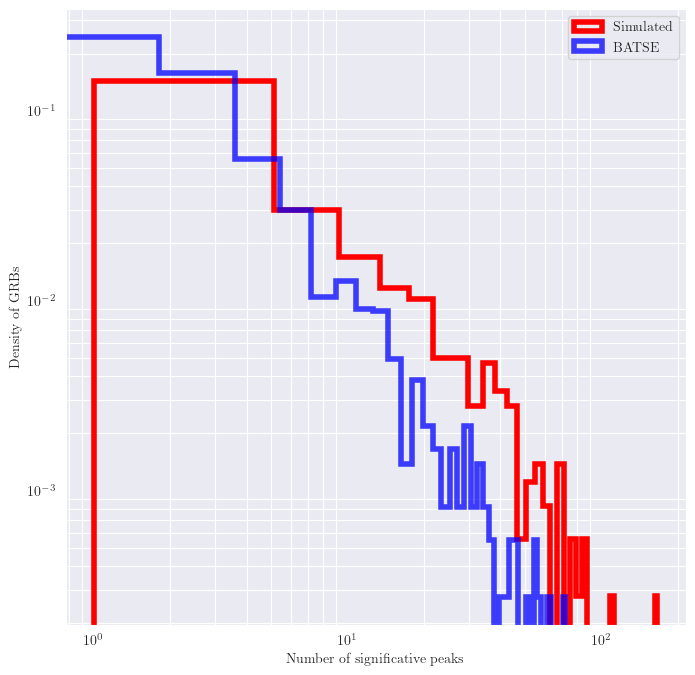

In [26]:
n_bins = 40
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(n_of_peaks_sim, 
        bins=n_bins, 
        label ='Simulated', 
        alpha=1.00,
        color='r',
        histtype='step',
        linewidth=4,
        density=True)

ax.hist(n_of_peaks_batse, 
        bins=n_bins,
        alpha=0.75,
        label='BATSE', 
        color='b',
        histtype='step',
        linewidth=4,
        density=True)

ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Density of GRBs')
ax.set_xlabel('Number of significative peaks')

## Test 5b: Number of significative peaks (MEPSA _real_ vs Peak count method)

In [11]:
# grb_list_test = load_lc_sim(path="C:/Users/Lisa/Desktop/batse_for_mepsa_test/")
# # apply constraints
# grb_list_test = apply_constraints(grb_list=grb_list_test, 
#                                        bin_time=bin_time_batse, 
#                                        t90_threshold=t90_threshold, 
#                                        sn_threshold=sn_threshold_batse, 
#                                        t_f=t_f)

100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Total number of simulated GRBs:  500
Total number of input GRBs:  500
GRBs with negative duration:  0
GRBs that satisfy the constraints:  500


In [12]:
# reb_factor = 32
# peak_sn_level = 5

# n_of_peaks_sim = [runMEPSA(mepsa_path, ex_pattern_path, grb.data_file_path, reb_factor, grb.name, peak_sn_level) for grb in tqdm(grb_list_test)]

100%|██████████| 500/500 [26:23<00:00,  3.17s/it]


In [28]:
# grb_name = range(500)

# gen_file = open("C:/Users/Lisa/Desktop/n_of_pulses.txt", 'r')
# good_pulses = []
# generated_pulses = []
# for line in gen_file:
#     good_pulses.append(float(line.split()[1]))
#     generated_pulses.append(float(line.split()[2]))

# mepsa_pulses = []
# for grb in grb_name:
#     mepsa_pulses.append(len(open('C:/Users/Lisa/Desktop/mepsa_32_reb/{0}.dat'.format(grb),'r').readlines()) -1 )

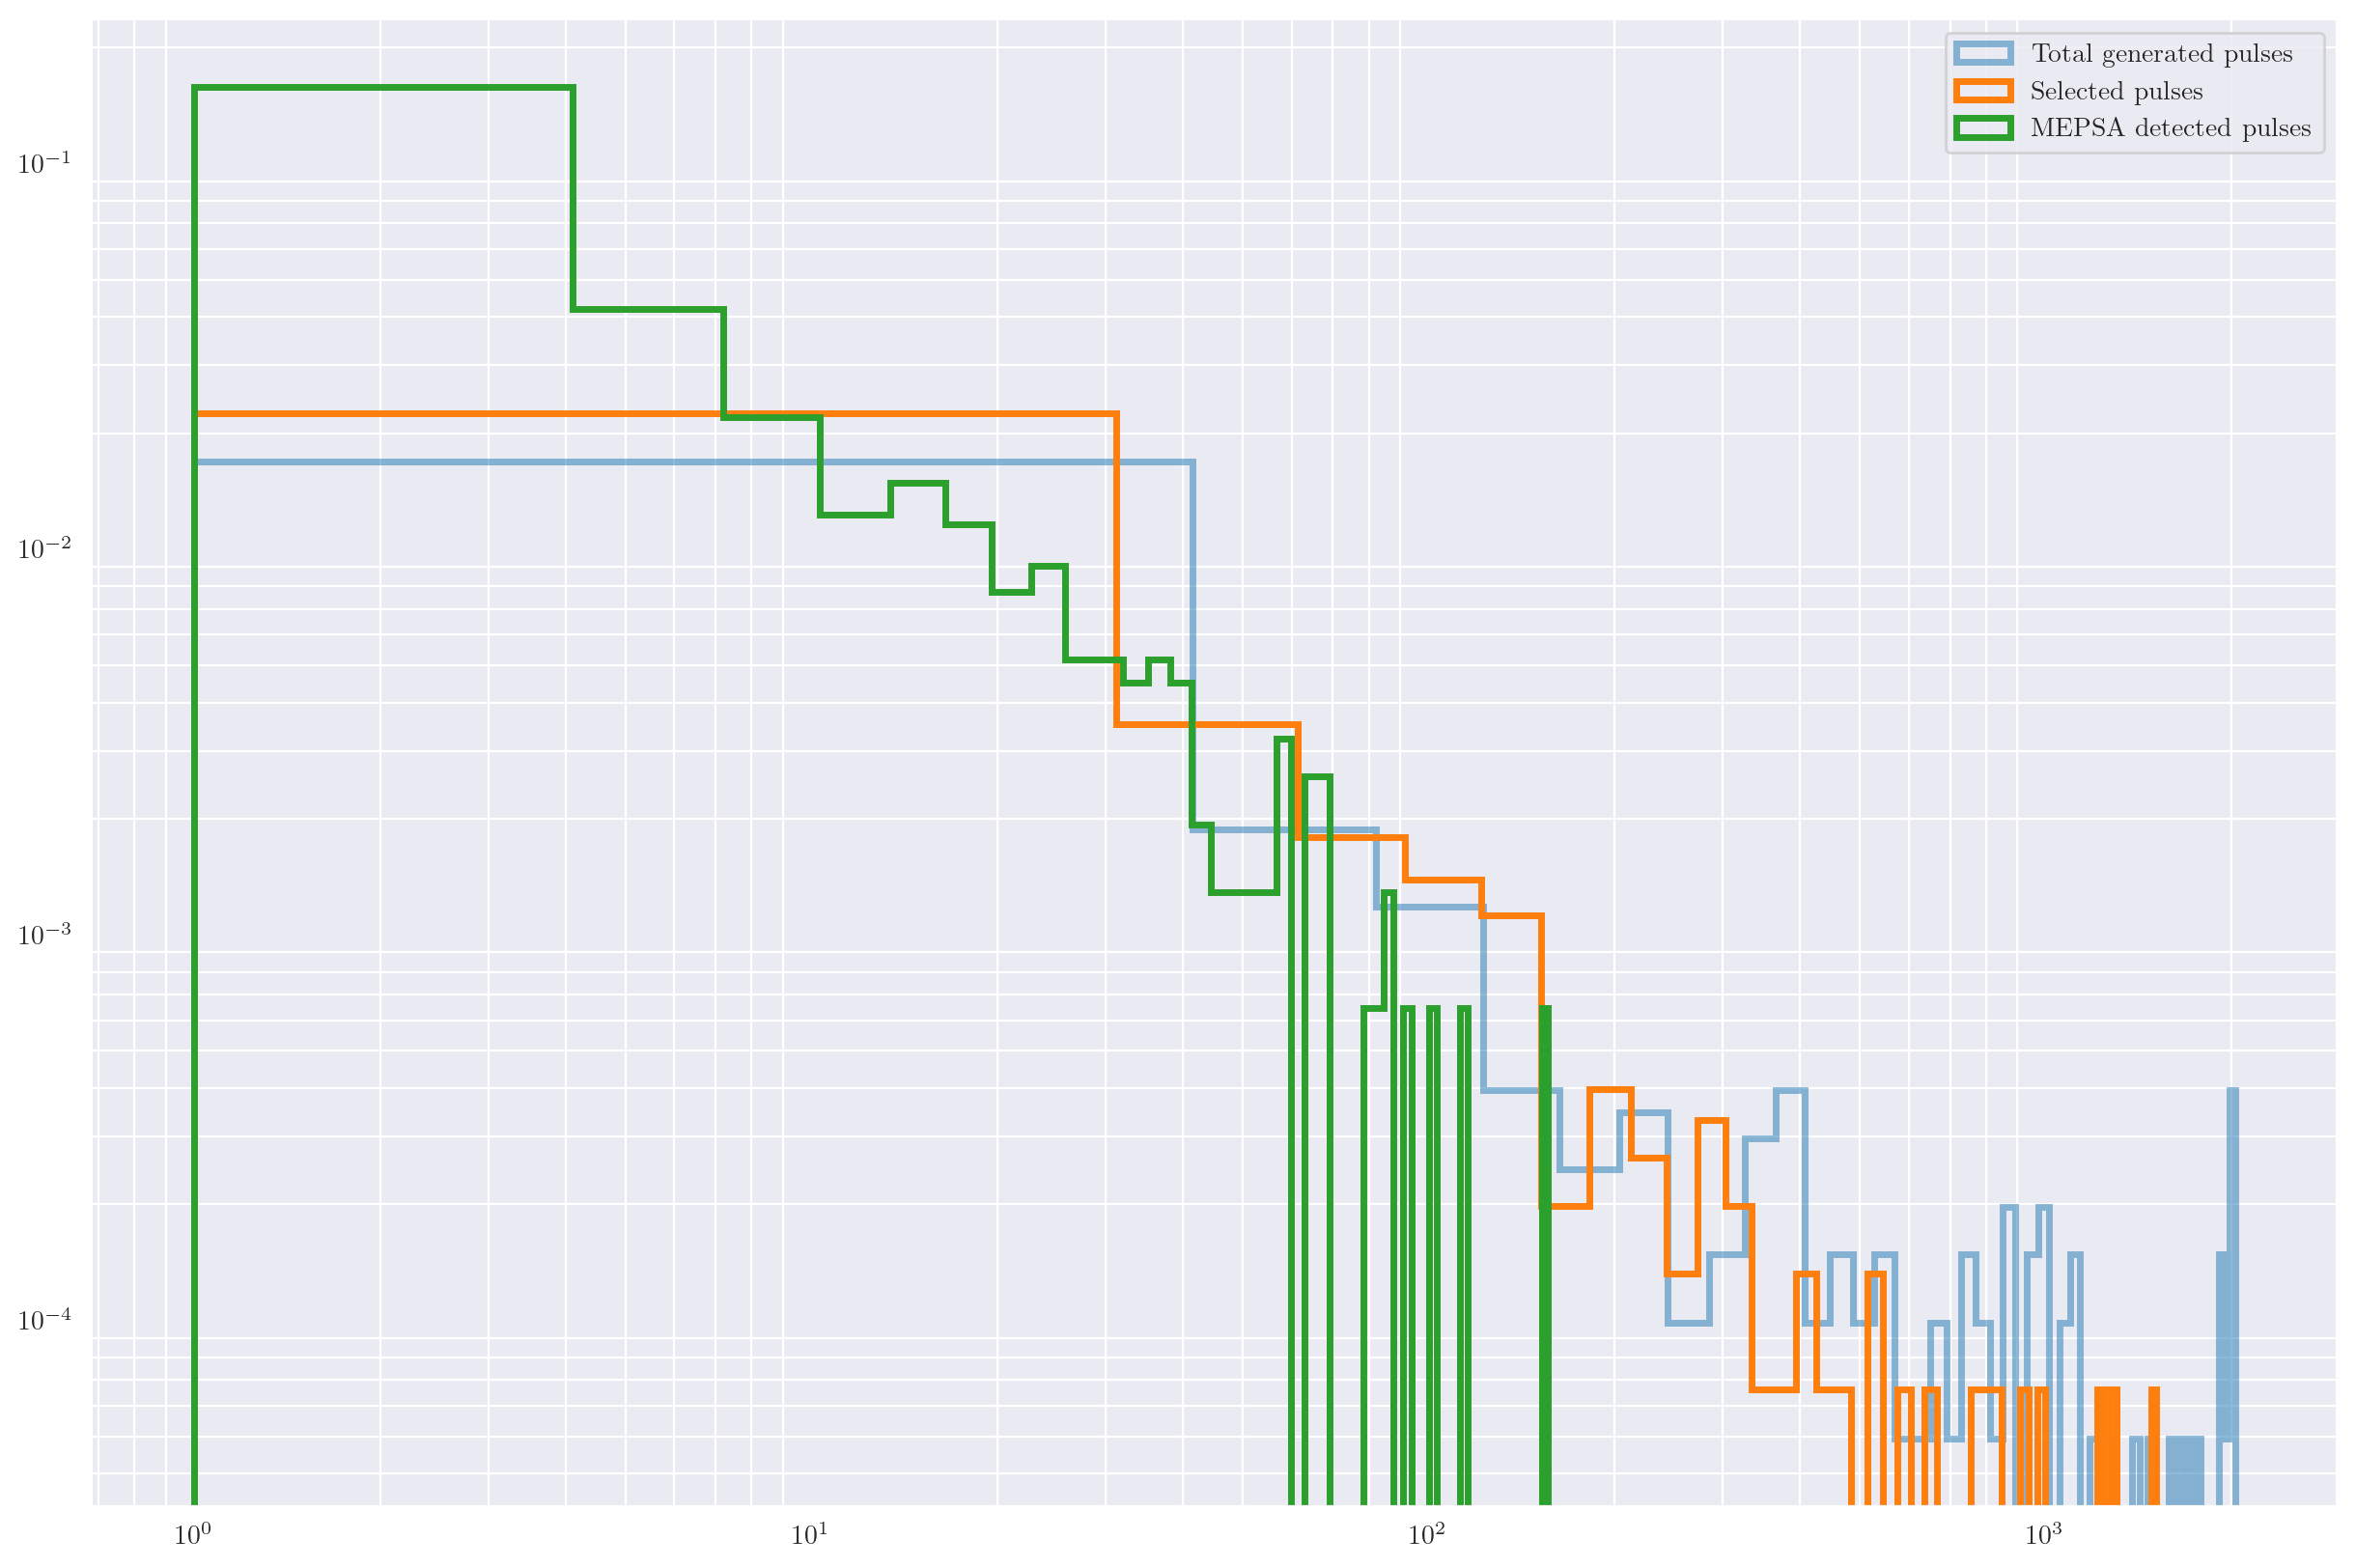

In [63]:
# fig = plt.figure(figsize = (15,10))
# ax = fig.add_subplot()
# ax.hist(generated_pulses, bins = 50, label = 'Total generated pulses', alpha = 0.5, histtype = 'step', linewidth = 2.5, density = True)
# ax.hist(good_pulses, bins = 50, label = 'Selected pulses', histtype = 'step', linewidth = 2.5, density = True)
# ax.hist(mepsa_pulses, bins = 50, label = 'MEPSA detected pulses', histtype = 'step', linewidth = 2.5, density = True)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.legend()
# ax.grid(which='both')

In [40]:
version    = '07'

#------------------------------------------------------------------------------#
# OUR CODE
#------------------------------------------------------------------------------#
if user=='AF':
    gen_file = open('E:/grb_to_test/MEPSA results/gen7/n_of_pulses.txt', 'r')
elif user=='LB':
    gen_file = open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/additional/v'+version+'/n_of_pulses.txt', 'r')
good_pulses = []
#generated_pulses = []
for line in gen_file:
    good_pulses.append(float(line.split()[0]))
    #generated_pulses.append(float(line.split()[2]))
n_of_pulses_sim = good_pulses

#------------------------------------------------------------------------------#
# MEPSA (simulati)
#------------------------------------------------------------------------------#
grb_name = range(2000)
mepsa_pulses = []
for grb in grb_name:
    if user=='AF':
        mepsa_pulses.append(len(open('E:/grb_to_test/MEPSA results/gen7/{0}.dat'.format(grb),'r').readlines()) -1 )
    elif user=='LB':
        mepsa_pulses.append(len(open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/{0}.dat'.format(grb),'r').readlines()) -1 )

MEPSA (BATSE) vs Peak count method (v7)
AD (p-value):  0.23997949397736684
KS (p-value):  0.33559098126008213

MEPSA (v7) vs Peak count method (v7)
AD (p-value):  0.25
KS (p-value):  0.9831368772656193


/var/folders/x0/m_j50m4x6_l77kk23zbp4gfm0000gn/T/ipykernel_6404/478649392.py:4: UserWarning: p-value capped: true value larger than 0.25
  res_ad = anderson_ksamp([distr_1,distr_2] )


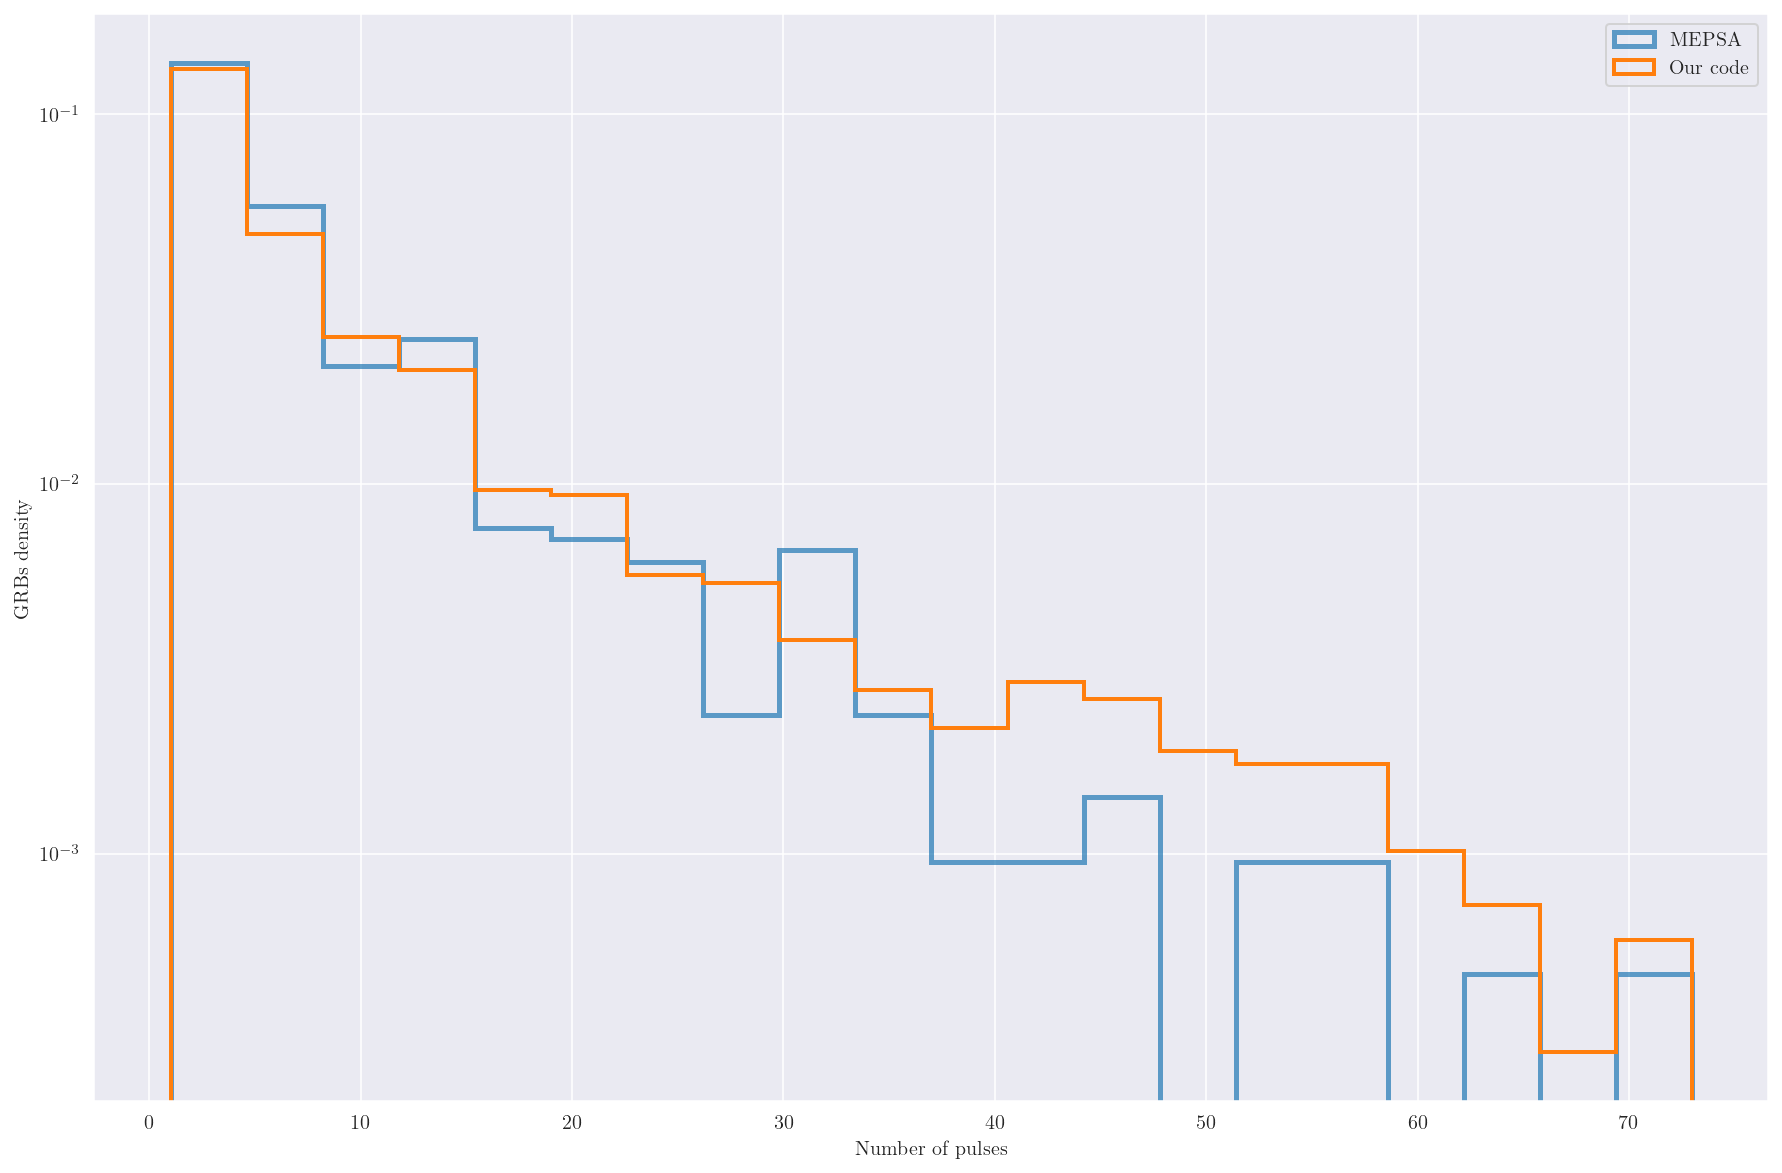

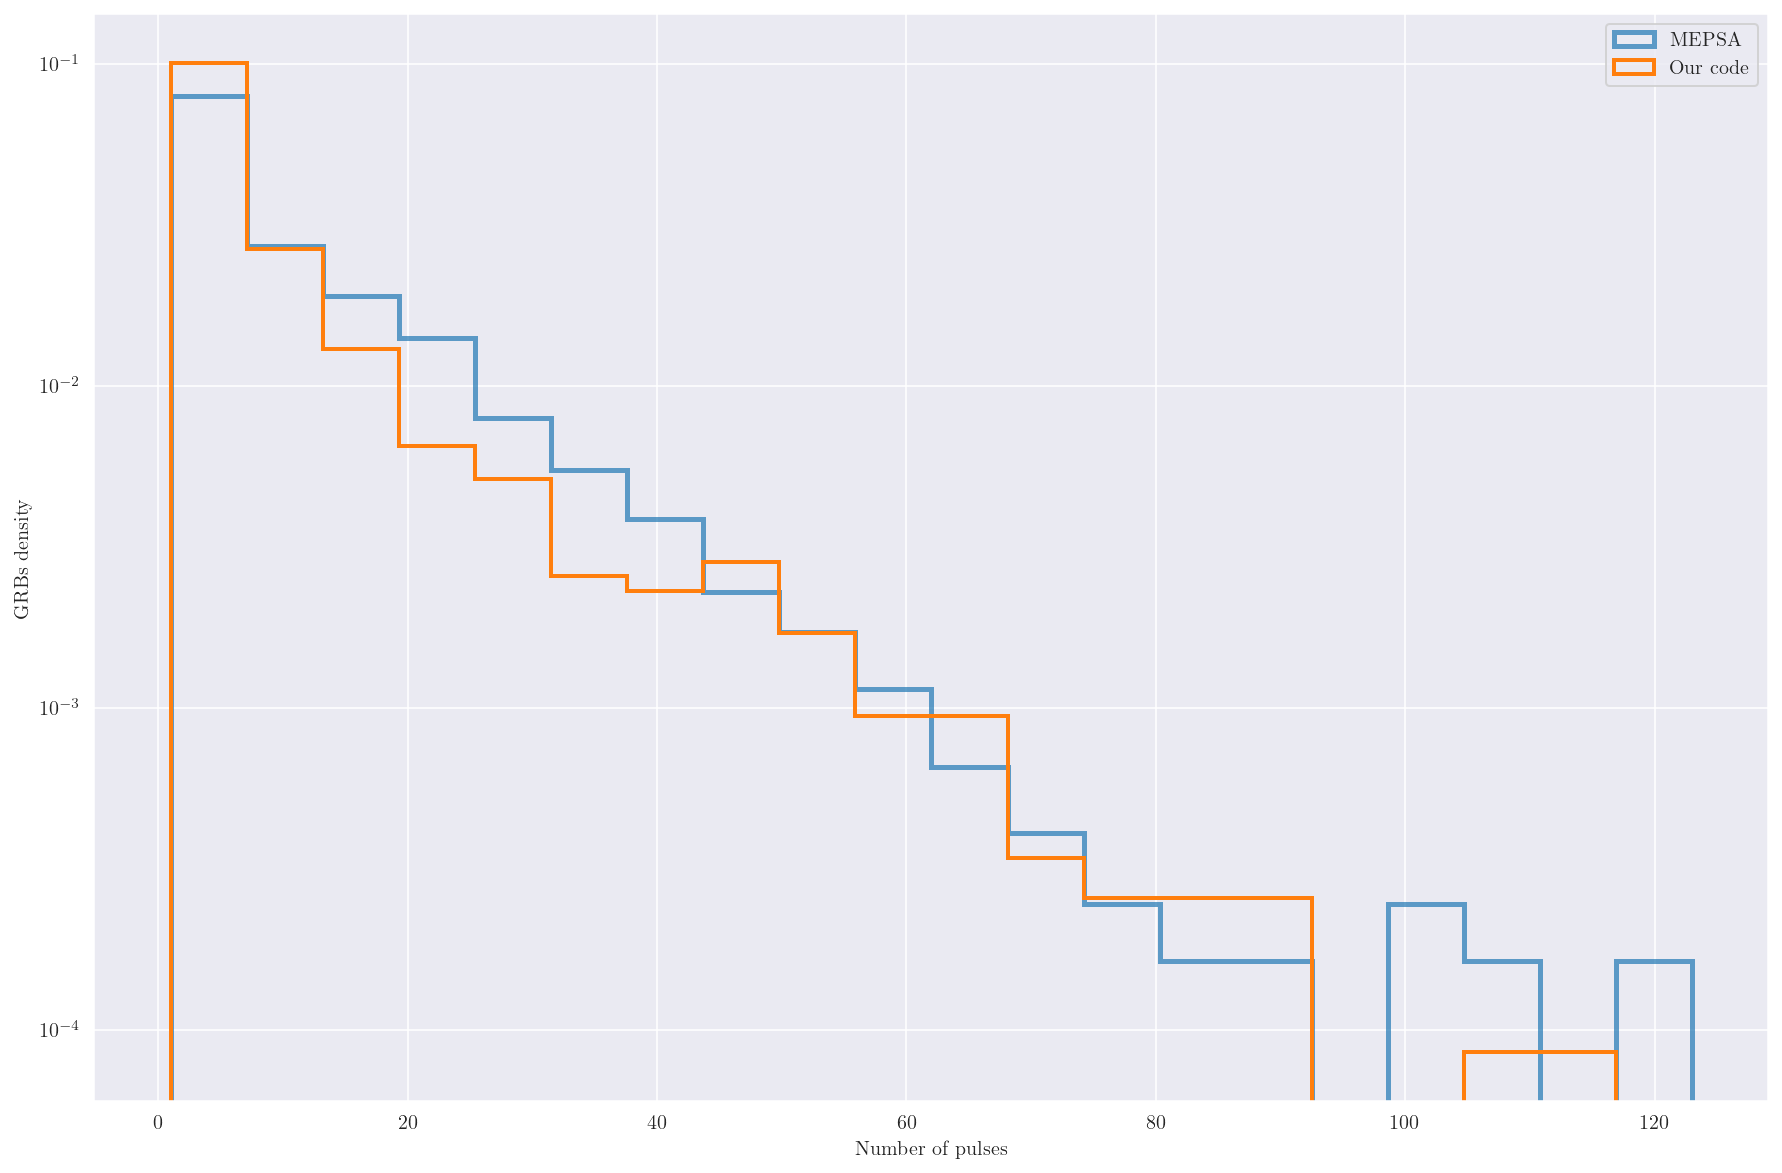

In [47]:
from scipy.stats import anderson_ksamp, ks_2samp

def perform_KS_AD(distr_1, distr_2):
    res_ad = anderson_ksamp([distr_1,distr_2] )
    res_ks = ks_2samp(distr_1,distr_2)
    print('AD (p-value): ', res_ad.significance_level)
    print('KS (p-value): ', res_ks.pvalue)
    return [res_ad.significance_level, res_ks.pvalue] 


#------------------------------------------------------------------------------#
n_bins = 20 # 'auto'
#------------------------------------------------------------------------------#

# MEPSA (BATSE) vs Peak count method (v7)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
#n_bins = 'auto'
n_mepsa, bins, patches = ax.hist(n_of_pulses,     bins=n_bins, label='MEPSA',    histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(n_of_pulses_sim, bins=bins,   label='Our code', histtype='step', linewidth=2.,  density=True)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.grid(which='both')
ax.set_xlabel('Number of pulses')
ax.set_ylabel('GRBs density')
ax.legend()
plt.plot()

print('MEPSA (BATSE) vs Peak count method (v7)')
_ = perform_KS_AD(n_good, n_mepsa)

#------------------------------------------------------------------------------#

# MEPSA (v7) vs Peak count method (v7)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
#n_bins = 'auto'
n_mepsa, bins, patches = ax.hist(mepsa_pulses,    bins=n_bins, label='MEPSA',    histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(n_of_pulses_sim, bins=bins,   label='Our code', histtype='step', linewidth=2.,  density=True)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.grid(which='both')
ax.set_xlabel('Number of pulses')
ax.set_ylabel('GRBs density')
ax.legend()
plt.plot()

print('\nMEPSA (v7) vs Peak count method (v7)')
_ = perform_KS_AD(n_good, n_mepsa)

#------------------------------------------------------------------------------#

# LOSS

In [26]:
test_pulse_distr = True
l2_loss_batse = compute_loss(averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
                             averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
                             acf=acf_batse,                                   acf_sim=acf_sim_batse,
                             duration=dur_distr_batse,                        duration_sim=dur_distr_sim_batse, 
                             n_of_pulses=n_of_pulses,                         n_of_pulses_sim=n_of_pulses_sim,   
                             test_pulse_distr=test_pulse_distr)

if test_pulse_distr:
    # Perform the AD 2-populations compatibility test between:
    # - la distribuzione del numero di impulsi calcolata da MEPSA (su dati BATSE)
    # - la distribuzione del numero di impulsi calcolato con il nostro codice (sulla simulazione corrente)
    n_mepsa_real, bins = np.histogram(n_of_pulses,     bins='auto', density=True)
    n_peaks_sim,     _ = np.histogram(n_of_pulses_sim, bins=bins,   density=True)
    p_AD               = AD_2pop_test(distr_1=n_mepsa_real, 
                                      distr_2=n_peaks_sim)
    l_AD               = loss_AD(p_AD=p_AD)
    print('p-value of the AD-test: ', p_AD)
    
print('Total loss for BATSE:', l2_loss_batse)

p-value of the AD-test:  0.03755936559927489
Total loss for BATSE: 0.5813153220961844


In [35]:
test_pulse_distr = False
l2_loss_swift = compute_loss(averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
                             averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
                             acf=acf_swift,                                   acf_sim=acf_sim_swift,
                             duration=dur_distr_swift,                        duration_sim=dur_distr_sim_swift, 
                             n_of_pulses=None,                                n_of_pulses_sim=None,   
                             test_pulse_distr=test_pulse_distr)

print('Total loss for Swift:', l2_loss_swift)

Loss for Swift: 1.8153860467853091


In [36]:
test_pulse_distr = False
l2_loss_sax = compute_loss(averaged_fluxes=averaged_fluxes_sax,           averaged_fluxes_sim=averaged_fluxes_sim_sax,
                           averaged_fluxes_cube=averaged_fluxes_cube_sax, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax,
                           acf=acf_sax,                                   acf_sim=acf_sim_sax,
                           duration=dur_distr_sax,                        duration_sim=dur_distr_sim_sax, 
                           n_of_pulses=None,                              n_of_pulses_sim=None,   
                           test_pulse_distr=test_pulse_distr)

print('Total loss for BeppoSAX:', l2_loss_sax)

NameError: name 'averaged_fluxes_sax' is not defined

# PLOTS

p-value for KS test on the duration times distribution: 0.39
p-value for AD test on the duration times distribution: > 0.25

#### BATSE

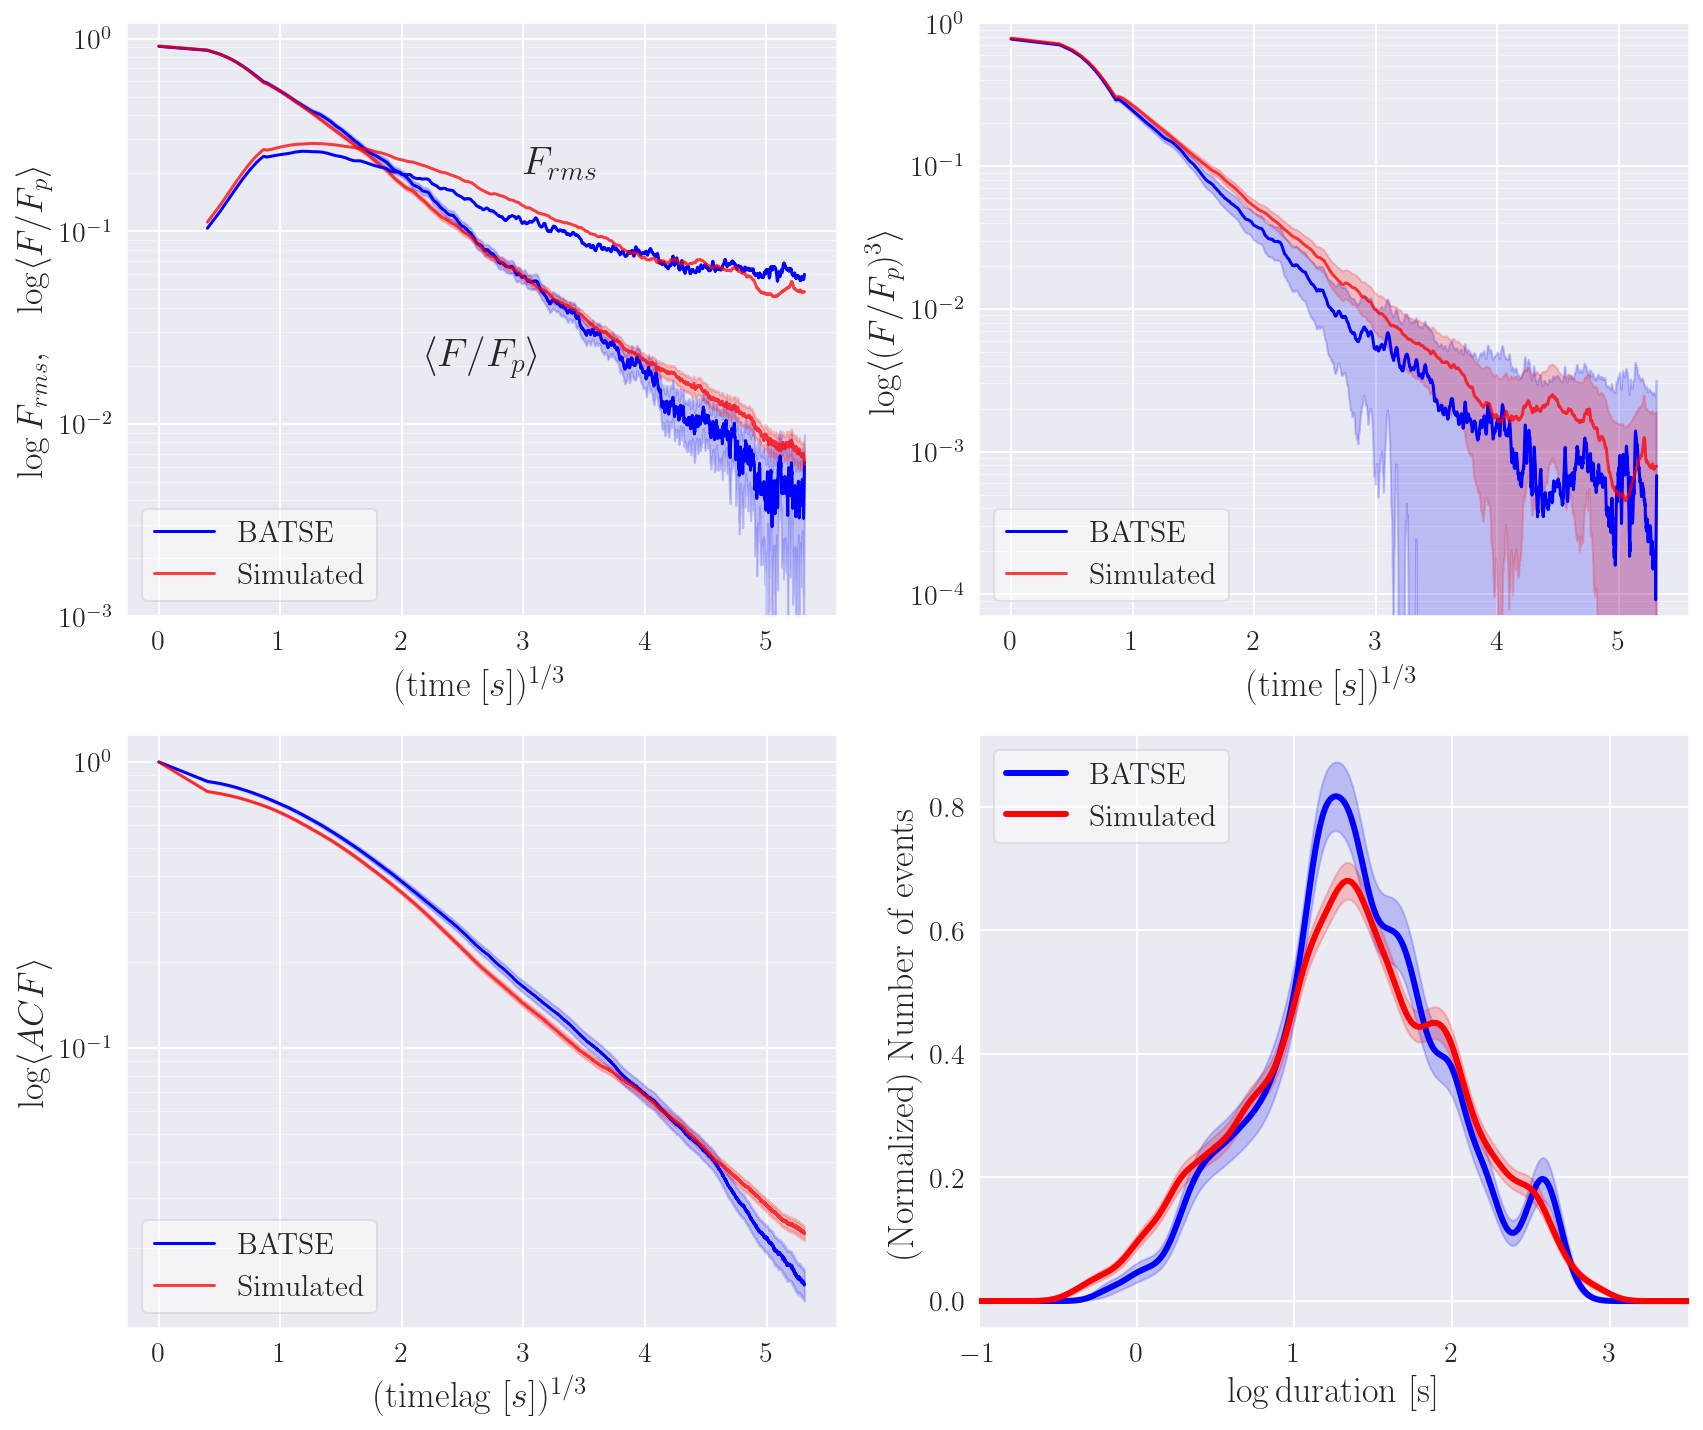

In [48]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, 
          acf=acf_batse,                                   acf_sim=acf_sim_batse,
          duration=duration_batse,                         duration_sim=duration_sim_batse,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_batse),                          n_grb_sim=len(grb_list_sim_batse),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
          acf_rms=acf_rms_batse,                                   acf_rms_sim=acf_rms_sim_batse,
          save_fig=True, name_fig='4observables_v7.pdf')

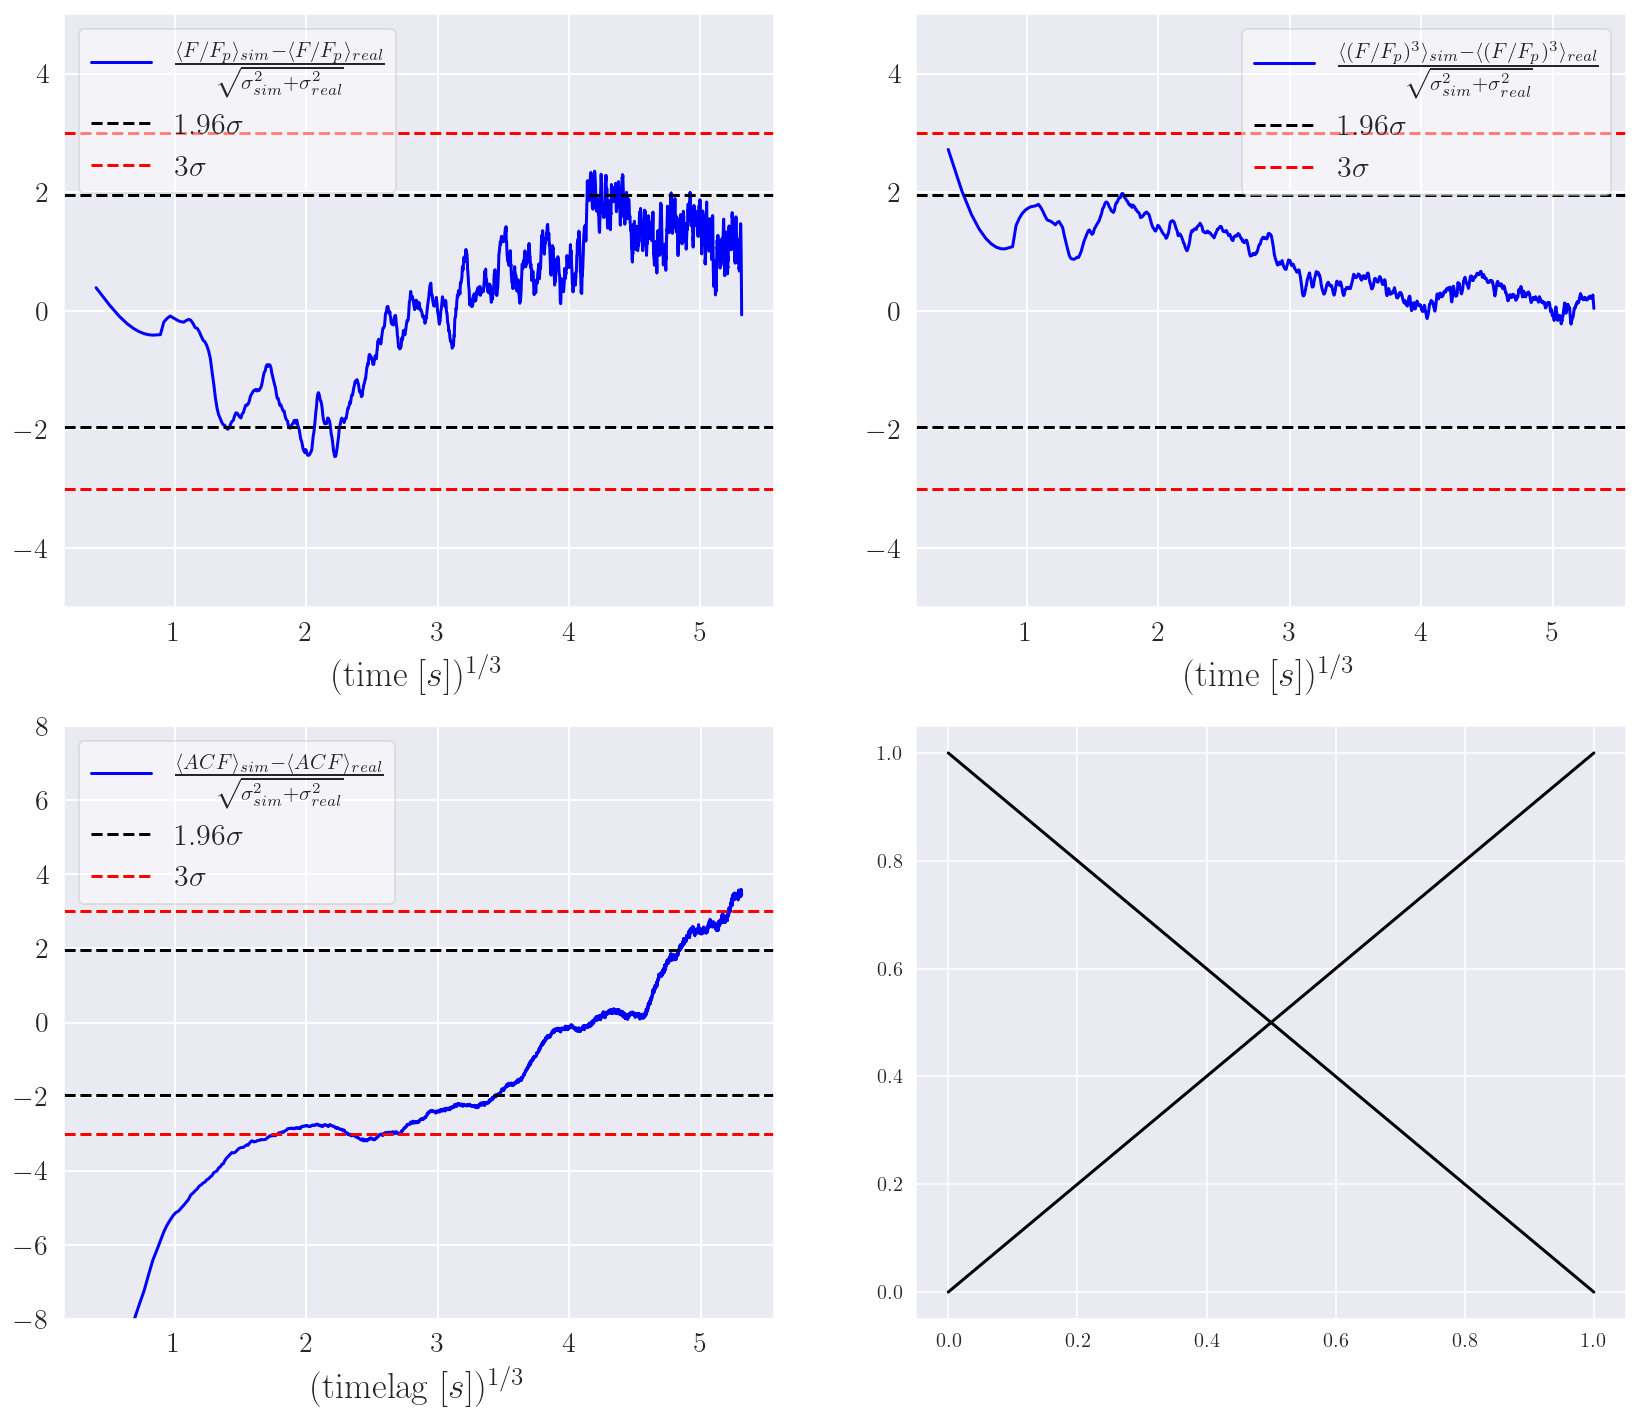

In [16]:
make_plot_errs(test_times=test_times_batse, 
               # plot 1
               averaged_fluxes=averaged_fluxes_batse,           
               averaged_fluxes_sim=averaged_fluxes_sim_batse,
               averaged_fluxes_rms=averaged_fluxes_rms_batse,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_batse, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
               # plot 3
               steps=steps_batse,  
               bin_time=bin_time_batse, 
               acf=acf_batse,
               acf_sim=acf_sim_batse,
               acf_rms=acf_rms_batse,
               acf_rms_sim=acf_rms_sim_batse,
               # plot 4
               duration=duration_batse, 
               duration_sim=duration_sim_batse,
               #
               n_grb_real=len(grb_list_batse),
               n_grb_sim=len(grb_list_sim_batse))

#### Swift

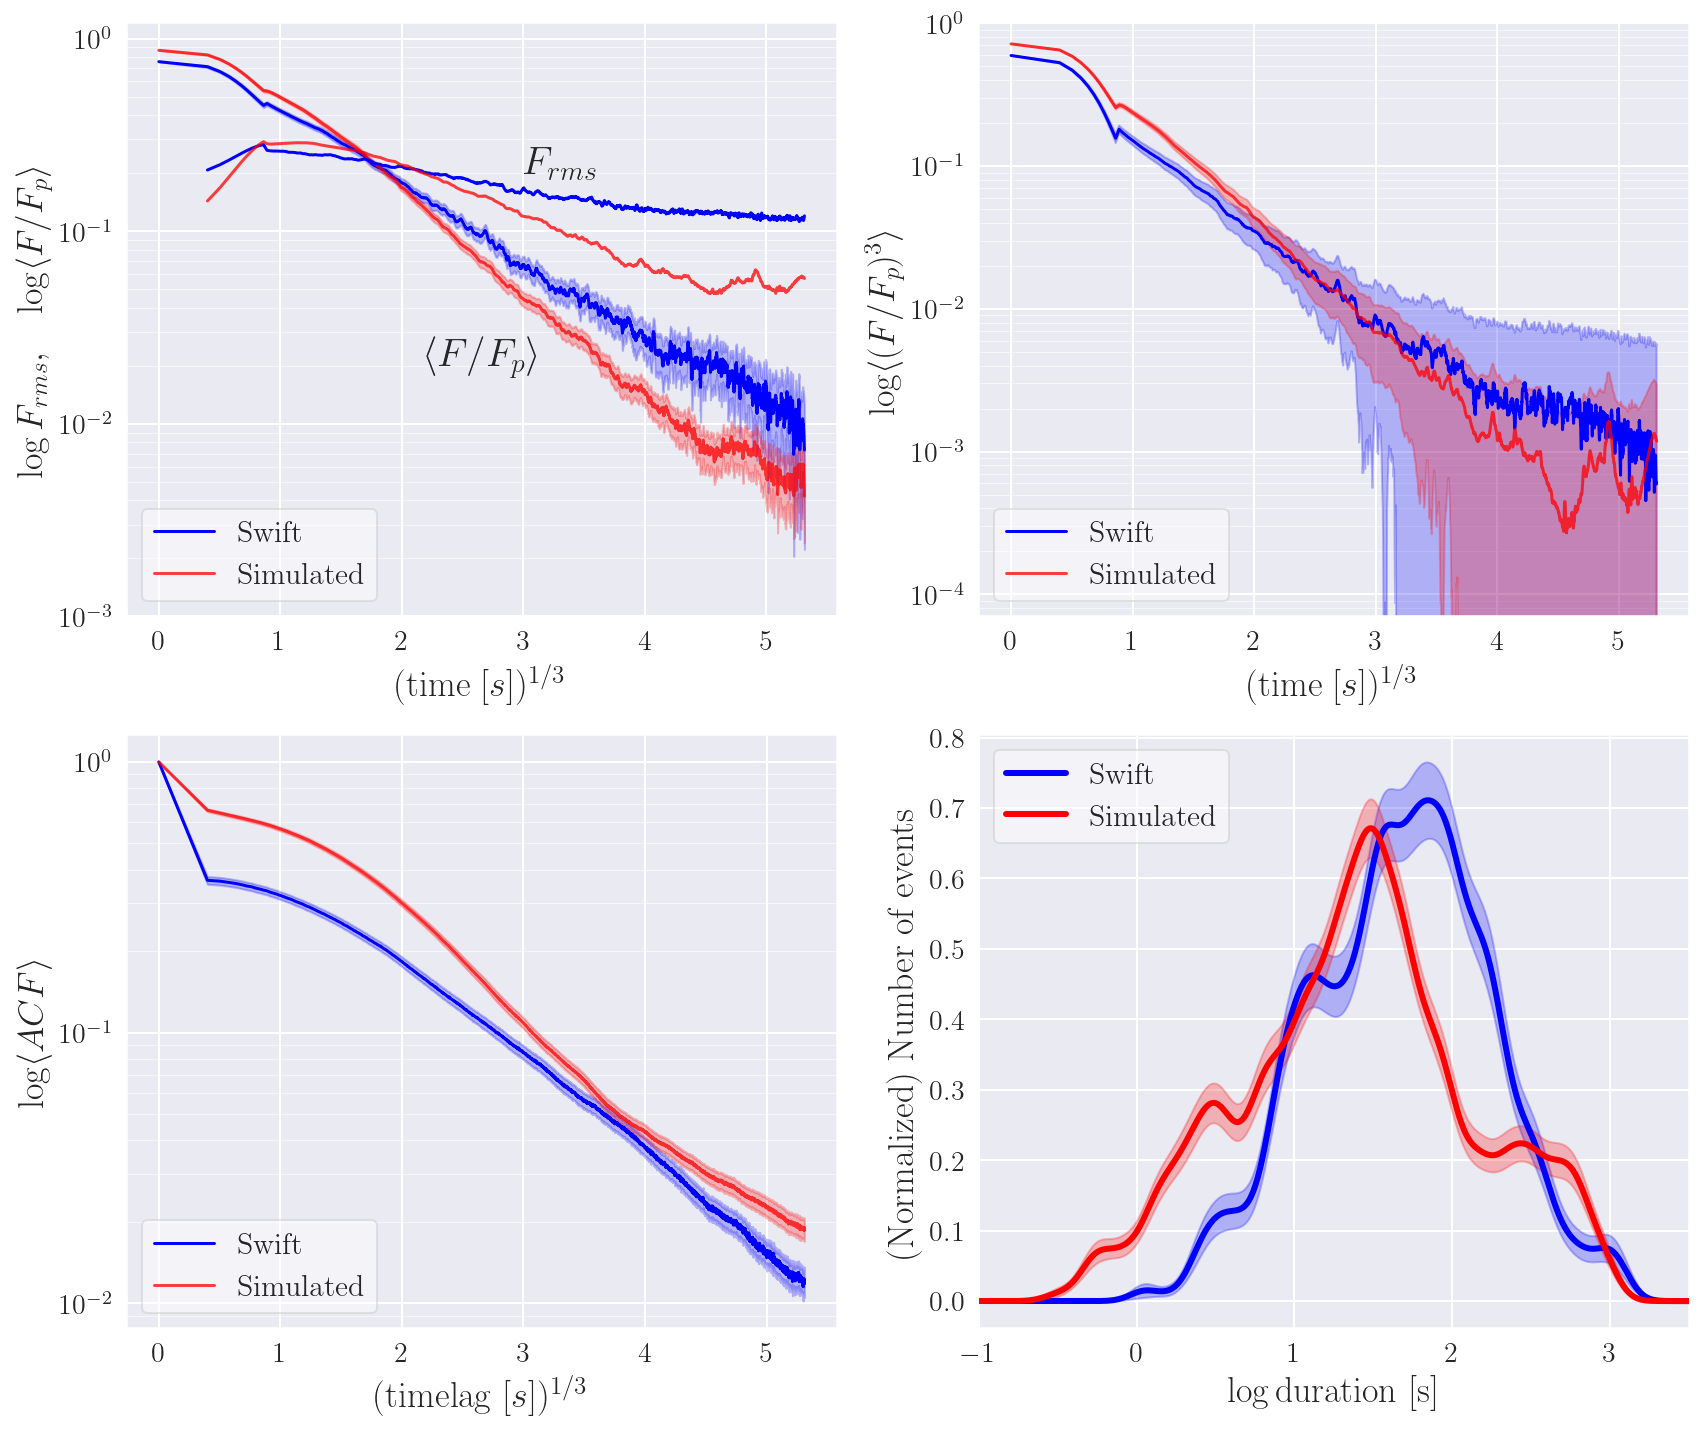

In [36]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, 
          acf=acf_swift,                                   acf_sim=acf_sim_swift,
          duration=duration_swift,                         duration_sim=duration_sim_swift,
          # mode
          log=True, hist=True, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_swift),                          n_grb_sim=len(grb_list_sim_swift),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
          acf_rms=acf_rms_swift,                                   acf_rms_sim=acf_rms_sim_swift)


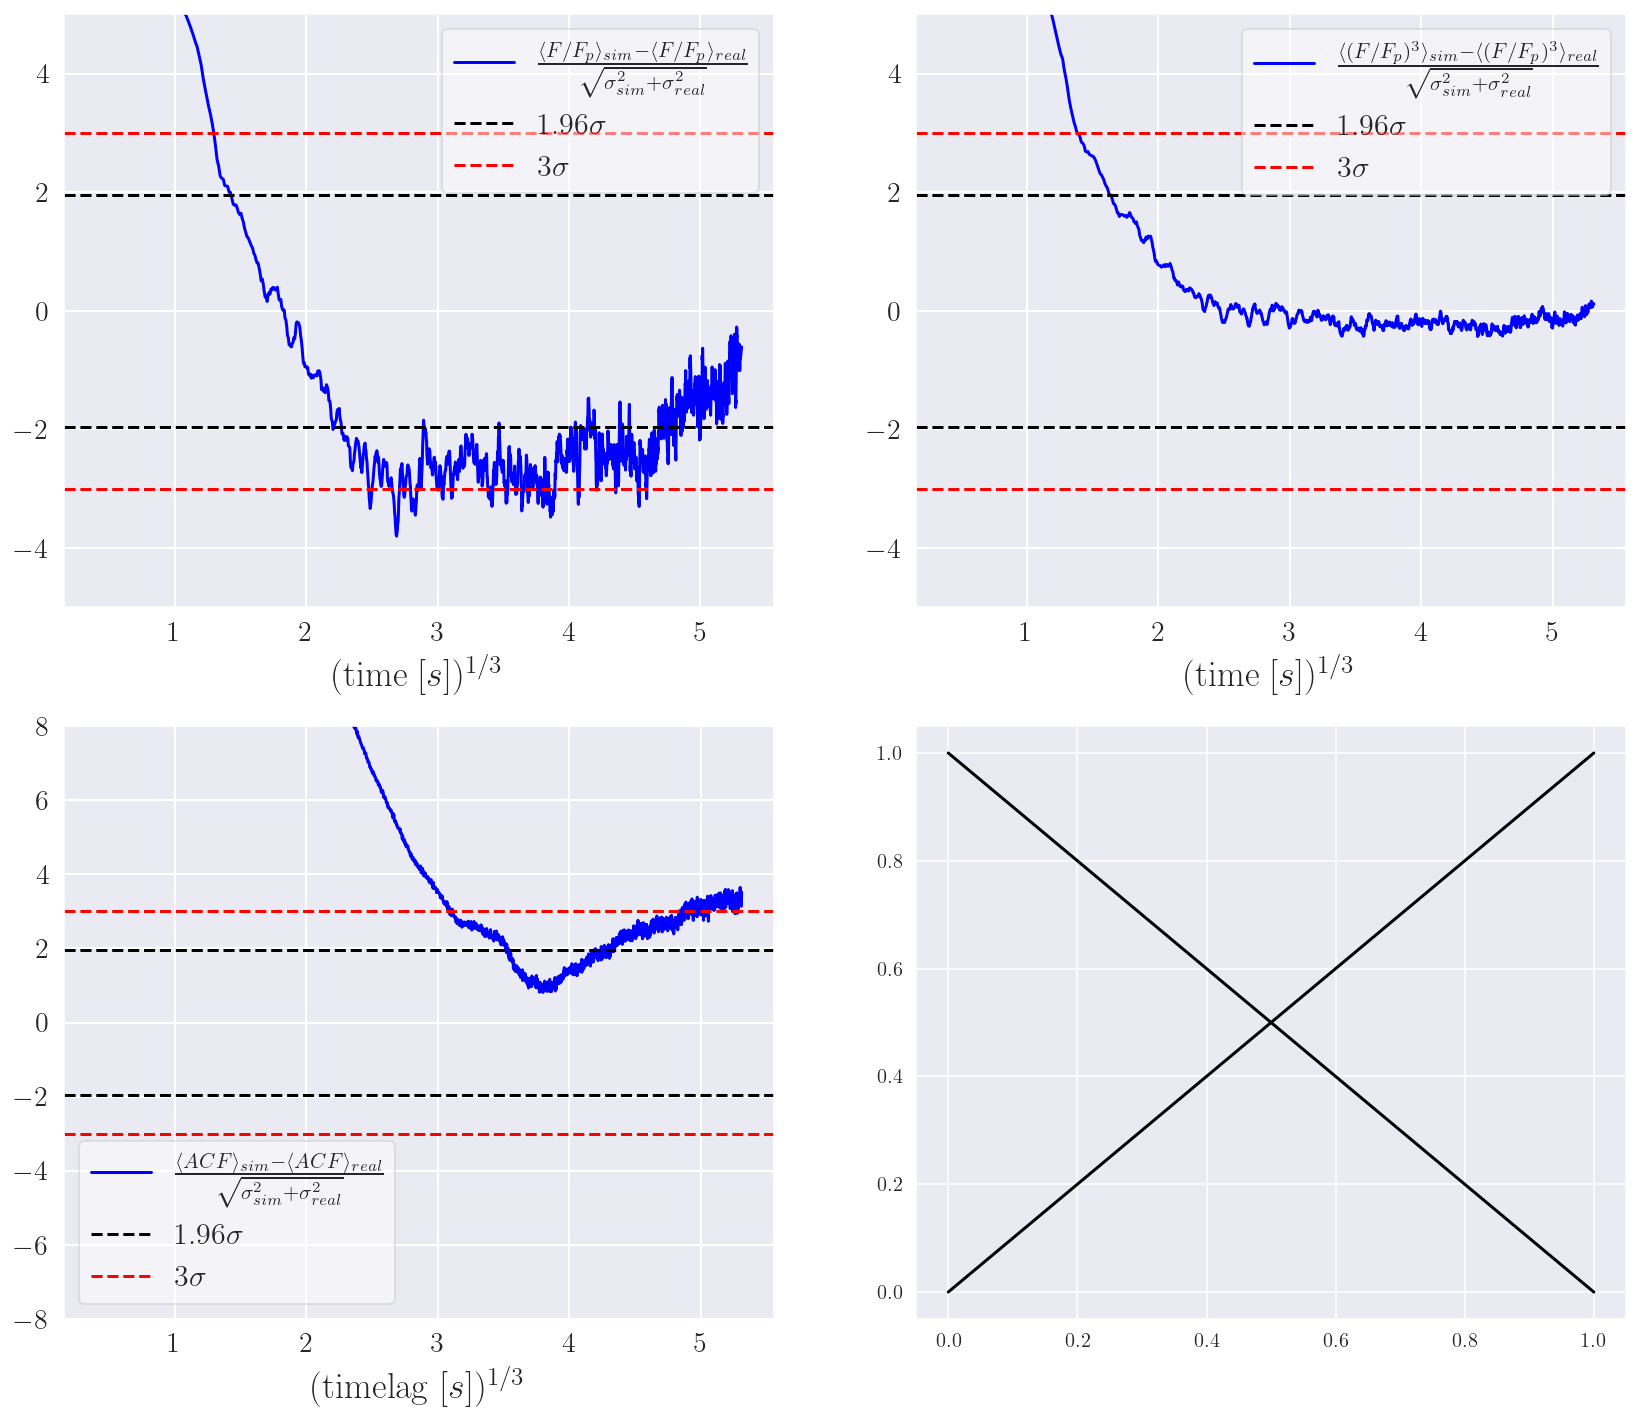

In [42]:
make_plot_errs(test_times=test_times_swift, 
               # plot 1
               averaged_fluxes=averaged_fluxes_swift,           
               averaged_fluxes_sim=averaged_fluxes_sim_swift,
               averaged_fluxes_rms=averaged_fluxes_rms_swift,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_swift, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
               # plot 3
               steps=steps_swift,  
               bin_time=bin_time_swift, 
               acf=acf_swift,
               acf_sim=acf_sim_swift,
               acf_rms=acf_rms_swift,
               acf_rms_sim=acf_rms_sim_swift,
               # plot 4
               duration=duration_swift, 
               duration_sim=duration_sim_swift,
               #
               n_grb_real=len(grb_list_swift),
               n_grb_sim=len(grb_list_sim_swift))

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


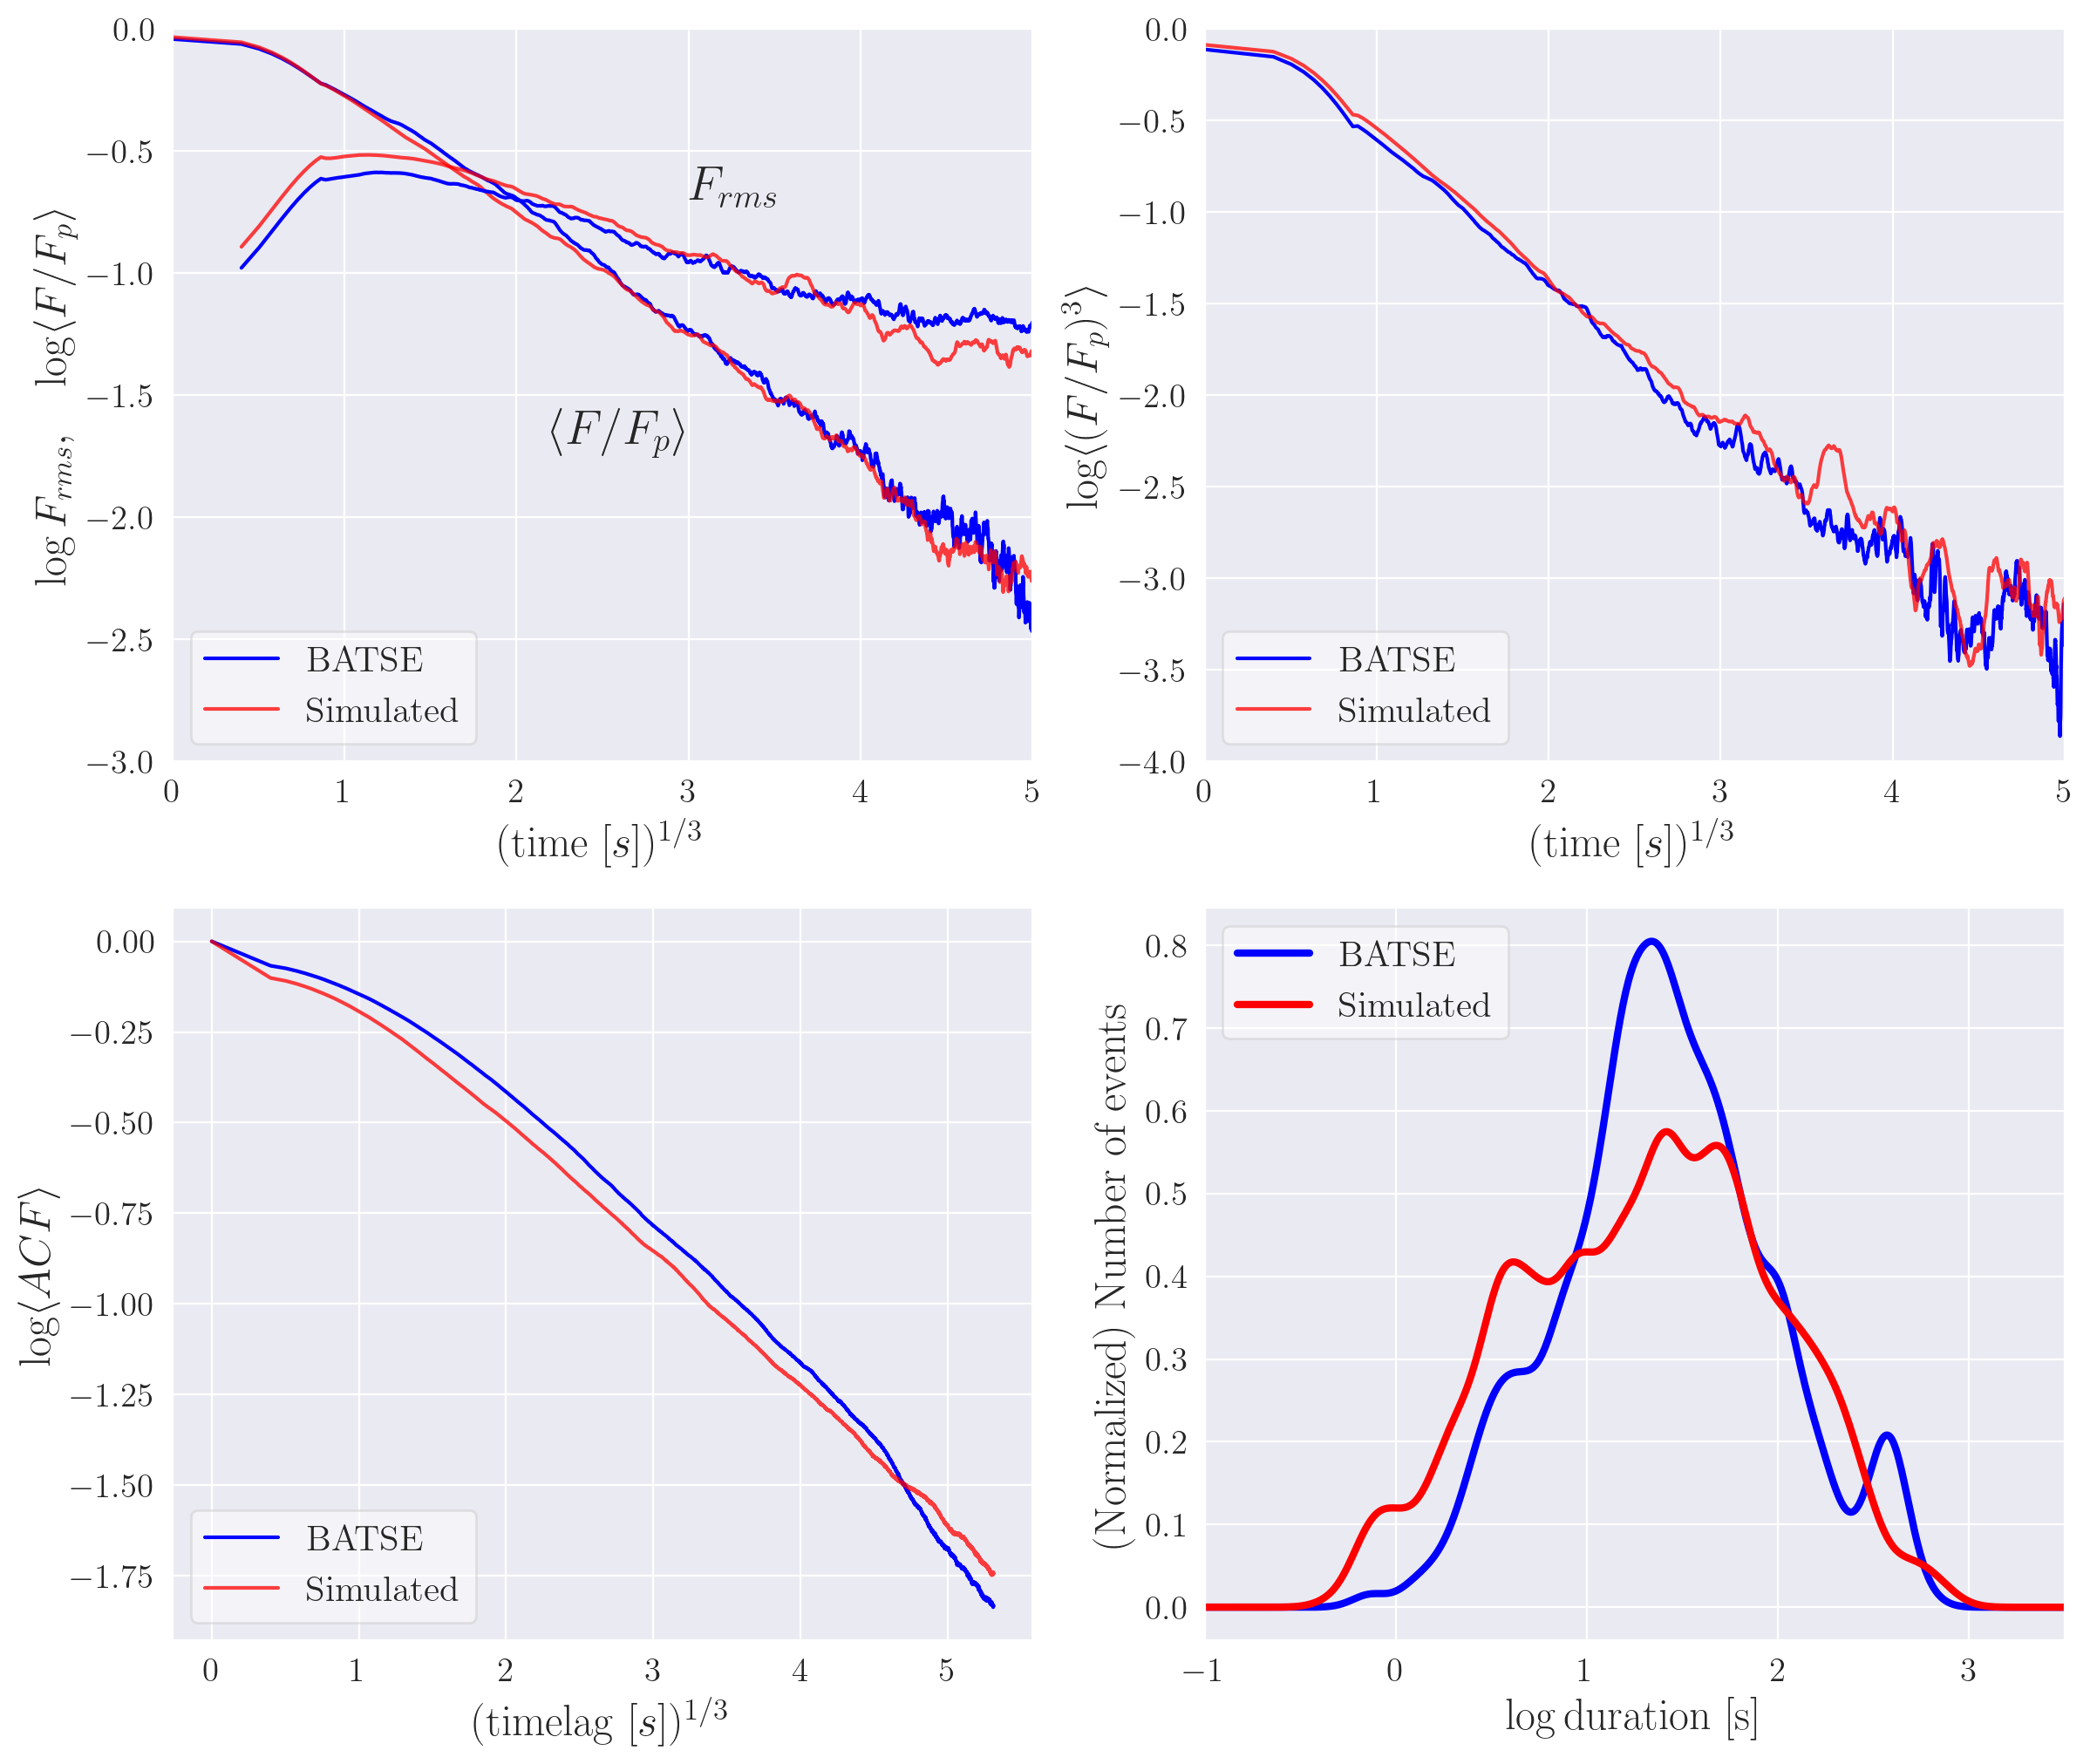

In [37]:
# 7 PARAMETERS FROM THE PAPER
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim_batse,
          duration=duration_batse, duration_sim=duration_sim_batse)

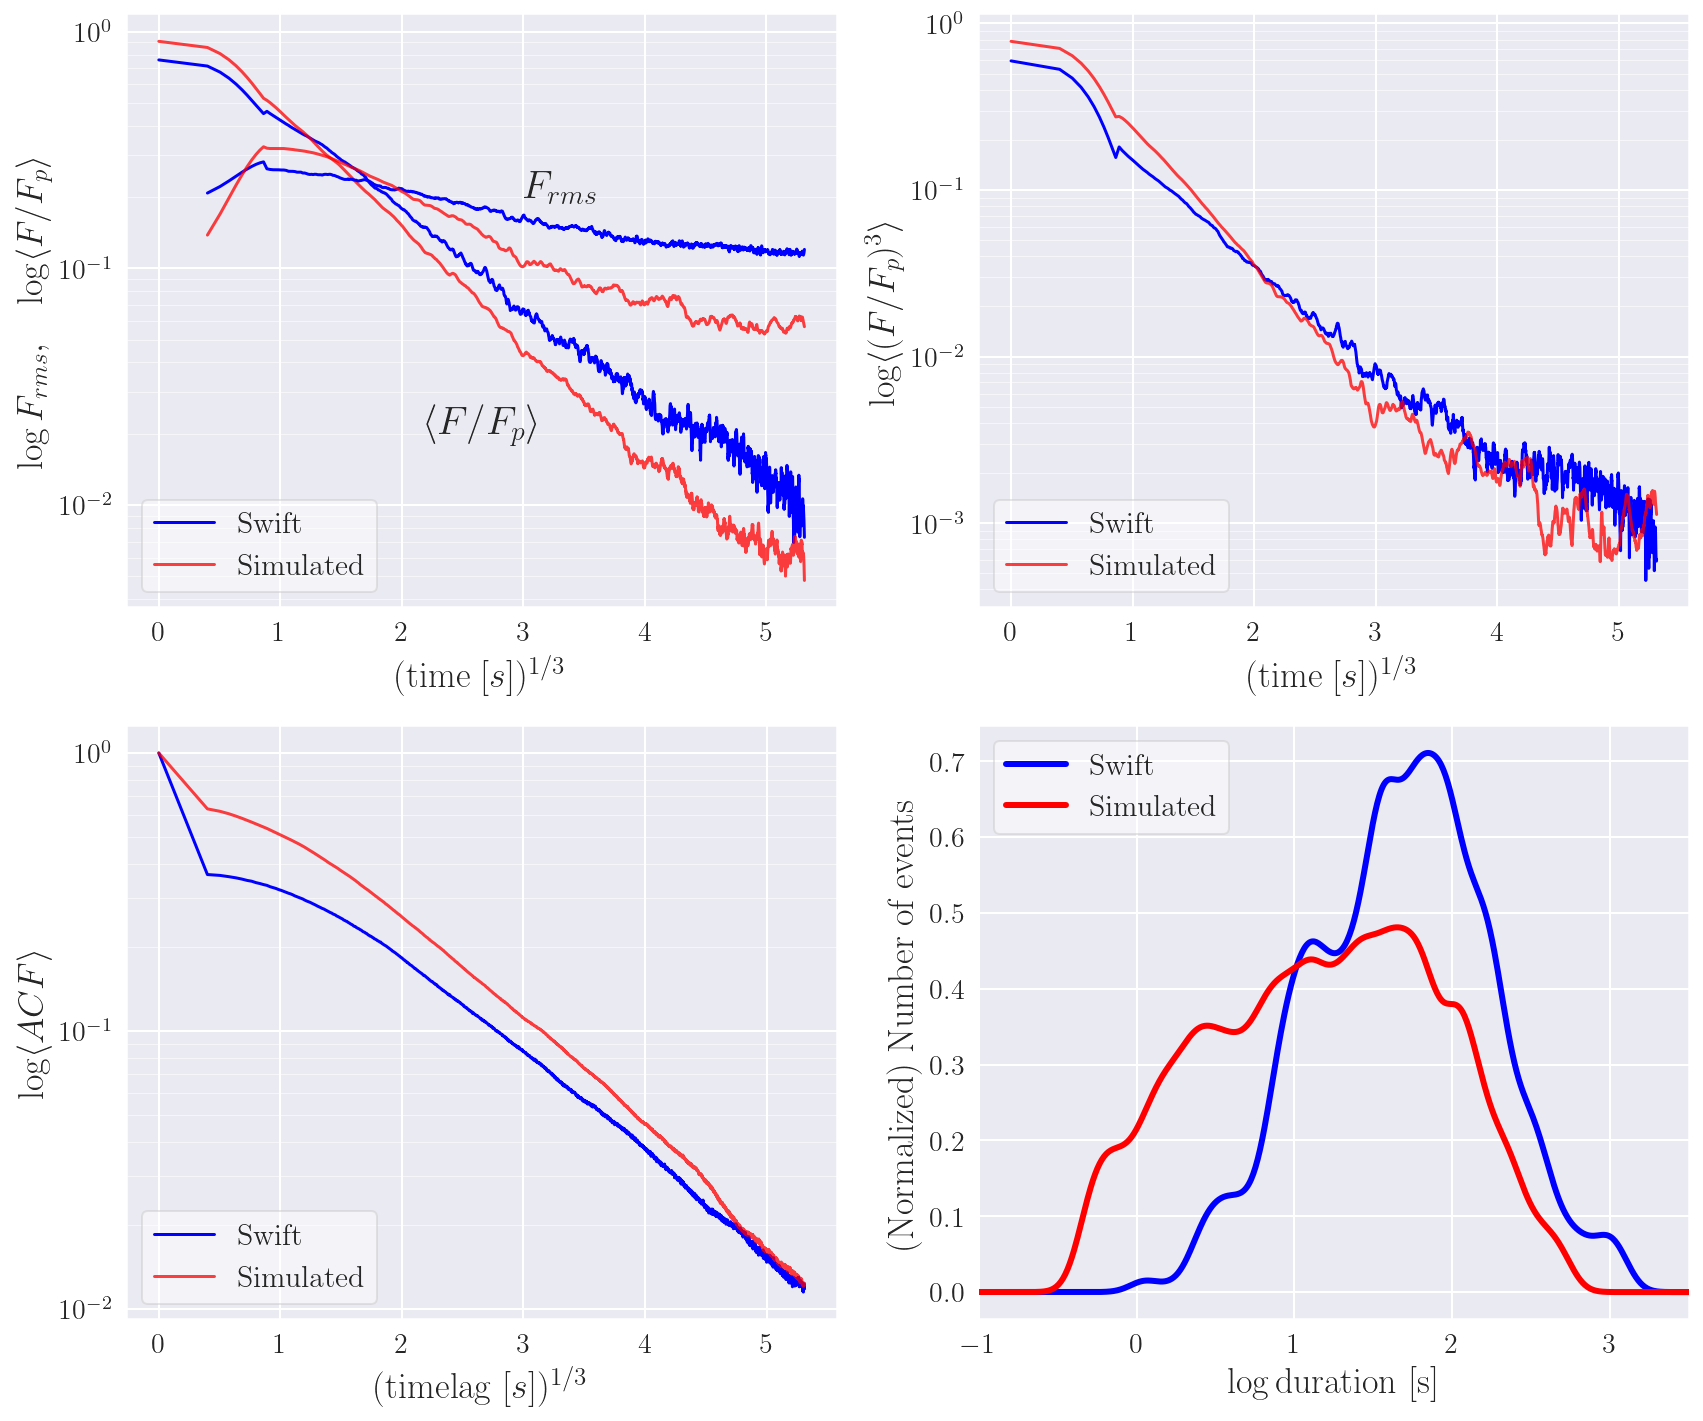

In [25]:
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, acf=acf_swift, acf_sim=acf_sim_swift,
          duration=duration_swift, duration_sim=duration_sim_swift)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


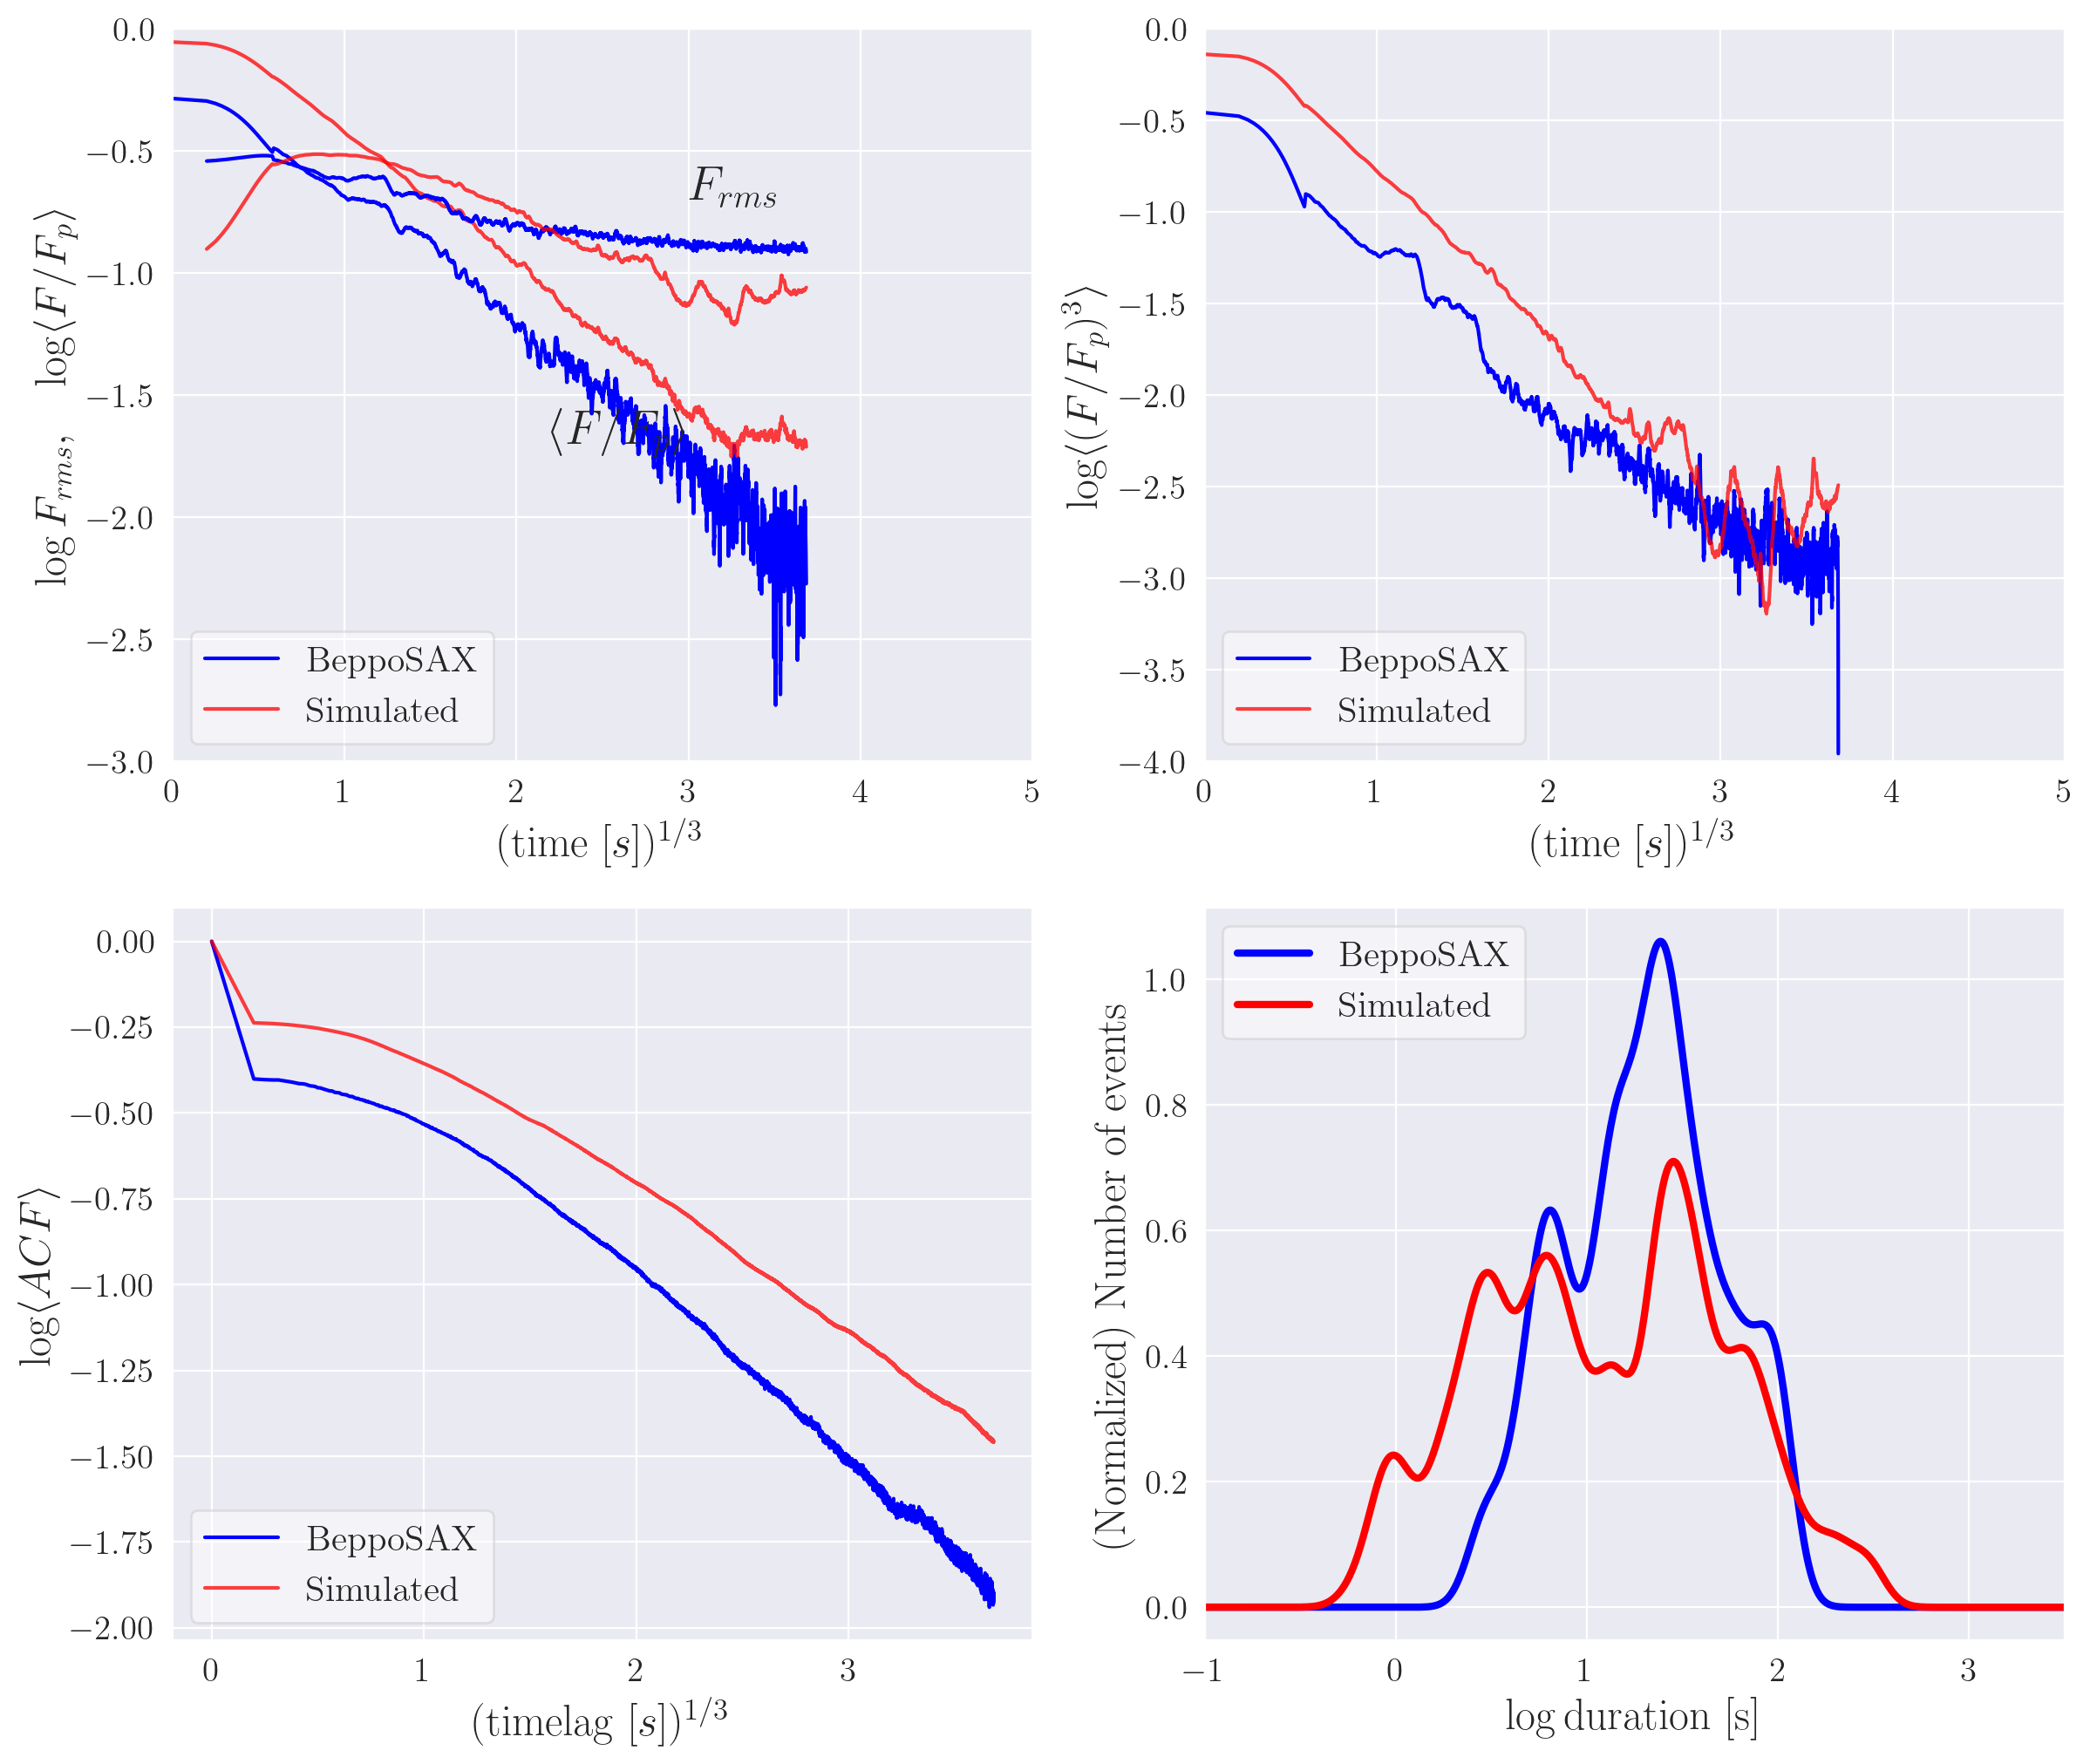

In [39]:
make_plot(instrument='sax',
          test_times=test_times_sax_hr, 
          averaged_fluxes=averaged_fluxes_sax_hr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_hr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_hr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_hr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_hr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_hr,
          steps=steps_sax_hr, steps_sim=steps_sim_sax_hr, bin_time=bin_time_sax_hr, acf=acf_sax_hr, acf_sim=acf_sim_sax_hr,
          duration=duration_sax_hr, duration_sim=duration_sim_sax_hr)

c:\Users\Lisa\Documents\GitHub\lc_pulse_avalanche\statistical_test\statistical_test.py:874: RuntimeWarning: invalid value encountered in log10
  averaged_fluxes          = np.log10(averaged_fluxes)


- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


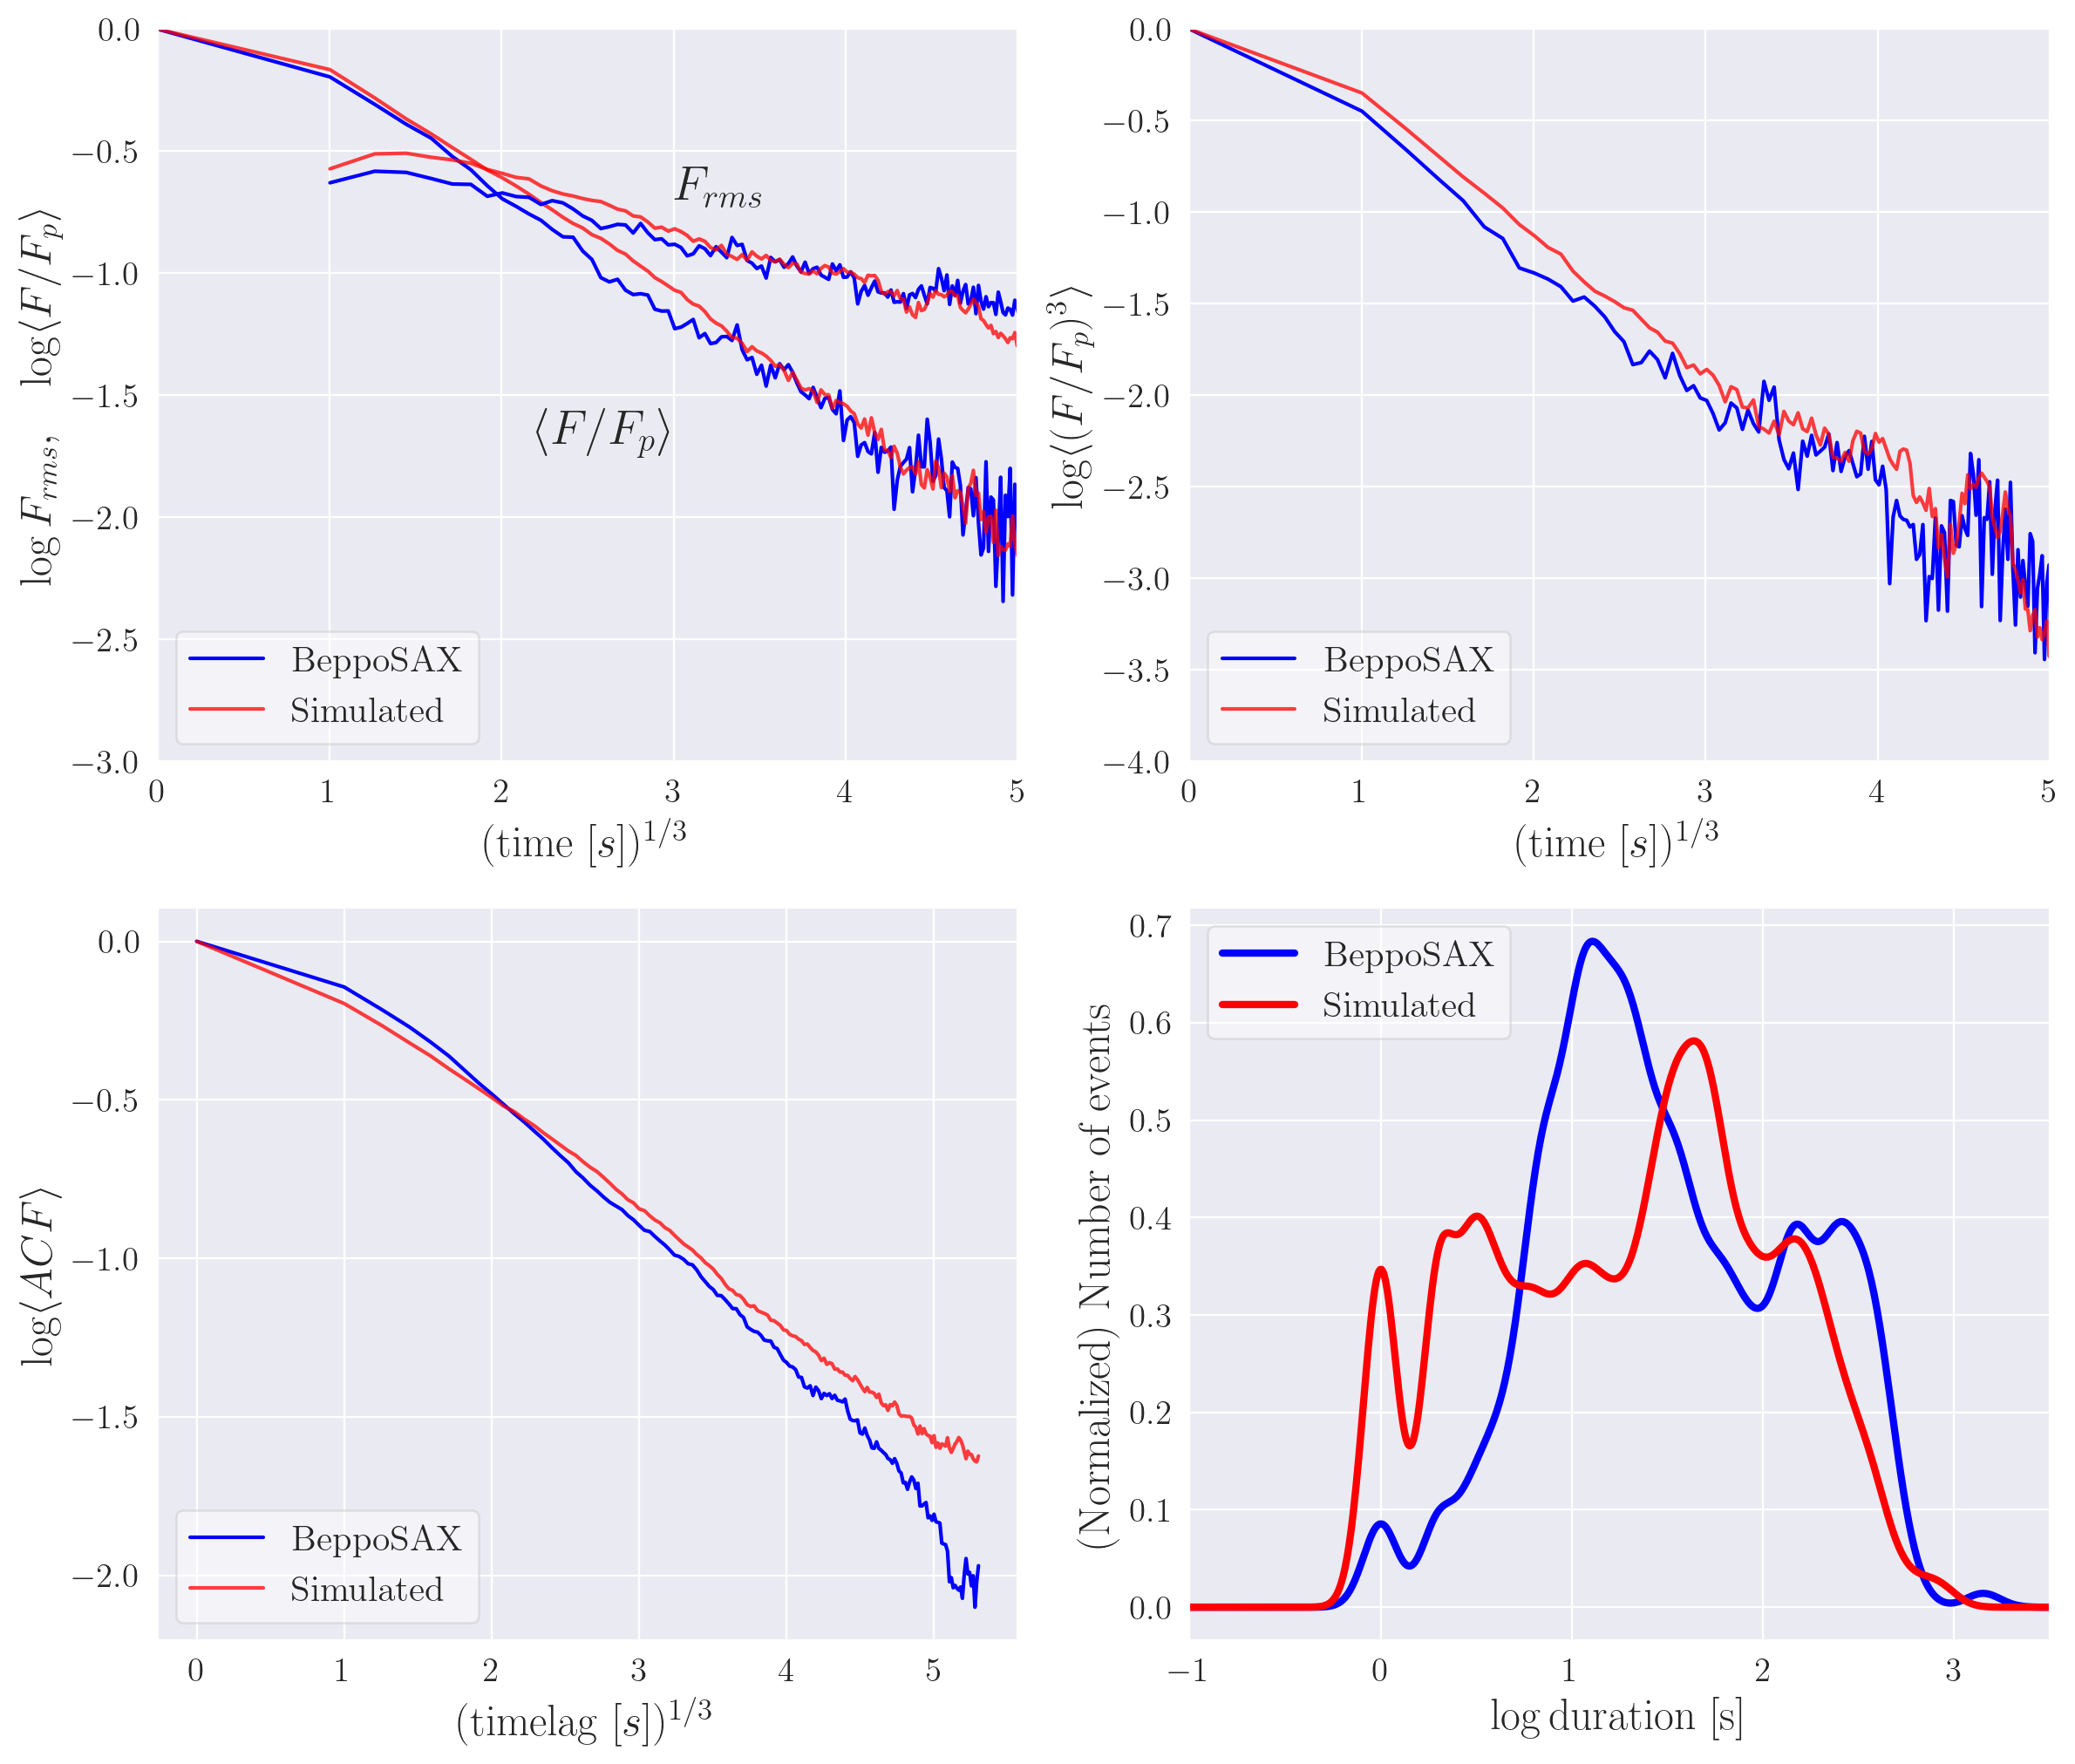

In [46]:
make_plot(instrument='sax',
          test_times=test_times_sax_lr, 
          averaged_fluxes=averaged_fluxes_sax_lr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_lr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_lr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_lr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_lr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_lr,
          steps=steps_sax_lr, steps_sim=steps_sim_sax_lr, bin_time=bin_time_sax_lr, acf=acf_sax_lr, acf_sim=acf_sim_sax_lr,
          duration=duration_sax_lr, duration_sim=duration_sim_sax_lr)

50


# DEBUG

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_batse = np.log10(duration_batse)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(x_batse[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

optimal bandwisth: h_opt = 0.09081632653061224


(-0.5, 3.0)

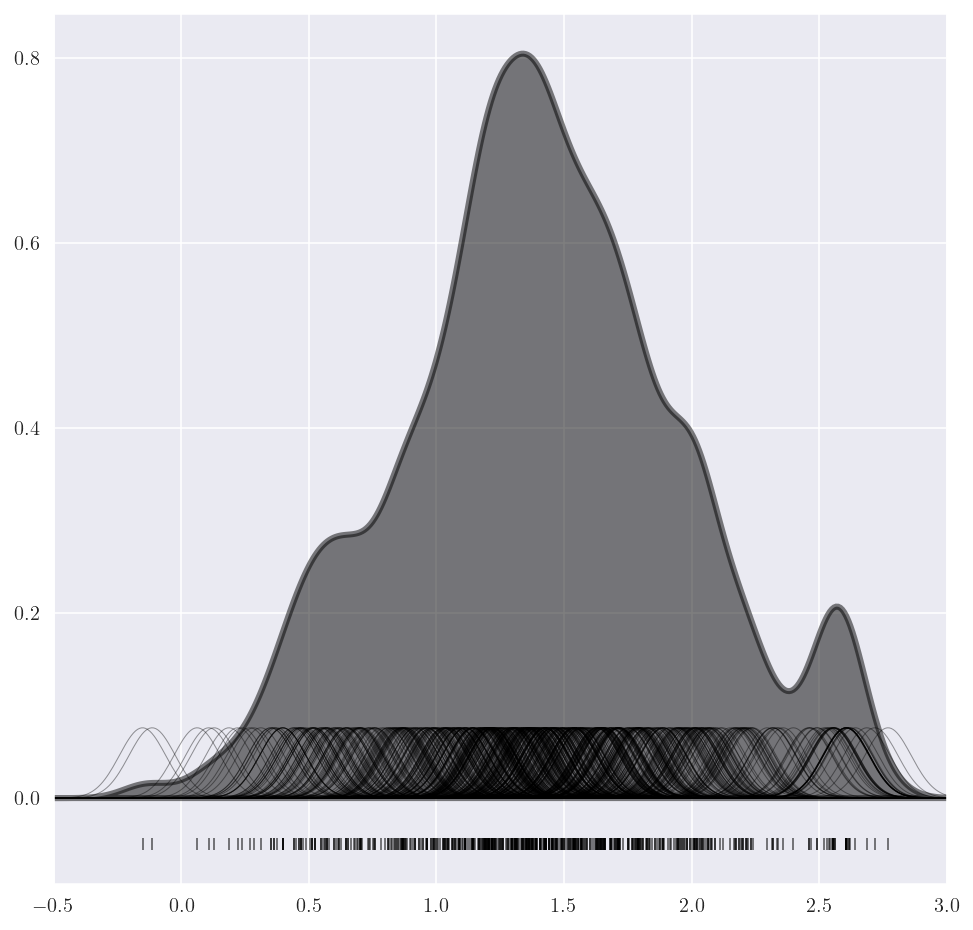

In [ ]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot /= (len(x_batse))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,3)

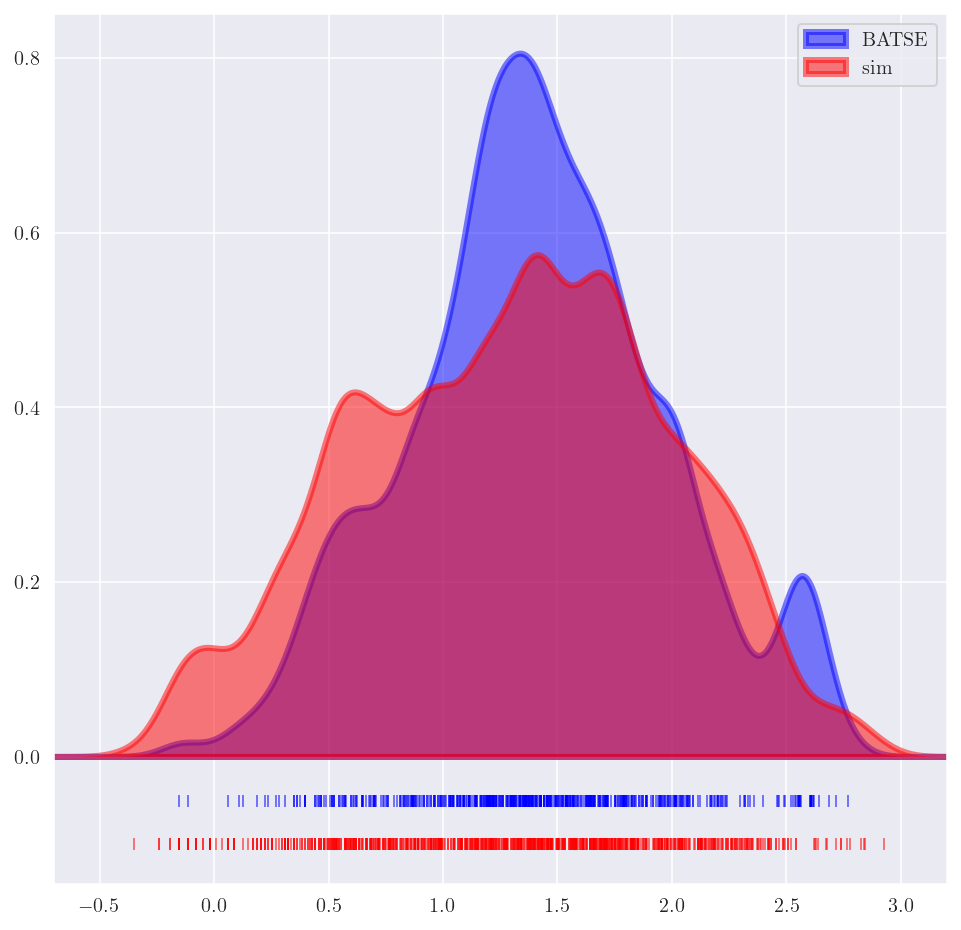

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_batse = np.log10(duration_batse)
x_sim   = np.log10(duration_sim_batse)
#
x_grid        = np.linspace(-2, 5, 1000)
y_plot_batse  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot_sim    = stats.norm.pdf(x_grid, x_sim[:, None],   h_opt)
y_plot_batse /= (len(x_batse))
y_plot_sim   /= (len(x_sim))
#
ax.fill(x_grid, y_plot_batse.sum(0), ec='b', lw=3, fc='b', alpha=0.5, label='BATSE')
ax.fill(x_grid, y_plot_sim.sum(0),   ec='r', lw=3, fc='r', alpha=0.5, label='sim')
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='b', alpha=0.5)
ax.plot(x_sim,   0*x_sim - 0.1,    '|', c='r', alpha=0.5)
ax.set_xlim(-0.7,3.2)
plt.legend()
plt.show()

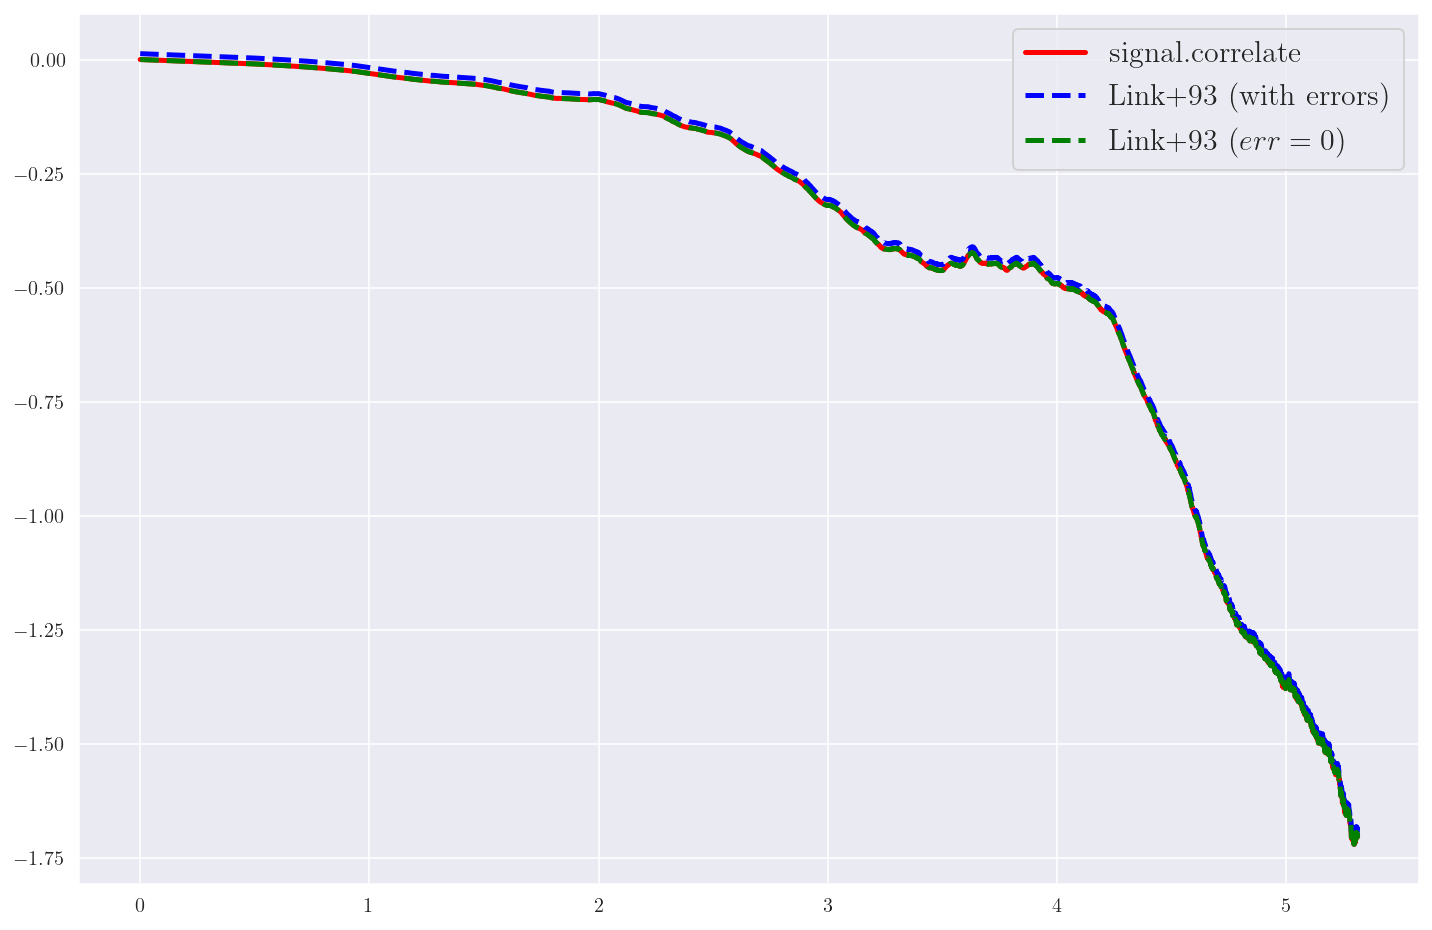

In [ ]:
from scipy import signal

counts = grb_list_batse[0].counts
counts = np.float32(counts)
errs   = grb_list_batse[0].errs
steps  = int(t_f/bin_time)

corr   = signal.correlate(counts, counts)
lags   = signal.correlation_lags(len(counts), len(counts))
corr   = corr / np.max(corr)

t_min=0   # [s] min time lag for the autocorrelation
t_max=150 # [s] max time lag for the autocorrelation

idx_i = np.where(lags*bin_time==t_min)[0][0]
idx_f = np.where(lags*bin_time<=t_max)[0][-1]
assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
assert np.isclose(lags[idx_f]*bin_time, 150, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."

lags = lags[idx_i:idx_f+1]
corr = corr[idx_i:idx_f+1]

acf_link93_err = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(steps+1)]
acf_link93     = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2          ) for u in range(steps+1)]

plt.figure(figsize=(12,8))
plt.plot((lags*bin_time)**(1/3.), np.log10(corr),           c='r', lw=2.5, ls='-',  label=r'signal.correlate')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93_err), c='b', lw=2.5, ls='--', label=r'Link+93 (with errors)')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93),     c='g', lw=2.5, ls='--', label=r'Link+93 ($err=0$)')
#plt.xlim(0,5)
plt.legend(prop={'size':15})
plt.show()

In [ ]:
###  Rebin test  ###

#------------------------------------------------------------------------------#

#times = np.linspace(0,2*np.pi, 360)
#vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
#errs = np.sqrt(np.abs(vals))

#plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
#reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
#plt.plot(reb_time, reb_vals)

#------------------------------------------------------------------------------#

#reb_times_batse, reb_data_batse, _ = rebinFunction(test_times, averaged_fluxes_batse, averaged_fluxes_error_batse, s_n_threshold=1)
#reb_times_sim, reb_data_sim, _     = rebinFunction(test_times, averaged_fluxes_sim,   averaged_fluxes_error_sim,   s_n_threshold=1)

#reb_data_batse = savgol_filter(averaged_fluxes_batse, 17, 2)
#reb_data_sim   = savgol_filter(averaged_fluxes_sim,   17, 2)

#------------------------------------------------------------------------------#

#plt.plot(test_times**(1/3), np.log10(reb_data_batse), label = 'batse')
#plt.plot(test_times**(1/3), np.log10(reb_data_sim), label ='sim')
#plt.xlim([0,5])
#plt.legend()

#------------------------------------------------------------------------------#

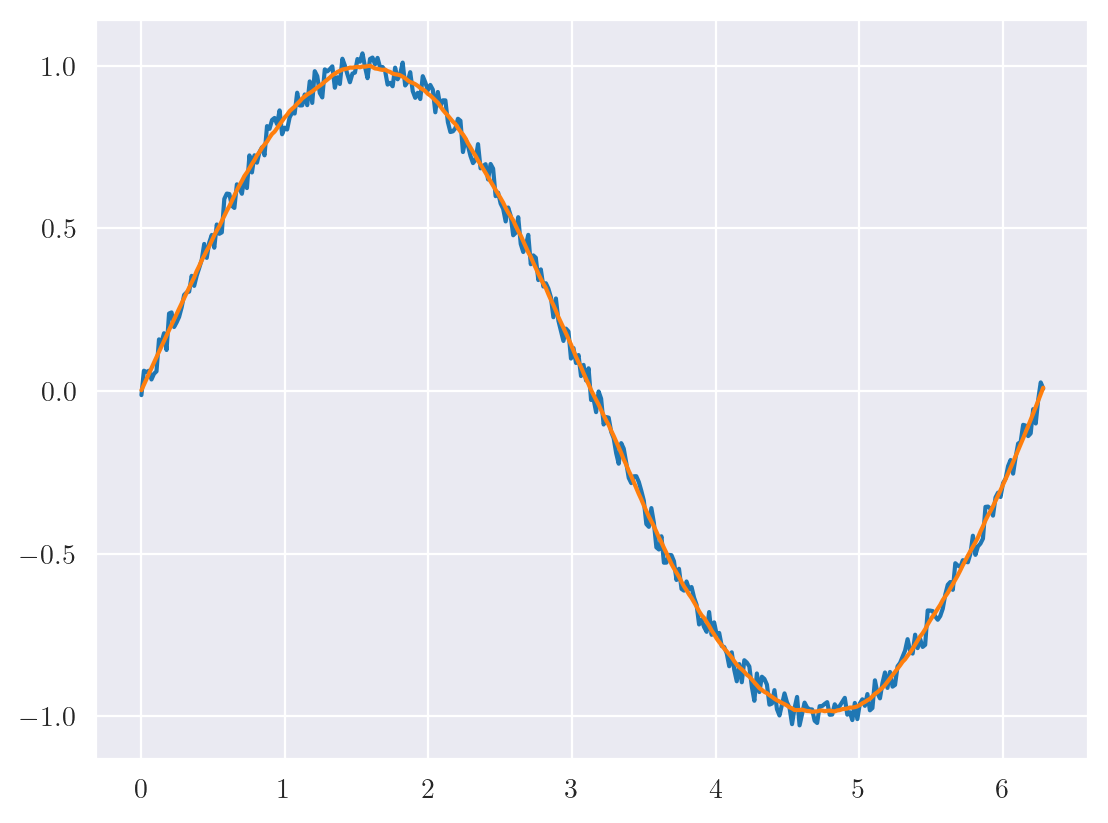

In [ ]:
#Savitzky-Golay filter test
from scipy.signal import savgol_filter

times = np.linspace(0,2*np.pi, 360)
vals = (np.sin(times) + (np.random.rand(len(times))-0.5)*0.1) 

filtered_vals = savgol_filter(vals, 41, 2,0)
plt.plot(times, vals)
plt.plot(times, filtered_vals)

NameError: name 'rebinFunction' is not defined

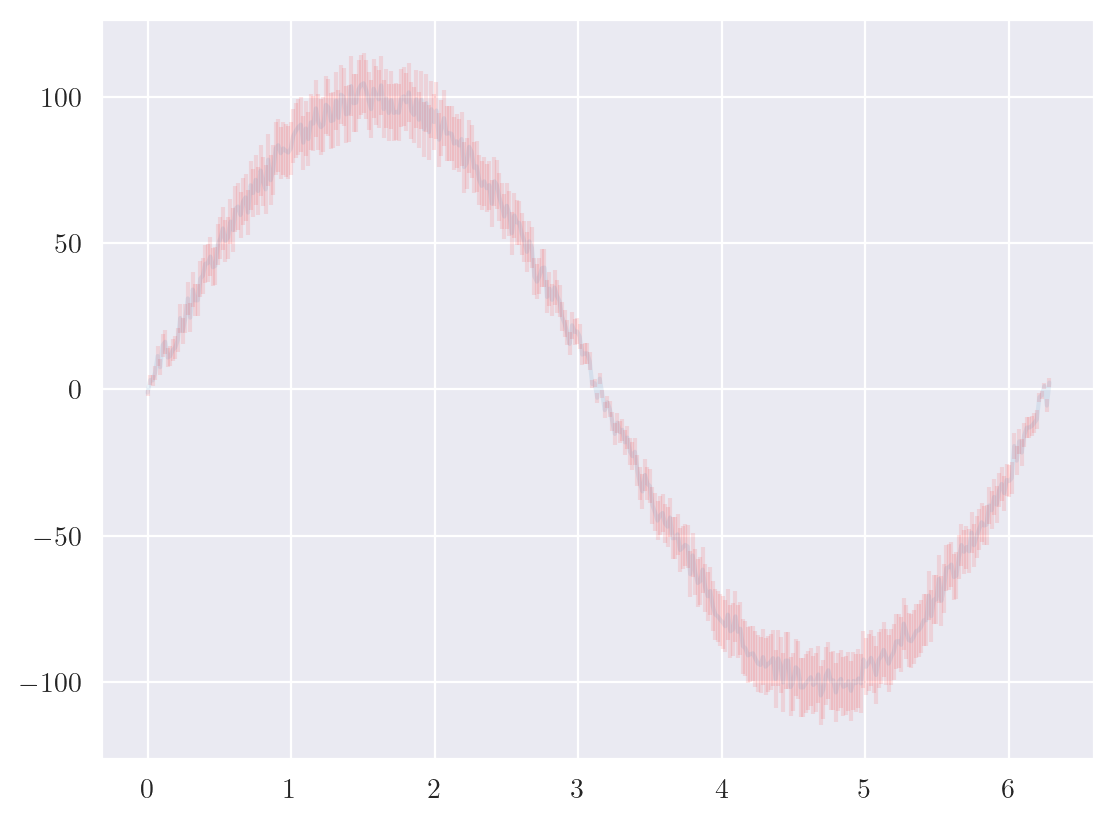

In [ ]:
#Rebin test

times = np.linspace(0,2*np.pi, 360)
vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
errs = np.sqrt(np.abs(vals))

plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
plt.plot(reb_time, reb_vals)

(100.0, 150.0)

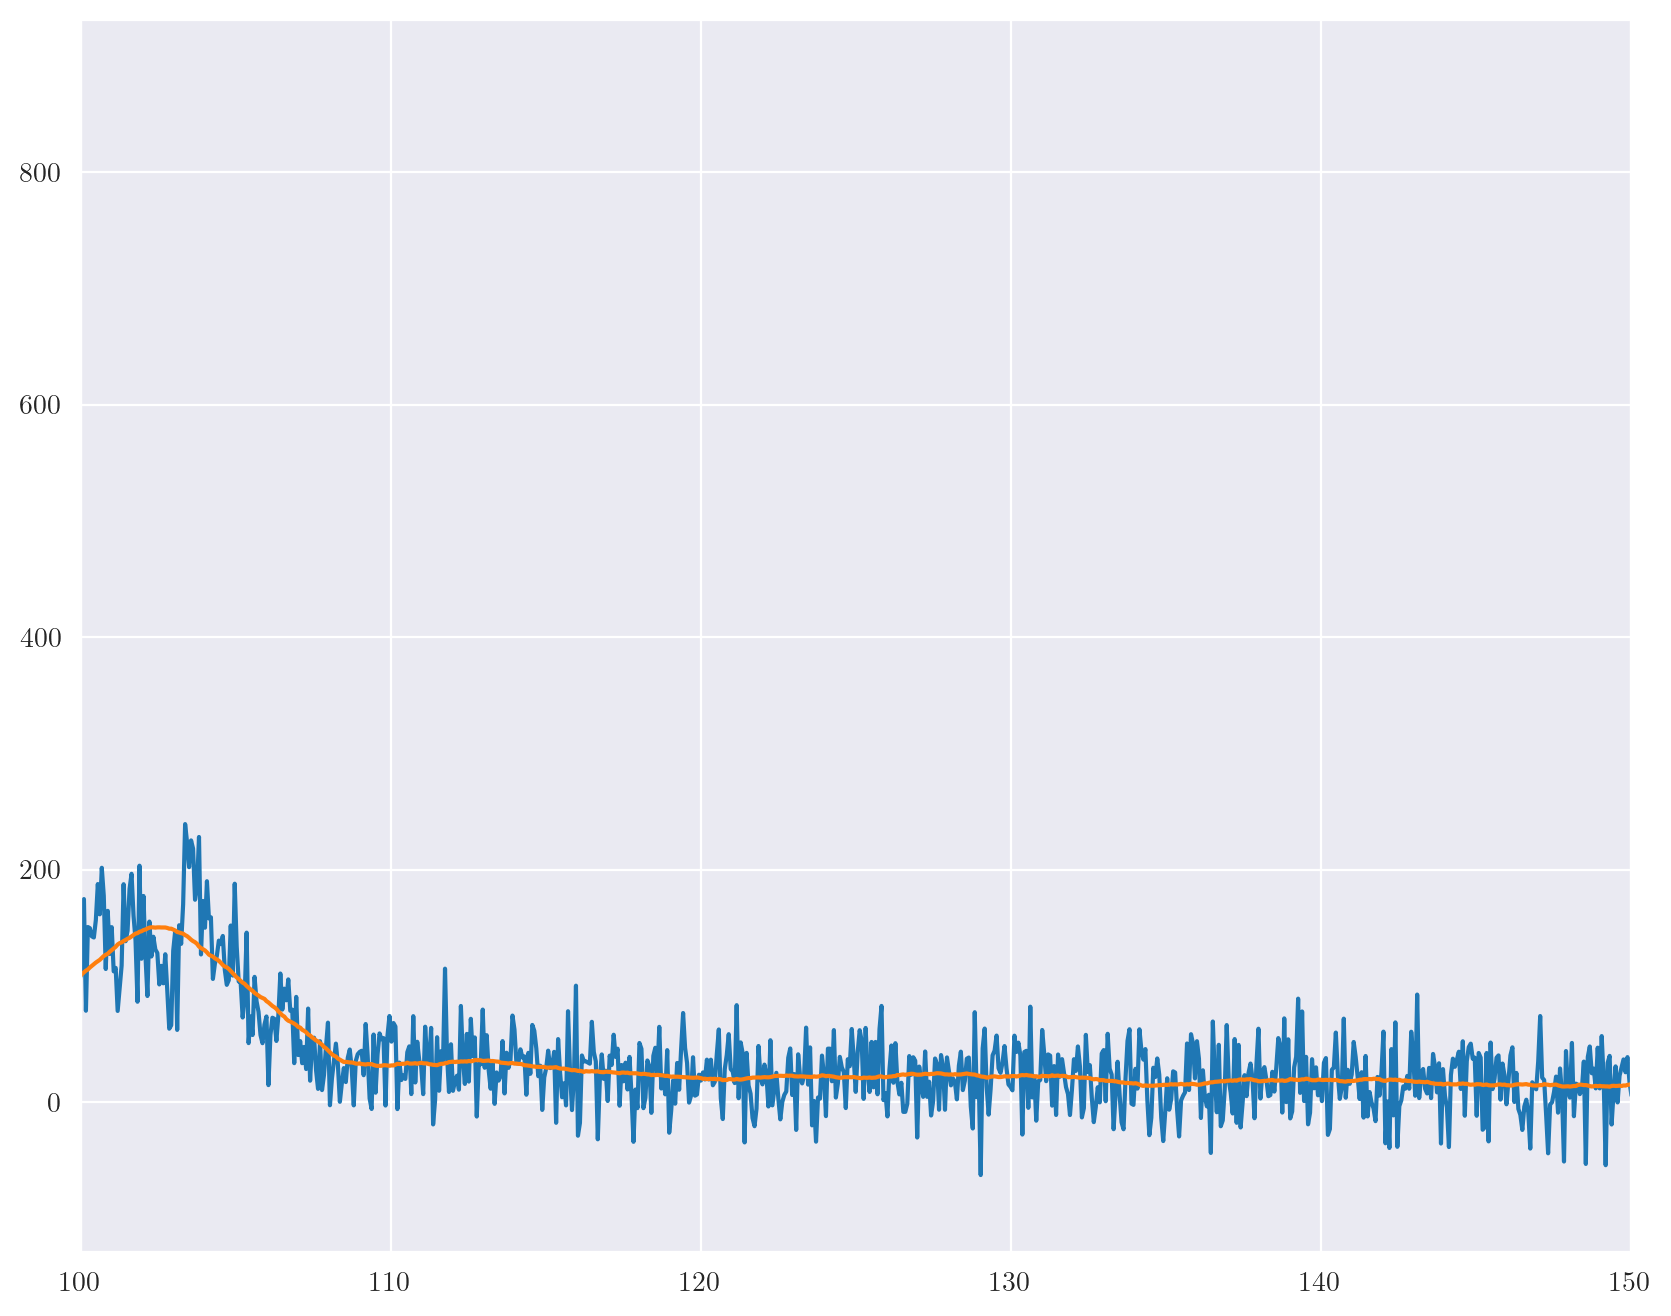

In [ ]:
times = grb_list_batse[0].times
vals = grb_list_batse[0].counts

filtered_vals = savgol_filter(vals, 161, 2 , 0)
plt.figure(figsize=(10,8))
plt.plot(times, vals)
plt.plot(times, filtered_vals)
plt.xlim(100,150)
#plt.xlim(-50,350)

In [ ]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93_test[1]
    if(acf_link93_test[1]<-50):
        print(acf_link93_test[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

NameError: name 'steps' is not defined

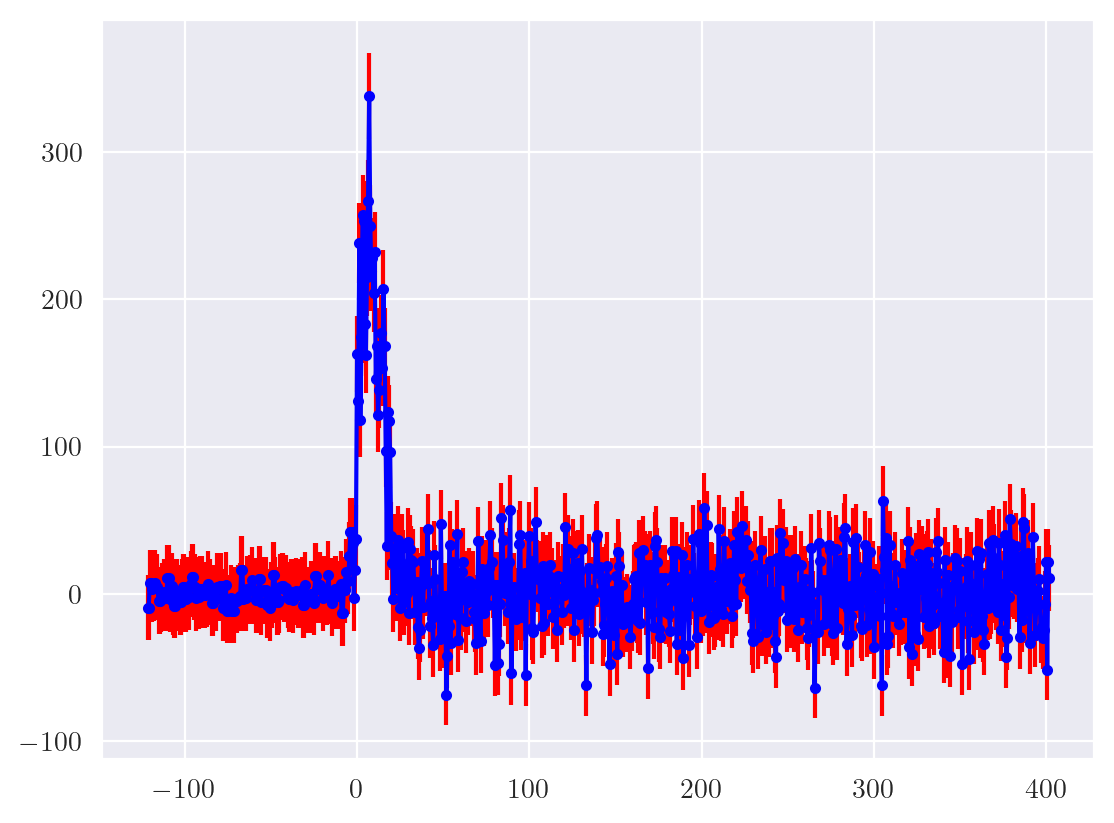

1.100963409212773 164


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

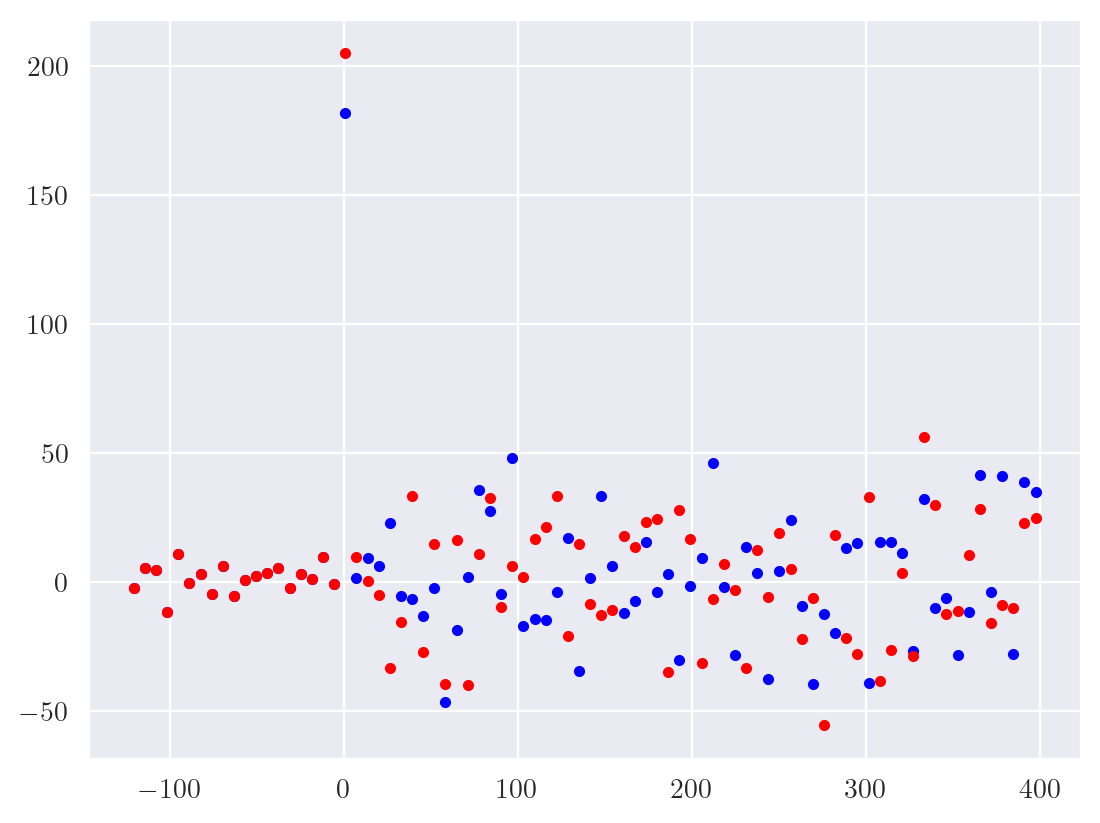

40.32327260478941 187


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

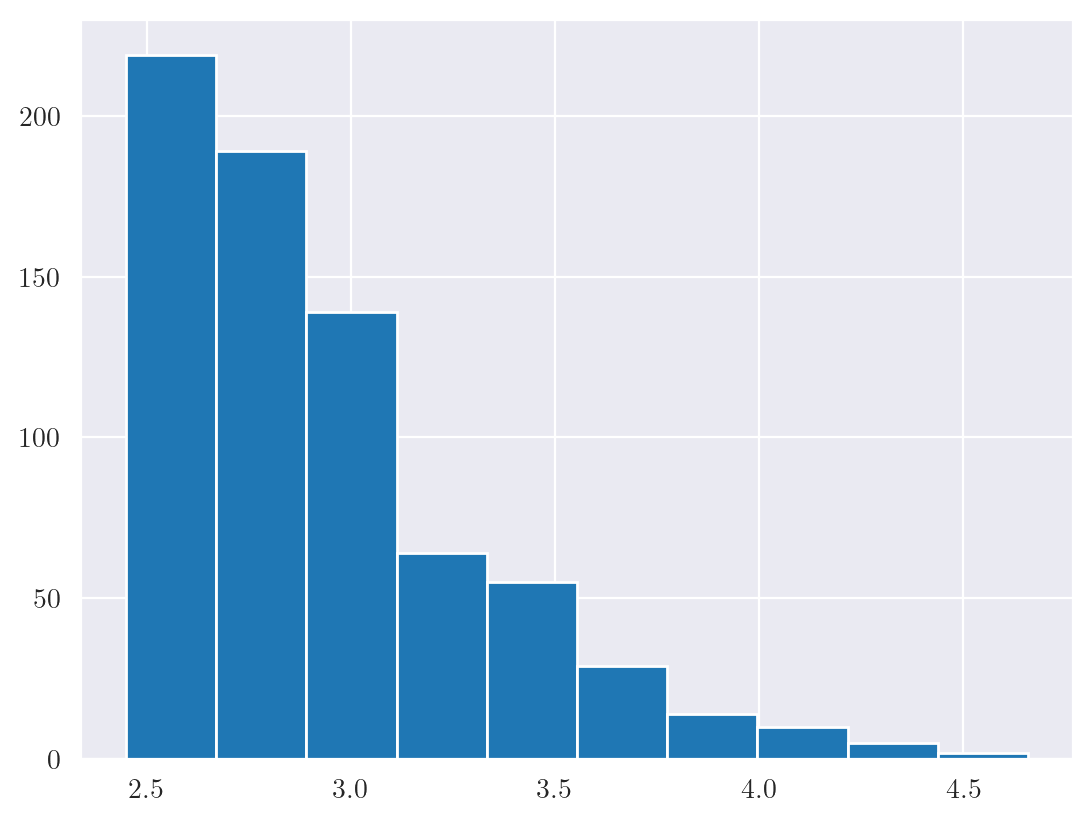

In [ ]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


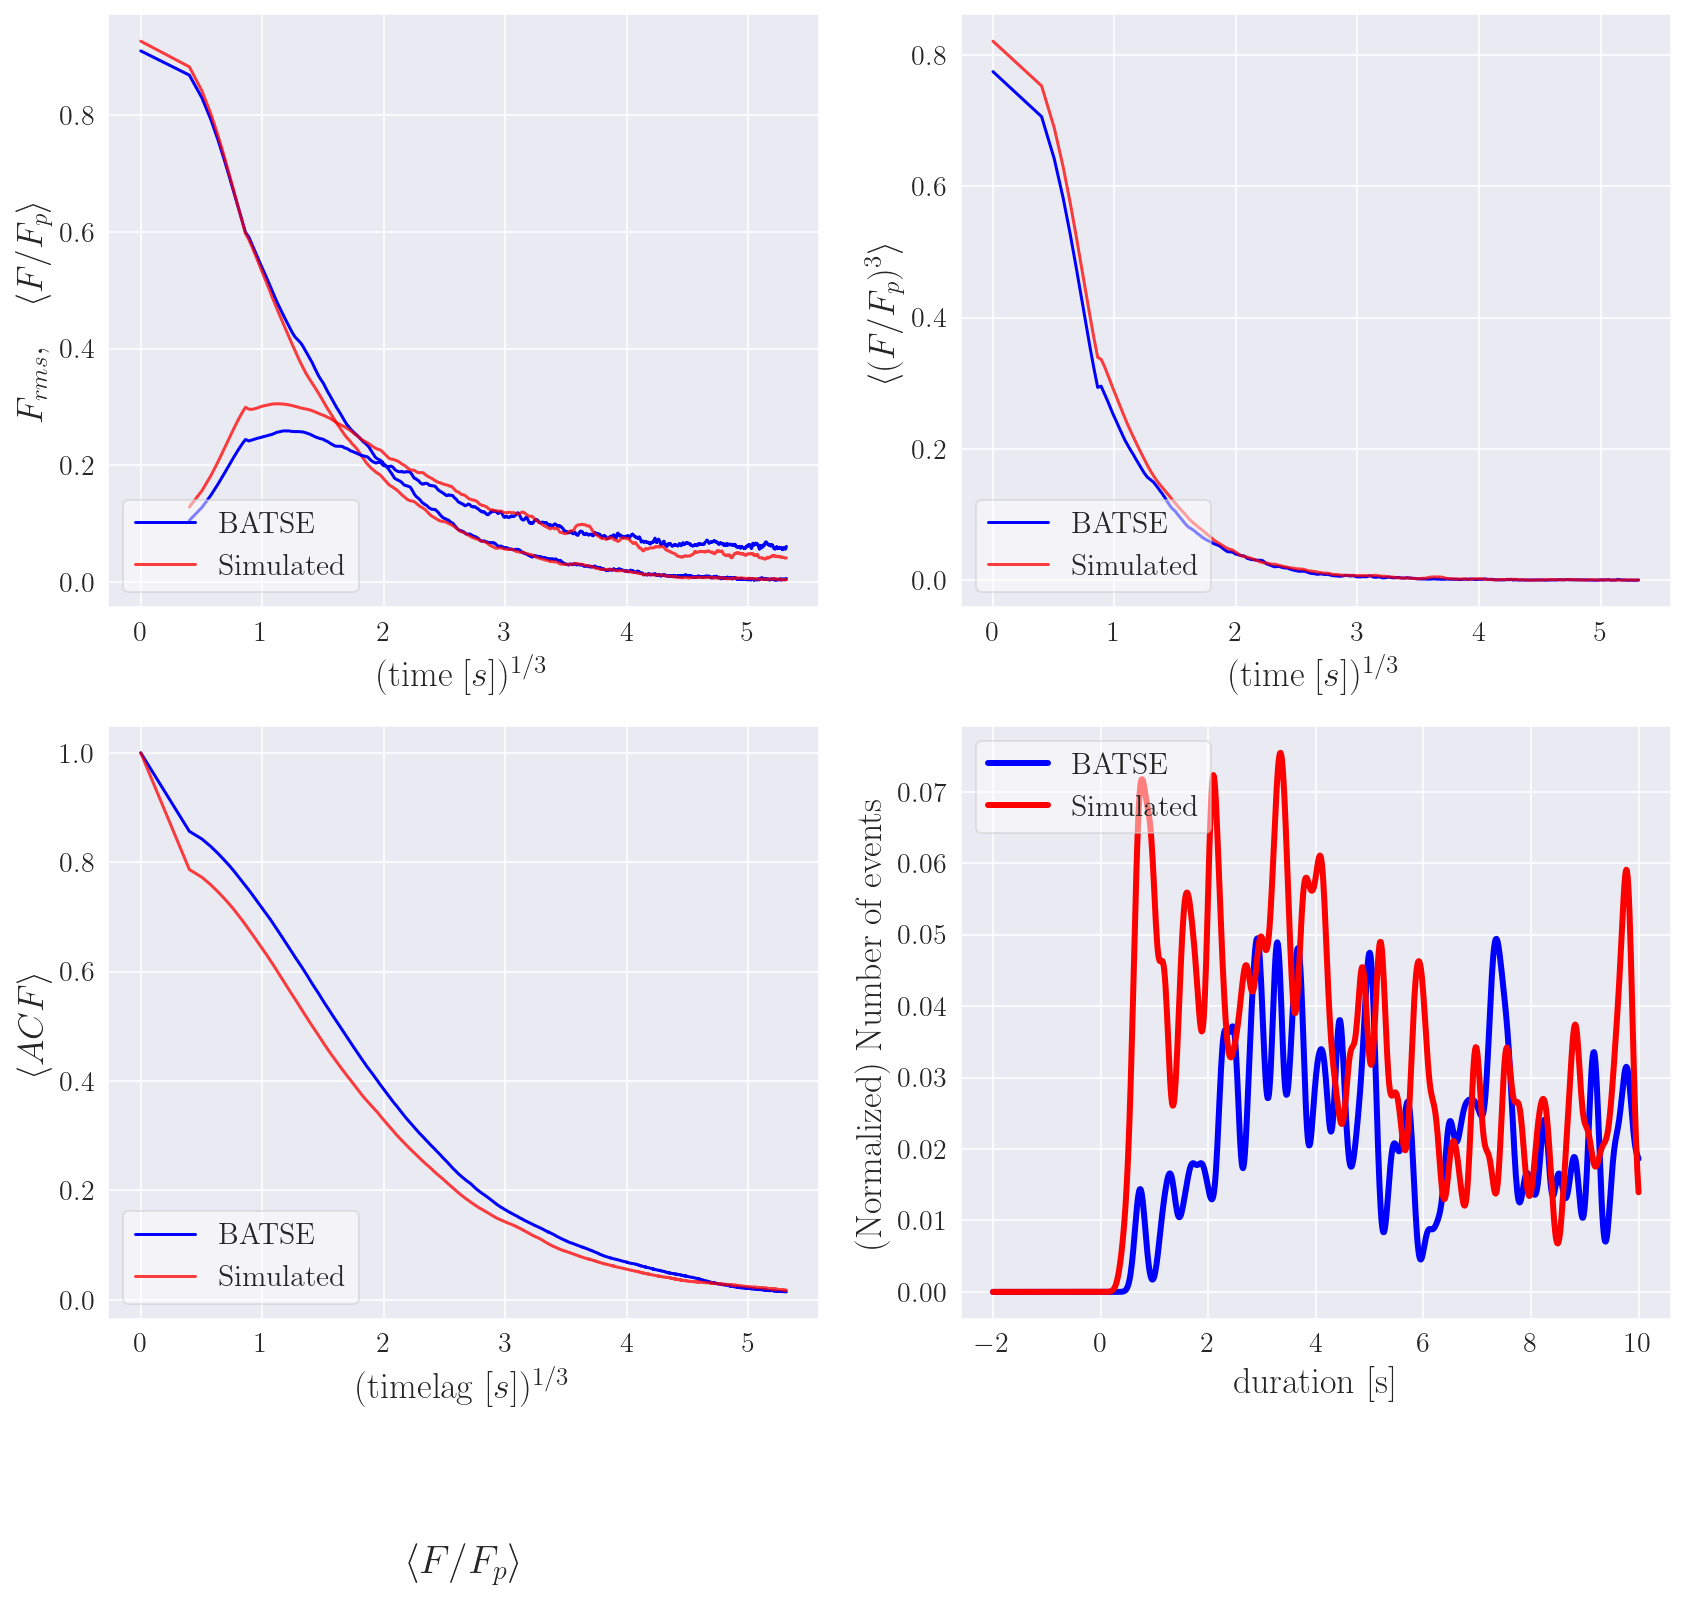

In [ ]:
# hist = False
# log  = False
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=False, log=False)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


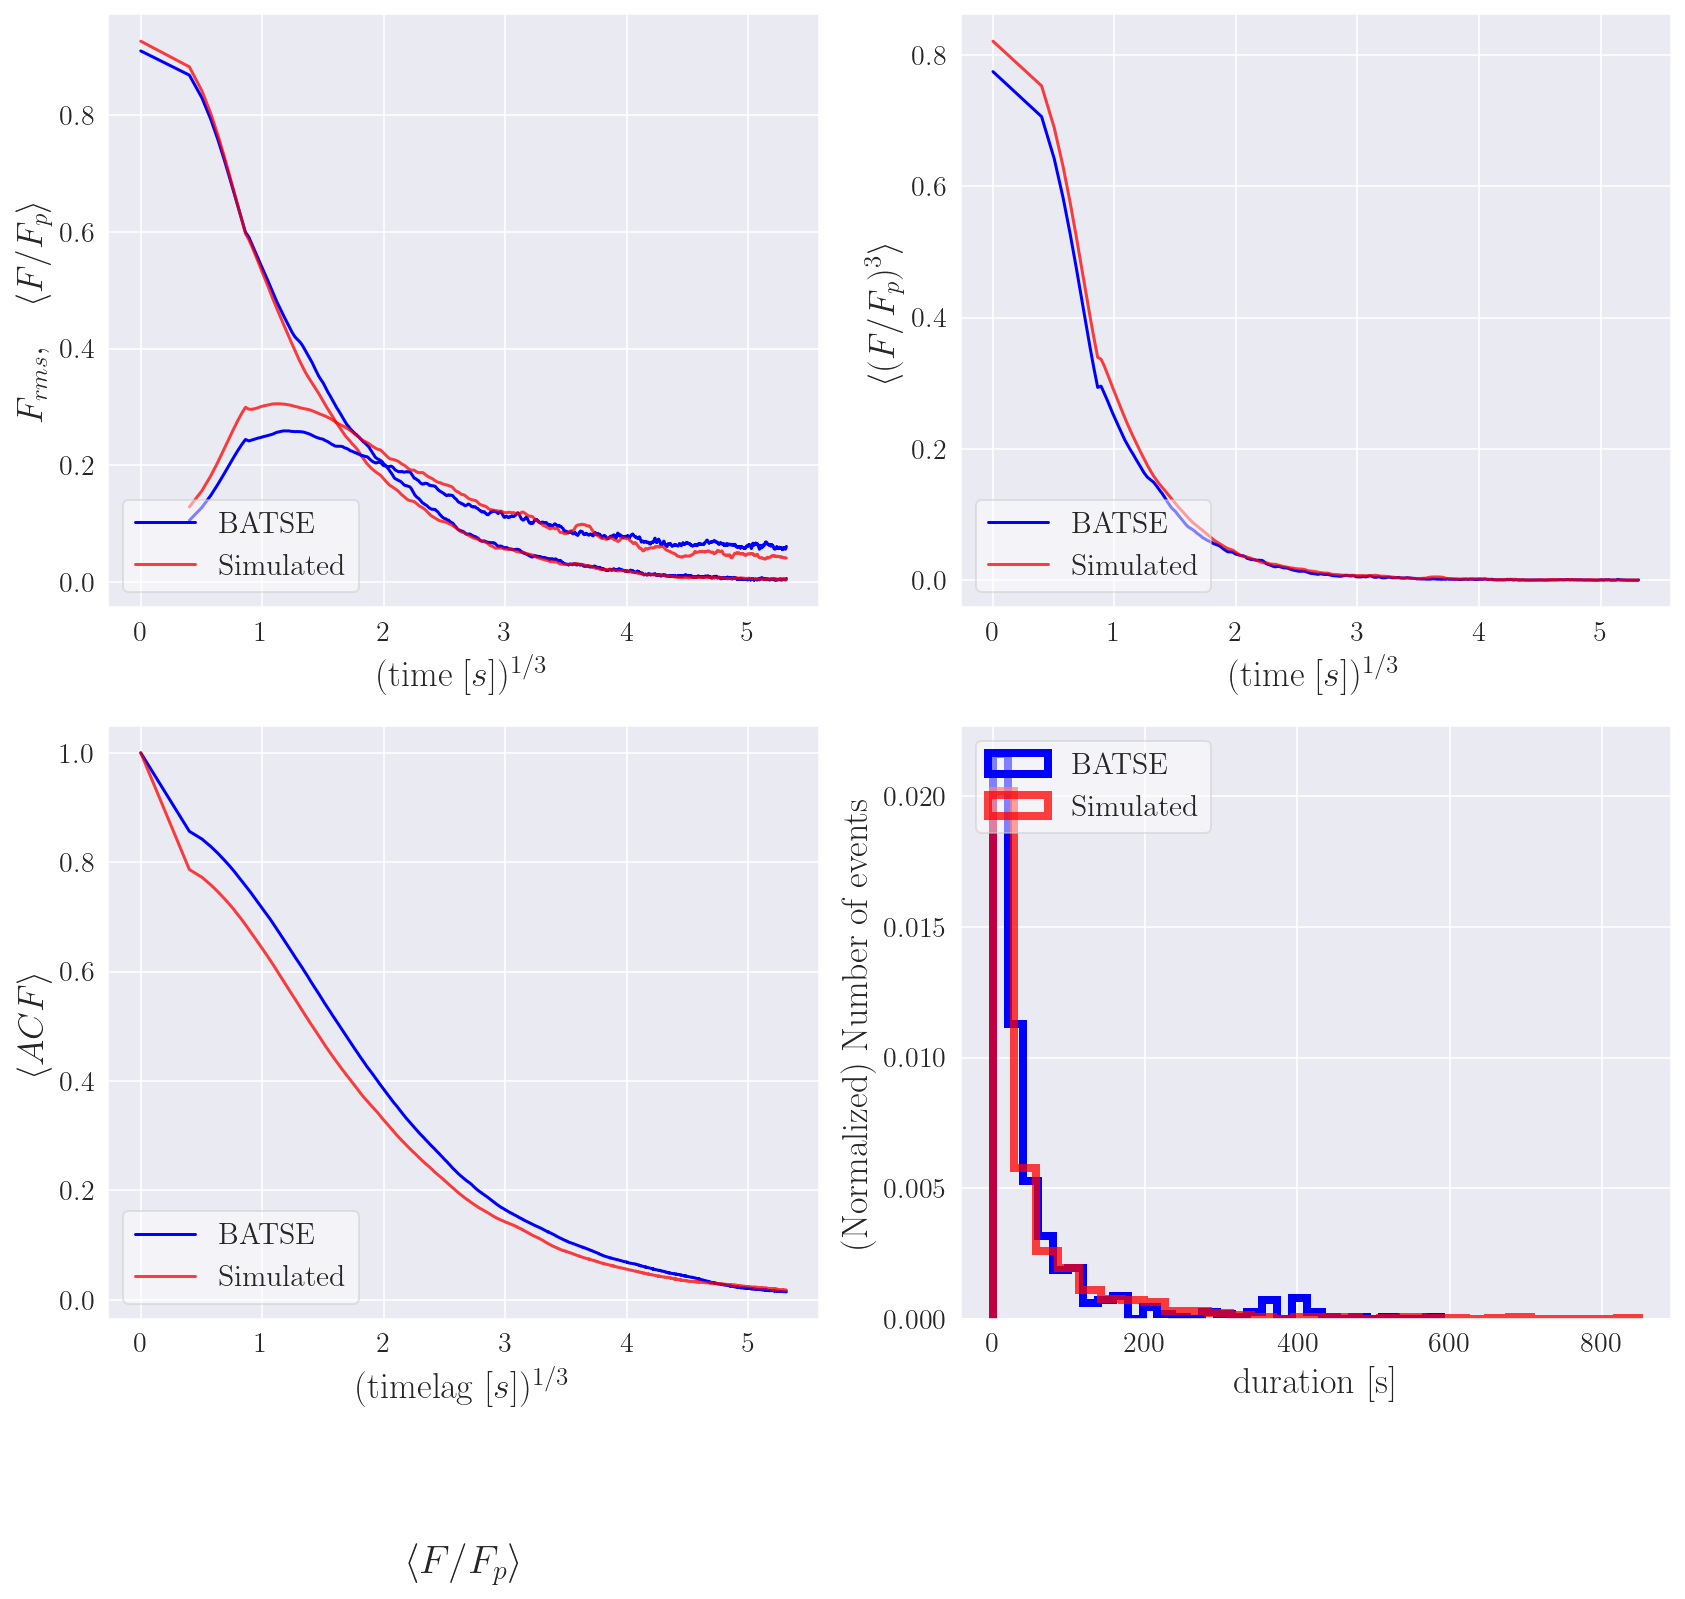

In [ ]:
# hist = True
# log  = False
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=True, log=False)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


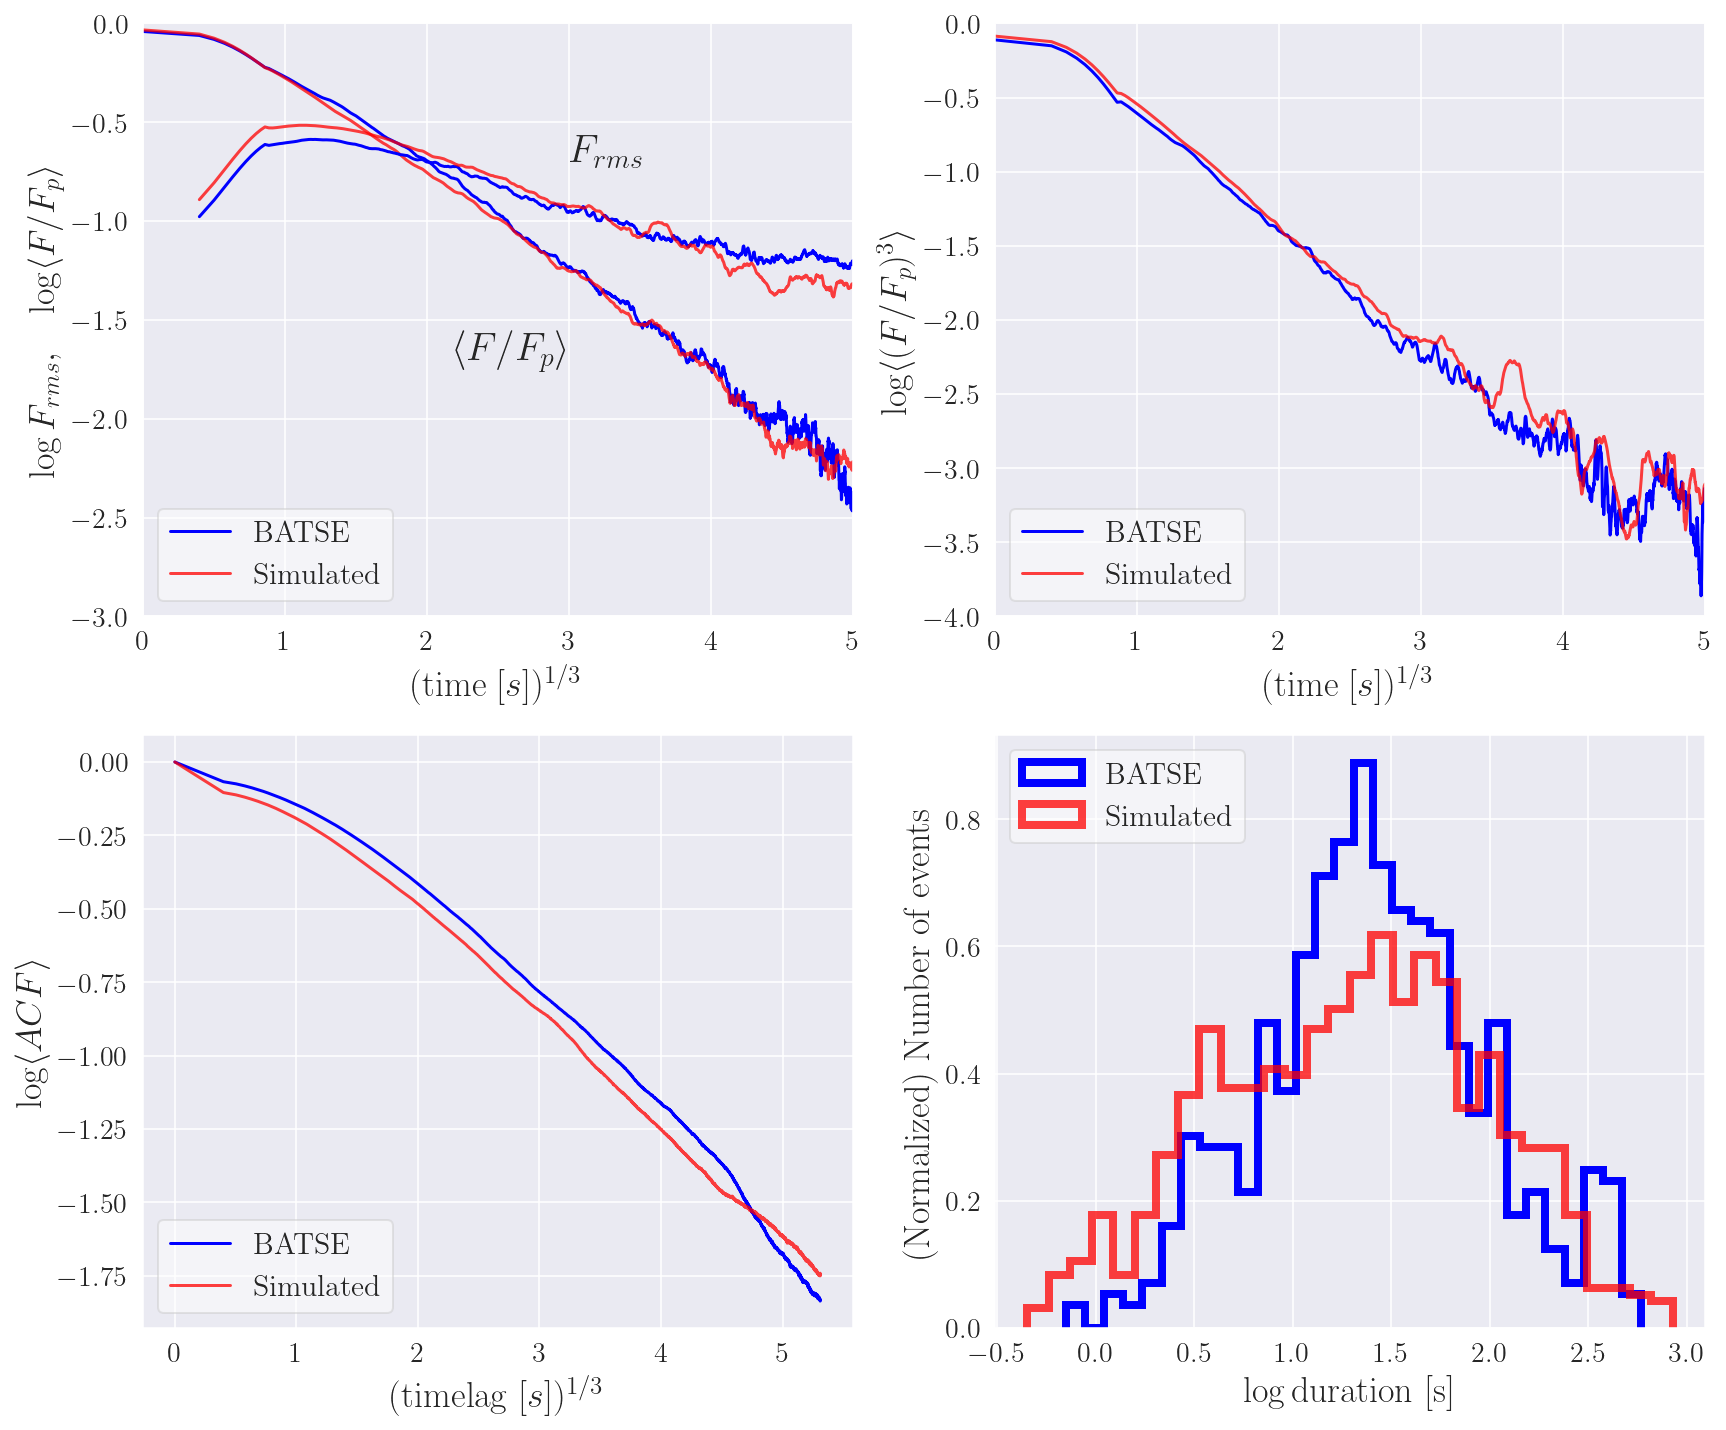

In [ ]:
# hist = True
# log  = True
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=True, log=True)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


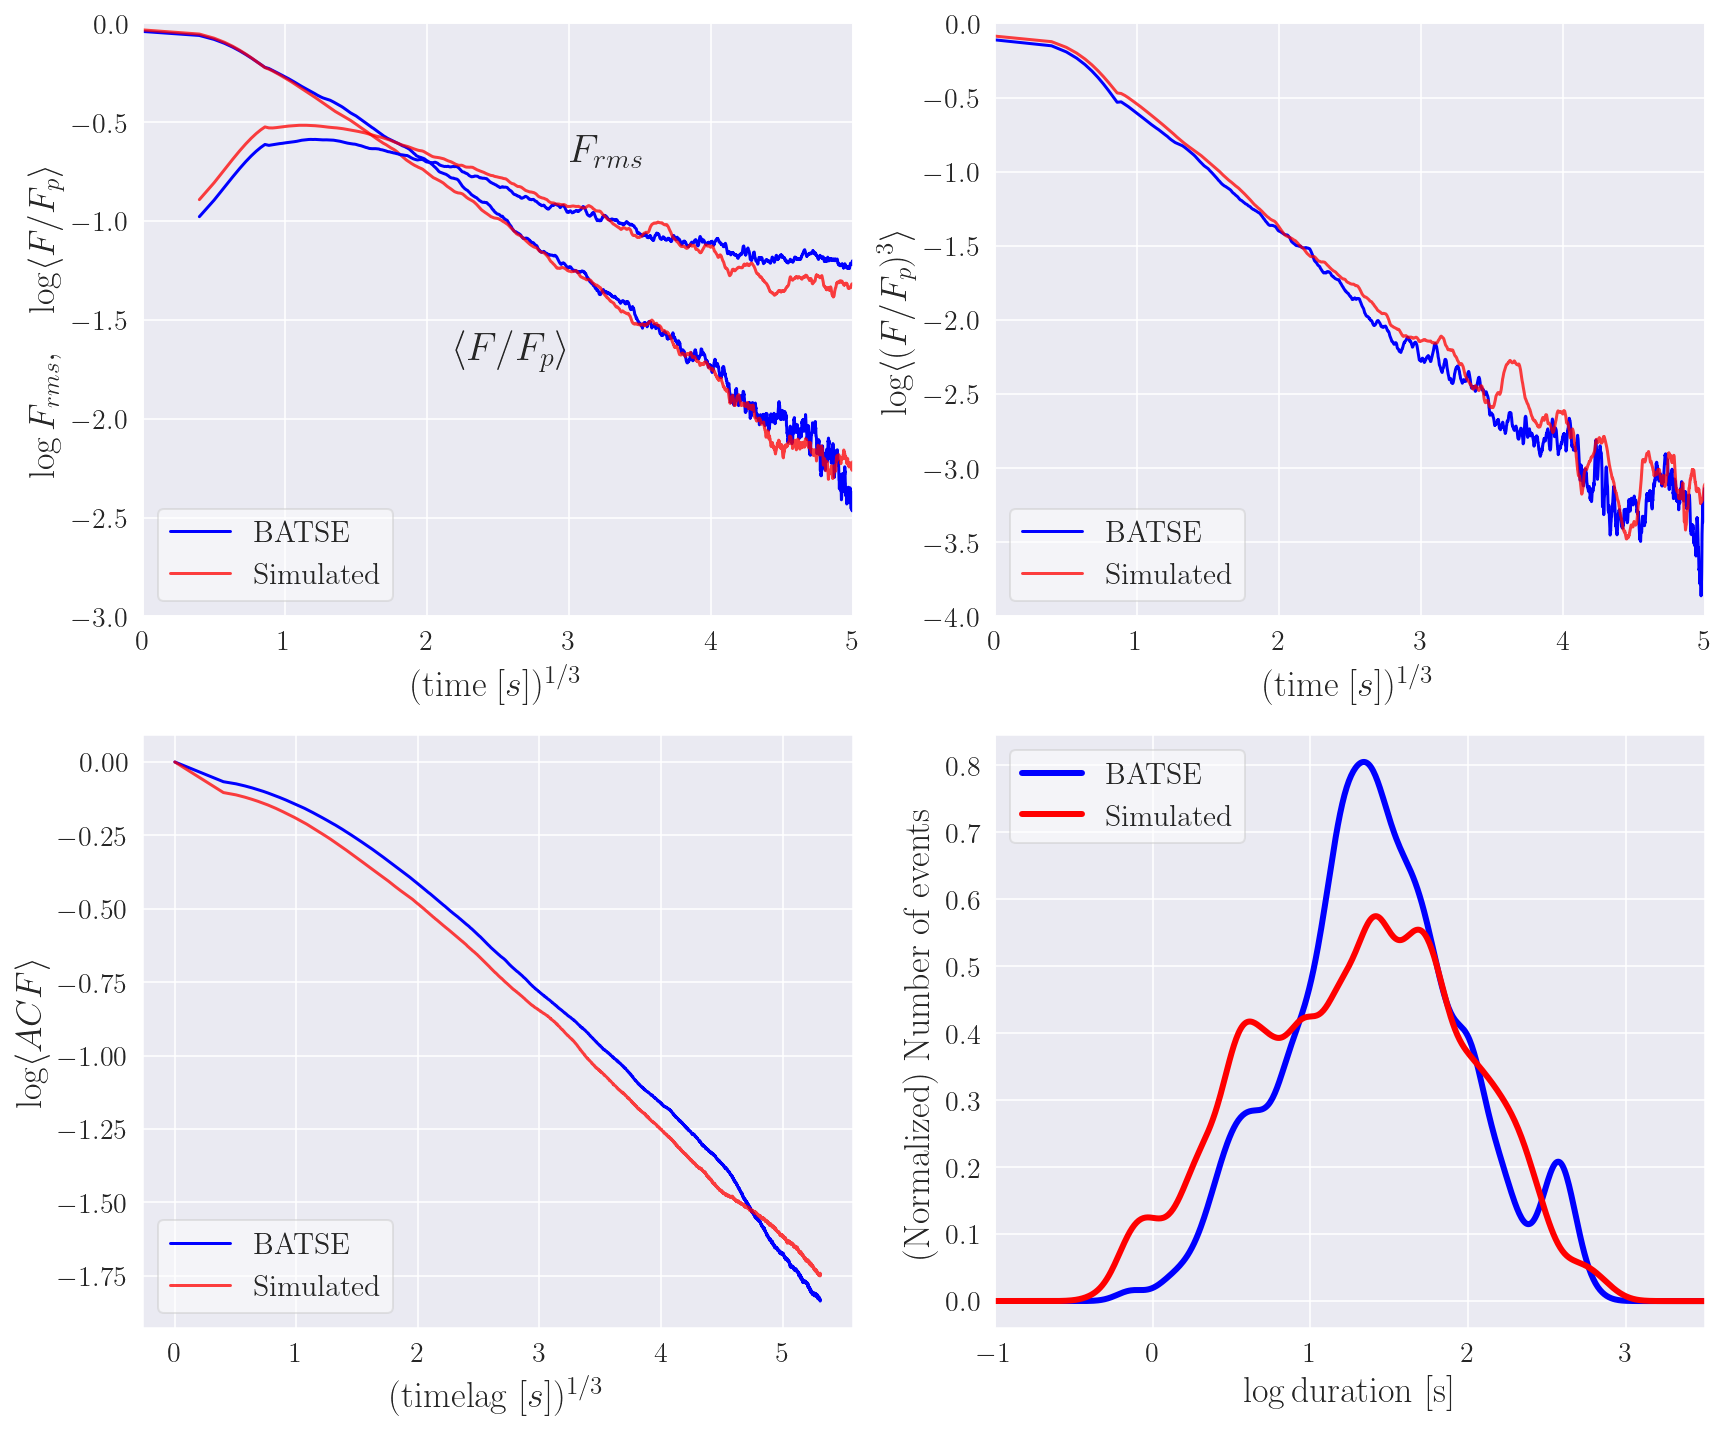

In [ ]:
# hist = False
# log  = True
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=False, log=True)

In [6]:
def evaluateDuration20_(times, counts, t90=None, t90_frac=15, bin_time=None, filter=True):
    if filter:
        t90_frac = t90_frac
        window   = int(t90/t90_frac/bin_time)+1
        window   = window if window%2==1 else window+1
        #try:
        #print(window)
        counts = savgol_filter(x=counts,
                                window_length=window,
                                polyorder=2)
        #except:
        #    #print('window_length =', window)
        #    print('Error in "evaluateDuration20()" during the "savgol_filter()"...')
        #    exit()

    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart # T20
    assert duration>0
    return np.array( [duration, tstart, tstop, window] )

#------------------------------------------------------------------------------#

def smoothLC(grb, t90_frac=15, filter=True):

    times  = grb.times
    counts = grb.counts
    t90    = grb.t90
    bin_time = 0.064
    if filter:
        t90_frac = t90_frac
        window   = int(t90/t90_frac/bin_time)+2
        window   = window if window%2==1 else window+1
        try:
            counts = savgol_filter(x=counts,
                                   window_length=window,
                                   polyorder=2)
        except:
            #print('window_length =', window)
            print('Error in "evaluateDuration20()" during the "savgol_filter()"...')
            exit()
    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart # T20
    assert duration>0
    print('window =', window)
    print('T20%   =', duration)
    return counts

The `window=t90/15` works better than `window=t90/5`, since it works both for GRBs with small and large T90! (see the two examples below)

window = 25
T20%   = 2.176
window = 9
T20%   = 2.1759996


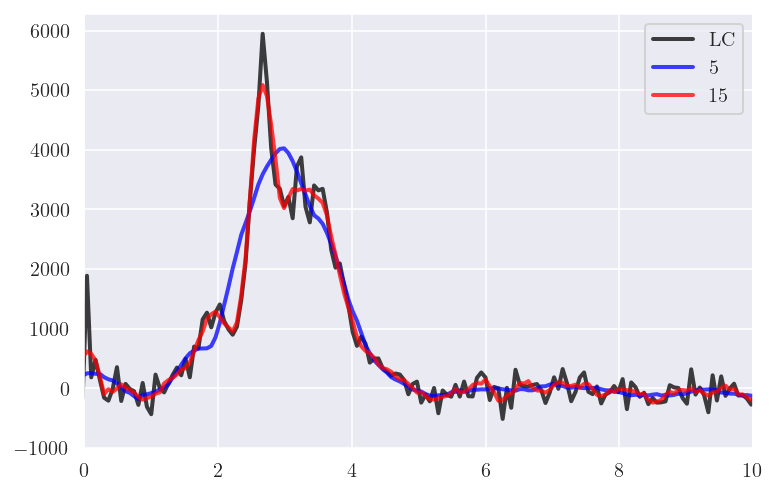

-1


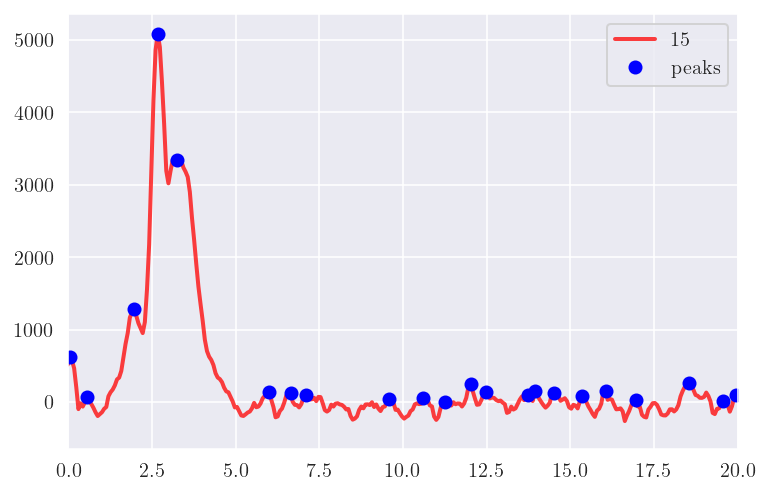

In [57]:
indx        = 1
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(0,10)
plt.legend()
plt.show()

print(grb_list_sim_batse[indx].num_of_sig_pulses)

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(0,20)
plt.legend()
plt.show()

window = 201
T20%   = 26.432
window = 69
T20%   = 23.424


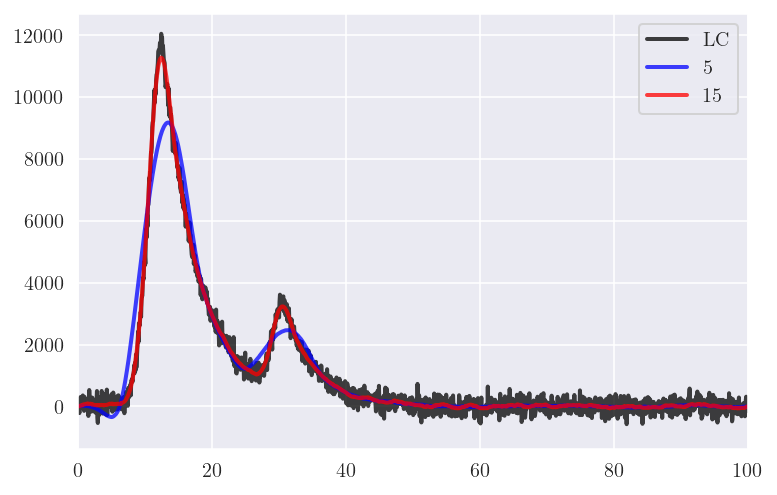

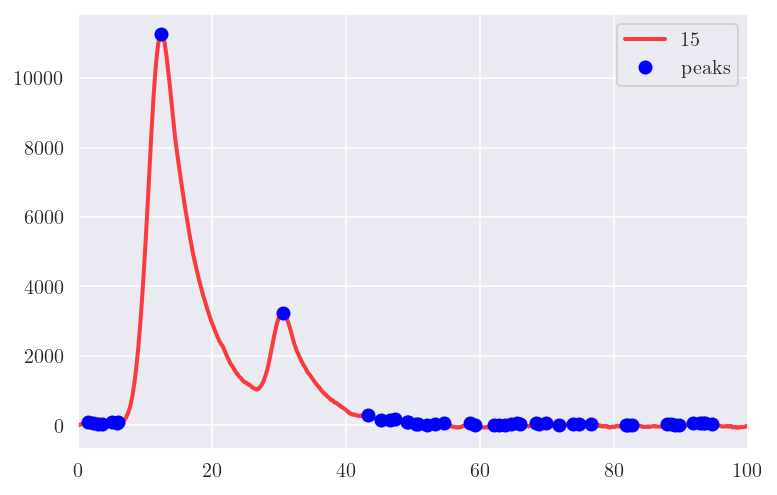

In [55]:
indx        = 2
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(0,100)
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(0,100)
plt.legend()
plt.show()

window = 1351
T20%   = 75.583984
window = 451
T20%   = 55.744003


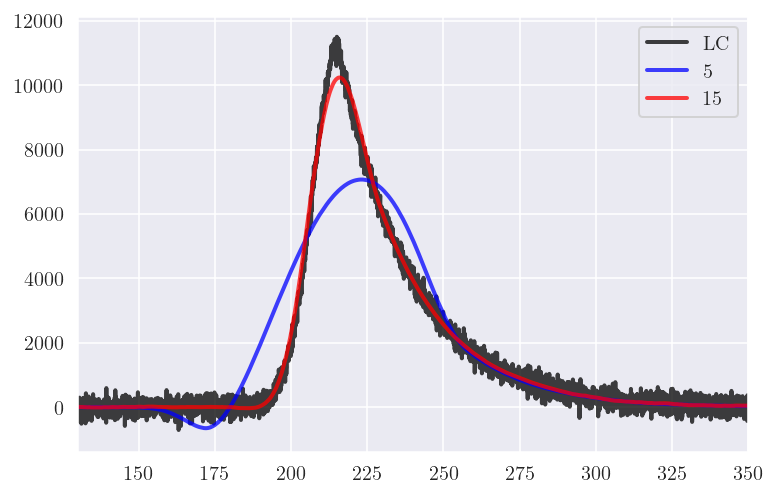

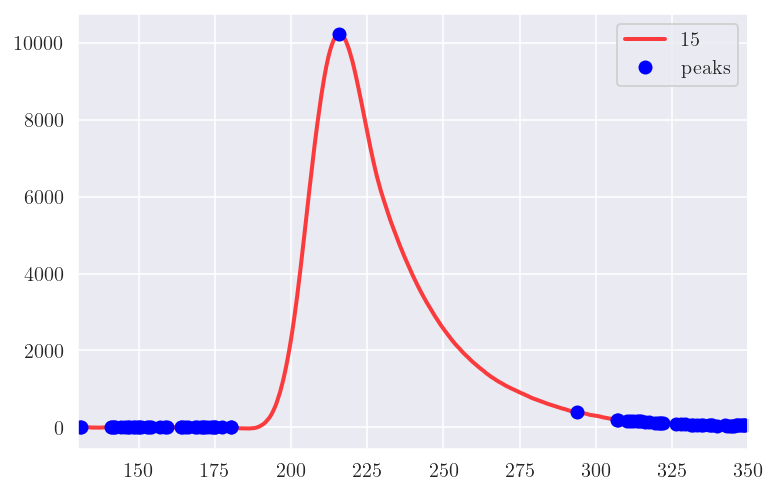

In [56]:
indx        = 10
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(130,350)
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(130,350)
plt.legend()
plt.show()

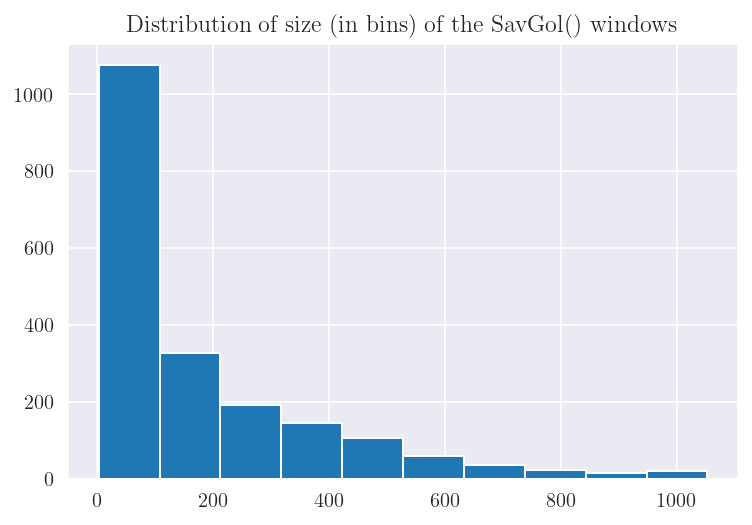

In [31]:
w_list = []
for i, grb in enumerate(grb_list_sim_batse):
    times    = grb.times
    counts   = grb.counts
    t90      = grb.t90
    bin_time = 0.064
    #print('@@@ ', i)
    #print(t90)
    window   = evaluateDuration20_(times, counts, t90=t90, t90_frac=15, bin_time=bin_time, filter=True)[3]
    #print('================')
    w_list.append(window)

plt.hist(np.array(w_list))
plt.title(r'Distribution of size (in bins) of the SavGol() windows')
plt.show()

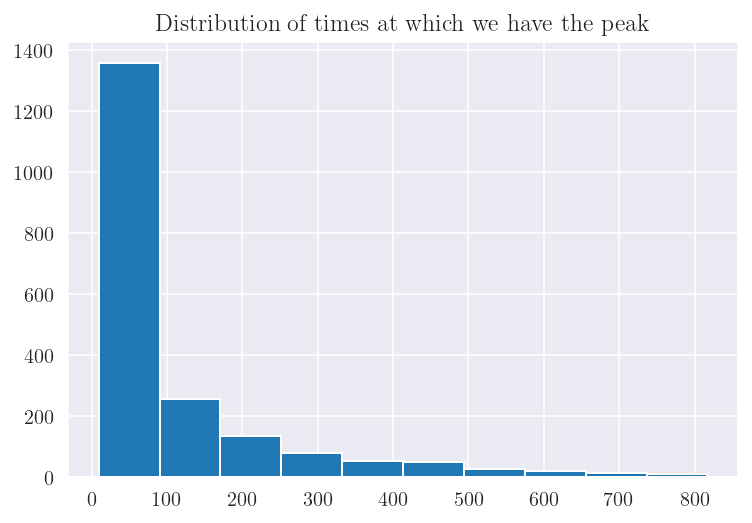

In [32]:
tmax_list = []
for grb in grb_list_sim_batse:
    counts = grb.counts
    t_max  = np.argmax(counts)
    tmax_list.append(t_max)

plt.hist(np.array(tmax_list)*0.064)
plt.title(r'Distribution of times at which we have the peak')
plt.show()

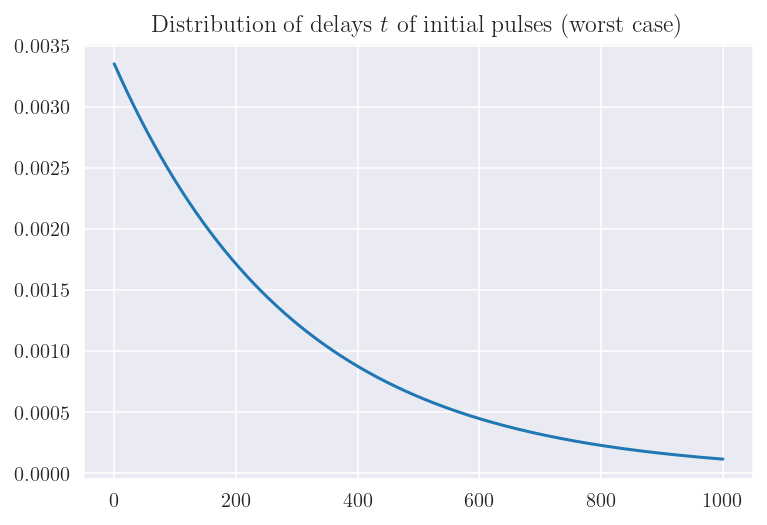

In [33]:
tau_0 = 45.9   # max value of the interval
#tau_0 = 6e-6  # min value of the interval
alpha = 6.5

t = np.linspace(0,1000,1000)
p = (1./(alpha*tau_0)) * np.exp(-t/(alpha*tau_0))

plt.plot(t, p)
plt.title(r'Distribution of delays $t$ of initial pulses (worst case)')
plt.show()

In [34]:
res = []
bin_time = 0.064
for grb in grb_list_sim_batse:
    res.append([ evaluateDuration20(grb.times, grb.counts, t90=grb.t90, t90_frac=i, bin_time=bin_time, filter=True)[0] for i in range(5,101)])

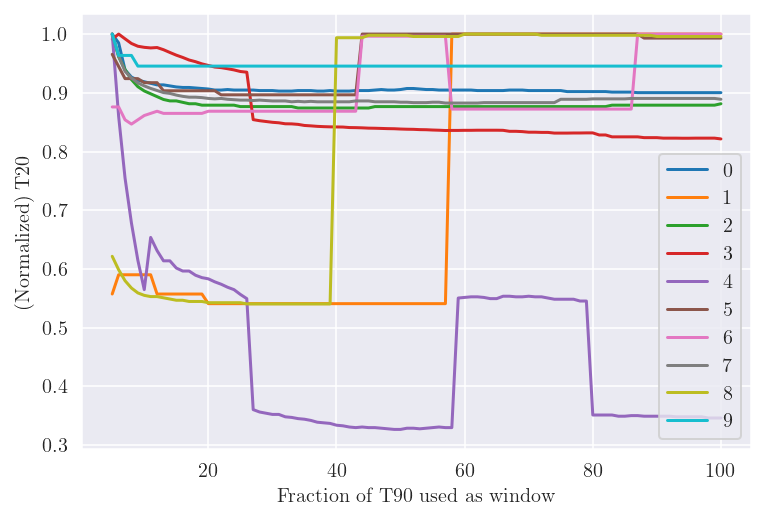

In [52]:
fracs = range(5,101)
for i in range(0,10):
    plt.plot(fracs, res[i]/np.max(res[i]), label=i)
plt.ylabel('(Normalized) T20')
plt.xlabel('Fraction of T90 used as window')
plt.legend()

(0.0, 1.0)

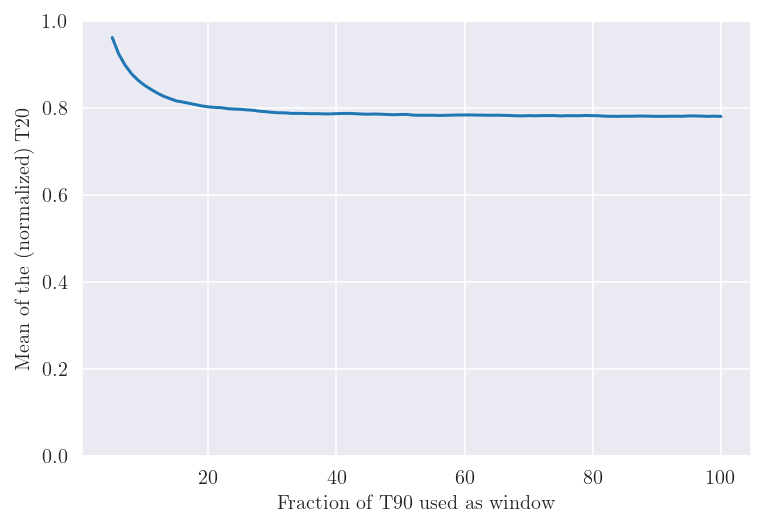

In [51]:
norm_res = []
for i in range(len(res)):
    norm_res.append(np.array(res[i])/np.max(res[i]))

avg_res = np.zeros_like(norm_res[0])
for i in range(len(norm_res)):
    avg_res += norm_res[i]
avg_res = avg_res / len(norm_res)

plt.plot(fracs, avg_res)
plt.ylabel('Mean of the (normalized) T20')
plt.xlabel('Fraction of T90 used as window')
plt.ylim(0,1)